<a id="top"></a>
# 03_TRAIN_CONTINUAL — Entrenamiento Continual con *presets*

**Qué hace este notebook**  
Entrena y evalúa modelos en **aprendizaje continual** (secuencia de tareas) usando una **configuración unificada** desde `configs/presets.yaml`. Permite:  
1) lanzar un *run* base con el método del preset,  
2) **comparar métodos** manteniendo fijos datos/modelo, y  
3) generar un **resumen agregado** de resultados en `outputs/summary/`.


---

## 🎯 Objetivos
- Centralizar la configuración de **modelo**, **datos/codificación temporal**, **optimizador** y **método continual** vía `presets.yaml`.
- Soportar **H5 offline** (si `use_offline_spikes: true`) o **CSV + codificación en runtime** (si `encode_runtime: true`), seleccionándolo de forma coherente con el preset.
- Comparar métodos (`naive`, `ewc`, `rehearsal`, `rehearsal+ewc`, y los bio-inspirados previstos: `as-snn`, `sa-snn`, `sca-snn`, `colanet`) con **idéntica preparación de datos**.
- Exportar un **CSV de agregados** con métricas clave (MAE/MSE por tarea, olvido absoluto/relativo, etc.).

## ✅ Prerrequisitos
- Haber generado `data/processed/tasks.json` (y opcionalmente `tasks_balanced.json`) con **01_DATA_QC_PREP** o **01A_PREP_BALANCED**.
- Si el preset usa **offline** (`use_offline_spikes: true`), haber creado los H5 compatibles con **02_ENCODE_OFFLINE** (mismo `encoder/T/gain/size/to_gray` que el preset).
- Revisar `configs/presets.yaml` (secciones `model`, `data`, `optim`, `continual`, `prep`).

## ⚠️ Notas importantes
- **No combines** `use_offline_spikes: true` y `encode_runtime: true`. El notebook lo detecta y lanza error.
- La **semilla** global se toma de `CFG["data"]["seed"]` para reproducibilidad.
- La carpeta de salida incluye en el nombre preset, método, *encoder*, modelo, *seed*, etc., para facilitar trazabilidad.

<a id="toc"></a>

## 🧭 Índice

- [1) Setup del entorno y paths](#sec-01)  
- [2) Carga del preset unificado (`configs/presets.yaml`)](#sec-02)  
- [3) Verificación de datos y selección de `tasks.json`](#sec-03)  
- [4) Factories DataLoaders + Modelo (+ tasks)](#sec-04)  
- [5) Ejecución base con el preset (eco de config + run)](#sec-06)  
- [6) Comparativa de métodos (mismo preset/semilla/datos)](#sec-07)  
- [7) Barrido de combinaciones (opcional)](#sec-08)  
- [8) Resumen completo: inventario → parseo → agregados → tabla](#sec-09)



<a id="sec-01"></a>
## 1) Setup del entorno y paths

**Objetivo**  
Preparar el entorno: limitar hilos BLAS (evitar *oversubscription*), detectar `ROOT` (raíz del repo) y añadirlo a `sys.path`, importar utilidades del proyecto y seleccionar dispositivo (`cuda` si está disponible). Se activan optimizaciones de PyTorch en GPU (TF32/cuDNN) para acelerar.

> Aquí **no** se leen aún los presets; solo se configura el runtime global. 

[↑ Volver al índice](#toc)

In [1]:
# =============================================================================
# 1) Setup del entorno y paths
# =============================================================================
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"

from pathlib import Path
import sys, torch

# Raíz del repo y sys.path
ROOT = Path.cwd().parents[0] if (Path.cwd().name == "notebooks") else Path.cwd()
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

# Libs del proyecto
from src.datasets import ImageTransform, AugmentConfig
from src.models import build_model
from src.utils import load_preset

# Device + perf hints
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_num_threads(4)
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.set_float32_matmul_precision("high")

OUT = ROOT / "outputs"
OUT.mkdir(parents=True, exist_ok=True)

print("ROOT:", ROOT)
print("OUT :", OUT)
print("Device:", device)


ROOT: /home/cesar/proyectos/TFM_SNN
OUT : /home/cesar/proyectos/TFM_SNN/outputs
Device: cuda


<a id="sec-02"></a>

## 2) Carga del preset unificado (`configs/presets.yaml`)

**Objetivo**  
Cargar un **preset** (`fast` | `std` | `accurate`) y derivar toda la configuración operativa:

- **Modelo/transform**: tamaño de imagen, escala de grises, etc.
- **Datos/codificación**: `encoder` (`rate|latency|raw`), `T`, `gain`, `seed`.
- **DataLoader**: `num_workers`, `prefetch_factor`, `pin_memory`, `persistent_workers`.
- **Augment** opcional y **balanceo online** si procede.

Incluye un **guardarraíl**: si `use_offline_spikes: true` y `encode_runtime: true` están ambos activos, se aborta con un error claro (config inválida).  

[↑ Volver al índice](#toc)

In [2]:
# =============================================================================
# 2) Carga del preset (configs/presets.yaml)
# =============================================================================
from src.utils import load_preset

PRESET = "accurate"  # fast | std | accurate
CFG = load_preset(ROOT / "configs" / "presets.yaml", PRESET)

# ---- Modelo / Transform ----
MODEL_NAME = CFG["model"]["name"]
tfm = ImageTransform(
    CFG["model"]["img_w"],
    CFG["model"]["img_h"],
    to_gray=bool(CFG["model"]["to_gray"]),
    crop_top=None,
)

# ---- Datos / codificación ----
ENCODER = CFG["data"]["encoder"]
T       = int(CFG["data"]["T"])
GAIN    = float(CFG["data"]["gain"])
SEED    = int(CFG["data"]["seed"])

USE_OFFLINE_SPIKES = bool(CFG["data"].get("use_offline_spikes", False))
RUNTIME_ENCODE     = bool(CFG["data"].get("encode_runtime", False))

# ---- Loader / augment / balanceo ----
NUM_WORKERS = int(CFG["data"].get("num_workers") or 0)
PREFETCH    = int(CFG["data"].get("prefetch_factor") or 2)
PIN_MEMORY  = bool(CFG["data"].get("pin_memory", True))
PERSISTENT  = bool(CFG["data"].get("persistent_workers", True))

AUG_CFG = AugmentConfig(**(CFG["data"].get("aug_train") or {})) \
          if CFG["data"].get("aug_train") else None

USE_ONLINE_BALANCING = bool(CFG["data"].get("balance_online", False))
BAL_BINS = int(CFG["data"].get("balance_bins") or 50)
BAL_EPS  = float(CFG["data"].get("balance_smooth_eps") or 1e-3)

# Guardarraíl
if USE_OFFLINE_SPIKES and RUNTIME_ENCODE:
    raise RuntimeError("Config inválida: use_offline_spikes=True y encode_runtime=True a la vez.")

print(f"[PRESET={PRESET}] model={MODEL_NAME} {tfm.w}x{tfm.h} gray={tfm.to_gray}")
print(f"[DATA] encoder={ENCODER} T={T} gain={GAIN} seed={SEED}")
print(f"[LOADER] workers={NUM_WORKERS} prefetch={PREFETCH} pin={PIN_MEMORY} persistent={PERSISTENT}")
print(f"[BALANCE] online={USE_ONLINE_BALANCING} bins={BAL_BINS} eps={BAL_EPS}")
print(f"[RUNTIME_ENCODE] {RUNTIME_ENCODE} | [OFFLINE_SPIKES] {USE_OFFLINE_SPIKES}")


[PRESET=accurate] model=pilotnet_snn 200x66 gray=True
[DATA] encoder=rate T=30 gain=0.5 seed=42
[LOADER] workers=8 prefetch=2 pin=True persistent=True
[BALANCE] online=False bins=50 eps=0.001
[RUNTIME_ENCODE] False | [OFFLINE_SPIKES] True


<a id="sec-03"></a>

## 3) Verificación de datos y selección de `tasks.json`

**Objetivo**  
Construir `task_list` y verificar que existen los *splits* por tarea:

- Si el preset pide **balanced** (`prep.use_balanced_tasks: true`) y existe `tasks_balanced.json`, se usa; en caso contrario, se cae a `tasks.json` (se informa).
- Se valida que `train/val/test.csv` existen para cada *run*.  
- Si entrenas con **H5 offline**, se comprueba que están presentes los H5 con **nomenclatura compatible** con el preset (`encoder/T/gain/size/to_gray`).

> Si falta algún H5 requerido, genera primero con **02_ENCODE_OFFLINE**.  

[↑ Volver al índice](#toc)

In [3]:
# =============================================================================
# 3) Verificación de datos (splits y, si procede, H5)
# =============================================================================
import json
from pathlib import Path as _P

PROC = ROOT / "data" / "processed"

USE_BALANCED = bool(CFG.get("prep", {}).get("use_balanced_tasks", False))
tb_name = (CFG.get("prep", {}).get("tasks_balanced_file_name") or "tasks_balanced.json")
t_name  = (CFG.get("prep", {}).get("tasks_file_name") or "tasks.json")

cand_bal = PROC / tb_name
cand_std = PROC / t_name
TASKS_FILE = cand_bal if (USE_BALANCED and cand_bal.exists()) else cand_std

with open(TASKS_FILE, "r", encoding="utf-8") as f:
    tasks_json = json.load(f)

task_list = [{"name": n, "paths": tasks_json["splits"][n]} for n in tasks_json["tasks_order"]]
print("Usando:", TASKS_FILE.name)
for t in task_list:
    print(f" - {t['name']}: {_P(t['paths']['train']).name}")

if USE_BALANCED:
    for t in task_list:
        train_path = _P(tasks_json["splits"][t["name"]]["train"])
        if train_path.name != "train_balanced.csv":
            raise RuntimeError(
                f"[{t['name']}] Esperaba 'train_balanced.csv' en modo balanced, pero encontré '{train_path.name}'."
            )

if USE_OFFLINE_SPIKES:
    mw, mh = CFG["model"]["img_w"], CFG["model"]["img_h"]
    color = "gray" if CFG["model"]["to_gray"] else "rgb"
    gain_tag = (GAIN if ENCODER == "rate" else 0)
    missing = []
    for t in task_list:
        base = PROC / t["name"]
        for split in ("train", "val", "test"):
            expected = base / f"{split}_{ENCODER}_T{T}_gain{gain_tag}_{color}_{mw}x{mh}.h5"
            if not expected.exists():
                missing.append(str(expected))
    if missing:
        print("[WARN] Faltan H5 compatibles con el preset. Genera con 02_ENCODE_OFFLINE.")
print("OK: verificación de splits.")


Usando: tasks_balanced.json
 - circuito1: train_balanced.csv
 - circuito2: train_balanced.csv
OK: verificación de splits.


<a id="sec-04"></a>
## 4) Factories unificados: DataLoaders + Modelo (+ tasks)

**Objetivo**  
Crear, en una sola llamada, los **componentes coherentes con el preset**:

- `build_components_for(CFG, ROOT)` → devuelve `tfm`, `make_loader_fn`, `make_model_fn`.
  - El **loader** respeta automáticamente el modo datos (H5 offline vs. CSV+encode runtime), *workers/prefetch/pin/persistent*, *augment*, y **balanceo online** si está activo.
  - El **modelo** se instancia según `model.name` y parámetros asociados.
- `build_task_list_for(CFG, ROOT)` → devuelve `task_list` y el *tasks file* efectivamente usado.

> Con esto evitas duplicar lógica entre cuadernos y garantizas que **bench, entrenamiento y comparativa** usen la **misma** configuración.  

[↑ Volver al índice](#toc)


In [4]:
# =============================================================================
# 4) Factories: DataLoaders + Modelo + task_list
# =============================================================================
from src.utils import build_task_list_for, build_components_for

tfm, make_loader_fn, make_model_fn = build_components_for(CFG, ROOT)
task_list, tasks_file = build_task_list_for(CFG, ROOT)

print("Tasks file:", tasks_file.name)
print("make_loader_fn listo (usa H5 si offline; si no, CSV + encode runtime).")


Tasks file: tasks_balanced.json
make_loader_fn listo (usa H5 si offline; si no, CSV + encode runtime).


In [5]:
# =============================================================================
# 6) Comparativa de métodos/variantes (opcional)
# =============================================================================
from copy import deepcopy
from src.runner import run_continual
from src.utils import build_task_list_for, build_components_for

EXPERIMENTS = [
    # ("naive", {}),
    # ("ewc", {"lam": 1e9, "fisher_batches": 1000}),
    # ("rehearsal", {"buffer_size": 3000, "replay_ratio": 0.1}),
    # ("rehearsal+ewc", {"buffer_size": 3000, "replay_ratio": 0.1, "lam": 1e9, "fisher_batches": 1000}),
    # ("sa-snn", {"attach_to":"f6","k":8,"tau":28,"vt_scale":1.33,"p":2_000_000,
    #             "flatten_spatial":False,"assume_binary_spikes":False,"reset_counters_each_task":False}),
    # ("sa-snn", {"attach_to":"f6","k":8,"tau":32,"vt_scale":1.33,"p":5_000_000,
    #             "flatten_spatial":False,"assume_binary_spikes":False,"reset_counters_each_task":False}),
    # ("sa-snn", {"attach_to":"f6","k":9,"tau":28,"vt_scale":1.33,"p":5_000_000,
    #             "flatten_spatial":False,"assume_binary_spikes":False,"reset_counters_each_task":False}),
]

EXPERIMENTS = [
    # --- Clásicos ---
    ("naive", {}),  # baseline sin mitigación del olvido

    # Mejor EWC que ya viste en accurate
    ("ewc", {"lam": 7e8, "fisher_batches": 1000}),   # 500 rápido; si hay tiempo: 1000

    # Rehearsal estable en tus runs
    ("rehearsal", {"buffer_size": 3000, "replay_ratio": 0.1}),  # o 0.2 si puedes

    # Combo que ya salió en tu Pareto (accurate)
    ("rehearsal+ewc", {"buffer_size": 3000, "replay_ratio": 0.2, "lam": 1e9, "fisher_batches": 1500}),
]

EXPERIMENTS = [
    ("sa-snn", {"attach_to":"f6","k":8,"tau":28,"vt_scale":1.33,"p":2_000_000,
                "th_min":1.0,"th_max":2.0,"flatten_spatial":False,
                "assume_binary_spikes":False,"reset_counters_each_task":False}),
    ("sa-snn", {"attach_to":"f6","k":8,"tau":32,"vt_scale":1.33,"p":5_000_000,
                "th_min":1.0,"th_max":2.0,"flatten_spatial":False,
                "assume_binary_spikes":False,"reset_counters_each_task":False}),
    ("sa-snn", {"attach_to":"f6","k":9,"tau":28,"vt_scale":1.33,"p":5_000_000,
                "th_min":1.0,"th_max":2.0,"flatten_spatial":False,
                "assume_binary_spikes":False,"reset_counters_each_task":False}),
]

EXPERIMENTS = [
    # SA-SNN “intermedio” (entre lo que ya lanzaste):
    ("sa-snn", {
        "attach_to":"f6",
        "k": 8,
        "tau": 30,          # ← intermedio (tu preset usa 30)
        "vt_scale": 1.33,   # ← igual que las variantes que mejoraron olvido
        "p": 5_000_000,
        "th_min": 1.0, "th_max": 2.0,
        "flatten_spatial": False,
        "assume_binary_spikes": False,
        "reset_counters_each_task": False
    }),
]

EXPERIMENTS = [
    # 1) Mejor “fast” trasladado a accurate
    ("sca-snn", {
        "attach_to": "f6",
        "flatten_spatial": False,
        "num_bins": 50, "bin_lo": -1.0, "bin_hi": 1.0,
        "anchor_batches": 12, "max_per_bin": 512,
        "beta": 0.60, "bias": 0.00, "soft_mask_temp": 0.50,
        "habit_decay": 0.995,
        "verbose": True, "log_every": 4000,
    }),

    # 2) Ligeramente más conservador (algo más de anclas y sesgo suave)
    ("sca-snn", {
        "attach_to": "f6",
        "flatten_spatial": False,
        "num_bins": 50, "bin_lo": -1.0, "bin_hi": 1.0,
        "anchor_batches": 16, "max_per_bin": 512,
        "beta": 0.60, "bias": 0.05, "soft_mask_temp": 0.50,
        "habit_decay": 0.995,  # si ves más olvido, prueba 0.997
        "verbose": True, "log_every": 4000,
    }),

    # 3) Misma beta pero gating más duro
    ("sca-snn", {
        "attach_to": "f6",
        "flatten_spatial": False,
        "num_bins": 50, "bin_lo": -1.0, "bin_hi": 1.0,
        "anchor_batches": 12, "max_per_bin": 512,
        "beta": 0.65, "bias": 0.00, "soft_mask_temp": 0.75,
        "habit_decay": 0.995,
        "verbose": True, "log_every": 4000,
    }),
]



runs_out = []
for method_name, method_params in EXPERIMENTS:
    cfg_i = deepcopy(CFG)
    cfg_i["continual"]["method"]  = method_name
    cfg_i["continual"]["params"]  = method_params
    if "rehearsal" in method_name:
        cfg_i["data"]["persistent_workers"] = False

    tfm_i, make_loader_fn_i, make_model_fn_i = build_components_for(cfg_i, ROOT)
    task_list_i, tasks_file_i = build_task_list_for(cfg_i, ROOT)

    print(f"\n=== RUN: preset={PRESET} | method={method_name} | seed={cfg_i['data']['seed']} "
          f"| enc={cfg_i['data']['encoder']} | kwargs={method_params} ===")

    out_dir, _ = run_continual(
        task_list=task_list_i,
        make_loader_fn=make_loader_fn_i,
        make_model_fn=make_model_fn_i,
        tfm=tfm_i,
        cfg=cfg_i,
        preset_name=PRESET,
        out_root=OUT,
        verbose=True,
    )
    runs_out.append(out_dir)

print("\nHecho:", [str(p) for p in runs_out])



=== RUN: preset=accurate | method=sca-snn | seed=42 | enc=rate | kwargs={'attach_to': 'f6', 'flatten_spatial': False, 'num_bins': 50, 'bin_lo': -1.0, 'bin_hi': 1.0, 'anchor_batches': 12, 'max_per_bin': 512, 'beta': 0.6, 'bias': 0.0, 'soft_mask_temp': 0.5, 'habit_decay': 0.995, 'verbose': True, 'log_every': 1500} ===

--- Tarea 1/2: circuito1 | preset=accurate | method=sca-snn_bins50_beta0.6_bias0_temp0.5_ab12_flat0 | B=32 T=30 AMP=True | enc=rate ---
[SCA] start | attach=f6 -> Linear | bins=50 | sim_min=0.000
[SCA] probe | N=100 | anchor_batches=12 | beta=0.6 | bias=0.0 | soft_temp=0.5 | habit_decay=0.995


Epoch 1/20:   0%|          | 38/9196 [00:09<25:59,  5.87it/s] 

[SCA] step=1500 | Linear | sim_min=0.000 | rho=0.600 | act≈66.8%


Epoch 1/20:   1%|          | 88/9196 [00:17<26:49,  5.66it/s]

[SCA] step=3000 | Linear | sim_min=0.000 | rho=0.600 | act≈67.4%


Epoch 1/20:   2%|▏         | 138/9196 [00:26<26:03,  5.79it/s]

[SCA] step=4500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 1/20:   2%|▏         | 188/9196 [00:35<28:43,  5.23it/s]

[SCA] step=6000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 1/20:   3%|▎         | 238/9196 [00:47<33:26,  4.47it/s]  

[SCA] step=7500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:   3%|▎         | 288/9196 [00:58<28:21,  5.24it/s]

[SCA] step=9000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:   4%|▎         | 338/9196 [01:08<29:34,  4.99it/s]

[SCA] step=10500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:   4%|▍         | 388/9196 [01:18<27:29,  5.34it/s]  

[SCA] step=12000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:   5%|▍         | 438/9196 [01:28<31:04,  4.70it/s]

[SCA] step=13500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:   5%|▌         | 488/9196 [01:38<29:25,  4.93it/s]

[SCA] step=15000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:   6%|▌         | 538/9196 [01:49<28:37,  5.04it/s]

[SCA] step=16500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:   6%|▋         | 588/9196 [01:59<29:17,  4.90it/s]

[SCA] step=18000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:   7%|▋         | 638/9196 [02:09<26:42,  5.34it/s]

[SCA] step=19500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:   7%|▋         | 688/9196 [02:20<27:11,  5.22it/s]

[SCA] step=21000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:   8%|▊         | 738/9196 [02:29<27:23,  5.15it/s]

[SCA] step=22500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:   9%|▊         | 788/9196 [02:39<26:28,  5.29it/s]

[SCA] step=24000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:   9%|▉         | 838/9196 [02:50<32:30,  4.28it/s]

[SCA] step=25500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  10%|▉         | 888/9196 [03:00<27:51,  4.97it/s]

[SCA] step=27000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  10%|█         | 938/9196 [03:10<27:44,  4.96it/s]

[SCA] step=28500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  11%|█         | 988/9196 [03:20<30:24,  4.50it/s]

[SCA] step=30000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  11%|█▏        | 1038/9196 [03:32<29:36,  4.59it/s] 

[SCA] step=31500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  12%|█▏        | 1088/9196 [03:44<31:21,  4.31it/s]

[SCA] step=33000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  12%|█▏        | 1138/9196 [03:56<33:58,  3.95it/s]  

[SCA] step=34500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  13%|█▎        | 1188/9196 [04:08<30:15,  4.41it/s]

[SCA] step=36000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  13%|█▎        | 1238/9196 [04:19<29:18,  4.52it/s]

[SCA] step=37500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  14%|█▍        | 1288/9196 [04:31<28:59,  4.55it/s]

[SCA] step=39000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  15%|█▍        | 1338/9196 [04:41<27:34,  4.75it/s]

[SCA] step=40500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  15%|█▌        | 1388/9196 [04:52<28:51,  4.51it/s]

[SCA] step=42000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  16%|█▌        | 1438/9196 [05:04<27:24,  4.72it/s]

[SCA] step=43500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  16%|█▌        | 1488/9196 [05:14<27:00,  4.76it/s]

[SCA] step=45000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  17%|█▋        | 1538/9196 [05:25<27:12,  4.69it/s]

[SCA] step=46500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  17%|█▋        | 1588/9196 [05:37<27:12,  4.66it/s]

[SCA] step=48000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  18%|█▊        | 1638/9196 [05:47<26:23,  4.77it/s]

[SCA] step=49500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  18%|█▊        | 1688/9196 [05:58<26:36,  4.70it/s]

[SCA] step=51000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  19%|█▉        | 1738/9196 [06:09<25:51,  4.81it/s]

[SCA] step=52500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  19%|█▉        | 1788/9196 [06:20<25:47,  4.79it/s]

[SCA] step=54000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  20%|█▉        | 1838/9196 [06:30<25:13,  4.86it/s]

[SCA] step=55500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  21%|██        | 1888/9196 [06:42<26:00,  4.68it/s]

[SCA] step=57000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  21%|██        | 1938/9196 [06:52<23:20,  5.18it/s]

[SCA] step=58500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  22%|██▏       | 1988/9196 [07:02<24:09,  4.97it/s]

[SCA] step=60000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  22%|██▏       | 2038/9196 [07:13<34:31,  3.46it/s]

[SCA] step=61500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  23%|██▎       | 2088/9196 [07:25<26:02,  4.55it/s]

[SCA] step=63000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  23%|██▎       | 2138/9196 [07:35<25:04,  4.69it/s]

[SCA] step=64500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  24%|██▍       | 2188/9196 [07:47<27:52,  4.19it/s]

[SCA] step=66000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  24%|██▍       | 2238/9196 [07:57<24:23,  4.75it/s]

[SCA] step=67500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  25%|██▍       | 2287/9196 [08:08<27:45,  4.15it/s]

[SCA] step=69000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  25%|██▌       | 2338/9196 [08:21<28:44,  3.98it/s]

[SCA] step=70500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  26%|██▌       | 2388/9196 [08:32<23:12,  4.89it/s]

[SCA] step=72000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  27%|██▋       | 2438/9196 [08:43<27:15,  4.13it/s]

[SCA] step=73500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  27%|██▋       | 2488/9196 [08:54<22:33,  4.95it/s]

[SCA] step=75000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  28%|██▊       | 2538/9196 [09:04<21:11,  5.24it/s]

[SCA] step=76500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  28%|██▊       | 2588/9196 [09:14<21:55,  5.02it/s]

[SCA] step=78000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  29%|██▊       | 2638/9196 [09:25<34:05,  3.21it/s]

[SCA] step=79500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  29%|██▉       | 2687/9196 [09:36<26:29,  4.09it/s]

[SCA] step=81000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  30%|██▉       | 2738/9196 [09:47<21:25,  5.02it/s]

[SCA] step=82500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  30%|███       | 2788/9196 [09:58<30:45,  3.47it/s]

[SCA] step=84000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  31%|███       | 2838/9196 [10:09<22:32,  4.70it/s]

[SCA] step=85500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  31%|███▏      | 2888/9196 [10:19<21:44,  4.84it/s]

[SCA] step=87000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  32%|███▏      | 2938/9196 [10:30<21:46,  4.79it/s]

[SCA] step=88500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  32%|███▏      | 2988/9196 [10:41<20:53,  4.95it/s]

[SCA] step=90000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  33%|███▎      | 3038/9196 [10:51<21:27,  4.78it/s]

[SCA] step=91500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  34%|███▎      | 3088/9196 [11:01<21:15,  4.79it/s]

[SCA] step=93000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  34%|███▍      | 3138/9196 [11:13<20:49,  4.85it/s]

[SCA] step=94500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  35%|███▍      | 3188/9196 [11:23<20:22,  4.91it/s]

[SCA] step=96000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  35%|███▌      | 3237/9196 [11:33<22:32,  4.40it/s]

[SCA] step=97500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  36%|███▌      | 3288/9196 [11:46<23:10,  4.25it/s]

[SCA] step=99000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  36%|███▋      | 3337/9196 [11:58<22:42,  4.30it/s]

[SCA] step=100500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  37%|███▋      | 3388/9196 [12:10<45:18,  2.14it/s]

[SCA] step=102000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  37%|███▋      | 3438/9196 [12:21<18:51,  5.09it/s]

[SCA] step=103500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  38%|███▊      | 3488/9196 [12:30<17:25,  5.46it/s]

[SCA] step=105000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  38%|███▊      | 3538/9196 [12:40<20:11,  4.67it/s]

[SCA] step=106500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  39%|███▉      | 3588/9196 [12:52<18:54,  4.95it/s]

[SCA] step=108000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  40%|███▉      | 3638/9196 [13:02<18:16,  5.07it/s]

[SCA] step=109500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  40%|████      | 3688/9196 [13:12<18:16,  5.02it/s]

[SCA] step=111000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  41%|████      | 3738/9196 [13:22<18:09,  5.01it/s]

[SCA] step=112500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  41%|████      | 3788/9196 [13:32<17:14,  5.23it/s]

[SCA] step=114000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  42%|████▏     | 3838/9196 [13:41<16:52,  5.29it/s]

[SCA] step=115500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  42%|████▏     | 3888/9196 [13:52<17:17,  5.11it/s]

[SCA] step=117000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  43%|████▎     | 3938/9196 [14:01<15:38,  5.61it/s]

[SCA] step=118500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  43%|████▎     | 3988/9196 [14:11<18:09,  4.78it/s]

[SCA] step=120000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  44%|████▍     | 4038/9196 [14:21<17:41,  4.86it/s]

[SCA] step=121500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  44%|████▍     | 4088/9196 [14:32<16:46,  5.07it/s]

[SCA] step=123000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  45%|████▍     | 4138/9196 [14:42<16:28,  5.12it/s]

[SCA] step=124500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  46%|████▌     | 4188/9196 [14:53<17:03,  4.90it/s]

[SCA] step=126000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  46%|████▌     | 4238/9196 [15:04<16:39,  4.96it/s]

[SCA] step=127500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  47%|████▋     | 4288/9196 [15:14<15:25,  5.30it/s]

[SCA] step=129000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  47%|████▋     | 4338/9196 [15:23<16:05,  5.03it/s]

[SCA] step=130500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  48%|████▊     | 4388/9196 [15:34<16:12,  4.95it/s]

[SCA] step=132000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  48%|████▊     | 4438/9196 [15:44<15:11,  5.22it/s]

[SCA] step=133500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  49%|████▉     | 4488/9196 [15:54<15:51,  4.95it/s]

[SCA] step=135000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  49%|████▉     | 4538/9196 [16:05<15:32,  5.00it/s]

[SCA] step=136500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  50%|████▉     | 4588/9196 [16:15<14:46,  5.20it/s]

[SCA] step=138000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  50%|█████     | 4638/9196 [16:24<14:34,  5.21it/s]

[SCA] step=139500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  51%|█████     | 4688/9196 [16:35<34:44,  2.16it/s]

[SCA] step=141000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  52%|█████▏    | 4738/9196 [16:45<13:48,  5.38it/s]

[SCA] step=142500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  52%|█████▏    | 4788/9196 [16:54<14:15,  5.15it/s]

[SCA] step=144000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  53%|█████▎    | 4838/9196 [17:04<13:55,  5.21it/s]

[SCA] step=145500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  53%|█████▎    | 4888/9196 [17:14<13:45,  5.22it/s]

[SCA] step=147000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  54%|█████▎    | 4938/9196 [17:24<14:24,  4.93it/s]

[SCA] step=148500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  54%|█████▍    | 4988/9196 [17:34<14:44,  4.76it/s]

[SCA] step=150000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  55%|█████▍    | 5038/9196 [17:45<13:56,  4.97it/s]

[SCA] step=151500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  55%|█████▌    | 5088/9196 [17:55<13:44,  4.98it/s]

[SCA] step=153000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  56%|█████▌    | 5138/9196 [18:05<13:12,  5.12it/s]

[SCA] step=154500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  56%|█████▋    | 5188/9196 [18:16<14:10,  4.71it/s]

[SCA] step=156000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  57%|█████▋    | 5238/9196 [18:26<13:00,  5.07it/s]

[SCA] step=157500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  58%|█████▊    | 5288/9196 [18:35<12:31,  5.20it/s]

[SCA] step=159000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  58%|█████▊    | 5338/9196 [18:45<12:48,  5.02it/s]

[SCA] step=160500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  59%|█████▊    | 5388/9196 [18:56<12:00,  5.28it/s]

[SCA] step=162000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  59%|█████▉    | 5438/9196 [19:06<12:03,  5.19it/s]

[SCA] step=163500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  60%|█████▉    | 5488/9196 [19:15<11:37,  5.31it/s]

[SCA] step=165000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  60%|██████    | 5538/9196 [19:27<13:23,  4.55it/s]

[SCA] step=166500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  61%|██████    | 5588/9196 [19:38<12:06,  4.97it/s]

[SCA] step=168000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  61%|██████▏   | 5638/9196 [19:49<13:29,  4.40it/s]

[SCA] step=169500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  62%|██████▏   | 5688/9196 [20:00<11:26,  5.11it/s]

[SCA] step=171000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  62%|██████▏   | 5738/9196 [20:11<13:02,  4.42it/s]

[SCA] step=172500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  63%|██████▎   | 5788/9196 [20:21<12:21,  4.60it/s]

[SCA] step=174000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  63%|██████▎   | 5837/9196 [20:33<14:16,  3.92it/s]

[SCA] step=175500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  64%|██████▍   | 5888/9196 [20:44<11:03,  4.98it/s]

[SCA] step=177000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  65%|██████▍   | 5938/9196 [20:54<10:59,  4.94it/s]

[SCA] step=178500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  65%|██████▌   | 5988/9196 [21:05<10:07,  5.28it/s]

[SCA] step=180000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  66%|██████▌   | 6038/9196 [21:15<10:41,  4.92it/s]

[SCA] step=181500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  66%|██████▌   | 6088/9196 [21:25<10:05,  5.13it/s]

[SCA] step=183000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  67%|██████▋   | 6138/9196 [21:36<10:39,  4.78it/s]

[SCA] step=184500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  67%|██████▋   | 6188/9196 [21:46<10:06,  4.96it/s]

[SCA] step=186000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  68%|██████▊   | 6238/9196 [21:56<10:38,  4.63it/s]

[SCA] step=187500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  68%|██████▊   | 6288/9196 [22:08<10:33,  4.59it/s]

[SCA] step=189000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  69%|██████▉   | 6338/9196 [22:18<09:50,  4.84it/s]

[SCA] step=190500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  69%|██████▉   | 6388/9196 [22:29<10:06,  4.63it/s]

[SCA] step=192000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  70%|███████   | 6438/9196 [22:39<14:35,  3.15it/s]

[SCA] step=193500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  71%|███████   | 6488/9196 [22:50<09:10,  4.92it/s]

[SCA] step=195000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  71%|███████   | 6538/9196 [23:00<08:50,  5.01it/s]

[SCA] step=196500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  72%|███████▏  | 6588/9196 [23:10<08:42,  5.00it/s]

[SCA] step=198000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  72%|███████▏  | 6638/9196 [23:21<08:37,  4.94it/s]

[SCA] step=199500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  73%|███████▎  | 6688/9196 [23:31<08:27,  4.94it/s]

[SCA] step=201000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  73%|███████▎  | 6737/9196 [23:42<10:05,  4.06it/s]

[SCA] step=202500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  74%|███████▍  | 6788/9196 [23:53<07:47,  5.15it/s]

[SCA] step=204000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  74%|███████▍  | 6838/9196 [24:03<07:40,  5.12it/s]

[SCA] step=205500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  75%|███████▍  | 6888/9196 [24:13<07:26,  5.16it/s]

[SCA] step=207000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 1/20:  75%|███████▌  | 6938/9196 [24:24<07:16,  5.17it/s]

[SCA] step=208500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  76%|███████▌  | 6988/9196 [24:34<07:14,  5.08it/s]

[SCA] step=210000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  77%|███████▋  | 7038/9196 [24:44<07:03,  5.10it/s]

[SCA] step=211500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  77%|███████▋  | 7088/9196 [24:55<07:05,  4.96it/s]

[SCA] step=213000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  78%|███████▊  | 7138/9196 [25:05<06:27,  5.32it/s]

[SCA] step=214500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  78%|███████▊  | 7188/9196 [25:14<06:29,  5.16it/s]

[SCA] step=216000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  79%|███████▊  | 7238/9196 [25:25<10:23,  3.14it/s]

[SCA] step=217500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  79%|███████▉  | 7288/9196 [25:35<06:05,  5.21it/s]

[SCA] step=219000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  80%|███████▉  | 7338/9196 [25:45<05:57,  5.20it/s]

[SCA] step=220500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  80%|████████  | 7388/9196 [25:55<05:56,  5.07it/s]

[SCA] step=222000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  81%|████████  | 7438/9196 [26:06<05:57,  4.91it/s]

[SCA] step=223500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  81%|████████▏ | 7488/9196 [26:16<05:28,  5.20it/s]

[SCA] step=225000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  82%|████████▏ | 7538/9196 [26:26<06:17,  4.39it/s]

[SCA] step=226500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  83%|████████▎ | 7588/9196 [26:38<05:13,  5.13it/s]

[SCA] step=228000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  83%|████████▎ | 7638/9196 [26:48<05:14,  4.95it/s]

[SCA] step=229500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  84%|████████▎ | 7688/9196 [26:58<05:07,  4.91it/s]

[SCA] step=231000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  84%|████████▍ | 7738/9196 [27:09<04:51,  5.00it/s]

[SCA] step=232500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  85%|████████▍ | 7788/9196 [27:19<04:54,  4.78it/s]

[SCA] step=234000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  85%|████████▌ | 7838/9196 [27:29<04:22,  5.18it/s]

[SCA] step=235500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  86%|████████▌ | 7888/9196 [27:40<04:12,  5.18it/s]

[SCA] step=237000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  86%|████████▋ | 7938/9196 [27:50<04:42,  4.45it/s]

[SCA] step=238500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  87%|████████▋ | 7988/9196 [28:01<04:14,  4.75it/s]

[SCA] step=240000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  87%|████████▋ | 8038/9196 [28:12<04:13,  4.57it/s]

[SCA] step=241500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  88%|████████▊ | 8088/9196 [28:22<03:39,  5.04it/s]

[SCA] step=243000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  88%|████████▊ | 8138/9196 [28:31<03:18,  5.34it/s]

[SCA] step=244500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  89%|████████▉ | 8188/9196 [28:41<03:18,  5.08it/s]

[SCA] step=246000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  90%|████████▉ | 8238/9196 [28:52<03:03,  5.22it/s]

[SCA] step=247500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  90%|█████████ | 8288/9196 [29:02<03:01,  5.02it/s]

[SCA] step=249000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  91%|█████████ | 8338/9196 [29:12<02:48,  5.10it/s]

[SCA] step=250500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  91%|█████████ | 8388/9196 [29:23<02:35,  5.19it/s]

[SCA] step=252000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  92%|█████████▏| 8438/9196 [29:33<02:37,  4.81it/s]

[SCA] step=253500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  92%|█████████▏| 8488/9196 [29:43<02:19,  5.09it/s]

[SCA] step=255000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  93%|█████████▎| 8538/9196 [29:54<02:36,  4.21it/s]

[SCA] step=256500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  93%|█████████▎| 8588/9196 [30:05<01:58,  5.15it/s]

[SCA] step=258000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  94%|█████████▍| 8638/9196 [30:14<01:46,  5.22it/s]

[SCA] step=259500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  94%|█████████▍| 8688/9196 [30:25<01:39,  5.12it/s]

[SCA] step=261000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  95%|█████████▌| 8738/9196 [30:35<01:27,  5.20it/s]

[SCA] step=262500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  96%|█████████▌| 8788/9196 [30:44<01:22,  4.97it/s]

[SCA] step=264000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  96%|█████████▌| 8838/9196 [30:54<01:07,  5.27it/s]

[SCA] step=265500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  97%|█████████▋| 8888/9196 [31:05<01:07,  4.59it/s]

[SCA] step=267000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  97%|█████████▋| 8938/9196 [31:16<00:55,  4.61it/s]

[SCA] step=268500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  98%|█████████▊| 8988/9196 [31:26<00:39,  5.29it/s]

[SCA] step=270000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  98%|█████████▊| 9038/9196 [31:36<00:29,  5.30it/s]

[SCA] step=271500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  99%|█████████▉| 9088/9196 [31:46<00:20,  5.17it/s]

[SCA] step=273000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20:  99%|█████████▉| 9138/9196 [31:55<00:11,  4.89it/s]

[SCA] step=274500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 1/20: 100%|█████████▉| 9188/9196 [32:06<00:01,  5.44it/s]

[SCA] step=276000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


[SCA] step=277500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%
[SCA] step=279000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%
[SCA] step=280500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:   0%|          | 24/9196 [00:05<30:03,  5.09it/s] 

[SCA] step=282000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:   1%|          | 74/9196 [00:17<33:33,  4.53it/s]  

[SCA] step=283500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:   1%|▏         | 124/9196 [00:27<29:41,  5.09it/s]

[SCA] step=285000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:   2%|▏         | 174/9196 [00:37<29:31,  5.09it/s]

[SCA] step=286500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:   2%|▏         | 224/9196 [00:48<29:48,  5.02it/s]  

[SCA] step=288000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:   3%|▎         | 274/9196 [00:58<28:34,  5.20it/s]

[SCA] step=289500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:   4%|▎         | 324/9196 [01:09<32:42,  4.52it/s]

[SCA] step=291000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:   4%|▍         | 374/9196 [01:20<33:07,  4.44it/s]  

[SCA] step=292500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:   5%|▍         | 424/9196 [01:30<32:46,  4.46it/s]

[SCA] step=294000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:   5%|▌         | 474/9196 [01:40<28:55,  5.03it/s]

[SCA] step=295500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:   6%|▌         | 524/9196 [01:51<28:58,  4.99it/s]  

[SCA] step=297000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:   6%|▌         | 574/9196 [02:01<27:48,  5.17it/s]

[SCA] step=298500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:   7%|▋         | 624/9196 [02:10<27:33,  5.18it/s]

[SCA] step=300000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:   7%|▋         | 674/9196 [02:21<1:07:32,  2.10it/s]

[SCA] step=301500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:   8%|▊         | 724/9196 [02:31<26:08,  5.40it/s]  

[SCA] step=303000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:   8%|▊         | 774/9196 [02:41<32:21,  4.34it/s]

[SCA] step=304500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:   9%|▉         | 824/9196 [02:51<27:42,  5.03it/s]

[SCA] step=306000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  10%|▉         | 874/9196 [03:02<27:34,  5.03it/s]  

[SCA] step=307500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  10%|█         | 924/9196 [03:12<25:12,  5.47it/s]

[SCA] step=309000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  11%|█         | 974/9196 [03:22<27:22,  5.01it/s]

[SCA] step=310500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  11%|█         | 1024/9196 [03:33<27:23,  4.97it/s] 

[SCA] step=312000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  12%|█▏        | 1074/9196 [03:43<26:14,  5.16it/s]

[SCA] step=313500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  12%|█▏        | 1124/9196 [03:53<26:03,  5.16it/s]

[SCA] step=315000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  13%|█▎        | 1174/9196 [04:04<28:29,  4.69it/s]  

[SCA] step=316500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  13%|█▎        | 1224/9196 [04:14<26:07,  5.09it/s]

[SCA] step=318000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  14%|█▍        | 1274/9196 [04:24<24:49,  5.32it/s]

[SCA] step=319500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  14%|█▍        | 1324/9196 [04:34<46:11,  2.84it/s]  

[SCA] step=321000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  15%|█▍        | 1374/9196 [04:44<23:50,  5.47it/s]

[SCA] step=322500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  15%|█▌        | 1424/9196 [04:54<24:00,  5.39it/s]

[SCA] step=324000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  16%|█▌        | 1474/9196 [05:03<24:02,  5.35it/s]

[SCA] step=325500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  17%|█▋        | 1524/9196 [05:14<25:14,  5.07it/s]  

[SCA] step=327000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 2/20:  17%|█▋        | 1574/9196 [05:24<24:38,  5.15it/s]

[SCA] step=328500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  18%|█▊        | 1624/9196 [05:35<25:07,  5.02it/s]

[SCA] step=330000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  18%|█▊        | 1674/9196 [05:46<23:44,  5.28it/s]  

[SCA] step=331500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  19%|█▊        | 1724/9196 [05:56<23:43,  5.25it/s]

[SCA] step=333000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  19%|█▉        | 1774/9196 [06:06<24:28,  5.05it/s]

[SCA] step=334500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  20%|█▉        | 1824/9196 [06:17<25:03,  4.90it/s]  

[SCA] step=336000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  20%|██        | 1874/9196 [06:27<23:30,  5.19it/s]

[SCA] step=337500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  21%|██        | 1924/9196 [06:37<24:34,  4.93it/s]

[SCA] step=339000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  21%|██▏       | 1974/9196 [06:47<29:19,  4.11it/s]

[SCA] step=340500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  22%|██▏       | 2024/9196 [06:57<24:05,  4.96it/s]

[SCA] step=342000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  23%|██▎       | 2074/9196 [07:07<23:29,  5.05it/s]

[SCA] step=343500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  23%|██▎       | 2124/9196 [07:17<23:32,  5.01it/s]

[SCA] step=345000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  24%|██▎       | 2174/9196 [07:28<22:56,  5.10it/s]

[SCA] step=346500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  24%|██▍       | 2224/9196 [07:38<24:47,  4.69it/s]

[SCA] step=348000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  25%|██▍       | 2274/9196 [07:48<24:12,  4.76it/s]

[SCA] step=349500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  25%|██▌       | 2324/9196 [08:00<26:53,  4.26it/s]

[SCA] step=351000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  26%|██▌       | 2374/9196 [08:11<22:05,  5.15it/s]

[SCA] step=352500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  26%|██▋       | 2424/9196 [08:21<22:04,  5.11it/s]

[SCA] step=354000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  27%|██▋       | 2474/9196 [08:32<21:31,  5.20it/s]

[SCA] step=355500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  27%|██▋       | 2524/9196 [08:41<21:30,  5.17it/s]

[SCA] step=357000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  28%|██▊       | 2574/9196 [08:51<21:11,  5.21it/s]

[SCA] step=358500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  29%|██▊       | 2624/9196 [09:02<21:24,  5.12it/s]

[SCA] step=360000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  29%|██▉       | 2674/9196 [09:11<20:54,  5.20it/s]

[SCA] step=361500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 2/20:  30%|██▉       | 2724/9196 [09:21<20:49,  5.18it/s]

[SCA] step=363000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 2/20:  30%|███       | 2774/9196 [09:31<20:38,  5.19it/s]

[SCA] step=364500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 2/20:  31%|███       | 2824/9196 [09:42<20:08,  5.27it/s]

[SCA] step=366000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 2/20:  31%|███▏      | 2874/9196 [09:51<20:05,  5.24it/s]

[SCA] step=367500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 2/20:  32%|███▏      | 2924/9196 [10:01<20:02,  5.22it/s]

[SCA] step=369000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 2/20:  32%|███▏      | 2974/9196 [10:12<19:55,  5.20it/s]

[SCA] step=370500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 2/20:  33%|███▎      | 3024/9196 [10:21<19:27,  5.28it/s]

[SCA] step=372000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 2/20:  33%|███▎      | 3074/9196 [10:31<20:01,  5.10it/s]

[SCA] step=373500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 2/20:  34%|███▍      | 3124/9196 [10:42<20:07,  5.03it/s]

[SCA] step=375000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 2/20:  35%|███▍      | 3174/9196 [10:52<19:15,  5.21it/s]

[SCA] step=376500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 2/20:  35%|███▌      | 3224/9196 [11:01<19:02,  5.23it/s]

[SCA] step=378000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  36%|███▌      | 3274/9196 [11:11<18:39,  5.29it/s]

[SCA] step=379500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  36%|███▌      | 3324/9196 [11:21<19:08,  5.11it/s]

[SCA] step=381000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  37%|███▋      | 3374/9196 [11:31<18:31,  5.24it/s]

[SCA] step=382500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  37%|███▋      | 3424/9196 [11:41<18:27,  5.21it/s]

[SCA] step=384000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  38%|███▊      | 3474/9196 [11:52<18:27,  5.16it/s]

[SCA] step=385500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  38%|███▊      | 3524/9196 [12:02<22:20,  4.23it/s]

[SCA] step=387000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  39%|███▉      | 3574/9196 [12:14<21:22,  4.38it/s]

[SCA] step=388500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  39%|███▉      | 3624/9196 [12:26<20:46,  4.47it/s]

[SCA] step=390000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  40%|███▉      | 3673/9196 [12:38<21:20,  4.31it/s]

[SCA] step=391500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  40%|████      | 3724/9196 [12:49<18:23,  4.96it/s]

[SCA] step=393000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  41%|████      | 3774/9196 [13:00<18:02,  5.01it/s]

[SCA] step=394500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  42%|████▏     | 3824/9196 [13:09<16:33,  5.41it/s]

[SCA] step=396000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  42%|████▏     | 3874/9196 [13:19<16:20,  5.43it/s]

[SCA] step=397500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  43%|████▎     | 3924/9196 [13:29<17:43,  4.96it/s]

[SCA] step=399000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  43%|████▎     | 3974/9196 [13:39<16:21,  5.32it/s]

[SCA] step=400500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  44%|████▍     | 4024/9196 [13:49<16:37,  5.19it/s]

[SCA] step=402000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  44%|████▍     | 4074/9196 [13:59<18:02,  4.73it/s]

[SCA] step=403500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 2/20:  45%|████▍     | 4124/9196 [14:09<15:49,  5.34it/s]

[SCA] step=405000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  45%|████▌     | 4174/9196 [14:18<15:44,  5.31it/s]

[SCA] step=406500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  46%|████▌     | 4224/9196 [14:28<16:15,  5.10it/s]

[SCA] step=408000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  46%|████▋     | 4274/9196 [14:38<15:45,  5.21it/s]

[SCA] step=409500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  47%|████▋     | 4324/9196 [14:48<15:15,  5.32it/s]

[SCA] step=411000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  48%|████▊     | 4374/9196 [14:58<15:22,  5.23it/s]

[SCA] step=412500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  48%|████▊     | 4424/9196 [15:08<15:04,  5.28it/s]

[SCA] step=414000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  49%|████▊     | 4474/9196 [15:18<15:05,  5.21it/s]

[SCA] step=415500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  49%|████▉     | 4524/9196 [15:28<14:31,  5.36it/s]

[SCA] step=417000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  50%|████▉     | 4574/9196 [15:38<22:17,  3.46it/s]

[SCA] step=418500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  50%|█████     | 4624/9196 [15:48<14:26,  5.28it/s]

[SCA] step=420000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 2/20:  51%|█████     | 4674/9196 [15:57<14:26,  5.22it/s]

[SCA] step=421500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 2/20:  51%|█████▏    | 4724/9196 [16:07<14:41,  5.07it/s]

[SCA] step=423000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 2/20:  52%|█████▏    | 4774/9196 [16:18<14:09,  5.21it/s]

[SCA] step=424500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 2/20:  52%|█████▏    | 4824/9196 [16:27<13:55,  5.23it/s]

[SCA] step=426000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 2/20:  53%|█████▎    | 4874/9196 [16:37<13:52,  5.19it/s]

[SCA] step=427500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  54%|█████▎    | 4924/9196 [16:46<13:37,  5.22it/s]

[SCA] step=429000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 2/20:  54%|█████▍    | 4974/9196 [16:56<13:36,  5.17it/s]

[SCA] step=430500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 2/20:  55%|█████▍    | 5024/9196 [17:05<13:21,  5.21it/s]

[SCA] step=432000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 2/20:  55%|█████▌    | 5074/9196 [17:16<14:36,  4.70it/s]

[SCA] step=433500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 2/20:  56%|█████▌    | 5124/9196 [17:26<13:31,  5.02it/s]

[SCA] step=435000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 2/20:  56%|█████▋    | 5174/9196 [17:36<13:19,  5.03it/s]

[SCA] step=436500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 2/20:  57%|█████▋    | 5224/9196 [17:46<12:51,  5.15it/s]

[SCA] step=438000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  57%|█████▋    | 5274/9196 [17:56<13:54,  4.70it/s]

[SCA] step=439500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  58%|█████▊    | 5324/9196 [18:07<12:40,  5.09it/s]

[SCA] step=441000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 2/20:  58%|█████▊    | 5374/9196 [18:17<12:00,  5.30it/s]

[SCA] step=442500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 2/20:  59%|█████▉    | 5424/9196 [18:26<12:04,  5.21it/s]

[SCA] step=444000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 2/20:  60%|█████▉    | 5474/9196 [18:37<12:27,  4.98it/s]

[SCA] step=445500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 2/20:  60%|██████    | 5524/9196 [18:46<11:54,  5.14it/s]

[SCA] step=447000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 2/20:  61%|██████    | 5574/9196 [18:56<12:08,  4.97it/s]

[SCA] step=448500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 2/20:  61%|██████    | 5624/9196 [19:06<11:33,  5.15it/s]

[SCA] step=450000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  62%|██████▏   | 5674/9196 [19:17<11:20,  5.18it/s]

[SCA] step=451500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  62%|██████▏   | 5724/9196 [19:26<12:09,  4.76it/s]

[SCA] step=453000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  63%|██████▎   | 5774/9196 [19:37<11:44,  4.86it/s]

[SCA] step=454500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  63%|██████▎   | 5824/9196 [19:47<11:11,  5.02it/s]

[SCA] step=456000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  64%|██████▍   | 5874/9196 [19:57<10:42,  5.17it/s]

[SCA] step=457500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  64%|██████▍   | 5924/9196 [20:07<11:01,  4.95it/s]

[SCA] step=459000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  65%|██████▍   | 5974/9196 [20:18<10:29,  5.12it/s]

[SCA] step=460500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  66%|██████▌   | 6024/9196 [20:28<10:13,  5.17it/s]

[SCA] step=462000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  66%|██████▌   | 6074/9196 [20:38<11:15,  4.62it/s]

[SCA] step=463500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  67%|██████▋   | 6124/9196 [20:50<10:51,  4.72it/s]

[SCA] step=465000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  67%|██████▋   | 6174/9196 [21:00<09:59,  5.04it/s]

[SCA] step=466500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  68%|██████▊   | 6224/9196 [21:10<10:09,  4.87it/s]

[SCA] step=468000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  68%|██████▊   | 6274/9196 [21:21<09:45,  4.99it/s]

[SCA] step=469500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  69%|██████▉   | 6324/9196 [21:30<09:30,  5.04it/s]

[SCA] step=471000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 2/20:  69%|██████▉   | 6374/9196 [21:40<09:52,  4.77it/s]

[SCA] step=472500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 2/20:  70%|██████▉   | 6424/9196 [21:50<10:03,  4.59it/s]

[SCA] step=474000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  70%|███████   | 6474/9196 [22:01<08:59,  5.05it/s]

[SCA] step=475500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 2/20:  71%|███████   | 6524/9196 [22:11<09:13,  4.83it/s]

[SCA] step=477000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 2/20:  71%|███████▏  | 6574/9196 [22:21<08:54,  4.90it/s]

[SCA] step=478500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 2/20:  72%|███████▏  | 6624/9196 [22:31<08:20,  5.14it/s]

[SCA] step=480000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 2/20:  73%|███████▎  | 6674/9196 [22:41<08:07,  5.18it/s]

[SCA] step=481500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 2/20:  73%|███████▎  | 6724/9196 [22:51<08:41,  4.74it/s]

[SCA] step=483000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  74%|███████▎  | 6774/9196 [23:01<07:39,  5.27it/s]

[SCA] step=484500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  74%|███████▍  | 6824/9196 [23:11<08:03,  4.91it/s]

[SCA] step=486000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  75%|███████▍  | 6874/9196 [23:21<07:49,  4.94it/s]

[SCA] step=487500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  75%|███████▌  | 6924/9196 [23:31<09:45,  3.88it/s]

[SCA] step=489000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  76%|███████▌  | 6974/9196 [23:41<07:12,  5.13it/s]

[SCA] step=490500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  76%|███████▋  | 7024/9196 [23:51<07:39,  4.73it/s]

[SCA] step=492000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  77%|███████▋  | 7074/9196 [24:02<07:54,  4.47it/s]

[SCA] step=493500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  77%|███████▋  | 7124/9196 [24:13<07:02,  4.91it/s]

[SCA] step=495000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  78%|███████▊  | 7174/9196 [24:23<06:47,  4.96it/s]

[SCA] step=496500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  79%|███████▊  | 7224/9196 [24:33<06:24,  5.13it/s]

[SCA] step=498000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  79%|███████▉  | 7274/9196 [24:44<06:23,  5.01it/s]

[SCA] step=499500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 2/20:  80%|███████▉  | 7324/9196 [24:54<06:14,  5.00it/s]

[SCA] step=501000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  80%|████████  | 7374/9196 [25:04<05:42,  5.32it/s]

[SCA] step=502500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 2/20:  81%|████████  | 7424/9196 [25:14<05:45,  5.14it/s]

[SCA] step=504000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 2/20:  81%|████████▏ | 7474/9196 [25:24<05:40,  5.05it/s]

[SCA] step=505500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  82%|████████▏ | 7524/9196 [25:34<05:31,  5.05it/s]

[SCA] step=507000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 2/20:  82%|████████▏ | 7574/9196 [25:46<05:20,  5.07it/s]

[SCA] step=508500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 2/20:  83%|████████▎ | 7624/9196 [25:56<05:10,  5.07it/s]

[SCA] step=510000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 2/20:  83%|████████▎ | 7674/9196 [26:05<05:06,  4.96it/s]

[SCA] step=511500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 2/20:  84%|████████▍ | 7724/9196 [26:16<05:40,  4.33it/s]

[SCA] step=513000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 2/20:  85%|████████▍ | 7774/9196 [26:26<04:34,  5.19it/s]

[SCA] step=514500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 2/20:  85%|████████▌ | 7824/9196 [26:36<04:32,  5.03it/s]

[SCA] step=516000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 2/20:  86%|████████▌ | 7874/9196 [26:46<04:23,  5.02it/s]

[SCA] step=517500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 2/20:  86%|████████▌ | 7924/9196 [26:56<04:04,  5.20it/s]

[SCA] step=519000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 2/20:  87%|████████▋ | 7974/9196 [27:06<04:00,  5.07it/s]

[SCA] step=520500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  87%|████████▋ | 8024/9196 [27:16<03:45,  5.20it/s]

[SCA] step=522000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  88%|████████▊ | 8074/9196 [27:27<03:37,  5.15it/s]

[SCA] step=523500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 2/20:  88%|████████▊ | 8124/9196 [27:37<03:29,  5.12it/s]

[SCA] step=525000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 2/20:  89%|████████▉ | 8174/9196 [27:46<03:17,  5.19it/s]

[SCA] step=526500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 2/20:  89%|████████▉ | 8224/9196 [27:57<03:14,  5.00it/s]

[SCA] step=528000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 2/20:  90%|████████▉ | 8274/9196 [28:07<02:55,  5.25it/s]

[SCA] step=529500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 2/20:  91%|█████████ | 8324/9196 [28:16<02:47,  5.20it/s]

[SCA] step=531000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 2/20:  91%|█████████ | 8374/9196 [28:27<06:21,  2.16it/s]

[SCA] step=532500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 2/20:  92%|█████████▏| 8424/9196 [28:38<02:46,  4.64it/s]

[SCA] step=534000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 2/20:  92%|█████████▏| 8474/9196 [28:49<02:30,  4.79it/s]

[SCA] step=535500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 2/20:  93%|█████████▎| 8524/9196 [28:59<02:22,  4.73it/s]

[SCA] step=537000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 2/20:  93%|█████████▎| 8574/9196 [29:10<02:04,  5.00it/s]

[SCA] step=538500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 2/20:  94%|█████████▍| 8623/9196 [29:21<02:32,  3.75it/s]

[SCA] step=540000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 2/20:  94%|█████████▍| 8674/9196 [29:32<01:47,  4.83it/s]

[SCA] step=541500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 2/20:  95%|█████████▍| 8724/9196 [29:44<01:41,  4.67it/s]

[SCA] step=543000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 2/20:  95%|█████████▌| 8774/9196 [29:54<01:27,  4.80it/s]

[SCA] step=544500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 2/20:  96%|█████████▌| 8824/9196 [30:05<01:21,  4.59it/s]

[SCA] step=546000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 2/20:  96%|█████████▋| 8874/9196 [30:17<01:05,  4.93it/s]

[SCA] step=547500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  97%|█████████▋| 8924/9196 [30:27<00:56,  4.85it/s]

[SCA] step=549000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  98%|█████████▊| 8974/9196 [30:37<00:46,  4.82it/s]

[SCA] step=550500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  98%|█████████▊| 9024/9196 [30:50<00:33,  5.07it/s]

[SCA] step=552000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  99%|█████████▊| 9074/9196 [31:00<00:25,  4.78it/s]

[SCA] step=553500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20:  99%|█████████▉| 9124/9196 [31:10<00:14,  4.89it/s]

[SCA] step=555000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 2/20: 100%|█████████▉| 9174/9196 [31:22<00:04,  5.05it/s]

[SCA] step=556500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


[SCA] step=558000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%
[SCA] step=559500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%
[SCA] step=561000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 3/20:   0%|          | 10/9196 [00:02<34:10,  4.48it/s] 

[SCA] step=562500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 3/20:   1%|          | 60/9196 [00:13<31:50,  4.78it/s]

[SCA] step=564000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 3/20:   1%|          | 110/9196 [00:24<31:10,  4.86it/s]

[SCA] step=565500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:   2%|▏         | 160/9196 [00:35<31:53,  4.72it/s]  

[SCA] step=567000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:   2%|▏         | 210/9196 [00:45<30:24,  4.93it/s]

[SCA] step=568500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:   3%|▎         | 260/9196 [00:56<31:09,  4.78it/s]

[SCA] step=570000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:   3%|▎         | 310/9196 [01:08<32:12,  4.60it/s]  

[SCA] step=571500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:   4%|▍         | 360/9196 [01:19<31:59,  4.60it/s]

[SCA] step=573000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:   4%|▍         | 410/9196 [01:30<33:49,  4.33it/s]

[SCA] step=574500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:   5%|▌         | 460/9196 [01:41<30:48,  4.73it/s]  

[SCA] step=576000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:   6%|▌         | 510/9196 [01:52<29:19,  4.94it/s]

[SCA] step=577500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:   6%|▌         | 560/9196 [02:01<26:45,  5.38it/s]

[SCA] step=579000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:   7%|▋         | 610/9196 [02:12<52:44,  2.71it/s]  

[SCA] step=580500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:   7%|▋         | 660/9196 [02:21<25:43,  5.53it/s]

[SCA] step=582000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:   8%|▊         | 710/9196 [02:30<26:04,  5.42it/s]

[SCA] step=583500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:   8%|▊         | 760/9196 [02:40<27:20,  5.14it/s]

[SCA] step=585000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:   9%|▉         | 810/9196 [02:50<26:31,  5.27it/s]  

[SCA] step=586500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:   9%|▉         | 860/9196 [02:59<25:43,  5.40it/s]

[SCA] step=588000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  10%|▉         | 910/9196 [03:09<25:20,  5.45it/s]

[SCA] step=589500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  10%|█         | 960/9196 [03:19<31:52,  4.31it/s]  

[SCA] step=591000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  11%|█         | 1010/9196 [03:28<25:21,  5.38it/s]

[SCA] step=592500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  12%|█▏        | 1060/9196 [03:38<25:46,  5.26it/s]

[SCA] step=594000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  12%|█▏        | 1110/9196 [03:47<24:55,  5.41it/s]

[SCA] step=595500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  13%|█▎        | 1160/9196 [03:57<26:05,  5.13it/s]

[SCA] step=597000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  13%|█▎        | 1210/9196 [04:07<25:52,  5.15it/s]

[SCA] step=598500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  14%|█▎        | 1260/9196 [04:17<25:03,  5.28it/s]

[SCA] step=600000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  14%|█▍        | 1310/9196 [04:27<24:33,  5.35it/s]

[SCA] step=601500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  15%|█▍        | 1360/9196 [04:37<24:57,  5.23it/s]

[SCA] step=603000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  15%|█▌        | 1410/9196 [04:46<24:00,  5.41it/s]

[SCA] step=604500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  16%|█▌        | 1460/9196 [04:55<24:52,  5.18it/s]

[SCA] step=606000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  16%|█▋        | 1510/9196 [05:06<24:15,  5.28it/s]

[SCA] step=607500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  17%|█▋        | 1560/9196 [05:15<24:04,  5.28it/s]

[SCA] step=609000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  18%|█▊        | 1610/9196 [05:25<24:21,  5.19it/s]

[SCA] step=610500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 3/20:  18%|█▊        | 1660/9196 [05:35<26:10,  4.80it/s]

[SCA] step=612000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 3/20:  19%|█▊        | 1710/9196 [05:45<23:39,  5.27it/s]

[SCA] step=613500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  19%|█▉        | 1760/9196 [05:56<26:28,  4.68it/s]

[SCA] step=615000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  20%|█▉        | 1810/9196 [06:06<24:02,  5.12it/s]

[SCA] step=616500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  20%|██        | 1860/9196 [06:16<22:59,  5.32it/s]

[SCA] step=618000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  21%|██        | 1910/9196 [06:25<23:05,  5.26it/s]

[SCA] step=619500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  21%|██▏       | 1960/9196 [06:35<23:14,  5.19it/s]

[SCA] step=621000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  22%|██▏       | 2010/9196 [06:45<23:01,  5.20it/s]

[SCA] step=622500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 3/20:  22%|██▏       | 2060/9196 [06:55<22:39,  5.25it/s]

[SCA] step=624000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  23%|██▎       | 2110/9196 [07:04<22:15,  5.31it/s]

[SCA] step=625500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  23%|██▎       | 2160/9196 [07:14<22:54,  5.12it/s]

[SCA] step=627000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  24%|██▍       | 2210/9196 [07:24<21:49,  5.33it/s]

[SCA] step=628500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  25%|██▍       | 2260/9196 [07:34<22:33,  5.13it/s]

[SCA] step=630000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  25%|██▌       | 2310/9196 [07:44<25:05,  4.57it/s]

[SCA] step=631500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  26%|██▌       | 2360/9196 [07:54<22:18,  5.11it/s]

[SCA] step=633000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  26%|██▌       | 2410/9196 [08:03<21:28,  5.27it/s]

[SCA] step=634500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  27%|██▋       | 2460/9196 [08:13<21:51,  5.13it/s]

[SCA] step=636000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  27%|██▋       | 2510/9196 [08:23<21:04,  5.29it/s]

[SCA] step=637500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  28%|██▊       | 2560/9196 [08:33<21:36,  5.12it/s]

[SCA] step=639000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  28%|██▊       | 2610/9196 [08:43<21:06,  5.20it/s]

[SCA] step=640500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  29%|██▉       | 2660/9196 [08:53<21:42,  5.02it/s]

[SCA] step=642000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  29%|██▉       | 2710/9196 [09:03<21:00,  5.14it/s]

[SCA] step=643500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  30%|███       | 2760/9196 [09:13<20:23,  5.26it/s]

[SCA] step=645000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  31%|███       | 2810/9196 [09:23<23:57,  4.44it/s]

[SCA] step=646500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  31%|███       | 2860/9196 [09:32<21:26,  4.93it/s]

[SCA] step=648000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  32%|███▏      | 2910/9196 [09:42<19:48,  5.29it/s]

[SCA] step=649500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  32%|███▏      | 2960/9196 [09:51<19:45,  5.26it/s]

[SCA] step=651000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  33%|███▎      | 3010/9196 [10:02<20:42,  4.98it/s]

[SCA] step=652500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  33%|███▎      | 3060/9196 [10:11<19:24,  5.27it/s]

[SCA] step=654000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  34%|███▍      | 3110/9196 [10:21<18:57,  5.35it/s]

[SCA] step=655500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 3/20:  34%|███▍      | 3160/9196 [10:31<19:07,  5.26it/s]

[SCA] step=657000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  35%|███▍      | 3210/9196 [10:41<19:25,  5.14it/s]

[SCA] step=658500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  35%|███▌      | 3260/9196 [10:50<18:48,  5.26it/s]

[SCA] step=660000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  36%|███▌      | 3310/9196 [11:01<36:34,  2.68it/s]

[SCA] step=661500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 3/20:  37%|███▋      | 3360/9196 [11:11<18:25,  5.28it/s]

[SCA] step=663000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 3/20:  37%|███▋      | 3410/9196 [11:20<18:23,  5.24it/s]

[SCA] step=664500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 3/20:  38%|███▊      | 3460/9196 [11:30<18:01,  5.30it/s]

[SCA] step=666000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 3/20:  38%|███▊      | 3510/9196 [11:40<17:50,  5.31it/s]

[SCA] step=667500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 3/20:  39%|███▊      | 3560/9196 [11:50<17:47,  5.28it/s]

[SCA] step=669000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 3/20:  39%|███▉      | 3610/9196 [11:59<17:45,  5.24it/s]

[SCA] step=670500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 3/20:  40%|███▉      | 3660/9196 [12:09<17:53,  5.16it/s]

[SCA] step=672000 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 3/20:  40%|████      | 3710/9196 [12:19<17:37,  5.19it/s]

[SCA] step=673500 | Linear | sim_min=0.000 | rho=0.600 | act≈69.0%


Epoch 3/20:  41%|████      | 3760/9196 [12:28<17:00,  5.33it/s]

[SCA] step=675000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  41%|████▏     | 3810/9196 [12:38<16:56,  5.30it/s]

[SCA] step=676500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  42%|████▏     | 3860/9196 [12:48<17:00,  5.23it/s]

[SCA] step=678000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  43%|████▎     | 3910/9196 [12:58<16:27,  5.35it/s]

[SCA] step=679500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  43%|████▎     | 3960/9196 [13:07<16:52,  5.17it/s]

[SCA] step=681000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  44%|████▎     | 4010/9196 [13:18<16:37,  5.20it/s]

[SCA] step=682500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 3/20:  44%|████▍     | 4060/9196 [13:28<17:06,  5.00it/s]

[SCA] step=684000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  45%|████▍     | 4110/9196 [13:37<16:16,  5.21it/s]

[SCA] step=685500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  45%|████▌     | 4160/9196 [13:48<18:50,  4.46it/s]

[SCA] step=687000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  46%|████▌     | 4210/9196 [13:57<15:44,  5.28it/s]

[SCA] step=688500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  46%|████▋     | 4260/9196 [14:07<15:28,  5.32it/s]

[SCA] step=690000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  47%|████▋     | 4310/9196 [14:16<15:42,  5.18it/s]

[SCA] step=691500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  47%|████▋     | 4360/9196 [14:27<15:18,  5.27it/s]

[SCA] step=693000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  48%|████▊     | 4410/9196 [14:36<15:33,  5.13it/s]

[SCA] step=694500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  48%|████▊     | 4460/9196 [14:46<14:49,  5.32it/s]

[SCA] step=696000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  49%|████▉     | 4510/9196 [14:56<14:48,  5.27it/s]

[SCA] step=697500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  50%|████▉     | 4560/9196 [15:06<14:24,  5.36it/s]

[SCA] step=699000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  50%|█████     | 4610/9196 [15:15<14:07,  5.41it/s]

[SCA] step=700500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  51%|█████     | 4660/9196 [15:24<14:28,  5.22it/s]

[SCA] step=702000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  51%|█████     | 4710/9196 [15:35<14:06,  5.30it/s]

[SCA] step=703500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  52%|█████▏    | 4760/9196 [15:44<13:53,  5.32it/s]

[SCA] step=705000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  52%|█████▏    | 4810/9196 [15:54<13:43,  5.32it/s]

[SCA] step=706500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  53%|█████▎    | 4860/9196 [16:04<14:16,  5.07it/s]

[SCA] step=708000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 3/20:  53%|█████▎    | 4910/9196 [16:14<13:37,  5.24it/s]

[SCA] step=709500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 3/20:  54%|█████▍    | 4960/9196 [16:23<13:24,  5.27it/s]

[SCA] step=711000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 3/20:  54%|█████▍    | 5010/9196 [16:34<14:33,  4.79it/s]

[SCA] step=712500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 3/20:  55%|█████▌    | 5060/9196 [16:43<13:12,  5.22it/s]

[SCA] step=714000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 3/20:  56%|█████▌    | 5110/9196 [16:53<12:23,  5.49it/s]

[SCA] step=715500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 3/20:  56%|█████▌    | 5160/9196 [17:02<13:12,  5.09it/s]

[SCA] step=717000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 3/20:  57%|█████▋    | 5210/9196 [17:13<12:31,  5.30it/s]

[SCA] step=718500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 3/20:  57%|█████▋    | 5260/9196 [17:22<12:10,  5.39it/s]

[SCA] step=720000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 3/20:  58%|█████▊    | 5310/9196 [17:32<12:15,  5.28it/s]

[SCA] step=721500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 3/20:  58%|█████▊    | 5360/9196 [17:42<12:23,  5.16it/s]

[SCA] step=723000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 3/20:  59%|█████▉    | 5410/9196 [17:52<12:15,  5.15it/s]

[SCA] step=724500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 3/20:  59%|█████▉    | 5460/9196 [18:01<11:32,  5.39it/s]

[SCA] step=726000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 3/20:  60%|█████▉    | 5510/9196 [18:12<29:29,  2.08it/s]

[SCA] step=727500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 3/20:  60%|██████    | 5560/9196 [18:21<11:42,  5.18it/s]

[SCA] step=729000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 3/20:  61%|██████    | 5610/9196 [18:31<10:47,  5.54it/s]

[SCA] step=730500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 3/20:  62%|██████▏   | 5660/9196 [18:41<11:34,  5.09it/s]

[SCA] step=732000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 3/20:  62%|██████▏   | 5710/9196 [18:51<11:08,  5.22it/s]

[SCA] step=733500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 3/20:  63%|██████▎   | 5760/9196 [19:01<10:37,  5.39it/s]

[SCA] step=735000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  63%|██████▎   | 5810/9196 [19:10<11:10,  5.05it/s]

[SCA] step=736500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  64%|██████▎   | 5860/9196 [19:21<11:07,  5.00it/s]

[SCA] step=738000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  64%|██████▍   | 5910/9196 [19:30<10:05,  5.43it/s]

[SCA] step=739500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  65%|██████▍   | 5960/9196 [19:40<10:24,  5.18it/s]

[SCA] step=741000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  65%|██████▌   | 6010/9196 [19:49<10:18,  5.15it/s]

[SCA] step=742500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  66%|██████▌   | 6060/9196 [20:00<09:41,  5.39it/s]

[SCA] step=744000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  66%|██████▋   | 6110/9196 [20:09<09:59,  5.15it/s]

[SCA] step=745500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 3/20:  67%|██████▋   | 6160/9196 [20:19<10:05,  5.01it/s]

[SCA] step=747000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  68%|██████▊   | 6210/9196 [20:30<09:19,  5.34it/s]

[SCA] step=748500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  68%|██████▊   | 6260/9196 [20:39<09:13,  5.30it/s]

[SCA] step=750000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 3/20:  69%|██████▊   | 6310/9196 [20:49<09:11,  5.23it/s]

[SCA] step=751500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  69%|██████▉   | 6360/9196 [20:59<10:03,  4.70it/s]

[SCA] step=753000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  70%|██████▉   | 6410/9196 [21:08<08:34,  5.42it/s]

[SCA] step=754500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  70%|███████   | 6460/9196 [21:18<08:23,  5.44it/s]

[SCA] step=756000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  71%|███████   | 6510/9196 [21:27<08:35,  5.21it/s]

[SCA] step=757500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  71%|███████▏  | 6560/9196 [21:38<08:05,  5.43it/s]

[SCA] step=759000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  72%|███████▏  | 6610/9196 [21:47<08:00,  5.38it/s]

[SCA] step=760500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 3/20:  72%|███████▏  | 6660/9196 [21:56<07:48,  5.42it/s]

[SCA] step=762000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  73%|███████▎  | 6710/9196 [22:07<07:59,  5.19it/s]

[SCA] step=763500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  74%|███████▎  | 6760/9196 [22:16<07:36,  5.34it/s]

[SCA] step=765000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  74%|███████▍  | 6810/9196 [22:26<07:28,  5.32it/s]

[SCA] step=766500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  75%|███████▍  | 6860/9196 [22:35<07:27,  5.22it/s]

[SCA] step=768000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  75%|███████▌  | 6910/9196 [22:46<07:07,  5.35it/s]

[SCA] step=769500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  76%|███████▌  | 6960/9196 [22:55<06:44,  5.53it/s]

[SCA] step=771000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  76%|███████▌  | 7010/9196 [23:04<06:58,  5.22it/s]

[SCA] step=772500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  77%|███████▋  | 7060/9196 [23:15<06:48,  5.23it/s]

[SCA] step=774000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  77%|███████▋  | 7110/9196 [23:24<07:08,  4.87it/s]

[SCA] step=775500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  78%|███████▊  | 7160/9196 [23:34<06:21,  5.33it/s]

[SCA] step=777000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  78%|███████▊  | 7210/9196 [23:44<10:57,  3.02it/s]

[SCA] step=778500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  79%|███████▉  | 7260/9196 [23:54<06:07,  5.27it/s]

[SCA] step=780000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  79%|███████▉  | 7310/9196 [24:05<06:46,  4.63it/s]

[SCA] step=781500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  80%|████████  | 7360/9196 [24:16<05:54,  5.18it/s]

[SCA] step=783000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  81%|████████  | 7410/9196 [24:26<05:31,  5.38it/s]

[SCA] step=784500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  81%|████████  | 7460/9196 [24:36<05:29,  5.26it/s]

[SCA] step=786000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  82%|████████▏ | 7510/9196 [24:45<05:22,  5.22it/s]

[SCA] step=787500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  82%|████████▏ | 7560/9196 [24:56<05:13,  5.22it/s]

[SCA] step=789000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  83%|████████▎ | 7610/9196 [25:06<04:55,  5.36it/s]

[SCA] step=790500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  83%|████████▎ | 7660/9196 [25:16<04:49,  5.30it/s]

[SCA] step=792000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  84%|████████▍ | 7710/9196 [25:26<04:46,  5.19it/s]

[SCA] step=793500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 3/20:  84%|████████▍ | 7760/9196 [25:35<04:26,  5.38it/s]

[SCA] step=795000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 3/20:  85%|████████▍ | 7810/9196 [25:45<04:25,  5.22it/s]

[SCA] step=796500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 3/20:  85%|████████▌ | 7860/9196 [25:54<04:25,  5.04it/s]

[SCA] step=798000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 3/20:  86%|████████▌ | 7910/9196 [26:05<03:57,  5.42it/s]

[SCA] step=799500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 3/20:  87%|████████▋ | 7960/9196 [26:14<03:57,  5.19it/s]

[SCA] step=801000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 3/20:  87%|████████▋ | 8010/9196 [26:24<03:42,  5.33it/s]

[SCA] step=802500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 3/20:  88%|████████▊ | 8060/9196 [26:34<03:34,  5.29it/s]

[SCA] step=804000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 3/20:  88%|████████▊ | 8110/9196 [26:44<03:26,  5.26it/s]

[SCA] step=805500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 3/20:  89%|████████▊ | 8160/9196 [26:53<03:28,  4.97it/s]

[SCA] step=807000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 3/20:  89%|████████▉ | 8210/9196 [27:04<03:54,  4.21it/s]

[SCA] step=808500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 3/20:  90%|████████▉ | 8260/9196 [27:14<02:59,  5.23it/s]

[SCA] step=810000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  90%|█████████ | 8310/9196 [27:23<02:49,  5.23it/s]

[SCA] step=811500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 3/20:  91%|█████████ | 8360/9196 [27:33<02:41,  5.17it/s]

[SCA] step=813000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 3/20:  91%|█████████▏| 8410/9196 [27:44<02:36,  5.02it/s]

[SCA] step=814500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  92%|█████████▏| 8460/9196 [27:54<02:25,  5.05it/s]

[SCA] step=816000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 3/20:  93%|█████████▎| 8510/9196 [28:03<02:16,  5.04it/s]

[SCA] step=817500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 3/20:  93%|█████████▎| 8560/9196 [28:14<02:02,  5.21it/s]

[SCA] step=819000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 3/20:  94%|█████████▎| 8610/9196 [28:24<02:02,  4.78it/s]

[SCA] step=820500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 3/20:  94%|█████████▍| 8660/9196 [28:34<01:42,  5.23it/s]

[SCA] step=822000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 3/20:  95%|█████████▍| 8710/9196 [28:45<01:36,  5.06it/s]

[SCA] step=823500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 3/20:  95%|█████████▌| 8760/9196 [28:54<01:21,  5.35it/s]

[SCA] step=825000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 3/20:  96%|█████████▌| 8809/9196 [29:05<01:32,  4.20it/s]

[SCA] step=826500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 3/20:  96%|█████████▋| 8860/9196 [29:16<01:50,  3.05it/s]

[SCA] step=828000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 3/20:  97%|█████████▋| 8910/9196 [29:26<00:54,  5.25it/s]

[SCA] step=829500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 3/20:  97%|█████████▋| 8960/9196 [29:36<00:48,  4.91it/s]

[SCA] step=831000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 3/20:  98%|█████████▊| 9010/9196 [29:46<00:41,  4.51it/s]

[SCA] step=832500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 3/20:  99%|█████████▊| 9060/9196 [29:58<00:27,  4.86it/s]

[SCA] step=834000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 3/20:  99%|█████████▉| 9110/9196 [30:08<00:16,  5.34it/s]

[SCA] step=835500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 3/20: 100%|█████████▉| 9160/9196 [30:18<00:06,  5.28it/s]

[SCA] step=837000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


[SCA] step=838500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%
[SCA] step=840000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%
[SCA] step=841500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%
[SCA] step=843000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 4/20:   0%|          | 45/9196 [00:09<32:56,  4.63it/s] 

[SCA] step=844500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 4/20:   1%|          | 96/9196 [00:21<30:18,  5.00it/s]  

[SCA] step=846000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 4/20:   2%|▏         | 146/9196 [00:32<31:32,  4.78it/s]

[SCA] step=847500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 4/20:   2%|▏         | 196/9196 [00:42<33:03,  4.54it/s]

[SCA] step=849000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 4/20:   3%|▎         | 246/9196 [00:54<33:26,  4.46it/s]  

[SCA] step=850500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 4/20:   3%|▎         | 296/9196 [01:04<31:07,  4.77it/s]

[SCA] step=852000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 4/20:   4%|▍         | 346/9196 [01:14<28:46,  5.13it/s]

[SCA] step=853500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 4/20:   4%|▍         | 396/9196 [01:25<31:32,  4.65it/s]  

[SCA] step=855000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 4/20:   5%|▍         | 446/9196 [01:35<30:01,  4.86it/s]

[SCA] step=856500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 4/20:   5%|▌         | 496/9196 [01:46<30:04,  4.82it/s]

[SCA] step=858000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 4/20:   6%|▌         | 546/9196 [01:57<29:33,  4.88it/s]  

[SCA] step=859500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 4/20:   6%|▋         | 596/9196 [02:07<29:28,  4.86it/s]

[SCA] step=861000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 4/20:   7%|▋         | 646/9196 [02:17<28:07,  5.07it/s]

[SCA] step=862500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 4/20:   8%|▊         | 696/9196 [02:28<28:12,  5.02it/s]  

[SCA] step=864000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 4/20:   8%|▊         | 745/9196 [02:38<29:42,  4.74it/s]

[SCA] step=865500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 4/20:   9%|▊         | 796/9196 [02:50<32:53,  4.26it/s]

[SCA] step=867000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 4/20:   9%|▉         | 846/9196 [03:02<28:53,  4.82it/s]  

[SCA] step=868500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 4/20:  10%|▉         | 896/9196 [03:13<30:33,  4.53it/s]

[SCA] step=870000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 4/20:  10%|█         | 946/9196 [03:23<26:56,  5.10it/s]

[SCA] step=871500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 4/20:  11%|█         | 996/9196 [03:34<27:58,  4.89it/s]  

[SCA] step=873000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 4/20:  11%|█▏        | 1046/9196 [03:44<26:48,  5.07it/s]

[SCA] step=874500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 4/20:  12%|█▏        | 1096/9196 [03:54<26:29,  5.10it/s]

[SCA] step=876000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 4/20:  12%|█▏        | 1146/9196 [04:05<45:10,  2.97it/s]  

[SCA] step=877500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 4/20:  13%|█▎        | 1196/9196 [04:14<25:46,  5.17it/s]

[SCA] step=879000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 4/20:  14%|█▎        | 1246/9196 [04:24<25:48,  5.13it/s]

[SCA] step=880500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 4/20:  14%|█▍        | 1296/9196 [04:34<25:19,  5.20it/s]

[SCA] step=882000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 4/20:  15%|█▍        | 1346/9196 [04:46<27:25,  4.77it/s]  

[SCA] step=883500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 4/20:  15%|█▌        | 1396/9196 [04:56<25:37,  5.07it/s]

[SCA] step=885000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 4/20:  16%|█▌        | 1446/9196 [05:06<25:56,  4.98it/s]

[SCA] step=886500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 4/20:  16%|█▋        | 1496/9196 [05:17<25:43,  4.99it/s]  

[SCA] step=888000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 4/20:  17%|█▋        | 1546/9196 [05:26<24:18,  5.25it/s]

[SCA] step=889500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 4/20:  17%|█▋        | 1596/9196 [05:37<24:25,  5.19it/s]

[SCA] step=891000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 4/20:  18%|█▊        | 1646/9196 [05:48<25:35,  4.92it/s]  

[SCA] step=892500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 4/20:  18%|█▊        | 1696/9196 [05:58<24:11,  5.17it/s]

[SCA] step=894000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 4/20:  19%|█▉        | 1746/9196 [06:08<25:30,  4.87it/s]

[SCA] step=895500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 4/20:  20%|█▉        | 1796/9196 [06:19<28:06,  4.39it/s]  

[SCA] step=897000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 4/20:  20%|██        | 1846/9196 [06:29<23:23,  5.24it/s]

[SCA] step=898500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 4/20:  21%|██        | 1896/9196 [06:39<23:14,  5.23it/s]

[SCA] step=900000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 4/20:  21%|██        | 1946/9196 [06:49<23:36,  5.12it/s]

[SCA] step=901500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 4/20:  22%|██▏       | 1996/9196 [07:00<23:58,  5.01it/s]

[SCA] step=903000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 4/20:  22%|██▏       | 2046/9196 [07:10<23:31,  5.07it/s]

[SCA] step=904500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 4/20:  23%|██▎       | 2096/9196 [07:20<25:29,  4.64it/s]

[SCA] step=906000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 4/20:  23%|██▎       | 2146/9196 [07:31<24:54,  4.72it/s]

[SCA] step=907500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 4/20:  24%|██▍       | 2196/9196 [07:41<22:16,  5.24it/s]

[SCA] step=909000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 4/20:  24%|██▍       | 2246/9196 [07:51<22:54,  5.06it/s]

[SCA] step=910500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 4/20:  25%|██▍       | 2296/9196 [08:02<24:20,  4.72it/s]

[SCA] step=912000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 4/20:  26%|██▌       | 2346/9196 [08:12<24:13,  4.71it/s]

[SCA] step=913500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 4/20:  26%|██▌       | 2396/9196 [08:22<22:06,  5.13it/s]

[SCA] step=915000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 4/20:  27%|██▋       | 2446/9196 [08:34<22:36,  4.98it/s]

[SCA] step=916500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 4/20:  27%|██▋       | 2496/9196 [08:44<21:24,  5.21it/s]

[SCA] step=918000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 4/20:  28%|██▊       | 2546/9196 [08:54<23:05,  4.80it/s]

[SCA] step=919500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 4/20:  28%|██▊       | 2596/9196 [09:05<27:47,  3.96it/s]

[SCA] step=921000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 4/20:  29%|██▉       | 2646/9196 [09:15<22:05,  4.94it/s]

[SCA] step=922500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 4/20:  29%|██▉       | 2696/9196 [09:25<22:21,  4.85it/s]

[SCA] step=924000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 4/20:  30%|██▉       | 2746/9196 [09:37<46:19,  2.32it/s]

[SCA] step=925500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 4/20:  30%|███       | 2796/9196 [09:47<20:21,  5.24it/s]

[SCA] step=927000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 4/20:  31%|███       | 2846/9196 [09:57<22:29,  4.70it/s]

[SCA] step=928500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 4/20:  31%|███▏      | 2896/9196 [10:07<21:48,  4.81it/s]

[SCA] step=930000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 4/20:  32%|███▏      | 2946/9196 [10:19<19:37,  5.31it/s]

[SCA] step=931500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 4/20:  33%|███▎      | 2996/9196 [10:29<20:54,  4.94it/s]

[SCA] step=933000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 4/20:  33%|███▎      | 3046/9196 [10:39<20:48,  4.93it/s]

[SCA] step=934500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 4/20:  34%|███▎      | 3096/9196 [10:50<20:44,  4.90it/s]

[SCA] step=936000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 4/20:  34%|███▍      | 3146/9196 [11:01<20:15,  4.98it/s]

[SCA] step=937500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 4/20:  35%|███▍      | 3196/9196 [11:10<20:09,  4.96it/s]

[SCA] step=939000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 4/20:  35%|███▌      | 3246/9196 [11:22<19:38,  5.05it/s]

[SCA] step=940500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 4/20:  36%|███▌      | 3296/9196 [11:32<19:16,  5.10it/s]

[SCA] step=942000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 4/20:  36%|███▋      | 3346/9196 [11:42<19:37,  4.97it/s]

[SCA] step=943500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 4/20:  37%|███▋      | 3396/9196 [11:53<19:27,  4.97it/s]

[SCA] step=945000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 4/20:  37%|███▋      | 3446/9196 [12:03<19:30,  4.91it/s]

[SCA] step=946500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 4/20:  38%|███▊      | 3496/9196 [12:13<19:39,  4.83it/s]

[SCA] step=948000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 4/20:  39%|███▊      | 3546/9196 [12:26<21:11,  4.44it/s]

[SCA] step=949500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 4/20:  39%|███▉      | 3596/9196 [12:36<19:37,  4.76it/s]

[SCA] step=951000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 4/20:  40%|███▉      | 3646/9196 [12:46<18:46,  4.93it/s]

[SCA] step=952500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 4/20:  40%|████      | 3696/9196 [12:57<28:14,  3.25it/s]

[SCA] step=954000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 4/20:  41%|████      | 3746/9196 [13:07<17:47,  5.11it/s]

[SCA] step=955500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 4/20:  41%|████▏     | 3796/9196 [13:17<17:39,  5.10it/s]

[SCA] step=957000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 4/20:  42%|████▏     | 3846/9196 [13:27<17:50,  5.00it/s]

[SCA] step=958500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 4/20:  42%|████▏     | 3896/9196 [13:39<17:13,  5.13it/s]

[SCA] step=960000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 4/20:  43%|████▎     | 3946/9196 [13:49<17:15,  5.07it/s]

[SCA] step=961500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 4/20:  43%|████▎     | 3996/9196 [13:59<17:08,  5.06it/s]

[SCA] step=963000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 4/20:  44%|████▍     | 4046/9196 [14:10<16:08,  5.32it/s]

[SCA] step=964500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 4/20:  45%|████▍     | 4096/9196 [14:20<16:05,  5.28it/s]

[SCA] step=966000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 4/20:  45%|████▌     | 4146/9196 [14:30<16:07,  5.22it/s]

[SCA] step=967500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 4/20:  46%|████▌     | 4196/9196 [14:41<17:49,  4.67it/s]

[SCA] step=969000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 4/20:  46%|████▌     | 4246/9196 [14:51<17:27,  4.73it/s]

[SCA] step=970500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 4/20:  47%|████▋     | 4296/9196 [15:02<17:05,  4.78it/s]

[SCA] step=972000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 4/20:  47%|████▋     | 4346/9196 [15:13<18:08,  4.46it/s]

[SCA] step=973500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 4/20:  48%|████▊     | 4396/9196 [15:23<15:33,  5.14it/s]

[SCA] step=975000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 4/20:  48%|████▊     | 4446/9196 [15:33<15:17,  5.18it/s]

[SCA] step=976500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 4/20:  49%|████▉     | 4496/9196 [15:44<18:43,  4.18it/s]

[SCA] step=978000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 4/20:  49%|████▉     | 4546/9196 [15:54<15:29,  5.00it/s]

[SCA] step=979500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 4/20:  50%|████▉     | 4596/9196 [16:04<15:13,  5.04it/s]

[SCA] step=981000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 4/20:  51%|█████     | 4646/9196 [16:15<15:38,  4.85it/s]

[SCA] step=982500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 4/20:  51%|█████     | 4696/9196 [16:26<15:50,  4.74it/s]

[SCA] step=984000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 4/20:  52%|█████▏    | 4745/9196 [16:38<19:27,  3.81it/s]

[SCA] step=985500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 4/20:  52%|█████▏    | 4796/9196 [16:50<31:30,  2.33it/s]

[SCA] step=987000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 4/20:  53%|█████▎    | 4846/9196 [17:00<14:18,  5.07it/s]

[SCA] step=988500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 4/20:  53%|█████▎    | 4896/9196 [17:10<15:12,  4.71it/s]

[SCA] step=990000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 4/20:  54%|█████▍    | 4946/9196 [17:20<14:14,  4.98it/s]

[SCA] step=991500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 4/20:  54%|█████▍    | 4996/9196 [17:31<13:34,  5.16it/s]

[SCA] step=993000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 4/20:  55%|█████▍    | 5045/9196 [17:41<13:23,  5.17it/s]

[SCA] step=994500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 4/20:  55%|█████▌    | 5096/9196 [17:51<14:10,  4.82it/s]

[SCA] step=996000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 4/20:  56%|█████▌    | 5146/9196 [18:03<13:23,  5.04it/s]

[SCA] step=997500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 4/20:  57%|█████▋    | 5196/9196 [18:13<13:14,  5.03it/s]

[SCA] step=999000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 4/20:  57%|█████▋    | 5246/9196 [18:23<13:32,  4.86it/s]

[SCA] step=1000500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 4/20:  58%|█████▊    | 5296/9196 [18:34<13:08,  4.95it/s]

[SCA] step=1002000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 4/20:  58%|█████▊    | 5346/9196 [18:44<13:04,  4.91it/s]

[SCA] step=1003500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 4/20:  59%|█████▊    | 5396/9196 [18:54<13:08,  4.82it/s]

[SCA] step=1005000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 4/20:  59%|█████▉    | 5446/9196 [19:06<12:14,  5.10it/s]

[SCA] step=1006500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 4/20:  60%|█████▉    | 5496/9196 [19:16<12:18,  5.01it/s]

[SCA] step=1008000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 4/20:  60%|██████    | 5546/9196 [19:26<11:52,  5.12it/s]

[SCA] step=1009500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 4/20:  61%|██████    | 5596/9196 [19:37<13:41,  4.38it/s]

[SCA] step=1011000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 4/20:  61%|██████▏   | 5646/9196 [19:47<12:05,  4.89it/s]

[SCA] step=1012500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 4/20:  62%|██████▏   | 5696/9196 [19:57<11:48,  4.94it/s]

[SCA] step=1014000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 4/20:  62%|██████▏   | 5746/9196 [20:08<11:16,  5.10it/s]

[SCA] step=1015500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 4/20:  63%|██████▎   | 5796/9196 [20:19<11:15,  5.03it/s]

[SCA] step=1017000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 4/20:  64%|██████▎   | 5846/9196 [20:29<11:44,  4.75it/s]

[SCA] step=1018500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 4/20:  64%|██████▍   | 5896/9196 [20:40<11:48,  4.66it/s]

[SCA] step=1020000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 4/20:  65%|██████▍   | 5946/9196 [20:52<11:27,  4.73it/s]

[SCA] step=1021500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 4/20:  65%|██████▌   | 5996/9196 [21:02<11:28,  4.65it/s]

[SCA] step=1023000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 4/20:  66%|██████▌   | 6046/9196 [21:14<11:17,  4.65it/s]

[SCA] step=1024500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 4/20:  66%|██████▋   | 6096/9196 [21:25<10:23,  4.98it/s]

[SCA] step=1026000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 4/20:  67%|██████▋   | 6146/9196 [21:36<12:58,  3.92it/s]

[SCA] step=1027500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 4/20:  67%|██████▋   | 6196/9196 [21:47<11:11,  4.47it/s]

[SCA] step=1029000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 4/20:  68%|██████▊   | 6245/9196 [22:00<10:48,  4.55it/s]

[SCA] step=1030500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 4/20:  68%|██████▊   | 6296/9196 [22:11<09:32,  5.07it/s]

[SCA] step=1032000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 4/20:  69%|██████▉   | 6346/9196 [22:23<14:38,  3.24it/s]

[SCA] step=1033500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 4/20:  70%|██████▉   | 6395/9196 [22:33<11:19,  4.12it/s]

[SCA] step=1035000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 4/20:  70%|███████   | 6446/9196 [22:45<09:27,  4.85it/s]

[SCA] step=1036500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 4/20:  71%|███████   | 6496/9196 [22:57<11:56,  3.77it/s]

[SCA] step=1038000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 4/20:  71%|███████   | 6546/9196 [23:07<10:06,  4.37it/s]

[SCA] step=1039500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 4/20:  72%|███████▏  | 6596/9196 [23:18<10:58,  3.95it/s]

[SCA] step=1041000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 4/20:  72%|███████▏  | 6646/9196 [23:29<21:15,  2.00it/s]

[SCA] step=1042500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 4/20:  73%|███████▎  | 6696/9196 [23:38<08:16,  5.03it/s]

[SCA] step=1044000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 4/20:  73%|███████▎  | 6746/9196 [23:48<07:44,  5.28it/s]

[SCA] step=1045500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 4/20:  74%|███████▍  | 6796/9196 [23:58<07:27,  5.37it/s]

[SCA] step=1047000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 4/20:  74%|███████▍  | 6846/9196 [24:09<08:04,  4.85it/s]

[SCA] step=1048500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 4/20:  75%|███████▍  | 6896/9196 [24:18<07:08,  5.37it/s]

[SCA] step=1050000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 4/20:  76%|███████▌  | 6946/9196 [24:28<07:01,  5.34it/s]

[SCA] step=1051500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 4/20:  76%|███████▌  | 6996/9196 [24:39<07:08,  5.14it/s]

[SCA] step=1053000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 4/20:  77%|███████▋  | 7046/9196 [24:49<07:10,  4.99it/s]

[SCA] step=1054500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 4/20:  77%|███████▋  | 7096/9196 [24:59<06:59,  5.01it/s]

[SCA] step=1056000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 4/20:  78%|███████▊  | 7146/9196 [25:10<08:35,  3.98it/s]

[SCA] step=1057500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 4/20:  78%|███████▊  | 7196/9196 [25:20<06:19,  5.27it/s]

[SCA] step=1059000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 4/20:  79%|███████▉  | 7246/9196 [25:30<06:11,  5.24it/s]

[SCA] step=1060500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 4/20:  79%|███████▉  | 7295/9196 [25:40<06:59,  4.53it/s]

[SCA] step=1062000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 4/20:  80%|███████▉  | 7345/9196 [25:52<06:41,  4.61it/s]

[SCA] step=1063500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 4/20:  80%|████████  | 7395/9196 [26:03<06:17,  4.77it/s]

[SCA] step=1065000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 4/20:  81%|████████  | 7446/9196 [26:14<06:10,  4.72it/s]

[SCA] step=1066500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 4/20:  82%|████████▏ | 7496/9196 [26:26<06:00,  4.72it/s]

[SCA] step=1068000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 4/20:  82%|████████▏ | 7546/9196 [26:36<05:16,  5.21it/s]

[SCA] step=1069500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 4/20:  83%|████████▎ | 7596/9196 [26:45<05:23,  4.94it/s]

[SCA] step=1071000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 4/20:  83%|████████▎ | 7646/9196 [26:56<05:04,  5.10it/s]

[SCA] step=1072500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 4/20:  84%|████████▎ | 7696/9196 [27:07<05:40,  4.40it/s]

[SCA] step=1074000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 4/20:  84%|████████▍ | 7746/9196 [27:19<05:16,  4.59it/s]

[SCA] step=1075500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 4/20:  85%|████████▍ | 7796/9196 [27:30<04:45,  4.91it/s]

[SCA] step=1077000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 4/20:  85%|████████▌ | 7846/9196 [27:40<04:42,  4.77it/s]

[SCA] step=1078500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 4/20:  86%|████████▌ | 7896/9196 [27:51<04:21,  4.97it/s]

[SCA] step=1080000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 4/20:  86%|████████▋ | 7946/9196 [28:02<04:20,  4.79it/s]

[SCA] step=1081500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 4/20:  87%|████████▋ | 7996/9196 [28:13<03:43,  5.36it/s]

[SCA] step=1083000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 4/20:  87%|████████▋ | 8046/9196 [28:24<03:56,  4.86it/s]

[SCA] step=1084500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 4/20:  88%|████████▊ | 8096/9196 [28:35<03:36,  5.08it/s]

[SCA] step=1086000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 4/20:  89%|████████▊ | 8146/9196 [28:45<03:40,  4.77it/s]

[SCA] step=1087500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 4/20:  89%|████████▉ | 8196/9196 [28:55<03:36,  4.62it/s]

[SCA] step=1089000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 4/20:  90%|████████▉ | 8246/9196 [29:07<03:21,  4.72it/s]

[SCA] step=1090500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 4/20:  90%|█████████ | 8296/9196 [29:17<03:08,  4.76it/s]

[SCA] step=1092000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 4/20:  91%|█████████ | 8346/9196 [29:28<02:58,  4.76it/s]

[SCA] step=1093500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 4/20:  91%|█████████▏| 8396/9196 [29:40<03:07,  4.26it/s]

[SCA] step=1095000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 4/20:  92%|█████████▏| 8446/9196 [29:50<02:24,  5.19it/s]

[SCA] step=1096500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 4/20:  92%|█████████▏| 8496/9196 [30:00<02:28,  4.71it/s]

[SCA] step=1098000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 4/20:  93%|█████████▎| 8546/9196 [30:12<02:29,  4.34it/s]

[SCA] step=1099500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 4/20:  93%|█████████▎| 8596/9196 [30:22<02:04,  4.83it/s]

[SCA] step=1101000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 4/20:  94%|█████████▍| 8646/9196 [30:33<01:58,  4.63it/s]

[SCA] step=1102500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 4/20:  95%|█████████▍| 8696/9196 [30:45<01:52,  4.46it/s]

[SCA] step=1104000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 4/20:  95%|█████████▌| 8746/9196 [30:56<01:35,  4.71it/s]

[SCA] step=1105500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 4/20:  96%|█████████▌| 8796/9196 [31:07<01:29,  4.46it/s]

[SCA] step=1107000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 4/20:  96%|█████████▌| 8845/9196 [31:19<01:17,  4.51it/s]

[SCA] step=1108500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 4/20:  97%|█████████▋| 8896/9196 [31:30<00:58,  5.15it/s]

[SCA] step=1110000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 4/20:  97%|█████████▋| 8946/9196 [31:40<00:48,  5.17it/s]

[SCA] step=1111500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 4/20:  98%|█████████▊| 8996/9196 [31:51<00:41,  4.88it/s]

[SCA] step=1113000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 4/20:  98%|█████████▊| 9046/9196 [32:01<00:29,  5.14it/s]

[SCA] step=1114500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 4/20:  99%|█████████▉| 9096/9196 [32:12<00:20,  4.89it/s]

[SCA] step=1116000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 4/20:  99%|█████████▉| 9146/9196 [32:24<00:10,  4.70it/s]

[SCA] step=1117500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


[SCA] step=1119000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


[SCA] step=1120500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%
[SCA] step=1122000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%
[SCA] step=1123500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 5/20:   0%|          | 31/9196 [00:08<30:30,  5.01it/s] 

[SCA] step=1125000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 5/20:   1%|          | 82/9196 [00:19<31:36,  4.81it/s]

[SCA] step=1126500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 5/20:   1%|▏         | 132/9196 [00:29<30:58,  4.88it/s]

[SCA] step=1128000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 5/20:   2%|▏         | 182/9196 [00:41<31:08,  4.82it/s]  

[SCA] step=1129500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 5/20:   3%|▎         | 231/9196 [00:51<32:49,  4.55it/s]

[SCA] step=1131000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 5/20:   3%|▎         | 282/9196 [01:01<29:27,  5.04it/s]

[SCA] step=1132500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 5/20:   4%|▎         | 332/9196 [01:12<30:13,  4.89it/s]  

[SCA] step=1134000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 5/20:   4%|▍         | 382/9196 [01:23<28:25,  5.17it/s]

[SCA] step=1135500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 5/20:   5%|▍         | 432/9196 [01:33<32:24,  4.51it/s]

[SCA] step=1137000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 5/20:   5%|▌         | 482/9196 [01:45<28:58,  5.01it/s]  

[SCA] step=1138500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 5/20:   6%|▌         | 532/9196 [01:55<32:56,  4.38it/s]

[SCA] step=1140000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 5/20:   6%|▋         | 582/9196 [02:06<31:12,  4.60it/s]

[SCA] step=1141500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 5/20:   7%|▋         | 632/9196 [02:18<28:17,  5.05it/s]  

[SCA] step=1143000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 5/20:   7%|▋         | 682/9196 [02:27<26:11,  5.42it/s]

[SCA] step=1144500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 5/20:   8%|▊         | 732/9196 [02:37<27:26,  5.14it/s]

[SCA] step=1146000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 5/20:   9%|▊         | 782/9196 [02:47<27:44,  5.05it/s]

[SCA] step=1147500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 5/20:   9%|▉         | 832/9196 [02:58<27:13,  5.12it/s]  

[SCA] step=1149000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 5/20:  10%|▉         | 882/9196 [03:07<27:15,  5.08it/s]

[SCA] step=1150500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 5/20:  10%|█         | 932/9196 [03:17<26:34,  5.18it/s]

[SCA] step=1152000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 5/20:  11%|█         | 982/9196 [03:28<24:33,  5.57it/s]  

[SCA] step=1153500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 5/20:  11%|█         | 1032/9196 [03:38<26:42,  5.09it/s]

[SCA] step=1155000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 5/20:  12%|█▏        | 1082/9196 [03:48<27:26,  4.93it/s]

[SCA] step=1156500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 5/20:  12%|█▏        | 1132/9196 [03:59<26:23,  5.09it/s]  

[SCA] step=1158000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 5/20:  13%|█▎        | 1182/9196 [04:08<26:12,  5.10it/s]

[SCA] step=1159500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 5/20:  13%|█▎        | 1232/9196 [04:18<26:37,  4.98it/s]

[SCA] step=1161000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 5/20:  14%|█▍        | 1282/9196 [04:29<33:14,  3.97it/s]  

[SCA] step=1162500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 5/20:  14%|█▍        | 1332/9196 [04:39<26:55,  4.87it/s]

[SCA] step=1164000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 5/20:  15%|█▌        | 1382/9196 [04:48<25:11,  5.17it/s]

[SCA] step=1165500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 5/20:  16%|█▌        | 1432/9196 [04:59<26:32,  4.87it/s]

[SCA] step=1167000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 5/20:  16%|█▌        | 1482/9196 [05:09<24:03,  5.34it/s]  

[SCA] step=1168500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 5/20:  17%|█▋        | 1532/9196 [05:19<25:33,  5.00it/s]

[SCA] step=1170000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 5/20:  17%|█▋        | 1582/9196 [05:29<25:16,  5.02it/s]

[SCA] step=1171500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 5/20:  18%|█▊        | 1632/9196 [05:40<24:27,  5.16it/s]  

[SCA] step=1173000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 5/20:  18%|█▊        | 1682/9196 [05:51<29:01,  4.32it/s]

[SCA] step=1174500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 5/20:  19%|█▉        | 1732/9196 [06:02<26:46,  4.65it/s]

[SCA] step=1176000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 5/20:  19%|█▉        | 1782/9196 [06:14<23:56,  5.16it/s]

[SCA] step=1177500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 5/20:  20%|█▉        | 1832/9196 [06:24<26:43,  4.59it/s]

[SCA] step=1179000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 5/20:  20%|██        | 1882/9196 [06:35<26:18,  4.63it/s]

[SCA] step=1180500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 5/20:  21%|██        | 1932/9196 [06:47<23:41,  5.11it/s]

[SCA] step=1182000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 5/20:  22%|██▏       | 1982/9196 [06:58<26:50,  4.48it/s]

[SCA] step=1183500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 5/20:  22%|██▏       | 2032/9196 [07:08<25:31,  4.68it/s]

[SCA] step=1185000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 5/20:  23%|██▎       | 2082/9196 [07:20<23:40,  5.01it/s]

[SCA] step=1186500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 5/20:  23%|██▎       | 2132/9196 [07:31<26:07,  4.51it/s]

[SCA] step=1188000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 5/20:  24%|██▎       | 2181/9196 [07:44<31:33,  3.70it/s]

[SCA] step=1189500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 5/20:  24%|██▍       | 2231/9196 [07:56<25:40,  4.52it/s]

[SCA] step=1191000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 5/20:  25%|██▍       | 2281/9196 [08:07<25:44,  4.48it/s]

[SCA] step=1192500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 5/20:  25%|██▌       | 2331/9196 [08:18<27:50,  4.11it/s]

[SCA] step=1194000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 5/20:  26%|██▌       | 2382/9196 [08:30<28:15,  4.02it/s]

[SCA] step=1195500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 5/20:  26%|██▋       | 2432/9196 [08:41<23:32,  4.79it/s]

[SCA] step=1197000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 5/20:  27%|██▋       | 2481/9196 [08:53<41:50,  2.67it/s]

[SCA] step=1198500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 5/20:  28%|██▊       | 2532/9196 [09:05<26:15,  4.23it/s]

[SCA] step=1200000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 5/20:  28%|██▊       | 2582/9196 [09:17<23:08,  4.76it/s]

[SCA] step=1201500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 5/20:  29%|██▊       | 2632/9196 [09:29<23:49,  4.59it/s]

[SCA] step=1203000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 5/20:  29%|██▉       | 2681/9196 [09:40<25:23,  4.28it/s]

[SCA] step=1204500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 5/20:  30%|██▉       | 2732/9196 [09:51<24:09,  4.46it/s]

[SCA] step=1206000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 5/20:  30%|███       | 2782/9196 [10:02<22:00,  4.86it/s]

[SCA] step=1207500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 5/20:  31%|███       | 2832/9196 [10:13<23:43,  4.47it/s]

[SCA] step=1209000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 5/20:  31%|███▏      | 2882/9196 [10:24<21:52,  4.81it/s]

[SCA] step=1210500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 5/20:  32%|███▏      | 2932/9196 [10:35<23:23,  4.46it/s]

[SCA] step=1212000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 5/20:  32%|███▏      | 2982/9196 [10:46<22:00,  4.71it/s]

[SCA] step=1213500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 5/20:  33%|███▎      | 3031/9196 [10:57<24:52,  4.13it/s]

[SCA] step=1215000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 5/20:  34%|███▎      | 3082/9196 [11:10<24:20,  4.19it/s]

[SCA] step=1216500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 5/20:  34%|███▍      | 3132/9196 [11:20<21:01,  4.81it/s]

[SCA] step=1218000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 5/20:  35%|███▍      | 3182/9196 [11:31<21:14,  4.72it/s]

[SCA] step=1219500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 5/20:  35%|███▌      | 3232/9196 [11:42<18:19,  5.43it/s]

[SCA] step=1221000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 5/20:  36%|███▌      | 3282/9196 [11:51<19:15,  5.12it/s]

[SCA] step=1222500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 5/20:  36%|███▌      | 3332/9196 [12:02<23:26,  4.17it/s]

[SCA] step=1224000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 5/20:  37%|███▋      | 3382/9196 [12:15<22:16,  4.35it/s]

[SCA] step=1225500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 5/20:  37%|███▋      | 3432/9196 [12:25<20:53,  4.60it/s]

[SCA] step=1227000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 5/20:  38%|███▊      | 3482/9196 [12:37<22:29,  4.23it/s]

[SCA] step=1228500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 5/20:  38%|███▊      | 3532/9196 [12:50<22:41,  4.16it/s]

[SCA] step=1230000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 5/20:  39%|███▉      | 3582/9196 [13:01<19:33,  4.78it/s]

[SCA] step=1231500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 5/20:  39%|███▉      | 3632/9196 [13:12<20:00,  4.63it/s]

[SCA] step=1233000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 5/20:  40%|████      | 3682/9196 [13:23<20:21,  4.52it/s]

[SCA] step=1234500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 5/20:  41%|████      | 3732/9196 [13:34<20:11,  4.51it/s]

[SCA] step=1236000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 5/20:  41%|████      | 3782/9196 [13:45<19:52,  4.54it/s]

[SCA] step=1237500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 5/20:  42%|████▏     | 3832/9196 [13:57<18:58,  4.71it/s]

[SCA] step=1239000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 5/20:  42%|████▏     | 3882/9196 [14:08<19:57,  4.44it/s]

[SCA] step=1240500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 5/20:  43%|████▎     | 3932/9196 [14:19<18:54,  4.64it/s]

[SCA] step=1242000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 5/20:  43%|████▎     | 3982/9196 [14:31<19:05,  4.55it/s]

[SCA] step=1243500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 5/20:  44%|████▍     | 4032/9196 [14:41<20:07,  4.28it/s]

[SCA] step=1245000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 5/20:  44%|████▍     | 4082/9196 [14:51<18:20,  4.65it/s]

[SCA] step=1246500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 5/20:  45%|████▍     | 4132/9196 [15:02<17:37,  4.79it/s]

[SCA] step=1248000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 5/20:  45%|████▌     | 4182/9196 [15:13<18:01,  4.64it/s]

[SCA] step=1249500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 5/20:  46%|████▌     | 4232/9196 [15:24<18:17,  4.52it/s]

[SCA] step=1251000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 5/20:  47%|████▋     | 4282/9196 [15:36<18:01,  4.54it/s]

[SCA] step=1252500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 5/20:  47%|████▋     | 4332/9196 [15:46<16:39,  4.87it/s]

[SCA] step=1254000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 5/20:  48%|████▊     | 4382/9196 [15:56<16:13,  4.95it/s]

[SCA] step=1255500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 5/20:  48%|████▊     | 4432/9196 [16:09<17:06,  4.64it/s]

[SCA] step=1257000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 5/20:  49%|████▊     | 4482/9196 [16:19<19:22,  4.06it/s]

[SCA] step=1258500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 5/20:  49%|████▉     | 4532/9196 [16:29<15:30,  5.01it/s]

[SCA] step=1260000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 5/20:  50%|████▉     | 4582/9196 [16:40<16:10,  4.75it/s]

[SCA] step=1261500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 5/20:  50%|█████     | 4632/9196 [16:51<15:08,  5.03it/s]

[SCA] step=1263000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 5/20:  51%|█████     | 4682/9196 [17:01<15:41,  4.80it/s]

[SCA] step=1264500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 5/20:  51%|█████▏    | 4732/9196 [17:14<17:24,  4.27it/s]

[SCA] step=1266000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 5/20:  52%|█████▏    | 4782/9196 [17:25<16:43,  4.40it/s]

[SCA] step=1267500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 5/20:  53%|█████▎    | 4832/9196 [17:36<15:38,  4.65it/s]

[SCA] step=1269000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 5/20:  53%|█████▎    | 4882/9196 [17:48<15:02,  4.78it/s]

[SCA] step=1270500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 5/20:  54%|█████▎    | 4932/9196 [17:59<13:43,  5.18it/s]

[SCA] step=1272000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 5/20:  54%|█████▍    | 4982/9196 [18:08<14:02,  5.00it/s]

[SCA] step=1273500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 5/20:  55%|█████▍    | 5032/9196 [18:20<14:24,  4.82it/s]

[SCA] step=1275000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 5/20:  55%|█████▌    | 5082/9196 [18:30<13:17,  5.16it/s]

[SCA] step=1276500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 5/20:  56%|█████▌    | 5132/9196 [18:39<12:43,  5.32it/s]

[SCA] step=1278000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 5/20:  56%|█████▋    | 5182/9196 [18:50<23:55,  2.80it/s]

[SCA] step=1279500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 5/20:  57%|█████▋    | 5232/9196 [19:01<13:33,  4.87it/s]

[SCA] step=1281000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 5/20:  57%|█████▋    | 5282/9196 [19:11<12:06,  5.39it/s]

[SCA] step=1282500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 5/20:  58%|█████▊    | 5332/9196 [19:21<13:33,  4.75it/s]

[SCA] step=1284000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 5/20:  59%|█████▊    | 5382/9196 [19:32<12:34,  5.06it/s]

[SCA] step=1285500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 5/20:  59%|█████▉    | 5432/9196 [19:42<12:14,  5.13it/s]

[SCA] step=1287000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 5/20:  60%|█████▉    | 5482/9196 [19:52<12:32,  4.94it/s]

[SCA] step=1288500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 5/20:  60%|██████    | 5532/9196 [20:03<12:22,  4.94it/s]

[SCA] step=1290000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 5/20:  61%|██████    | 5582/9196 [20:13<11:39,  5.17it/s]

[SCA] step=1291500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 5/20:  61%|██████    | 5632/9196 [20:23<11:11,  5.31it/s]

[SCA] step=1293000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 5/20:  62%|██████▏   | 5682/9196 [20:34<11:28,  5.10it/s]

[SCA] step=1294500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 5/20:  62%|██████▏   | 5732/9196 [20:44<10:57,  5.27it/s]

[SCA] step=1296000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 5/20:  63%|██████▎   | 5782/9196 [20:54<12:03,  4.72it/s]

[SCA] step=1297500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 5/20:  63%|██████▎   | 5832/9196 [21:06<12:32,  4.47it/s]

[SCA] step=1299000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 5/20:  64%|██████▍   | 5882/9196 [21:18<12:39,  4.37it/s]

[SCA] step=1300500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 5/20:  65%|██████▍   | 5932/9196 [21:28<11:27,  4.75it/s]

[SCA] step=1302000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 5/20:  65%|██████▌   | 5982/9196 [21:40<11:23,  4.70it/s]

[SCA] step=1303500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 5/20:  66%|██████▌   | 6032/9196 [21:50<10:52,  4.85it/s]

[SCA] step=1305000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 5/20:  66%|██████▌   | 6082/9196 [22:01<11:11,  4.64it/s]

[SCA] step=1306500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 5/20:  67%|██████▋   | 6132/9196 [22:12<12:24,  4.12it/s]

[SCA] step=1308000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 5/20:  67%|██████▋   | 6182/9196 [22:23<10:23,  4.83it/s]

[SCA] step=1309500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 5/20:  68%|██████▊   | 6231/9196 [22:34<11:29,  4.30it/s]

[SCA] step=1311000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 5/20:  68%|██████▊   | 6282/9196 [22:46<10:17,  4.72it/s]

[SCA] step=1312500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 5/20:  69%|██████▉   | 6332/9196 [22:56<10:07,  4.71it/s]

[SCA] step=1314000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 5/20:  69%|██████▉   | 6382/9196 [23:07<09:15,  5.07it/s]

[SCA] step=1315500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 5/20:  70%|██████▉   | 6432/9196 [23:18<10:38,  4.33it/s]

[SCA] step=1317000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 5/20:  70%|███████   | 6482/9196 [23:28<09:05,  4.98it/s]

[SCA] step=1318500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 5/20:  71%|███████   | 6532/9196 [23:37<08:34,  5.18it/s]

[SCA] step=1320000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 5/20:  72%|███████▏  | 6582/9196 [23:47<08:37,  5.05it/s]

[SCA] step=1321500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 5/20:  72%|███████▏  | 6632/9196 [23:59<07:57,  5.37it/s]

[SCA] step=1323000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 5/20:  73%|███████▎  | 6682/9196 [24:08<08:39,  4.84it/s]

[SCA] step=1324500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 5/20:  73%|███████▎  | 6732/9196 [24:18<08:06,  5.06it/s]

[SCA] step=1326000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 5/20:  74%|███████▎  | 6782/9196 [24:30<08:17,  4.85it/s]

[SCA] step=1327500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 5/20:  74%|███████▍  | 6832/9196 [24:40<08:18,  4.74it/s]

[SCA] step=1329000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 5/20:  75%|███████▍  | 6882/9196 [24:51<08:26,  4.57it/s]

[SCA] step=1330500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 5/20:  75%|███████▌  | 6932/9196 [25:03<08:23,  4.50it/s]

[SCA] step=1332000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 5/20:  76%|███████▌  | 6982/9196 [25:14<07:58,  4.63it/s]

[SCA] step=1333500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 5/20:  76%|███████▋  | 7032/9196 [25:25<07:32,  4.79it/s]

[SCA] step=1335000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 5/20:  77%|███████▋  | 7082/9196 [25:37<07:43,  4.56it/s]

[SCA] step=1336500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 5/20:  78%|███████▊  | 7131/9196 [25:48<08:05,  4.25it/s]

[SCA] step=1338000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 5/20:  78%|███████▊  | 7181/9196 [25:59<09:15,  3.63it/s]

[SCA] step=1339500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 5/20:  79%|███████▊  | 7232/9196 [26:12<06:55,  4.73it/s]

[SCA] step=1341000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 5/20:  79%|███████▉  | 7282/9196 [26:22<06:44,  4.73it/s]

[SCA] step=1342500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 5/20:  80%|███████▉  | 7332/9196 [26:33<06:40,  4.65it/s]

[SCA] step=1344000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 5/20:  80%|████████  | 7381/9196 [26:44<05:56,  5.09it/s]

[SCA] step=1345500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 5/20:  81%|████████  | 7432/9196 [26:55<06:35,  4.46it/s]

[SCA] step=1347000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 5/20:  81%|████████▏ | 7482/9196 [27:06<05:48,  4.92it/s]

[SCA] step=1348500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 5/20:  82%|████████▏ | 7532/9196 [27:18<06:06,  4.54it/s]

[SCA] step=1350000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 5/20:  82%|████████▏ | 7582/9196 [27:29<05:59,  4.49it/s]

[SCA] step=1351500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 5/20:  83%|████████▎ | 7632/9196 [27:39<05:19,  4.89it/s]

[SCA] step=1353000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 5/20:  84%|████████▎ | 7682/9196 [27:51<05:27,  4.62it/s]

[SCA] step=1354500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 5/20:  84%|████████▍ | 7732/9196 [28:02<04:59,  4.89it/s]

[SCA] step=1356000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 5/20:  85%|████████▍ | 7782/9196 [28:13<05:08,  4.58it/s]

[SCA] step=1357500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 5/20:  85%|████████▌ | 7832/9196 [28:25<04:47,  4.75it/s]

[SCA] step=1359000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 5/20:  86%|████████▌ | 7881/9196 [28:36<04:44,  4.62it/s]

[SCA] step=1360500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 5/20:  86%|████████▋ | 7932/9196 [28:47<04:24,  4.77it/s]

[SCA] step=1362000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 5/20:  87%|████████▋ | 7982/9196 [28:58<04:13,  4.80it/s]

[SCA] step=1363500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 5/20:  87%|████████▋ | 8032/9196 [29:09<04:00,  4.84it/s]

[SCA] step=1365000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 5/20:  88%|████████▊ | 8082/9196 [29:20<04:00,  4.63it/s]

[SCA] step=1366500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 5/20:  88%|████████▊ | 8132/9196 [29:32<03:50,  4.62it/s]

[SCA] step=1368000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 5/20:  89%|████████▉ | 8182/9196 [29:43<03:29,  4.85it/s]

[SCA] step=1369500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 5/20:  90%|████████▉ | 8232/9196 [29:53<03:26,  4.68it/s]

[SCA] step=1371000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 5/20:  90%|█████████ | 8282/9196 [30:05<03:11,  4.76it/s]

[SCA] step=1372500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 5/20:  91%|█████████ | 8332/9196 [30:16<03:06,  4.63it/s]

[SCA] step=1374000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 5/20:  91%|█████████ | 8382/9196 [30:26<02:49,  4.81it/s]

[SCA] step=1375500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 5/20:  92%|█████████▏| 8431/9196 [30:38<02:48,  4.53it/s]

[SCA] step=1377000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 5/20:  92%|█████████▏| 8482/9196 [30:49<02:29,  4.77it/s]

[SCA] step=1378500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 5/20:  93%|█████████▎| 8532/9196 [30:59<02:19,  4.74it/s]

[SCA] step=1380000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 5/20:  93%|█████████▎| 8582/9196 [31:11<02:07,  4.83it/s]

[SCA] step=1381500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 5/20:  94%|█████████▍| 8632/9196 [31:22<02:00,  4.69it/s]

[SCA] step=1383000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 5/20:  94%|█████████▍| 8682/9196 [31:32<01:45,  4.89it/s]

[SCA] step=1384500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 5/20:  95%|█████████▍| 8732/9196 [31:44<01:35,  4.84it/s]

[SCA] step=1386000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 5/20:  95%|█████████▌| 8782/9196 [31:54<01:27,  4.73it/s]

[SCA] step=1387500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 5/20:  96%|█████████▌| 8832/9196 [32:05<01:14,  4.90it/s]

[SCA] step=1389000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 5/20:  97%|█████████▋| 8882/9196 [32:16<01:03,  4.95it/s]

[SCA] step=1390500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 5/20:  97%|█████████▋| 8932/9196 [32:26<00:55,  4.76it/s]

[SCA] step=1392000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 5/20:  98%|█████████▊| 8982/9196 [32:36<00:40,  5.25it/s]

[SCA] step=1393500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 5/20:  98%|█████████▊| 9032/9196 [32:47<00:31,  5.15it/s]

[SCA] step=1395000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 5/20:  99%|█████████▉| 9082/9196 [32:57<00:22,  5.02it/s]

[SCA] step=1396500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 5/20:  99%|█████████▉| 9132/9196 [33:08<00:14,  4.56it/s]

[SCA] step=1398000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 5/20: 100%|█████████▉| 9182/9196 [33:19<00:02,  5.16it/s]

[SCA] step=1399500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


[SCA] step=1401000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%
[SCA] step=1402500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%
[SCA] step=1404000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 6/20:   0%|          | 18/9196 [00:05<34:24,  4.45it/s] 

[SCA] step=1405500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 6/20:   1%|          | 68/9196 [00:16<31:44,  4.79it/s]  

[SCA] step=1407000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 6/20:   1%|▏         | 118/9196 [00:27<30:40,  4.93it/s]

[SCA] step=1408500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 6/20:   2%|▏         | 168/9196 [00:36<28:03,  5.36it/s]

[SCA] step=1410000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 6/20:   2%|▏         | 218/9196 [00:47<29:32,  5.07it/s]  

[SCA] step=1411500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 6/20:   3%|▎         | 268/9196 [00:57<28:29,  5.22it/s]

[SCA] step=1413000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 6/20:   3%|▎         | 318/9196 [01:07<28:35,  5.18it/s]

[SCA] step=1414500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 6/20:   4%|▍         | 368/9196 [01:18<31:02,  4.74it/s]  

[SCA] step=1416000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 6/20:   5%|▍         | 418/9196 [01:29<30:33,  4.79it/s]

[SCA] step=1417500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 6/20:   5%|▌         | 468/9196 [01:39<29:59,  4.85it/s]

[SCA] step=1419000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 6/20:   6%|▌         | 518/9196 [01:49<31:39,  4.57it/s]  

[SCA] step=1420500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 6/20:   6%|▌         | 568/9196 [01:59<27:54,  5.15it/s]

[SCA] step=1422000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 6/20:   7%|▋         | 618/9196 [02:09<26:59,  5.30it/s]

[SCA] step=1423500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 6/20:   7%|▋         | 668/9196 [02:18<27:18,  5.20it/s]

[SCA] step=1425000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 6/20:   8%|▊         | 718/9196 [02:29<28:15,  5.00it/s]  

[SCA] step=1426500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 6/20:   8%|▊         | 768/9196 [02:39<26:54,  5.22it/s]

[SCA] step=1428000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 6/20:   9%|▉         | 818/9196 [02:49<28:59,  4.82it/s]

[SCA] step=1429500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 6/20:   9%|▉         | 868/9196 [03:01<27:08,  5.11it/s]  

[SCA] step=1431000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 6/20:  10%|▉         | 918/9196 [03:10<27:01,  5.11it/s]

[SCA] step=1432500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 6/20:  11%|█         | 968/9196 [03:20<26:31,  5.17it/s]

[SCA] step=1434000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 6/20:  11%|█         | 1018/9196 [03:32<29:22,  4.64it/s] 

[SCA] step=1435500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 6/20:  12%|█▏        | 1068/9196 [03:43<28:14,  4.80it/s]

[SCA] step=1437000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 6/20:  12%|█▏        | 1118/9196 [03:53<30:06,  4.47it/s]

[SCA] step=1438500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 6/20:  13%|█▎        | 1168/9196 [04:05<27:09,  4.93it/s]  

[SCA] step=1440000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 6/20:  13%|█▎        | 1218/9196 [04:15<26:54,  4.94it/s]

[SCA] step=1441500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 6/20:  14%|█▍        | 1268/9196 [04:25<27:26,  4.81it/s]

[SCA] step=1443000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 6/20:  14%|█▍        | 1318/9196 [04:36<27:53,  4.71it/s]  

[SCA] step=1444500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 6/20:  15%|█▍        | 1368/9196 [04:46<24:55,  5.23it/s]

[SCA] step=1446000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 6/20:  15%|█▌        | 1418/9196 [04:56<26:10,  4.95it/s]

[SCA] step=1447500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 6/20:  16%|█▌        | 1468/9196 [05:06<26:45,  4.81it/s]

[SCA] step=1449000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 6/20:  17%|█▋        | 1518/9196 [05:17<25:27,  5.03it/s]  

[SCA] step=1450500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 6/20:  17%|█▋        | 1568/9196 [05:27<25:28,  4.99it/s]

[SCA] step=1452000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 6/20:  18%|█▊        | 1618/9196 [05:37<25:08,  5.03it/s]

[SCA] step=1453500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 6/20:  18%|█▊        | 1668/9196 [05:48<25:32,  4.91it/s]  

[SCA] step=1455000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 6/20:  19%|█▊        | 1718/9196 [05:58<24:21,  5.12it/s]

[SCA] step=1456500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 6/20:  19%|█▉        | 1768/9196 [06:08<24:07,  5.13it/s]

[SCA] step=1458000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 6/20:  20%|█▉        | 1818/9196 [06:19<25:03,  4.91it/s]  

[SCA] step=1459500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 6/20:  20%|██        | 1868/9196 [06:28<23:33,  5.18it/s]

[SCA] step=1461000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 6/20:  21%|██        | 1918/9196 [06:39<24:55,  4.87it/s]

[SCA] step=1462500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 6/20:  21%|██▏       | 1968/9196 [06:50<25:54,  4.65it/s]  

[SCA] step=1464000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 6/20:  22%|██▏       | 2018/9196 [07:00<22:43,  5.26it/s]

[SCA] step=1465500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 6/20:  22%|██▏       | 2068/9196 [07:10<24:11,  4.91it/s]

[SCA] step=1467000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 6/20:  23%|██▎       | 2118/9196 [07:19<23:21,  5.05it/s]

[SCA] step=1468500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 6/20:  24%|██▎       | 2168/9196 [07:30<21:47,  5.38it/s]  

[SCA] step=1470000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 6/20:  24%|██▍       | 2218/9196 [07:40<22:42,  5.12it/s]

[SCA] step=1471500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 6/20:  25%|██▍       | 2268/9196 [07:50<22:19,  5.17it/s]

[SCA] step=1473000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 6/20:  25%|██▌       | 2318/9196 [08:01<22:28,  5.10it/s]  

[SCA] step=1474500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 6/20:  26%|██▌       | 2368/9196 [08:11<21:13,  5.36it/s]

[SCA] step=1476000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 6/20:  26%|██▋       | 2418/9196 [08:21<24:32,  4.60it/s]

[SCA] step=1477500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 6/20:  27%|██▋       | 2468/9196 [08:32<23:04,  4.86it/s]

[SCA] step=1479000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 6/20:  27%|██▋       | 2518/9196 [08:42<21:59,  5.06it/s]

[SCA] step=1480500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 6/20:  28%|██▊       | 2568/9196 [08:52<21:54,  5.04it/s]

[SCA] step=1482000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 6/20:  28%|██▊       | 2618/9196 [09:03<23:22,  4.69it/s]

[SCA] step=1483500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 6/20:  29%|██▉       | 2668/9196 [09:13<21:05,  5.16it/s]

[SCA] step=1485000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 6/20:  30%|██▉       | 2718/9196 [09:22<22:22,  4.83it/s]

[SCA] step=1486500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 6/20:  30%|███       | 2768/9196 [09:32<21:49,  4.91it/s]

[SCA] step=1488000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 6/20:  31%|███       | 2818/9196 [09:44<21:33,  4.93it/s]

[SCA] step=1489500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 6/20:  31%|███       | 2868/9196 [09:54<21:12,  4.97it/s]

[SCA] step=1491000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 6/20:  32%|███▏      | 2918/9196 [10:04<21:17,  4.91it/s]

[SCA] step=1492500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 6/20:  32%|███▏      | 2968/9196 [10:15<21:02,  4.93it/s]

[SCA] step=1494000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 6/20:  33%|███▎      | 3018/9196 [10:25<20:24,  5.05it/s]

[SCA] step=1495500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 6/20:  33%|███▎      | 3068/9196 [10:35<20:08,  5.07it/s]

[SCA] step=1497000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 6/20:  34%|███▍      | 3118/9196 [10:46<19:58,  5.07it/s]

[SCA] step=1498500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 6/20:  34%|███▍      | 3168/9196 [10:56<19:02,  5.28it/s]

[SCA] step=1500000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 6/20:  35%|███▍      | 3218/9196 [11:06<19:52,  5.01it/s]

[SCA] step=1501500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 6/20:  36%|███▌      | 3268/9196 [11:17<19:49,  4.98it/s]

[SCA] step=1503000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 6/20:  36%|███▌      | 3318/9196 [11:26<18:36,  5.27it/s]

[SCA] step=1504500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 6/20:  37%|███▋      | 3368/9196 [11:36<19:05,  5.09it/s]

[SCA] step=1506000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 6/20:  37%|███▋      | 3418/9196 [11:48<43:18,  2.22it/s]

[SCA] step=1507500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 6/20:  38%|███▊      | 3468/9196 [11:58<19:45,  4.83it/s]

[SCA] step=1509000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 6/20:  38%|███▊      | 3518/9196 [12:08<19:09,  4.94it/s]

[SCA] step=1510500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 6/20:  39%|███▉      | 3568/9196 [12:19<20:19,  4.61it/s]

[SCA] step=1512000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 6/20:  39%|███▉      | 3618/9196 [12:31<20:19,  4.57it/s]

[SCA] step=1513500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 6/20:  40%|███▉      | 3668/9196 [12:42<20:26,  4.51it/s]

[SCA] step=1515000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 6/20:  40%|████      | 3718/9196 [12:53<19:12,  4.75it/s]

[SCA] step=1516500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 6/20:  41%|████      | 3768/9196 [13:05<18:32,  4.88it/s]

[SCA] step=1518000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 6/20:  42%|████▏     | 3818/9196 [13:16<18:48,  4.76it/s]

[SCA] step=1519500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 6/20:  42%|████▏     | 3868/9196 [13:26<19:35,  4.53it/s]

[SCA] step=1521000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 6/20:  43%|████▎     | 3918/9196 [13:38<18:01,  4.88it/s]

[SCA] step=1522500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 6/20:  43%|████▎     | 3968/9196 [13:49<17:16,  5.04it/s]

[SCA] step=1524000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 6/20:  44%|████▎     | 4017/9196 [13:59<18:59,  4.54it/s]

[SCA] step=1525500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 6/20:  44%|████▍     | 4068/9196 [14:11<18:26,  4.63it/s]

[SCA] step=1527000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 6/20:  45%|████▍     | 4118/9196 [14:22<18:35,  4.55it/s]

[SCA] step=1528500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 6/20:  45%|████▌     | 4168/9196 [14:33<17:28,  4.80it/s]

[SCA] step=1530000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 6/20:  46%|████▌     | 4218/9196 [14:44<17:47,  4.67it/s]

[SCA] step=1531500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 6/20:  46%|████▋     | 4268/9196 [14:55<17:08,  4.79it/s]

[SCA] step=1533000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 6/20:  47%|████▋     | 4318/9196 [15:05<16:26,  4.95it/s]

[SCA] step=1534500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 6/20:  47%|████▋     | 4367/9196 [15:16<16:50,  4.78it/s]

[SCA] step=1536000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 6/20:  48%|████▊     | 4418/9196 [15:27<17:38,  4.51it/s]

[SCA] step=1537500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 6/20:  49%|████▊     | 4468/9196 [15:38<17:29,  4.50it/s]

[SCA] step=1539000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 6/20:  49%|████▉     | 4518/9196 [15:50<16:05,  4.85it/s]

[SCA] step=1540500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 6/20:  50%|████▉     | 4568/9196 [16:00<15:59,  4.83it/s]

[SCA] step=1542000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 6/20:  50%|█████     | 4618/9196 [16:11<16:25,  4.65it/s]

[SCA] step=1543500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 6/20:  51%|█████     | 4668/9196 [16:23<15:14,  4.95it/s]

[SCA] step=1545000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 6/20:  51%|█████▏    | 4718/9196 [16:34<17:40,  4.22it/s]

[SCA] step=1546500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 6/20:  52%|█████▏    | 4767/9196 [16:45<17:27,  4.23it/s]

[SCA] step=1548000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 6/20:  52%|█████▏    | 4818/9196 [16:57<15:37,  4.67it/s]

[SCA] step=1549500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 6/20:  53%|█████▎    | 4868/9196 [17:08<15:13,  4.74it/s]

[SCA] step=1551000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 6/20:  53%|█████▎    | 4918/9196 [17:18<15:13,  4.68it/s]

[SCA] step=1552500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 6/20:  54%|█████▍    | 4968/9196 [17:30<16:12,  4.35it/s]

[SCA] step=1554000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 6/20:  55%|█████▍    | 5018/9196 [17:41<15:38,  4.45it/s]

[SCA] step=1555500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 6/20:  55%|█████▌    | 5068/9196 [17:50<13:19,  5.16it/s]

[SCA] step=1557000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 6/20:  56%|█████▌    | 5117/9196 [18:01<13:41,  4.96it/s]

[SCA] step=1558500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 6/20:  56%|█████▌    | 5168/9196 [18:12<14:40,  4.57it/s]

[SCA] step=1560000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 6/20:  57%|█████▋    | 5218/9196 [18:23<12:49,  5.17it/s]

[SCA] step=1561500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 6/20:  57%|█████▋    | 5268/9196 [18:34<12:49,  5.10it/s]

[SCA] step=1563000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 6/20:  58%|█████▊    | 5318/9196 [18:44<12:18,  5.25it/s]

[SCA] step=1564500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 6/20:  58%|█████▊    | 5368/9196 [18:54<16:30,  3.86it/s]

[SCA] step=1566000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 6/20:  59%|█████▉    | 5418/9196 [19:06<13:25,  4.69it/s]

[SCA] step=1567500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 6/20:  59%|█████▉    | 5468/9196 [19:16<12:05,  5.14it/s]

[SCA] step=1569000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 6/20:  60%|██████    | 5518/9196 [19:26<11:58,  5.12it/s]

[SCA] step=1570500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 6/20:  61%|██████    | 5568/9196 [19:37<12:41,  4.77it/s]

[SCA] step=1572000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 6/20:  61%|██████    | 5618/9196 [19:48<12:58,  4.59it/s]

[SCA] step=1573500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 6/20:  62%|██████▏   | 5668/9196 [19:58<12:14,  4.81it/s]

[SCA] step=1575000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 6/20:  62%|██████▏   | 5718/9196 [20:09<18:12,  3.18it/s]

[SCA] step=1576500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 6/20:  63%|██████▎   | 5768/9196 [20:19<11:02,  5.17it/s]

[SCA] step=1578000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 6/20:  63%|██████▎   | 5818/9196 [20:29<10:43,  5.25it/s]

[SCA] step=1579500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 6/20:  64%|██████▍   | 5868/9196 [20:41<31:04,  1.78it/s]

[SCA] step=1581000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 6/20:  64%|██████▍   | 5918/9196 [20:53<11:54,  4.59it/s]

[SCA] step=1582500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 6/20:  65%|██████▍   | 5968/9196 [21:03<10:42,  5.02it/s]

[SCA] step=1584000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 6/20:  65%|██████▌   | 6018/9196 [21:15<19:51,  2.67it/s]

[SCA] step=1585500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 6/20:  66%|██████▌   | 6068/9196 [21:26<11:23,  4.58it/s]

[SCA] step=1587000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 6/20:  67%|██████▋   | 6118/9196 [21:36<10:52,  4.72it/s]

[SCA] step=1588500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 6/20:  67%|██████▋   | 6168/9196 [21:49<17:27,  2.89it/s]

[SCA] step=1590000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 6/20:  68%|██████▊   | 6217/9196 [22:00<11:42,  4.24it/s]

[SCA] step=1591500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 6/20:  68%|██████▊   | 6268/9196 [22:11<10:47,  4.52it/s]

[SCA] step=1593000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 6/20:  69%|██████▊   | 6318/9196 [22:24<11:14,  4.26it/s]

[SCA] step=1594500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 6/20:  69%|██████▉   | 6368/9196 [22:34<09:55,  4.75it/s]

[SCA] step=1596000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 6/20:  70%|██████▉   | 6418/9196 [22:45<10:19,  4.49it/s]

[SCA] step=1597500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 6/20:  70%|███████   | 6468/9196 [22:57<10:16,  4.43it/s]

[SCA] step=1599000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 6/20:  71%|███████   | 6518/9196 [23:07<09:11,  4.85it/s]

[SCA] step=1600500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 6/20:  71%|███████▏  | 6568/9196 [23:18<09:16,  4.72it/s]

[SCA] step=1602000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 6/20:  72%|███████▏  | 6618/9196 [23:30<10:26,  4.12it/s]

[SCA] step=1603500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 6/20:  73%|███████▎  | 6668/9196 [23:40<08:51,  4.75it/s]

[SCA] step=1605000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 6/20:  73%|███████▎  | 6718/9196 [23:51<08:37,  4.79it/s]

[SCA] step=1606500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 6/20:  74%|███████▎  | 6768/9196 [24:03<12:03,  3.36it/s]

[SCA] step=1608000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 6/20:  74%|███████▍  | 6818/9196 [24:13<08:10,  4.85it/s]

[SCA] step=1609500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 6/20:  75%|███████▍  | 6868/9196 [24:23<07:52,  4.93it/s]

[SCA] step=1611000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 6/20:  75%|███████▌  | 6918/9196 [24:35<16:34,  2.29it/s]

[SCA] step=1612500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 6/20:  76%|███████▌  | 6968/9196 [24:46<07:43,  4.80it/s]

[SCA] step=1614000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 6/20:  76%|███████▋  | 7018/9196 [24:56<07:32,  4.81it/s]

[SCA] step=1615500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 6/20:  77%|███████▋  | 7068/9196 [25:07<07:30,  4.72it/s]

[SCA] step=1617000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 6/20:  77%|███████▋  | 7118/9196 [25:18<07:11,  4.81it/s]

[SCA] step=1618500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 6/20:  78%|███████▊  | 7168/9196 [25:29<06:55,  4.88it/s]

[SCA] step=1620000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 6/20:  78%|███████▊  | 7218/9196 [25:39<07:02,  4.68it/s]

[SCA] step=1621500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 6/20:  79%|███████▉  | 7268/9196 [25:51<06:45,  4.76it/s]

[SCA] step=1623000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 6/20:  80%|███████▉  | 7318/9196 [26:01<06:26,  4.86it/s]

[SCA] step=1624500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 6/20:  80%|████████  | 7368/9196 [26:12<06:12,  4.91it/s]

[SCA] step=1626000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 6/20:  81%|████████  | 7418/9196 [26:23<05:56,  4.99it/s]

[SCA] step=1627500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 6/20:  81%|████████  | 7468/9196 [26:33<05:48,  4.95it/s]

[SCA] step=1629000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 6/20:  82%|████████▏ | 7518/9196 [26:44<05:46,  4.84it/s]

[SCA] step=1630500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 6/20:  82%|████████▏ | 7568/9196 [26:56<05:40,  4.78it/s]

[SCA] step=1632000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 6/20:  83%|████████▎ | 7618/9196 [27:06<05:26,  4.83it/s]

[SCA] step=1633500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 6/20:  83%|████████▎ | 7668/9196 [27:17<05:28,  4.66it/s]

[SCA] step=1635000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 6/20:  84%|████████▍ | 7718/9196 [27:29<05:04,  4.85it/s]

[SCA] step=1636500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 6/20:  84%|████████▍ | 7768/9196 [27:39<05:07,  4.65it/s]

[SCA] step=1638000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 6/20:  85%|████████▌ | 7818/9196 [27:49<04:44,  4.84it/s]

[SCA] step=1639500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 6/20:  86%|████████▌ | 7868/9196 [28:02<04:38,  4.78it/s]

[SCA] step=1641000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 6/20:  86%|████████▌ | 7918/9196 [28:12<04:40,  4.56it/s]

[SCA] step=1642500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 6/20:  87%|████████▋ | 7968/9196 [28:23<04:17,  4.76it/s]

[SCA] step=1644000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 6/20:  87%|████████▋ | 8018/9196 [28:35<04:09,  4.73it/s]

[SCA] step=1645500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 6/20:  88%|████████▊ | 8068/9196 [28:46<04:09,  4.53it/s]

[SCA] step=1647000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 6/20:  88%|████████▊ | 8118/9196 [28:56<03:40,  4.88it/s]

[SCA] step=1648500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 6/20:  89%|████████▉ | 8168/9196 [29:08<03:40,  4.67it/s]

[SCA] step=1650000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 6/20:  89%|████████▉ | 8218/9196 [29:19<03:43,  4.39it/s]

[SCA] step=1651500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 6/20:  90%|████████▉ | 8268/9196 [29:30<03:06,  4.96it/s]

[SCA] step=1653000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 6/20:  90%|█████████ | 8318/9196 [29:41<02:51,  5.11it/s]

[SCA] step=1654500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 6/20:  91%|█████████ | 8368/9196 [29:51<02:36,  5.28it/s]

[SCA] step=1656000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 6/20:  92%|█████████▏| 8418/9196 [30:00<02:28,  5.23it/s]

[SCA] step=1657500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 6/20:  92%|█████████▏| 8468/9196 [30:12<02:29,  4.89it/s]

[SCA] step=1659000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 6/20:  93%|█████████▎| 8518/9196 [30:22<02:15,  4.99it/s]

[SCA] step=1660500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 6/20:  93%|█████████▎| 8568/9196 [30:31<02:06,  4.98it/s]

[SCA] step=1662000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 6/20:  94%|█████████▎| 8618/9196 [30:43<03:14,  2.97it/s]

[SCA] step=1663500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 6/20:  94%|█████████▍| 8668/9196 [30:53<01:48,  4.86it/s]

[SCA] step=1665000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 6/20:  95%|█████████▍| 8718/9196 [31:04<01:44,  4.59it/s]

[SCA] step=1666500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 6/20:  95%|█████████▌| 8768/9196 [31:16<02:15,  3.16it/s]

[SCA] step=1668000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 6/20:  96%|█████████▌| 8818/9196 [31:26<01:14,  5.10it/s]

[SCA] step=1669500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 6/20:  96%|█████████▋| 8868/9196 [31:36<01:05,  4.99it/s]

[SCA] step=1671000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 6/20:  97%|█████████▋| 8918/9196 [31:46<00:57,  4.82it/s]

[SCA] step=1672500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 6/20:  98%|█████████▊| 8968/9196 [31:57<00:45,  4.99it/s]

[SCA] step=1674000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 6/20:  98%|█████████▊| 9018/9196 [32:08<00:37,  4.80it/s]

[SCA] step=1675500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 6/20:  99%|█████████▊| 9068/9196 [32:19<00:29,  4.29it/s]

[SCA] step=1677000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 6/20:  99%|█████████▉| 9118/9196 [32:31<00:16,  4.85it/s]

[SCA] step=1678500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 6/20: 100%|█████████▉| 9168/9196 [32:42<00:06,  4.31it/s]

[SCA] step=1680000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


[SCA] step=1681500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%
[SCA] step=1683000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%
[SCA] step=1684500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 7/20:   0%|          | 4/9196 [00:01<51:34,  2.97it/s]  

[SCA] step=1686000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 7/20:   1%|          | 54/9196 [00:12<31:59,  4.76it/s]

[SCA] step=1687500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 7/20:   1%|          | 104/9196 [00:23<30:42,  4.94it/s] 

[SCA] step=1689000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 7/20:   2%|▏         | 154/9196 [00:34<32:01,  4.71it/s]

[SCA] step=1690500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 7/20:   2%|▏         | 204/9196 [00:44<34:42,  4.32it/s]

[SCA] step=1692000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 7/20:   3%|▎         | 254/9196 [00:57<35:12,  4.23it/s]  

[SCA] step=1693500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 7/20:   3%|▎         | 304/9196 [01:08<30:58,  4.78it/s]

[SCA] step=1695000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 7/20:   4%|▍         | 354/9196 [01:19<30:49,  4.78it/s]

[SCA] step=1696500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 7/20:   4%|▍         | 404/9196 [01:31<31:07,  4.71it/s]  

[SCA] step=1698000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 7/20:   5%|▍         | 453/9196 [01:42<33:09,  4.39it/s]

[SCA] step=1699500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 7/20:   5%|▌         | 504/9196 [01:53<29:09,  4.97it/s]

[SCA] step=1701000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 7/20:   6%|▌         | 554/9196 [02:04<30:36,  4.71it/s]  

[SCA] step=1702500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 7/20:   7%|▋         | 604/9196 [02:15<29:08,  4.91it/s]

[SCA] step=1704000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 7/20:   7%|▋         | 654/9196 [02:25<29:06,  4.89it/s]

[SCA] step=1705500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 7/20:   8%|▊         | 704/9196 [02:36<29:29,  4.80it/s]  

[SCA] step=1707000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 7/20:   8%|▊         | 754/9196 [02:47<28:59,  4.85it/s]

[SCA] step=1708500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 7/20:   9%|▊         | 804/9196 [02:57<28:45,  4.86it/s]

[SCA] step=1710000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 7/20:   9%|▉         | 854/9196 [03:09<29:18,  4.74it/s]  

[SCA] step=1711500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 7/20:  10%|▉         | 904/9196 [03:19<28:56,  4.78it/s]

[SCA] step=1713000 | Linear | sim_min=0.000 | rho=0.600 | act≈67.9%


Epoch 7/20:  10%|█         | 954/9196 [03:30<29:22,  4.68it/s]

[SCA] step=1714500 | Linear | sim_min=0.000 | rho=0.600 | act≈67.9%


Epoch 7/20:  11%|█         | 1004/9196 [03:41<31:17,  4.36it/s] 

[SCA] step=1716000 | Linear | sim_min=0.000 | rho=0.600 | act≈67.9%


Epoch 7/20:  11%|█▏        | 1054/9196 [03:52<28:18,  4.79it/s]

[SCA] step=1717500 | Linear | sim_min=0.000 | rho=0.600 | act≈67.8%


Epoch 7/20:  12%|█▏        | 1104/9196 [04:03<28:26,  4.74it/s]

[SCA] step=1719000 | Linear | sim_min=0.000 | rho=0.600 | act≈67.9%


Epoch 7/20:  13%|█▎        | 1154/9196 [04:14<34:37,  3.87it/s]  

[SCA] step=1720500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 7/20:  13%|█▎        | 1204/9196 [04:25<27:43,  4.80it/s]

[SCA] step=1722000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 7/20:  14%|█▎        | 1254/9196 [04:36<27:02,  4.90it/s]

[SCA] step=1723500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 7/20:  14%|█▍        | 1304/9196 [04:47<36:09,  3.64it/s]  

[SCA] step=1725000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 7/20:  15%|█▍        | 1354/9196 [04:58<26:52,  4.86it/s]

[SCA] step=1726500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 7/20:  15%|█▌        | 1404/9196 [05:09<28:06,  4.62it/s]

[SCA] step=1728000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 7/20:  16%|█▌        | 1454/9196 [05:20<40:25,  3.19it/s]  

[SCA] step=1729500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 7/20:  16%|█▋        | 1504/9196 [05:31<26:07,  4.91it/s]

[SCA] step=1731000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 7/20:  17%|█▋        | 1554/9196 [05:41<26:23,  4.83it/s]

[SCA] step=1732500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 7/20:  17%|█▋        | 1604/9196 [05:53<55:28,  2.28it/s]  

[SCA] step=1734000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 7/20:  18%|█▊        | 1654/9196 [06:04<26:19,  4.77it/s]

[SCA] step=1735500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 7/20:  19%|█▊        | 1704/9196 [06:15<27:20,  4.57it/s]

[SCA] step=1737000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 7/20:  19%|█▉        | 1754/9196 [06:25<25:09,  4.93it/s]

[SCA] step=1738500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 7/20:  20%|█▉        | 1804/9196 [06:37<26:36,  4.63it/s]  

[SCA] step=1740000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 7/20:  20%|██        | 1854/9196 [06:47<26:37,  4.60it/s]

[SCA] step=1741500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 7/20:  21%|██        | 1904/9196 [06:58<25:26,  4.78it/s]

[SCA] step=1743000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 7/20:  21%|██        | 1954/9196 [07:10<25:59,  4.64it/s]  

[SCA] step=1744500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 7/20:  22%|██▏       | 2004/9196 [07:21<25:08,  4.77it/s]

[SCA] step=1746000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 7/20:  22%|██▏       | 2054/9196 [07:32<26:23,  4.51it/s]

[SCA] step=1747500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 7/20:  23%|██▎       | 2104/9196 [07:43<23:58,  4.93it/s]  

[SCA] step=1749000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 7/20:  23%|██▎       | 2154/9196 [07:53<23:15,  5.05it/s]

[SCA] step=1750500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 7/20:  24%|██▍       | 2204/9196 [08:03<27:57,  4.17it/s]

[SCA] step=1752000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 7/20:  25%|██▍       | 2254/9196 [08:16<24:09,  4.79it/s]  

[SCA] step=1753500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 7/20:  25%|██▌       | 2303/9196 [08:27<27:27,  4.18it/s]

[SCA] step=1755000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 7/20:  26%|██▌       | 2354/9196 [08:38<23:57,  4.76it/s]

[SCA] step=1756500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 7/20:  26%|██▌       | 2404/9196 [08:51<26:02,  4.35it/s]  

[SCA] step=1758000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 7/20:  27%|██▋       | 2454/9196 [09:02<22:22,  5.02it/s]

[SCA] step=1759500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 7/20:  27%|██▋       | 2504/9196 [09:12<25:05,  4.45it/s]

[SCA] step=1761000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 7/20:  28%|██▊       | 2554/9196 [09:23<22:04,  5.01it/s]  

[SCA] step=1762500 | Linear | sim_min=0.000 | rho=0.600 | act≈67.9%


Epoch 7/20:  28%|██▊       | 2604/9196 [09:33<22:27,  4.89it/s]

[SCA] step=1764000 | Linear | sim_min=0.000 | rho=0.600 | act≈67.9%


Epoch 7/20:  29%|██▉       | 2654/9196 [09:43<22:31,  4.84it/s]

[SCA] step=1765500 | Linear | sim_min=0.000 | rho=0.600 | act≈67.9%


Epoch 7/20:  29%|██▉       | 2704/9196 [09:55<23:29,  4.60it/s]

[SCA] step=1767000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 7/20:  30%|██▉       | 2753/9196 [10:06<25:22,  4.23it/s]

[SCA] step=1768500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 7/20:  30%|███       | 2804/9196 [10:18<23:45,  4.48it/s]

[SCA] step=1770000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 7/20:  31%|███       | 2854/9196 [10:30<23:18,  4.53it/s]

[SCA] step=1771500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 7/20:  32%|███▏      | 2904/9196 [10:40<20:40,  5.07it/s]

[SCA] step=1773000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 7/20:  32%|███▏      | 2954/9196 [10:51<21:53,  4.75it/s]

[SCA] step=1774500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 7/20:  33%|███▎      | 3004/9196 [11:02<20:14,  5.10it/s]

[SCA] step=1776000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 7/20:  33%|███▎      | 3054/9196 [11:12<18:58,  5.40it/s]

[SCA] step=1777500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 7/20:  34%|███▍      | 3104/9196 [11:22<20:01,  5.07it/s]

[SCA] step=1779000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 7/20:  34%|███▍      | 3154/9196 [11:33<19:36,  5.14it/s]

[SCA] step=1780500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 7/20:  35%|███▍      | 3204/9196 [11:43<20:22,  4.90it/s]

[SCA] step=1782000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 7/20:  35%|███▌      | 3254/9196 [11:54<19:40,  5.03it/s]

[SCA] step=1783500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 7/20:  36%|███▌      | 3304/9196 [12:06<20:52,  4.70it/s]

[SCA] step=1785000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 7/20:  36%|███▋      | 3354/9196 [12:16<21:07,  4.61it/s]

[SCA] step=1786500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 7/20:  37%|███▋      | 3404/9196 [12:27<20:44,  4.66it/s]

[SCA] step=1788000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 7/20:  38%|███▊      | 3454/9196 [12:38<20:22,  4.70it/s]

[SCA] step=1789500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 7/20:  38%|███▊      | 3504/9196 [12:49<19:46,  4.80it/s]

[SCA] step=1791000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 7/20:  39%|███▊      | 3554/9196 [13:00<19:54,  4.72it/s]

[SCA] step=1792500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 7/20:  39%|███▉      | 3604/9196 [13:12<19:55,  4.68it/s]

[SCA] step=1794000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 7/20:  40%|███▉      | 3654/9196 [13:22<20:24,  4.53it/s]

[SCA] step=1795500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 7/20:  40%|████      | 3704/9196 [13:34<19:02,  4.81it/s]

[SCA] step=1797000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 7/20:  41%|████      | 3754/9196 [13:45<18:40,  4.86it/s]

[SCA] step=1798500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 7/20:  41%|████▏     | 3804/9196 [13:56<18:29,  4.86it/s]

[SCA] step=1800000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 7/20:  42%|████▏     | 3854/9196 [14:06<18:38,  4.78it/s]

[SCA] step=1801500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 7/20:  42%|████▏     | 3904/9196 [14:18<18:05,  4.88it/s]

[SCA] step=1803000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 7/20:  43%|████▎     | 3954/9196 [14:28<17:50,  4.90it/s]

[SCA] step=1804500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 7/20:  44%|████▎     | 4004/9196 [14:39<18:19,  4.72it/s]

[SCA] step=1806000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 7/20:  44%|████▍     | 4054/9196 [14:51<17:46,  4.82it/s]

[SCA] step=1807500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 7/20:  45%|████▍     | 4104/9196 [15:00<17:10,  4.94it/s]

[SCA] step=1809000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 7/20:  45%|████▌     | 4154/9196 [15:11<16:51,  4.99it/s]

[SCA] step=1810500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 7/20:  46%|████▌     | 4204/9196 [15:22<17:51,  4.66it/s]

[SCA] step=1812000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 7/20:  46%|████▋     | 4254/9196 [15:32<16:07,  5.11it/s]

[SCA] step=1813500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 7/20:  47%|████▋     | 4304/9196 [15:42<16:09,  5.04it/s]

[SCA] step=1815000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 7/20:  47%|████▋     | 4354/9196 [15:53<35:40,  2.26it/s]

[SCA] step=1816500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 7/20:  48%|████▊     | 4404/9196 [16:03<15:18,  5.22it/s]

[SCA] step=1818000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 7/20:  48%|████▊     | 4454/9196 [16:13<15:17,  5.17it/s]

[SCA] step=1819500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 7/20:  49%|████▉     | 4504/9196 [16:23<15:30,  5.04it/s]

[SCA] step=1821000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 7/20:  50%|████▉     | 4554/9196 [16:34<14:44,  5.25it/s]

[SCA] step=1822500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 7/20:  50%|█████     | 4604/9196 [16:44<14:57,  5.12it/s]

[SCA] step=1824000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 7/20:  51%|█████     | 4654/9196 [16:54<15:04,  5.02it/s]

[SCA] step=1825500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 7/20:  51%|█████     | 4704/9196 [17:06<14:54,  5.02it/s]

[SCA] step=1827000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 7/20:  52%|█████▏    | 4754/9196 [17:16<15:01,  4.93it/s]

[SCA] step=1828500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 7/20:  52%|█████▏    | 4804/9196 [17:26<14:46,  4.96it/s]

[SCA] step=1830000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 7/20:  53%|█████▎    | 4854/9196 [17:38<14:23,  5.03it/s]

[SCA] step=1831500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 7/20:  53%|█████▎    | 4904/9196 [17:47<14:12,  5.04it/s]

[SCA] step=1833000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 7/20:  54%|█████▍    | 4954/9196 [17:58<14:05,  5.02it/s]

[SCA] step=1834500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 7/20:  54%|█████▍    | 5004/9196 [18:09<14:28,  4.83it/s]

[SCA] step=1836000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 7/20:  55%|█████▍    | 5054/9196 [18:19<13:15,  5.21it/s]

[SCA] step=1837500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 7/20:  56%|█████▌    | 5104/9196 [18:29<13:53,  4.91it/s]

[SCA] step=1839000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 7/20:  56%|█████▌    | 5154/9196 [18:40<21:28,  3.14it/s]

[SCA] step=1840500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 7/20:  57%|█████▋    | 5204/9196 [18:51<14:57,  4.45it/s]

[SCA] step=1842000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 7/20:  57%|█████▋    | 5254/9196 [19:02<15:06,  4.35it/s]

[SCA] step=1843500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 7/20:  58%|█████▊    | 5304/9196 [19:14<17:55,  3.62it/s]

[SCA] step=1845000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 7/20:  58%|█████▊    | 5354/9196 [19:24<12:27,  5.14it/s]

[SCA] step=1846500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 7/20:  59%|█████▉    | 5404/9196 [19:35<12:48,  4.93it/s]

[SCA] step=1848000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 7/20:  59%|█████▉    | 5454/9196 [19:45<13:14,  4.71it/s]

[SCA] step=1849500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 7/20:  60%|█████▉    | 5504/9196 [19:56<11:38,  5.28it/s]

[SCA] step=1851000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 7/20:  60%|██████    | 5554/9196 [20:06<12:00,  5.06it/s]

[SCA] step=1852500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 7/20:  61%|██████    | 5604/9196 [20:16<12:26,  4.81it/s]

[SCA] step=1854000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 7/20:  61%|██████▏   | 5654/9196 [20:28<11:09,  5.29it/s]

[SCA] step=1855500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 7/20:  62%|██████▏   | 5704/9196 [20:38<11:37,  5.00it/s]

[SCA] step=1857000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 7/20:  63%|██████▎   | 5754/9196 [20:48<11:25,  5.02it/s]

[SCA] step=1858500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 7/20:  63%|██████▎   | 5804/9196 [20:59<10:47,  5.24it/s]

[SCA] step=1860000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 7/20:  64%|██████▎   | 5854/9196 [21:09<11:15,  4.95it/s]

[SCA] step=1861500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 7/20:  64%|██████▍   | 5904/9196 [21:19<11:00,  4.98it/s]

[SCA] step=1863000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 7/20:  65%|██████▍   | 5954/9196 [21:30<10:52,  4.97it/s]

[SCA] step=1864500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 7/20:  65%|██████▌   | 6004/9196 [21:40<10:16,  5.18it/s]

[SCA] step=1866000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 7/20:  66%|██████▌   | 6054/9196 [21:51<10:54,  4.80it/s]

[SCA] step=1867500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 7/20:  66%|██████▋   | 6104/9196 [22:02<10:41,  4.82it/s]

[SCA] step=1869000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 7/20:  67%|██████▋   | 6154/9196 [22:12<10:07,  5.01it/s]

[SCA] step=1870500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 7/20:  67%|██████▋   | 6204/9196 [22:22<10:09,  4.91it/s]

[SCA] step=1872000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 7/20:  68%|██████▊   | 6254/9196 [22:33<16:39,  2.94it/s]

[SCA] step=1873500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 7/20:  69%|██████▊   | 6304/9196 [22:43<11:28,  4.20it/s]

[SCA] step=1875000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 7/20:  69%|██████▉   | 6353/9196 [22:54<10:02,  4.72it/s]

[SCA] step=1876500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 7/20:  70%|██████▉   | 6404/9196 [23:04<09:22,  4.97it/s]

[SCA] step=1878000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 7/20:  70%|███████   | 6454/9196 [23:16<09:56,  4.60it/s]

[SCA] step=1879500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 7/20:  71%|███████   | 6504/9196 [23:27<10:05,  4.44it/s]

[SCA] step=1881000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 7/20:  71%|███████▏  | 6554/9196 [23:38<08:36,  5.12it/s]

[SCA] step=1882500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 7/20:  72%|███████▏  | 6604/9196 [23:49<08:30,  5.08it/s]

[SCA] step=1884000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 7/20:  72%|███████▏  | 6654/9196 [23:58<08:07,  5.22it/s]

[SCA] step=1885500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 7/20:  73%|███████▎  | 6704/9196 [24:08<07:52,  5.28it/s]

[SCA] step=1887000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 7/20:  73%|███████▎  | 6754/9196 [24:19<07:48,  5.21it/s]

[SCA] step=1888500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 7/20:  74%|███████▍  | 6804/9196 [24:28<07:32,  5.29it/s]

[SCA] step=1890000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 7/20:  75%|███████▍  | 6854/9196 [24:38<07:19,  5.32it/s]

[SCA] step=1891500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 7/20:  75%|███████▌  | 6904/9196 [24:48<07:31,  5.08it/s]

[SCA] step=1893000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 7/20:  76%|███████▌  | 6954/9196 [24:58<07:03,  5.30it/s]

[SCA] step=1894500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 7/20:  76%|███████▌  | 7004/9196 [25:08<07:10,  5.09it/s]

[SCA] step=1896000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 7/20:  77%|███████▋  | 7054/9196 [25:19<12:30,  2.86it/s]

[SCA] step=1897500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 7/20:  77%|███████▋  | 7104/9196 [25:29<06:52,  5.07it/s]

[SCA] step=1899000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 7/20:  78%|███████▊  | 7154/9196 [25:39<06:58,  4.88it/s]

[SCA] step=1900500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 7/20:  78%|███████▊  | 7204/9196 [25:49<06:27,  5.14it/s]

[SCA] step=1902000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 7/20:  79%|███████▉  | 7254/9196 [26:00<06:04,  5.33it/s]

[SCA] step=1903500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 7/20:  79%|███████▉  | 7304/9196 [26:09<06:13,  5.06it/s]

[SCA] step=1905000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 7/20:  80%|███████▉  | 7354/9196 [26:20<06:33,  4.69it/s]

[SCA] step=1906500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 7/20:  81%|████████  | 7403/9196 [26:31<06:24,  4.66it/s]

[SCA] step=1908000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 7/20:  81%|████████  | 7454/9196 [26:42<05:39,  5.13it/s]

[SCA] step=1909500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 7/20:  82%|████████▏ | 7504/9196 [26:51<05:28,  5.15it/s]

[SCA] step=1911000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 7/20:  82%|████████▏ | 7554/9196 [27:02<05:18,  5.16it/s]

[SCA] step=1912500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 7/20:  83%|████████▎ | 7604/9196 [27:12<05:08,  5.17it/s]

[SCA] step=1914000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 7/20:  83%|████████▎ | 7654/9196 [27:22<05:09,  4.97it/s]

[SCA] step=1915500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 7/20:  84%|████████▍ | 7704/9196 [27:33<05:26,  4.57it/s]

[SCA] step=1917000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 7/20:  84%|████████▍ | 7754/9196 [27:43<04:52,  4.94it/s]

[SCA] step=1918500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 7/20:  85%|████████▍ | 7804/9196 [27:53<04:47,  4.84it/s]

[SCA] step=1920000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 7/20:  85%|████████▌ | 7854/9196 [28:03<04:22,  5.12it/s]

[SCA] step=1921500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 7/20:  86%|████████▌ | 7904/9196 [28:14<04:21,  4.95it/s]

[SCA] step=1923000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 7/20:  86%|████████▋ | 7954/9196 [28:25<04:10,  4.95it/s]

[SCA] step=1924500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 7/20:  87%|████████▋ | 8004/9196 [28:35<03:52,  5.12it/s]

[SCA] step=1926000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 7/20:  88%|████████▊ | 8053/9196 [28:46<03:53,  4.90it/s]

[SCA] step=1927500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 7/20:  88%|████████▊ | 8104/9196 [28:57<03:48,  4.78it/s]

[SCA] step=1929000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 7/20:  89%|████████▊ | 8154/9196 [29:08<03:22,  5.13it/s]

[SCA] step=1930500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 7/20:  89%|████████▉ | 8204/9196 [29:19<03:19,  4.98it/s]

[SCA] step=1932000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 7/20:  90%|████████▉ | 8253/9196 [29:30<03:08,  5.00it/s]

[SCA] step=1933500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 7/20:  90%|█████████ | 8304/9196 [29:41<03:13,  4.62it/s]

[SCA] step=1935000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 7/20:  91%|█████████ | 8354/9196 [29:53<03:15,  4.31it/s]

[SCA] step=1936500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 7/20:  91%|█████████▏| 8404/9196 [30:03<03:04,  4.30it/s]

[SCA] step=1938000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 7/20:  92%|█████████▏| 8454/9196 [30:14<02:37,  4.72it/s]

[SCA] step=1939500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 7/20:  92%|█████████▏| 8504/9196 [30:25<02:15,  5.12it/s]

[SCA] step=1941000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 7/20:  93%|█████████▎| 8554/9196 [30:36<02:16,  4.69it/s]

[SCA] step=1942500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 7/20:  94%|█████████▎| 8604/9196 [30:46<02:11,  4.50it/s]

[SCA] step=1944000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 7/20:  94%|█████████▍| 8654/9196 [30:59<01:55,  4.68it/s]

[SCA] step=1945500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 7/20:  95%|█████████▍| 8704/9196 [31:09<01:47,  4.57it/s]

[SCA] step=1947000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 7/20:  95%|█████████▌| 8754/9196 [31:20<01:34,  4.68it/s]

[SCA] step=1948500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 7/20:  96%|█████████▌| 8804/9196 [31:31<01:18,  4.98it/s]

[SCA] step=1950000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 7/20:  96%|█████████▋| 8854/9196 [31:41<01:12,  4.73it/s]

[SCA] step=1951500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 7/20:  97%|█████████▋| 8904/9196 [31:51<01:06,  4.42it/s]

[SCA] step=1953000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 7/20:  97%|█████████▋| 8954/9196 [32:03<00:51,  4.70it/s]

[SCA] step=1954500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 7/20:  98%|█████████▊| 9004/9196 [32:14<00:40,  4.72it/s]

[SCA] step=1956000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 7/20:  98%|█████████▊| 9054/9196 [32:24<00:30,  4.69it/s]

[SCA] step=1957500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 7/20:  99%|█████████▉| 9104/9196 [32:37<00:21,  4.25it/s]

[SCA] step=1959000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 7/20: 100%|█████████▉| 9154/9196 [32:48<00:09,  4.61it/s]

[SCA] step=1960500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


[SCA] step=1962000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%
[SCA] step=1963500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%
[SCA] step=1965000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%
[SCA] step=1966500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 8/20:   0%|          | 40/9196 [00:09<34:05,  4.48it/s] 

[SCA] step=1968000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 8/20:   1%|          | 90/9196 [00:21<33:36,  4.52it/s]  

[SCA] step=1969500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 8/20:   2%|▏         | 140/9196 [00:32<32:25,  4.66it/s]

[SCA] step=1971000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 8/20:   2%|▏         | 190/9196 [00:42<31:08,  4.82it/s]

[SCA] step=1972500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 8/20:   3%|▎         | 240/9196 [00:54<35:27,  4.21it/s]  

[SCA] step=1974000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 8/20:   3%|▎         | 290/9196 [01:04<31:01,  4.79it/s]

[SCA] step=1975500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 8/20:   4%|▎         | 340/9196 [01:15<33:15,  4.44it/s]

[SCA] step=1977000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 8/20:   4%|▍         | 390/9196 [01:27<32:51,  4.47it/s]  

[SCA] step=1978500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 8/20:   5%|▍         | 439/9196 [01:38<33:26,  4.36it/s]

[SCA] step=1980000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 8/20:   5%|▌         | 490/9196 [01:49<29:54,  4.85it/s]

[SCA] step=1981500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 8/20:   6%|▌         | 540/9196 [02:01<34:00,  4.24it/s]  

[SCA] step=1983000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 8/20:   6%|▋         | 589/9196 [02:12<33:36,  4.27it/s]

[SCA] step=1984500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 8/20:   7%|▋         | 640/9196 [02:23<31:14,  4.56it/s]

[SCA] step=1986000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 8/20:   8%|▊         | 690/9196 [02:35<32:12,  4.40it/s]  

[SCA] step=1987500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 8/20:   8%|▊         | 740/9196 [02:46<29:50,  4.72it/s]

[SCA] step=1989000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 8/20:   9%|▊         | 790/9196 [02:57<29:16,  4.79it/s]

[SCA] step=1990500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 8/20:   9%|▉         | 840/9196 [03:09<30:29,  4.57it/s]  

[SCA] step=1992000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 8/20:  10%|▉         | 890/9196 [03:20<30:43,  4.51it/s]

[SCA] step=1993500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 8/20:  10%|█         | 940/9196 [03:31<29:21,  4.69it/s]

[SCA] step=1995000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 8/20:  11%|█         | 990/9196 [03:43<33:23,  4.10it/s]  

[SCA] step=1996500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 8/20:  11%|█▏        | 1040/9196 [03:53<27:45,  4.90it/s]

[SCA] step=1998000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 8/20:  12%|█▏        | 1090/9196 [04:04<28:42,  4.70it/s]

[SCA] step=1999500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 8/20:  12%|█▏        | 1140/9196 [04:15<29:29,  4.55it/s]  

[SCA] step=2001000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 8/20:  13%|█▎        | 1189/9196 [04:26<37:36,  3.55it/s]

[SCA] step=2002500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 8/20:  13%|█▎        | 1240/9196 [04:37<27:08,  4.88it/s]

[SCA] step=2004000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 8/20:  14%|█▍        | 1290/9196 [04:48<26:37,  4.95it/s]  

[SCA] step=2005500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 8/20:  15%|█▍        | 1340/9196 [04:58<26:59,  4.85it/s]

[SCA] step=2007000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 8/20:  15%|█▌        | 1389/9196 [05:08<28:32,  4.56it/s]

[SCA] step=2008500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 8/20:  16%|█▌        | 1440/9196 [05:19<41:59,  3.08it/s]  

[SCA] step=2010000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 8/20:  16%|█▌        | 1490/9196 [05:29<23:29,  5.47it/s]

[SCA] step=2011500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 8/20:  17%|█▋        | 1540/9196 [05:39<23:15,  5.48it/s]

[SCA] step=2013000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 8/20:  17%|█▋        | 1590/9196 [05:48<24:09,  5.25it/s]

[SCA] step=2014500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 8/20:  18%|█▊        | 1640/9196 [05:59<23:20,  5.39it/s]  

[SCA] step=2016000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 8/20:  18%|█▊        | 1690/9196 [06:08<23:18,  5.37it/s]

[SCA] step=2017500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 8/20:  19%|█▉        | 1740/9196 [06:17<23:43,  5.24it/s]

[SCA] step=2019000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 8/20:  19%|█▉        | 1790/9196 [06:28<23:58,  5.15it/s]  

[SCA] step=2020500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 8/20:  20%|██        | 1840/9196 [06:37<22:32,  5.44it/s]

[SCA] step=2022000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 8/20:  21%|██        | 1890/9196 [06:47<22:56,  5.31it/s]

[SCA] step=2023500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 8/20:  21%|██        | 1940/9196 [06:56<23:17,  5.19it/s]

[SCA] step=2025000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 8/20:  22%|██▏       | 1990/9196 [07:07<22:40,  5.30it/s]  

[SCA] step=2026500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 8/20:  22%|██▏       | 2040/9196 [07:16<22:27,  5.31it/s]

[SCA] step=2028000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 8/20:  23%|██▎       | 2090/9196 [07:25<21:49,  5.43it/s]

[SCA] step=2029500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 8/20:  23%|██▎       | 2140/9196 [07:36<23:26,  5.02it/s]  

[SCA] step=2031000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 8/20:  24%|██▍       | 2190/9196 [07:45<21:33,  5.42it/s]

[SCA] step=2032500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 8/20:  24%|██▍       | 2240/9196 [07:54<21:26,  5.41it/s]

[SCA] step=2034000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 8/20:  25%|██▍       | 2290/9196 [08:04<21:42,  5.30it/s]

[SCA] step=2035500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 8/20:  25%|██▌       | 2340/9196 [08:14<21:36,  5.29it/s]

[SCA] step=2037000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 8/20:  26%|██▌       | 2390/9196 [08:24<21:41,  5.23it/s]

[SCA] step=2038500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 8/20:  27%|██▋       | 2440/9196 [08:33<21:33,  5.23it/s]

[SCA] step=2040000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 8/20:  27%|██▋       | 2490/9196 [08:44<20:45,  5.39it/s]

[SCA] step=2041500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 8/20:  28%|██▊       | 2540/9196 [08:54<21:09,  5.24it/s]

[SCA] step=2043000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 8/20:  28%|██▊       | 2590/9196 [09:03<20:55,  5.26it/s]

[SCA] step=2044500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 8/20:  29%|██▊       | 2640/9196 [09:14<24:08,  4.53it/s]

[SCA] step=2046000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 8/20:  29%|██▉       | 2690/9196 [09:23<20:49,  5.21it/s]

[SCA] step=2047500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 8/20:  30%|██▉       | 2740/9196 [09:33<20:04,  5.36it/s]

[SCA] step=2049000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 8/20:  30%|███       | 2790/9196 [09:42<20:22,  5.24it/s]

[SCA] step=2050500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 8/20:  31%|███       | 2840/9196 [09:53<21:00,  5.04it/s]

[SCA] step=2052000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 8/20:  31%|███▏      | 2890/9196 [10:02<19:49,  5.30it/s]

[SCA] step=2053500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 8/20:  32%|███▏      | 2940/9196 [10:12<19:28,  5.36it/s]

[SCA] step=2055000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 8/20:  33%|███▎      | 2990/9196 [10:22<19:53,  5.20it/s]

[SCA] step=2056500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 8/20:  33%|███▎      | 3040/9196 [10:31<19:09,  5.36it/s]

[SCA] step=2058000 | Linear | sim_min=0.000 | rho=0.600 | act≈67.9%


Epoch 8/20:  34%|███▎      | 3090/9196 [10:41<18:56,  5.37it/s]

[SCA] step=2059500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 8/20:  34%|███▍      | 3140/9196 [10:50<18:57,  5.33it/s]

[SCA] step=2061000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 8/20:  35%|███▍      | 3190/9196 [11:01<19:04,  5.25it/s]

[SCA] step=2062500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 8/20:  35%|███▌      | 3240/9196 [11:10<19:10,  5.18it/s]

[SCA] step=2064000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 8/20:  36%|███▌      | 3290/9196 [11:20<18:36,  5.29it/s]

[SCA] step=2065500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 8/20:  36%|███▋      | 3340/9196 [11:31<18:20,  5.32it/s]

[SCA] step=2067000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 8/20:  37%|███▋      | 3390/9196 [11:40<18:26,  5.25it/s]

[SCA] step=2068500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 8/20:  37%|███▋      | 3440/9196 [11:50<18:13,  5.26it/s]

[SCA] step=2070000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 8/20:  38%|███▊      | 3490/9196 [12:00<19:49,  4.80it/s]

[SCA] step=2071500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 8/20:  38%|███▊      | 3540/9196 [12:10<18:19,  5.15it/s]

[SCA] step=2073000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 8/20:  39%|███▉      | 3590/9196 [12:19<17:27,  5.35it/s]

[SCA] step=2074500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 8/20:  40%|███▉      | 3640/9196 [12:29<17:41,  5.23it/s]

[SCA] step=2076000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 8/20:  40%|████      | 3690/9196 [12:39<17:30,  5.24it/s]

[SCA] step=2077500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 8/20:  41%|████      | 3740/9196 [12:49<17:46,  5.12it/s]

[SCA] step=2079000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 8/20:  41%|████      | 3790/9196 [12:59<17:30,  5.15it/s]

[SCA] step=2080500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 8/20:  42%|████▏     | 3840/9196 [13:10<17:40,  5.05it/s]

[SCA] step=2082000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 8/20:  42%|████▏     | 3890/9196 [13:20<17:40,  5.01it/s]

[SCA] step=2083500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 8/20:  43%|████▎     | 3940/9196 [13:29<16:56,  5.17it/s]

[SCA] step=2085000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 8/20:  43%|████▎     | 3990/9196 [13:40<18:49,  4.61it/s]

[SCA] step=2086500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 8/20:  44%|████▍     | 4040/9196 [13:50<17:02,  5.04it/s]

[SCA] step=2088000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 8/20:  44%|████▍     | 4090/9196 [13:59<16:21,  5.20it/s]

[SCA] step=2089500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 8/20:  45%|████▌     | 4140/9196 [14:09<16:06,  5.23it/s]

[SCA] step=2091000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 8/20:  46%|████▌     | 4190/9196 [14:20<16:09,  5.16it/s]

[SCA] step=2092500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 8/20:  46%|████▌     | 4240/9196 [14:29<15:54,  5.19it/s]

[SCA] step=2094000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 8/20:  47%|████▋     | 4290/9196 [14:39<15:37,  5.23it/s]

[SCA] step=2095500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 8/20:  47%|████▋     | 4340/9196 [14:49<15:08,  5.35it/s]

[SCA] step=2097000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 8/20:  48%|████▊     | 4390/9196 [14:59<15:00,  5.34it/s]

[SCA] step=2098500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 8/20:  48%|████▊     | 4440/9196 [15:08<15:05,  5.25it/s]

[SCA] step=2100000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 8/20:  49%|████▉     | 4490/9196 [15:19<20:47,  3.77it/s]

[SCA] step=2101500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 8/20:  49%|████▉     | 4539/9196 [15:28<14:36,  5.32it/s]

[SCA] step=2103000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 8/20:  50%|████▉     | 4590/9196 [15:38<14:31,  5.29it/s]

[SCA] step=2104500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 8/20:  50%|█████     | 4640/9196 [15:48<14:10,  5.35it/s]

[SCA] step=2106000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 8/20:  51%|█████     | 4690/9196 [15:58<14:24,  5.21it/s]

[SCA] step=2107500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 8/20:  52%|█████▏    | 4740/9196 [16:08<14:01,  5.30it/s]

[SCA] step=2109000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 8/20:  52%|█████▏    | 4790/9196 [16:17<13:45,  5.33it/s]

[SCA] step=2110500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 8/20:  53%|█████▎    | 4840/9196 [16:28<13:42,  5.30it/s]

[SCA] step=2112000 | Linear | sim_min=0.000 | rho=0.600 | act≈67.9%


Epoch 8/20:  53%|█████▎    | 4890/9196 [16:37<13:23,  5.36it/s]

[SCA] step=2113500 | Linear | sim_min=0.000 | rho=0.600 | act≈67.9%


Epoch 8/20:  54%|█████▎    | 4940/9196 [16:47<13:28,  5.26it/s]

[SCA] step=2115000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 8/20:  54%|█████▍    | 4990/9196 [16:56<13:15,  5.29it/s]

[SCA] step=2116500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 8/20:  55%|█████▍    | 5040/9196 [17:07<13:25,  5.16it/s]

[SCA] step=2118000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 8/20:  55%|█████▌    | 5090/9196 [17:17<14:24,  4.75it/s]

[SCA] step=2119500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 8/20:  56%|█████▌    | 5140/9196 [17:26<12:58,  5.21it/s]

[SCA] step=2121000 | Linear | sim_min=0.000 | rho=0.600 | act≈67.9%


Epoch 8/20:  56%|█████▋    | 5190/9196 [17:37<13:04,  5.10it/s]

[SCA] step=2122500 | Linear | sim_min=0.000 | rho=0.600 | act≈67.9%


Epoch 8/20:  57%|█████▋    | 5240/9196 [17:46<12:29,  5.28it/s]

[SCA] step=2124000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 8/20:  58%|█████▊    | 5290/9196 [17:56<12:40,  5.13it/s]

[SCA] step=2125500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 8/20:  58%|█████▊    | 5340/9196 [18:07<13:13,  4.86it/s]

[SCA] step=2127000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 8/20:  59%|█████▊    | 5390/9196 [18:17<12:49,  4.95it/s]

[SCA] step=2128500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 8/20:  59%|█████▉    | 5440/9196 [18:27<12:17,  5.09it/s]

[SCA] step=2130000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 8/20:  60%|█████▉    | 5490/9196 [18:37<12:13,  5.05it/s]

[SCA] step=2131500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 8/20:  60%|██████    | 5540/9196 [18:48<11:50,  5.14it/s]

[SCA] step=2133000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 8/20:  61%|██████    | 5590/9196 [18:58<11:30,  5.22it/s]

[SCA] step=2134500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 8/20:  61%|██████▏   | 5640/9196 [19:07<11:17,  5.25it/s]

[SCA] step=2136000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 8/20:  62%|██████▏   | 5690/9196 [19:18<10:57,  5.33it/s]

[SCA] step=2137500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 8/20:  62%|██████▏   | 5740/9196 [19:27<10:48,  5.33it/s]

[SCA] step=2139000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 8/20:  63%|██████▎   | 5790/9196 [19:37<10:33,  5.37it/s]

[SCA] step=2140500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 8/20:  64%|██████▎   | 5840/9196 [19:47<10:59,  5.09it/s]

[SCA] step=2142000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 8/20:  64%|██████▍   | 5890/9196 [19:57<10:13,  5.39it/s]

[SCA] step=2143500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 8/20:  65%|██████▍   | 5940/9196 [20:06<10:22,  5.23it/s]

[SCA] step=2145000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 8/20:  65%|██████▌   | 5990/9196 [20:16<09:59,  5.35it/s]

[SCA] step=2146500 | Linear | sim_min=0.000 | rho=0.600 | act≈67.9%


Epoch 8/20:  66%|██████▌   | 6040/9196 [20:27<10:03,  5.23it/s]

[SCA] step=2148000 | Linear | sim_min=0.000 | rho=0.600 | act≈67.9%


Epoch 8/20:  66%|██████▌   | 6090/9196 [20:36<09:35,  5.40it/s]

[SCA] step=2149500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 8/20:  67%|██████▋   | 6140/9196 [20:46<09:51,  5.16it/s]

[SCA] step=2151000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 8/20:  67%|██████▋   | 6190/9196 [20:57<09:50,  5.09it/s]

[SCA] step=2152500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 8/20:  68%|██████▊   | 6240/9196 [21:06<09:13,  5.34it/s]

[SCA] step=2154000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 8/20:  68%|██████▊   | 6290/9196 [21:15<08:59,  5.39it/s]

[SCA] step=2155500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 8/20:  69%|██████▉   | 6340/9196 [21:26<12:06,  3.93it/s]

[SCA] step=2157000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 8/20:  69%|██████▉   | 6390/9196 [21:36<08:44,  5.35it/s]

[SCA] step=2158500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 8/20:  70%|███████   | 6440/9196 [21:45<08:26,  5.44it/s]

[SCA] step=2160000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 8/20:  71%|███████   | 6490/9196 [21:54<08:27,  5.33it/s]

[SCA] step=2161500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 8/20:  71%|███████   | 6540/9196 [22:05<08:25,  5.25it/s]

[SCA] step=2163000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 8/20:  72%|███████▏  | 6590/9196 [22:15<08:05,  5.37it/s]

[SCA] step=2164500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 8/20:  72%|███████▏  | 6640/9196 [22:24<08:09,  5.22it/s]

[SCA] step=2166000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 8/20:  73%|███████▎  | 6690/9196 [22:35<08:21,  5.00it/s]

[SCA] step=2167500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 8/20:  73%|███████▎  | 6740/9196 [22:45<07:39,  5.35it/s]

[SCA] step=2169000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 8/20:  74%|███████▍  | 6790/9196 [22:54<07:32,  5.32it/s]

[SCA] step=2170500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 8/20:  74%|███████▍  | 6840/9196 [23:03<07:25,  5.29it/s]

[SCA] step=2172000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 8/20:  75%|███████▍  | 6890/9196 [23:14<07:01,  5.48it/s]

[SCA] step=2173500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 8/20:  75%|███████▌  | 6940/9196 [23:26<08:12,  4.58it/s]

[SCA] step=2175000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 8/20:  76%|███████▌  | 6990/9196 [23:36<07:11,  5.12it/s]

[SCA] step=2176500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 8/20:  77%|███████▋  | 7040/9196 [23:47<06:59,  5.14it/s]

[SCA] step=2178000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 8/20:  77%|███████▋  | 7090/9196 [23:57<06:35,  5.32it/s]

[SCA] step=2179500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 8/20:  78%|███████▊  | 7140/9196 [24:06<06:40,  5.14it/s]

[SCA] step=2181000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 8/20:  78%|███████▊  | 7190/9196 [24:18<06:25,  5.21it/s]

[SCA] step=2182500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 8/20:  79%|███████▊  | 7240/9196 [24:27<06:18,  5.17it/s]

[SCA] step=2184000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 8/20:  79%|███████▉  | 7290/9196 [24:37<06:07,  5.19it/s]

[SCA] step=2185500 | Linear | sim_min=0.000 | rho=0.600 | act≈67.9%


Epoch 8/20:  80%|███████▉  | 7340/9196 [24:48<06:39,  4.65it/s]

[SCA] step=2187000 | Linear | sim_min=0.000 | rho=0.600 | act≈67.9%


Epoch 8/20:  80%|████████  | 7390/9196 [24:58<05:38,  5.34it/s]

[SCA] step=2188500 | Linear | sim_min=0.000 | rho=0.600 | act≈67.9%


Epoch 8/20:  81%|████████  | 7440/9196 [25:08<05:33,  5.26it/s]

[SCA] step=2190000 | Linear | sim_min=0.000 | rho=0.600 | act≈67.9%


Epoch 8/20:  81%|████████▏ | 7490/9196 [25:17<05:20,  5.32it/s]

[SCA] step=2191500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 8/20:  82%|████████▏ | 7540/9196 [25:28<05:12,  5.30it/s]

[SCA] step=2193000 | Linear | sim_min=0.000 | rho=0.600 | act≈67.8%


Epoch 8/20:  83%|████████▎ | 7590/9196 [25:37<04:56,  5.42it/s]

[SCA] step=2194500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 8/20:  83%|████████▎ | 7640/9196 [25:47<04:50,  5.36it/s]

[SCA] step=2196000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 8/20:  84%|████████▎ | 7690/9196 [25:58<04:48,  5.21it/s]

[SCA] step=2197500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 8/20:  84%|████████▍ | 7740/9196 [26:07<04:36,  5.26it/s]

[SCA] step=2199000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 8/20:  85%|████████▍ | 7790/9196 [26:17<04:29,  5.22it/s]

[SCA] step=2200500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 8/20:  85%|████████▌ | 7840/9196 [26:28<04:25,  5.10it/s]

[SCA] step=2202000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 8/20:  86%|████████▌ | 7890/9196 [26:37<04:13,  5.14it/s]

[SCA] step=2203500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 8/20:  86%|████████▋ | 7940/9196 [26:48<04:06,  5.10it/s]

[SCA] step=2205000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 8/20:  87%|████████▋ | 7990/9196 [26:57<03:53,  5.15it/s]

[SCA] step=2206500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 8/20:  87%|████████▋ | 8040/9196 [27:09<03:47,  5.07it/s]

[SCA] step=2208000 | Linear | sim_min=0.000 | rho=0.600 | act≈67.9%


Epoch 8/20:  88%|████████▊ | 8090/9196 [27:18<03:28,  5.30it/s]

[SCA] step=2209500 | Linear | sim_min=0.000 | rho=0.600 | act≈67.8%


Epoch 8/20:  89%|████████▊ | 8140/9196 [27:28<03:30,  5.02it/s]

[SCA] step=2211000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 8/20:  89%|████████▉ | 8190/9196 [27:39<03:11,  5.25it/s]

[SCA] step=2212500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 8/20:  90%|████████▉ | 8240/9196 [27:49<03:04,  5.19it/s]

[SCA] step=2214000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 8/20:  90%|█████████ | 8290/9196 [27:58<02:53,  5.23it/s]

[SCA] step=2215500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 8/20:  91%|█████████ | 8340/9196 [28:09<02:45,  5.16it/s]

[SCA] step=2217000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 8/20:  91%|█████████ | 8390/9196 [28:19<02:31,  5.31it/s]

[SCA] step=2218500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 8/20:  92%|█████████▏| 8440/9196 [28:29<02:27,  5.12it/s]

[SCA] step=2220000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 8/20:  92%|█████████▏| 8490/9196 [28:40<04:30,  2.61it/s]

[SCA] step=2221500 | Linear | sim_min=0.000 | rho=0.600 | act≈67.8%


Epoch 8/20:  93%|█████████▎| 8540/9196 [28:49<02:17,  4.76it/s]

[SCA] step=2223000 | Linear | sim_min=0.000 | rho=0.600 | act≈67.6%


Epoch 8/20:  93%|█████████▎| 8590/9196 [28:59<01:59,  5.06it/s]

[SCA] step=2224500 | Linear | sim_min=0.000 | rho=0.600 | act≈67.6%


Epoch 8/20:  94%|█████████▍| 8640/9196 [29:09<01:44,  5.34it/s]

[SCA] step=2226000 | Linear | sim_min=0.000 | rho=0.600 | act≈67.4%


Epoch 8/20:  94%|█████████▍| 8690/9196 [29:19<01:34,  5.35it/s]

[SCA] step=2227500 | Linear | sim_min=0.000 | rho=0.600 | act≈67.3%


Epoch 8/20:  95%|█████████▌| 8740/9196 [29:29<01:27,  5.24it/s]

[SCA] step=2229000 | Linear | sim_min=0.000 | rho=0.600 | act≈67.2%


Epoch 8/20:  96%|█████████▌| 8790/9196 [29:39<01:17,  5.25it/s]

[SCA] step=2230500 | Linear | sim_min=0.000 | rho=0.600 | act≈67.5%


Epoch 8/20:  96%|█████████▌| 8840/9196 [29:49<01:10,  5.07it/s]

[SCA] step=2232000 | Linear | sim_min=0.000 | rho=0.600 | act≈67.5%


Epoch 8/20:  97%|█████████▋| 8890/9196 [29:59<00:58,  5.26it/s]

[SCA] step=2233500 | Linear | sim_min=0.000 | rho=0.600 | act≈67.5%


Epoch 8/20:  97%|█████████▋| 8940/9196 [30:09<00:50,  5.11it/s]

[SCA] step=2235000 | Linear | sim_min=0.000 | rho=0.600 | act≈67.7%


Epoch 8/20:  98%|█████████▊| 8990/9196 [30:20<01:03,  3.25it/s]

[SCA] step=2236500 | Linear | sim_min=0.000 | rho=0.600 | act≈67.7%


Epoch 8/20:  98%|█████████▊| 9040/9196 [30:29<00:28,  5.39it/s]

[SCA] step=2238000 | Linear | sim_min=0.000 | rho=0.600 | act≈67.7%


Epoch 8/20:  99%|█████████▉| 9090/9196 [30:39<00:21,  4.91it/s]

[SCA] step=2239500 | Linear | sim_min=0.000 | rho=0.600 | act≈67.8%


Epoch 8/20:  99%|█████████▉| 9140/9196 [30:49<00:10,  5.28it/s]

[SCA] step=2241000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 8/20: 100%|█████████▉| 9190/9196 [30:59<00:01,  5.62it/s]

[SCA] step=2242500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


[SCA] step=2244000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%
[SCA] step=2245500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%
[SCA] step=2247000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 9/20:   0%|          | 26/9196 [00:06<30:03,  5.08it/s] 

[SCA] step=2248500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 9/20:   1%|          | 76/9196 [00:17<30:09,  5.04it/s]  

[SCA] step=2250000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 9/20:   1%|▏         | 126/9196 [00:27<30:24,  4.97it/s]

[SCA] step=2251500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 9/20:   2%|▏         | 176/9196 [00:37<28:55,  5.20it/s]

[SCA] step=2253000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 9/20:   2%|▏         | 226/9196 [00:48<29:10,  5.12it/s]  

[SCA] step=2254500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 9/20:   3%|▎         | 276/9196 [00:58<28:46,  5.17it/s]

[SCA] step=2256000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 9/20:   4%|▎         | 326/9196 [01:07<28:19,  5.22it/s]

[SCA] step=2257500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 9/20:   4%|▍         | 376/9196 [01:18<27:56,  5.26it/s]  

[SCA] step=2259000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 9/20:   5%|▍         | 426/9196 [01:28<27:27,  5.32it/s]

[SCA] step=2260500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 9/20:   5%|▌         | 476/9196 [01:37<27:57,  5.20it/s]

[SCA] step=2262000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 9/20:   6%|▌         | 526/9196 [01:48<1:19:05,  1.83it/s]

[SCA] step=2263500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 9/20:   6%|▋         | 576/9196 [01:57<27:26,  5.23it/s]  

[SCA] step=2265000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 9/20:   7%|▋         | 626/9196 [02:07<26:48,  5.33it/s]

[SCA] step=2266500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 9/20:   7%|▋         | 676/9196 [02:16<28:22,  5.00it/s]

[SCA] step=2268000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 9/20:   8%|▊         | 726/9196 [02:27<27:08,  5.20it/s]  

[SCA] step=2269500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 9/20:   8%|▊         | 776/9196 [02:37<26:30,  5.29it/s]

[SCA] step=2271000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 9/20:   9%|▉         | 826/9196 [02:46<26:23,  5.28it/s]

[SCA] step=2272500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 9/20:  10%|▉         | 876/9196 [02:57<26:16,  5.28it/s]  

[SCA] step=2274000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 9/20:  10%|█         | 926/9196 [03:06<25:38,  5.38it/s]

[SCA] step=2275500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 9/20:  11%|█         | 976/9196 [03:16<25:54,  5.29it/s]

[SCA] step=2277000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 9/20:  11%|█         | 1026/9196 [03:25<25:42,  5.30it/s]

[SCA] step=2278500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 9/20:  12%|█▏        | 1076/9196 [03:36<25:20,  5.34it/s]  

[SCA] step=2280000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 9/20:  12%|█▏        | 1126/9196 [03:45<25:33,  5.26it/s]

[SCA] step=2281500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 9/20:  13%|█▎        | 1176/9196 [03:55<24:57,  5.35it/s]

[SCA] step=2283000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 9/20:  13%|█▎        | 1226/9196 [04:05<24:32,  5.41it/s]  

[SCA] step=2284500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 9/20:  14%|█▍        | 1276/9196 [04:15<24:14,  5.44it/s]

[SCA] step=2286000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 9/20:  14%|█▍        | 1326/9196 [04:24<24:18,  5.40it/s]

[SCA] step=2287500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 9/20:  15%|█▍        | 1376/9196 [04:34<1:09:05,  1.89it/s]

[SCA] step=2289000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 9/20:  16%|█▌        | 1426/9196 [04:44<24:37,  5.26it/s]  

[SCA] step=2290500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 9/20:  16%|█▌        | 1476/9196 [04:53<24:16,  5.30it/s]

[SCA] step=2292000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 9/20:  17%|█▋        | 1526/9196 [05:03<23:47,  5.37it/s]

[SCA] step=2293500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 9/20:  17%|█▋        | 1576/9196 [05:13<23:50,  5.33it/s]  

[SCA] step=2295000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 9/20:  18%|█▊        | 1626/9196 [05:23<23:42,  5.32it/s]

[SCA] step=2296500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 9/20:  18%|█▊        | 1676/9196 [05:32<23:38,  5.30it/s]

[SCA] step=2298000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 9/20:  19%|█▉        | 1726/9196 [05:43<25:19,  4.92it/s]  

[SCA] step=2299500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 9/20:  19%|█▉        | 1776/9196 [05:52<23:08,  5.34it/s]

[SCA] step=2301000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 9/20:  20%|█▉        | 1826/9196 [06:02<23:15,  5.28it/s]

[SCA] step=2302500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 9/20:  20%|██        | 1876/9196 [06:11<22:25,  5.44it/s]

[SCA] step=2304000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 9/20:  21%|██        | 1926/9196 [06:22<22:26,  5.40it/s]  

[SCA] step=2305500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 9/20:  21%|██▏       | 1976/9196 [06:31<22:16,  5.40it/s]

[SCA] step=2307000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 9/20:  22%|██▏       | 2026/9196 [06:40<23:14,  5.14it/s]

[SCA] step=2308500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 9/20:  23%|██▎       | 2076/9196 [06:51<22:37,  5.25it/s]  

[SCA] step=2310000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 9/20:  23%|██▎       | 2126/9196 [07:01<23:44,  4.96it/s]

[SCA] step=2311500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 9/20:  24%|██▎       | 2176/9196 [07:10<21:55,  5.34it/s]

[SCA] step=2313000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 9/20:  24%|██▍       | 2226/9196 [07:20<22:40,  5.12it/s]

[SCA] step=2314500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 9/20:  25%|██▍       | 2276/9196 [07:31<22:10,  5.20it/s]  

[SCA] step=2316000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 9/20:  25%|██▌       | 2326/9196 [07:41<22:05,  5.18it/s]

[SCA] step=2317500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 9/20:  26%|██▌       | 2376/9196 [07:51<22:28,  5.06it/s]

[SCA] step=2319000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 9/20:  26%|██▋       | 2426/9196 [08:02<22:42,  4.97it/s]  

[SCA] step=2320500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 9/20:  27%|██▋       | 2476/9196 [08:11<21:45,  5.15it/s]

[SCA] step=2322000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 9/20:  27%|██▋       | 2526/9196 [08:21<21:14,  5.23it/s]

[SCA] step=2323500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 9/20:  28%|██▊       | 2576/9196 [08:32<21:37,  5.10it/s]

[SCA] step=2325000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 9/20:  29%|██▊       | 2626/9196 [08:42<20:53,  5.24it/s]

[SCA] step=2326500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 9/20:  29%|██▉       | 2676/9196 [08:51<20:10,  5.39it/s]

[SCA] step=2328000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 9/20:  30%|██▉       | 2726/9196 [09:02<57:38,  1.87it/s]

[SCA] step=2329500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 9/20:  30%|███       | 2776/9196 [09:11<19:55,  5.37it/s]

[SCA] step=2331000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 9/20:  31%|███       | 2826/9196 [09:21<21:05,  5.03it/s]

[SCA] step=2332500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 9/20:  31%|███▏      | 2876/9196 [09:30<19:40,  5.35it/s]

[SCA] step=2334000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 9/20:  32%|███▏      | 2926/9196 [09:41<20:00,  5.22it/s]

[SCA] step=2335500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 9/20:  32%|███▏      | 2976/9196 [09:50<19:32,  5.31it/s]

[SCA] step=2337000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 9/20:  33%|███▎      | 3026/9196 [10:00<19:33,  5.26it/s]

[SCA] step=2338500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 9/20:  33%|███▎      | 3076/9196 [10:11<20:06,  5.07it/s]

[SCA] step=2340000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 9/20:  34%|███▍      | 3126/9196 [10:20<19:44,  5.12it/s]

[SCA] step=2341500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 9/20:  35%|███▍      | 3176/9196 [10:30<18:49,  5.33it/s]

[SCA] step=2343000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 9/20:  35%|███▌      | 3226/9196 [10:39<21:36,  4.60it/s]

[SCA] step=2344500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 9/20:  36%|███▌      | 3276/9196 [10:50<18:26,  5.35it/s]

[SCA] step=2346000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 9/20:  36%|███▌      | 3326/9196 [11:00<18:35,  5.26it/s]

[SCA] step=2347500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 9/20:  37%|███▋      | 3376/9196 [11:09<18:34,  5.22it/s]

[SCA] step=2349000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 9/20:  37%|███▋      | 3426/9196 [11:20<18:12,  5.28it/s]

[SCA] step=2350500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 9/20:  38%|███▊      | 3476/9196 [11:29<17:56,  5.31it/s]

[SCA] step=2352000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 9/20:  38%|███▊      | 3526/9196 [11:39<18:01,  5.24it/s]

[SCA] step=2353500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 9/20:  39%|███▉      | 3576/9196 [11:50<21:53,  4.28it/s]

[SCA] step=2355000 | Linear | sim_min=0.000 | rho=0.600 | act≈67.9%


Epoch 9/20:  39%|███▉      | 3626/9196 [11:59<16:58,  5.47it/s]

[SCA] step=2356500 | Linear | sim_min=0.000 | rho=0.600 | act≈67.9%


Epoch 9/20:  40%|███▉      | 3676/9196 [12:09<17:00,  5.41it/s]

[SCA] step=2358000 | Linear | sim_min=0.000 | rho=0.600 | act≈67.9%


Epoch 9/20:  41%|████      | 3726/9196 [12:18<17:11,  5.31it/s]

[SCA] step=2359500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 9/20:  41%|████      | 3776/9196 [12:29<17:01,  5.30it/s]

[SCA] step=2361000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 9/20:  42%|████▏     | 3826/9196 [12:38<16:17,  5.50it/s]

[SCA] step=2362500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 9/20:  42%|████▏     | 3876/9196 [12:48<17:07,  5.18it/s]

[SCA] step=2364000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 9/20:  43%|████▎     | 3926/9196 [12:59<17:26,  5.04it/s]

[SCA] step=2365500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 9/20:  43%|████▎     | 3976/9196 [13:08<16:37,  5.23it/s]

[SCA] step=2367000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 9/20:  44%|████▍     | 4026/9196 [13:18<16:14,  5.31it/s]

[SCA] step=2368500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 9/20:  44%|████▍     | 4076/9196 [13:27<17:01,  5.01it/s]

[SCA] step=2370000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 9/20:  45%|████▍     | 4126/9196 [13:38<15:36,  5.41it/s]

[SCA] step=2371500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 9/20:  45%|████▌     | 4176/9196 [13:48<15:43,  5.32it/s]

[SCA] step=2373000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 9/20:  46%|████▌     | 4226/9196 [13:57<16:03,  5.16it/s]

[SCA] step=2374500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 9/20:  46%|████▋     | 4276/9196 [14:08<15:22,  5.33it/s]

[SCA] step=2376000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 9/20:  47%|████▋     | 4326/9196 [14:18<15:29,  5.24it/s]

[SCA] step=2377500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 9/20:  48%|████▊     | 4376/9196 [14:27<15:27,  5.20it/s]

[SCA] step=2379000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 9/20:  48%|████▊     | 4426/9196 [14:38<16:29,  4.82it/s]

[SCA] step=2380500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 9/20:  49%|████▊     | 4476/9196 [14:48<15:39,  5.03it/s]

[SCA] step=2382000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 9/20:  49%|████▉     | 4526/9196 [14:57<15:05,  5.15it/s]

[SCA] step=2383500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 9/20:  50%|████▉     | 4576/9196 [15:07<15:09,  5.08it/s]

[SCA] step=2385000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 9/20:  50%|█████     | 4626/9196 [15:18<13:55,  5.47it/s]

[SCA] step=2386500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 9/20:  51%|█████     | 4676/9196 [15:27<14:24,  5.23it/s]

[SCA] step=2388000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 9/20:  51%|█████▏    | 4726/9196 [15:37<14:11,  5.25it/s]

[SCA] step=2389500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 9/20:  52%|█████▏    | 4776/9196 [15:48<14:10,  5.20it/s]

[SCA] step=2391000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 9/20:  52%|█████▏    | 4826/9196 [15:57<13:55,  5.23it/s]

[SCA] step=2392500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 9/20:  53%|█████▎    | 4876/9196 [16:07<14:01,  5.13it/s]

[SCA] step=2394000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 9/20:  54%|█████▎    | 4926/9196 [16:18<14:39,  4.85it/s]

[SCA] step=2395500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 9/20:  54%|█████▍    | 4976/9196 [16:28<12:59,  5.41it/s]

[SCA] step=2397000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 9/20:  55%|█████▍    | 5026/9196 [16:37<13:08,  5.29it/s]

[SCA] step=2398500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 9/20:  55%|█████▌    | 5076/9196 [16:47<13:39,  5.03it/s]

[SCA] step=2400000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 9/20:  56%|█████▌    | 5126/9196 [16:58<12:07,  5.59it/s]

[SCA] step=2401500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 9/20:  56%|█████▋    | 5176/9196 [17:07<13:41,  4.90it/s]

[SCA] step=2403000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 9/20:  57%|█████▋    | 5226/9196 [17:17<12:31,  5.28it/s]

[SCA] step=2404500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 9/20:  57%|█████▋    | 5276/9196 [17:28<12:28,  5.24it/s]

[SCA] step=2406000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 9/20:  58%|█████▊    | 5326/9196 [17:37<12:37,  5.11it/s]

[SCA] step=2407500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 9/20:  58%|█████▊    | 5376/9196 [17:47<12:57,  4.91it/s]

[SCA] step=2409000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 9/20:  59%|█████▉    | 5426/9196 [17:58<12:13,  5.14it/s]

[SCA] step=2410500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 9/20:  60%|█████▉    | 5476/9196 [18:07<10:53,  5.69it/s]

[SCA] step=2412000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 9/20:  60%|██████    | 5526/9196 [18:17<11:27,  5.34it/s]

[SCA] step=2413500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 9/20:  61%|██████    | 5576/9196 [18:27<12:42,  4.75it/s]

[SCA] step=2415000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 9/20:  61%|██████    | 5626/9196 [18:37<10:51,  5.48it/s]

[SCA] step=2416500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 9/20:  62%|██████▏   | 5676/9196 [18:47<11:19,  5.18it/s]

[SCA] step=2418000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 9/20:  62%|██████▏   | 5726/9196 [18:56<10:52,  5.32it/s]

[SCA] step=2419500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 9/20:  63%|██████▎   | 5776/9196 [19:08<11:11,  5.09it/s]

[SCA] step=2421000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 9/20:  63%|██████▎   | 5826/9196 [19:18<11:13,  5.00it/s]

[SCA] step=2422500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 9/20:  64%|██████▍   | 5876/9196 [19:27<10:44,  5.15it/s]

[SCA] step=2424000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 9/20:  64%|██████▍   | 5926/9196 [19:38<11:08,  4.89it/s]

[SCA] step=2425500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 9/20:  65%|██████▍   | 5976/9196 [19:48<10:23,  5.16it/s]

[SCA] step=2427000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 9/20:  66%|██████▌   | 6026/9196 [19:57<10:03,  5.25it/s]

[SCA] step=2428500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 9/20:  66%|██████▌   | 6076/9196 [20:07<10:12,  5.09it/s]

[SCA] step=2430000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 9/20:  67%|██████▋   | 6126/9196 [20:18<10:12,  5.01it/s]

[SCA] step=2431500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 9/20:  67%|██████▋   | 6176/9196 [20:28<09:43,  5.17it/s]

[SCA] step=2433000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 9/20:  68%|██████▊   | 6226/9196 [20:38<09:40,  5.12it/s]

[SCA] step=2434500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 9/20:  68%|██████▊   | 6276/9196 [20:48<09:49,  4.95it/s]

[SCA] step=2436000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 9/20:  69%|██████▉   | 6326/9196 [20:58<08:57,  5.34it/s]

[SCA] step=2437500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 9/20:  69%|██████▉   | 6376/9196 [21:08<08:47,  5.35it/s]

[SCA] step=2439000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 9/20:  70%|██████▉   | 6426/9196 [21:18<09:10,  5.03it/s]

[SCA] step=2440500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 9/20:  70%|███████   | 6476/9196 [21:28<08:47,  5.15it/s]

[SCA] step=2442000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 9/20:  71%|███████   | 6526/9196 [21:38<08:27,  5.26it/s]

[SCA] step=2443500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 9/20:  72%|███████▏  | 6576/9196 [21:47<08:33,  5.10it/s]

[SCA] step=2445000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 9/20:  72%|███████▏  | 6626/9196 [21:58<08:23,  5.10it/s]

[SCA] step=2446500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 9/20:  73%|███████▎  | 6676/9196 [22:08<08:07,  5.17it/s]

[SCA] step=2448000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 9/20:  73%|███████▎  | 6726/9196 [22:18<07:54,  5.21it/s]

[SCA] step=2449500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 9/20:  74%|███████▎  | 6776/9196 [22:28<07:41,  5.24it/s]

[SCA] step=2451000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 9/20:  74%|███████▍  | 6826/9196 [22:38<07:39,  5.16it/s]

[SCA] step=2452500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 9/20:  75%|███████▍  | 6876/9196 [22:48<07:22,  5.24it/s]

[SCA] step=2454000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 9/20:  75%|███████▌  | 6926/9196 [22:58<07:37,  4.97it/s]

[SCA] step=2455500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 9/20:  76%|███████▌  | 6976/9196 [23:08<07:15,  5.09it/s]

[SCA] step=2457000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 9/20:  76%|███████▋  | 7026/9196 [23:18<06:46,  5.34it/s]

[SCA] step=2458500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 9/20:  77%|███████▋  | 7076/9196 [23:28<06:49,  5.18it/s]

[SCA] step=2460000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 9/20:  77%|███████▋  | 7126/9196 [23:38<06:45,  5.10it/s]

[SCA] step=2461500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 9/20:  78%|███████▊  | 7176/9196 [23:48<06:26,  5.23it/s]

[SCA] step=2463000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 9/20:  79%|███████▊  | 7226/9196 [23:58<06:13,  5.27it/s]

[SCA] step=2464500 | Linear | sim_min=0.000 | rho=0.600 | act≈67.9%


Epoch 9/20:  79%|███████▉  | 7275/9196 [24:08<06:06,  5.24it/s]

[SCA] step=2466000 | Linear | sim_min=0.000 | rho=0.600 | act≈67.8%


Epoch 9/20:  80%|███████▉  | 7326/9196 [24:18<05:47,  5.38it/s]

[SCA] step=2467500 | Linear | sim_min=0.000 | rho=0.600 | act≈67.8%


Epoch 9/20:  80%|████████  | 7376/9196 [24:28<05:43,  5.29it/s]

[SCA] step=2469000 | Linear | sim_min=0.000 | rho=0.600 | act≈67.7%


Epoch 9/20:  81%|████████  | 7426/9196 [24:39<05:42,  5.16it/s]

[SCA] step=2470500 | Linear | sim_min=0.000 | rho=0.600 | act≈67.8%


Epoch 9/20:  81%|████████▏ | 7476/9196 [24:48<05:32,  5.17it/s]

[SCA] step=2472000 | Linear | sim_min=0.000 | rho=0.600 | act≈67.9%


Epoch 9/20:  82%|████████▏ | 7526/9196 [24:58<05:18,  5.24it/s]

[SCA] step=2473500 | Linear | sim_min=0.000 | rho=0.600 | act≈67.9%


Epoch 9/20:  82%|████████▏ | 7576/9196 [25:08<05:12,  5.18it/s]

[SCA] step=2475000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 9/20:  83%|████████▎ | 7626/9196 [25:19<05:03,  5.17it/s]

[SCA] step=2476500 | Linear | sim_min=0.000 | rho=0.600 | act≈67.9%


Epoch 9/20:  83%|████████▎ | 7676/9196 [25:28<04:47,  5.29it/s]

[SCA] step=2478000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 9/20:  84%|████████▍ | 7726/9196 [25:38<04:39,  5.26it/s]

[SCA] step=2479500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 9/20:  85%|████████▍ | 7776/9196 [25:48<04:28,  5.28it/s]

[SCA] step=2481000 | Linear | sim_min=0.000 | rho=0.600 | act≈67.8%


Epoch 9/20:  85%|████████▌ | 7826/9196 [25:58<04:25,  5.17it/s]

[SCA] step=2482500 | Linear | sim_min=0.000 | rho=0.600 | act≈67.9%


Epoch 9/20:  86%|████████▌ | 7876/9196 [26:08<04:27,  4.94it/s]

[SCA] step=2484000 | Linear | sim_min=0.000 | rho=0.600 | act≈67.9%


Epoch 9/20:  86%|████████▌ | 7926/9196 [26:19<04:15,  4.97it/s]

[SCA] step=2485500 | Linear | sim_min=0.000 | rho=0.600 | act≈67.9%


Epoch 9/20:  87%|████████▋ | 7976/9196 [26:28<03:57,  5.15it/s]

[SCA] step=2487000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 9/20:  87%|████████▋ | 8026/9196 [26:38<03:52,  5.04it/s]

[SCA] step=2488500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 9/20:  88%|████████▊ | 8076/9196 [26:48<03:41,  5.05it/s]

[SCA] step=2490000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 9/20:  88%|████████▊ | 8126/9196 [26:59<03:27,  5.16it/s]

[SCA] step=2491500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 9/20:  89%|████████▉ | 8176/9196 [27:08<03:19,  5.12it/s]

[SCA] step=2493000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 9/20:  89%|████████▉ | 8226/9196 [27:18<03:06,  5.21it/s]

[SCA] step=2494500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 9/20:  90%|████████▉ | 8276/9196 [27:29<03:15,  4.70it/s]

[SCA] step=2496000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 9/20:  91%|█████████ | 8326/9196 [27:39<02:46,  5.22it/s]

[SCA] step=2497500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 9/20:  91%|█████████ | 8376/9196 [27:49<02:35,  5.27it/s]

[SCA] step=2499000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 9/20:  92%|█████████▏| 8426/9196 [28:00<02:28,  5.19it/s]

[SCA] step=2500500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 9/20:  92%|█████████▏| 8476/9196 [28:10<02:21,  5.09it/s]

[SCA] step=2502000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 9/20:  93%|█████████▎| 8526/9196 [28:19<02:04,  5.37it/s]

[SCA] step=2503500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 9/20:  93%|█████████▎| 8576/9196 [28:30<05:33,  1.86it/s]

[SCA] step=2505000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 9/20:  94%|█████████▍| 8626/9196 [28:40<01:48,  5.27it/s]

[SCA] step=2506500 | Linear | sim_min=0.000 | rho=0.600 | act≈67.9%


Epoch 9/20:  94%|█████████▍| 8676/9196 [28:49<01:37,  5.34it/s]

[SCA] step=2508000 | Linear | sim_min=0.000 | rho=0.600 | act≈67.8%


Epoch 9/20:  95%|█████████▍| 8726/9196 [28:58<01:30,  5.17it/s]

[SCA] step=2509500 | Linear | sim_min=0.000 | rho=0.600 | act≈67.9%


Epoch 9/20:  95%|█████████▌| 8776/9196 [29:10<01:23,  5.01it/s]

[SCA] step=2511000 | Linear | sim_min=0.000 | rho=0.600 | act≈67.8%


Epoch 9/20:  96%|█████████▌| 8826/9196 [29:19<01:08,  5.38it/s]

[SCA] step=2512500 | Linear | sim_min=0.000 | rho=0.600 | act≈67.7%


Epoch 9/20:  97%|█████████▋| 8876/9196 [29:28<01:01,  5.21it/s]

[SCA] step=2514000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 9/20:  97%|█████████▋| 8926/9196 [29:39<00:53,  5.07it/s]

[SCA] step=2515500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 9/20:  98%|█████████▊| 8976/9196 [29:49<00:41,  5.33it/s]

[SCA] step=2517000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 9/20:  98%|█████████▊| 9026/9196 [29:58<00:31,  5.36it/s]

[SCA] step=2518500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 9/20:  99%|█████████▊| 9076/9196 [30:07<00:22,  5.40it/s]

[SCA] step=2520000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 9/20:  99%|█████████▉| 9126/9196 [30:18<00:13,  5.32it/s]

[SCA] step=2521500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 9/20: 100%|█████████▉| 9176/9196 [30:27<00:03,  5.33it/s]

[SCA] step=2523000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


[SCA] step=2524500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%
[SCA] step=2526000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%
[SCA] step=2527500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 10/20:   0%|          | 12/9196 [00:02<29:50,  5.13it/s] 

[SCA] step=2529000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 10/20:   1%|          | 62/9196 [00:12<28:53,  5.27it/s]

[SCA] step=2530500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 10/20:   1%|          | 112/9196 [00:22<29:24,  5.15it/s]

[SCA] step=2532000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 10/20:   2%|▏         | 162/9196 [00:33<29:03,  5.18it/s]  

[SCA] step=2533500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 10/20:   2%|▏         | 212/9196 [00:42<27:45,  5.39it/s]

[SCA] step=2535000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 10/20:   3%|▎         | 262/9196 [00:51<28:11,  5.28it/s]

[SCA] step=2536500 | Linear | sim_min=0.000 | rho=0.600 | act≈67.9%


Epoch 10/20:   3%|▎         | 312/9196 [01:02<29:33,  5.01it/s]  

[SCA] step=2538000 | Linear | sim_min=0.000 | rho=0.600 | act≈67.8%


Epoch 10/20:   4%|▍         | 362/9196 [01:11<26:45,  5.50it/s]

[SCA] step=2539500 | Linear | sim_min=0.000 | rho=0.600 | act≈67.6%


Epoch 10/20:   4%|▍         | 412/9196 [01:21<27:43,  5.28it/s]

[SCA] step=2541000 | Linear | sim_min=0.000 | rho=0.600 | act≈67.7%


Epoch 10/20:   5%|▌         | 462/9196 [01:30<27:15,  5.34it/s]

[SCA] step=2542500 | Linear | sim_min=0.000 | rho=0.600 | act≈67.8%


Epoch 10/20:   6%|▌         | 512/9196 [01:41<26:50,  5.39it/s]  

[SCA] step=2544000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 10/20:   6%|▌         | 562/9196 [01:50<27:28,  5.24it/s]

[SCA] step=2545500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 10/20:   7%|▋         | 612/9196 [02:00<27:15,  5.25it/s]

[SCA] step=2547000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 10/20:   7%|▋         | 662/9196 [02:11<26:28,  5.37it/s]  

[SCA] step=2548500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 10/20:   8%|▊         | 712/9196 [02:20<25:33,  5.53it/s]

[SCA] step=2550000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 10/20:   8%|▊         | 762/9196 [02:29<25:36,  5.49it/s]

[SCA] step=2551500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 10/20:   9%|▉         | 812/9196 [02:40<1:17:48,  1.80it/s]

[SCA] step=2553000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 10/20:   9%|▉         | 862/9196 [02:49<25:31,  5.44it/s]  

[SCA] step=2554500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 10/20:  10%|▉         | 912/9196 [02:59<25:51,  5.34it/s]

[SCA] step=2556000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 10/20:  10%|█         | 962/9196 [03:08<25:51,  5.31it/s]

[SCA] step=2557500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 10/20:  11%|█         | 1012/9196 [03:19<25:36,  5.33it/s] 

[SCA] step=2559000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 10/20:  12%|█▏        | 1062/9196 [03:28<24:46,  5.47it/s]

[SCA] step=2560500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 10/20:  12%|█▏        | 1112/9196 [03:37<25:02,  5.38it/s]

[SCA] step=2562000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 10/20:  13%|█▎        | 1162/9196 [03:48<29:04,  4.60it/s]  

[SCA] step=2563500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 10/20:  13%|█▎        | 1212/9196 [03:58<24:35,  5.41it/s]

[SCA] step=2565000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 10/20:  14%|█▎        | 1262/9196 [04:07<24:20,  5.43it/s]

[SCA] step=2566500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 10/20:  14%|█▍        | 1312/9196 [04:16<24:37,  5.34it/s]

[SCA] step=2568000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 10/20:  15%|█▍        | 1362/9196 [04:27<23:57,  5.45it/s]  

[SCA] step=2569500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 10/20:  15%|█▌        | 1412/9196 [04:36<24:11,  5.36it/s]

[SCA] step=2571000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 10/20:  16%|█▌        | 1462/9196 [04:46<23:59,  5.37it/s]

[SCA] step=2572500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 10/20:  16%|█▋        | 1512/9196 [04:57<24:04,  5.32it/s]  

[SCA] step=2574000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 10/20:  17%|█▋        | 1562/9196 [05:06<22:36,  5.63it/s]

[SCA] step=2575500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 10/20:  18%|█▊        | 1612/9196 [05:15<23:26,  5.39it/s]

[SCA] step=2577000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 10/20:  18%|█▊        | 1662/9196 [05:25<24:27,  5.13it/s]

[SCA] step=2578500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 10/20:  19%|█▊        | 1712/9196 [05:35<22:25,  5.56it/s]  

[SCA] step=2580000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 10/20:  19%|█▉        | 1762/9196 [05:44<23:17,  5.32it/s]

[SCA] step=2581500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 10/20:  20%|█▉        | 1812/9196 [05:54<23:08,  5.32it/s]

[SCA] step=2583000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 10/20:  20%|██        | 1862/9196 [06:04<22:51,  5.35it/s]  

[SCA] step=2584500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 10/20:  21%|██        | 1912/9196 [06:14<22:22,  5.42it/s]

[SCA] step=2586000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 10/20:  21%|██▏       | 1962/9196 [06:23<22:57,  5.25it/s]

[SCA] step=2587500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 10/20:  22%|██▏       | 2012/9196 [06:34<1:04:14,  1.86it/s]

[SCA] step=2589000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 10/20:  22%|██▏       | 2062/9196 [06:43<21:28,  5.53it/s]  

[SCA] step=2590500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 10/20:  23%|██▎       | 2112/9196 [06:52<22:06,  5.34it/s]

[SCA] step=2592000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 10/20:  24%|██▎       | 2162/9196 [07:02<22:01,  5.32it/s]

[SCA] step=2593500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 10/20:  24%|██▍       | 2212/9196 [07:12<21:52,  5.32it/s]  

[SCA] step=2595000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 10/20:  25%|██▍       | 2262/9196 [07:21<21:19,  5.42it/s]

[SCA] step=2596500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 10/20:  25%|██▌       | 2312/9196 [07:31<22:11,  5.17it/s]

[SCA] step=2598000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 10/20:  26%|██▌       | 2362/9196 [07:42<25:25,  4.48it/s]  

[SCA] step=2599500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 10/20:  26%|██▌       | 2412/9196 [07:51<20:38,  5.48it/s]

[SCA] step=2601000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 10/20:  27%|██▋       | 2462/9196 [08:00<21:37,  5.19it/s]

[SCA] step=2602500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 10/20:  27%|██▋       | 2512/9196 [08:10<20:41,  5.38it/s]

[SCA] step=2604000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 10/20:  28%|██▊       | 2562/9196 [08:21<21:20,  5.18it/s]  

[SCA] step=2605500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 10/20:  28%|██▊       | 2612/9196 [08:30<20:21,  5.39it/s]

[SCA] step=2607000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 10/20:  29%|██▉       | 2662/9196 [08:40<20:36,  5.29it/s]

[SCA] step=2608500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 10/20:  29%|██▉       | 2712/9196 [08:50<20:14,  5.34it/s]

[SCA] step=2610000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 10/20:  30%|███       | 2762/9196 [09:00<20:14,  5.30it/s]

[SCA] step=2611500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 10/20:  31%|███       | 2812/9196 [09:09<20:05,  5.30it/s]

[SCA] step=2613000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 10/20:  31%|███       | 2862/9196 [09:19<19:31,  5.40it/s]

[SCA] step=2614500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 10/20:  32%|███▏      | 2912/9196 [09:29<19:32,  5.36it/s]

[SCA] step=2616000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 10/20:  32%|███▏      | 2962/9196 [09:39<19:28,  5.34it/s]

[SCA] step=2617500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 10/20:  33%|███▎      | 3012/9196 [09:48<19:20,  5.33it/s]

[SCA] step=2619000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 10/20:  33%|███▎      | 3062/9196 [09:59<19:21,  5.28it/s]

[SCA] step=2620500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 10/20:  34%|███▍      | 3112/9196 [10:08<19:00,  5.34it/s]

[SCA] step=2622000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 10/20:  34%|███▍      | 3162/9196 [10:18<18:52,  5.33it/s]

[SCA] step=2623500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 10/20:  35%|███▍      | 3212/9196 [10:28<21:23,  4.66it/s]

[SCA] step=2625000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 10/20:  35%|███▌      | 3262/9196 [10:38<18:32,  5.33it/s]

[SCA] step=2626500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 10/20:  36%|███▌      | 3312/9196 [10:47<18:18,  5.36it/s]

[SCA] step=2628000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 10/20:  37%|███▋      | 3362/9196 [10:56<17:59,  5.41it/s]

[SCA] step=2629500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 10/20:  37%|███▋      | 3412/9196 [11:07<17:53,  5.39it/s]

[SCA] step=2631000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 10/20:  38%|███▊      | 3462/9196 [11:16<17:38,  5.42it/s]

[SCA] step=2632500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 10/20:  38%|███▊      | 3512/9196 [11:26<17:43,  5.35it/s]

[SCA] step=2634000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 10/20:  39%|███▊      | 3562/9196 [11:36<17:46,  5.28it/s]

[SCA] step=2635500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 10/20:  39%|███▉      | 3612/9196 [11:45<17:17,  5.38it/s]

[SCA] step=2637000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 10/20:  40%|███▉      | 3662/9196 [11:55<16:58,  5.44it/s]

[SCA] step=2638500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 10/20:  40%|████      | 3712/9196 [12:04<17:03,  5.36it/s]

[SCA] step=2640000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 10/20:  41%|████      | 3762/9196 [12:15<16:55,  5.35it/s]

[SCA] step=2641500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 10/20:  41%|████▏     | 3812/9196 [12:24<16:56,  5.30it/s]

[SCA] step=2643000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 10/20:  42%|████▏     | 3862/9196 [12:34<17:28,  5.09it/s]

[SCA] step=2644500 | Linear | sim_min=0.000 | rho=0.600 | act≈67.9%


Epoch 10/20:  43%|████▎     | 3912/9196 [12:44<16:19,  5.39it/s]

[SCA] step=2646000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 10/20:  43%|████▎     | 3962/9196 [12:54<16:45,  5.20it/s]

[SCA] step=2647500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 10/20:  44%|████▎     | 4012/9196 [13:03<16:15,  5.31it/s]

[SCA] step=2649000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 10/20:  44%|████▍     | 4062/9196 [13:14<31:41,  2.70it/s]

[SCA] step=2650500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 10/20:  45%|████▍     | 4112/9196 [13:23<15:50,  5.35it/s]

[SCA] step=2652000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 10/20:  45%|████▌     | 4162/9196 [13:33<16:08,  5.20it/s]

[SCA] step=2653500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 10/20:  46%|████▌     | 4212/9196 [13:43<15:45,  5.27it/s]

[SCA] step=2655000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 10/20:  46%|████▋     | 4262/9196 [13:53<15:44,  5.22it/s]

[SCA] step=2656500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 10/20:  47%|████▋     | 4312/9196 [14:03<15:35,  5.22it/s]

[SCA] step=2658000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 10/20:  47%|████▋     | 4362/9196 [14:12<15:15,  5.28it/s]

[SCA] step=2659500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 10/20:  48%|████▊     | 4412/9196 [14:23<15:30,  5.14it/s]

[SCA] step=2661000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 10/20:  49%|████▊     | 4462/9196 [14:32<15:30,  5.09it/s]

[SCA] step=2662500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 10/20:  49%|████▉     | 4512/9196 [14:42<15:01,  5.20it/s]

[SCA] step=2664000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 10/20:  50%|████▉     | 4562/9196 [14:52<14:42,  5.25it/s]

[SCA] step=2665500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 10/20:  50%|█████     | 4612/9196 [15:02<14:24,  5.30it/s]

[SCA] step=2667000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 10/20:  51%|█████     | 4662/9196 [15:12<14:23,  5.25it/s]

[SCA] step=2668500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 10/20:  51%|█████     | 4712/9196 [15:21<13:53,  5.38it/s]

[SCA] step=2670000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 10/20:  52%|█████▏    | 4762/9196 [15:32<13:55,  5.30it/s]

[SCA] step=2671500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 10/20:  52%|█████▏    | 4812/9196 [15:41<13:50,  5.28it/s]

[SCA] step=2673000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 10/20:  53%|█████▎    | 4862/9196 [15:51<13:39,  5.29it/s]

[SCA] step=2674500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 10/20:  53%|█████▎    | 4912/9196 [16:01<16:45,  4.26it/s]

[SCA] step=2676000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 10/20:  54%|█████▍    | 4961/9196 [16:11<13:40,  5.16it/s]

[SCA] step=2677500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 10/20:  55%|█████▍    | 5012/9196 [16:21<14:13,  4.90it/s]

[SCA] step=2679000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 10/20:  55%|█████▌    | 5062/9196 [16:31<13:41,  5.03it/s]

[SCA] step=2680500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 10/20:  56%|█████▌    | 5112/9196 [16:42<13:01,  5.22it/s]

[SCA] step=2682000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 10/20:  56%|█████▌    | 5162/9196 [16:52<13:31,  4.97it/s]

[SCA] step=2683500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 10/20:  57%|█████▋    | 5212/9196 [17:02<13:12,  5.03it/s]

[SCA] step=2685000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 10/20:  57%|█████▋    | 5262/9196 [17:12<12:18,  5.32it/s]

[SCA] step=2686500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 10/20:  58%|█████▊    | 5312/9196 [17:22<12:34,  5.15it/s]

[SCA] step=2688000 | Linear | sim_min=0.000 | rho=0.600 | act≈67.8%


Epoch 10/20:  58%|█████▊    | 5362/9196 [17:32<12:02,  5.30it/s]

[SCA] step=2689500 | Linear | sim_min=0.000 | rho=0.600 | act≈67.9%


Epoch 10/20:  59%|█████▉    | 5412/9196 [17:42<12:26,  5.07it/s]

[SCA] step=2691000 | Linear | sim_min=0.000 | rho=0.600 | act≈67.9%


Epoch 10/20:  59%|█████▉    | 5462/9196 [17:52<11:56,  5.21it/s]

[SCA] step=2692500 | Linear | sim_min=0.000 | rho=0.600 | act≈67.9%


Epoch 10/20:  60%|█████▉    | 5512/9196 [18:02<11:55,  5.15it/s]

[SCA] step=2694000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 10/20:  60%|██████    | 5562/9196 [18:11<11:57,  5.07it/s]

[SCA] step=2695500 | Linear | sim_min=0.000 | rho=0.600 | act≈67.8%


Epoch 10/20:  61%|██████    | 5612/9196 [18:23<11:34,  5.16it/s]

[SCA] step=2697000 | Linear | sim_min=0.000 | rho=0.600 | act≈67.9%


Epoch 10/20:  62%|██████▏   | 5662/9196 [18:32<11:09,  5.28it/s]

[SCA] step=2698500 | Linear | sim_min=0.000 | rho=0.600 | act≈67.8%


Epoch 10/20:  62%|██████▏   | 5712/9196 [18:42<10:58,  5.29it/s]

[SCA] step=2700000 | Linear | sim_min=0.000 | rho=0.600 | act≈67.8%


Epoch 10/20:  63%|██████▎   | 5762/9196 [18:52<11:00,  5.20it/s]

[SCA] step=2701500 | Linear | sim_min=0.000 | rho=0.600 | act≈67.8%


Epoch 10/20:  63%|██████▎   | 5812/9196 [19:02<10:39,  5.29it/s]

[SCA] step=2703000 | Linear | sim_min=0.000 | rho=0.600 | act≈67.8%


Epoch 10/20:  64%|██████▎   | 5862/9196 [19:11<10:21,  5.36it/s]

[SCA] step=2704500 | Linear | sim_min=0.000 | rho=0.600 | act≈67.8%


Epoch 10/20:  64%|██████▍   | 5912/9196 [19:22<12:48,  4.27it/s]

[SCA] step=2706000 | Linear | sim_min=0.000 | rho=0.600 | act≈67.9%


Epoch 10/20:  65%|██████▍   | 5962/9196 [19:31<10:00,  5.38it/s]

[SCA] step=2707500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 10/20:  65%|██████▌   | 6012/9196 [19:41<10:06,  5.25it/s]

[SCA] step=2709000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 10/20:  66%|██████▌   | 6062/9196 [19:50<10:08,  5.15it/s]

[SCA] step=2710500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 10/20:  66%|██████▋   | 6112/9196 [20:01<09:48,  5.24it/s]

[SCA] step=2712000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 10/20:  67%|██████▋   | 6162/9196 [20:11<09:29,  5.33it/s]

[SCA] step=2713500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 10/20:  68%|██████▊   | 6212/9196 [20:20<09:36,  5.18it/s]

[SCA] step=2715000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 10/20:  68%|██████▊   | 6262/9196 [20:31<09:29,  5.15it/s]

[SCA] step=2716500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 10/20:  69%|██████▊   | 6312/9196 [20:40<09:16,  5.18it/s]

[SCA] step=2718000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 10/20:  69%|██████▉   | 6362/9196 [20:50<08:39,  5.46it/s]

[SCA] step=2719500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 10/20:  70%|██████▉   | 6412/9196 [20:59<08:40,  5.35it/s]

[SCA] step=2721000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 10/20:  70%|███████   | 6462/9196 [21:10<08:34,  5.31it/s]

[SCA] step=2722500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 10/20:  71%|███████   | 6512/9196 [21:19<08:03,  5.55it/s]

[SCA] step=2724000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 10/20:  71%|███████▏  | 6562/9196 [21:29<08:37,  5.09it/s]

[SCA] step=2725500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 10/20:  72%|███████▏  | 6611/9196 [21:40<08:03,  5.35it/s]

[SCA] step=2727000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 10/20:  72%|███████▏  | 6662/9196 [21:49<07:48,  5.40it/s]

[SCA] step=2728500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 10/20:  73%|███████▎  | 6712/9196 [21:59<08:04,  5.13it/s]

[SCA] step=2730000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 10/20:  74%|███████▎  | 6762/9196 [22:09<08:09,  4.97it/s]

[SCA] step=2731500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 10/20:  74%|███████▍  | 6812/9196 [22:19<07:43,  5.15it/s]

[SCA] step=2733000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 10/20:  75%|███████▍  | 6862/9196 [22:28<07:08,  5.45it/s]

[SCA] step=2734500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 10/20:  75%|███████▌  | 6912/9196 [22:38<07:09,  5.32it/s]

[SCA] step=2736000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 10/20:  76%|███████▌  | 6962/9196 [22:49<07:34,  4.92it/s]

[SCA] step=2737500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 10/20:  76%|███████▋  | 7012/9196 [22:58<06:46,  5.37it/s]

[SCA] step=2739000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 10/20:  77%|███████▋  | 7062/9196 [23:07<06:42,  5.30it/s]

[SCA] step=2740500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 10/20:  77%|███████▋  | 7112/9196 [23:18<06:31,  5.33it/s]

[SCA] step=2742000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 10/20:  78%|███████▊  | 7162/9196 [23:28<06:49,  4.97it/s]

[SCA] step=2743500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 10/20:  78%|███████▊  | 7212/9196 [23:37<06:10,  5.36it/s]

[SCA] step=2745000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 10/20:  79%|███████▉  | 7262/9196 [23:48<12:43,  2.53it/s]

[SCA] step=2746500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 10/20:  80%|███████▉  | 7312/9196 [23:58<06:03,  5.18it/s]

[SCA] step=2748000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 10/20:  80%|████████  | 7362/9196 [24:08<05:38,  5.42it/s]

[SCA] step=2749500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 10/20:  81%|████████  | 7412/9196 [24:17<05:36,  5.31it/s]

[SCA] step=2751000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 10/20:  81%|████████  | 7462/9196 [24:29<05:28,  5.28it/s]

[SCA] step=2752500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 10/20:  82%|████████▏ | 7512/9196 [24:38<05:10,  5.42it/s]

[SCA] step=2754000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 10/20:  82%|████████▏ | 7562/9196 [24:48<05:18,  5.13it/s]

[SCA] step=2755500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 10/20:  83%|████████▎ | 7612/9196 [24:59<05:22,  4.91it/s]

[SCA] step=2757000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 10/20:  83%|████████▎ | 7662/9196 [25:08<04:44,  5.39it/s]

[SCA] step=2758500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 10/20:  84%|████████▍ | 7712/9196 [25:18<04:45,  5.20it/s]

[SCA] step=2760000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 10/20:  84%|████████▍ | 7762/9196 [25:29<06:43,  3.55it/s]

[SCA] step=2761500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 10/20:  85%|████████▍ | 7812/9196 [25:39<04:14,  5.43it/s]

[SCA] step=2763000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 10/20:  85%|████████▌ | 7862/9196 [25:48<04:09,  5.35it/s]

[SCA] step=2764500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 10/20:  86%|████████▌ | 7912/9196 [25:58<04:05,  5.24it/s]

[SCA] step=2766000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 10/20:  87%|████████▋ | 7962/9196 [26:09<03:57,  5.19it/s]

[SCA] step=2767500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 10/20:  87%|████████▋ | 8012/9196 [26:18<03:46,  5.22it/s]

[SCA] step=2769000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 10/20:  88%|████████▊ | 8062/9196 [26:28<03:37,  5.21it/s]

[SCA] step=2770500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 10/20:  88%|████████▊ | 8112/9196 [26:39<03:26,  5.26it/s]

[SCA] step=2772000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 10/20:  89%|████████▉ | 8162/9196 [26:48<03:17,  5.25it/s]

[SCA] step=2773500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 10/20:  89%|████████▉ | 8212/9196 [26:58<03:07,  5.24it/s]

[SCA] step=2775000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 10/20:  90%|████████▉ | 8262/9196 [27:07<02:54,  5.34it/s]

[SCA] step=2776500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 10/20:  90%|█████████ | 8312/9196 [27:18<02:45,  5.33it/s]

[SCA] step=2778000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 10/20:  91%|█████████ | 8362/9196 [27:28<02:37,  5.30it/s]

[SCA] step=2779500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 10/20:  91%|█████████▏| 8412/9196 [27:38<02:36,  5.02it/s]

[SCA] step=2781000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 10/20:  92%|█████████▏| 8462/9196 [27:48<02:16,  5.38it/s]

[SCA] step=2782500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 10/20:  93%|█████████▎| 8512/9196 [27:58<02:07,  5.34it/s]

[SCA] step=2784000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 10/20:  93%|█████████▎| 8562/9196 [28:07<01:59,  5.32it/s]

[SCA] step=2785500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 10/20:  94%|█████████▎| 8612/9196 [28:18<01:57,  4.97it/s]

[SCA] step=2787000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 10/20:  94%|█████████▍| 8662/9196 [28:28<01:41,  5.24it/s]

[SCA] step=2788500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 10/20:  95%|█████████▍| 8712/9196 [28:37<01:34,  5.12it/s]

[SCA] step=2790000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 10/20:  95%|█████████▌| 8762/9196 [28:47<01:24,  5.14it/s]

[SCA] step=2791500 | Linear | sim_min=0.000 | rho=0.600 | act≈67.8%


Epoch 10/20:  96%|█████████▌| 8812/9196 [28:58<01:12,  5.31it/s]

[SCA] step=2793000 | Linear | sim_min=0.000 | rho=0.600 | act≈67.7%


Epoch 10/20:  96%|█████████▋| 8862/9196 [29:08<01:03,  5.27it/s]

[SCA] step=2794500 | Linear | sim_min=0.000 | rho=0.600 | act≈67.8%


Epoch 10/20:  97%|█████████▋| 8912/9196 [29:17<00:51,  5.48it/s]

[SCA] step=2796000 | Linear | sim_min=0.000 | rho=0.600 | act≈67.6%


Epoch 10/20:  97%|█████████▋| 8962/9196 [29:28<00:43,  5.39it/s]

[SCA] step=2797500 | Linear | sim_min=0.000 | rho=0.600 | act≈67.6%


Epoch 10/20:  98%|█████████▊| 9012/9196 [29:37<00:33,  5.46it/s]

[SCA] step=2799000 | Linear | sim_min=0.000 | rho=0.600 | act≈67.7%


Epoch 10/20:  99%|█████████▊| 9062/9196 [29:46<00:25,  5.32it/s]

[SCA] step=2800500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 10/20:  99%|█████████▉| 9112/9196 [29:57<00:23,  3.62it/s]

[SCA] step=2802000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 10/20: 100%|█████████▉| 9162/9196 [30:07<00:06,  5.25it/s]

[SCA] step=2803500 | Linear | sim_min=0.000 | rho=0.600 | act≈67.7%


[SCA] step=2805000 | Linear | sim_min=0.000 | rho=0.600 | act≈67.7%
[SCA] step=2806500 | Linear | sim_min=0.000 | rho=0.600 | act≈67.7%
[SCA] step=2808000 | Linear | sim_min=0.000 | rho=0.600 | act≈67.7%
[SCA] step=2809500 | Linear | sim_min=0.000 | rho=0.600 | act≈67.7%


Epoch 11/20:   1%|          | 48/9196 [00:09<28:47,  5.29it/s] 

[SCA] step=2811000 | Linear | sim_min=0.000 | rho=0.600 | act≈67.9%


Epoch 11/20:   1%|          | 98/9196 [00:19<28:10,  5.38it/s]

[SCA] step=2812500 | Linear | sim_min=0.000 | rho=0.600 | act≈67.9%


Epoch 11/20:   2%|▏         | 148/9196 [00:28<28:22,  5.31it/s]

[SCA] step=2814000 | Linear | sim_min=0.000 | rho=0.600 | act≈67.9%


Epoch 11/20:   2%|▏         | 198/9196 [00:38<27:46,  5.40it/s]  

[SCA] step=2815500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 11/20:   3%|▎         | 248/9196 [00:48<27:50,  5.36it/s]

[SCA] step=2817000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 11/20:   3%|▎         | 298/9196 [00:57<27:57,  5.31it/s]

[SCA] step=2818500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 11/20:   4%|▍         | 348/9196 [01:08<27:57,  5.27it/s]  

[SCA] step=2820000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 11/20:   4%|▍         | 398/9196 [01:18<28:06,  5.22it/s]

[SCA] step=2821500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 11/20:   5%|▍         | 448/9196 [01:27<27:52,  5.23it/s]

[SCA] step=2823000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 11/20:   5%|▌         | 498/9196 [01:38<1:07:00,  2.16it/s]

[SCA] step=2824500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 11/20:   6%|▌         | 548/9196 [01:47<26:23,  5.46it/s]  

[SCA] step=2826000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 11/20:   7%|▋         | 598/9196 [01:57<28:40,  5.00it/s]

[SCA] step=2827500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 11/20:   7%|▋         | 648/9196 [02:06<30:27,  4.68it/s]

[SCA] step=2829000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 11/20:   8%|▊         | 698/9196 [02:17<26:14,  5.40it/s]  

[SCA] step=2830500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 11/20:   8%|▊         | 748/9196 [02:26<26:59,  5.22it/s]

[SCA] step=2832000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 11/20:   9%|▊         | 798/9196 [02:36<26:26,  5.29it/s]

[SCA] step=2833500 | Linear | sim_min=0.000 | rho=0.600 | act≈67.9%


Epoch 11/20:   9%|▉         | 848/9196 [02:47<27:10,  5.12it/s]  

[SCA] step=2835000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 11/20:  10%|▉         | 898/9196 [02:56<25:57,  5.33it/s]

[SCA] step=2836500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 11/20:  10%|█         | 948/9196 [03:06<26:03,  5.27it/s]

[SCA] step=2838000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 11/20:  11%|█         | 998/9196 [03:15<26:13,  5.21it/s]

[SCA] step=2839500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 11/20:  11%|█▏        | 1048/9196 [03:26<25:31,  5.32it/s]  

[SCA] step=2841000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 11/20:  12%|█▏        | 1098/9196 [03:35<25:16,  5.34it/s]

[SCA] step=2842500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 11/20:  12%|█▏        | 1148/9196 [03:45<25:24,  5.28it/s]

[SCA] step=2844000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 11/20:  13%|█▎        | 1198/9196 [03:55<24:56,  5.34it/s]  

[SCA] step=2845500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 11/20:  14%|█▎        | 1248/9196 [04:05<24:39,  5.37it/s]

[SCA] step=2847000 | Linear | sim_min=0.000 | rho=0.600 | act≈67.9%


Epoch 11/20:  14%|█▍        | 1298/9196 [04:14<25:07,  5.24it/s]

[SCA] step=2848500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 11/20:  15%|█▍        | 1348/9196 [04:23<23:53,  5.47it/s]

[SCA] step=2850000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 11/20:  15%|█▌        | 1398/9196 [04:34<24:10,  5.38it/s]  

[SCA] step=2851500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 11/20:  16%|█▌        | 1448/9196 [04:43<23:47,  5.43it/s]

[SCA] step=2853000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 11/20:  16%|█▋        | 1498/9196 [04:52<23:46,  5.40it/s]

[SCA] step=2854500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 11/20:  17%|█▋        | 1548/9196 [05:03<23:45,  5.36it/s]  

[SCA] step=2856000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 11/20:  17%|█▋        | 1598/9196 [05:12<23:57,  5.29it/s]

[SCA] step=2857500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 11/20:  18%|█▊        | 1648/9196 [05:22<23:20,  5.39it/s]

[SCA] step=2859000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 11/20:  18%|█▊        | 1698/9196 [05:32<47:00,  2.66it/s]  

[SCA] step=2860500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 11/20:  19%|█▉        | 1748/9196 [05:42<23:25,  5.30it/s]

[SCA] step=2862000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 11/20:  20%|█▉        | 1798/9196 [05:51<23:17,  5.29it/s]

[SCA] step=2863500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 11/20:  20%|██        | 1848/9196 [06:01<22:59,  5.33it/s]

[SCA] step=2865000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 11/20:  21%|██        | 1898/9196 [06:11<22:32,  5.40it/s]  

[SCA] step=2866500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 11/20:  21%|██        | 1948/9196 [06:21<22:47,  5.30it/s]

[SCA] step=2868000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 11/20:  22%|██▏       | 1998/9196 [06:30<22:36,  5.31it/s]

[SCA] step=2869500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 11/20:  22%|██▏       | 2048/9196 [06:41<24:24,  4.88it/s]  

[SCA] step=2871000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 11/20:  23%|██▎       | 2098/9196 [06:50<22:02,  5.37it/s]

[SCA] step=2872500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 11/20:  23%|██▎       | 2148/9196 [06:59<21:53,  5.37it/s]

[SCA] step=2874000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 11/20:  24%|██▍       | 2198/9196 [07:09<21:59,  5.30it/s]

[SCA] step=2875500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 11/20:  24%|██▍       | 2248/9196 [07:19<21:33,  5.37it/s]  

[SCA] step=2877000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 11/20:  25%|██▍       | 2298/9196 [07:29<21:44,  5.29it/s]

[SCA] step=2878500 | Linear | sim_min=0.000 | rho=0.600 | act≈67.9%


Epoch 11/20:  26%|██▌       | 2348/9196 [07:38<20:58,  5.44it/s]

[SCA] step=2880000 | Linear | sim_min=0.000 | rho=0.600 | act≈67.9%


Epoch 11/20:  26%|██▌       | 2398/9196 [07:49<21:28,  5.27it/s]  

[SCA] step=2881500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 11/20:  27%|██▋       | 2448/9196 [07:58<20:18,  5.54it/s]

[SCA] step=2883000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 11/20:  27%|██▋       | 2498/9196 [08:07<20:48,  5.36it/s]

[SCA] step=2884500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 11/20:  28%|██▊       | 2548/9196 [08:17<20:31,  5.40it/s]

[SCA] step=2886000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 11/20:  28%|██▊       | 2598/9196 [08:28<21:30,  5.11it/s]  

[SCA] step=2887500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 11/20:  29%|██▉       | 2648/9196 [08:37<20:10,  5.41it/s]

[SCA] step=2889000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 11/20:  29%|██▉       | 2698/9196 [08:46<20:13,  5.36it/s]

[SCA] step=2890500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 11/20:  30%|██▉       | 2748/9196 [08:56<20:43,  5.19it/s]

[SCA] step=2892000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 11/20:  30%|███       | 2798/9196 [09:05<19:59,  5.33it/s]

[SCA] step=2893500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 11/20:  31%|███       | 2848/9196 [09:17<20:01,  5.29it/s]  

[SCA] step=2895000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 11/20:  32%|███▏      | 2898/9196 [09:26<19:19,  5.43it/s]

[SCA] step=2896500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 11/20:  32%|███▏      | 2948/9196 [09:35<20:15,  5.14it/s]

[SCA] step=2898000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 11/20:  33%|███▎      | 2998/9196 [09:46<20:29,  5.04it/s]  

[SCA] step=2899500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 11/20:  33%|███▎      | 3048/9196 [09:56<19:04,  5.37it/s]

[SCA] step=2901000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 11/20:  34%|███▎      | 3098/9196 [10:05<19:07,  5.31it/s]

[SCA] step=2902500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 11/20:  34%|███▍      | 3148/9196 [10:16<44:26,  2.27it/s]

[SCA] step=2904000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 11/20:  35%|███▍      | 3198/9196 [10:25<18:26,  5.42it/s]

[SCA] step=2905500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 11/20:  35%|███▌      | 3248/9196 [10:35<18:27,  5.37it/s]

[SCA] step=2907000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 11/20:  36%|███▌      | 3298/9196 [10:44<18:10,  5.41it/s]

[SCA] step=2908500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 11/20:  36%|███▋      | 3348/9196 [10:54<18:30,  5.27it/s]

[SCA] step=2910000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 11/20:  37%|███▋      | 3398/9196 [11:04<18:12,  5.31it/s]

[SCA] step=2911500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 11/20:  37%|███▋      | 3448/9196 [11:13<18:07,  5.29it/s]

[SCA] step=2913000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 11/20:  38%|███▊      | 3498/9196 [11:24<21:06,  4.50it/s]

[SCA] step=2914500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 11/20:  39%|███▊      | 3548/9196 [11:34<17:44,  5.31it/s]

[SCA] step=2916000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 11/20:  39%|███▉      | 3598/9196 [11:43<17:23,  5.36it/s]

[SCA] step=2917500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 11/20:  40%|███▉      | 3648/9196 [11:53<17:26,  5.30it/s]

[SCA] step=2919000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 11/20:  40%|████      | 3698/9196 [12:03<17:11,  5.33it/s]

[SCA] step=2920500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 11/20:  41%|████      | 3748/9196 [12:13<17:18,  5.25it/s]

[SCA] step=2922000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 11/20:  41%|████▏     | 3798/9196 [12:22<17:03,  5.27it/s]

[SCA] step=2923500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 11/20:  42%|████▏     | 3848/9196 [12:33<17:25,  5.12it/s]

[SCA] step=2925000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 11/20:  42%|████▏     | 3898/9196 [12:43<17:06,  5.16it/s]

[SCA] step=2926500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 11/20:  43%|████▎     | 3948/9196 [12:52<16:19,  5.36it/s]

[SCA] step=2928000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 11/20:  43%|████▎     | 3998/9196 [13:02<16:43,  5.18it/s]

[SCA] step=2929500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 11/20:  44%|████▍     | 4048/9196 [13:12<15:47,  5.43it/s]

[SCA] step=2931000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 11/20:  45%|████▍     | 4098/9196 [13:22<15:49,  5.37it/s]

[SCA] step=2932500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 11/20:  45%|████▌     | 4148/9196 [13:31<15:40,  5.37it/s]

[SCA] step=2934000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 11/20:  46%|████▌     | 4198/9196 [13:42<15:52,  5.25it/s]

[SCA] step=2935500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 11/20:  46%|████▌     | 4248/9196 [13:51<14:51,  5.55it/s]

[SCA] step=2937000 | Linear | sim_min=0.000 | rho=0.600 | act≈67.9%


Epoch 11/20:  47%|████▋     | 4298/9196 [14:00<15:22,  5.31it/s]

[SCA] step=2938500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 11/20:  47%|████▋     | 4348/9196 [14:12<19:17,  4.19it/s]

[SCA] step=2940000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 11/20:  48%|████▊     | 4398/9196 [14:21<14:57,  5.34it/s]

[SCA] step=2941500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 11/20:  48%|████▊     | 4448/9196 [14:31<14:36,  5.42it/s]

[SCA] step=2943000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 11/20:  49%|████▉     | 4498/9196 [14:40<15:01,  5.21it/s]

[SCA] step=2944500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 11/20:  49%|████▉     | 4548/9196 [14:51<14:23,  5.38it/s]

[SCA] step=2946000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 11/20:  50%|█████     | 4598/9196 [15:00<14:12,  5.39it/s]

[SCA] step=2947500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 11/20:  51%|█████     | 4648/9196 [15:09<14:09,  5.35it/s]

[SCA] step=2949000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 11/20:  51%|█████     | 4698/9196 [15:20<14:29,  5.17it/s]

[SCA] step=2950500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 11/20:  52%|█████▏    | 4748/9196 [15:30<13:16,  5.58it/s]

[SCA] step=2952000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 11/20:  52%|█████▏    | 4798/9196 [15:39<13:45,  5.33it/s]

[SCA] step=2953500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 11/20:  53%|█████▎    | 4848/9196 [15:48<13:35,  5.33it/s]

[SCA] step=2955000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 11/20:  53%|█████▎    | 4897/9196 [15:59<13:12,  5.43it/s]

[SCA] step=2956500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 11/20:  54%|█████▍    | 4948/9196 [16:09<13:02,  5.43it/s]

[SCA] step=2958000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 11/20:  54%|█████▍    | 4998/9196 [16:18<12:56,  5.41it/s]

[SCA] step=2959500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 11/20:  55%|█████▍    | 5048/9196 [16:29<13:14,  5.22it/s]

[SCA] step=2961000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 11/20:  55%|█████▌    | 5098/9196 [16:38<12:31,  5.45it/s]

[SCA] step=2962500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 11/20:  56%|█████▌    | 5148/9196 [16:47<12:54,  5.23it/s]

[SCA] step=2964000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 11/20:  57%|█████▋    | 5198/9196 [16:57<12:38,  5.27it/s]

[SCA] step=2965500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 11/20:  57%|█████▋    | 5248/9196 [17:06<12:23,  5.31it/s]

[SCA] step=2967000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 11/20:  58%|█████▊    | 5298/9196 [17:16<13:36,  4.77it/s]

[SCA] step=2968500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 11/20:  58%|█████▊    | 5348/9196 [17:27<12:36,  5.08it/s]

[SCA] step=2970000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 11/20:  59%|█████▊    | 5398/9196 [17:37<12:43,  4.97it/s]

[SCA] step=2971500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 11/20:  59%|█████▉    | 5448/9196 [17:48<12:36,  4.95it/s]

[SCA] step=2973000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 11/20:  60%|█████▉    | 5498/9196 [17:58<12:14,  5.04it/s]

[SCA] step=2974500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 11/20:  60%|██████    | 5548/9196 [18:07<11:52,  5.12it/s]

[SCA] step=2976000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 11/20:  61%|██████    | 5598/9196 [18:17<11:11,  5.36it/s]

[SCA] step=2977500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 11/20:  61%|██████▏   | 5648/9196 [18:26<11:29,  5.14it/s]

[SCA] step=2979000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 11/20:  62%|██████▏   | 5698/9196 [18:36<11:18,  5.15it/s]

[SCA] step=2980500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 11/20:  63%|██████▎   | 5748/9196 [18:46<11:07,  5.17it/s]

[SCA] step=2982000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 11/20:  63%|██████▎   | 5798/9196 [18:56<11:03,  5.12it/s]

[SCA] step=2983500 | Linear | sim_min=0.000 | rho=0.600 | act≈67.9%


Epoch 11/20:  64%|██████▎   | 5848/9196 [19:06<10:56,  5.10it/s]

[SCA] step=2985000 | Linear | sim_min=0.000 | rho=0.600 | act≈67.9%


Epoch 11/20:  64%|██████▍   | 5898/9196 [19:16<10:39,  5.16it/s]

[SCA] step=2986500 | Linear | sim_min=0.000 | rho=0.600 | act≈67.8%


Epoch 11/20:  65%|██████▍   | 5948/9196 [19:26<11:02,  4.90it/s]

[SCA] step=2988000 | Linear | sim_min=0.000 | rho=0.600 | act≈67.7%


Epoch 11/20:  65%|██████▌   | 5998/9196 [19:35<10:12,  5.22it/s]

[SCA] step=2989500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 11/20:  66%|██████▌   | 6048/9196 [19:46<09:39,  5.43it/s]

[SCA] step=2991000 | Linear | sim_min=0.000 | rho=0.600 | act≈67.9%


Epoch 11/20:  66%|██████▋   | 6098/9196 [19:55<09:44,  5.30it/s]

[SCA] step=2992500 | Linear | sim_min=0.000 | rho=0.600 | act≈67.8%


Epoch 11/20:  67%|██████▋   | 6148/9196 [20:05<09:29,  5.35it/s]

[SCA] step=2994000 | Linear | sim_min=0.000 | rho=0.600 | act≈67.9%


Epoch 11/20:  67%|██████▋   | 6198/9196 [20:15<09:45,  5.12it/s]

[SCA] step=2995500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 11/20:  68%|██████▊   | 6248/9196 [20:25<09:29,  5.17it/s]

[SCA] step=2997000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 11/20:  68%|██████▊   | 6298/9196 [20:35<09:13,  5.24it/s]

[SCA] step=2998500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 11/20:  69%|██████▉   | 6348/9196 [20:44<09:04,  5.23it/s]

[SCA] step=3000000 | Linear | sim_min=0.000 | rho=0.600 | act≈67.9%


Epoch 11/20:  70%|██████▉   | 6398/9196 [20:55<08:56,  5.22it/s]

[SCA] step=3001500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 11/20:  70%|███████   | 6448/9196 [21:04<08:39,  5.29it/s]

[SCA] step=3003000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 11/20:  71%|███████   | 6498/9196 [21:14<08:47,  5.11it/s]

[SCA] step=3004500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 11/20:  71%|███████   | 6548/9196 [21:25<08:33,  5.15it/s]

[SCA] step=3006000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 11/20:  72%|███████▏  | 6598/9196 [21:34<08:08,  5.32it/s]

[SCA] step=3007500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 11/20:  72%|███████▏  | 6648/9196 [21:44<07:56,  5.35it/s]

[SCA] step=3009000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 11/20:  73%|███████▎  | 6698/9196 [21:53<07:48,  5.33it/s]

[SCA] step=3010500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 11/20:  73%|███████▎  | 6748/9196 [22:03<07:54,  5.15it/s]

[SCA] step=3012000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 11/20:  74%|███████▍  | 6798/9196 [22:13<08:02,  4.97it/s]

[SCA] step=3013500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 11/20:  74%|███████▍  | 6848/9196 [22:23<07:31,  5.21it/s]

[SCA] step=3015000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 11/20:  75%|███████▌  | 6898/9196 [22:32<07:09,  5.35it/s]

[SCA] step=3016500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 11/20:  76%|███████▌  | 6948/9196 [22:42<07:14,  5.17it/s]

[SCA] step=3018000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 11/20:  76%|███████▌  | 6998/9196 [22:53<07:07,  5.14it/s]

[SCA] step=3019500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 11/20:  77%|███████▋  | 7048/9196 [23:02<06:57,  5.15it/s]

[SCA] step=3021000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 11/20:  77%|███████▋  | 7098/9196 [23:12<06:39,  5.25it/s]

[SCA] step=3022500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 11/20:  78%|███████▊  | 7148/9196 [23:22<06:10,  5.53it/s]

[SCA] step=3024000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 11/20:  78%|███████▊  | 7198/9196 [23:32<06:36,  5.04it/s]

[SCA] step=3025500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 11/20:  79%|███████▉  | 7248/9196 [23:42<06:23,  5.08it/s]

[SCA] step=3027000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 11/20:  79%|███████▉  | 7298/9196 [23:52<06:01,  5.25it/s]

[SCA] step=3028500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 11/20:  80%|███████▉  | 7348/9196 [24:02<05:41,  5.41it/s]

[SCA] step=3030000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 11/20:  80%|████████  | 7398/9196 [24:12<05:47,  5.17it/s]

[SCA] step=3031500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 11/20:  81%|████████  | 7448/9196 [24:21<05:34,  5.22it/s]

[SCA] step=3033000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 11/20:  82%|████████▏ | 7498/9196 [24:32<05:21,  5.29it/s]

[SCA] step=3034500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 11/20:  82%|████████▏ | 7548/9196 [24:42<05:42,  4.81it/s]

[SCA] step=3036000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 11/20:  83%|████████▎ | 7598/9196 [24:51<05:02,  5.28it/s]

[SCA] step=3037500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 11/20:  83%|████████▎ | 7648/9196 [25:02<04:53,  5.27it/s]

[SCA] step=3039000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 11/20:  84%|████████▎ | 7698/9196 [25:11<04:40,  5.34it/s]

[SCA] step=3040500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 11/20:  84%|████████▍ | 7748/9196 [25:21<04:33,  5.29it/s]

[SCA] step=3042000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 11/20:  85%|████████▍ | 7798/9196 [25:32<04:37,  5.04it/s]

[SCA] step=3043500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 11/20:  85%|████████▌ | 7848/9196 [25:41<04:19,  5.19it/s]

[SCA] step=3045000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 11/20:  86%|████████▌ | 7898/9196 [25:50<04:03,  5.33it/s]

[SCA] step=3046500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 11/20:  86%|████████▋ | 7948/9196 [26:00<03:57,  5.25it/s]

[SCA] step=3048000 | Linear | sim_min=0.000 | rho=0.600 | act≈67.9%


Epoch 11/20:  87%|████████▋ | 7998/9196 [26:11<04:12,  4.74it/s]

[SCA] step=3049500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 11/20:  88%|████████▊ | 8048/9196 [26:21<03:41,  5.19it/s]

[SCA] step=3051000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 11/20:  88%|████████▊ | 8098/9196 [26:30<03:28,  5.27it/s]

[SCA] step=3052500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 11/20:  89%|████████▊ | 8148/9196 [26:41<03:20,  5.23it/s]

[SCA] step=3054000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 11/20:  89%|████████▉ | 8198/9196 [26:50<02:59,  5.57it/s]

[SCA] step=3055500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 11/20:  90%|████████▉ | 8248/9196 [27:00<03:01,  5.23it/s]

[SCA] step=3057000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 11/20:  90%|█████████ | 8298/9196 [27:11<03:43,  4.03it/s]

[SCA] step=3058500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 11/20:  91%|█████████ | 8348/9196 [27:20<02:30,  5.65it/s]

[SCA] step=3060000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 11/20:  91%|█████████▏| 8398/9196 [27:30<02:33,  5.20it/s]

[SCA] step=3061500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 11/20:  92%|█████████▏| 8448/9196 [27:39<02:24,  5.17it/s]

[SCA] step=3063000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 11/20:  92%|█████████▏| 8498/9196 [27:51<02:13,  5.24it/s]

[SCA] step=3064500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 11/20:  93%|█████████▎| 8548/9196 [28:00<02:05,  5.15it/s]

[SCA] step=3066000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 11/20:  93%|█████████▎| 8598/9196 [28:10<02:04,  4.82it/s]

[SCA] step=3067500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 11/20:  94%|█████████▍| 8648/9196 [28:21<01:44,  5.24it/s]

[SCA] step=3069000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 11/20:  95%|█████████▍| 8698/9196 [28:30<01:32,  5.37it/s]

[SCA] step=3070500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 11/20:  95%|█████████▌| 8748/9196 [28:39<01:23,  5.37it/s]

[SCA] step=3072000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 11/20:  96%|█████████▌| 8798/9196 [28:50<03:28,  1.91it/s]

[SCA] step=3073500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 11/20:  96%|█████████▌| 8848/9196 [28:59<01:01,  5.70it/s]

[SCA] step=3075000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 11/20:  97%|█████████▋| 8898/9196 [29:09<00:56,  5.26it/s]

[SCA] step=3076500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 11/20:  97%|█████████▋| 8948/9196 [29:18<00:48,  5.16it/s]

[SCA] step=3078000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 11/20:  98%|█████████▊| 8998/9196 [29:29<00:38,  5.17it/s]

[SCA] step=3079500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 11/20:  98%|█████████▊| 9048/9196 [29:39<00:28,  5.24it/s]

[SCA] step=3081000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 11/20:  99%|█████████▉| 9098/9196 [29:48<00:19,  5.03it/s]

[SCA] step=3082500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 11/20:  99%|█████████▉| 9148/9196 [29:59<00:09,  4.87it/s]

[SCA] step=3084000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


[SCA] step=3085500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%
[SCA] step=3087000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%
[SCA] step=3088500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%
[SCA] step=3090000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 12/20:   0%|          | 34/9196 [00:08<31:55,  4.78it/s]  

[SCA] step=3091500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 12/20:   1%|          | 84/9196 [00:17<28:25,  5.34it/s]

[SCA] step=3093000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 12/20:   1%|▏         | 134/9196 [00:27<28:01,  5.39it/s]

[SCA] step=3094500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 12/20:   2%|▏         | 184/9196 [00:36<28:02,  5.36it/s]

[SCA] step=3096000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 12/20:   3%|▎         | 234/9196 [00:47<26:01,  5.74it/s]  

[SCA] step=3097500 | Linear | sim_min=0.000 | rho=0.600 | act≈67.9%


Epoch 12/20:   3%|▎         | 284/9196 [00:56<27:49,  5.34it/s]

[SCA] step=3099000 | Linear | sim_min=0.000 | rho=0.600 | act≈67.9%


Epoch 12/20:   4%|▎         | 334/9196 [01:05<28:14,  5.23it/s]

[SCA] step=3100500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 12/20:   4%|▍         | 384/9196 [01:16<27:55,  5.26it/s]  

[SCA] step=3102000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 12/20:   5%|▍         | 434/9196 [01:25<28:01,  5.21it/s]

[SCA] step=3103500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 12/20:   5%|▌         | 484/9196 [01:35<27:23,  5.30it/s]

[SCA] step=3105000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 12/20:   6%|▌         | 534/9196 [01:46<39:43,  3.63it/s]  

[SCA] step=3106500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 12/20:   6%|▋         | 584/9196 [01:55<24:36,  5.83it/s]

[SCA] step=3108000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 12/20:   7%|▋         | 634/9196 [02:04<26:45,  5.33it/s]

[SCA] step=3109500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 12/20:   7%|▋         | 684/9196 [02:14<27:52,  5.09it/s]

[SCA] step=3111000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 12/20:   8%|▊         | 734/9196 [02:25<27:33,  5.12it/s]  

[SCA] step=3112500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 12/20:   9%|▊         | 784/9196 [02:34<26:41,  5.25it/s]

[SCA] step=3114000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 12/20:   9%|▉         | 834/9196 [02:43<26:46,  5.21it/s]

[SCA] step=3115500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 12/20:  10%|▉         | 884/9196 [02:54<27:15,  5.08it/s]  

[SCA] step=3117000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 12/20:  10%|█         | 934/9196 [03:04<25:44,  5.35it/s]

[SCA] step=3118500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 12/20:  11%|█         | 984/9196 [03:13<25:47,  5.31it/s]

[SCA] step=3120000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 12/20:  11%|█         | 1034/9196 [03:23<26:09,  5.20it/s]

[SCA] step=3121500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 12/20:  12%|█▏        | 1084/9196 [03:33<28:19,  4.77it/s]

[SCA] step=3123000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 12/20:  12%|█▏        | 1134/9196 [03:44<26:13,  5.12it/s]  

[SCA] step=3124500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 12/20:  13%|█▎        | 1184/9196 [03:53<23:44,  5.62it/s]

[SCA] step=3126000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 12/20:  13%|█▎        | 1234/9196 [04:02<25:53,  5.13it/s]

[SCA] step=3127500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 12/20:  14%|█▍        | 1284/9196 [04:12<25:09,  5.24it/s]

[SCA] step=3129000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 12/20:  15%|█▍        | 1334/9196 [04:22<22:54,  5.72it/s]

[SCA] step=3130500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 12/20:  15%|█▌        | 1384/9196 [04:31<24:17,  5.36it/s]

[SCA] step=3132000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 12/20:  16%|█▌        | 1434/9196 [04:41<24:32,  5.27it/s]

[SCA] step=3133500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 12/20:  16%|█▌        | 1484/9196 [04:51<24:29,  5.25it/s]

[SCA] step=3135000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 12/20:  17%|█▋        | 1534/9196 [05:00<23:48,  5.36it/s]

[SCA] step=3136500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 12/20:  17%|█▋        | 1584/9196 [05:10<23:53,  5.31it/s]

[SCA] step=3138000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 12/20:  18%|█▊        | 1634/9196 [05:20<29:16,  4.31it/s]

[SCA] step=3139500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 12/20:  18%|█▊        | 1684/9196 [05:30<23:59,  5.22it/s]

[SCA] step=3141000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 12/20:  19%|█▉        | 1734/9196 [05:39<23:43,  5.24it/s]

[SCA] step=3142500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 12/20:  19%|█▉        | 1784/9196 [05:49<25:39,  4.82it/s]

[SCA] step=3144000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 12/20:  20%|█▉        | 1834/9196 [06:00<22:35,  5.43it/s]

[SCA] step=3145500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 12/20:  20%|██        | 1884/9196 [06:09<23:27,  5.19it/s]

[SCA] step=3147000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 12/20:  21%|██        | 1934/9196 [06:19<23:42,  5.10it/s]

[SCA] step=3148500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 12/20:  22%|██▏       | 1984/9196 [06:29<23:15,  5.17it/s]

[SCA] step=3150000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 12/20:  22%|██▏       | 2033/9196 [06:39<24:30,  4.87it/s]

[SCA] step=3151500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 12/20:  23%|██▎       | 2084/9196 [06:49<22:51,  5.19it/s]

[SCA] step=3153000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 12/20:  23%|██▎       | 2134/9196 [06:59<24:06,  4.88it/s]

[SCA] step=3154500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 12/20:  24%|██▎       | 2184/9196 [07:09<22:26,  5.21it/s]

[SCA] step=3156000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 12/20:  24%|██▍       | 2234/9196 [07:18<22:41,  5.11it/s]

[SCA] step=3157500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 12/20:  25%|██▍       | 2284/9196 [07:28<22:00,  5.24it/s]

[SCA] step=3159000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 12/20:  25%|██▌       | 2334/9196 [07:38<20:49,  5.49it/s]

[SCA] step=3160500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 12/20:  26%|██▌       | 2384/9196 [07:48<21:13,  5.35it/s]

[SCA] step=3162000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 12/20:  26%|██▋       | 2434/9196 [07:57<21:43,  5.19it/s]

[SCA] step=3163500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 12/20:  27%|██▋       | 2484/9196 [08:08<21:44,  5.15it/s]

[SCA] step=3165000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 12/20:  28%|██▊       | 2534/9196 [08:17<21:03,  5.27it/s]

[SCA] step=3166500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.9%


Epoch 12/20:  28%|██▊       | 2584/9196 [08:27<20:30,  5.37it/s]

[SCA] step=3168000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 12/20:  29%|██▊       | 2634/9196 [08:37<32:48,  3.33it/s]

[SCA] step=3169500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.8%


Epoch 12/20:  29%|██▉       | 2684/9196 [08:47<20:40,  5.25it/s]

[SCA] step=3171000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 12/20:  30%|██▉       | 2734/9196 [08:56<20:28,  5.26it/s]

[SCA] step=3172500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 12/20:  30%|███       | 2784/9196 [09:06<20:49,  5.13it/s]

[SCA] step=3174000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 12/20:  31%|███       | 2834/9196 [09:16<18:48,  5.64it/s]

[SCA] step=3175500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 12/20:  31%|███▏      | 2884/9196 [09:25<19:15,  5.46it/s]

[SCA] step=3177000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 12/20:  32%|███▏      | 2933/9196 [09:34<20:30,  5.09it/s]

[SCA] step=3178500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 12/20:  32%|███▏      | 2984/9196 [09:45<20:05,  5.15it/s]

[SCA] step=3180000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 12/20:  33%|███▎      | 3034/9196 [09:55<20:12,  5.08it/s]

[SCA] step=3181500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 12/20:  34%|███▎      | 3084/9196 [10:04<18:46,  5.42it/s]

[SCA] step=3183000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 12/20:  34%|███▍      | 3134/9196 [10:13<19:12,  5.26it/s]

[SCA] step=3184500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 12/20:  35%|███▍      | 3184/9196 [10:23<17:32,  5.71it/s]

[SCA] step=3186000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 12/20:  35%|███▌      | 3234/9196 [10:33<18:53,  5.26it/s]

[SCA] step=3187500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 12/20:  36%|███▌      | 3284/9196 [10:42<18:45,  5.25it/s]

[SCA] step=3189000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 12/20:  36%|███▋      | 3334/9196 [10:53<18:58,  5.15it/s]

[SCA] step=3190500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 12/20:  37%|███▋      | 3384/9196 [11:02<17:32,  5.52it/s]

[SCA] step=3192000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 12/20:  37%|███▋      | 3434/9196 [11:11<17:56,  5.35it/s]

[SCA] step=3193500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 12/20:  38%|███▊      | 3484/9196 [11:21<18:03,  5.27it/s]

[SCA] step=3195000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 12/20:  38%|███▊      | 3534/9196 [11:31<17:09,  5.50it/s]

[SCA] step=3196500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 12/20:  39%|███▉      | 3584/9196 [11:41<18:45,  4.98it/s]

[SCA] step=3198000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 12/20:  40%|███▉      | 3634/9196 [11:50<17:41,  5.24it/s]

[SCA] step=3199500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 12/20:  40%|████      | 3684/9196 [12:01<17:22,  5.29it/s]

[SCA] step=3201000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 12/20:  41%|████      | 3734/9196 [12:11<17:14,  5.28it/s]

[SCA] step=3202500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 12/20:  41%|████      | 3784/9196 [12:21<17:22,  5.19it/s]

[SCA] step=3204000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 12/20:  42%|████▏     | 3834/9196 [12:32<17:29,  5.11it/s]

[SCA] step=3205500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 12/20:  42%|████▏     | 3884/9196 [12:41<16:52,  5.25it/s]

[SCA] step=3207000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 12/20:  43%|████▎     | 3934/9196 [12:51<16:52,  5.20it/s]

[SCA] step=3208500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 12/20:  43%|████▎     | 3984/9196 [13:00<16:18,  5.33it/s]

[SCA] step=3210000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 12/20:  44%|████▍     | 4034/9196 [13:11<16:19,  5.27it/s]

[SCA] step=3211500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 12/20:  44%|████▍     | 4084/9196 [13:20<17:20,  4.91it/s]

[SCA] step=3213000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 12/20:  45%|████▍     | 4134/9196 [13:30<15:46,  5.35it/s]

[SCA] step=3214500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 12/20:  45%|████▌     | 4184/9196 [13:40<15:35,  5.36it/s]

[SCA] step=3216000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 12/20:  46%|████▌     | 4234/9196 [13:49<15:28,  5.34it/s]

[SCA] step=3217500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 12/20:  47%|████▋     | 4284/9196 [13:59<15:47,  5.19it/s]

[SCA] step=3219000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 12/20:  47%|████▋     | 4334/9196 [14:10<15:52,  5.11it/s]

[SCA] step=3220500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 12/20:  48%|████▊     | 4384/9196 [14:19<15:04,  5.32it/s]

[SCA] step=3222000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 12/20:  48%|████▊     | 4434/9196 [14:29<15:05,  5.26it/s]

[SCA] step=3223500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 12/20:  49%|████▉     | 4484/9196 [14:38<15:17,  5.14it/s]

[SCA] step=3225000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 12/20:  49%|████▉     | 4534/9196 [14:49<14:43,  5.28it/s]

[SCA] step=3226500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 12/20:  50%|████▉     | 4584/9196 [14:58<15:07,  5.08it/s]

[SCA] step=3228000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 12/20:  50%|█████     | 4634/9196 [15:08<14:40,  5.18it/s]

[SCA] step=3229500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 12/20:  51%|█████     | 4684/9196 [15:18<15:54,  4.72it/s]

[SCA] step=3231000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 12/20:  51%|█████▏    | 4734/9196 [15:28<13:46,  5.40it/s]

[SCA] step=3232500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 12/20:  52%|█████▏    | 4784/9196 [15:37<13:59,  5.26it/s]

[SCA] step=3234000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 12/20:  53%|█████▎    | 4834/9196 [15:48<18:31,  3.93it/s]

[SCA] step=3235500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 12/20:  53%|█████▎    | 4884/9196 [15:57<13:42,  5.24it/s]

[SCA] step=3237000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 12/20:  54%|█████▎    | 4934/9196 [16:07<13:06,  5.42it/s]

[SCA] step=3238500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 12/20:  54%|█████▍    | 4984/9196 [16:16<13:23,  5.24it/s]

[SCA] step=3240000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 12/20:  55%|█████▍    | 5034/9196 [16:26<12:43,  5.45it/s]

[SCA] step=3241500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 12/20:  55%|█████▌    | 5084/9196 [16:36<12:56,  5.29it/s]

[SCA] step=3243000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 12/20:  56%|█████▌    | 5134/9196 [16:45<13:09,  5.14it/s]

[SCA] step=3244500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 12/20:  56%|█████▋    | 5184/9196 [16:56<12:34,  5.32it/s]

[SCA] step=3246000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 12/20:  57%|█████▋    | 5234/9196 [17:05<11:56,  5.53it/s]

[SCA] step=3247500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 12/20:  57%|█████▋    | 5284/9196 [17:15<15:36,  4.18it/s]

[SCA] step=3249000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 12/20:  58%|█████▊    | 5334/9196 [17:25<12:17,  5.24it/s]

[SCA] step=3250500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 12/20:  59%|█████▊    | 5384/9196 [17:35<11:56,  5.32it/s]

[SCA] step=3252000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 12/20:  59%|█████▉    | 5434/9196 [17:45<11:44,  5.34it/s]

[SCA] step=3253500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 12/20:  60%|█████▉    | 5484/9196 [17:54<11:41,  5.29it/s]

[SCA] step=3255000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 12/20:  60%|██████    | 5534/9196 [18:05<12:32,  4.86it/s]

[SCA] step=3256500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 12/20:  61%|██████    | 5584/9196 [18:15<11:27,  5.25it/s]

[SCA] step=3258000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 12/20:  61%|██████▏   | 5634/9196 [18:24<11:29,  5.16it/s]

[SCA] step=3259500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 12/20:  62%|██████▏   | 5684/9196 [18:35<12:05,  4.84it/s]

[SCA] step=3261000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 12/20:  62%|██████▏   | 5734/9196 [18:44<10:33,  5.46it/s]

[SCA] step=3262500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 12/20:  63%|██████▎   | 5784/9196 [18:54<10:45,  5.29it/s]

[SCA] step=3264000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 12/20:  63%|██████▎   | 5834/9196 [19:03<10:41,  5.24it/s]

[SCA] step=3265500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 12/20:  64%|██████▍   | 5884/9196 [19:14<10:23,  5.31it/s]

[SCA] step=3267000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 12/20:  65%|██████▍   | 5934/9196 [19:23<10:19,  5.26it/s]

[SCA] step=3268500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 12/20:  65%|██████▌   | 5984/9196 [19:33<10:11,  5.25it/s]

[SCA] step=3270000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 12/20:  66%|██████▌   | 6034/9196 [19:43<10:01,  5.26it/s]

[SCA] step=3271500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 12/20:  66%|██████▌   | 6084/9196 [19:53<10:46,  4.82it/s]

[SCA] step=3273000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 12/20:  67%|██████▋   | 6134/9196 [20:03<09:50,  5.18it/s]

[SCA] step=3274500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 12/20:  67%|██████▋   | 6184/9196 [20:14<13:34,  3.70it/s]

[SCA] step=3276000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 12/20:  68%|██████▊   | 6234/9196 [20:23<08:48,  5.60it/s]

[SCA] step=3277500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 12/20:  68%|██████▊   | 6284/9196 [20:32<09:13,  5.26it/s]

[SCA] step=3279000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 12/20:  69%|██████▉   | 6334/9196 [20:42<09:10,  5.20it/s]

[SCA] step=3280500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 12/20:  69%|██████▉   | 6384/9196 [20:53<09:05,  5.15it/s]

[SCA] step=3282000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 12/20:  70%|██████▉   | 6434/9196 [21:02<08:46,  5.25it/s]

[SCA] step=3283500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 12/20:  71%|███████   | 6484/9196 [21:12<08:43,  5.18it/s]

[SCA] step=3285000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 12/20:  71%|███████   | 6534/9196 [21:22<08:50,  5.02it/s]

[SCA] step=3286500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 12/20:  72%|███████▏  | 6584/9196 [21:32<07:46,  5.60it/s]

[SCA] step=3288000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 12/20:  72%|███████▏  | 6634/9196 [21:41<07:57,  5.36it/s]

[SCA] step=3289500 | Linear | sim_min=0.000 | rho=0.600 | act≈67.9%


Epoch 12/20:  73%|███████▎  | 6684/9196 [21:51<07:51,  5.33it/s]

[SCA] step=3291000 | Linear | sim_min=0.000 | rho=0.600 | act≈67.7%


Epoch 12/20:  73%|███████▎  | 6734/9196 [22:01<07:29,  5.48it/s]

[SCA] step=3292500 | Linear | sim_min=0.000 | rho=0.600 | act≈67.6%


Epoch 12/20:  74%|███████▍  | 6784/9196 [22:10<07:29,  5.37it/s]

[SCA] step=3294000 | Linear | sim_min=0.000 | rho=0.600 | act≈67.6%


Epoch 12/20:  74%|███████▍  | 6834/9196 [22:21<08:09,  4.83it/s]

[SCA] step=3295500 | Linear | sim_min=0.000 | rho=0.600 | act≈67.9%


Epoch 12/20:  75%|███████▍  | 6884/9196 [22:33<07:29,  5.14it/s]

[SCA] step=3297000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 12/20:  75%|███████▌  | 6934/9196 [22:42<07:05,  5.31it/s]

[SCA] step=3298500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 12/20:  76%|███████▌  | 6984/9196 [22:51<06:55,  5.33it/s]

[SCA] step=3300000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 12/20:  76%|███████▋  | 7034/9196 [23:02<07:14,  4.98it/s]

[SCA] step=3301500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 12/20:  77%|███████▋  | 7084/9196 [23:11<06:20,  5.54it/s]

[SCA] step=3303000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 12/20:  78%|███████▊  | 7134/9196 [23:21<06:32,  5.25it/s]

[SCA] step=3304500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 12/20:  78%|███████▊  | 7184/9196 [23:31<06:51,  4.89it/s]

[SCA] step=3306000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 12/20:  79%|███████▊  | 7234/9196 [23:42<05:54,  5.54it/s]

[SCA] step=3307500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 12/20:  79%|███████▉  | 7284/9196 [23:51<06:10,  5.16it/s]

[SCA] step=3309000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 12/20:  80%|███████▉  | 7334/9196 [24:01<06:02,  5.13it/s]

[SCA] step=3310500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 12/20:  80%|████████  | 7384/9196 [24:12<05:43,  5.27it/s]

[SCA] step=3312000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 12/20:  81%|████████  | 7434/9196 [24:21<05:36,  5.23it/s]

[SCA] step=3313500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 12/20:  81%|████████▏ | 7484/9196 [24:31<05:26,  5.24it/s]

[SCA] step=3315000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 12/20:  82%|████████▏ | 7534/9196 [24:42<05:59,  4.62it/s]

[SCA] step=3316500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 12/20:  82%|████████▏ | 7584/9196 [24:51<05:12,  5.16it/s]

[SCA] step=3318000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 12/20:  83%|████████▎ | 7634/9196 [25:01<04:58,  5.24it/s]

[SCA] step=3319500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 12/20:  84%|████████▎ | 7684/9196 [25:10<04:47,  5.25it/s]

[SCA] step=3321000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 12/20:  84%|████████▍ | 7734/9196 [25:21<04:33,  5.34it/s]

[SCA] step=3322500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 12/20:  85%|████████▍ | 7784/9196 [25:30<04:25,  5.31it/s]

[SCA] step=3324000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 12/20:  85%|████████▌ | 7834/9196 [25:40<04:23,  5.16it/s]

[SCA] step=3325500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 12/20:  86%|████████▌ | 7884/9196 [25:51<04:21,  5.01it/s]

[SCA] step=3327000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 12/20:  86%|████████▋ | 7934/9196 [26:01<04:08,  5.07it/s]

[SCA] step=3328500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 12/20:  87%|████████▋ | 7984/9196 [26:10<03:52,  5.21it/s]

[SCA] step=3330000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 12/20:  87%|████████▋ | 8034/9196 [26:21<04:28,  4.33it/s]

[SCA] step=3331500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 12/20:  88%|████████▊ | 8084/9196 [26:31<03:37,  5.10it/s]

[SCA] step=3333000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 12/20:  88%|████████▊ | 8134/9196 [26:40<03:28,  5.09it/s]

[SCA] step=3334500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 12/20:  89%|████████▉ | 8184/9196 [26:50<03:10,  5.31it/s]

[SCA] step=3336000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 12/20:  90%|████████▉ | 8234/9196 [27:01<03:04,  5.20it/s]

[SCA] step=3337500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 12/20:  90%|█████████ | 8284/9196 [27:10<03:00,  5.04it/s]

[SCA] step=3339000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 12/20:  91%|█████████ | 8334/9196 [27:21<02:53,  4.96it/s]

[SCA] step=3340500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 12/20:  91%|█████████ | 8384/9196 [27:32<02:42,  4.99it/s]

[SCA] step=3342000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 12/20:  92%|█████████▏| 8434/9196 [27:42<02:38,  4.82it/s]

[SCA] step=3343500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 12/20:  92%|█████████▏| 8484/9196 [27:52<02:15,  5.24it/s]

[SCA] step=3345000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 12/20:  93%|█████████▎| 8534/9196 [28:02<02:10,  5.07it/s]

[SCA] step=3346500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 12/20:  93%|█████████▎| 8584/9196 [28:12<01:53,  5.38it/s]

[SCA] step=3348000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 12/20:  94%|█████████▍| 8634/9196 [28:21<01:45,  5.35it/s]

[SCA] step=3349500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 12/20:  94%|█████████▍| 8683/9196 [28:30<01:34,  5.41it/s]

[SCA] step=3351000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 12/20:  95%|█████████▍| 8734/9196 [28:41<01:29,  5.19it/s]

[SCA] step=3352500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 12/20:  96%|█████████▌| 8784/9196 [28:51<01:16,  5.35it/s]

[SCA] step=3354000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 12/20:  96%|█████████▌| 8834/9196 [29:00<01:06,  5.40it/s]

[SCA] step=3355500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 12/20:  97%|█████████▋| 8884/9196 [29:11<00:58,  5.33it/s]

[SCA] step=3357000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 12/20:  97%|█████████▋| 8934/9196 [29:20<00:51,  5.12it/s]

[SCA] step=3358500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 12/20:  98%|█████████▊| 8984/9196 [29:30<00:42,  4.96it/s]

[SCA] step=3360000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 12/20:  98%|█████████▊| 9034/9196 [29:40<00:42,  3.79it/s]

[SCA] step=3361500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 12/20:  99%|█████████▉| 9084/9196 [29:50<00:20,  5.38it/s]

[SCA] step=3363000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 12/20:  99%|█████████▉| 9134/9196 [30:00<00:11,  5.19it/s]

[SCA] step=3364500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 12/20: 100%|█████████▉| 9184/9196 [30:09<00:02,  5.55it/s]

[SCA] step=3366000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


[SCA] step=3367500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%
[SCA] step=3369000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%
[SCA] step=3370500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 13/20:   0%|          | 20/9196 [00:04<30:18,  5.05it/s] 

[SCA] step=3372000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 13/20:   1%|          | 69/9196 [00:13<29:22,  5.18it/s]

[SCA] step=3373500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 13/20:   1%|▏         | 120/9196 [00:24<28:40,  5.28it/s] 

[SCA] step=3375000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 13/20:   2%|▏         | 170/9196 [00:34<28:38,  5.25it/s]

[SCA] step=3376500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 13/20:   2%|▏         | 220/9196 [00:43<27:39,  5.41it/s]

[SCA] step=3378000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 13/20:   3%|▎         | 270/9196 [00:54<27:38,  5.38it/s]  

[SCA] step=3379500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 13/20:   3%|▎         | 320/9196 [01:03<28:20,  5.22it/s]

[SCA] step=3381000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 13/20:   4%|▍         | 370/9196 [01:13<27:55,  5.27it/s]

[SCA] step=3382500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 13/20:   5%|▍         | 420/9196 [01:23<1:13:59,  1.98it/s]

[SCA] step=3384000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 13/20:   5%|▌         | 470/9196 [01:32<28:44,  5.06it/s]  

[SCA] step=3385500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 13/20:   6%|▌         | 520/9196 [01:42<27:29,  5.26it/s]

[SCA] step=3387000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 13/20:   6%|▌         | 570/9196 [01:52<28:00,  5.13it/s]

[SCA] step=3388500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 13/20:   7%|▋         | 620/9196 [02:02<27:10,  5.26it/s]  

[SCA] step=3390000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 13/20:   7%|▋         | 670/9196 [02:12<27:06,  5.24it/s]

[SCA] step=3391500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 13/20:   8%|▊         | 720/9196 [02:22<29:13,  4.83it/s]

[SCA] step=3393000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 13/20:   8%|▊         | 770/9196 [02:31<26:36,  5.28it/s]

[SCA] step=3394500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 13/20:   9%|▉         | 820/9196 [02:41<26:31,  5.26it/s]

[SCA] step=3396000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 13/20:   9%|▉         | 870/9196 [02:52<26:40,  5.20it/s]  

[SCA] step=3397500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 13/20:  10%|█         | 920/9196 [03:01<25:52,  5.33it/s]

[SCA] step=3399000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 13/20:  11%|█         | 970/9196 [03:11<25:51,  5.30it/s]

[SCA] step=3400500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 13/20:  11%|█         | 1020/9196 [03:22<26:15,  5.19it/s]  

[SCA] step=3402000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 13/20:  12%|█▏        | 1070/9196 [03:31<25:05,  5.40it/s]

[SCA] step=3403500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 13/20:  12%|█▏        | 1120/9196 [03:40<25:13,  5.34it/s]

[SCA] step=3405000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 13/20:  13%|█▎        | 1170/9196 [03:50<25:05,  5.33it/s]

[SCA] step=3406500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 13/20:  13%|█▎        | 1220/9196 [04:00<25:03,  5.30it/s]  

[SCA] step=3408000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 13/20:  14%|█▍        | 1270/9196 [04:10<25:07,  5.26it/s]

[SCA] step=3409500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 13/20:  14%|█▍        | 1320/9196 [04:19<24:21,  5.39it/s]

[SCA] step=3411000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 13/20:  15%|█▍        | 1370/9196 [04:29<24:12,  5.39it/s]  

[SCA] step=3412500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 13/20:  15%|█▌        | 1420/9196 [04:39<24:09,  5.36it/s]

[SCA] step=3414000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 13/20:  16%|█▌        | 1470/9196 [04:48<24:04,  5.35it/s]

[SCA] step=3415500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 13/20:  17%|█▋        | 1520/9196 [04:59<44:37,  2.87it/s]  

[SCA] step=3417000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 13/20:  17%|█▋        | 1570/9196 [05:08<24:00,  5.30it/s]

[SCA] step=3418500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 13/20:  18%|█▊        | 1620/9196 [05:18<23:55,  5.28it/s]

[SCA] step=3420000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 13/20:  18%|█▊        | 1670/9196 [05:27<23:19,  5.38it/s]

[SCA] step=3421500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 13/20:  19%|█▊        | 1720/9196 [05:38<22:54,  5.44it/s]  

[SCA] step=3423000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 13/20:  19%|█▉        | 1770/9196 [05:47<23:18,  5.31it/s]

[SCA] step=3424500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 13/20:  20%|█▉        | 1820/9196 [05:57<23:27,  5.24it/s]

[SCA] step=3426000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 13/20:  20%|██        | 1870/9196 [06:07<23:56,  5.10it/s]  

[SCA] step=3427500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 13/20:  21%|██        | 1920/9196 [06:16<22:55,  5.29it/s]

[SCA] step=3429000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 13/20:  21%|██▏       | 1970/9196 [06:26<22:22,  5.38it/s]

[SCA] step=3430500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 13/20:  22%|██▏       | 2020/9196 [06:35<22:22,  5.34it/s]

[SCA] step=3432000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 13/20:  23%|██▎       | 2070/9196 [06:46<23:54,  4.97it/s]  

[SCA] step=3433500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 13/20:  23%|██▎       | 2120/9196 [06:56<22:15,  5.30it/s]

[SCA] step=3435000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 13/20:  24%|██▎       | 2170/9196 [07:05<22:16,  5.26it/s]

[SCA] step=3436500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 13/20:  24%|██▍       | 2220/9196 [07:16<22:01,  5.28it/s]

[SCA] step=3438000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 13/20:  25%|██▍       | 2270/9196 [07:26<21:46,  5.30it/s]

[SCA] step=3439500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 13/20:  25%|██▌       | 2320/9196 [07:35<21:29,  5.33it/s]

[SCA] step=3441000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 13/20:  26%|██▌       | 2370/9196 [07:45<23:23,  4.87it/s]

[SCA] step=3442500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 13/20:  26%|██▋       | 2420/9196 [07:54<21:25,  5.27it/s]

[SCA] step=3444000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 13/20:  27%|██▋       | 2470/9196 [08:05<21:11,  5.29it/s]  

[SCA] step=3445500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 13/20:  27%|██▋       | 2520/9196 [08:15<21:00,  5.30it/s]

[SCA] step=3447000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 13/20:  28%|██▊       | 2570/9196 [08:24<20:55,  5.28it/s]

[SCA] step=3448500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 13/20:  28%|██▊       | 2620/9196 [08:35<32:25,  3.38it/s]

[SCA] step=3450000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 13/20:  29%|██▉       | 2670/9196 [08:44<21:15,  5.12it/s]

[SCA] step=3451500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 13/20:  30%|██▉       | 2720/9196 [08:53<20:23,  5.29it/s]

[SCA] step=3453000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 13/20:  30%|███       | 2770/9196 [09:03<20:06,  5.33it/s]

[SCA] step=3454500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 13/20:  31%|███       | 2820/9196 [09:13<19:50,  5.36it/s]

[SCA] step=3456000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 13/20:  31%|███       | 2870/9196 [09:23<19:36,  5.38it/s]

[SCA] step=3457500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 13/20:  32%|███▏      | 2920/9196 [09:32<19:40,  5.32it/s]

[SCA] step=3459000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 13/20:  32%|███▏      | 2970/9196 [09:43<19:53,  5.22it/s]

[SCA] step=3460500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 13/20:  33%|███▎      | 3020/9196 [09:52<19:10,  5.37it/s]

[SCA] step=3462000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 13/20:  33%|███▎      | 3070/9196 [10:01<19:05,  5.35it/s]

[SCA] step=3463500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 13/20:  34%|███▍      | 3120/9196 [10:11<18:49,  5.38it/s]

[SCA] step=3465000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 13/20:  34%|███▍      | 3170/9196 [10:21<19:01,  5.28it/s]

[SCA] step=3466500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 13/20:  35%|███▌      | 3220/9196 [10:31<18:28,  5.39it/s]

[SCA] step=3468000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 13/20:  36%|███▌      | 3270/9196 [10:40<18:30,  5.34it/s]

[SCA] step=3469500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 13/20:  36%|███▌      | 3320/9196 [10:51<18:18,  5.35it/s]

[SCA] step=3471000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 13/20:  37%|███▋      | 3370/9196 [11:00<18:15,  5.32it/s]

[SCA] step=3472500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 13/20:  37%|███▋      | 3420/9196 [11:10<17:46,  5.41it/s]

[SCA] step=3474000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 13/20:  38%|███▊      | 3470/9196 [11:19<17:38,  5.41it/s]

[SCA] step=3475500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 13/20:  38%|███▊      | 3520/9196 [11:29<17:47,  5.32it/s]

[SCA] step=3477000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 13/20:  39%|███▉      | 3570/9196 [11:39<17:35,  5.33it/s]

[SCA] step=3478500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 13/20:  39%|███▉      | 3620/9196 [11:49<17:21,  5.35it/s]

[SCA] step=3480000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 13/20:  40%|███▉      | 3670/9196 [11:59<17:07,  5.38it/s]

[SCA] step=3481500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 13/20:  40%|████      | 3720/9196 [12:09<17:09,  5.32it/s]

[SCA] step=3483000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 13/20:  41%|████      | 3770/9196 [12:18<17:27,  5.18it/s]

[SCA] step=3484500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 13/20:  42%|████▏     | 3820/9196 [12:29<19:42,  4.55it/s]

[SCA] step=3486000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 13/20:  42%|████▏     | 3870/9196 [12:39<16:50,  5.27it/s]

[SCA] step=3487500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 13/20:  43%|████▎     | 3920/9196 [12:48<15:52,  5.54it/s]

[SCA] step=3489000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 13/20:  43%|████▎     | 3970/9196 [12:57<16:15,  5.36it/s]

[SCA] step=3490500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 13/20:  44%|████▎     | 4020/9196 [13:08<16:37,  5.19it/s]

[SCA] step=3492000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 13/20:  44%|████▍     | 4070/9196 [13:17<17:21,  4.92it/s]

[SCA] step=3493500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 13/20:  45%|████▍     | 4120/9196 [13:27<16:01,  5.28it/s]

[SCA] step=3495000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 13/20:  45%|████▌     | 4170/9196 [13:37<16:03,  5.21it/s]

[SCA] step=3496500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 13/20:  46%|████▌     | 4220/9196 [13:47<14:30,  5.72it/s]

[SCA] step=3498000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 13/20:  46%|████▋     | 4270/9196 [13:56<15:10,  5.41it/s]

[SCA] step=3499500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 13/20:  47%|████▋     | 4320/9196 [14:05<15:18,  5.31it/s]

[SCA] step=3501000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 13/20:  48%|████▊     | 4370/9196 [14:16<15:28,  5.20it/s]

[SCA] step=3502500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 13/20:  48%|████▊     | 4420/9196 [14:26<14:54,  5.34it/s]

[SCA] step=3504000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 13/20:  49%|████▊     | 4470/9196 [14:35<14:37,  5.39it/s]

[SCA] step=3505500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 13/20:  49%|████▉     | 4520/9196 [14:46<14:58,  5.21it/s]

[SCA] step=3507000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 13/20:  50%|████▉     | 4570/9196 [14:55<14:28,  5.33it/s]

[SCA] step=3508500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 13/20:  50%|█████     | 4620/9196 [15:05<15:21,  4.96it/s]

[SCA] step=3510000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 13/20:  51%|█████     | 4670/9196 [15:15<23:19,  3.23it/s]

[SCA] step=3511500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 13/20:  51%|█████▏    | 4720/9196 [15:25<13:15,  5.63it/s]

[SCA] step=3513000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 13/20:  52%|█████▏    | 4770/9196 [15:34<13:42,  5.38it/s]

[SCA] step=3514500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 13/20:  52%|█████▏    | 4820/9196 [15:43<13:35,  5.36it/s]

[SCA] step=3516000 | Linear | sim_min=0.000 | rho=0.600 | act≈67.9%


Epoch 13/20:  53%|█████▎    | 4870/9196 [15:54<13:24,  5.38it/s]

[SCA] step=3517500 | Linear | sim_min=0.000 | rho=0.600 | act≈67.9%


Epoch 13/20:  54%|█████▎    | 4920/9196 [16:03<12:58,  5.49it/s]

[SCA] step=3519000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 13/20:  54%|█████▍    | 4970/9196 [16:13<13:15,  5.31it/s]

[SCA] step=3520500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 13/20:  55%|█████▍    | 5020/9196 [16:23<15:32,  4.48it/s]

[SCA] step=3522000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 13/20:  55%|█████▌    | 5070/9196 [16:33<12:43,  5.41it/s]

[SCA] step=3523500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 13/20:  56%|█████▌    | 5120/9196 [16:42<12:31,  5.42it/s]

[SCA] step=3525000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 13/20:  56%|█████▌    | 5170/9196 [16:52<12:57,  5.18it/s]

[SCA] step=3526500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 13/20:  57%|█████▋    | 5220/9196 [17:03<12:36,  5.25it/s]

[SCA] step=3528000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 13/20:  57%|█████▋    | 5270/9196 [17:13<11:58,  5.46it/s]

[SCA] step=3529500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 13/20:  58%|█████▊    | 5320/9196 [17:22<12:06,  5.34it/s]

[SCA] step=3531000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 13/20:  58%|█████▊    | 5370/9196 [17:32<12:16,  5.19it/s]

[SCA] step=3532500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 13/20:  59%|█████▉    | 5420/9196 [17:41<12:06,  5.20it/s]

[SCA] step=3534000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 13/20:  59%|█████▉    | 5470/9196 [17:53<11:50,  5.25it/s]

[SCA] step=3535500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 13/20:  60%|██████    | 5520/9196 [18:02<10:58,  5.58it/s]

[SCA] step=3537000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 13/20:  61%|██████    | 5570/9196 [18:11<10:57,  5.51it/s]

[SCA] step=3538500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 13/20:  61%|██████    | 5620/9196 [18:22<12:03,  4.94it/s]

[SCA] step=3540000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 13/20:  62%|██████▏   | 5670/9196 [18:31<10:45,  5.46it/s]

[SCA] step=3541500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 13/20:  62%|██████▏   | 5720/9196 [18:41<10:59,  5.27it/s]

[SCA] step=3543000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 13/20:  63%|██████▎   | 5770/9196 [18:52<12:29,  4.57it/s]

[SCA] step=3544500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 13/20:  63%|██████▎   | 5820/9196 [19:01<10:04,  5.59it/s]

[SCA] step=3546000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 13/20:  64%|██████▍   | 5870/9196 [19:11<10:25,  5.32it/s]

[SCA] step=3547500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 13/20:  64%|██████▍   | 5920/9196 [19:20<10:25,  5.23it/s]

[SCA] step=3549000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 13/20:  65%|██████▍   | 5970/9196 [19:31<11:20,  4.74it/s]

[SCA] step=3550500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 13/20:  65%|██████▌   | 6020/9196 [19:41<09:59,  5.30it/s]

[SCA] step=3552000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 13/20:  66%|██████▌   | 6070/9196 [19:50<10:05,  5.16it/s]

[SCA] step=3553500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 13/20:  67%|██████▋   | 6120/9196 [20:01<09:49,  5.22it/s]

[SCA] step=3555000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 13/20:  67%|██████▋   | 6170/9196 [20:10<09:27,  5.33it/s]

[SCA] step=3556500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 13/20:  68%|██████▊   | 6220/9196 [20:20<09:42,  5.11it/s]

[SCA] step=3558000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 13/20:  68%|██████▊   | 6270/9196 [20:30<13:50,  3.52it/s]

[SCA] step=3559500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 13/20:  69%|██████▊   | 6320/9196 [20:40<08:39,  5.54it/s]

[SCA] step=3561000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 13/20:  69%|██████▉   | 6370/9196 [20:49<09:04,  5.19it/s]

[SCA] step=3562500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 13/20:  70%|██████▉   | 6420/9196 [20:59<08:50,  5.24it/s]

[SCA] step=3564000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 13/20:  70%|███████   | 6470/9196 [21:10<08:47,  5.17it/s]

[SCA] step=3565500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 13/20:  71%|███████   | 6520/9196 [21:19<08:02,  5.55it/s]

[SCA] step=3567000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 13/20:  71%|███████▏  | 6570/9196 [21:28<08:23,  5.21it/s]

[SCA] step=3568500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 13/20:  72%|███████▏  | 6620/9196 [21:39<08:08,  5.28it/s]

[SCA] step=3570000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 13/20:  73%|███████▎  | 6670/9196 [21:49<08:09,  5.16it/s]

[SCA] step=3571500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 13/20:  73%|███████▎  | 6720/9196 [21:58<08:01,  5.14it/s]

[SCA] step=3573000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 13/20:  74%|███████▎  | 6770/9196 [22:08<08:24,  4.81it/s]

[SCA] step=3574500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 13/20:  74%|███████▍  | 6820/9196 [22:18<07:02,  5.63it/s]

[SCA] step=3576000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 13/20:  75%|███████▍  | 6870/9196 [22:27<07:07,  5.44it/s]

[SCA] step=3577500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 13/20:  75%|███████▌  | 6920/9196 [22:37<07:23,  5.14it/s]

[SCA] step=3579000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 13/20:  76%|███████▌  | 6970/9196 [22:48<07:32,  4.92it/s]

[SCA] step=3580500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 13/20:  76%|███████▋  | 7020/9196 [22:57<06:47,  5.33it/s]

[SCA] step=3582000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 13/20:  77%|███████▋  | 7070/9196 [23:07<06:36,  5.36it/s]

[SCA] step=3583500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 13/20:  77%|███████▋  | 7120/9196 [23:18<06:55,  5.00it/s]

[SCA] step=3585000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 13/20:  78%|███████▊  | 7169/9196 [23:27<06:57,  4.86it/s]

[SCA] step=3586500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 13/20:  79%|███████▊  | 7220/9196 [23:37<06:23,  5.15it/s]

[SCA] step=3588000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 13/20:  79%|███████▉  | 7270/9196 [23:46<06:12,  5.17it/s]

[SCA] step=3589500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 13/20:  80%|███████▉  | 7320/9196 [23:57<06:00,  5.20it/s]

[SCA] step=3591000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 13/20:  80%|████████  | 7370/9196 [24:07<05:42,  5.33it/s]

[SCA] step=3592500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 13/20:  81%|████████  | 7420/9196 [24:16<05:37,  5.26it/s]

[SCA] step=3594000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 13/20:  81%|████████  | 7470/9196 [24:26<06:14,  4.61it/s]

[SCA] step=3595500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 13/20:  82%|████████▏ | 7520/9196 [24:36<04:56,  5.66it/s]

[SCA] step=3597000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 13/20:  82%|████████▏ | 7570/9196 [24:45<05:08,  5.28it/s]

[SCA] step=3598500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 13/20:  83%|████████▎ | 7620/9196 [24:56<05:29,  4.78it/s]

[SCA] step=3600000 | Linear | sim_min=0.000 | rho=0.600 | act≈67.9%


Epoch 13/20:  83%|████████▎ | 7670/9196 [25:05<05:01,  5.07it/s]

[SCA] step=3601500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.0%


Epoch 13/20:  84%|████████▍ | 7720/9196 [25:15<04:48,  5.11it/s]

[SCA] step=3603000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.1%


Epoch 13/20:  84%|████████▍ | 7770/9196 [25:25<04:30,  5.27it/s]

[SCA] step=3604500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 13/20:  85%|████████▌ | 7820/9196 [25:35<04:18,  5.33it/s]

[SCA] step=3606000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 13/20:  86%|████████▌ | 7870/9196 [25:45<04:08,  5.34it/s]

[SCA] step=3607500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 13/20:  86%|████████▌ | 7920/9196 [25:54<04:05,  5.20it/s]

[SCA] step=3609000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 13/20:  87%|████████▋ | 7970/9196 [26:04<03:58,  5.13it/s]

[SCA] step=3610500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 13/20:  87%|████████▋ | 8020/9196 [26:14<03:31,  5.55it/s]

[SCA] step=3612000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 13/20:  88%|████████▊ | 8070/9196 [26:23<03:30,  5.35it/s]

[SCA] step=3613500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.2%


Epoch 13/20:  88%|████████▊ | 8120/9196 [26:34<05:05,  3.52it/s]

[SCA] step=3615000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 13/20:  89%|████████▉ | 8170/9196 [26:43<03:14,  5.26it/s]

[SCA] step=3616500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 13/20:  89%|████████▉ | 8220/9196 [26:53<03:08,  5.18it/s]

[SCA] step=3618000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 13/20:  90%|████████▉ | 8270/9196 [27:02<02:57,  5.22it/s]

[SCA] step=3619500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 13/20:  90%|█████████ | 8320/9196 [27:13<02:35,  5.64it/s]

[SCA] step=3621000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 13/20:  91%|█████████ | 8370/9196 [27:22<02:29,  5.54it/s]

[SCA] step=3622500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 13/20:  92%|█████████▏| 8420/9196 [27:31<02:23,  5.42it/s]

[SCA] step=3624000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 13/20:  92%|█████████▏| 8470/9196 [27:42<02:20,  5.16it/s]

[SCA] step=3625500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.7%


Epoch 13/20:  93%|█████████▎| 8520/9196 [27:51<02:10,  5.20it/s]

[SCA] step=3627000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 13/20:  93%|█████████▎| 8570/9196 [28:00<01:55,  5.42it/s]

[SCA] step=3628500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 13/20:  94%|█████████▎| 8620/9196 [28:10<01:48,  5.29it/s]

[SCA] step=3630000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.6%


Epoch 13/20:  94%|█████████▍| 8670/9196 [28:20<01:33,  5.63it/s]

[SCA] step=3631500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 13/20:  95%|█████████▍| 8720/9196 [28:29<01:32,  5.16it/s]

[SCA] step=3633000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 13/20:  95%|█████████▌| 8770/9196 [28:39<01:20,  5.26it/s]

[SCA] step=3634500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 13/20:  96%|█████████▌| 8820/9196 [28:49<01:14,  5.06it/s]

[SCA] step=3636000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


Epoch 13/20:  96%|█████████▋| 8870/9196 [28:58<00:58,  5.56it/s]

[SCA] step=3637500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 13/20:  97%|█████████▋| 8920/9196 [29:08<00:55,  5.01it/s]

[SCA] step=3639000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 13/20:  98%|█████████▊| 8970/9196 [29:19<01:30,  2.50it/s]

[SCA] step=3640500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 13/20:  98%|█████████▊| 9020/9196 [29:28<00:34,  5.17it/s]

[SCA] step=3642000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.5%


Epoch 13/20:  99%|█████████▊| 9070/9196 [29:38<00:23,  5.27it/s]

[SCA] step=3643500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 13/20:  99%|█████████▉| 9120/9196 [29:47<00:14,  5.28it/s]

[SCA] step=3645000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.4%


Epoch 13/20: 100%|█████████▉| 9170/9196 [29:58<00:04,  5.23it/s]

[SCA] step=3646500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%


[SCA] step=3648000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%
[SCA] step=3649500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%
[SCA] step=3651000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%
[SCA] step=3652500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%
[SCA] after_task: act≈100.0% | rho=0.600 | sim_min=0.000
[SCA] after_task: anchors guardadas. N=100 | activos≈100
[SCA] step=3654000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%
[SCA] step=3655500 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%
[SCA] step=3657000 | Linear | sim_min=0.000 | rho=0.600 | act≈68.3%

--- Tarea 2/2: circuito2 | preset=accurate | method=sca-snn_bins50_beta0.6_bias0_temp0.5_ab12_flat0 | B=32 T=30 AMP=True | enc=rate ---
[SCA] start | attach=f6 -> Linear | bins=50 | sim_min=0.089
[SCA] probe | N=100 | anchor_batches=12 | beta=0.6 | bias=0.0 | soft_temp=0.5 | habit_decay=0.995


Epoch 1/20:   0%|          | 11/3031 [00:02<10:19,  4.88it/s]

[SCA] step=3658500 | Linear | sim_min=0.089 | rho=0.511 | act≈57.9%


Epoch 1/20:   2%|▏         | 61/3031 [00:13<09:38,  5.13it/s]

[SCA] step=3660000 | Linear | sim_min=0.089 | rho=0.511 | act≈68.6%


Epoch 1/20:   4%|▎         | 111/3031 [00:23<09:26,  5.15it/s]

[SCA] step=3661500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 1/20:   5%|▌         | 161/3031 [00:33<09:15,  5.17it/s]

[SCA] step=3663000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.6%


Epoch 1/20:   7%|▋         | 211/3031 [00:44<15:25,  3.05it/s]

[SCA] step=3664500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.6%


Epoch 1/20:   9%|▊         | 261/3031 [00:53<09:02,  5.11it/s]

[SCA] step=3666000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.7%


Epoch 1/20:  10%|█         | 311/3031 [01:03<08:32,  5.31it/s]

[SCA] step=3667500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.7%


Epoch 1/20:  12%|█▏        | 361/3031 [01:13<08:21,  5.33it/s]

[SCA] step=3669000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.6%


Epoch 1/20:  14%|█▎        | 411/3031 [01:23<08:04,  5.41it/s]

[SCA] step=3670500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.6%


Epoch 1/20:  15%|█▌        | 461/3031 [01:33<08:07,  5.27it/s]

[SCA] step=3672000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.6%


Epoch 1/20:  17%|█▋        | 511/3031 [01:42<07:55,  5.30it/s]

[SCA] step=3673500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.6%


Epoch 1/20:  19%|█▊        | 561/3031 [01:52<07:45,  5.30it/s]

[SCA] step=3675000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.6%


Epoch 1/20:  20%|██        | 611/3031 [02:02<07:45,  5.19it/s]

[SCA] step=3676500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.6%


Epoch 1/20:  22%|██▏       | 661/3031 [02:11<07:16,  5.43it/s]

[SCA] step=3678000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.6%


Epoch 1/20:  23%|██▎       | 711/3031 [02:21<07:10,  5.39it/s]

[SCA] step=3679500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.6%


Epoch 1/20:  25%|██▌       | 761/3031 [02:31<07:15,  5.22it/s]

[SCA] step=3681000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.6%


Epoch 1/20:  27%|██▋       | 811/3031 [02:40<07:01,  5.27it/s]

[SCA] step=3682500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.6%


Epoch 1/20:  28%|██▊       | 861/3031 [02:49<06:41,  5.40it/s]

[SCA] step=3684000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.6%


Epoch 1/20:  30%|███       | 911/3031 [03:00<06:10,  5.73it/s]

[SCA] step=3685500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.6%


Epoch 1/20:  32%|███▏      | 961/3031 [03:09<06:01,  5.73it/s]

[SCA] step=3687000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.6%


Epoch 1/20:  33%|███▎      | 1011/3031 [03:18<06:14,  5.39it/s]

[SCA] step=3688500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.6%


Epoch 1/20:  35%|███▌      | 1061/3031 [03:27<06:01,  5.45it/s]

[SCA] step=3690000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.6%


Epoch 1/20:  37%|███▋      | 1111/3031 [03:38<05:52,  5.45it/s]

[SCA] step=3691500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.6%


Epoch 1/20:  38%|███▊      | 1161/3031 [03:47<06:03,  5.14it/s]

[SCA] step=3693000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.6%


Epoch 1/20:  40%|███▉      | 1211/3031 [03:56<05:37,  5.40it/s]

[SCA] step=3694500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.6%


Epoch 1/20:  42%|████▏     | 1261/3031 [04:07<05:29,  5.36it/s]

[SCA] step=3696000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.6%


Epoch 1/20:  43%|████▎     | 1311/3031 [04:16<05:19,  5.38it/s]

[SCA] step=3697500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.6%


Epoch 1/20:  45%|████▍     | 1361/3031 [04:25<05:08,  5.40it/s]

[SCA] step=3699000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.6%


Epoch 1/20:  47%|████▋     | 1411/3031 [04:35<05:00,  5.39it/s]

[SCA] step=3700500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.6%


Epoch 1/20:  48%|████▊     | 1461/3031 [04:45<04:55,  5.31it/s]

[SCA] step=3702000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.6%


Epoch 1/20:  50%|████▉     | 1511/3031 [04:54<04:41,  5.40it/s]

[SCA] step=3703500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.6%


Epoch 1/20:  52%|█████▏    | 1561/3031 [05:03<04:35,  5.34it/s]

[SCA] step=3705000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.6%


Epoch 1/20:  53%|█████▎    | 1611/3031 [05:14<04:24,  5.37it/s]

[SCA] step=3706500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.6%


Epoch 1/20:  55%|█████▍    | 1661/3031 [05:23<04:11,  5.45it/s]

[SCA] step=3708000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.6%


Epoch 1/20:  56%|█████▋    | 1711/3031 [05:33<04:04,  5.40it/s]

[SCA] step=3709500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.6%


Epoch 1/20:  58%|█████▊    | 1761/3031 [05:43<06:12,  3.41it/s]

[SCA] step=3711000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.6%


Epoch 1/20:  60%|█████▉    | 1811/3031 [05:52<03:35,  5.66it/s]

[SCA] step=3712500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.6%


Epoch 1/20:  61%|██████▏   | 1861/3031 [06:02<03:30,  5.56it/s]

[SCA] step=3714000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.6%


Epoch 1/20:  63%|██████▎   | 1911/3031 [06:11<03:26,  5.43it/s]

[SCA] step=3715500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.6%


Epoch 1/20:  65%|██████▍   | 1961/3031 [06:21<03:23,  5.25it/s]

[SCA] step=3717000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 1/20:  66%|██████▋   | 2011/3031 [06:31<03:09,  5.39it/s]

[SCA] step=3718500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 1/20:  68%|██████▊   | 2061/3031 [06:40<02:57,  5.46it/s]

[SCA] step=3720000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 1/20:  70%|██████▉   | 2111/3031 [06:50<03:29,  4.38it/s]

[SCA] step=3721500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 1/20:  71%|███████▏  | 2161/3031 [07:00<02:30,  5.80it/s]

[SCA] step=3723000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 1/20:  73%|███████▎  | 2211/3031 [07:09<02:33,  5.34it/s]

[SCA] step=3724500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 1/20:  75%|███████▍  | 2261/3031 [07:18<02:25,  5.31it/s]

[SCA] step=3726000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 1/20:  76%|███████▌  | 2311/3031 [07:29<02:16,  5.28it/s]

[SCA] step=3727500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.6%


Epoch 1/20:  78%|███████▊  | 2361/3031 [07:38<02:02,  5.49it/s]

[SCA] step=3729000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.6%


Epoch 1/20:  80%|███████▉  | 2411/3031 [07:47<01:54,  5.42it/s]

[SCA] step=3730500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 1/20:  81%|████████  | 2461/3031 [07:58<01:59,  4.77it/s]

[SCA] step=3732000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 1/20:  83%|████████▎ | 2511/3031 [08:07<01:31,  5.67it/s]

[SCA] step=3733500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 1/20:  84%|████████▍ | 2561/3031 [08:16<01:30,  5.18it/s]

[SCA] step=3735000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 1/20:  86%|████████▌ | 2611/3031 [08:26<01:19,  5.30it/s]

[SCA] step=3736500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 1/20:  88%|████████▊ | 2661/3031 [08:37<01:10,  5.24it/s]

[SCA] step=3738000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 1/20:  89%|████████▉ | 2711/3031 [08:46<00:58,  5.45it/s]

[SCA] step=3739500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 1/20:  91%|█████████ | 2761/3031 [08:56<00:50,  5.31it/s]

[SCA] step=3741000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 1/20:  93%|█████████▎| 2811/3031 [09:06<00:41,  5.25it/s]

[SCA] step=3742500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 1/20:  94%|█████████▍| 2861/3031 [09:15<00:29,  5.69it/s]

[SCA] step=3744000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 1/20:  96%|█████████▌| 2911/3031 [09:25<00:22,  5.42it/s]

[SCA] step=3745500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 1/20:  98%|█████████▊| 2961/3031 [09:34<00:12,  5.45it/s]

[SCA] step=3747000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 1/20:  99%|█████████▉| 3011/3031 [09:45<00:03,  5.43it/s]

[SCA] step=3748500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


[SCA] step=3750000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 2/20:   0%|          | 7/3031 [00:01<10:59,  4.59it/s]

[SCA] step=3751500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 2/20:   2%|▏         | 57/3031 [00:12<27:04,  1.83it/s]

[SCA] step=3753000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 2/20:   4%|▎         | 107/3031 [00:21<08:23,  5.80it/s]

[SCA] step=3754500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 2/20:   5%|▌         | 157/3031 [00:31<08:55,  5.37it/s]

[SCA] step=3756000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 2/20:   7%|▋         | 207/3031 [00:40<09:07,  5.16it/s]

[SCA] step=3757500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 2/20:   8%|▊         | 257/3031 [00:51<08:35,  5.39it/s]

[SCA] step=3759000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 2/20:  10%|█         | 307/3031 [01:00<08:26,  5.38it/s]

[SCA] step=3760500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 2/20:  12%|█▏        | 357/3031 [01:09<08:14,  5.41it/s]

[SCA] step=3762000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 2/20:  13%|█▎        | 407/3031 [01:20<13:14,  3.30it/s]

[SCA] step=3763500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 2/20:  15%|█▌        | 457/3031 [01:29<07:24,  5.78it/s]

[SCA] step=3765000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 2/20:  17%|█▋        | 507/3031 [01:38<07:45,  5.42it/s]

[SCA] step=3766500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 2/20:  18%|█▊        | 557/3031 [01:47<07:44,  5.32it/s]

[SCA] step=3768000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 2/20:  20%|██        | 607/3031 [01:58<07:27,  5.41it/s]

[SCA] step=3769500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 2/20:  22%|██▏       | 657/3031 [02:07<07:05,  5.58it/s]

[SCA] step=3771000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 2/20:  23%|██▎       | 707/3031 [02:16<07:13,  5.36it/s]

[SCA] step=3772500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 2/20:  25%|██▍       | 757/3031 [02:27<09:32,  3.98it/s]

[SCA] step=3774000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 2/20:  27%|██▋       | 807/3031 [02:37<06:54,  5.37it/s]

[SCA] step=3775500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 2/20:  28%|██▊       | 857/3031 [02:46<06:37,  5.47it/s]

[SCA] step=3777000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 2/20:  30%|██▉       | 907/3031 [02:55<06:42,  5.28it/s]

[SCA] step=3778500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 2/20:  32%|███▏      | 957/3031 [03:05<06:20,  5.45it/s]

[SCA] step=3780000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 2/20:  33%|███▎      | 1007/3031 [03:15<06:17,  5.36it/s]

[SCA] step=3781500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 2/20:  35%|███▍      | 1057/3031 [03:24<06:06,  5.38it/s]

[SCA] step=3783000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 2/20:  37%|███▋      | 1107/3031 [03:35<06:14,  5.14it/s]

[SCA] step=3784500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 2/20:  38%|███▊      | 1157/3031 [03:44<05:44,  5.45it/s]

[SCA] step=3786000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 2/20:  40%|███▉      | 1207/3031 [03:53<05:41,  5.35it/s]

[SCA] step=3787500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 2/20:  41%|████▏     | 1257/3031 [04:03<05:28,  5.41it/s]

[SCA] step=3789000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 2/20:  43%|████▎     | 1307/3031 [04:13<05:21,  5.36it/s]

[SCA] step=3790500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 2/20:  45%|████▍     | 1357/3031 [04:23<05:05,  5.48it/s]

[SCA] step=3792000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 2/20:  46%|████▋     | 1407/3031 [04:32<04:56,  5.48it/s]

[SCA] step=3793500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 2/20:  48%|████▊     | 1457/3031 [04:42<04:49,  5.44it/s]

[SCA] step=3795000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 2/20:  50%|████▉     | 1507/3031 [04:51<04:38,  5.47it/s]

[SCA] step=3796500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 2/20:  51%|█████▏    | 1557/3031 [05:01<04:31,  5.43it/s]

[SCA] step=3798000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 2/20:  53%|█████▎    | 1607/3031 [05:10<04:22,  5.43it/s]

[SCA] step=3799500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 2/20:  55%|█████▍    | 1657/3031 [05:20<04:19,  5.30it/s]

[SCA] step=3801000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 2/20:  56%|█████▋    | 1707/3031 [05:30<04:03,  5.45it/s]

[SCA] step=3802500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 2/20:  58%|█████▊    | 1757/3031 [05:39<03:58,  5.35it/s]

[SCA] step=3804000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 2/20:  60%|█████▉    | 1807/3031 [05:49<03:45,  5.42it/s]

[SCA] step=3805500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 2/20:  61%|██████▏   | 1857/3031 [05:58<03:37,  5.41it/s]

[SCA] step=3807000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 2/20:  63%|██████▎   | 1907/3031 [06:08<03:26,  5.45it/s]

[SCA] step=3808500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 2/20:  65%|██████▍   | 1957/3031 [06:17<03:17,  5.44it/s]

[SCA] step=3810000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.1%


Epoch 2/20:  66%|██████▌   | 2007/3031 [06:28<03:10,  5.36it/s]

[SCA] step=3811500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 2/20:  68%|██████▊   | 2057/3031 [06:37<03:01,  5.37it/s]

[SCA] step=3813000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 2/20:  70%|██████▉   | 2107/3031 [06:46<02:51,  5.38it/s]

[SCA] step=3814500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 2/20:  71%|███████   | 2157/3031 [06:57<02:40,  5.43it/s]

[SCA] step=3816000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 2/20:  73%|███████▎  | 2207/3031 [07:06<02:32,  5.40it/s]

[SCA] step=3817500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 2/20:  74%|███████▍  | 2257/3031 [07:15<02:22,  5.43it/s]

[SCA] step=3819000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 2/20:  76%|███████▌  | 2307/3031 [07:25<02:17,  5.28it/s]

[SCA] step=3820500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 2/20:  78%|███████▊  | 2357/3031 [07:35<02:04,  5.39it/s]

[SCA] step=3822000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 2/20:  79%|███████▉  | 2407/3031 [07:45<01:57,  5.31it/s]

[SCA] step=3823500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 2/20:  81%|████████  | 2457/3031 [07:54<01:45,  5.42it/s]

[SCA] step=3825000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 2/20:  83%|████████▎ | 2507/3031 [08:05<01:38,  5.33it/s]

[SCA] step=3826500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 2/20:  84%|████████▍ | 2557/3031 [08:14<01:27,  5.43it/s]

[SCA] step=3828000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 2/20:  86%|████████▌ | 2607/3031 [08:23<01:17,  5.45it/s]

[SCA] step=3829500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 2/20:  88%|████████▊ | 2657/3031 [08:34<02:13,  2.79it/s]

[SCA] step=3831000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 2/20:  89%|████████▉ | 2707/3031 [08:43<00:59,  5.42it/s]

[SCA] step=3832500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 2/20:  91%|█████████ | 2757/3031 [08:52<00:50,  5.43it/s]

[SCA] step=3834000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.1%


Epoch 2/20:  93%|█████████▎| 2807/3031 [09:02<00:43,  5.19it/s]

[SCA] step=3835500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.1%


Epoch 2/20:  94%|█████████▍| 2857/3031 [09:12<00:31,  5.45it/s]

[SCA] step=3837000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 2/20:  96%|█████████▌| 2907/3031 [09:22<00:22,  5.48it/s]

[SCA] step=3838500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 2/20:  98%|█████████▊| 2957/3031 [09:31<00:13,  5.40it/s]

[SCA] step=3840000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 2/20:  99%|█████████▉| 3007/3031 [09:41<00:06,  3.92it/s]

[SCA] step=3841500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


[SCA] step=3843000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 3/20:   0%|          | 3/3031 [00:00<12:27,  4.05it/s]

[SCA] step=3844500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 3/20:   2%|▏         | 53/3031 [00:10<09:03,  5.48it/s]

[SCA] step=3846000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 3/20:   3%|▎         | 103/3031 [00:19<09:08,  5.34it/s]

[SCA] step=3847500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 3/20:   5%|▌         | 153/3031 [00:30<09:01,  5.32it/s]

[SCA] step=3849000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 3/20:   7%|▋         | 203/3031 [00:39<08:44,  5.39it/s]

[SCA] step=3850500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 3/20:   8%|▊         | 253/3031 [00:48<08:49,  5.25it/s]

[SCA] step=3852000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 3/20:  10%|▉         | 303/3031 [00:59<08:18,  5.48it/s]

[SCA] step=3853500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 3/20:  12%|█▏        | 353/3031 [01:08<07:37,  5.86it/s]

[SCA] step=3855000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 3/20:  13%|█▎        | 402/3031 [01:17<08:05,  5.42it/s]

[SCA] step=3856500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 3/20:  15%|█▍        | 453/3031 [01:27<25:28,  1.69it/s]

[SCA] step=3858000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 3/20:  17%|█▋        | 503/3031 [01:37<07:53,  5.34it/s]

[SCA] step=3859500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 3/20:  18%|█▊        | 553/3031 [01:46<07:40,  5.38it/s]

[SCA] step=3861000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 3/20:  20%|█▉        | 603/3031 [01:55<07:27,  5.43it/s]

[SCA] step=3862500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 3/20:  22%|██▏       | 653/3031 [02:06<07:18,  5.43it/s]

[SCA] step=3864000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.1%


Epoch 3/20:  23%|██▎       | 703/3031 [02:15<07:14,  5.36it/s]

[SCA] step=3865500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.0%


Epoch 3/20:  25%|██▍       | 753/3031 [02:25<07:02,  5.40it/s]

[SCA] step=3867000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.0%


Epoch 3/20:  26%|██▋       | 803/3031 [02:35<10:15,  3.62it/s]

[SCA] step=3868500 | Linear | sim_min=0.089 | rho=0.511 | act≈71.9%


Epoch 3/20:  28%|██▊       | 853/3031 [02:44<06:50,  5.31it/s]

[SCA] step=3870000 | Linear | sim_min=0.089 | rho=0.511 | act≈71.9%


Epoch 3/20:  30%|██▉       | 903/3031 [02:54<06:33,  5.40it/s]

[SCA] step=3871500 | Linear | sim_min=0.089 | rho=0.511 | act≈71.9%


Epoch 3/20:  31%|███▏      | 953/3031 [03:03<06:19,  5.48it/s]

[SCA] step=3873000 | Linear | sim_min=0.089 | rho=0.511 | act≈71.9%


Epoch 3/20:  33%|███▎      | 1003/3031 [03:13<06:08,  5.51it/s]

[SCA] step=3874500 | Linear | sim_min=0.089 | rho=0.511 | act≈71.9%


Epoch 3/20:  35%|███▍      | 1053/3031 [03:22<06:00,  5.48it/s]

[SCA] step=3876000 | Linear | sim_min=0.089 | rho=0.511 | act≈71.9%


Epoch 3/20:  36%|███▋      | 1103/3031 [03:32<05:51,  5.49it/s]

[SCA] step=3877500 | Linear | sim_min=0.089 | rho=0.511 | act≈71.9%


Epoch 3/20:  38%|███▊      | 1153/3031 [03:42<07:55,  3.95it/s]

[SCA] step=3879000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.0%


Epoch 3/20:  40%|███▉      | 1203/3031 [03:52<05:37,  5.41it/s]

[SCA] step=3880500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.0%


Epoch 3/20:  41%|████▏     | 1253/3031 [04:01<05:22,  5.50it/s]

[SCA] step=3882000 | Linear | sim_min=0.089 | rho=0.511 | act≈71.9%


Epoch 3/20:  43%|████▎     | 1303/3031 [04:10<05:12,  5.54it/s]

[SCA] step=3883500 | Linear | sim_min=0.089 | rho=0.511 | act≈71.9%


Epoch 3/20:  45%|████▍     | 1353/3031 [04:20<05:11,  5.39it/s]

[SCA] step=3885000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.1%


Epoch 3/20:  46%|████▋     | 1403/3031 [04:29<05:02,  5.37it/s]

[SCA] step=3886500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 3/20:  48%|████▊     | 1453/3031 [04:39<04:59,  5.27it/s]

[SCA] step=3888000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 3/20:  50%|████▉     | 1503/3031 [04:50<05:18,  4.79it/s]

[SCA] step=3889500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 3/20:  51%|█████     | 1553/3031 [04:59<04:32,  5.43it/s]

[SCA] step=3891000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 3/20:  53%|█████▎    | 1603/3031 [05:08<04:19,  5.50it/s]

[SCA] step=3892500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 3/20:  55%|█████▍    | 1653/3031 [05:18<04:17,  5.35it/s]

[SCA] step=3894000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.1%


Epoch 3/20:  56%|█████▌    | 1703/3031 [05:28<04:13,  5.24it/s]

[SCA] step=3895500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 3/20:  58%|█████▊    | 1753/3031 [05:37<03:59,  5.33it/s]

[SCA] step=3897000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.1%


Epoch 3/20:  59%|█████▉    | 1803/3031 [05:47<03:47,  5.39it/s]

[SCA] step=3898500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.0%


Epoch 3/20:  61%|██████    | 1853/3031 [05:57<03:55,  5.00it/s]

[SCA] step=3900000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.1%


Epoch 3/20:  63%|██████▎   | 1903/3031 [06:07<03:19,  5.66it/s]

[SCA] step=3901500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.0%


Epoch 3/20:  64%|██████▍   | 1953/3031 [06:16<03:19,  5.40it/s]

[SCA] step=3903000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.1%


Epoch 3/20:  66%|██████▌   | 2003/3031 [06:25<03:10,  5.39it/s]

[SCA] step=3904500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 3/20:  68%|██████▊   | 2053/3031 [06:36<03:04,  5.30it/s]

[SCA] step=3906000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 3/20:  69%|██████▉   | 2103/3031 [06:45<02:49,  5.49it/s]

[SCA] step=3907500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 3/20:  71%|███████   | 2153/3031 [06:54<02:41,  5.45it/s]

[SCA] step=3909000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 3/20:  73%|███████▎  | 2203/3031 [07:05<02:35,  5.33it/s]

[SCA] step=3910500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 3/20:  74%|███████▍  | 2253/3031 [07:14<02:19,  5.58it/s]

[SCA] step=3912000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 3/20:  76%|███████▌  | 2303/3031 [07:23<02:16,  5.32it/s]

[SCA] step=3913500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.1%


Epoch 3/20:  78%|███████▊  | 2353/3031 [07:32<02:03,  5.50it/s]

[SCA] step=3915000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.1%


Epoch 3/20:  79%|███████▉  | 2403/3031 [07:43<01:58,  5.32it/s]

[SCA] step=3916500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.1%


Epoch 3/20:  81%|████████  | 2453/3031 [07:52<01:42,  5.64it/s]

[SCA] step=3918000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 3/20:  83%|████████▎ | 2503/3031 [08:01<01:34,  5.56it/s]

[SCA] step=3919500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 3/20:  84%|████████▍ | 2553/3031 [08:12<01:32,  5.17it/s]

[SCA] step=3921000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 3/20:  86%|████████▌ | 2603/3031 [08:21<01:19,  5.38it/s]

[SCA] step=3922500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 3/20:  88%|████████▊ | 2653/3031 [08:30<01:09,  5.42it/s]

[SCA] step=3924000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 3/20:  89%|████████▉ | 2703/3031 [08:40<01:00,  5.41it/s]

[SCA] step=3925500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.1%


Epoch 3/20:  91%|█████████ | 2753/3031 [08:50<00:51,  5.39it/s]

[SCA] step=3927000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.1%


Epoch 3/20:  92%|█████████▏| 2803/3031 [09:00<00:40,  5.67it/s]

[SCA] step=3928500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 3/20:  94%|█████████▍| 2853/3031 [09:09<00:32,  5.45it/s]

[SCA] step=3930000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 3/20:  96%|█████████▌| 2903/3031 [09:19<00:24,  5.18it/s]

[SCA] step=3931500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 3/20:  97%|█████████▋| 2953/3031 [09:29<00:14,  5.44it/s]

[SCA] step=3933000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 3/20:  99%|█████████▉| 3003/3031 [09:38<00:05,  5.49it/s]

[SCA] step=3934500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


[SCA] step=3936000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%
[SCA] step=3937500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 4/20:   2%|▏         | 49/3031 [00:09<08:55,  5.57it/s]

[SCA] step=3939000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.1%


Epoch 4/20:   3%|▎         | 99/3031 [00:18<08:46,  5.57it/s]

[SCA] step=3940500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.1%


Epoch 4/20:   5%|▍         | 149/3031 [00:27<08:58,  5.35it/s]

[SCA] step=3942000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.1%


Epoch 4/20:   7%|▋         | 199/3031 [00:38<08:59,  5.25it/s]

[SCA] step=3943500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 4/20:   8%|▊         | 249/3031 [00:47<08:29,  5.46it/s]

[SCA] step=3945000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 4/20:  10%|▉         | 299/3031 [00:56<08:26,  5.40it/s]

[SCA] step=3946500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 4/20:  12%|█▏        | 349/3031 [01:07<09:04,  4.93it/s]

[SCA] step=3948000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 4/20:  13%|█▎        | 399/3031 [01:16<07:53,  5.56it/s]

[SCA] step=3949500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.1%


Epoch 4/20:  15%|█▍        | 449/3031 [01:25<08:01,  5.36it/s]

[SCA] step=3951000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.1%


Epoch 4/20:  16%|█▋        | 499/3031 [01:35<07:46,  5.43it/s]

[SCA] step=3952500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.1%


Epoch 4/20:  18%|█▊        | 549/3031 [01:46<07:43,  5.35it/s]

[SCA] step=3954000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 4/20:  20%|█▉        | 599/3031 [01:55<07:19,  5.53it/s]

[SCA] step=3955500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 4/20:  21%|██▏       | 649/3031 [02:04<07:32,  5.26it/s]

[SCA] step=3957000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 4/20:  23%|██▎       | 699/3031 [02:15<07:46,  5.00it/s]

[SCA] step=3958500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 4/20:  25%|██▍       | 749/3031 [02:24<06:44,  5.65it/s]

[SCA] step=3960000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 4/20:  26%|██▋       | 799/3031 [02:34<06:56,  5.36it/s]

[SCA] step=3961500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 4/20:  28%|██▊       | 849/3031 [02:43<06:35,  5.51it/s]

[SCA] step=3963000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 4/20:  30%|██▉       | 899/3031 [02:54<06:30,  5.45it/s]

[SCA] step=3964500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 4/20:  31%|███▏      | 949/3031 [03:03<06:08,  5.65it/s]

[SCA] step=3966000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 4/20:  33%|███▎      | 999/3031 [03:12<06:05,  5.55it/s]

[SCA] step=3967500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 4/20:  35%|███▍      | 1049/3031 [03:23<06:14,  5.29it/s]

[SCA] step=3969000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 4/20:  36%|███▋      | 1099/3031 [03:32<05:51,  5.50it/s]

[SCA] step=3970500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 4/20:  38%|███▊      | 1149/3031 [03:41<05:36,  5.59it/s]

[SCA] step=3972000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 4/20:  40%|███▉      | 1199/3031 [03:50<05:37,  5.43it/s]

[SCA] step=3973500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 4/20:  41%|████      | 1249/3031 [04:01<05:18,  5.60it/s]

[SCA] step=3975000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 4/20:  43%|████▎     | 1299/3031 [04:10<05:17,  5.45it/s]

[SCA] step=3976500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 4/20:  45%|████▍     | 1349/3031 [04:19<05:08,  5.46it/s]

[SCA] step=3978000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 4/20:  46%|████▌     | 1399/3031 [04:29<05:21,  5.08it/s]

[SCA] step=3979500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 4/20:  48%|████▊     | 1449/3031 [04:39<04:57,  5.31it/s]

[SCA] step=3981000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 4/20:  49%|████▉     | 1499/3031 [04:48<04:38,  5.51it/s]

[SCA] step=3982500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 4/20:  51%|█████     | 1549/3031 [04:57<04:36,  5.36it/s]

[SCA] step=3984000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 4/20:  53%|█████▎    | 1599/3031 [05:08<04:19,  5.51it/s]

[SCA] step=3985500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 4/20:  54%|█████▍    | 1649/3031 [05:17<04:07,  5.59it/s]

[SCA] step=3987000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 4/20:  56%|█████▌    | 1699/3031 [05:26<04:07,  5.38it/s]

[SCA] step=3988500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 4/20:  58%|█████▊    | 1749/3031 [05:37<04:20,  4.92it/s]

[SCA] step=3990000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 4/20:  59%|█████▉    | 1799/3031 [05:46<03:43,  5.51it/s]

[SCA] step=3991500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 4/20:  61%|██████    | 1849/3031 [05:55<03:41,  5.34it/s]

[SCA] step=3993000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 4/20:  63%|██████▎   | 1899/3031 [06:05<03:25,  5.50it/s]

[SCA] step=3994500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 4/20:  64%|██████▍   | 1949/3031 [06:15<03:17,  5.49it/s]

[SCA] step=3996000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 4/20:  66%|██████▌   | 1999/3031 [06:24<03:12,  5.37it/s]

[SCA] step=3997500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 4/20:  68%|██████▊   | 2049/3031 [06:33<02:58,  5.50it/s]

[SCA] step=3999000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 4/20:  69%|██████▉   | 2099/3031 [06:44<02:57,  5.25it/s]

[SCA] step=4000500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 4/20:  71%|███████   | 2149/3031 [06:53<02:42,  5.42it/s]

[SCA] step=4002000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 4/20:  73%|███████▎  | 2199/3031 [07:03<02:35,  5.34it/s]

[SCA] step=4003500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 4/20:  74%|███████▍  | 2249/3031 [07:12<02:21,  5.54it/s]

[SCA] step=4005000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 4/20:  76%|███████▌  | 2299/3031 [07:22<02:13,  5.46it/s]

[SCA] step=4006500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 4/20:  77%|███████▋  | 2349/3031 [07:32<02:03,  5.50it/s]

[SCA] step=4008000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 4/20:  79%|███████▉  | 2399/3031 [07:41<01:57,  5.40it/s]

[SCA] step=4009500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 4/20:  81%|████████  | 2449/3031 [07:52<01:49,  5.31it/s]

[SCA] step=4011000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 4/20:  82%|████████▏ | 2499/3031 [08:01<01:38,  5.38it/s]

[SCA] step=4012500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 4/20:  84%|████████▍ | 2549/3031 [08:10<01:27,  5.48it/s]

[SCA] step=4014000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 4/20:  86%|████████▌ | 2599/3031 [08:19<01:20,  5.39it/s]

[SCA] step=4015500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 4/20:  87%|████████▋ | 2649/3031 [08:30<01:12,  5.28it/s]

[SCA] step=4017000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 4/20:  89%|████████▉ | 2699/3031 [08:39<01:00,  5.49it/s]

[SCA] step=4018500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 4/20:  91%|█████████ | 2749/3031 [08:48<00:51,  5.48it/s]

[SCA] step=4020000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 4/20:  92%|█████████▏| 2799/3031 [08:59<00:43,  5.36it/s]

[SCA] step=4021500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 4/20:  94%|█████████▍| 2849/3031 [09:08<00:33,  5.44it/s]

[SCA] step=4023000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 4/20:  96%|█████████▌| 2899/3031 [09:17<00:23,  5.54it/s]

[SCA] step=4024500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.1%


Epoch 4/20:  97%|█████████▋| 2949/3031 [09:26<00:14,  5.50it/s]

[SCA] step=4026000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.1%


Epoch 4/20:  99%|█████████▉| 2999/3031 [09:37<00:05,  5.49it/s]

[SCA] step=4027500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


[SCA] step=4029000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%
[SCA] step=4030500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 5/20:   1%|▏         | 45/3031 [00:08<09:13,  5.40it/s]

[SCA] step=4032000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.1%


Epoch 5/20:   3%|▎         | 95/3031 [00:19<09:08,  5.35it/s]

[SCA] step=4033500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 5/20:   5%|▍         | 145/3031 [00:28<08:52,  5.42it/s]

[SCA] step=4035000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 5/20:   6%|▋         | 195/3031 [00:37<08:45,  5.40it/s]

[SCA] step=4036500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 5/20:   8%|▊         | 245/3031 [00:48<10:49,  4.29it/s]

[SCA] step=4038000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 5/20:  10%|▉         | 295/3031 [00:57<08:24,  5.43it/s]

[SCA] step=4039500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 5/20:  11%|█▏        | 345/3031 [01:06<08:08,  5.50it/s]

[SCA] step=4041000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 5/20:  13%|█▎        | 395/3031 [01:15<07:59,  5.49it/s]

[SCA] step=4042500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 5/20:  15%|█▍        | 445/3031 [01:26<07:57,  5.42it/s]

[SCA] step=4044000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.1%


Epoch 5/20:  16%|█▋        | 495/3031 [01:35<07:40,  5.51it/s]

[SCA] step=4045500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.1%


Epoch 5/20:  18%|█▊        | 545/3031 [01:45<07:45,  5.34it/s]

[SCA] step=4047000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 5/20:  20%|█▉        | 595/3031 [01:55<08:56,  4.54it/s]

[SCA] step=4048500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.1%


Epoch 5/20:  21%|██▏       | 645/3031 [02:05<07:31,  5.28it/s]

[SCA] step=4050000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 5/20:  23%|██▎       | 695/3031 [02:14<07:07,  5.46it/s]

[SCA] step=4051500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 5/20:  25%|██▍       | 745/3031 [02:23<07:09,  5.33it/s]

[SCA] step=4053000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 5/20:  26%|██▌       | 795/3031 [02:34<06:45,  5.52it/s]

[SCA] step=4054500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 5/20:  28%|██▊       | 845/3031 [02:43<07:18,  4.98it/s]

[SCA] step=4056000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 5/20:  30%|██▉       | 895/3031 [02:53<06:39,  5.34it/s]

[SCA] step=4057500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 5/20:  31%|███       | 945/3031 [03:04<06:36,  5.26it/s]

[SCA] step=4059000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 5/20:  33%|███▎      | 995/3031 [03:13<06:10,  5.49it/s]

[SCA] step=4060500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 5/20:  34%|███▍      | 1045/3031 [03:22<06:06,  5.41it/s]

[SCA] step=4062000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 5/20:  36%|███▌      | 1095/3031 [03:32<05:56,  5.43it/s]

[SCA] step=4063500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 5/20:  38%|███▊      | 1145/3031 [03:42<05:50,  5.38it/s]

[SCA] step=4065000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 5/20:  39%|███▉      | 1195/3031 [03:52<05:40,  5.39it/s]

[SCA] step=4066500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 5/20:  41%|████      | 1245/3031 [04:01<05:31,  5.38it/s]

[SCA] step=4068000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 5/20:  43%|████▎     | 1295/3031 [04:12<05:25,  5.33it/s]

[SCA] step=4069500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 5/20:  44%|████▍     | 1345/3031 [04:21<05:17,  5.31it/s]

[SCA] step=4071000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 5/20:  46%|████▌     | 1395/3031 [04:31<05:04,  5.37it/s]

[SCA] step=4072500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 5/20:  48%|████▊     | 1445/3031 [04:40<04:52,  5.42it/s]

[SCA] step=4074000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 5/20:  49%|████▉     | 1495/3031 [04:51<04:42,  5.43it/s]

[SCA] step=4075500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 5/20:  51%|█████     | 1545/3031 [05:00<04:38,  5.34it/s]

[SCA] step=4077000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 5/20:  53%|█████▎    | 1595/3031 [05:09<04:21,  5.49it/s]

[SCA] step=4078500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 5/20:  54%|█████▍    | 1645/3031 [05:20<04:14,  5.44it/s]

[SCA] step=4080000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 5/20:  56%|█████▌    | 1695/3031 [05:29<04:03,  5.48it/s]

[SCA] step=4081500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 5/20:  58%|█████▊    | 1745/3031 [05:38<03:58,  5.39it/s]

[SCA] step=4083000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 5/20:  59%|█████▉    | 1795/3031 [05:47<03:43,  5.53it/s]

[SCA] step=4084500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 5/20:  61%|██████    | 1845/3031 [05:58<03:36,  5.47it/s]

[SCA] step=4086000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 5/20:  63%|██████▎   | 1895/3031 [06:07<03:28,  5.44it/s]

[SCA] step=4087500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 5/20:  64%|██████▍   | 1945/3031 [06:16<03:17,  5.49it/s]

[SCA] step=4089000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 5/20:  66%|██████▌   | 1995/3031 [06:27<03:15,  5.29it/s]

[SCA] step=4090500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 5/20:  67%|██████▋   | 2045/3031 [06:36<02:57,  5.57it/s]

[SCA] step=4092000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 5/20:  69%|██████▉   | 2095/3031 [06:46<02:52,  5.42it/s]

[SCA] step=4093500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 5/20:  71%|███████   | 2145/3031 [06:55<02:48,  5.25it/s]

[SCA] step=4095000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 5/20:  72%|███████▏  | 2195/3031 [07:06<02:38,  5.27it/s]

[SCA] step=4096500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 5/20:  74%|███████▍  | 2245/3031 [07:15<02:21,  5.55it/s]

[SCA] step=4098000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 5/20:  76%|███████▌  | 2295/3031 [07:24<02:16,  5.37it/s]

[SCA] step=4099500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 5/20:  77%|███████▋  | 2345/3031 [07:35<02:11,  5.21it/s]

[SCA] step=4101000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 5/20:  79%|███████▉  | 2395/3031 [07:44<01:57,  5.42it/s]

[SCA] step=4102500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 5/20:  81%|████████  | 2445/3031 [07:54<01:47,  5.47it/s]

[SCA] step=4104000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 5/20:  82%|████████▏ | 2495/3031 [08:04<02:56,  3.04it/s]

[SCA] step=4105500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 5/20:  84%|████████▍ | 2545/3031 [08:14<01:28,  5.47it/s]

[SCA] step=4107000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 5/20:  86%|████████▌ | 2595/3031 [08:23<01:21,  5.33it/s]

[SCA] step=4108500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 5/20:  87%|████████▋ | 2645/3031 [08:32<01:11,  5.39it/s]

[SCA] step=4110000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 5/20:  89%|████████▉ | 2695/3031 [08:43<01:03,  5.29it/s]

[SCA] step=4111500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 5/20:  91%|█████████ | 2745/3031 [08:53<00:58,  4.92it/s]

[SCA] step=4113000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 5/20:  92%|█████████▏| 2795/3031 [09:02<00:43,  5.43it/s]

[SCA] step=4114500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 5/20:  94%|█████████▍| 2845/3031 [09:13<00:36,  5.05it/s]

[SCA] step=4116000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 5/20:  96%|█████████▌| 2895/3031 [09:23<00:24,  5.45it/s]

[SCA] step=4117500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 5/20:  97%|█████████▋| 2945/3031 [09:32<00:15,  5.64it/s]

[SCA] step=4119000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 5/20:  99%|█████████▉| 2995/3031 [09:41<00:06,  5.41it/s]

[SCA] step=4120500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


[SCA] step=4122000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%
[SCA] step=4123500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 6/20:   1%|▏         | 41/3031 [00:07<09:04,  5.49it/s]

[SCA] step=4125000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 6/20:   3%|▎         | 91/3031 [00:17<09:20,  5.25it/s]

[SCA] step=4126500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 6/20:   5%|▍         | 141/3031 [00:26<08:53,  5.41it/s]

[SCA] step=4128000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 6/20:   6%|▋         | 191/3031 [00:37<23:09,  2.04it/s]

[SCA] step=4129500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 6/20:   8%|▊         | 241/3031 [00:47<08:29,  5.47it/s]

[SCA] step=4131000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 6/20:  10%|▉         | 291/3031 [00:56<08:10,  5.59it/s]

[SCA] step=4132500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 6/20:  11%|█▏        | 341/3031 [01:05<08:19,  5.39it/s]

[SCA] step=4134000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 6/20:  13%|█▎        | 391/3031 [01:16<08:37,  5.11it/s]

[SCA] step=4135500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 6/20:  15%|█▍        | 441/3031 [01:25<07:30,  5.75it/s]

[SCA] step=4137000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 6/20:  16%|█▌        | 491/3031 [01:34<07:46,  5.44it/s]

[SCA] step=4138500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 6/20:  18%|█▊        | 541/3031 [01:45<09:20,  4.44it/s]

[SCA] step=4140000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 6/20:  19%|█▉        | 591/3031 [01:54<07:06,  5.72it/s]

[SCA] step=4141500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 6/20:  21%|██        | 641/3031 [02:03<07:24,  5.38it/s]

[SCA] step=4143000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 6/20:  23%|██▎       | 691/3031 [02:12<07:24,  5.26it/s]

[SCA] step=4144500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 6/20:  24%|██▍       | 741/3031 [02:23<07:15,  5.26it/s]

[SCA] step=4146000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 6/20:  26%|██▌       | 791/3031 [02:32<07:11,  5.20it/s]

[SCA] step=4147500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 6/20:  28%|██▊       | 841/3031 [02:42<06:54,  5.29it/s]

[SCA] step=4149000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 6/20:  29%|██▉       | 891/3031 [02:52<06:57,  5.13it/s]

[SCA] step=4150500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 6/20:  31%|███       | 941/3031 [03:01<06:04,  5.74it/s]

[SCA] step=4152000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 6/20:  33%|███▎      | 991/3031 [03:11<06:21,  5.35it/s]

[SCA] step=4153500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 6/20:  34%|███▍      | 1041/3031 [03:20<06:16,  5.29it/s]

[SCA] step=4155000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 6/20:  36%|███▌      | 1091/3031 [03:31<06:03,  5.34it/s]

[SCA] step=4156500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 6/20:  38%|███▊      | 1141/3031 [03:40<05:48,  5.43it/s]

[SCA] step=4158000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 6/20:  39%|███▉      | 1191/3031 [03:49<05:43,  5.36it/s]

[SCA] step=4159500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 6/20:  41%|████      | 1241/3031 [04:00<05:51,  5.09it/s]

[SCA] step=4161000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 6/20:  43%|████▎     | 1291/3031 [04:09<05:09,  5.62it/s]

[SCA] step=4162500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 6/20:  44%|████▍     | 1341/3031 [04:19<05:14,  5.37it/s]

[SCA] step=4164000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 6/20:  46%|████▌     | 1391/3031 [04:28<05:14,  5.21it/s]

[SCA] step=4165500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 6/20:  48%|████▊     | 1441/3031 [04:39<04:45,  5.57it/s]

[SCA] step=4167000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 6/20:  49%|████▉     | 1491/3031 [04:48<04:46,  5.37it/s]

[SCA] step=4168500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 6/20:  51%|█████     | 1541/3031 [04:57<04:48,  5.17it/s]

[SCA] step=4170000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 6/20:  52%|█████▏    | 1591/3031 [05:08<04:36,  5.21it/s]

[SCA] step=4171500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 6/20:  54%|█████▍    | 1641/3031 [05:17<04:23,  5.27it/s]

[SCA] step=4173000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 6/20:  56%|█████▌    | 1691/3031 [05:27<04:13,  5.28it/s]

[SCA] step=4174500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 6/20:  57%|█████▋    | 1741/3031 [05:37<04:25,  4.85it/s]

[SCA] step=4176000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 6/20:  59%|█████▉    | 1791/3031 [05:47<03:39,  5.66it/s]

[SCA] step=4177500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 6/20:  61%|██████    | 1841/3031 [05:56<03:45,  5.28it/s]

[SCA] step=4179000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 6/20:  62%|██████▏   | 1891/3031 [06:06<03:39,  5.19it/s]

[SCA] step=4180500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 6/20:  64%|██████▍   | 1941/3031 [06:16<03:18,  5.50it/s]

[SCA] step=4182000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 6/20:  66%|██████▌   | 1991/3031 [06:25<03:18,  5.23it/s]

[SCA] step=4183500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 6/20:  67%|██████▋   | 2041/3031 [06:35<03:09,  5.23it/s]

[SCA] step=4185000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 6/20:  69%|██████▉   | 2091/3031 [06:45<03:01,  5.19it/s]

[SCA] step=4186500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 6/20:  71%|███████   | 2141/3031 [06:55<02:35,  5.73it/s]

[SCA] step=4188000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 6/20:  72%|███████▏  | 2191/3031 [07:04<02:42,  5.16it/s]

[SCA] step=4189500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 6/20:  74%|███████▍  | 2241/3031 [07:14<02:32,  5.17it/s]

[SCA] step=4191000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 6/20:  76%|███████▌  | 2291/3031 [07:24<02:19,  5.29it/s]

[SCA] step=4192500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 6/20:  77%|███████▋  | 2341/3031 [07:34<02:08,  5.36it/s]

[SCA] step=4194000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 6/20:  79%|███████▉  | 2391/3031 [07:43<01:59,  5.35it/s]

[SCA] step=4195500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 6/20:  81%|████████  | 2441/3031 [07:53<01:52,  5.24it/s]

[SCA] step=4197000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 6/20:  82%|████████▏ | 2491/3031 [08:02<01:35,  5.65it/s]

[SCA] step=4198500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 6/20:  84%|████████▍ | 2541/3031 [08:11<01:35,  5.15it/s]

[SCA] step=4200000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 6/20:  85%|████████▌ | 2591/3031 [08:22<02:16,  3.21it/s]

[SCA] step=4201500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 6/20:  87%|████████▋ | 2641/3031 [08:31<01:13,  5.29it/s]

[SCA] step=4203000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 6/20:  89%|████████▉ | 2691/3031 [08:41<01:02,  5.46it/s]

[SCA] step=4204500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 6/20:  90%|█████████ | 2741/3031 [08:50<00:54,  5.29it/s]

[SCA] step=4206000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 6/20:  92%|█████████▏| 2791/3031 [09:00<00:45,  5.29it/s]

[SCA] step=4207500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 6/20:  94%|█████████▎| 2841/3031 [09:10<00:34,  5.46it/s]

[SCA] step=4209000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 6/20:  95%|█████████▌| 2891/3031 [09:19<00:26,  5.29it/s]

[SCA] step=4210500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 6/20:  97%|█████████▋| 2941/3031 [09:30<00:17,  5.06it/s]

[SCA] step=4212000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 6/20:  99%|█████████▊| 2991/3031 [09:39<00:07,  5.35it/s]

[SCA] step=4213500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


[SCA] step=4215000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%
[SCA] step=4216500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 7/20:   1%|          | 37/3031 [00:08<10:55,  4.57it/s]

[SCA] step=4218000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 7/20:   3%|▎         | 87/3031 [00:17<09:19,  5.27it/s]

[SCA] step=4219500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 7/20:   5%|▍         | 137/3031 [00:26<08:58,  5.37it/s]

[SCA] step=4221000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 7/20:   6%|▌         | 187/3031 [00:36<08:54,  5.32it/s]

[SCA] step=4222500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 7/20:   8%|▊         | 237/3031 [00:46<08:38,  5.39it/s]

[SCA] step=4224000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 7/20:   9%|▉         | 287/3031 [00:56<08:29,  5.39it/s]

[SCA] step=4225500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.6%


Epoch 7/20:  11%|█         | 337/3031 [01:05<08:31,  5.26it/s]

[SCA] step=4227000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 7/20:  13%|█▎        | 387/3031 [01:16<08:20,  5.28it/s]

[SCA] step=4228500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 7/20:  14%|█▍        | 437/3031 [01:25<08:23,  5.16it/s]

[SCA] step=4230000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 7/20:  16%|█▌        | 487/3031 [01:34<07:53,  5.37it/s]

[SCA] step=4231500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 7/20:  18%|█▊        | 537/3031 [01:44<07:50,  5.31it/s]

[SCA] step=4233000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 7/20:  19%|█▉        | 587/3031 [01:54<07:20,  5.55it/s]

[SCA] step=4234500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 7/20:  21%|██        | 637/3031 [02:03<07:49,  5.09it/s]

[SCA] step=4236000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 7/20:  23%|██▎       | 687/3031 [02:13<07:27,  5.24it/s]

[SCA] step=4237500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 7/20:  24%|██▍       | 737/3031 [02:23<07:07,  5.36it/s]

[SCA] step=4239000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 7/20:  26%|██▌       | 787/3031 [02:33<06:59,  5.35it/s]

[SCA] step=4240500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 7/20:  28%|██▊       | 837/3031 [02:42<07:00,  5.21it/s]

[SCA] step=4242000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 7/20:  29%|██▉       | 887/3031 [02:53<15:27,  2.31it/s]

[SCA] step=4243500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 7/20:  31%|███       | 937/3031 [03:02<06:28,  5.39it/s]

[SCA] step=4245000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 7/20:  33%|███▎      | 987/3031 [03:11<06:18,  5.40it/s]

[SCA] step=4246500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 7/20:  34%|███▍      | 1037/3031 [03:21<06:11,  5.37it/s]

[SCA] step=4248000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 7/20:  36%|███▌      | 1087/3031 [03:31<06:00,  5.39it/s]

[SCA] step=4249500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 7/20:  38%|███▊      | 1137/3031 [03:40<06:06,  5.16it/s]

[SCA] step=4251000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 7/20:  39%|███▉      | 1187/3031 [03:49<05:36,  5.48it/s]

[SCA] step=4252500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 7/20:  41%|████      | 1237/3031 [04:00<09:13,  3.24it/s]

[SCA] step=4254000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 7/20:  42%|████▏     | 1287/3031 [04:09<05:32,  5.25it/s]

[SCA] step=4255500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 7/20:  44%|████▍     | 1337/3031 [04:19<05:14,  5.39it/s]

[SCA] step=4257000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 7/20:  46%|████▌     | 1387/3031 [04:28<05:01,  5.45it/s]

[SCA] step=4258500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 7/20:  47%|████▋     | 1437/3031 [04:38<05:00,  5.31it/s]

[SCA] step=4260000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 7/20:  49%|████▉     | 1487/3031 [04:48<04:43,  5.45it/s]

[SCA] step=4261500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 7/20:  51%|█████     | 1537/3031 [04:57<04:42,  5.29it/s]

[SCA] step=4263000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 7/20:  52%|█████▏    | 1587/3031 [05:08<04:53,  4.92it/s]

[SCA] step=4264500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 7/20:  54%|█████▍    | 1637/3031 [05:17<04:19,  5.38it/s]

[SCA] step=4266000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 7/20:  56%|█████▌    | 1687/3031 [05:27<04:22,  5.13it/s]

[SCA] step=4267500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 7/20:  57%|█████▋    | 1737/3031 [05:36<04:01,  5.36it/s]

[SCA] step=4269000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 7/20:  59%|█████▉    | 1787/3031 [05:46<03:47,  5.46it/s]

[SCA] step=4270500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 7/20:  61%|██████    | 1837/3031 [05:56<03:45,  5.30it/s]

[SCA] step=4272000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 7/20:  62%|██████▏   | 1887/3031 [06:05<03:33,  5.37it/s]

[SCA] step=4273500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 7/20:  64%|██████▍   | 1937/3031 [06:16<03:32,  5.15it/s]

[SCA] step=4275000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 7/20:  66%|██████▌   | 1987/3031 [06:25<03:09,  5.50it/s]

[SCA] step=4276500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 7/20:  67%|██████▋   | 2037/3031 [06:35<03:02,  5.45it/s]

[SCA] step=4278000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 7/20:  69%|██████▉   | 2087/3031 [06:44<02:57,  5.32it/s]

[SCA] step=4279500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 7/20:  71%|███████   | 2137/3031 [06:55<02:47,  5.34it/s]

[SCA] step=4281000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 7/20:  72%|███████▏  | 2187/3031 [07:04<02:37,  5.35it/s]

[SCA] step=4282500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 7/20:  74%|███████▍  | 2237/3031 [07:13<02:29,  5.31it/s]

[SCA] step=4284000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 7/20:  75%|███████▌  | 2287/3031 [07:24<02:18,  5.38it/s]

[SCA] step=4285500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 7/20:  77%|███████▋  | 2337/3031 [07:33<02:07,  5.46it/s]

[SCA] step=4287000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.1%


Epoch 7/20:  79%|███████▉  | 2387/3031 [07:43<02:03,  5.21it/s]

[SCA] step=4288500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 7/20:  80%|████████  | 2437/3031 [07:53<03:32,  2.79it/s]

[SCA] step=4290000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 7/20:  82%|████████▏ | 2487/3031 [08:03<01:42,  5.30it/s]

[SCA] step=4291500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 7/20:  84%|████████▎ | 2537/3031 [08:12<01:32,  5.37it/s]

[SCA] step=4293000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 7/20:  85%|████████▌ | 2587/3031 [08:21<01:23,  5.31it/s]

[SCA] step=4294500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 7/20:  87%|████████▋ | 2637/3031 [08:32<01:12,  5.42it/s]

[SCA] step=4296000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 7/20:  89%|████████▊ | 2687/3031 [08:41<01:03,  5.38it/s]

[SCA] step=4297500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 7/20:  90%|█████████ | 2737/3031 [08:51<00:56,  5.19it/s]

[SCA] step=4299000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.6%


Epoch 7/20:  92%|█████████▏| 2787/3031 [09:01<00:52,  4.69it/s]

[SCA] step=4300500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 7/20:  94%|█████████▎| 2837/3031 [09:10<00:35,  5.42it/s]

[SCA] step=4302000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 7/20:  95%|█████████▌| 2887/3031 [09:20<00:27,  5.28it/s]

[SCA] step=4303500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 7/20:  97%|█████████▋| 2937/3031 [09:30<00:17,  5.36it/s]

[SCA] step=4305000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 7/20:  99%|█████████▊| 2987/3031 [09:40<00:08,  5.29it/s]

[SCA] step=4306500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


[SCA] step=4308000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%
[SCA] step=4309500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 8/20:   1%|          | 33/3031 [00:06<09:29,  5.27it/s]

[SCA] step=4311000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 8/20:   3%|▎         | 83/3031 [00:17<09:04,  5.41it/s]

[SCA] step=4312500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 8/20:   4%|▍         | 133/3031 [00:26<08:53,  5.44it/s]

[SCA] step=4314000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 8/20:   6%|▌         | 183/3031 [00:35<09:12,  5.15it/s]

[SCA] step=4315500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 8/20:   8%|▊         | 233/3031 [00:46<09:21,  4.98it/s]

[SCA] step=4317000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 8/20:   9%|▉         | 283/3031 [00:55<08:12,  5.58it/s]

[SCA] step=4318500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 8/20:  11%|█         | 333/3031 [01:04<08:15,  5.45it/s]

[SCA] step=4320000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 8/20:  13%|█▎        | 383/3031 [01:14<08:24,  5.25it/s]

[SCA] step=4321500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 8/20:  14%|█▍        | 433/3031 [01:25<08:17,  5.22it/s]

[SCA] step=4323000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 8/20:  16%|█▌        | 483/3031 [01:34<08:09,  5.21it/s]

[SCA] step=4324500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 8/20:  18%|█▊        | 533/3031 [01:43<07:36,  5.47it/s]

[SCA] step=4326000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 8/20:  19%|█▉        | 583/3031 [01:54<08:00,  5.09it/s]

[SCA] step=4327500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 8/20:  21%|██        | 633/3031 [02:03<06:56,  5.76it/s]

[SCA] step=4329000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 8/20:  23%|██▎       | 683/3031 [02:12<07:18,  5.35it/s]

[SCA] step=4330500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 8/20:  24%|██▍       | 733/3031 [02:22<07:15,  5.28it/s]

[SCA] step=4332000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 8/20:  26%|██▌       | 783/3031 [02:33<07:17,  5.14it/s]

[SCA] step=4333500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 8/20:  27%|██▋       | 833/3031 [02:42<06:45,  5.43it/s]

[SCA] step=4335000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 8/20:  29%|██▉       | 883/3031 [02:51<06:43,  5.32it/s]

[SCA] step=4336500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 8/20:  31%|███       | 933/3031 [03:02<06:42,  5.21it/s]

[SCA] step=4338000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 8/20:  32%|███▏      | 983/3031 [03:11<06:00,  5.68it/s]

[SCA] step=4339500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 8/20:  34%|███▍      | 1033/3031 [03:21<06:11,  5.38it/s]

[SCA] step=4341000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 8/20:  36%|███▌      | 1083/3031 [03:30<06:02,  5.37it/s]

[SCA] step=4342500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 8/20:  37%|███▋      | 1133/3031 [03:41<05:47,  5.46it/s]

[SCA] step=4344000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 8/20:  39%|███▉      | 1183/3031 [03:50<05:20,  5.76it/s]

[SCA] step=4345500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 8/20:  41%|████      | 1233/3031 [03:59<05:36,  5.34it/s]

[SCA] step=4347000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 8/20:  42%|████▏     | 1283/3031 [04:10<05:33,  5.24it/s]

[SCA] step=4348500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 8/20:  44%|████▍     | 1333/3031 [04:19<05:17,  5.36it/s]

[SCA] step=4350000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 8/20:  46%|████▌     | 1383/3031 [04:28<05:09,  5.32it/s]

[SCA] step=4351500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 8/20:  47%|████▋     | 1433/3031 [04:39<12:10,  2.19it/s]

[SCA] step=4353000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 8/20:  49%|████▉     | 1483/3031 [04:49<04:43,  5.46it/s]

[SCA] step=4354500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 8/20:  51%|█████     | 1533/3031 [04:58<04:26,  5.63it/s]

[SCA] step=4356000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 8/20:  52%|█████▏    | 1583/3031 [05:07<04:29,  5.37it/s]

[SCA] step=4357500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 8/20:  54%|█████▍    | 1633/3031 [05:18<04:24,  5.29it/s]

[SCA] step=4359000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 8/20:  56%|█████▌    | 1683/3031 [05:27<04:07,  5.44it/s]

[SCA] step=4360500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 8/20:  57%|█████▋    | 1733/3031 [05:36<03:56,  5.49it/s]

[SCA] step=4362000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 8/20:  59%|█████▉    | 1783/3031 [05:47<05:11,  4.00it/s]

[SCA] step=4363500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 8/20:  60%|██████    | 1833/3031 [05:56<03:23,  5.90it/s]

[SCA] step=4365000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 8/20:  62%|██████▏   | 1883/3031 [06:05<03:33,  5.38it/s]

[SCA] step=4366500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 8/20:  64%|██████▍   | 1933/3031 [06:14<03:20,  5.48it/s]

[SCA] step=4368000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 8/20:  65%|██████▌   | 1983/3031 [06:25<03:15,  5.36it/s]

[SCA] step=4369500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 8/20:  67%|██████▋   | 2033/3031 [06:35<03:00,  5.54it/s]

[SCA] step=4371000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 8/20:  69%|██████▊   | 2083/3031 [06:44<03:01,  5.24it/s]

[SCA] step=4372500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 8/20:  70%|███████   | 2133/3031 [06:55<03:15,  4.58it/s]

[SCA] step=4374000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 8/20:  72%|███████▏  | 2183/3031 [07:04<02:38,  5.34it/s]

[SCA] step=4375500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 8/20:  74%|███████▎  | 2233/3031 [07:13<02:32,  5.23it/s]

[SCA] step=4377000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 8/20:  75%|███████▌  | 2283/3031 [07:23<02:19,  5.36it/s]

[SCA] step=4378500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 8/20:  77%|███████▋  | 2333/3031 [07:33<02:11,  5.29it/s]

[SCA] step=4380000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 8/20:  79%|███████▊  | 2383/3031 [07:42<02:01,  5.32it/s]

[SCA] step=4381500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 8/20:  80%|████████  | 2433/3031 [07:52<01:50,  5.40it/s]

[SCA] step=4383000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 8/20:  82%|████████▏ | 2483/3031 [08:02<01:44,  5.22it/s]

[SCA] step=4384500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 8/20:  84%|████████▎ | 2533/3031 [08:12<01:32,  5.36it/s]

[SCA] step=4386000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 8/20:  85%|████████▌ | 2583/3031 [08:21<01:24,  5.32it/s]

[SCA] step=4387500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.1%


Epoch 8/20:  87%|████████▋ | 2633/3031 [08:31<01:13,  5.41it/s]

[SCA] step=4389000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 8/20:  89%|████████▊ | 2683/3031 [08:41<01:04,  5.37it/s]

[SCA] step=4390500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 8/20:  90%|█████████ | 2733/3031 [08:51<00:56,  5.30it/s]

[SCA] step=4392000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 8/20:  92%|█████████▏| 2783/3031 [09:00<00:47,  5.21it/s]

[SCA] step=4393500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 8/20:  93%|█████████▎| 2833/3031 [09:11<00:36,  5.37it/s]

[SCA] step=4395000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 8/20:  95%|█████████▌| 2883/3031 [09:20<00:27,  5.37it/s]

[SCA] step=4396500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.1%


Epoch 8/20:  97%|█████████▋| 2933/3031 [09:29<00:18,  5.33it/s]

[SCA] step=4398000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.1%


Epoch 8/20:  98%|█████████▊| 2983/3031 [09:40<00:27,  1.74it/s]

[SCA] step=4399500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.0%


[SCA] step=4401000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.1%
[SCA] step=4402500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.1%


Epoch 9/20:   1%|          | 29/3031 [00:05<09:25,  5.31it/s]

[SCA] step=4404000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.1%


Epoch 9/20:   3%|▎         | 79/3031 [00:14<09:11,  5.35it/s]

[SCA] step=4405500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 9/20:   4%|▍         | 129/3031 [00:25<09:01,  5.36it/s]

[SCA] step=4407000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 9/20:   6%|▌         | 179/3031 [00:34<08:50,  5.38it/s]

[SCA] step=4408500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 9/20:   8%|▊         | 229/3031 [00:44<08:39,  5.39it/s]

[SCA] step=4410000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 9/20:   9%|▉         | 279/3031 [00:55<08:30,  5.39it/s]

[SCA] step=4411500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 9/20:  11%|█         | 329/3031 [01:04<08:23,  5.36it/s]

[SCA] step=4413000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 9/20:  13%|█▎        | 379/3031 [01:13<08:04,  5.48it/s]

[SCA] step=4414500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 9/20:  14%|█▍        | 429/3031 [01:24<19:16,  2.25it/s]

[SCA] step=4416000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 9/20:  16%|█▌        | 479/3031 [01:33<07:46,  5.47it/s]

[SCA] step=4417500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 9/20:  17%|█▋        | 529/3031 [01:42<07:44,  5.38it/s]

[SCA] step=4419000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 9/20:  19%|█▉        | 579/3031 [01:51<07:32,  5.42it/s]

[SCA] step=4420500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 9/20:  21%|██        | 629/3031 [02:02<07:53,  5.08it/s]

[SCA] step=4422000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 9/20:  22%|██▏       | 679/3031 [02:11<07:19,  5.35it/s]

[SCA] step=4423500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 9/20:  24%|██▍       | 729/3031 [02:21<07:05,  5.41it/s]

[SCA] step=4425000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 9/20:  26%|██▌       | 779/3031 [02:31<11:43,  3.20it/s]

[SCA] step=4426500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 9/20:  27%|██▋       | 829/3031 [02:40<06:50,  5.36it/s]

[SCA] step=4428000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 9/20:  29%|██▉       | 879/3031 [02:50<06:39,  5.38it/s]

[SCA] step=4429500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 9/20:  31%|███       | 929/3031 [02:59<06:36,  5.30it/s]

[SCA] step=4431000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 9/20:  32%|███▏      | 979/3031 [03:10<06:17,  5.44it/s]

[SCA] step=4432500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 9/20:  34%|███▍      | 1029/3031 [03:19<06:04,  5.49it/s]

[SCA] step=4434000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 9/20:  36%|███▌      | 1079/3031 [03:28<06:01,  5.40it/s]

[SCA] step=4435500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 9/20:  37%|███▋      | 1129/3031 [03:39<06:47,  4.67it/s]

[SCA] step=4437000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 9/20:  39%|███▉      | 1179/3031 [03:48<05:44,  5.38it/s]

[SCA] step=4438500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 9/20:  41%|████      | 1229/3031 [03:58<05:33,  5.41it/s]

[SCA] step=4440000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.1%


Epoch 9/20:  42%|████▏     | 1279/3031 [04:07<05:28,  5.34it/s]

[SCA] step=4441500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 9/20:  44%|████▍     | 1329/3031 [04:18<05:17,  5.36it/s]

[SCA] step=4443000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 9/20:  45%|████▌     | 1379/3031 [04:27<05:11,  5.30it/s]

[SCA] step=4444500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 9/20:  47%|████▋     | 1429/3031 [04:36<04:58,  5.37it/s]

[SCA] step=4446000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 9/20:  49%|████▉     | 1479/3031 [04:47<04:51,  5.32it/s]

[SCA] step=4447500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 9/20:  50%|█████     | 1529/3031 [04:56<04:34,  5.48it/s]

[SCA] step=4449000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 9/20:  52%|█████▏    | 1579/3031 [05:05<04:31,  5.36it/s]

[SCA] step=4450500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 9/20:  54%|█████▎    | 1629/3031 [05:15<04:23,  5.32it/s]

[SCA] step=4452000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 9/20:  55%|█████▌    | 1679/3031 [05:25<04:08,  5.45it/s]

[SCA] step=4453500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 9/20:  57%|█████▋    | 1729/3031 [05:35<04:00,  5.42it/s]

[SCA] step=4455000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 9/20:  59%|█████▊    | 1779/3031 [05:44<03:48,  5.47it/s]

[SCA] step=4456500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 9/20:  60%|██████    | 1829/3031 [05:55<03:43,  5.38it/s]

[SCA] step=4458000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 9/20:  62%|██████▏   | 1879/3031 [06:04<03:35,  5.34it/s]

[SCA] step=4459500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 9/20:  64%|██████▎   | 1929/3031 [06:14<03:27,  5.30it/s]

[SCA] step=4461000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 9/20:  65%|██████▌   | 1979/3031 [06:23<03:15,  5.38it/s]

[SCA] step=4462500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 9/20:  67%|██████▋   | 2029/3031 [06:34<03:11,  5.22it/s]

[SCA] step=4464000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 9/20:  69%|██████▊   | 2079/3031 [06:43<02:56,  5.40it/s]

[SCA] step=4465500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 9/20:  70%|███████   | 2129/3031 [06:53<02:47,  5.38it/s]

[SCA] step=4467000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 9/20:  72%|███████▏  | 2179/3031 [07:03<02:35,  5.48it/s]

[SCA] step=4468500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 9/20:  74%|███████▎  | 2229/3031 [07:12<02:27,  5.42it/s]

[SCA] step=4470000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 9/20:  75%|███████▌  | 2279/3031 [07:22<02:16,  5.49it/s]

[SCA] step=4471500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 9/20:  77%|███████▋  | 2329/3031 [07:32<04:18,  2.72it/s]

[SCA] step=4473000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 9/20:  78%|███████▊  | 2379/3031 [07:41<01:59,  5.44it/s]

[SCA] step=4474500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 9/20:  80%|████████  | 2429/3031 [07:51<01:52,  5.33it/s]

[SCA] step=4476000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 9/20:  82%|████████▏ | 2479/3031 [08:00<01:42,  5.40it/s]

[SCA] step=4477500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 9/20:  83%|████████▎ | 2529/3031 [08:11<01:33,  5.36it/s]

[SCA] step=4479000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 9/20:  85%|████████▌ | 2579/3031 [08:20<01:22,  5.45it/s]

[SCA] step=4480500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 9/20:  87%|████████▋ | 2629/3031 [08:29<01:13,  5.50it/s]

[SCA] step=4482000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 9/20:  88%|████████▊ | 2679/3031 [08:40<01:49,  3.22it/s]

[SCA] step=4483500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 9/20:  90%|█████████ | 2729/3031 [08:49<00:55,  5.47it/s]

[SCA] step=4485000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 9/20:  92%|█████████▏| 2779/3031 [08:58<00:46,  5.45it/s]

[SCA] step=4486500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 9/20:  93%|█████████▎| 2829/3031 [09:07<00:37,  5.46it/s]

[SCA] step=4488000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 9/20:  95%|█████████▍| 2879/3031 [09:18<00:28,  5.32it/s]

[SCA] step=4489500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 9/20:  97%|█████████▋| 2929/3031 [09:27<00:18,  5.49it/s]

[SCA] step=4491000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 9/20:  98%|█████████▊| 2979/3031 [09:37<00:09,  5.30it/s]

[SCA] step=4492500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 9/20: 100%|█████████▉| 3029/3031 [09:47<00:00,  4.84it/s]

[SCA] step=4494000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


[SCA] step=4495500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 10/20:   1%|          | 25/3031 [00:04<10:10,  4.92it/s]

[SCA] step=4497000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 10/20:   2%|▏         | 75/3031 [00:14<09:15,  5.32it/s]

[SCA] step=4498500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 10/20:   4%|▍         | 125/3031 [00:25<22:12,  2.18it/s]

[SCA] step=4500000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 10/20:   6%|▌         | 175/3031 [00:34<09:00,  5.28it/s]

[SCA] step=4501500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 10/20:   7%|▋         | 225/3031 [00:43<08:34,  5.46it/s]

[SCA] step=4503000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 10/20:   9%|▉         | 275/3031 [00:53<08:36,  5.33it/s]

[SCA] step=4504500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 10/20:  11%|█         | 325/3031 [01:03<08:27,  5.33it/s]

[SCA] step=4506000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 10/20:  12%|█▏        | 375/3031 [01:13<08:22,  5.29it/s]

[SCA] step=4507500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 10/20:  14%|█▍        | 425/3031 [01:22<08:12,  5.29it/s]

[SCA] step=4509000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 10/20:  16%|█▌        | 475/3031 [01:33<09:06,  4.67it/s]

[SCA] step=4510500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 10/20:  17%|█▋        | 525/3031 [01:42<07:45,  5.38it/s]

[SCA] step=4512000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 10/20:  19%|█▉        | 575/3031 [01:52<07:24,  5.52it/s]

[SCA] step=4513500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 10/20:  21%|██        | 625/3031 [02:01<07:25,  5.40it/s]

[SCA] step=4515000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 10/20:  22%|██▏       | 675/3031 [02:12<07:26,  5.28it/s]

[SCA] step=4516500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 10/20:  24%|██▍       | 725/3031 [02:21<07:07,  5.39it/s]

[SCA] step=4518000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 10/20:  26%|██▌       | 775/3031 [02:30<06:59,  5.38it/s]

[SCA] step=4519500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 10/20:  27%|██▋       | 825/3031 [02:41<07:13,  5.09it/s]

[SCA] step=4521000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 10/20:  29%|██▉       | 875/3031 [02:51<07:19,  4.91it/s]

[SCA] step=4522500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 10/20:  31%|███       | 925/3031 [03:00<06:10,  5.68it/s]

[SCA] step=4524000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 10/20:  32%|███▏      | 975/3031 [03:09<06:18,  5.44it/s]

[SCA] step=4525500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 10/20:  34%|███▍      | 1025/3031 [03:20<06:15,  5.34it/s]

[SCA] step=4527000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 10/20:  35%|███▌      | 1075/3031 [03:29<05:45,  5.67it/s]

[SCA] step=4528500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 10/20:  37%|███▋      | 1125/3031 [03:38<05:47,  5.48it/s]

[SCA] step=4530000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 10/20:  39%|███▉      | 1175/3031 [03:49<06:01,  5.14it/s]

[SCA] step=4531500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 10/20:  40%|████      | 1225/3031 [03:58<05:25,  5.54it/s]

[SCA] step=4533000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 10/20:  42%|████▏     | 1275/3031 [04:07<05:17,  5.53it/s]

[SCA] step=4534500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 10/20:  44%|████▎     | 1325/3031 [04:16<05:10,  5.49it/s]

[SCA] step=4536000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 10/20:  45%|████▌     | 1375/3031 [04:27<04:59,  5.54it/s]

[SCA] step=4537500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 10/20:  47%|████▋     | 1425/3031 [04:36<04:57,  5.40it/s]

[SCA] step=4539000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 10/20:  49%|████▊     | 1475/3031 [04:45<04:52,  5.33it/s]

[SCA] step=4540500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 10/20:  50%|█████     | 1525/3031 [04:56<04:58,  5.04it/s]

[SCA] step=4542000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 10/20:  52%|█████▏    | 1575/3031 [05:05<04:25,  5.49it/s]

[SCA] step=4543500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 10/20:  54%|█████▎    | 1625/3031 [05:15<04:13,  5.54it/s]

[SCA] step=4545000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 10/20:  55%|█████▌    | 1675/3031 [05:24<04:10,  5.40it/s]

[SCA] step=4546500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 10/20:  57%|█████▋    | 1725/3031 [05:35<03:58,  5.46it/s]

[SCA] step=4548000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 10/20:  59%|█████▊    | 1775/3031 [05:44<03:45,  5.56it/s]

[SCA] step=4549500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 10/20:  60%|██████    | 1825/3031 [05:53<03:44,  5.36it/s]

[SCA] step=4551000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 10/20:  62%|██████▏   | 1875/3031 [06:04<03:41,  5.21it/s]

[SCA] step=4552500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 10/20:  64%|██████▎   | 1925/3031 [06:13<03:18,  5.58it/s]

[SCA] step=4554000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 10/20:  65%|██████▌   | 1975/3031 [06:22<03:16,  5.37it/s]

[SCA] step=4555500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 10/20:  67%|██████▋   | 2025/3031 [06:32<03:16,  5.13it/s]

[SCA] step=4557000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 10/20:  68%|██████▊   | 2075/3031 [06:43<02:51,  5.59it/s]

[SCA] step=4558500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 10/20:  70%|███████   | 2125/3031 [06:52<02:43,  5.54it/s]

[SCA] step=4560000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 10/20:  72%|███████▏  | 2175/3031 [07:01<02:38,  5.41it/s]

[SCA] step=4561500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 10/20:  73%|███████▎  | 2225/3031 [07:12<02:43,  4.94it/s]

[SCA] step=4563000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 10/20:  75%|███████▌  | 2275/3031 [07:22<02:21,  5.35it/s]

[SCA] step=4564500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 10/20:  77%|███████▋  | 2325/3031 [07:31<02:11,  5.37it/s]

[SCA] step=4566000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 10/20:  78%|███████▊  | 2375/3031 [07:42<05:25,  2.02it/s]

[SCA] step=4567500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 10/20:  80%|████████  | 2425/3031 [07:51<01:48,  5.56it/s]

[SCA] step=4569000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 10/20:  82%|████████▏ | 2475/3031 [08:00<01:51,  5.00it/s]

[SCA] step=4570500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 10/20:  83%|████████▎ | 2525/3031 [08:10<01:34,  5.33it/s]

[SCA] step=4572000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 10/20:  85%|████████▍ | 2575/3031 [08:21<01:26,  5.29it/s]

[SCA] step=4573500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 10/20:  87%|████████▋ | 2625/3031 [08:30<01:16,  5.28it/s]

[SCA] step=4575000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 10/20:  88%|████████▊ | 2675/3031 [08:39<01:06,  5.37it/s]

[SCA] step=4576500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 10/20:  90%|████████▉ | 2725/3031 [08:50<01:08,  4.48it/s]

[SCA] step=4578000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 10/20:  92%|█████████▏| 2775/3031 [09:00<00:47,  5.36it/s]

[SCA] step=4579500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 10/20:  93%|█████████▎| 2825/3031 [09:09<00:37,  5.46it/s]

[SCA] step=4581000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 10/20:  95%|█████████▍| 2875/3031 [09:18<00:28,  5.43it/s]

[SCA] step=4582500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 10/20:  97%|█████████▋| 2925/3031 [09:29<00:19,  5.34it/s]

[SCA] step=4584000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 10/20:  98%|█████████▊| 2975/3031 [09:38<00:10,  5.48it/s]

[SCA] step=4585500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 10/20: 100%|█████████▉| 3025/3031 [09:47<00:01,  5.74it/s]

[SCA] step=4587000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


[SCA] step=4588500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 11/20:   1%|          | 21/3031 [00:04<09:02,  5.55it/s]

[SCA] step=4590000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 11/20:   2%|▏         | 71/3031 [00:13<09:08,  5.40it/s]

[SCA] step=4591500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 11/20:   4%|▍         | 121/3031 [00:22<08:48,  5.51it/s]

[SCA] step=4593000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 11/20:   6%|▌         | 171/3031 [00:31<08:46,  5.43it/s]

[SCA] step=4594500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 11/20:   7%|▋         | 221/3031 [00:42<08:39,  5.41it/s]

[SCA] step=4596000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 11/20:   9%|▉         | 271/3031 [00:51<08:44,  5.26it/s]

[SCA] step=4597500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.6%


Epoch 11/20:  11%|█         | 321/3031 [01:01<08:25,  5.36it/s]

[SCA] step=4599000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 11/20:  12%|█▏        | 371/3031 [01:11<08:15,  5.37it/s]

[SCA] step=4600500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 11/20:  14%|█▍        | 421/3031 [01:21<08:07,  5.36it/s]

[SCA] step=4602000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 11/20:  16%|█▌        | 471/3031 [01:30<07:55,  5.39it/s]

[SCA] step=4603500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.6%


Epoch 11/20:  17%|█▋        | 521/3031 [01:41<11:46,  3.55it/s]

[SCA] step=4605000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 11/20:  19%|█▉        | 571/3031 [01:50<07:50,  5.23it/s]

[SCA] step=4606500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 11/20:  20%|██        | 621/3031 [01:59<07:17,  5.51it/s]

[SCA] step=4608000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 11/20:  22%|██▏       | 671/3031 [02:09<07:39,  5.14it/s]

[SCA] step=4609500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 11/20:  24%|██▍       | 721/3031 [02:19<07:08,  5.39it/s]

[SCA] step=4611000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 11/20:  25%|██▌       | 771/3031 [02:29<07:04,  5.32it/s]

[SCA] step=4612500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 11/20:  27%|██▋       | 821/3031 [02:38<06:49,  5.39it/s]

[SCA] step=4614000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 11/20:  29%|██▊       | 871/3031 [02:49<07:42,  4.67it/s]

[SCA] step=4615500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 11/20:  30%|███       | 921/3031 [02:58<06:28,  5.43it/s]

[SCA] step=4617000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 11/20:  32%|███▏      | 971/3031 [03:07<06:22,  5.38it/s]

[SCA] step=4618500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 11/20:  34%|███▎      | 1021/3031 [03:16<06:13,  5.39it/s]

[SCA] step=4620000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 11/20:  35%|███▌      | 1071/3031 [03:27<06:07,  5.34it/s]

[SCA] step=4621500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 11/20:  37%|███▋      | 1121/3031 [03:37<05:59,  5.31it/s]

[SCA] step=4623000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 11/20:  39%|███▊      | 1171/3031 [03:46<05:44,  5.39it/s]

[SCA] step=4624500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 11/20:  40%|████      | 1221/3031 [03:57<05:41,  5.30it/s]

[SCA] step=4626000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 11/20:  42%|████▏     | 1271/3031 [04:06<05:27,  5.38it/s]

[SCA] step=4627500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 11/20:  44%|████▎     | 1321/3031 [04:15<05:17,  5.38it/s]

[SCA] step=4629000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 11/20:  45%|████▌     | 1371/3031 [04:25<05:10,  5.34it/s]

[SCA] step=4630500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 11/20:  47%|████▋     | 1421/3031 [04:35<04:54,  5.46it/s]

[SCA] step=4632000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 11/20:  49%|████▊     | 1471/3031 [04:45<04:49,  5.38it/s]

[SCA] step=4633500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 11/20:  50%|█████     | 1521/3031 [04:54<04:39,  5.40it/s]

[SCA] step=4635000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 11/20:  52%|█████▏    | 1571/3031 [05:05<04:33,  5.35it/s]

[SCA] step=4636500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 11/20:  53%|█████▎    | 1621/3031 [05:14<04:16,  5.49it/s]

[SCA] step=4638000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 11/20:  55%|█████▌    | 1671/3031 [05:23<04:07,  5.50it/s]

[SCA] step=4639500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 11/20:  57%|█████▋    | 1721/3031 [05:33<04:04,  5.36it/s]

[SCA] step=4641000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 11/20:  58%|█████▊    | 1771/3031 [05:43<03:47,  5.55it/s]

[SCA] step=4642500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 11/20:  60%|██████    | 1821/3031 [05:53<03:44,  5.38it/s]

[SCA] step=4644000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 11/20:  62%|██████▏   | 1871/3031 [06:02<03:33,  5.44it/s]

[SCA] step=4645500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 11/20:  63%|██████▎   | 1921/3031 [06:12<03:24,  5.44it/s]

[SCA] step=4647000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 11/20:  65%|██████▌   | 1971/3031 [06:22<03:16,  5.39it/s]

[SCA] step=4648500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 11/20:  67%|██████▋   | 2021/3031 [06:31<03:04,  5.47it/s]

[SCA] step=4650000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 11/20:  68%|██████▊   | 2071/3031 [06:40<03:02,  5.26it/s]

[SCA] step=4651500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 11/20:  70%|██████▉   | 2121/3031 [06:51<02:52,  5.28it/s]

[SCA] step=4653000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 11/20:  72%|███████▏  | 2171/3031 [07:00<02:39,  5.40it/s]

[SCA] step=4654500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 11/20:  73%|███████▎  | 2221/3031 [07:10<02:32,  5.32it/s]

[SCA] step=4656000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 11/20:  75%|███████▍  | 2271/3031 [07:21<02:21,  5.37it/s]

[SCA] step=4657500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 11/20:  77%|███████▋  | 2321/3031 [07:30<02:16,  5.21it/s]

[SCA] step=4659000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 11/20:  78%|███████▊  | 2371/3031 [07:39<02:00,  5.46it/s]

[SCA] step=4660500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 11/20:  80%|███████▉  | 2421/3031 [07:50<03:21,  3.03it/s]

[SCA] step=4662000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 11/20:  82%|████████▏ | 2471/3031 [07:59<01:44,  5.38it/s]

[SCA] step=4663500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 11/20:  83%|████████▎ | 2521/3031 [08:09<01:33,  5.43it/s]

[SCA] step=4665000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 11/20:  85%|████████▍ | 2571/3031 [08:18<01:24,  5.46it/s]

[SCA] step=4666500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 11/20:  86%|████████▋ | 2621/3031 [08:29<01:15,  5.42it/s]

[SCA] step=4668000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 11/20:  88%|████████▊ | 2671/3031 [08:38<01:05,  5.53it/s]

[SCA] step=4669500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 11/20:  90%|████████▉ | 2721/3031 [08:47<00:57,  5.41it/s]

[SCA] step=4671000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 11/20:  91%|█████████▏| 2771/3031 [08:58<01:05,  4.00it/s]

[SCA] step=4672500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 11/20:  93%|█████████▎| 2821/3031 [09:07<00:38,  5.48it/s]

[SCA] step=4674000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 11/20:  95%|█████████▍| 2871/3031 [09:16<00:29,  5.49it/s]

[SCA] step=4675500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 11/20:  96%|█████████▋| 2921/3031 [09:25<00:20,  5.38it/s]

[SCA] step=4677000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 11/20:  98%|█████████▊| 2971/3031 [09:36<00:11,  5.37it/s]

[SCA] step=4678500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 11/20: 100%|█████████▉| 3021/3031 [09:45<00:01,  5.74it/s]

[SCA] step=4680000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


[SCA] step=4681500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 12/20:   1%|          | 17/3031 [00:03<09:16,  5.41it/s]

[SCA] step=4683000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 12/20:   2%|▏         | 67/3031 [00:14<09:21,  5.28it/s]

[SCA] step=4684500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 12/20:   4%|▍         | 117/3031 [00:23<09:08,  5.32it/s]

[SCA] step=4686000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 12/20:   6%|▌         | 167/3031 [00:32<08:50,  5.40it/s]

[SCA] step=4687500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 12/20:   7%|▋         | 217/3031 [00:43<28:12,  1.66it/s]

[SCA] step=4689000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 12/20:   9%|▉         | 267/3031 [00:52<08:30,  5.41it/s]

[SCA] step=4690500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 12/20:  10%|█         | 317/3031 [01:02<08:19,  5.44it/s]

[SCA] step=4692000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 12/20:  12%|█▏        | 367/3031 [01:11<08:16,  5.37it/s]

[SCA] step=4693500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 12/20:  14%|█▍        | 417/3031 [01:22<08:04,  5.39it/s]

[SCA] step=4695000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 12/20:  15%|█▌        | 467/3031 [01:31<07:35,  5.63it/s]

[SCA] step=4696500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 12/20:  17%|█▋        | 517/3031 [01:40<07:37,  5.49it/s]

[SCA] step=4698000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 12/20:  19%|█▊        | 567/3031 [01:51<19:44,  2.08it/s]

[SCA] step=4699500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 12/20:  20%|██        | 617/3031 [02:00<07:20,  5.48it/s]

[SCA] step=4701000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 12/20:  22%|██▏       | 667/3031 [02:09<07:00,  5.62it/s]

[SCA] step=4702500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 12/20:  24%|██▎       | 717/3031 [02:18<07:06,  5.42it/s]

[SCA] step=4704000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 12/20:  25%|██▌       | 767/3031 [02:29<07:11,  5.25it/s]

[SCA] step=4705500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 12/20:  27%|██▋       | 817/3031 [02:38<06:45,  5.47it/s]

[SCA] step=4707000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 12/20:  29%|██▊       | 867/3031 [02:47<06:33,  5.50it/s]

[SCA] step=4708500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 12/20:  30%|███       | 917/3031 [02:58<16:48,  2.10it/s]

[SCA] step=4710000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 12/20:  32%|███▏      | 967/3031 [03:07<06:16,  5.49it/s]

[SCA] step=4711500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 12/20:  34%|███▎      | 1017/3031 [03:16<06:10,  5.43it/s]

[SCA] step=4713000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 12/20:  35%|███▌      | 1067/3031 [03:26<05:59,  5.46it/s]

[SCA] step=4714500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 12/20:  37%|███▋      | 1117/3031 [03:36<06:01,  5.29it/s]

[SCA] step=4716000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 12/20:  39%|███▊      | 1167/3031 [03:46<05:42,  5.44it/s]

[SCA] step=4717500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 12/20:  40%|████      | 1217/3031 [03:55<05:34,  5.43it/s]

[SCA] step=4719000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 12/20:  42%|████▏     | 1267/3031 [04:05<09:51,  2.98it/s]

[SCA] step=4720500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 12/20:  43%|████▎     | 1317/3031 [04:15<05:08,  5.56it/s]

[SCA] step=4722000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 12/20:  45%|████▌     | 1367/3031 [04:24<04:55,  5.64it/s]

[SCA] step=4723500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 12/20:  47%|████▋     | 1417/3031 [04:33<04:56,  5.45it/s]

[SCA] step=4725000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 12/20:  48%|████▊     | 1467/3031 [04:44<04:47,  5.44it/s]

[SCA] step=4726500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 12/20:  50%|█████     | 1517/3031 [04:53<04:28,  5.65it/s]

[SCA] step=4728000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 12/20:  52%|█████▏    | 1567/3031 [05:02<04:27,  5.47it/s]

[SCA] step=4729500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 12/20:  53%|█████▎    | 1617/3031 [05:13<06:12,  3.79it/s]

[SCA] step=4731000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 12/20:  55%|█████▍    | 1667/3031 [05:23<04:06,  5.53it/s]

[SCA] step=4732500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 12/20:  57%|█████▋    | 1717/3031 [05:32<04:29,  4.88it/s]

[SCA] step=4734000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 12/20:  58%|█████▊    | 1767/3031 [05:41<03:53,  5.41it/s]

[SCA] step=4735500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 12/20:  60%|█████▉    | 1817/3031 [05:52<03:41,  5.49it/s]

[SCA] step=4737000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 12/20:  62%|██████▏   | 1867/3031 [06:01<03:29,  5.56it/s]

[SCA] step=4738500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 12/20:  63%|██████▎   | 1917/3031 [06:10<03:24,  5.46it/s]

[SCA] step=4740000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 12/20:  65%|██████▍   | 1967/3031 [06:21<03:53,  4.56it/s]

[SCA] step=4741500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 12/20:  67%|██████▋   | 2017/3031 [06:30<03:02,  5.56it/s]

[SCA] step=4743000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 12/20:  68%|██████▊   | 2067/3031 [06:39<02:55,  5.50it/s]

[SCA] step=4744500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 12/20:  70%|██████▉   | 2117/3031 [06:49<02:50,  5.35it/s]

[SCA] step=4746000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 12/20:  71%|███████▏  | 2167/3031 [07:00<02:41,  5.34it/s]

[SCA] step=4747500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 12/20:  73%|███████▎  | 2217/3031 [07:09<02:29,  5.44it/s]

[SCA] step=4749000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 12/20:  75%|███████▍  | 2267/3031 [07:18<02:19,  5.47it/s]

[SCA] step=4750500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 12/20:  76%|███████▋  | 2317/3031 [07:29<02:28,  4.81it/s]

[SCA] step=4752000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 12/20:  78%|███████▊  | 2367/3031 [07:38<01:59,  5.57it/s]

[SCA] step=4753500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 12/20:  80%|███████▉  | 2417/3031 [07:47<01:50,  5.55it/s]

[SCA] step=4755000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 12/20:  81%|████████▏ | 2467/3031 [07:57<01:43,  5.43it/s]

[SCA] step=4756500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 12/20:  83%|████████▎ | 2517/3031 [08:08<01:35,  5.39it/s]

[SCA] step=4758000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 12/20:  85%|████████▍ | 2567/3031 [08:17<01:26,  5.36it/s]

[SCA] step=4759500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 12/20:  86%|████████▋ | 2617/3031 [08:26<01:17,  5.37it/s]

[SCA] step=4761000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 12/20:  88%|████████▊ | 2667/3031 [08:37<01:11,  5.12it/s]

[SCA] step=4762500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 12/20:  90%|████████▉ | 2717/3031 [08:46<00:56,  5.55it/s]

[SCA] step=4764000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 12/20:  91%|█████████▏| 2767/3031 [08:55<00:49,  5.36it/s]

[SCA] step=4765500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 12/20:  93%|█████████▎| 2817/3031 [09:05<00:39,  5.38it/s]

[SCA] step=4767000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 12/20:  95%|█████████▍| 2867/3031 [09:15<00:29,  5.58it/s]

[SCA] step=4768500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 12/20:  96%|█████████▌| 2917/3031 [09:25<00:21,  5.40it/s]

[SCA] step=4770000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 12/20:  98%|█████████▊| 2967/3031 [09:34<00:11,  5.38it/s]

[SCA] step=4771500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 12/20: 100%|█████████▉| 3017/3031 [09:45<00:02,  5.48it/s]

[SCA] step=4773000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


[SCA] step=4774500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 13/20:   0%|          | 13/3031 [00:02<09:16,  5.42it/s]

[SCA] step=4776000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 13/20:   2%|▏         | 63/3031 [00:11<09:13,  5.36it/s]

[SCA] step=4777500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.1%


Epoch 13/20:   4%|▎         | 113/3031 [00:22<10:34,  4.60it/s]

[SCA] step=4779000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.0%


Epoch 13/20:   5%|▌         | 163/3031 [00:31<08:48,  5.43it/s]

[SCA] step=4780500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 13/20:   7%|▋         | 213/3031 [00:41<08:44,  5.37it/s]

[SCA] step=4782000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 13/20:   9%|▊         | 263/3031 [00:50<08:25,  5.47it/s]

[SCA] step=4783500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 13/20:  10%|█         | 313/3031 [01:01<08:18,  5.45it/s]

[SCA] step=4785000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 13/20:  12%|█▏        | 363/3031 [01:10<08:03,  5.52it/s]

[SCA] step=4786500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.1%


Epoch 13/20:  14%|█▎        | 413/3031 [01:19<08:03,  5.41it/s]

[SCA] step=4788000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 13/20:  15%|█▌        | 463/3031 [01:30<08:53,  4.81it/s]

[SCA] step=4789500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.1%


Epoch 13/20:  17%|█▋        | 513/3031 [01:39<07:45,  5.40it/s]

[SCA] step=4791000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 13/20:  19%|█▊        | 563/3031 [01:48<07:37,  5.39it/s]

[SCA] step=4792500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 13/20:  20%|██        | 613/3031 [01:58<07:30,  5.37it/s]

[SCA] step=4794000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 13/20:  22%|██▏       | 663/3031 [02:08<07:13,  5.46it/s]

[SCA] step=4795500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 13/20:  24%|██▎       | 713/3031 [02:18<07:10,  5.38it/s]

[SCA] step=4797000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 13/20:  25%|██▌       | 763/3031 [02:27<06:56,  5.44it/s]

[SCA] step=4798500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 13/20:  27%|██▋       | 813/3031 [02:38<07:06,  5.20it/s]

[SCA] step=4800000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 13/20:  28%|██▊       | 863/3031 [02:47<06:42,  5.39it/s]

[SCA] step=4801500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 13/20:  30%|███       | 913/3031 [02:56<06:34,  5.37it/s]

[SCA] step=4803000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 13/20:  32%|███▏      | 963/3031 [03:06<06:22,  5.41it/s]

[SCA] step=4804500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 13/20:  33%|███▎      | 1013/3031 [03:16<06:18,  5.34it/s]

[SCA] step=4806000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 13/20:  35%|███▌      | 1063/3031 [03:26<05:56,  5.52it/s]

[SCA] step=4807500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 13/20:  37%|███▋      | 1113/3031 [03:35<05:54,  5.40it/s]

[SCA] step=4809000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 13/20:  38%|███▊      | 1163/3031 [03:46<05:50,  5.33it/s]

[SCA] step=4810500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 13/20:  40%|████      | 1213/3031 [03:55<05:29,  5.52it/s]

[SCA] step=4812000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 13/20:  42%|████▏     | 1263/3031 [04:04<05:21,  5.49it/s]

[SCA] step=4813500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 13/20:  43%|████▎     | 1313/3031 [04:13<05:12,  5.49it/s]

[SCA] step=4815000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 13/20:  45%|████▍     | 1363/3031 [04:24<05:06,  5.45it/s]

[SCA] step=4816500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 13/20:  47%|████▋     | 1413/3031 [04:33<04:56,  5.46it/s]

[SCA] step=4818000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 13/20:  48%|████▊     | 1463/3031 [04:42<04:47,  5.46it/s]

[SCA] step=4819500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 13/20:  50%|████▉     | 1513/3031 [04:53<04:40,  5.41it/s]

[SCA] step=4821000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 13/20:  52%|█████▏    | 1563/3031 [05:02<04:28,  5.46it/s]

[SCA] step=4822500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 13/20:  53%|█████▎    | 1613/3031 [05:11<04:30,  5.23it/s]

[SCA] step=4824000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 13/20:  55%|█████▍    | 1663/3031 [05:21<04:30,  5.06it/s]

[SCA] step=4825500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 13/20:  57%|█████▋    | 1713/3031 [05:32<04:11,  5.24it/s]

[SCA] step=4827000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 13/20:  58%|█████▊    | 1763/3031 [05:42<04:00,  5.27it/s]

[SCA] step=4828500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 13/20:  60%|█████▉    | 1813/3031 [05:51<03:50,  5.28it/s]

[SCA] step=4830000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 13/20:  61%|██████▏   | 1863/3031 [06:02<03:40,  5.31it/s]

[SCA] step=4831500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 13/20:  63%|██████▎   | 1913/3031 [06:12<03:32,  5.26it/s]

[SCA] step=4833000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 13/20:  65%|██████▍   | 1963/3031 [06:21<03:19,  5.35it/s]

[SCA] step=4834500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 13/20:  66%|██████▋   | 2013/3031 [06:32<04:24,  3.85it/s]

[SCA] step=4836000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 13/20:  68%|██████▊   | 2063/3031 [06:42<03:01,  5.34it/s]

[SCA] step=4837500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 13/20:  70%|██████▉   | 2113/3031 [06:51<02:51,  5.37it/s]

[SCA] step=4839000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 13/20:  71%|███████▏  | 2163/3031 [07:00<02:40,  5.42it/s]

[SCA] step=4840500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.3%


Epoch 13/20:  73%|███████▎  | 2213/3031 [07:11<02:31,  5.41it/s]

[SCA] step=4842000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 13/20:  75%|███████▍  | 2263/3031 [07:20<02:25,  5.27it/s]

[SCA] step=4843500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 13/20:  76%|███████▋  | 2313/3031 [07:30<02:25,  4.94it/s]

[SCA] step=4845000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 13/20:  78%|███████▊  | 2363/3031 [07:41<02:11,  5.08it/s]

[SCA] step=4846500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 13/20:  80%|███████▉  | 2413/3031 [07:51<01:53,  5.44it/s]

[SCA] step=4848000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.2%


Epoch 13/20:  81%|████████▏ | 2463/3031 [08:00<01:45,  5.36it/s]

[SCA] step=4849500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 13/20:  83%|████████▎ | 2513/3031 [08:09<01:37,  5.33it/s]

[SCA] step=4851000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 13/20:  85%|████████▍ | 2563/3031 [08:20<01:25,  5.44it/s]

[SCA] step=4852500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 13/20:  86%|████████▌ | 2613/3031 [08:29<01:17,  5.41it/s]

[SCA] step=4854000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.6%


Epoch 13/20:  88%|████████▊ | 2663/3031 [08:39<01:14,  4.92it/s]

[SCA] step=4855500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.6%


Epoch 13/20:  90%|████████▉ | 2713/3031 [08:50<01:01,  5.18it/s]

[SCA] step=4857000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 13/20:  91%|█████████ | 2763/3031 [09:00<00:51,  5.21it/s]

[SCA] step=4858500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 13/20:  93%|█████████▎| 2813/3031 [09:09<00:43,  5.03it/s]

[SCA] step=4860000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 13/20:  94%|█████████▍| 2863/3031 [09:20<00:49,  3.42it/s]

[SCA] step=4861500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.5%


Epoch 13/20:  96%|█████████▌| 2913/3031 [09:30<00:22,  5.22it/s]

[SCA] step=4863000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 13/20:  98%|█████████▊| 2963/3031 [09:40<00:12,  5.40it/s]

[SCA] step=4864500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


Epoch 13/20:  99%|█████████▉| 3013/3031 [09:49<00:03,  5.48it/s]

[SCA] step=4866000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%


[SCA] step=4867500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%
[SCA] step=4869000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%
[SCA] step=4870500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%
[SCA] step=4872000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%
[SCA] step=4873500 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%
[SCA] step=4875000 | Linear | sim_min=0.089 | rho=0.511 | act≈72.4%

=== RUN: preset=accurate | method=sca-snn | seed=42 | enc=rate | kwargs={'attach_to': 'f6', 'flatten_spatial': False, 'num_bins': 50, 'bin_lo': -1.0, 'bin_hi': 1.0, 'anchor_batches': 16, 'max_per_bin': 512, 'beta': 0.6, 'bias': 0.05, 'soft_mask_temp': 0.5, 'habit_decay': 0.995, 'verbose': True, 'log_every': 1500} ===

--- Tarea 1/2: circuito1 | preset=accurate | method=sca-snn_bins50_beta0.6_bias0.05_temp0.5_ab16_flat0 | B=32 T=30 AMP=True | enc=rate ---
[SCA] start | attach=f6 -> Linear | bins=50 | sim_min=0.000
[SCA] probe | N=100 | anchor_batches=16 | beta=0.6 | bias=0.05 | soft_te

Epoch 1/20:   0%|          | 33/9196 [00:06<28:10,  5.42it/s] 

[SCA] step=1500 | Linear | sim_min=0.000 | rho=0.650 | act≈64.6%


Epoch 1/20:   1%|          | 83/9196 [00:15<27:50,  5.45it/s]

[SCA] step=3000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.3%


Epoch 1/20:   1%|▏         | 133/9196 [00:26<27:46,  5.44it/s]  

[SCA] step=4500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 1/20:   2%|▏         | 183/9196 [00:35<27:17,  5.50it/s]

[SCA] step=6000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:   3%|▎         | 233/9196 [00:44<27:15,  5.48it/s]

[SCA] step=7500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:   3%|▎         | 283/9196 [00:55<1:11:54,  2.07it/s]

[SCA] step=9000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:   4%|▎         | 333/9196 [01:04<27:13,  5.43it/s]  

[SCA] step=10500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:   4%|▍         | 383/9196 [01:14<27:09,  5.41it/s]

[SCA] step=12000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:   5%|▍         | 433/9196 [01:23<26:52,  5.43it/s]

[SCA] step=13500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:   5%|▌         | 483/9196 [01:34<26:41,  5.44it/s]  

[SCA] step=15000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:   6%|▌         | 533/9196 [01:43<26:35,  5.43it/s]

[SCA] step=16500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:   6%|▋         | 583/9196 [01:52<26:40,  5.38it/s]

[SCA] step=18000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:   7%|▋         | 633/9196 [02:03<47:47,  2.99it/s]  

[SCA] step=19500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:   7%|▋         | 683/9196 [02:12<25:58,  5.46it/s]

[SCA] step=21000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:   8%|▊         | 733/9196 [02:22<26:46,  5.27it/s]

[SCA] step=22500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:   9%|▊         | 783/9196 [02:32<27:09,  5.16it/s]

[SCA] step=24000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:   9%|▉         | 833/9196 [02:43<27:10,  5.13it/s]  

[SCA] step=25500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  10%|▉         | 883/9196 [02:53<27:11,  5.10it/s]

[SCA] step=27000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  10%|█         | 933/9196 [03:02<26:48,  5.14it/s]

[SCA] step=28500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  11%|█         | 983/9196 [03:13<27:36,  4.96it/s]  

[SCA] step=30000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  11%|█         | 1033/9196 [03:24<32:17,  4.21it/s]

[SCA] step=31500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  12%|█▏        | 1083/9196 [03:34<25:42,  5.26it/s]

[SCA] step=33000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  12%|█▏        | 1133/9196 [03:45<29:15,  4.59it/s]  

[SCA] step=34500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  13%|█▎        | 1183/9196 [03:54<24:30,  5.45it/s]

[SCA] step=36000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  13%|█▎        | 1233/9196 [04:04<24:47,  5.35it/s]

[SCA] step=37500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  14%|█▍        | 1283/9196 [04:13<24:16,  5.43it/s]

[SCA] step=39000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  14%|█▍        | 1333/9196 [04:24<24:54,  5.26it/s]  

[SCA] step=40500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  15%|█▌        | 1383/9196 [04:34<23:19,  5.58it/s]

[SCA] step=42000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  16%|█▌        | 1433/9196 [04:43<23:39,  5.47it/s]

[SCA] step=43500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  16%|█▌        | 1483/9196 [04:54<25:07,  5.11it/s]  

[SCA] step=45000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  17%|█▋        | 1533/9196 [05:03<22:50,  5.59it/s]

[SCA] step=46500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  17%|█▋        | 1583/9196 [05:12<23:19,  5.44it/s]

[SCA] step=48000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  18%|█▊        | 1633/9196 [05:21<23:16,  5.42it/s]

[SCA] step=49500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  18%|█▊        | 1683/9196 [05:32<22:33,  5.55it/s]  

[SCA] step=51000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  19%|█▉        | 1733/9196 [05:41<22:50,  5.45it/s]

[SCA] step=52500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  19%|█▉        | 1783/9196 [05:50<22:45,  5.43it/s]

[SCA] step=54000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  20%|█▉        | 1833/9196 [06:01<23:13,  5.28it/s]  

[SCA] step=55500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  20%|██        | 1883/9196 [06:10<21:23,  5.70it/s]

[SCA] step=57000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  21%|██        | 1933/9196 [06:20<22:54,  5.28it/s]

[SCA] step=58500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  22%|██▏       | 1983/9196 [06:29<23:30,  5.12it/s]

[SCA] step=60000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  22%|██▏       | 2033/9196 [06:41<22:40,  5.27it/s]  

[SCA] step=61500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  23%|██▎       | 2083/9196 [06:50<21:26,  5.53it/s]

[SCA] step=63000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  23%|██▎       | 2133/9196 [07:00<22:28,  5.24it/s]

[SCA] step=64500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  24%|██▎       | 2183/9196 [07:11<22:06,  5.29it/s]  

[SCA] step=66000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  24%|██▍       | 2233/9196 [07:20<21:14,  5.46it/s]

[SCA] step=67500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  25%|██▍       | 2283/9196 [07:29<21:19,  5.40it/s]

[SCA] step=69000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  25%|██▌       | 2333/9196 [07:40<31:27,  3.64it/s]  

[SCA] step=70500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  26%|██▌       | 2383/9196 [07:50<20:31,  5.53it/s]

[SCA] step=72000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  26%|██▋       | 2433/9196 [07:59<20:36,  5.47it/s]

[SCA] step=73500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  27%|██▋       | 2483/9196 [08:09<21:25,  5.22it/s]

[SCA] step=75000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  28%|██▊       | 2533/9196 [08:20<20:13,  5.49it/s]  

[SCA] step=76500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  28%|██▊       | 2583/9196 [08:29<19:55,  5.53it/s]

[SCA] step=78000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  29%|██▊       | 2633/9196 [08:38<21:01,  5.20it/s]

[SCA] step=79500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  29%|██▉       | 2683/9196 [08:49<21:49,  4.97it/s]  

[SCA] step=81000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  30%|██▉       | 2733/9196 [08:59<20:07,  5.35it/s]

[SCA] step=82500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  30%|███       | 2783/9196 [09:09<20:37,  5.18it/s]

[SCA] step=84000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  31%|███       | 2833/9196 [09:18<20:54,  5.07it/s]

[SCA] step=85500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  31%|███▏      | 2883/9196 [09:30<19:26,  5.41it/s]  

[SCA] step=87000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  32%|███▏      | 2933/9196 [09:39<18:44,  5.57it/s]

[SCA] step=88500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  32%|███▏      | 2983/9196 [09:48<19:31,  5.31it/s]

[SCA] step=90000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  33%|███▎      | 3033/9196 [10:00<19:06,  5.37it/s]  

[SCA] step=91500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  34%|███▎      | 3083/9196 [10:09<19:05,  5.34it/s]

[SCA] step=93000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  34%|███▍      | 3133/9196 [10:18<20:22,  4.96it/s]

[SCA] step=94500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  35%|███▍      | 3183/9196 [10:29<22:45,  4.40it/s]  

[SCA] step=96000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  35%|███▌      | 3233/9196 [10:38<17:28,  5.69it/s]

[SCA] step=97500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  36%|███▌      | 3283/9196 [10:48<18:09,  5.43it/s]

[SCA] step=99000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  36%|███▌      | 3333/9196 [10:57<18:40,  5.23it/s]

[SCA] step=100500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  37%|███▋      | 3383/9196 [11:08<17:40,  5.48it/s]  

[SCA] step=102000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  37%|███▋      | 3433/9196 [11:17<17:34,  5.46it/s]

[SCA] step=103500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  38%|███▊      | 3483/9196 [11:27<18:52,  5.04it/s]

[SCA] step=105000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  38%|███▊      | 3533/9196 [11:38<18:56,  4.98it/s]  

[SCA] step=106500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  39%|███▉      | 3583/9196 [11:48<16:58,  5.51it/s]

[SCA] step=108000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  40%|███▉      | 3633/9196 [11:57<18:46,  4.94it/s]

[SCA] step=109500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  40%|████      | 3683/9196 [12:09<44:50,  2.05it/s]

[SCA] step=111000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  41%|████      | 3733/9196 [12:18<16:28,  5.53it/s]

[SCA] step=112500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  41%|████      | 3783/9196 [12:28<17:50,  5.06it/s]

[SCA] step=114000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  42%|████▏     | 3833/9196 [12:38<17:25,  5.13it/s]

[SCA] step=115500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  42%|████▏     | 3883/9196 [12:49<15:40,  5.65it/s]

[SCA] step=117000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  43%|████▎     | 3933/9196 [12:58<16:08,  5.43it/s]

[SCA] step=118500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  43%|████▎     | 3983/9196 [13:08<16:59,  5.11it/s]

[SCA] step=120000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  44%|████▍     | 4033/9196 [13:19<15:56,  5.40it/s]

[SCA] step=121500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  44%|████▍     | 4083/9196 [13:28<14:49,  5.75it/s]

[SCA] step=123000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  45%|████▍     | 4133/9196 [13:37<16:20,  5.16it/s]

[SCA] step=124500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  45%|████▌     | 4183/9196 [13:47<17:03,  4.90it/s]

[SCA] step=126000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  46%|████▌     | 4233/9196 [13:58<14:54,  5.55it/s]

[SCA] step=127500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  47%|████▋     | 4283/9196 [14:07<16:18,  5.02it/s]

[SCA] step=129000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  47%|████▋     | 4333/9196 [14:17<15:37,  5.19it/s]

[SCA] step=130500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  48%|████▊     | 4383/9196 [14:29<14:33,  5.51it/s]

[SCA] step=132000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  48%|████▊     | 4433/9196 [14:38<14:52,  5.34it/s]

[SCA] step=133500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  49%|████▊     | 4483/9196 [14:48<15:45,  4.98it/s]

[SCA] step=135000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  49%|████▉     | 4533/9196 [14:59<15:06,  5.14it/s]

[SCA] step=136500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  50%|████▉     | 4583/9196 [15:08<14:18,  5.37it/s]

[SCA] step=138000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  50%|█████     | 4633/9196 [15:18<15:17,  4.98it/s]

[SCA] step=139500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  51%|█████     | 4683/9196 [15:28<15:00,  5.01it/s]

[SCA] step=141000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  51%|█████▏    | 4733/9196 [15:38<13:09,  5.65it/s]

[SCA] step=142500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  52%|█████▏    | 4783/9196 [15:47<13:40,  5.38it/s]

[SCA] step=144000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  53%|█████▎    | 4833/9196 [15:57<13:22,  5.43it/s]

[SCA] step=145500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  53%|█████▎    | 4883/9196 [16:08<12:52,  5.58it/s]

[SCA] step=147000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  54%|█████▎    | 4933/9196 [16:17<13:17,  5.35it/s]

[SCA] step=148500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  54%|█████▍    | 4983/9196 [16:26<13:47,  5.09it/s]

[SCA] step=150000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  55%|█████▍    | 5033/9196 [16:37<18:26,  3.76it/s]

[SCA] step=151500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  55%|█████▌    | 5083/9196 [16:46<11:45,  5.83it/s]

[SCA] step=153000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  56%|█████▌    | 5133/9196 [16:55<12:26,  5.44it/s]

[SCA] step=154500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  56%|█████▋    | 5183/9196 [17:05<13:11,  5.07it/s]

[SCA] step=156000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  57%|█████▋    | 5233/9196 [17:15<11:13,  5.89it/s]

[SCA] step=157500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  57%|█████▋    | 5283/9196 [17:24<11:53,  5.49it/s]

[SCA] step=159000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  58%|█████▊    | 5333/9196 [17:34<13:07,  4.91it/s]

[SCA] step=160500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  59%|█████▊    | 5383/9196 [17:45<12:48,  4.96it/s]

[SCA] step=162000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  59%|█████▉    | 5433/9196 [17:54<11:33,  5.42it/s]

[SCA] step=163500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  60%|█████▉    | 5483/9196 [18:04<12:33,  4.93it/s]

[SCA] step=165000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  60%|██████    | 5533/9196 [18:14<12:23,  4.92it/s]

[SCA] step=166500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  61%|██████    | 5583/9196 [18:25<10:52,  5.54it/s]

[SCA] step=168000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  61%|██████▏   | 5633/9196 [18:34<11:30,  5.16it/s]

[SCA] step=169500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  62%|██████▏   | 5683/9196 [18:44<11:29,  5.10it/s]

[SCA] step=171000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  62%|██████▏   | 5733/9196 [18:55<10:20,  5.58it/s]

[SCA] step=172500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  63%|██████▎   | 5783/9196 [19:04<10:59,  5.17it/s]

[SCA] step=174000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  63%|██████▎   | 5833/9196 [19:14<10:25,  5.38it/s]

[SCA] step=175500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  64%|██████▍   | 5883/9196 [19:25<11:19,  4.88it/s]

[SCA] step=177000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  65%|██████▍   | 5933/9196 [19:34<09:18,  5.84it/s]

[SCA] step=178500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  65%|██████▌   | 5983/9196 [19:43<10:20,  5.18it/s]

[SCA] step=180000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  66%|██████▌   | 6033/9196 [19:53<10:27,  5.04it/s]

[SCA] step=181500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  66%|██████▌   | 6083/9196 [20:03<09:01,  5.74it/s]

[SCA] step=183000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  67%|██████▋   | 6133/9196 [20:12<09:17,  5.49it/s]

[SCA] step=184500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  67%|██████▋   | 6183/9196 [20:22<09:34,  5.25it/s]

[SCA] step=186000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  68%|██████▊   | 6233/9196 [20:33<09:13,  5.36it/s]

[SCA] step=187500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  68%|██████▊   | 6283/9196 [20:42<09:10,  5.29it/s]

[SCA] step=189000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  69%|██████▉   | 6333/9196 [20:52<10:15,  4.65it/s]

[SCA] step=190500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  69%|██████▉   | 6383/9196 [21:04<20:38,  2.27it/s]

[SCA] step=192000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  70%|██████▉   | 6433/9196 [21:14<08:48,  5.23it/s]

[SCA] step=193500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  70%|███████   | 6483/9196 [21:24<09:08,  4.94it/s]

[SCA] step=195000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  71%|███████   | 6533/9196 [21:34<08:42,  5.10it/s]

[SCA] step=196500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  72%|███████▏  | 6583/9196 [21:43<07:45,  5.61it/s]

[SCA] step=198000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  72%|███████▏  | 6633/9196 [21:52<07:37,  5.60it/s]

[SCA] step=199500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  73%|███████▎  | 6683/9196 [22:02<08:15,  5.07it/s]

[SCA] step=201000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  73%|███████▎  | 6733/9196 [22:13<08:15,  4.97it/s]

[SCA] step=202500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  74%|███████▍  | 6783/9196 [22:23<07:52,  5.10it/s]

[SCA] step=204000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  74%|███████▍  | 6833/9196 [22:32<06:58,  5.65it/s]

[SCA] step=205500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  75%|███████▍  | 6883/9196 [22:42<11:55,  3.23it/s]

[SCA] step=207000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  75%|███████▌  | 6933/9196 [22:52<06:56,  5.44it/s]

[SCA] step=208500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  76%|███████▌  | 6983/9196 [23:01<06:47,  5.43it/s]

[SCA] step=210000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  76%|███████▋  | 7033/9196 [23:10<06:44,  5.35it/s]

[SCA] step=211500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  77%|███████▋  | 7083/9196 [23:21<06:34,  5.35it/s]

[SCA] step=213000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  78%|███████▊  | 7133/9196 [23:30<05:59,  5.74it/s]

[SCA] step=214500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  78%|███████▊  | 7183/9196 [23:40<06:25,  5.23it/s]

[SCA] step=216000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  79%|███████▊  | 7233/9196 [23:50<07:05,  4.61it/s]

[SCA] step=217500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  79%|███████▉  | 7283/9196 [24:00<06:03,  5.26it/s]

[SCA] step=219000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  80%|███████▉  | 7333/9196 [24:09<05:53,  5.27it/s]

[SCA] step=220500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  80%|████████  | 7383/9196 [24:19<05:55,  5.10it/s]

[SCA] step=222000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  81%|████████  | 7433/9196 [24:30<05:45,  5.10it/s]

[SCA] step=223500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  81%|████████▏ | 7483/9196 [24:39<05:33,  5.13it/s]

[SCA] step=225000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  82%|████████▏ | 7533/9196 [24:49<05:11,  5.35it/s]

[SCA] step=226500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  82%|████████▏ | 7583/9196 [24:59<05:11,  5.18it/s]

[SCA] step=228000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  83%|████████▎ | 7633/9196 [25:09<04:57,  5.26it/s]

[SCA] step=229500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  84%|████████▎ | 7683/9196 [25:19<04:46,  5.28it/s]

[SCA] step=231000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  84%|████████▍ | 7733/9196 [25:29<07:09,  3.41it/s]

[SCA] step=232500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  85%|████████▍ | 7783/9196 [25:38<04:12,  5.60it/s]

[SCA] step=234000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  85%|████████▌ | 7833/9196 [25:47<04:02,  5.63it/s]

[SCA] step=235500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  86%|████████▌ | 7883/9196 [25:57<04:04,  5.36it/s]

[SCA] step=237000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  86%|████████▋ | 7933/9196 [26:08<04:02,  5.20it/s]

[SCA] step=238500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  87%|████████▋ | 7983/9196 [26:17<03:48,  5.32it/s]

[SCA] step=240000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  87%|████████▋ | 8033/9196 [26:27<03:41,  5.25it/s]

[SCA] step=241500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  88%|████████▊ | 8083/9196 [26:38<03:53,  4.77it/s]

[SCA] step=243000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  88%|████████▊ | 8133/9196 [26:47<03:24,  5.21it/s]

[SCA] step=244500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  89%|████████▉ | 8183/9196 [26:57<03:20,  5.04it/s]

[SCA] step=246000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  90%|████████▉ | 8233/9196 [27:07<03:10,  5.05it/s]

[SCA] step=247500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  90%|█████████ | 8283/9196 [27:18<02:47,  5.45it/s]

[SCA] step=249000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  91%|█████████ | 8333/9196 [27:27<02:36,  5.52it/s]

[SCA] step=250500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 1/20:  91%|█████████ | 8383/9196 [27:37<03:07,  4.33it/s]

[SCA] step=252000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  92%|█████████▏| 8433/9196 [27:47<02:35,  4.92it/s]

[SCA] step=253500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  92%|█████████▏| 8483/9196 [27:57<02:21,  5.05it/s]

[SCA] step=255000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  93%|█████████▎| 8533/9196 [28:06<01:58,  5.59it/s]

[SCA] step=256500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  93%|█████████▎| 8583/9196 [28:17<01:57,  5.21it/s]

[SCA] step=258000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  94%|█████████▍| 8633/9196 [28:26<01:41,  5.52it/s]

[SCA] step=259500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  94%|█████████▍| 8683/9196 [28:36<01:38,  5.22it/s]

[SCA] step=261000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  95%|█████████▍| 8733/9196 [28:45<01:26,  5.34it/s]

[SCA] step=262500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 1/20:  96%|█████████▌| 8783/9196 [28:56<01:17,  5.34it/s]

[SCA] step=264000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  96%|█████████▌| 8833/9196 [29:05<01:05,  5.56it/s]

[SCA] step=265500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  97%|█████████▋| 8883/9196 [29:14<00:55,  5.68it/s]

[SCA] step=267000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  97%|█████████▋| 8933/9196 [29:24<00:51,  5.07it/s]

[SCA] step=268500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  98%|█████████▊| 8983/9196 [29:34<00:38,  5.48it/s]

[SCA] step=270000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  98%|█████████▊| 9033/9196 [29:43<00:31,  5.16it/s]

[SCA] step=271500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  99%|█████████▉| 9083/9196 [29:53<00:22,  5.09it/s]

[SCA] step=273000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20:  99%|█████████▉| 9133/9196 [30:03<00:11,  5.44it/s]

[SCA] step=274500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 1/20: 100%|█████████▉| 9183/9196 [30:13<00:02,  4.98it/s]

[SCA] step=276000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


[SCA] step=277500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%
[SCA] step=279000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%
[SCA] step=280500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:   0%|          | 19/9196 [00:04<30:05,  5.08it/s] 

[SCA] step=282000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:   1%|          | 69/9196 [00:13<31:16,  4.86it/s]

[SCA] step=283500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:   1%|▏         | 119/9196 [00:23<29:44,  5.09it/s]

[SCA] step=285000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:   2%|▏         | 169/9196 [00:34<27:45,  5.42it/s]  

[SCA] step=286500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:   2%|▏         | 219/9196 [00:43<27:35,  5.42it/s]

[SCA] step=288000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:   3%|▎         | 269/9196 [00:53<28:56,  5.14it/s]

[SCA] step=289500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:   3%|▎         | 319/9196 [01:04<28:58,  5.11it/s]  

[SCA] step=291000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:   4%|▍         | 369/9196 [01:14<27:15,  5.40it/s]

[SCA] step=292500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:   5%|▍         | 419/9196 [01:24<27:07,  5.39it/s]

[SCA] step=294000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:   5%|▌         | 469/9196 [01:34<27:56,  5.21it/s]  

[SCA] step=295500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:   6%|▌         | 519/9196 [01:44<27:46,  5.21it/s]

[SCA] step=297000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:   6%|▌         | 569/9196 [01:53<27:56,  5.14it/s]

[SCA] step=298500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:   7%|▋         | 619/9196 [02:03<27:36,  5.18it/s]

[SCA] step=300000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:   7%|▋         | 669/9196 [02:14<26:29,  5.36it/s]  

[SCA] step=301500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:   8%|▊         | 719/9196 [02:23<27:26,  5.15it/s]

[SCA] step=303000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:   8%|▊         | 769/9196 [02:33<28:39,  4.90it/s]

[SCA] step=304500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:   9%|▉         | 819/9196 [02:44<26:46,  5.21it/s]  

[SCA] step=306000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:   9%|▉         | 869/9196 [02:54<25:37,  5.42it/s]

[SCA] step=307500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  10%|▉         | 919/9196 [03:04<28:30,  4.84it/s]

[SCA] step=309000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  11%|█         | 969/9196 [03:15<28:15,  4.85it/s]  

[SCA] step=310500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  11%|█         | 1019/9196 [03:25<27:14,  5.00it/s]

[SCA] step=312000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  12%|█▏        | 1069/9196 [03:35<27:13,  4.98it/s]

[SCA] step=313500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 2/20:  12%|█▏        | 1119/9196 [03:46<28:03,  4.80it/s]  

[SCA] step=315000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 2/20:  13%|█▎        | 1169/9196 [03:56<26:14,  5.10it/s]

[SCA] step=316500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 2/20:  13%|█▎        | 1219/9196 [04:06<25:47,  5.15it/s]

[SCA] step=318000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  14%|█▍        | 1269/9196 [04:15<25:09,  5.25it/s]

[SCA] step=319500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  14%|█▍        | 1319/9196 [04:26<23:42,  5.54it/s]  

[SCA] step=321000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  15%|█▍        | 1369/9196 [04:35<24:46,  5.27it/s]

[SCA] step=322500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 2/20:  15%|█▌        | 1419/9196 [04:45<24:38,  5.26it/s]

[SCA] step=324000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  16%|█▌        | 1469/9196 [04:56<24:43,  5.21it/s]  

[SCA] step=325500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  17%|█▋        | 1519/9196 [05:05<24:50,  5.15it/s]

[SCA] step=327000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  17%|█▋        | 1569/9196 [05:15<23:41,  5.37it/s]

[SCA] step=328500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  18%|█▊        | 1619/9196 [05:25<33:56,  3.72it/s]  

[SCA] step=330000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  18%|█▊        | 1669/9196 [05:35<24:35,  5.10it/s]

[SCA] step=331500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  19%|█▊        | 1719/9196 [05:45<24:16,  5.13it/s]

[SCA] step=333000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  19%|█▉        | 1769/9196 [05:54<24:39,  5.02it/s]

[SCA] step=334500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  20%|█▉        | 1819/9196 [06:06<23:34,  5.21it/s]  

[SCA] step=336000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  20%|██        | 1869/9196 [06:15<25:34,  4.77it/s]

[SCA] step=337500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  21%|██        | 1919/9196 [06:26<24:10,  5.02it/s]

[SCA] step=339000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  21%|██▏       | 1969/9196 [06:37<22:26,  5.37it/s]  

[SCA] step=340500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  22%|██▏       | 2019/9196 [06:46<22:24,  5.34it/s]

[SCA] step=342000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  22%|██▏       | 2069/9196 [06:56<23:38,  5.03it/s]

[SCA] step=343500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  23%|██▎       | 2119/9196 [07:07<23:04,  5.11it/s]  

[SCA] step=345000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  24%|██▎       | 2169/9196 [07:17<22:53,  5.12it/s]

[SCA] step=346500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  24%|██▍       | 2219/9196 [07:26<21:34,  5.39it/s]

[SCA] step=348000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  25%|██▍       | 2269/9196 [07:36<21:50,  5.29it/s]

[SCA] step=349500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  25%|██▌       | 2319/9196 [07:46<21:11,  5.41it/s]

[SCA] step=351000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  26%|██▌       | 2369/9196 [07:56<22:17,  5.11it/s]

[SCA] step=352500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  26%|██▋       | 2419/9196 [08:06<21:53,  5.16it/s]

[SCA] step=354000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  27%|██▋       | 2469/9196 [08:17<20:41,  5.42it/s]

[SCA] step=355500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  27%|██▋       | 2519/9196 [08:27<20:24,  5.45it/s]

[SCA] step=357000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  28%|██▊       | 2569/9196 [08:36<21:06,  5.23it/s]

[SCA] step=358500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  28%|██▊       | 2619/9196 [08:48<22:45,  4.82it/s]

[SCA] step=360000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  29%|██▉       | 2669/9196 [08:58<22:25,  4.85it/s]

[SCA] step=361500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 2/20:  30%|██▉       | 2719/9196 [09:08<21:23,  5.04it/s]

[SCA] step=363000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 2/20:  30%|███       | 2769/9196 [09:18<29:01,  3.69it/s]

[SCA] step=364500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 2/20:  31%|███       | 2819/9196 [09:28<21:30,  4.94it/s]

[SCA] step=366000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 2/20:  31%|███       | 2869/9196 [09:39<21:04,  5.00it/s]

[SCA] step=367500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 2/20:  32%|███▏      | 2919/9196 [09:49<20:29,  5.11it/s]

[SCA] step=369000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 2/20:  32%|███▏      | 2969/9196 [09:59<19:44,  5.26it/s]

[SCA] step=370500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 2/20:  33%|███▎      | 3019/9196 [10:09<19:46,  5.21it/s]

[SCA] step=372000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 2/20:  33%|███▎      | 3069/9196 [10:19<20:42,  4.93it/s]

[SCA] step=373500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  34%|███▍      | 3119/9196 [10:29<20:00,  5.06it/s]

[SCA] step=375000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  34%|███▍      | 3169/9196 [10:39<18:46,  5.35it/s]

[SCA] step=376500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  35%|███▌      | 3219/9196 [10:48<18:49,  5.29it/s]

[SCA] step=378000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  36%|███▌      | 3269/9196 [10:59<19:31,  5.06it/s]

[SCA] step=379500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  36%|███▌      | 3319/9196 [11:08<18:24,  5.32it/s]

[SCA] step=381000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  37%|███▋      | 3369/9196 [11:18<18:09,  5.35it/s]

[SCA] step=382500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  37%|███▋      | 3419/9196 [11:28<17:50,  5.40it/s]

[SCA] step=384000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  38%|███▊      | 3469/9196 [11:38<18:50,  5.07it/s]

[SCA] step=385500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  38%|███▊      | 3519/9196 [11:48<17:54,  5.28it/s]

[SCA] step=387000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  39%|███▉      | 3569/9196 [11:58<18:13,  5.15it/s]

[SCA] step=388500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  39%|███▉      | 3619/9196 [12:09<17:39,  5.26it/s]

[SCA] step=390000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  40%|███▉      | 3669/9196 [12:18<17:40,  5.21it/s]

[SCA] step=391500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  40%|████      | 3719/9196 [12:28<17:26,  5.23it/s]

[SCA] step=393000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  41%|████      | 3769/9196 [12:39<18:42,  4.84it/s]

[SCA] step=394500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  42%|████▏     | 3819/9196 [12:49<17:33,  5.10it/s]

[SCA] step=396000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  42%|████▏     | 3869/9196 [12:59<17:12,  5.16it/s]

[SCA] step=397500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  43%|████▎     | 3919/9196 [13:08<16:44,  5.25it/s]

[SCA] step=399000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  43%|████▎     | 3969/9196 [13:19<16:43,  5.21it/s]

[SCA] step=400500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  44%|████▎     | 4019/9196 [13:29<16:51,  5.12it/s]

[SCA] step=402000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  44%|████▍     | 4069/9196 [13:39<16:06,  5.31it/s]

[SCA] step=403500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  45%|████▍     | 4119/9196 [13:50<17:19,  4.88it/s]

[SCA] step=405000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  45%|████▌     | 4169/9196 [13:59<16:18,  5.14it/s]

[SCA] step=406500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  46%|████▌     | 4219/9196 [14:09<15:46,  5.26it/s]

[SCA] step=408000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  46%|████▋     | 4269/9196 [14:20<16:42,  4.91it/s]

[SCA] step=409500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  47%|████▋     | 4319/9196 [14:30<17:13,  4.72it/s]

[SCA] step=411000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  48%|████▊     | 4369/9196 [14:40<16:35,  4.85it/s]

[SCA] step=412500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  48%|████▊     | 4419/9196 [14:51<23:00,  3.46it/s]

[SCA] step=414000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  49%|████▊     | 4469/9196 [15:00<15:31,  5.08it/s]

[SCA] step=415500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  49%|████▉     | 4519/9196 [15:11<15:54,  4.90it/s]

[SCA] step=417000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  50%|████▉     | 4569/9196 [15:21<15:25,  5.00it/s]

[SCA] step=418500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  50%|█████     | 4619/9196 [15:32<14:52,  5.13it/s]

[SCA] step=420000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  51%|█████     | 4669/9196 [15:42<13:51,  5.44it/s]

[SCA] step=421500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  51%|█████▏    | 4719/9196 [15:51<14:07,  5.29it/s]

[SCA] step=423000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  52%|█████▏    | 4769/9196 [16:03<13:59,  5.27it/s]

[SCA] step=424500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  52%|█████▏    | 4819/9196 [16:12<15:19,  4.76it/s]

[SCA] step=426000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  53%|█████▎    | 4869/9196 [16:22<13:53,  5.19it/s]

[SCA] step=427500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  53%|█████▎    | 4919/9196 [16:33<14:47,  4.82it/s]

[SCA] step=429000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  54%|█████▍    | 4969/9196 [16:43<13:34,  5.19it/s]

[SCA] step=430500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  55%|█████▍    | 5019/9196 [16:52<13:05,  5.31it/s]

[SCA] step=432000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  55%|█████▌    | 5069/9196 [17:02<13:34,  5.06it/s]

[SCA] step=433500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  56%|█████▌    | 5119/9196 [17:12<12:31,  5.43it/s]

[SCA] step=435000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  56%|█████▌    | 5169/9196 [17:22<13:17,  5.05it/s]

[SCA] step=436500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  57%|█████▋    | 5219/9196 [17:32<13:01,  5.09it/s]

[SCA] step=438000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  57%|█████▋    | 5269/9196 [17:43<12:25,  5.27it/s]

[SCA] step=439500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  58%|█████▊    | 5319/9196 [17:53<13:14,  4.88it/s]

[SCA] step=441000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  58%|█████▊    | 5369/9196 [18:03<12:46,  4.99it/s]

[SCA] step=442500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  59%|█████▉    | 5419/9196 [18:14<13:11,  4.77it/s]

[SCA] step=444000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  59%|█████▉    | 5469/9196 [18:24<12:22,  5.02it/s]

[SCA] step=445500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  60%|██████    | 5519/9196 [18:34<12:06,  5.06it/s]

[SCA] step=447000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  61%|██████    | 5569/9196 [18:46<12:55,  4.68it/s]

[SCA] step=448500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  61%|██████    | 5619/9196 [18:55<10:45,  5.54it/s]

[SCA] step=450000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  62%|██████▏   | 5669/9196 [19:06<11:34,  5.08it/s]

[SCA] step=451500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  62%|██████▏   | 5719/9196 [19:15<12:05,  4.79it/s]

[SCA] step=453000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  63%|██████▎   | 5769/9196 [19:27<11:15,  5.07it/s]

[SCA] step=454500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  63%|██████▎   | 5819/9196 [19:36<09:57,  5.66it/s]

[SCA] step=456000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  64%|██████▍   | 5869/9196 [19:46<10:37,  5.22it/s]

[SCA] step=457500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 2/20:  64%|██████▍   | 5919/9196 [19:57<10:13,  5.34it/s]

[SCA] step=459000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 2/20:  65%|██████▍   | 5969/9196 [20:06<10:25,  5.16it/s]

[SCA] step=460500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 2/20:  65%|██████▌   | 6019/9196 [20:16<10:18,  5.14it/s]

[SCA] step=462000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 2/20:  66%|██████▌   | 6069/9196 [20:27<10:04,  5.17it/s]

[SCA] step=463500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 2/20:  67%|██████▋   | 6119/9196 [20:37<09:45,  5.26it/s]

[SCA] step=465000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 2/20:  67%|██████▋   | 6169/9196 [20:46<09:38,  5.24it/s]

[SCA] step=466500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 2/20:  68%|██████▊   | 6219/9196 [20:56<09:21,  5.30it/s]

[SCA] step=468000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 2/20:  68%|██████▊   | 6269/9196 [21:07<08:46,  5.56it/s]

[SCA] step=469500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 2/20:  69%|██████▊   | 6319/9196 [21:16<09:10,  5.22it/s]

[SCA] step=471000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 2/20:  69%|██████▉   | 6369/9196 [21:26<09:36,  4.91it/s]

[SCA] step=472500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 2/20:  70%|██████▉   | 6419/9196 [21:37<08:53,  5.20it/s]

[SCA] step=474000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 2/20:  70%|███████   | 6469/9196 [21:47<08:32,  5.32it/s]

[SCA] step=475500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 2/20:  71%|███████   | 6519/9196 [21:56<08:34,  5.20it/s]

[SCA] step=477000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  71%|███████▏  | 6569/9196 [22:07<08:46,  4.99it/s]

[SCA] step=478500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  72%|███████▏  | 6619/9196 [22:17<07:51,  5.46it/s]

[SCA] step=480000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  73%|███████▎  | 6669/9196 [22:26<08:15,  5.10it/s]

[SCA] step=481500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  73%|███████▎  | 6719/9196 [22:36<08:06,  5.09it/s]

[SCA] step=483000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  74%|███████▎  | 6769/9196 [22:48<07:52,  5.13it/s]

[SCA] step=484500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  74%|███████▍  | 6819/9196 [22:57<07:36,  5.21it/s]

[SCA] step=486000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  75%|███████▍  | 6869/9196 [23:07<08:10,  4.75it/s]

[SCA] step=487500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  75%|███████▌  | 6919/9196 [23:18<07:22,  5.14it/s]

[SCA] step=489000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  76%|███████▌  | 6969/9196 [23:28<07:16,  5.10it/s]

[SCA] step=490500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 2/20:  76%|███████▋  | 7019/9196 [23:38<07:04,  5.13it/s]

[SCA] step=492000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 2/20:  77%|███████▋  | 7069/9196 [23:49<06:50,  5.18it/s]

[SCA] step=493500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 2/20:  77%|███████▋  | 7119/9196 [23:59<06:42,  5.16it/s]

[SCA] step=495000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 2/20:  78%|███████▊  | 7169/9196 [24:09<06:51,  4.93it/s]

[SCA] step=496500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 2/20:  79%|███████▊  | 7219/9196 [24:20<08:04,  4.08it/s]

[SCA] step=498000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 2/20:  79%|███████▉  | 7269/9196 [24:29<06:03,  5.30it/s]

[SCA] step=499500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 2/20:  80%|███████▉  | 7319/9196 [24:39<06:01,  5.19it/s]

[SCA] step=501000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 2/20:  80%|████████  | 7369/9196 [24:48<05:40,  5.36it/s]

[SCA] step=502500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  81%|████████  | 7419/9196 [24:59<05:41,  5.20it/s]

[SCA] step=504000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  81%|████████  | 7469/9196 [25:09<05:35,  5.15it/s]

[SCA] step=505500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  82%|████████▏ | 7519/9196 [25:19<05:16,  5.30it/s]

[SCA] step=507000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  82%|████████▏ | 7569/9196 [25:30<05:12,  5.20it/s]

[SCA] step=508500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  83%|████████▎ | 7619/9196 [25:39<05:01,  5.23it/s]

[SCA] step=510000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  83%|████████▎ | 7669/9196 [25:49<04:48,  5.30it/s]

[SCA] step=511500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  84%|████████▍ | 7719/9196 [26:00<06:01,  4.08it/s]

[SCA] step=513000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  84%|████████▍ | 7769/9196 [26:09<04:33,  5.22it/s]

[SCA] step=514500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  85%|████████▌ | 7819/9196 [26:19<04:39,  4.92it/s]

[SCA] step=516000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  86%|████████▌ | 7869/9196 [26:29<04:13,  5.23it/s]

[SCA] step=517500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  86%|████████▌ | 7919/9196 [26:40<04:10,  5.09it/s]

[SCA] step=519000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  87%|████████▋ | 7969/9196 [26:50<04:53,  4.19it/s]

[SCA] step=520500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  87%|████████▋ | 8019/9196 [27:00<03:51,  5.07it/s]

[SCA] step=522000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 2/20:  88%|████████▊ | 8069/9196 [27:12<03:42,  5.06it/s]

[SCA] step=523500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 2/20:  88%|████████▊ | 8119/9196 [27:22<03:36,  4.96it/s]

[SCA] step=525000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 2/20:  89%|████████▉ | 8169/9196 [27:32<03:23,  5.05it/s]

[SCA] step=526500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 2/20:  89%|████████▉ | 8219/9196 [27:43<03:07,  5.20it/s]

[SCA] step=528000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 2/20:  90%|████████▉ | 8269/9196 [27:53<03:03,  5.04it/s]

[SCA] step=529500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 2/20:  90%|█████████ | 8319/9196 [28:02<02:51,  5.12it/s]

[SCA] step=531000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 2/20:  91%|█████████ | 8369/9196 [28:13<03:43,  3.70it/s]

[SCA] step=532500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 2/20:  92%|█████████▏| 8419/9196 [28:23<02:26,  5.30it/s]

[SCA] step=534000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 2/20:  92%|█████████▏| 8469/9196 [28:32<02:22,  5.09it/s]

[SCA] step=535500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 2/20:  93%|█████████▎| 8519/9196 [28:42<02:07,  5.32it/s]

[SCA] step=537000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 2/20:  93%|█████████▎| 8569/9196 [28:53<01:58,  5.30it/s]

[SCA] step=538500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  94%|█████████▎| 8619/9196 [29:02<01:47,  5.38it/s]

[SCA] step=540000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 2/20:  94%|█████████▍| 8669/9196 [29:11<01:40,  5.27it/s]

[SCA] step=541500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  95%|█████████▍| 8719/9196 [29:22<01:29,  5.33it/s]

[SCA] step=543000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  95%|█████████▌| 8769/9196 [29:31<01:20,  5.33it/s]

[SCA] step=544500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  96%|█████████▌| 8819/9196 [29:41<01:13,  5.16it/s]

[SCA] step=546000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  96%|█████████▋| 8869/9196 [29:51<01:03,  5.14it/s]

[SCA] step=547500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  97%|█████████▋| 8919/9196 [30:02<00:54,  5.11it/s]

[SCA] step=549000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  98%|█████████▊| 8969/9196 [30:12<00:43,  5.21it/s]

[SCA] step=550500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  98%|█████████▊| 9019/9196 [30:22<00:33,  5.24it/s]

[SCA] step=552000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  99%|█████████▊| 9069/9196 [30:33<00:24,  5.26it/s]

[SCA] step=553500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20:  99%|█████████▉| 9119/9196 [30:42<00:14,  5.14it/s]

[SCA] step=555000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 2/20: 100%|█████████▉| 9169/9196 [30:52<00:05,  5.10it/s]

[SCA] step=556500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


[SCA] step=558000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%
[SCA] step=559500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%
[SCA] step=561000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 3/20:   0%|          | 5/9196 [00:01<36:30,  4.20it/s]  

[SCA] step=562500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 3/20:   1%|          | 55/9196 [00:11<29:52,  5.10it/s]

[SCA] step=564000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:   1%|          | 105/9196 [00:21<28:04,  5.40it/s] 

[SCA] step=565500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:   2%|▏         | 155/9196 [00:31<28:17,  5.33it/s]

[SCA] step=567000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:   2%|▏         | 205/9196 [00:40<28:22,  5.28it/s]

[SCA] step=568500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:   3%|▎         | 255/9196 [00:51<30:27,  4.89it/s]  

[SCA] step=570000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:   3%|▎         | 305/9196 [01:01<29:00,  5.11it/s]

[SCA] step=571500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:   4%|▍         | 355/9196 [01:10<28:05,  5.24it/s]

[SCA] step=573000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:   4%|▍         | 405/9196 [01:20<27:35,  5.31it/s]

[SCA] step=574500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:   5%|▍         | 455/9196 [01:31<27:12,  5.35it/s]  

[SCA] step=576000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:   5%|▌         | 505/9196 [01:40<27:05,  5.35it/s]

[SCA] step=577500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:   6%|▌         | 555/9196 [01:49<27:05,  5.32it/s]

[SCA] step=579000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:   7%|▋         | 605/9196 [02:00<28:15,  5.07it/s]  

[SCA] step=580500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:   7%|▋         | 655/9196 [02:10<27:40,  5.14it/s]

[SCA] step=582000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:   8%|▊         | 705/9196 [02:20<27:53,  5.07it/s]

[SCA] step=583500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:   8%|▊         | 755/9196 [02:31<30:40,  4.59it/s]  

[SCA] step=585000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:   9%|▉         | 805/9196 [02:41<26:03,  5.37it/s]

[SCA] step=586500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 3/20:   9%|▉         | 855/9196 [02:50<26:55,  5.16it/s]

[SCA] step=588000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 3/20:  10%|▉         | 905/9196 [03:00<26:37,  5.19it/s]

[SCA] step=589500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 3/20:  10%|█         | 955/9196 [03:11<25:43,  5.34it/s]  

[SCA] step=591000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 3/20:  11%|█         | 1005/9196 [03:21<25:57,  5.26it/s]

[SCA] step=592500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 3/20:  11%|█▏        | 1055/9196 [03:30<25:23,  5.34it/s]

[SCA] step=594000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 3/20:  12%|█▏        | 1105/9196 [03:41<27:32,  4.90it/s]  

[SCA] step=595500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 3/20:  13%|█▎        | 1155/9196 [03:51<26:11,  5.12it/s]

[SCA] step=597000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 3/20:  13%|█▎        | 1205/9196 [04:01<25:26,  5.23it/s]

[SCA] step=598500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 3/20:  14%|█▎        | 1255/9196 [04:12<28:06,  4.71it/s]  

[SCA] step=600000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 3/20:  14%|█▍        | 1305/9196 [04:22<24:09,  5.44it/s]

[SCA] step=601500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 3/20:  15%|█▍        | 1355/9196 [04:31<25:54,  5.05it/s]

[SCA] step=603000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 3/20:  15%|█▌        | 1405/9196 [04:41<25:39,  5.06it/s]

[SCA] step=604500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 3/20:  16%|█▌        | 1455/9196 [04:53<25:17,  5.10it/s]  

[SCA] step=606000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  16%|█▋        | 1505/9196 [05:02<24:49,  5.16it/s]

[SCA] step=607500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 3/20:  17%|█▋        | 1555/9196 [05:12<24:19,  5.23it/s]

[SCA] step=609000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  17%|█▋        | 1605/9196 [05:23<25:36,  4.94it/s]  

[SCA] step=610500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 3/20:  18%|█▊        | 1655/9196 [05:33<22:32,  5.58it/s]

[SCA] step=612000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  19%|█▊        | 1705/9196 [05:43<24:37,  5.07it/s]

[SCA] step=613500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  19%|█▉        | 1755/9196 [05:54<26:10,  4.74it/s]  

[SCA] step=615000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  20%|█▉        | 1805/9196 [06:04<23:29,  5.24it/s]

[SCA] step=616500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  20%|██        | 1855/9196 [06:14<24:06,  5.07it/s]

[SCA] step=618000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  21%|██        | 1905/9196 [06:26<42:45,  2.84it/s]  

[SCA] step=619500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  21%|██▏       | 1955/9196 [06:36<22:01,  5.48it/s]

[SCA] step=621000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  22%|██▏       | 2005/9196 [06:45<23:43,  5.05it/s]

[SCA] step=622500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  22%|██▏       | 2055/9196 [06:55<23:18,  5.11it/s]

[SCA] step=624000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  23%|██▎       | 2105/9196 [07:07<24:32,  4.81it/s]  

[SCA] step=625500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  23%|██▎       | 2155/9196 [07:16<22:01,  5.33it/s]

[SCA] step=627000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  24%|██▍       | 2205/9196 [07:25<22:19,  5.22it/s]

[SCA] step=628500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  25%|██▍       | 2255/9196 [07:37<22:46,  5.08it/s]  

[SCA] step=630000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  25%|██▌       | 2305/9196 [07:46<21:21,  5.38it/s]

[SCA] step=631500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  26%|██▌       | 2355/9196 [07:55<21:43,  5.25it/s]

[SCA] step=633000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  26%|██▌       | 2405/9196 [08:06<56:33,  2.00it/s]  

[SCA] step=634500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  27%|██▋       | 2455/9196 [08:16<20:59,  5.35it/s]

[SCA] step=636000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  27%|██▋       | 2505/9196 [08:25<19:45,  5.64it/s]

[SCA] step=637500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 3/20:  28%|██▊       | 2555/9196 [08:35<20:54,  5.29it/s]

[SCA] step=639000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 3/20:  28%|██▊       | 2605/9196 [08:46<22:01,  4.99it/s]  

[SCA] step=640500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  29%|██▉       | 2655/9196 [08:55<20:08,  5.41it/s]

[SCA] step=642000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  29%|██▉       | 2705/9196 [09:05<20:40,  5.23it/s]

[SCA] step=643500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  30%|██▉       | 2755/9196 [09:16<22:02,  4.87it/s]  

[SCA] step=645000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  31%|███       | 2805/9196 [09:25<19:14,  5.54it/s]

[SCA] step=646500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  31%|███       | 2855/9196 [09:35<19:36,  5.39it/s]

[SCA] step=648000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  32%|███▏      | 2905/9196 [09:44<19:22,  5.41it/s]

[SCA] step=649500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  32%|███▏      | 2955/9196 [09:55<19:40,  5.29it/s]  

[SCA] step=651000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  33%|███▎      | 3005/9196 [10:04<19:15,  5.36it/s]

[SCA] step=652500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  33%|███▎      | 3055/9196 [10:14<18:58,  5.39it/s]

[SCA] step=654000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  34%|███▍      | 3105/9196 [10:25<19:46,  5.13it/s]  

[SCA] step=655500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  34%|███▍      | 3155/9196 [10:34<19:08,  5.26it/s]

[SCA] step=657000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  35%|███▍      | 3205/9196 [10:44<19:09,  5.21it/s]

[SCA] step=658500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  35%|███▌      | 3255/9196 [10:55<41:48,  2.37it/s]  

[SCA] step=660000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  36%|███▌      | 3305/9196 [11:05<19:13,  5.11it/s]

[SCA] step=661500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  36%|███▋      | 3355/9196 [11:15<19:14,  5.06it/s]

[SCA] step=663000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  37%|███▋      | 3405/9196 [11:25<19:16,  5.01it/s]

[SCA] step=664500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  38%|███▊      | 3455/9196 [11:36<18:38,  5.13it/s]

[SCA] step=666000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  38%|███▊      | 3505/9196 [11:46<17:57,  5.28it/s]

[SCA] step=667500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  39%|███▊      | 3555/9196 [11:56<18:08,  5.18it/s]

[SCA] step=669000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  39%|███▉      | 3605/9196 [12:07<18:04,  5.16it/s]

[SCA] step=670500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  40%|███▉      | 3655/9196 [12:16<17:19,  5.33it/s]

[SCA] step=672000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  40%|████      | 3705/9196 [12:26<17:16,  5.30it/s]

[SCA] step=673500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  41%|████      | 3755/9196 [12:37<20:02,  4.52it/s]

[SCA] step=675000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  41%|████▏     | 3805/9196 [12:46<18:04,  4.97it/s]

[SCA] step=676500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  42%|████▏     | 3855/9196 [12:56<17:01,  5.23it/s]

[SCA] step=678000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  42%|████▏     | 3905/9196 [13:06<16:50,  5.24it/s]

[SCA] step=679500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  43%|████▎     | 3955/9196 [13:17<16:05,  5.43it/s]

[SCA] step=681000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  44%|████▎     | 4005/9196 [13:26<16:24,  5.28it/s]

[SCA] step=682500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  44%|████▍     | 4055/9196 [13:36<15:57,  5.37it/s]

[SCA] step=684000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  45%|████▍     | 4105/9196 [13:47<16:08,  5.26it/s]

[SCA] step=685500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  45%|████▌     | 4155/9196 [13:56<16:10,  5.19it/s]

[SCA] step=687000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  46%|████▌     | 4205/9196 [14:06<15:36,  5.33it/s]

[SCA] step=688500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  46%|████▋     | 4255/9196 [14:17<33:06,  2.49it/s]

[SCA] step=690000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  47%|████▋     | 4305/9196 [14:26<15:14,  5.35it/s]

[SCA] step=691500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  47%|████▋     | 4355/9196 [14:36<15:00,  5.38it/s]

[SCA] step=693000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  48%|████▊     | 4405/9196 [14:45<15:17,  5.22it/s]

[SCA] step=694500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  48%|████▊     | 4455/9196 [14:56<14:43,  5.37it/s]

[SCA] step=696000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  49%|████▉     | 4505/9196 [15:06<14:35,  5.36it/s]

[SCA] step=697500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  50%|████▉     | 4555/9196 [15:15<14:45,  5.24it/s]

[SCA] step=699000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  50%|█████     | 4605/9196 [15:26<15:12,  5.03it/s]

[SCA] step=700500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  51%|█████     | 4655/9196 [15:36<14:59,  5.05it/s]

[SCA] step=702000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  51%|█████     | 4705/9196 [15:46<14:48,  5.06it/s]

[SCA] step=703500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  52%|█████▏    | 4755/9196 [15:56<14:03,  5.27it/s]

[SCA] step=705000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  52%|█████▏    | 4805/9196 [16:07<13:41,  5.34it/s]

[SCA] step=706500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  53%|█████▎    | 4855/9196 [16:17<14:10,  5.11it/s]

[SCA] step=708000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  53%|█████▎    | 4905/9196 [16:26<13:37,  5.25it/s]

[SCA] step=709500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  54%|█████▍    | 4955/9196 [16:38<14:11,  4.98it/s]

[SCA] step=711000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  54%|█████▍    | 5005/9196 [16:47<13:44,  5.08it/s]

[SCA] step=712500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  55%|█████▍    | 5055/9196 [16:57<13:25,  5.14it/s]

[SCA] step=714000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  56%|█████▌    | 5105/9196 [17:08<13:37,  5.00it/s]

[SCA] step=715500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  56%|█████▌    | 5155/9196 [17:18<12:40,  5.31it/s]

[SCA] step=717000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  57%|█████▋    | 5205/9196 [17:28<12:32,  5.31it/s]

[SCA] step=718500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  57%|█████▋    | 5255/9196 [17:39<19:05,  3.44it/s]

[SCA] step=720000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  58%|█████▊    | 5305/9196 [17:49<12:49,  5.06it/s]

[SCA] step=721500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  58%|█████▊    | 5355/9196 [17:58<12:27,  5.14it/s]

[SCA] step=723000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  59%|█████▉    | 5405/9196 [18:08<12:15,  5.15it/s]

[SCA] step=724500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 3/20:  59%|█████▉    | 5455/9196 [18:20<12:13,  5.10it/s]

[SCA] step=726000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 3/20:  60%|█████▉    | 5505/9196 [18:30<12:08,  5.07it/s]

[SCA] step=727500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 3/20:  60%|██████    | 5555/9196 [18:40<12:01,  5.04it/s]

[SCA] step=729000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 3/20:  61%|██████    | 5605/9196 [18:51<11:26,  5.23it/s]

[SCA] step=730500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 3/20:  61%|██████▏   | 5655/9196 [19:01<12:17,  4.80it/s]

[SCA] step=732000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 3/20:  62%|██████▏   | 5705/9196 [19:11<11:35,  5.02it/s]

[SCA] step=733500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 3/20:  63%|██████▎   | 5755/9196 [19:22<11:15,  5.09it/s]

[SCA] step=735000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 3/20:  63%|██████▎   | 5805/9196 [19:32<10:28,  5.39it/s]

[SCA] step=736500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 3/20:  64%|██████▎   | 5855/9196 [19:41<10:33,  5.27it/s]

[SCA] step=738000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 3/20:  64%|██████▍   | 5905/9196 [19:51<10:26,  5.25it/s]

[SCA] step=739500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 3/20:  65%|██████▍   | 5955/9196 [20:02<10:09,  5.32it/s]

[SCA] step=741000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  65%|██████▌   | 6005/9196 [20:12<10:21,  5.13it/s]

[SCA] step=742500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  66%|██████▌   | 6055/9196 [20:22<10:05,  5.19it/s]

[SCA] step=744000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  66%|██████▋   | 6105/9196 [20:33<09:43,  5.29it/s]

[SCA] step=745500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  67%|██████▋   | 6155/9196 [20:42<09:29,  5.34it/s]

[SCA] step=747000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  67%|██████▋   | 6205/9196 [20:52<09:26,  5.28it/s]

[SCA] step=748500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  68%|██████▊   | 6255/9196 [21:03<09:38,  5.09it/s]

[SCA] step=750000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  69%|██████▊   | 6305/9196 [21:13<09:01,  5.34it/s]

[SCA] step=751500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  69%|██████▉   | 6355/9196 [21:22<08:45,  5.40it/s]

[SCA] step=753000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  70%|██████▉   | 6405/9196 [21:32<08:38,  5.38it/s]

[SCA] step=754500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  70%|███████   | 6455/9196 [21:43<08:40,  5.27it/s]

[SCA] step=756000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  71%|███████   | 6505/9196 [21:52<08:26,  5.31it/s]

[SCA] step=757500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  71%|███████▏  | 6555/9196 [22:02<08:07,  5.41it/s]

[SCA] step=759000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  72%|███████▏  | 6605/9196 [22:13<08:10,  5.28it/s]

[SCA] step=760500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  72%|███████▏  | 6655/9196 [22:23<08:08,  5.21it/s]

[SCA] step=762000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 3/20:  73%|███████▎  | 6705/9196 [22:33<07:58,  5.21it/s]

[SCA] step=763500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  73%|███████▎  | 6755/9196 [22:44<08:17,  4.91it/s]

[SCA] step=765000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  74%|███████▍  | 6805/9196 [22:54<08:47,  4.53it/s]

[SCA] step=766500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  75%|███████▍  | 6855/9196 [23:04<07:46,  5.01it/s]

[SCA] step=768000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  75%|███████▌  | 6905/9196 [23:15<11:20,  3.37it/s]

[SCA] step=769500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  76%|███████▌  | 6955/9196 [23:25<07:09,  5.21it/s]

[SCA] step=771000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  76%|███████▌  | 7005/9196 [23:35<07:06,  5.14it/s]

[SCA] step=772500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  77%|███████▋  | 7055/9196 [23:45<07:02,  5.06it/s]

[SCA] step=774000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  77%|███████▋  | 7105/9196 [23:56<06:35,  5.29it/s]

[SCA] step=775500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  78%|███████▊  | 7155/9196 [24:06<06:42,  5.07it/s]

[SCA] step=777000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  78%|███████▊  | 7205/9196 [24:16<06:20,  5.23it/s]

[SCA] step=778500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  79%|███████▉  | 7255/9196 [24:27<06:05,  5.32it/s]

[SCA] step=780000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  79%|███████▉  | 7305/9196 [24:36<06:02,  5.21it/s]

[SCA] step=781500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  80%|███████▉  | 7355/9196 [24:46<05:53,  5.21it/s]

[SCA] step=783000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  81%|████████  | 7405/9196 [24:57<07:54,  3.77it/s]

[SCA] step=784500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 3/20:  81%|████████  | 7455/9196 [25:07<05:28,  5.30it/s]

[SCA] step=786000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 3/20:  82%|████████▏ | 7505/9196 [25:16<05:19,  5.30it/s]

[SCA] step=787500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 3/20:  82%|████████▏ | 7555/9196 [25:26<05:14,  5.21it/s]

[SCA] step=789000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 3/20:  83%|████████▎ | 7605/9196 [25:37<05:09,  5.15it/s]

[SCA] step=790500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  83%|████████▎ | 7655/9196 [25:47<04:47,  5.36it/s]

[SCA] step=792000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  84%|████████▍ | 7705/9196 [25:57<04:37,  5.36it/s]

[SCA] step=793500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  84%|████████▍ | 7755/9196 [26:08<04:40,  5.14it/s]

[SCA] step=795000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  85%|████████▍ | 7805/9196 [26:17<04:22,  5.30it/s]

[SCA] step=796500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  85%|████████▌ | 7855/9196 [26:27<04:11,  5.34it/s]

[SCA] step=798000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  86%|████████▌ | 7905/9196 [26:38<05:33,  3.87it/s]

[SCA] step=799500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  87%|████████▋ | 7955/9196 [26:49<03:59,  5.19it/s]

[SCA] step=801000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  87%|████████▋ | 8005/9196 [26:58<03:49,  5.18it/s]

[SCA] step=802500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  88%|████████▊ | 8055/9196 [27:08<03:41,  5.16it/s]

[SCA] step=804000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  88%|████████▊ | 8105/9196 [27:20<03:29,  5.20it/s]

[SCA] step=805500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  89%|████████▊ | 8155/9196 [27:29<03:07,  5.56it/s]

[SCA] step=807000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  89%|████████▉ | 8205/9196 [27:39<03:11,  5.17it/s]

[SCA] step=808500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  90%|████████▉ | 8255/9196 [27:50<02:57,  5.30it/s]

[SCA] step=810000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  90%|█████████ | 8305/9196 [28:00<02:42,  5.48it/s]

[SCA] step=811500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 3/20:  91%|█████████ | 8355/9196 [28:09<02:36,  5.37it/s]

[SCA] step=813000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 3/20:  91%|█████████▏| 8405/9196 [28:20<02:46,  4.76it/s]

[SCA] step=814500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 3/20:  92%|█████████▏| 8455/9196 [28:30<02:17,  5.39it/s]

[SCA] step=816000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 3/20:  92%|█████████▏| 8505/9196 [28:39<02:04,  5.56it/s]

[SCA] step=817500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 3/20:  93%|█████████▎| 8555/9196 [28:48<02:04,  5.15it/s]

[SCA] step=819000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 3/20:  94%|█████████▎| 8605/9196 [29:00<01:54,  5.18it/s]

[SCA] step=820500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 3/20:  94%|█████████▍| 8655/9196 [29:09<01:38,  5.51it/s]

[SCA] step=822000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 3/20:  95%|█████████▍| 8705/9196 [29:18<01:34,  5.20it/s]

[SCA] step=823500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  95%|█████████▌| 8755/9196 [29:30<01:26,  5.09it/s]

[SCA] step=825000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  96%|█████████▌| 8805/9196 [29:39<01:11,  5.46it/s]

[SCA] step=826500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  96%|█████████▋| 8855/9196 [29:49<01:04,  5.29it/s]

[SCA] step=828000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  97%|█████████▋| 8905/9196 [30:00<03:07,  1.55it/s]

[SCA] step=829500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  97%|█████████▋| 8955/9196 [30:09<00:45,  5.34it/s]

[SCA] step=831000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  98%|█████████▊| 9005/9196 [30:19<00:35,  5.34it/s]

[SCA] step=832500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  98%|█████████▊| 9055/9196 [30:28<00:26,  5.32it/s]

[SCA] step=834000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20:  99%|█████████▉| 9105/9196 [30:39<00:17,  5.30it/s]

[SCA] step=835500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 3/20: 100%|█████████▉| 9155/9196 [30:48<00:07,  5.30it/s]

[SCA] step=837000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


[SCA] step=838500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%
[SCA] step=840000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%
[SCA] step=841500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%
[SCA] step=843000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:   0%|          | 41/9196 [00:08<27:55,  5.46it/s] 

[SCA] step=844500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:   1%|          | 91/9196 [00:17<28:34,  5.31it/s]

[SCA] step=846000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:   2%|▏         | 141/9196 [00:28<28:55,  5.22it/s]  

[SCA] step=847500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:   2%|▏         | 191/9196 [00:37<27:13,  5.51it/s]

[SCA] step=849000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:   3%|▎         | 241/9196 [00:47<28:14,  5.29it/s]

[SCA] step=850500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:   3%|▎         | 291/9196 [00:56<28:55,  5.13it/s]

[SCA] step=852000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:   4%|▎         | 341/9196 [01:07<26:41,  5.53it/s]  

[SCA] step=853500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:   4%|▍         | 391/9196 [01:17<27:18,  5.37it/s]

[SCA] step=855000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:   5%|▍         | 441/9196 [01:26<28:06,  5.19it/s]

[SCA] step=856500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:   5%|▌         | 491/9196 [01:38<28:01,  5.18it/s]  

[SCA] step=858000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:   6%|▌         | 541/9196 [01:47<28:16,  5.10it/s]

[SCA] step=859500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:   6%|▋         | 591/9196 [01:57<28:12,  5.08it/s]

[SCA] step=861000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:   7%|▋         | 641/9196 [02:08<29:08,  4.89it/s]  

[SCA] step=862500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:   8%|▊         | 691/9196 [02:18<26:17,  5.39it/s]

[SCA] step=864000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:   8%|▊         | 741/9196 [02:27<26:43,  5.27it/s]

[SCA] step=865500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 4/20:   9%|▊         | 791/9196 [02:37<27:15,  5.14it/s]

[SCA] step=867000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:   9%|▉         | 841/9196 [02:48<24:49,  5.61it/s]  

[SCA] step=868500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:  10%|▉         | 891/9196 [02:57<25:55,  5.34it/s]

[SCA] step=870000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  10%|█         | 941/9196 [03:06<26:10,  5.25it/s]

[SCA] step=871500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:  11%|█         | 991/9196 [03:17<25:40,  5.33it/s]  

[SCA] step=873000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:  11%|█▏        | 1041/9196 [03:27<25:46,  5.27it/s]

[SCA] step=874500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:  12%|█▏        | 1091/9196 [03:36<25:34,  5.28it/s]

[SCA] step=876000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:  12%|█▏        | 1141/9196 [03:47<1:32:00,  1.46it/s]

[SCA] step=877500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 4/20:  13%|█▎        | 1191/9196 [03:57<24:23,  5.47it/s]  

[SCA] step=879000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:  13%|█▎        | 1241/9196 [04:06<24:42,  5.36it/s]

[SCA] step=880500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  14%|█▍        | 1291/9196 [04:16<25:35,  5.15it/s]

[SCA] step=882000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  15%|█▍        | 1341/9196 [04:27<24:30,  5.34it/s]  

[SCA] step=883500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  15%|█▌        | 1391/9196 [04:36<24:32,  5.30it/s]

[SCA] step=885000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  16%|█▌        | 1441/9196 [04:46<25:16,  5.12it/s]

[SCA] step=886500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  16%|█▌        | 1491/9196 [04:57<25:08,  5.11it/s]  

[SCA] step=888000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  17%|█▋        | 1541/9196 [05:06<23:48,  5.36it/s]

[SCA] step=889500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  17%|█▋        | 1591/9196 [05:16<23:59,  5.28it/s]

[SCA] step=891000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  18%|█▊        | 1641/9196 [05:25<23:21,  5.39it/s]

[SCA] step=892500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  18%|█▊        | 1691/9196 [05:36<24:00,  5.21it/s]  

[SCA] step=894000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  19%|█▉        | 1741/9196 [05:46<23:32,  5.28it/s]

[SCA] step=895500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  19%|█▉        | 1791/9196 [05:56<24:18,  5.08it/s]

[SCA] step=897000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:  20%|██        | 1841/9196 [06:07<24:03,  5.09it/s]  

[SCA] step=898500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:  21%|██        | 1891/9196 [06:17<23:32,  5.17it/s]

[SCA] step=900000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  21%|██        | 1941/9196 [06:27<23:27,  5.16it/s]

[SCA] step=901500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  22%|██▏       | 1991/9196 [06:38<25:24,  4.72it/s]  

[SCA] step=903000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  22%|██▏       | 2041/9196 [06:48<23:16,  5.12it/s]

[SCA] step=904500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  23%|██▎       | 2091/9196 [06:57<23:00,  5.15it/s]

[SCA] step=906000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  23%|██▎       | 2141/9196 [07:07<22:41,  5.18it/s]

[SCA] step=907500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  24%|██▍       | 2191/9196 [07:18<21:51,  5.34it/s]  

[SCA] step=909000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  24%|██▍       | 2241/9196 [07:28<21:48,  5.31it/s]

[SCA] step=910500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  25%|██▍       | 2291/9196 [07:37<21:31,  5.35it/s]

[SCA] step=912000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  25%|██▌       | 2341/9196 [07:48<21:07,  5.41it/s]  

[SCA] step=913500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:  26%|██▌       | 2391/9196 [07:57<21:09,  5.36it/s]

[SCA] step=915000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:  27%|██▋       | 2441/9196 [08:07<20:50,  5.40it/s]

[SCA] step=916500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:  27%|██▋       | 2491/9196 [08:18<56:34,  1.98it/s]  

[SCA] step=918000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:  28%|██▊       | 2541/9196 [08:27<20:17,  5.47it/s]

[SCA] step=919500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:  28%|██▊       | 2591/9196 [08:36<20:58,  5.25it/s]

[SCA] step=921000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  29%|██▊       | 2641/9196 [08:46<20:10,  5.42it/s]

[SCA] step=922500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  29%|██▉       | 2691/9196 [08:57<20:06,  5.39it/s]  

[SCA] step=924000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  30%|██▉       | 2741/9196 [09:06<19:55,  5.40it/s]

[SCA] step=925500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  30%|███       | 2791/9196 [09:15<20:39,  5.17it/s]

[SCA] step=927000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  31%|███       | 2841/9196 [09:26<22:18,  4.75it/s]  

[SCA] step=928500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  31%|███▏      | 2891/9196 [09:36<19:37,  5.35it/s]

[SCA] step=930000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  32%|███▏      | 2941/9196 [09:45<19:38,  5.31it/s]

[SCA] step=931500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  33%|███▎      | 2991/9196 [09:55<19:03,  5.42it/s]

[SCA] step=933000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  33%|███▎      | 3041/9196 [10:06<19:12,  5.34it/s]  

[SCA] step=934500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:  34%|███▎      | 3091/9196 [10:15<19:14,  5.29it/s]

[SCA] step=936000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  34%|███▍      | 3141/9196 [10:25<18:56,  5.33it/s]

[SCA] step=937500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:  35%|███▍      | 3191/9196 [10:36<19:23,  5.16it/s]  

[SCA] step=939000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:  35%|███▌      | 3241/9196 [10:45<18:18,  5.42it/s]

[SCA] step=940500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:  36%|███▌      | 3291/9196 [10:55<18:38,  5.28it/s]

[SCA] step=942000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:  36%|███▋      | 3341/9196 [11:04<18:00,  5.42it/s]

[SCA] step=943500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:  37%|███▋      | 3391/9196 [11:15<18:13,  5.31it/s]  

[SCA] step=945000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:  37%|███▋      | 3441/9196 [11:25<17:56,  5.35it/s]

[SCA] step=946500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:  38%|███▊      | 3491/9196 [11:34<18:35,  5.11it/s]

[SCA] step=948000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  39%|███▊      | 3541/9196 [11:46<18:47,  5.01it/s]  

[SCA] step=949500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  39%|███▉      | 3591/9196 [11:56<19:46,  4.72it/s]

[SCA] step=951000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:  40%|███▉      | 3641/9196 [12:06<17:33,  5.27it/s]

[SCA] step=952500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:  40%|████      | 3691/9196 [12:17<17:47,  5.16it/s]

[SCA] step=954000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  41%|████      | 3741/9196 [12:26<17:35,  5.17it/s]

[SCA] step=955500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:  41%|████      | 3791/9196 [12:36<17:03,  5.28it/s]

[SCA] step=957000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:  42%|████▏     | 3841/9196 [12:46<16:46,  5.32it/s]

[SCA] step=958500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:  42%|████▏     | 3891/9196 [12:57<16:51,  5.24it/s]

[SCA] step=960000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:  43%|████▎     | 3941/9196 [13:06<16:26,  5.33it/s]

[SCA] step=961500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:  43%|████▎     | 3991/9196 [13:16<16:53,  5.13it/s]

[SCA] step=963000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:  44%|████▍     | 4041/9196 [13:27<16:33,  5.19it/s]

[SCA] step=964500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:  44%|████▍     | 4091/9196 [13:36<15:53,  5.35it/s]

[SCA] step=966000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:  45%|████▌     | 4141/9196 [13:46<15:52,  5.31it/s]

[SCA] step=967500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:  46%|████▌     | 4191/9196 [13:57<16:25,  5.08it/s]

[SCA] step=969000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  46%|████▌     | 4241/9196 [14:06<14:47,  5.58it/s]

[SCA] step=970500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  47%|████▋     | 4291/9196 [14:16<15:51,  5.15it/s]

[SCA] step=972000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  47%|████▋     | 4341/9196 [14:25<15:14,  5.31it/s]

[SCA] step=973500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  48%|████▊     | 4391/9196 [14:36<15:10,  5.28it/s]

[SCA] step=975000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  48%|████▊     | 4441/9196 [14:46<14:34,  5.43it/s]

[SCA] step=976500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  49%|████▉     | 4491/9196 [14:55<14:43,  5.33it/s]

[SCA] step=978000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  49%|████▉     | 4541/9196 [15:06<15:17,  5.07it/s]

[SCA] step=979500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  50%|████▉     | 4591/9196 [15:16<14:23,  5.33it/s]

[SCA] step=981000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  50%|█████     | 4641/9196 [15:25<14:24,  5.27it/s]

[SCA] step=982500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  51%|█████     | 4691/9196 [15:36<30:47,  2.44it/s]

[SCA] step=984000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  52%|█████▏    | 4741/9196 [15:46<13:44,  5.41it/s]

[SCA] step=985500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  52%|█████▏    | 4791/9196 [15:55<13:27,  5.45it/s]

[SCA] step=987000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  53%|█████▎    | 4841/9196 [16:05<13:43,  5.29it/s]

[SCA] step=988500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  53%|█████▎    | 4891/9196 [16:16<15:43,  4.56it/s]

[SCA] step=990000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  54%|█████▎    | 4941/9196 [16:26<13:09,  5.39it/s]

[SCA] step=991500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  54%|█████▍    | 4991/9196 [16:35<13:52,  5.05it/s]

[SCA] step=993000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  55%|█████▍    | 5041/9196 [16:47<14:13,  4.87it/s]

[SCA] step=994500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  55%|█████▌    | 5091/9196 [16:57<13:24,  5.10it/s]

[SCA] step=996000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  56%|█████▌    | 5141/9196 [17:07<12:40,  5.33it/s]

[SCA] step=997500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  56%|█████▋    | 5191/9196 [17:18<29:31,  2.26it/s]

[SCA] step=999000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  57%|█████▋    | 5241/9196 [17:28<12:35,  5.24it/s]

[SCA] step=1000500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  58%|█████▊    | 5291/9196 [17:37<12:11,  5.34it/s]

[SCA] step=1002000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  58%|█████▊    | 5341/9196 [17:47<12:17,  5.23it/s]

[SCA] step=1003500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  59%|█████▊    | 5391/9196 [17:58<12:27,  5.09it/s]

[SCA] step=1005000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  59%|█████▉    | 5441/9196 [18:08<12:13,  5.12it/s]

[SCA] step=1006500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  60%|█████▉    | 5491/9196 [18:17<11:54,  5.18it/s]

[SCA] step=1008000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  60%|██████    | 5541/9196 [18:29<11:51,  5.13it/s]

[SCA] step=1009500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  61%|██████    | 5591/9196 [18:38<10:50,  5.54it/s]

[SCA] step=1011000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:  61%|██████▏   | 5641/9196 [18:48<11:03,  5.36it/s]

[SCA] step=1012500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:  62%|██████▏   | 5691/9196 [18:57<11:03,  5.28it/s]

[SCA] step=1014000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:  62%|██████▏   | 5741/9196 [19:08<10:46,  5.35it/s]

[SCA] step=1015500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:  63%|██████▎   | 5791/9196 [19:18<10:39,  5.32it/s]

[SCA] step=1017000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 4/20:  64%|██████▎   | 5841/9196 [19:27<10:32,  5.31it/s]

[SCA] step=1018500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:  64%|██████▍   | 5891/9196 [19:39<10:15,  5.37it/s]

[SCA] step=1020000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:  65%|██████▍   | 5941/9196 [19:48<10:06,  5.37it/s]

[SCA] step=1021500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:  65%|██████▌   | 5991/9196 [19:58<10:02,  5.32it/s]

[SCA] step=1023000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  66%|██████▌   | 6041/9196 [20:09<10:57,  4.80it/s]

[SCA] step=1024500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  66%|██████▌   | 6091/9196 [20:19<09:31,  5.43it/s]

[SCA] step=1026000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  67%|██████▋   | 6141/9196 [20:28<09:17,  5.48it/s]

[SCA] step=1027500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  67%|██████▋   | 6191/9196 [20:37<09:44,  5.14it/s]

[SCA] step=1029000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  68%|██████▊   | 6241/9196 [20:49<09:06,  5.41it/s]

[SCA] step=1030500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  68%|██████▊   | 6291/9196 [20:58<10:07,  4.78it/s]

[SCA] step=1032000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  69%|██████▉   | 6341/9196 [21:08<08:59,  5.29it/s]

[SCA] step=1033500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  69%|██████▉   | 6391/9196 [21:19<09:12,  5.08it/s]

[SCA] step=1035000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  70%|███████   | 6441/9196 [21:29<09:16,  4.95it/s]

[SCA] step=1036500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  71%|███████   | 6491/9196 [21:39<09:03,  4.98it/s]

[SCA] step=1038000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  71%|███████   | 6541/9196 [21:51<09:28,  4.67it/s]

[SCA] step=1039500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  72%|███████▏  | 6591/9196 [22:01<08:19,  5.21it/s]

[SCA] step=1041000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:  72%|███████▏  | 6641/9196 [22:10<08:22,  5.08it/s]

[SCA] step=1042500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:  73%|███████▎  | 6691/9196 [22:22<27:59,  1.49it/s]

[SCA] step=1044000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:  73%|███████▎  | 6741/9196 [22:32<07:45,  5.28it/s]

[SCA] step=1045500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:  74%|███████▍  | 6791/9196 [22:42<07:44,  5.18it/s]

[SCA] step=1047000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:  74%|███████▍  | 6841/9196 [22:51<07:35,  5.17it/s]

[SCA] step=1048500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:  75%|███████▍  | 6891/9196 [23:03<07:16,  5.28it/s]

[SCA] step=1050000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:  75%|███████▌  | 6941/9196 [23:12<07:01,  5.35it/s]

[SCA] step=1051500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:  76%|███████▌  | 6991/9196 [23:22<06:51,  5.36it/s]

[SCA] step=1053000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:  77%|███████▋  | 7041/9196 [23:33<06:52,  5.23it/s]

[SCA] step=1054500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:  77%|███████▋  | 7091/9196 [23:42<06:33,  5.35it/s]

[SCA] step=1056000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:  78%|███████▊  | 7141/9196 [23:52<06:26,  5.32it/s]

[SCA] step=1057500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:  78%|███████▊  | 7191/9196 [24:02<06:24,  5.22it/s]

[SCA] step=1059000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:  79%|███████▊  | 7241/9196 [24:13<06:05,  5.35it/s]

[SCA] step=1060500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:  79%|███████▉  | 7291/9196 [24:22<05:56,  5.34it/s]

[SCA] step=1062000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:  80%|███████▉  | 7341/9196 [24:32<05:50,  5.29it/s]

[SCA] step=1063500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  80%|████████  | 7391/9196 [24:43<05:45,  5.22it/s]

[SCA] step=1065000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  81%|████████  | 7441/9196 [24:53<05:35,  5.23it/s]

[SCA] step=1066500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  81%|████████▏ | 7491/9196 [25:03<05:31,  5.15it/s]

[SCA] step=1068000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  82%|████████▏ | 7541/9196 [25:14<05:24,  5.10it/s]

[SCA] step=1069500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  83%|████████▎ | 7591/9196 [25:24<05:21,  4.99it/s]

[SCA] step=1071000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  83%|████████▎ | 7641/9196 [25:34<04:57,  5.22it/s]

[SCA] step=1072500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:  84%|████████▎ | 7691/9196 [25:45<12:59,  1.93it/s]

[SCA] step=1074000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:  84%|████████▍ | 7741/9196 [25:55<04:35,  5.28it/s]

[SCA] step=1075500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:  85%|████████▍ | 7791/9196 [26:04<04:21,  5.36it/s]

[SCA] step=1077000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:  85%|████████▌ | 7841/9196 [26:14<04:17,  5.27it/s]

[SCA] step=1078500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  86%|████████▌ | 7891/9196 [26:25<04:05,  5.31it/s]

[SCA] step=1080000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:  86%|████████▋ | 7941/9196 [26:34<03:52,  5.39it/s]

[SCA] step=1081500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:  87%|████████▋ | 7991/9196 [26:44<03:41,  5.44it/s]

[SCA] step=1083000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:  87%|████████▋ | 8041/9196 [26:55<03:45,  5.13it/s]

[SCA] step=1084500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:  88%|████████▊ | 8091/9196 [27:04<03:31,  5.24it/s]

[SCA] step=1086000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:  89%|████████▊ | 8141/9196 [27:14<03:19,  5.30it/s]

[SCA] step=1087500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:  89%|████████▉ | 8191/9196 [27:24<03:11,  5.24it/s]

[SCA] step=1089000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:  90%|████████▉ | 8241/9196 [27:35<03:02,  5.22it/s]

[SCA] step=1090500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:  90%|█████████ | 8291/9196 [27:45<02:49,  5.35it/s]

[SCA] step=1092000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:  91%|█████████ | 8341/9196 [27:54<02:42,  5.26it/s]

[SCA] step=1093500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:  91%|█████████ | 8391/9196 [28:05<02:38,  5.08it/s]

[SCA] step=1095000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:  92%|█████████▏| 8441/9196 [28:15<02:22,  5.29it/s]

[SCA] step=1096500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:  92%|█████████▏| 8491/9196 [28:25<02:12,  5.32it/s]

[SCA] step=1098000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 4/20:  93%|█████████▎| 8541/9196 [28:36<02:09,  5.05it/s]

[SCA] step=1099500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 4/20:  93%|█████████▎| 8591/9196 [28:46<01:55,  5.24it/s]

[SCA] step=1101000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:  94%|█████████▍| 8641/9196 [28:55<01:47,  5.18it/s]

[SCA] step=1102500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 4/20:  95%|█████████▍| 8691/9196 [29:05<01:33,  5.38it/s]

[SCA] step=1104000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  95%|█████████▌| 8741/9196 [29:16<01:28,  5.13it/s]

[SCA] step=1105500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  96%|█████████▌| 8791/9196 [29:25<01:17,  5.25it/s]

[SCA] step=1107000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  96%|█████████▌| 8841/9196 [29:35<01:08,  5.15it/s]

[SCA] step=1108500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  97%|█████████▋| 8891/9196 [29:47<01:01,  5.00it/s]

[SCA] step=1110000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  97%|█████████▋| 8941/9196 [29:57<00:48,  5.23it/s]

[SCA] step=1111500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  98%|█████████▊| 8991/9196 [30:06<00:38,  5.27it/s]

[SCA] step=1113000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  98%|█████████▊| 9041/9196 [30:18<00:30,  5.00it/s]

[SCA] step=1114500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  99%|█████████▉| 9091/9196 [30:28<00:21,  4.99it/s]

[SCA] step=1116000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20:  99%|█████████▉| 9141/9196 [30:37<00:10,  5.26it/s]

[SCA] step=1117500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 4/20: 100%|█████████▉| 9191/9196 [30:47<00:00,  5.63it/s]

[SCA] step=1119000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


[SCA] step=1120500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%
[SCA] step=1122000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%
[SCA] step=1123500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 5/20:   0%|          | 27/9196 [00:05<29:03,  5.26it/s] 

[SCA] step=1125000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 5/20:   1%|          | 77/9196 [00:16<33:01,  4.60it/s]  

[SCA] step=1126500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 5/20:   1%|▏         | 127/9196 [00:26<28:04,  5.38it/s]

[SCA] step=1128000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 5/20:   2%|▏         | 177/9196 [00:35<27:28,  5.47it/s]

[SCA] step=1129500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 5/20:   2%|▏         | 227/9196 [00:45<27:47,  5.38it/s]

[SCA] step=1131000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 5/20:   3%|▎         | 277/9196 [00:55<27:10,  5.47it/s]  

[SCA] step=1132500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 5/20:   4%|▎         | 327/9196 [01:05<27:25,  5.39it/s]

[SCA] step=1134000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:   4%|▍         | 377/9196 [01:14<27:21,  5.37it/s]

[SCA] step=1135500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 5/20:   5%|▍         | 427/9196 [01:25<27:30,  5.31it/s]  

[SCA] step=1137000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 5/20:   5%|▌         | 477/9196 [01:34<26:55,  5.40it/s]

[SCA] step=1138500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 5/20:   6%|▌         | 527/9196 [01:44<29:27,  4.91it/s]

[SCA] step=1140000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 5/20:   6%|▋         | 577/9196 [01:53<26:57,  5.33it/s]

[SCA] step=1141500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 5/20:   7%|▋         | 627/9196 [02:04<26:35,  5.37it/s]  

[SCA] step=1143000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 5/20:   7%|▋         | 677/9196 [02:13<26:13,  5.41it/s]

[SCA] step=1144500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 5/20:   8%|▊         | 727/9196 [02:22<26:26,  5.34it/s]

[SCA] step=1146000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 5/20:   8%|▊         | 777/9196 [02:33<26:16,  5.34it/s]  

[SCA] step=1147500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 5/20:   9%|▉         | 827/9196 [02:43<25:50,  5.40it/s]

[SCA] step=1149000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 5/20:  10%|▉         | 877/9196 [02:52<25:30,  5.44it/s]

[SCA] step=1150500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 5/20:  10%|█         | 927/9196 [03:01<25:49,  5.34it/s]

[SCA] step=1152000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 5/20:  11%|█         | 977/9196 [03:13<26:21,  5.20it/s]  

[SCA] step=1153500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 5/20:  11%|█         | 1027/9196 [03:22<25:28,  5.34it/s]

[SCA] step=1155000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 5/20:  12%|█▏        | 1077/9196 [03:31<25:10,  5.38it/s]

[SCA] step=1156500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 5/20:  12%|█▏        | 1127/9196 [03:42<25:53,  5.19it/s]  

[SCA] step=1158000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 5/20:  13%|█▎        | 1177/9196 [03:52<24:50,  5.38it/s]

[SCA] step=1159500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 5/20:  13%|█▎        | 1227/9196 [04:01<24:40,  5.38it/s]

[SCA] step=1161000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 5/20:  14%|█▍        | 1277/9196 [04:12<35:14,  3.75it/s]  

[SCA] step=1162500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 5/20:  14%|█▍        | 1327/9196 [04:22<24:54,  5.27it/s]

[SCA] step=1164000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 5/20:  15%|█▍        | 1377/9196 [04:31<24:01,  5.42it/s]

[SCA] step=1165500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 5/20:  16%|█▌        | 1427/9196 [04:40<24:16,  5.33it/s]

[SCA] step=1167000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 5/20:  16%|█▌        | 1477/9196 [04:52<25:14,  5.10it/s]  

[SCA] step=1168500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 5/20:  17%|█▋        | 1527/9196 [05:01<24:48,  5.15it/s]

[SCA] step=1170000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  17%|█▋        | 1577/9196 [05:11<24:26,  5.19it/s]

[SCA] step=1171500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  18%|█▊        | 1627/9196 [05:22<25:12,  5.00it/s]  

[SCA] step=1173000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  18%|█▊        | 1677/9196 [05:32<23:59,  5.22it/s]

[SCA] step=1174500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  19%|█▉        | 1727/9196 [05:41<23:05,  5.39it/s]

[SCA] step=1176000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  19%|█▉        | 1777/9196 [05:51<23:20,  5.30it/s]

[SCA] step=1177500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 5/20:  20%|█▉        | 1827/9196 [06:02<23:12,  5.29it/s]  

[SCA] step=1179000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  20%|██        | 1877/9196 [06:12<21:41,  5.63it/s]

[SCA] step=1180500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  21%|██        | 1927/9196 [06:21<23:25,  5.17it/s]

[SCA] step=1182000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  21%|██▏       | 1977/9196 [06:32<22:44,  5.29it/s]  

[SCA] step=1183500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 5/20:  22%|██▏       | 2027/9196 [06:42<21:35,  5.53it/s]

[SCA] step=1185000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 5/20:  23%|██▎       | 2077/9196 [06:51<22:12,  5.34it/s]

[SCA] step=1186500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  23%|██▎       | 2127/9196 [07:02<24:51,  4.74it/s]  

[SCA] step=1188000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  24%|██▎       | 2177/9196 [07:12<21:21,  5.48it/s]

[SCA] step=1189500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  24%|██▍       | 2227/9196 [07:21<21:10,  5.49it/s]

[SCA] step=1191000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  25%|██▍       | 2277/9196 [07:30<21:34,  5.34it/s]

[SCA] step=1192500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 5/20:  25%|██▌       | 2327/9196 [07:42<21:15,  5.39it/s]  

[SCA] step=1194000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 5/20:  26%|██▌       | 2377/9196 [07:51<21:34,  5.27it/s]

[SCA] step=1195500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 5/20:  26%|██▋       | 2427/9196 [08:00<21:14,  5.31it/s]

[SCA] step=1197000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 5/20:  27%|██▋       | 2477/9196 [08:12<21:18,  5.25it/s]  

[SCA] step=1198500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 5/20:  27%|██▋       | 2527/9196 [08:21<20:22,  5.46it/s]

[SCA] step=1200000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 5/20:  28%|██▊       | 2577/9196 [08:31<20:59,  5.26it/s]

[SCA] step=1201500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 5/20:  29%|██▊       | 2627/9196 [08:42<1:14:45,  1.46it/s]

[SCA] step=1203000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 5/20:  29%|██▉       | 2677/9196 [08:52<20:24,  5.32it/s]  

[SCA] step=1204500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 5/20:  30%|██▉       | 2727/9196 [09:01<20:12,  5.34it/s]

[SCA] step=1206000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 5/20:  30%|███       | 2777/9196 [09:10<20:14,  5.29it/s]

[SCA] step=1207500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  31%|███       | 2827/9196 [09:22<20:27,  5.19it/s]  

[SCA] step=1209000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  31%|███▏      | 2877/9196 [09:31<19:38,  5.36it/s]

[SCA] step=1210500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  32%|███▏      | 2927/9196 [09:41<19:41,  5.31it/s]

[SCA] step=1212000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 5/20:  32%|███▏      | 2977/9196 [09:52<21:29,  4.82it/s]  

[SCA] step=1213500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  33%|███▎      | 3027/9196 [10:01<19:28,  5.28it/s]

[SCA] step=1215000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  33%|███▎      | 3077/9196 [10:10<18:24,  5.54it/s]

[SCA] step=1216500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  34%|███▍      | 3127/9196 [10:20<19:20,  5.23it/s]

[SCA] step=1218000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  35%|███▍      | 3177/9196 [10:31<18:33,  5.41it/s]  

[SCA] step=1219500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  35%|███▌      | 3227/9196 [10:41<19:17,  5.16it/s]

[SCA] step=1221000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  36%|███▌      | 3277/9196 [10:51<19:52,  4.96it/s]

[SCA] step=1222500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  36%|███▌      | 3327/9196 [11:02<19:12,  5.09it/s]  

[SCA] step=1224000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  37%|███▋      | 3377/9196 [11:12<18:31,  5.24it/s]

[SCA] step=1225500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  37%|███▋      | 3427/9196 [11:22<18:45,  5.13it/s]

[SCA] step=1227000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  38%|███▊      | 3477/9196 [11:33<22:32,  4.23it/s]  

[SCA] step=1228500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  38%|███▊      | 3527/9196 [11:42<16:57,  5.57it/s]

[SCA] step=1230000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 5/20:  39%|███▉      | 3577/9196 [11:52<19:03,  4.91it/s]

[SCA] step=1231500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 5/20:  39%|███▉      | 3627/9196 [12:02<19:09,  4.85it/s]

[SCA] step=1233000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 5/20:  40%|███▉      | 3677/9196 [12:13<17:08,  5.36it/s]  

[SCA] step=1234500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 5/20:  41%|████      | 3727/9196 [12:23<16:54,  5.39it/s]

[SCA] step=1236000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 5/20:  41%|████      | 3777/9196 [12:32<17:04,  5.29it/s]

[SCA] step=1237500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  42%|████▏     | 3827/9196 [12:43<16:56,  5.28it/s]

[SCA] step=1239000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  42%|████▏     | 3877/9196 [12:53<16:44,  5.30it/s]

[SCA] step=1240500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  43%|████▎     | 3927/9196 [13:02<17:16,  5.08it/s]

[SCA] step=1242000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  43%|████▎     | 3977/9196 [13:13<37:25,  2.32it/s]

[SCA] step=1243500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  44%|████▍     | 4027/9196 [13:23<16:10,  5.33it/s]

[SCA] step=1245000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 5/20:  44%|████▍     | 4077/9196 [13:32<16:24,  5.20it/s]

[SCA] step=1246500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 5/20:  45%|████▍     | 4127/9196 [13:42<15:41,  5.38it/s]

[SCA] step=1248000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  45%|████▌     | 4177/9196 [13:53<16:12,  5.16it/s]

[SCA] step=1249500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  46%|████▌     | 4227/9196 [14:03<16:05,  5.15it/s]

[SCA] step=1251000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  47%|████▋     | 4277/9196 [14:12<16:04,  5.10it/s]

[SCA] step=1252500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  47%|████▋     | 4327/9196 [14:24<15:27,  5.25it/s]

[SCA] step=1254000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 5/20:  48%|████▊     | 4377/9196 [14:33<15:12,  5.28it/s]

[SCA] step=1255500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  48%|████▊     | 4427/9196 [14:43<15:39,  5.08it/s]

[SCA] step=1257000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  49%|████▊     | 4477/9196 [14:53<14:57,  5.26it/s]

[SCA] step=1258500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  49%|████▉     | 4527/9196 [15:04<14:48,  5.25it/s]

[SCA] step=1260000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  50%|████▉     | 4577/9196 [15:13<15:05,  5.10it/s]

[SCA] step=1261500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  50%|█████     | 4627/9196 [15:23<14:34,  5.22it/s]

[SCA] step=1263000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  51%|█████     | 4677/9196 [15:35<14:39,  5.14it/s]

[SCA] step=1264500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 5/20:  51%|█████▏    | 4727/9196 [15:44<14:09,  5.26it/s]

[SCA] step=1266000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 5/20:  52%|█████▏    | 4777/9196 [15:54<13:59,  5.27it/s]

[SCA] step=1267500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 5/20:  52%|█████▏    | 4827/9196 [16:05<13:46,  5.28it/s]

[SCA] step=1269000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 5/20:  53%|█████▎    | 4877/9196 [16:15<14:22,  5.01it/s]

[SCA] step=1270500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  54%|█████▎    | 4927/9196 [16:24<13:52,  5.13it/s]

[SCA] step=1272000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  54%|█████▍    | 4977/9196 [16:36<35:20,  1.99it/s]

[SCA] step=1273500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  55%|█████▍    | 5027/9196 [16:45<14:01,  4.95it/s]

[SCA] step=1275000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 5/20:  55%|█████▌    | 5077/9196 [16:56<14:30,  4.73it/s]

[SCA] step=1276500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  56%|█████▌    | 5127/9196 [17:05<13:11,  5.14it/s]

[SCA] step=1278000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  56%|█████▋    | 5177/9196 [17:17<12:40,  5.28it/s]

[SCA] step=1279500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  57%|█████▋    | 5227/9196 [17:27<12:38,  5.23it/s]

[SCA] step=1281000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  57%|█████▋    | 5277/9196 [17:36<12:30,  5.22it/s]

[SCA] step=1282500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  58%|█████▊    | 5327/9196 [17:48<12:20,  5.22it/s]

[SCA] step=1284000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  58%|█████▊    | 5377/9196 [17:57<12:01,  5.29it/s]

[SCA] step=1285500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  59%|█████▉    | 5427/9196 [18:07<12:00,  5.23it/s]

[SCA] step=1287000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  60%|█████▉    | 5477/9196 [18:18<13:13,  4.69it/s]

[SCA] step=1288500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  60%|██████    | 5527/9196 [18:28<11:18,  5.41it/s]

[SCA] step=1290000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  61%|██████    | 5577/9196 [18:37<11:43,  5.14it/s]

[SCA] step=1291500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  61%|██████    | 5627/9196 [18:47<11:05,  5.37it/s]

[SCA] step=1293000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  62%|██████▏   | 5677/9196 [18:58<11:13,  5.23it/s]

[SCA] step=1294500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 5/20:  62%|██████▏   | 5727/9196 [19:08<10:48,  5.35it/s]

[SCA] step=1296000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 5/20:  63%|██████▎   | 5777/9196 [19:17<10:52,  5.24it/s]

[SCA] step=1297500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  63%|██████▎   | 5827/9196 [19:28<10:33,  5.32it/s]

[SCA] step=1299000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 5/20:  64%|██████▍   | 5877/9196 [19:38<10:33,  5.24it/s]

[SCA] step=1300500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 5/20:  64%|██████▍   | 5927/9196 [19:47<10:29,  5.19it/s]

[SCA] step=1302000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 5/20:  65%|██████▍   | 5977/9196 [19:58<18:39,  2.88it/s]

[SCA] step=1303500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 5/20:  66%|██████▌   | 6027/9196 [20:08<09:56,  5.31it/s]

[SCA] step=1305000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  66%|██████▌   | 6077/9196 [20:18<09:58,  5.21it/s]

[SCA] step=1306500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  67%|██████▋   | 6127/9196 [20:28<09:39,  5.30it/s]

[SCA] step=1308000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  67%|██████▋   | 6177/9196 [20:39<09:25,  5.34it/s]

[SCA] step=1309500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  68%|██████▊   | 6227/9196 [20:48<09:19,  5.31it/s]

[SCA] step=1311000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  68%|██████▊   | 6277/9196 [20:58<09:16,  5.25it/s]

[SCA] step=1312500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  69%|██████▉   | 6327/9196 [21:09<09:15,  5.16it/s]

[SCA] step=1314000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  69%|██████▉   | 6377/9196 [21:19<09:04,  5.18it/s]

[SCA] step=1315500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  70%|██████▉   | 6427/9196 [21:29<09:13,  5.00it/s]

[SCA] step=1317000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  70%|███████   | 6477/9196 [21:40<13:44,  3.30it/s]

[SCA] step=1318500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 5/20:  71%|███████   | 6527/9196 [21:50<08:57,  4.96it/s]

[SCA] step=1320000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 5/20:  72%|███████▏  | 6577/9196 [21:59<08:10,  5.34it/s]

[SCA] step=1321500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  72%|███████▏  | 6627/9196 [22:09<08:17,  5.16it/s]

[SCA] step=1323000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 5/20:  73%|███████▎  | 6677/9196 [22:20<08:05,  5.19it/s]

[SCA] step=1324500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 5/20:  73%|███████▎  | 6727/9196 [22:30<07:54,  5.20it/s]

[SCA] step=1326000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 5/20:  74%|███████▎  | 6777/9196 [22:40<07:43,  5.22it/s]

[SCA] step=1327500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  74%|███████▍  | 6827/9196 [22:51<07:32,  5.24it/s]

[SCA] step=1329000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  75%|███████▍  | 6877/9196 [23:01<07:23,  5.23it/s]

[SCA] step=1330500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  75%|███████▌  | 6927/9196 [23:11<07:23,  5.11it/s]

[SCA] step=1332000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  76%|███████▌  | 6977/9196 [23:22<08:35,  4.31it/s]

[SCA] step=1333500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  76%|███████▋  | 7027/9196 [23:32<06:57,  5.20it/s]

[SCA] step=1335000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  77%|███████▋  | 7077/9196 [23:41<06:40,  5.29it/s]

[SCA] step=1336500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  78%|███████▊  | 7127/9196 [23:51<06:51,  5.03it/s]

[SCA] step=1338000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  78%|███████▊  | 7177/9196 [24:02<06:30,  5.17it/s]

[SCA] step=1339500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  79%|███████▊  | 7227/9196 [24:12<06:15,  5.24it/s]

[SCA] step=1341000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  79%|███████▉  | 7277/9196 [24:22<06:17,  5.09it/s]

[SCA] step=1342500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  80%|███████▉  | 7327/9196 [24:33<05:56,  5.25it/s]

[SCA] step=1344000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  80%|████████  | 7377/9196 [24:43<05:54,  5.12it/s]

[SCA] step=1345500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 5/20:  81%|████████  | 7427/9196 [24:52<05:39,  5.22it/s]

[SCA] step=1347000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  81%|████████▏ | 7477/9196 [25:03<06:16,  4.57it/s]

[SCA] step=1348500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  82%|████████▏ | 7527/9196 [25:14<05:24,  5.14it/s]

[SCA] step=1350000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  82%|████████▏ | 7577/9196 [25:23<05:35,  4.82it/s]

[SCA] step=1351500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 5/20:  83%|████████▎ | 7627/9196 [25:33<05:30,  4.74it/s]

[SCA] step=1353000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 5/20:  83%|████████▎ | 7677/9196 [25:45<04:45,  5.32it/s]

[SCA] step=1354500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 5/20:  84%|████████▍ | 7727/9196 [25:54<04:36,  5.31it/s]

[SCA] step=1356000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 5/20:  85%|████████▍ | 7777/9196 [26:04<04:53,  4.84it/s]

[SCA] step=1357500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 5/20:  85%|████████▌ | 7827/9196 [26:16<04:32,  5.03it/s]

[SCA] step=1359000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 5/20:  86%|████████▌ | 7877/9196 [26:26<04:05,  5.37it/s]

[SCA] step=1360500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 5/20:  86%|████████▌ | 7927/9196 [26:35<04:10,  5.06it/s]

[SCA] step=1362000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 5/20:  87%|████████▋ | 7977/9196 [26:47<04:07,  4.93it/s]

[SCA] step=1363500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 5/20:  87%|████████▋ | 8027/9196 [26:56<03:45,  5.18it/s]

[SCA] step=1365000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  88%|████████▊ | 8077/9196 [27:06<03:33,  5.23it/s]

[SCA] step=1366500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  88%|████████▊ | 8127/9196 [27:15<03:19,  5.35it/s]

[SCA] step=1368000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  89%|████████▉ | 8177/9196 [27:26<03:03,  5.55it/s]

[SCA] step=1369500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  89%|████████▉ | 8227/9196 [27:36<02:55,  5.54it/s]

[SCA] step=1371000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  90%|█████████ | 8277/9196 [27:45<02:54,  5.28it/s]

[SCA] step=1372500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  91%|█████████ | 8327/9196 [27:57<02:47,  5.17it/s]

[SCA] step=1374000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 5/20:  91%|█████████ | 8377/9196 [28:06<02:28,  5.51it/s]

[SCA] step=1375500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  92%|█████████▏| 8427/9196 [28:16<02:32,  5.04it/s]

[SCA] step=1377000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  92%|█████████▏| 8477/9196 [28:27<02:30,  4.79it/s]

[SCA] step=1378500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  93%|█████████▎| 8527/9196 [28:37<02:03,  5.42it/s]

[SCA] step=1380000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  93%|█████████▎| 8577/9196 [28:46<02:00,  5.13it/s]

[SCA] step=1381500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 5/20:  94%|█████████▍| 8627/9196 [28:56<01:49,  5.19it/s]

[SCA] step=1383000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 5/20:  94%|█████████▍| 8677/9196 [29:08<01:39,  5.23it/s]

[SCA] step=1384500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 5/20:  95%|█████████▍| 8727/9196 [29:17<01:24,  5.56it/s]

[SCA] step=1386000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 5/20:  95%|█████████▌| 8777/9196 [29:27<01:19,  5.29it/s]

[SCA] step=1387500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 5/20:  96%|█████████▌| 8827/9196 [29:38<01:08,  5.40it/s]

[SCA] step=1389000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 5/20:  97%|█████████▋| 8877/9196 [29:47<00:59,  5.36it/s]

[SCA] step=1390500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 5/20:  97%|█████████▋| 8927/9196 [29:57<00:51,  5.21it/s]

[SCA] step=1392000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 5/20:  98%|█████████▊| 8977/9196 [30:08<00:52,  4.17it/s]

[SCA] step=1393500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 5/20:  98%|█████████▊| 9027/9196 [30:18<00:30,  5.46it/s]

[SCA] step=1395000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 5/20:  99%|█████████▊| 9077/9196 [30:27<00:23,  5.04it/s]

[SCA] step=1396500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 5/20:  99%|█████████▉| 9127/9196 [30:37<00:13,  5.27it/s]

[SCA] step=1398000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 5/20: 100%|█████████▉| 9177/9196 [30:48<00:03,  5.31it/s]

[SCA] step=1399500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


[SCA] step=1401000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%
[SCA] step=1402500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%
[SCA] step=1404000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 6/20:   0%|          | 13/9196 [00:02<29:47,  5.14it/s] 

[SCA] step=1405500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 6/20:   1%|          | 63/9196 [00:14<27:49,  5.47it/s]  

[SCA] step=1407000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 6/20:   1%|          | 113/9196 [00:23<27:18,  5.54it/s]

[SCA] step=1408500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 6/20:   2%|▏         | 163/9196 [00:32<28:40,  5.25it/s]

[SCA] step=1410000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 6/20:   2%|▏         | 213/9196 [00:44<28:33,  5.24it/s]  

[SCA] step=1411500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 6/20:   3%|▎         | 263/9196 [00:53<27:34,  5.40it/s]

[SCA] step=1413000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 6/20:   3%|▎         | 313/9196 [01:02<27:20,  5.42it/s]

[SCA] step=1414500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 6/20:   4%|▍         | 363/9196 [01:13<1:02:48,  2.34it/s]

[SCA] step=1416000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 6/20:   4%|▍         | 413/9196 [01:23<29:04,  5.03it/s]  

[SCA] step=1417500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 6/20:   5%|▌         | 463/9196 [01:32<26:10,  5.56it/s]

[SCA] step=1419000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 6/20:   6%|▌         | 513/9196 [01:41<27:19,  5.30it/s]

[SCA] step=1420500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 6/20:   6%|▌         | 563/9196 [01:52<26:30,  5.43it/s]  

[SCA] step=1422000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 6/20:   7%|▋         | 613/9196 [02:02<27:12,  5.26it/s]

[SCA] step=1423500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 6/20:   7%|▋         | 663/9196 [02:11<26:44,  5.32it/s]

[SCA] step=1425000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 6/20:   8%|▊         | 713/9196 [02:22<31:56,  4.43it/s]  

[SCA] step=1426500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 6/20:   8%|▊         | 763/9196 [02:31<25:26,  5.52it/s]

[SCA] step=1428000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 6/20:   9%|▉         | 813/9196 [02:41<26:14,  5.32it/s]

[SCA] step=1429500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 6/20:   9%|▉         | 863/9196 [02:50<25:51,  5.37it/s]

[SCA] step=1431000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 6/20:  10%|▉         | 913/9196 [03:01<24:08,  5.72it/s]  

[SCA] step=1432500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 6/20:  10%|█         | 963/9196 [03:10<25:00,  5.49it/s]

[SCA] step=1434000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 6/20:  11%|█         | 1013/9196 [03:20<25:31,  5.34it/s]

[SCA] step=1435500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 6/20:  12%|█▏        | 1063/9196 [03:31<25:28,  5.32it/s]  

[SCA] step=1437000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 6/20:  12%|█▏        | 1113/9196 [03:40<24:18,  5.54it/s]

[SCA] step=1438500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 6/20:  13%|█▎        | 1163/9196 [03:49<25:30,  5.25it/s]

[SCA] step=1440000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 6/20:  13%|█▎        | 1213/9196 [03:59<26:12,  5.08it/s]

[SCA] step=1441500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 6/20:  14%|█▎        | 1263/9196 [04:10<23:35,  5.61it/s]  

[SCA] step=1443000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 6/20:  14%|█▍        | 1313/9196 [04:19<24:09,  5.44it/s]

[SCA] step=1444500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 6/20:  15%|█▍        | 1363/9196 [04:29<25:15,  5.17it/s]

[SCA] step=1446000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 6/20:  15%|█▌        | 1413/9196 [04:40<24:37,  5.27it/s]  

[SCA] step=1447500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 6/20:  16%|█▌        | 1463/9196 [04:49<23:56,  5.38it/s]

[SCA] step=1449000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 6/20:  16%|█▋        | 1513/9196 [04:58<24:38,  5.20it/s]

[SCA] step=1450500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 6/20:  17%|█▋        | 1563/9196 [05:08<24:52,  5.11it/s]

[SCA] step=1452000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 6/20:  18%|█▊        | 1613/9196 [05:19<22:54,  5.52it/s]  

[SCA] step=1453500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 6/20:  18%|█▊        | 1663/9196 [05:28<23:03,  5.44it/s]

[SCA] step=1455000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 6/20:  19%|█▊        | 1713/9196 [05:38<23:44,  5.25it/s]

[SCA] step=1456500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 6/20:  19%|█▉        | 1763/9196 [05:49<21:41,  5.71it/s]  

[SCA] step=1458000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 6/20:  20%|█▉        | 1813/9196 [05:57<22:26,  5.48it/s]

[SCA] step=1459500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 6/20:  20%|██        | 1863/9196 [06:07<24:22,  5.01it/s]

[SCA] step=1461000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 6/20:  21%|██        | 1913/9196 [06:18<29:03,  4.18it/s]  

[SCA] step=1462500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 6/20:  21%|██▏       | 1963/9196 [06:28<21:48,  5.53it/s]

[SCA] step=1464000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 6/20:  22%|██▏       | 2013/9196 [06:37<24:03,  4.98it/s]

[SCA] step=1465500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 6/20:  22%|██▏       | 2063/9196 [06:48<23:58,  4.96it/s]

[SCA] step=1467000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 6/20:  23%|██▎       | 2113/9196 [06:58<21:20,  5.53it/s]  

[SCA] step=1468500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 6/20:  24%|██▎       | 2163/9196 [07:08<23:33,  4.98it/s]

[SCA] step=1470000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 6/20:  24%|██▍       | 2213/9196 [07:17<21:53,  5.31it/s]

[SCA] step=1471500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 6/20:  25%|██▍       | 2263/9196 [07:28<21:01,  5.49it/s]  

[SCA] step=1473000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 6/20:  25%|██▌       | 2313/9196 [07:37<21:40,  5.29it/s]

[SCA] step=1474500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 6/20:  26%|██▌       | 2363/9196 [07:47<23:18,  4.89it/s]

[SCA] step=1476000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 6/20:  26%|██▌       | 2413/9196 [07:58<33:33,  3.37it/s]  

[SCA] step=1477500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 6/20:  27%|██▋       | 2463/9196 [08:08<22:31,  4.98it/s]

[SCA] step=1479000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 6/20:  27%|██▋       | 2513/9196 [08:19<23:29,  4.74it/s]

[SCA] step=1480500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 6/20:  28%|██▊       | 2563/9196 [08:29<21:37,  5.11it/s]

[SCA] step=1482000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 6/20:  28%|██▊       | 2613/9196 [08:38<19:34,  5.60it/s]

[SCA] step=1483500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 6/20:  29%|██▉       | 2663/9196 [08:47<20:08,  5.40it/s]

[SCA] step=1485000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 6/20:  30%|██▉       | 2713/9196 [08:57<21:39,  4.99it/s]

[SCA] step=1486500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 6/20:  30%|███       | 2763/9196 [09:07<21:34,  4.97it/s]

[SCA] step=1488000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 6/20:  31%|███       | 2813/9196 [09:17<19:45,  5.38it/s]

[SCA] step=1489500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 6/20:  31%|███       | 2863/9196 [09:26<19:42,  5.35it/s]

[SCA] step=1491000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 6/20:  32%|███▏      | 2913/9196 [09:37<22:17,  4.70it/s]

[SCA] step=1492500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 6/20:  32%|███▏      | 2963/9196 [09:47<20:37,  5.04it/s]

[SCA] step=1494000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 6/20:  33%|███▎      | 3013/9196 [09:57<19:24,  5.31it/s]

[SCA] step=1495500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 6/20:  33%|███▎      | 3063/9196 [10:06<19:27,  5.25it/s]

[SCA] step=1497000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 6/20:  34%|███▍      | 3113/9196 [10:17<19:21,  5.24it/s]

[SCA] step=1498500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.4%


Epoch 6/20:  34%|███▍      | 3163/9196 [10:26<19:40,  5.11it/s]

[SCA] step=1500000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 6/20:  35%|███▍      | 3213/9196 [10:36<19:25,  5.13it/s]

[SCA] step=1501500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 6/20:  35%|███▌      | 3263/9196 [10:47<18:28,  5.35it/s]

[SCA] step=1503000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 6/20:  36%|███▌      | 3313/9196 [10:57<18:56,  5.18it/s]

[SCA] step=1504500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 6/20:  37%|███▋      | 3363/9196 [11:06<18:27,  5.27it/s]

[SCA] step=1506000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 6/20:  37%|███▋      | 3413/9196 [11:17<20:26,  4.71it/s]

[SCA] step=1507500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 6/20:  38%|███▊      | 3463/9196 [11:27<18:10,  5.26it/s]

[SCA] step=1509000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 6/20:  38%|███▊      | 3513/9196 [11:36<17:49,  5.31it/s]

[SCA] step=1510500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 6/20:  39%|███▊      | 3563/9196 [11:46<17:51,  5.26it/s]

[SCA] step=1512000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 6/20:  39%|███▉      | 3613/9196 [11:56<17:19,  5.37it/s]

[SCA] step=1513500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 6/20:  40%|███▉      | 3663/9196 [12:06<16:57,  5.44it/s]

[SCA] step=1515000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 6/20:  40%|████      | 3713/9196 [12:15<18:23,  4.97it/s]

[SCA] step=1516500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 6/20:  41%|████      | 3763/9196 [12:26<16:33,  5.47it/s]

[SCA] step=1518000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 6/20:  41%|████▏     | 3813/9196 [12:35<16:40,  5.38it/s]

[SCA] step=1519500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 6/20:  42%|████▏     | 3863/9196 [12:45<16:38,  5.34it/s]

[SCA] step=1521000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 6/20:  43%|████▎     | 3913/9196 [12:54<16:26,  5.35it/s]

[SCA] step=1522500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 6/20:  43%|████▎     | 3963/9196 [13:05<17:12,  5.07it/s]

[SCA] step=1524000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 6/20:  44%|████▎     | 4013/9196 [13:15<16:15,  5.31it/s]

[SCA] step=1525500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 6/20:  44%|████▍     | 4063/9196 [13:24<16:12,  5.28it/s]

[SCA] step=1527000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 6/20:  45%|████▍     | 4113/9196 [13:35<14:59,  5.65it/s]

[SCA] step=1528500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 6/20:  45%|████▌     | 4163/9196 [13:44<18:00,  4.66it/s]

[SCA] step=1530000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 6/20:  46%|████▌     | 4213/9196 [13:54<16:36,  5.00it/s]

[SCA] step=1531500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 6/20:  46%|████▋     | 4263/9196 [14:05<15:17,  5.38it/s]

[SCA] step=1533000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 6/20:  47%|████▋     | 4313/9196 [14:15<14:46,  5.51it/s]

[SCA] step=1534500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 6/20:  47%|████▋     | 4363/9196 [14:24<15:21,  5.24it/s]

[SCA] step=1536000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 6/20:  48%|████▊     | 4413/9196 [14:34<15:46,  5.05it/s]

[SCA] step=1537500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 6/20:  49%|████▊     | 4463/9196 [14:45<15:31,  5.08it/s]

[SCA] step=1539000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 6/20:  49%|████▉     | 4513/9196 [14:54<14:45,  5.29it/s]

[SCA] step=1540500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 6/20:  50%|████▉     | 4563/9196 [15:04<13:52,  5.56it/s]

[SCA] step=1542000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 6/20:  50%|█████     | 4613/9196 [15:14<14:12,  5.38it/s]

[SCA] step=1543500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 6/20:  51%|█████     | 4663/9196 [15:24<15:42,  4.81it/s]

[SCA] step=1545000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 6/20:  51%|█████▏    | 4713/9196 [15:34<14:36,  5.12it/s]

[SCA] step=1546500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 6/20:  52%|█████▏    | 4763/9196 [15:45<14:19,  5.16it/s]

[SCA] step=1548000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 6/20:  52%|█████▏    | 4813/9196 [15:54<13:17,  5.50it/s]

[SCA] step=1549500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 6/20:  53%|█████▎    | 4863/9196 [16:04<14:27,  4.99it/s]

[SCA] step=1551000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 6/20:  53%|█████▎    | 4913/9196 [16:14<14:01,  5.09it/s]

[SCA] step=1552500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 6/20:  54%|█████▍    | 4963/9196 [16:24<14:04,  5.01it/s]

[SCA] step=1554000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 6/20:  55%|█████▍    | 5013/9196 [16:34<13:57,  5.00it/s]

[SCA] step=1555500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 6/20:  55%|█████▌    | 5063/9196 [16:44<13:10,  5.23it/s]

[SCA] step=1557000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 6/20:  56%|█████▌    | 5113/9196 [16:55<12:50,  5.30it/s]

[SCA] step=1558500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 6/20:  56%|█████▌    | 5163/9196 [17:04<12:36,  5.33it/s]

[SCA] step=1560000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 6/20:  57%|█████▋    | 5213/9196 [17:14<12:42,  5.22it/s]

[SCA] step=1561500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 6/20:  57%|█████▋    | 5263/9196 [17:25<13:57,  4.70it/s]

[SCA] step=1563000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 6/20:  58%|█████▊    | 5313/9196 [17:35<12:06,  5.35it/s]

[SCA] step=1564500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 6/20:  58%|█████▊    | 5363/9196 [17:44<12:03,  5.30it/s]

[SCA] step=1566000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 6/20:  59%|█████▉    | 5413/9196 [17:54<11:52,  5.31it/s]

[SCA] step=1567500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 6/20:  59%|█████▉    | 5463/9196 [18:05<12:08,  5.12it/s]

[SCA] step=1569000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 6/20:  60%|█████▉    | 5513/9196 [18:14<12:18,  4.99it/s]

[SCA] step=1570500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 6/20:  60%|██████    | 5563/9196 [18:24<11:52,  5.10it/s]

[SCA] step=1572000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 6/20:  61%|██████    | 5613/9196 [18:35<11:12,  5.33it/s]

[SCA] step=1573500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 6/20:  62%|██████▏   | 5663/9196 [18:44<10:47,  5.46it/s]

[SCA] step=1575000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 6/20:  62%|██████▏   | 5713/9196 [18:54<11:05,  5.23it/s]

[SCA] step=1576500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 6/20:  63%|██████▎   | 5763/9196 [19:05<20:10,  2.84it/s]

[SCA] step=1578000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 6/20:  63%|██████▎   | 5813/9196 [19:15<10:35,  5.32it/s]

[SCA] step=1579500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 6/20:  64%|██████▍   | 5863/9196 [19:24<10:04,  5.51it/s]

[SCA] step=1581000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.8%


Epoch 6/20:  64%|██████▍   | 5913/9196 [19:34<10:39,  5.14it/s]

[SCA] step=1582500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 6/20:  65%|██████▍   | 5963/9196 [19:45<10:24,  5.18it/s]

[SCA] step=1584000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 6/20:  65%|██████▌   | 6013/9196 [19:55<09:37,  5.51it/s]

[SCA] step=1585500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 6/20:  66%|██████▌   | 6063/9196 [20:04<10:53,  4.80it/s]

[SCA] step=1587000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 6/20:  66%|██████▋   | 6113/9196 [20:15<09:58,  5.15it/s]

[SCA] step=1588500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 6/20:  67%|██████▋   | 6163/9196 [20:25<09:36,  5.26it/s]

[SCA] step=1590000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 6/20:  68%|██████▊   | 6213/9196 [20:34<09:26,  5.26it/s]

[SCA] step=1591500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 6/20:  68%|██████▊   | 6263/9196 [20:44<09:40,  5.05it/s]

[SCA] step=1593000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 6/20:  69%|██████▊   | 6313/9196 [20:55<09:39,  4.98it/s]

[SCA] step=1594500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 6/20:  69%|██████▉   | 6363/9196 [21:04<08:48,  5.36it/s]

[SCA] step=1596000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 6/20:  70%|██████▉   | 6413/9196 [21:14<08:50,  5.24it/s]

[SCA] step=1597500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 6/20:  70%|███████   | 6463/9196 [21:25<09:05,  5.01it/s]

[SCA] step=1599000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 6/20:  71%|███████   | 6513/9196 [21:35<08:01,  5.57it/s]

[SCA] step=1600500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 6/20:  71%|███████▏  | 6563/9196 [21:44<08:25,  5.20it/s]

[SCA] step=1602000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 6/20:  72%|███████▏  | 6613/9196 [21:55<08:26,  5.10it/s]

[SCA] step=1603500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 6/20:  72%|███████▏  | 6663/9196 [22:05<07:53,  5.35it/s]

[SCA] step=1605000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 6/20:  73%|███████▎  | 6713/9196 [22:14<07:46,  5.32it/s]

[SCA] step=1606500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 6/20:  74%|███████▎  | 6763/9196 [22:24<07:53,  5.14it/s]

[SCA] step=1608000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 6/20:  74%|███████▍  | 6813/9196 [22:35<07:00,  5.67it/s]

[SCA] step=1609500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 6/20:  75%|███████▍  | 6863/9196 [22:45<07:27,  5.21it/s]

[SCA] step=1611000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 6/20:  75%|███████▌  | 6913/9196 [22:54<07:09,  5.31it/s]

[SCA] step=1612500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 6/20:  76%|███████▌  | 6963/9196 [23:05<07:10,  5.19it/s]

[SCA] step=1614000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 6/20:  76%|███████▋  | 7013/9196 [23:15<06:58,  5.21it/s]

[SCA] step=1615500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 6/20:  77%|███████▋  | 7063/9196 [23:24<06:48,  5.22it/s]

[SCA] step=1617000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 6/20:  77%|███████▋  | 7113/9196 [23:36<07:37,  4.55it/s]

[SCA] step=1618500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 6/20:  78%|███████▊  | 7163/9196 [23:45<06:18,  5.36it/s]

[SCA] step=1620000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 6/20:  78%|███████▊  | 7213/9196 [23:55<06:21,  5.20it/s]

[SCA] step=1621500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 6/20:  79%|███████▉  | 7263/9196 [24:04<06:07,  5.26it/s]

[SCA] step=1623000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 6/20:  80%|███████▉  | 7313/9196 [24:15<05:46,  5.43it/s]

[SCA] step=1624500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 6/20:  80%|████████  | 7363/9196 [24:24<05:55,  5.15it/s]

[SCA] step=1626000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 6/20:  81%|████████  | 7413/9196 [24:34<05:36,  5.30it/s]

[SCA] step=1627500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 6/20:  81%|████████  | 7463/9196 [24:45<05:26,  5.31it/s]

[SCA] step=1629000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 6/20:  82%|████████▏ | 7513/9196 [24:55<05:39,  4.96it/s]

[SCA] step=1630500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 6/20:  82%|████████▏ | 7563/9196 [25:04<05:08,  5.30it/s]

[SCA] step=1632000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 6/20:  83%|████████▎ | 7613/9196 [25:15<10:31,  2.51it/s]

[SCA] step=1633500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 6/20:  83%|████████▎ | 7663/9196 [25:25<05:08,  4.97it/s]

[SCA] step=1635000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 6/20:  84%|████████▍ | 7713/9196 [25:34<04:50,  5.11it/s]

[SCA] step=1636500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 6/20:  84%|████████▍ | 7763/9196 [25:44<04:27,  5.35it/s]

[SCA] step=1638000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 6/20:  85%|████████▍ | 7813/9196 [25:55<04:15,  5.41it/s]

[SCA] step=1639500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 6/20:  86%|████████▌ | 7863/9196 [26:04<04:10,  5.31it/s]

[SCA] step=1641000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 6/20:  86%|████████▌ | 7913/9196 [26:14<04:04,  5.24it/s]

[SCA] step=1642500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 6/20:  87%|████████▋ | 7963/9196 [26:25<03:57,  5.19it/s]

[SCA] step=1644000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 6/20:  87%|████████▋ | 8013/9196 [26:34<03:43,  5.30it/s]

[SCA] step=1645500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 6/20:  88%|████████▊ | 8063/9196 [26:44<03:29,  5.42it/s]

[SCA] step=1647000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 6/20:  88%|████████▊ | 8113/9196 [26:54<03:37,  4.98it/s]

[SCA] step=1648500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 6/20:  89%|████████▉ | 8163/9196 [27:05<03:22,  5.10it/s]

[SCA] step=1650000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 6/20:  89%|████████▉ | 8213/9196 [27:15<03:17,  4.98it/s]

[SCA] step=1651500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 6/20:  90%|████████▉ | 8263/9196 [27:25<03:00,  5.17it/s]

[SCA] step=1653000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 6/20:  90%|█████████ | 8313/9196 [27:36<02:49,  5.22it/s]

[SCA] step=1654500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 6/20:  91%|█████████ | 8363/9196 [27:46<02:39,  5.24it/s]

[SCA] step=1656000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.4%


Epoch 6/20:  91%|█████████▏| 8413/9196 [27:55<02:27,  5.31it/s]

[SCA] step=1657500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.4%


Epoch 6/20:  92%|█████████▏| 8463/9196 [28:06<02:21,  5.19it/s]

[SCA] step=1659000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 6/20:  93%|█████████▎| 8513/9196 [28:16<02:12,  5.17it/s]

[SCA] step=1660500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 6/20:  93%|█████████▎| 8563/9196 [28:26<02:00,  5.26it/s]

[SCA] step=1662000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 6/20:  94%|█████████▎| 8613/9196 [28:37<03:51,  2.52it/s]

[SCA] step=1663500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 6/20:  94%|█████████▍| 8663/9196 [28:46<01:38,  5.39it/s]

[SCA] step=1665000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 6/20:  95%|█████████▍| 8713/9196 [28:56<01:34,  5.09it/s]

[SCA] step=1666500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.4%


Epoch 6/20:  95%|█████████▌| 8763/9196 [29:06<01:22,  5.27it/s]

[SCA] step=1668000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 6/20:  96%|█████████▌| 8813/9196 [29:17<01:12,  5.25it/s]

[SCA] step=1669500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 6/20:  96%|█████████▋| 8863/9196 [29:27<01:01,  5.38it/s]

[SCA] step=1671000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 6/20:  97%|█████████▋| 8913/9196 [29:36<00:52,  5.38it/s]

[SCA] step=1672500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 6/20:  97%|█████████▋| 8963/9196 [29:47<00:44,  5.24it/s]

[SCA] step=1674000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 6/20:  98%|█████████▊| 9013/9196 [29:56<00:34,  5.34it/s]

[SCA] step=1675500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 6/20:  99%|█████████▊| 9063/9196 [30:06<00:25,  5.32it/s]

[SCA] step=1677000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 6/20:  99%|█████████▉| 9113/9196 [30:16<00:15,  5.21it/s]

[SCA] step=1678500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 6/20: 100%|█████████▉| 9163/9196 [30:27<00:06,  5.39it/s]

[SCA] step=1680000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


[SCA] step=1681500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%
[SCA] step=1683000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%
[SCA] step=1684500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%
[SCA] step=1686000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 7/20:   1%|          | 49/9196 [00:09<29:23,  5.19it/s] 

[SCA] step=1687500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 7/20:   1%|          | 99/9196 [00:19<28:01,  5.41it/s]

[SCA] step=1689000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 7/20:   2%|▏         | 149/9196 [00:28<28:40,  5.26it/s]

[SCA] step=1690500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 7/20:   2%|▏         | 199/9196 [00:39<27:50,  5.38it/s]  

[SCA] step=1692000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 7/20:   3%|▎         | 249/9196 [00:49<28:15,  5.28it/s]

[SCA] step=1693500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.4%


Epoch 7/20:   3%|▎         | 299/9196 [00:58<27:24,  5.41it/s]

[SCA] step=1695000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.4%


Epoch 7/20:   4%|▍         | 349/9196 [01:09<27:35,  5.34it/s]  

[SCA] step=1696500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.4%


Epoch 7/20:   4%|▍         | 399/9196 [01:18<27:06,  5.41it/s]

[SCA] step=1698000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.4%


Epoch 7/20:   5%|▍         | 449/9196 [01:28<27:28,  5.31it/s]

[SCA] step=1699500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 7/20:   5%|▌         | 499/9196 [01:37<27:27,  5.28it/s]

[SCA] step=1701000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.4%


Epoch 7/20:   6%|▌         | 549/9196 [01:48<27:03,  5.33it/s]  

[SCA] step=1702500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.4%


Epoch 7/20:   7%|▋         | 599/9196 [01:58<26:37,  5.38it/s]

[SCA] step=1704000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.4%


Epoch 7/20:   7%|▋         | 649/9196 [02:07<26:33,  5.36it/s]

[SCA] step=1705500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 7/20:   8%|▊         | 699/9196 [02:18<26:12,  5.40it/s]  

[SCA] step=1707000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 7/20:   8%|▊         | 749/9196 [02:27<26:16,  5.36it/s]

[SCA] step=1708500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 7/20:   9%|▊         | 799/9196 [02:37<26:26,  5.29it/s]

[SCA] step=1710000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 7/20:   9%|▉         | 849/9196 [02:48<36:39,  3.79it/s]  

[SCA] step=1711500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 7/20:  10%|▉         | 899/9196 [02:57<26:44,  5.17it/s]

[SCA] step=1713000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  10%|█         | 949/9196 [03:07<27:52,  4.93it/s]

[SCA] step=1714500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  11%|█         | 999/9196 [03:17<25:22,  5.38it/s]

[SCA] step=1716000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  11%|█▏        | 1049/9196 [03:28<25:46,  5.27it/s]  

[SCA] step=1717500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  12%|█▏        | 1099/9196 [03:37<24:35,  5.49it/s]

[SCA] step=1719000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  12%|█▏        | 1149/9196 [03:46<25:16,  5.31it/s]

[SCA] step=1720500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  13%|█▎        | 1199/9196 [03:57<24:52,  5.36it/s]  

[SCA] step=1722000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  14%|█▎        | 1249/9196 [04:07<24:49,  5.33it/s]

[SCA] step=1723500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  14%|█▍        | 1299/9196 [04:16<24:08,  5.45it/s]

[SCA] step=1725000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  15%|█▍        | 1349/9196 [04:26<27:12,  4.81it/s]

[SCA] step=1726500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  15%|█▌        | 1399/9196 [04:36<24:04,  5.40it/s]  

[SCA] step=1728000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  16%|█▌        | 1449/9196 [04:46<24:15,  5.32it/s]

[SCA] step=1729500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  16%|█▋        | 1499/9196 [04:55<23:33,  5.44it/s]

[SCA] step=1731000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  17%|█▋        | 1549/9196 [05:06<23:46,  5.36it/s]  

[SCA] step=1732500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  17%|█▋        | 1599/9196 [05:16<23:21,  5.42it/s]

[SCA] step=1734000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 7/20:  18%|█▊        | 1649/9196 [05:25<23:31,  5.35it/s]

[SCA] step=1735500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 7/20:  18%|█▊        | 1699/9196 [05:36<34:17,  3.64it/s]  

[SCA] step=1737000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 7/20:  19%|█▉        | 1749/9196 [05:46<22:21,  5.55it/s]

[SCA] step=1738500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 7/20:  20%|█▉        | 1799/9196 [05:55<22:43,  5.43it/s]

[SCA] step=1740000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  20%|██        | 1849/9196 [06:04<22:54,  5.35it/s]

[SCA] step=1741500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  21%|██        | 1899/9196 [06:15<22:52,  5.32it/s]  

[SCA] step=1743000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  21%|██        | 1949/9196 [06:24<22:00,  5.49it/s]

[SCA] step=1744500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  22%|██▏       | 1999/9196 [06:34<22:10,  5.41it/s]

[SCA] step=1746000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 7/20:  22%|██▏       | 2049/9196 [06:45<24:21,  4.89it/s]  

[SCA] step=1747500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 7/20:  23%|██▎       | 2099/9196 [06:54<21:01,  5.63it/s]

[SCA] step=1749000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 7/20:  23%|██▎       | 2149/9196 [07:03<21:40,  5.42it/s]

[SCA] step=1750500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 7/20:  24%|██▍       | 2199/9196 [07:13<23:20,  5.00it/s]

[SCA] step=1752000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 7/20:  24%|██▍       | 2249/9196 [07:25<22:48,  5.08it/s]  

[SCA] step=1753500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  25%|██▌       | 2299/9196 [07:34<20:50,  5.52it/s]

[SCA] step=1755000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 7/20:  26%|██▌       | 2349/9196 [07:43<21:29,  5.31it/s]

[SCA] step=1756500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 7/20:  26%|██▌       | 2399/9196 [07:54<22:04,  5.13it/s]  

[SCA] step=1758000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.4%


Epoch 7/20:  27%|██▋       | 2449/9196 [08:04<19:28,  5.77it/s]

[SCA] step=1759500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 7/20:  27%|██▋       | 2499/9196 [08:13<20:25,  5.46it/s]

[SCA] step=1761000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.4%


Epoch 7/20:  28%|██▊       | 2549/9196 [08:22<20:42,  5.35it/s]

[SCA] step=1762500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.4%


Epoch 7/20:  28%|██▊       | 2599/9196 [08:34<19:54,  5.52it/s]  

[SCA] step=1764000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 7/20:  29%|██▉       | 2649/9196 [08:43<19:54,  5.48it/s]

[SCA] step=1765500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  29%|██▉       | 2699/9196 [08:52<21:00,  5.16it/s]

[SCA] step=1767000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  30%|██▉       | 2749/9196 [09:04<21:36,  4.97it/s]  

[SCA] step=1768500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 7/20:  30%|███       | 2799/9196 [09:13<19:25,  5.49it/s]

[SCA] step=1770000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 7/20:  31%|███       | 2849/9196 [09:22<20:07,  5.26it/s]

[SCA] step=1771500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 7/20:  32%|███▏      | 2899/9196 [09:34<33:24,  3.14it/s]  

[SCA] step=1773000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 7/20:  32%|███▏      | 2949/9196 [09:43<18:44,  5.56it/s]

[SCA] step=1774500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 7/20:  33%|███▎      | 2999/9196 [09:52<18:52,  5.47it/s]

[SCA] step=1776000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 7/20:  33%|███▎      | 3049/9196 [10:02<20:49,  4.92it/s]

[SCA] step=1777500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  34%|███▎      | 3099/9196 [10:13<19:09,  5.30it/s]  

[SCA] step=1779000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  34%|███▍      | 3149/9196 [10:23<18:11,  5.54it/s]

[SCA] step=1780500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  35%|███▍      | 3199/9196 [10:32<19:54,  5.02it/s]

[SCA] step=1782000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  35%|███▌      | 3249/9196 [10:44<19:59,  4.96it/s]  

[SCA] step=1783500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 7/20:  36%|███▌      | 3299/9196 [10:53<18:13,  5.39it/s]

[SCA] step=1785000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 7/20:  36%|███▋      | 3349/9196 [11:02<17:42,  5.50it/s]

[SCA] step=1786500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 7/20:  37%|███▋      | 3399/9196 [11:12<17:52,  5.41it/s]

[SCA] step=1788000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  38%|███▊      | 3449/9196 [11:23<17:05,  5.61it/s]  

[SCA] step=1789500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  38%|███▊      | 3499/9196 [11:32<17:25,  5.45it/s]

[SCA] step=1791000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  39%|███▊      | 3549/9196 [11:41<17:33,  5.36it/s]

[SCA] step=1792500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  39%|███▉      | 3599/9196 [11:53<17:36,  5.30it/s]  

[SCA] step=1794000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 7/20:  40%|███▉      | 3649/9196 [12:02<17:09,  5.39it/s]

[SCA] step=1795500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 7/20:  40%|████      | 3699/9196 [12:11<17:23,  5.27it/s]

[SCA] step=1797000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 7/20:  41%|████      | 3749/9196 [12:23<38:47,  2.34it/s]  

[SCA] step=1798500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.4%


Epoch 7/20:  41%|████▏     | 3799/9196 [12:32<16:37,  5.41it/s]

[SCA] step=1800000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 7/20:  42%|████▏     | 3849/9196 [12:41<15:40,  5.69it/s]

[SCA] step=1801500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  42%|████▏     | 3899/9196 [12:51<17:18,  5.10it/s]

[SCA] step=1803000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 7/20:  43%|████▎     | 3949/9196 [13:03<17:51,  4.90it/s]  

[SCA] step=1804500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 7/20:  43%|████▎     | 3999/9196 [13:13<17:04,  5.07it/s]

[SCA] step=1806000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  44%|████▍     | 4049/9196 [13:23<16:36,  5.16it/s]

[SCA] step=1807500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  45%|████▍     | 4099/9196 [13:34<16:24,  5.18it/s]

[SCA] step=1809000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  45%|████▌     | 4149/9196 [13:44<16:45,  5.02it/s]

[SCA] step=1810500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 7/20:  46%|████▌     | 4199/9196 [13:53<15:36,  5.33it/s]

[SCA] step=1812000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  46%|████▌     | 4249/9196 [14:04<29:33,  2.79it/s]

[SCA] step=1813500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  47%|████▋     | 4299/9196 [14:14<15:24,  5.30it/s]

[SCA] step=1815000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 7/20:  47%|████▋     | 4349/9196 [14:24<15:05,  5.35it/s]

[SCA] step=1816500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 7/20:  48%|████▊     | 4399/9196 [14:33<14:58,  5.34it/s]

[SCA] step=1818000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 7/20:  48%|████▊     | 4449/9196 [14:44<14:36,  5.42it/s]

[SCA] step=1819500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  49%|████▉     | 4499/9196 [14:53<14:28,  5.41it/s]

[SCA] step=1821000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  49%|████▉     | 4549/9196 [15:03<14:28,  5.35it/s]

[SCA] step=1822500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  50%|█████     | 4599/9196 [15:14<14:48,  5.18it/s]

[SCA] step=1824000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  51%|█████     | 4649/9196 [15:23<14:09,  5.35it/s]

[SCA] step=1825500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  51%|█████     | 4699/9196 [15:33<14:17,  5.24it/s]

[SCA] step=1827000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  52%|█████▏    | 4749/9196 [15:43<14:43,  5.03it/s]

[SCA] step=1828500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  52%|█████▏    | 4799/9196 [15:54<14:04,  5.20it/s]

[SCA] step=1830000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  53%|█████▎    | 4849/9196 [16:04<13:36,  5.33it/s]

[SCA] step=1831500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  53%|█████▎    | 4899/9196 [16:13<13:21,  5.36it/s]

[SCA] step=1833000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  54%|█████▍    | 4949/9196 [16:24<13:02,  5.43it/s]

[SCA] step=1834500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  54%|█████▍    | 4999/9196 [16:33<12:53,  5.43it/s]

[SCA] step=1836000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  55%|█████▍    | 5049/9196 [16:43<13:28,  5.13it/s]

[SCA] step=1837500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  55%|█████▌    | 5099/9196 [16:54<16:38,  4.10it/s]

[SCA] step=1839000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  56%|█████▌    | 5149/9196 [17:04<12:27,  5.41it/s]

[SCA] step=1840500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  57%|█████▋    | 5199/9196 [17:13<12:20,  5.40it/s]

[SCA] step=1842000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 7/20:  57%|█████▋    | 5249/9196 [17:22<12:38,  5.20it/s]

[SCA] step=1843500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 7/20:  58%|█████▊    | 5299/9196 [17:34<12:45,  5.09it/s]

[SCA] step=1845000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  58%|█████▊    | 5349/9196 [17:43<12:01,  5.33it/s]

[SCA] step=1846500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  59%|█████▊    | 5399/9196 [17:53<11:57,  5.30it/s]

[SCA] step=1848000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  59%|█████▉    | 5449/9196 [18:04<11:41,  5.34it/s]

[SCA] step=1849500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  60%|█████▉    | 5499/9196 [18:13<11:47,  5.23it/s]

[SCA] step=1851000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 7/20:  60%|██████    | 5549/9196 [18:23<11:39,  5.22it/s]

[SCA] step=1852500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 7/20:  61%|██████    | 5599/9196 [18:32<11:05,  5.40it/s]

[SCA] step=1854000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 7/20:  61%|██████▏   | 5649/9196 [18:43<11:06,  5.32it/s]

[SCA] step=1855500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  62%|██████▏   | 5699/9196 [18:53<10:52,  5.36it/s]

[SCA] step=1857000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  63%|██████▎   | 5749/9196 [19:02<10:37,  5.41it/s]

[SCA] step=1858500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  63%|██████▎   | 5799/9196 [19:13<10:33,  5.37it/s]

[SCA] step=1860000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 7/20:  64%|██████▎   | 5849/9196 [19:23<10:28,  5.33it/s]

[SCA] step=1861500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 7/20:  64%|██████▍   | 5899/9196 [19:32<10:39,  5.16it/s]

[SCA] step=1863000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 7/20:  65%|██████▍   | 5949/9196 [19:44<11:42,  4.62it/s]

[SCA] step=1864500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 7/20:  65%|██████▌   | 5999/9196 [19:53<09:57,  5.35it/s]

[SCA] step=1866000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 7/20:  66%|██████▌   | 6049/9196 [20:03<09:51,  5.32it/s]

[SCA] step=1867500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 7/20:  66%|██████▋   | 6099/9196 [20:12<09:34,  5.39it/s]

[SCA] step=1869000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 7/20:  67%|██████▋   | 6149/9196 [20:23<09:28,  5.36it/s]

[SCA] step=1870500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 7/20:  67%|██████▋   | 6199/9196 [20:33<09:18,  5.37it/s]

[SCA] step=1872000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  68%|██████▊   | 6249/9196 [20:43<09:18,  5.27it/s]

[SCA] step=1873500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  68%|██████▊   | 6299/9196 [20:54<09:08,  5.28it/s]

[SCA] step=1875000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  69%|██████▉   | 6349/9196 [21:03<08:57,  5.30it/s]

[SCA] step=1876500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  70%|██████▉   | 6399/9196 [21:13<09:25,  4.95it/s]

[SCA] step=1878000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  70%|███████   | 6449/9196 [21:24<19:23,  2.36it/s]

[SCA] step=1879500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 7/20:  71%|███████   | 6499/9196 [21:33<08:43,  5.15it/s]

[SCA] step=1881000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 7/20:  71%|███████   | 6549/9196 [21:43<08:22,  5.27it/s]

[SCA] step=1882500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 7/20:  72%|███████▏  | 6599/9196 [21:53<08:04,  5.36it/s]

[SCA] step=1884000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 7/20:  72%|███████▏  | 6649/9196 [22:03<07:30,  5.65it/s]

[SCA] step=1885500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  73%|███████▎  | 6699/9196 [22:13<07:59,  5.21it/s]

[SCA] step=1887000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 7/20:  73%|███████▎  | 6749/9196 [22:23<07:47,  5.24it/s]

[SCA] step=1888500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 7/20:  74%|███████▍  | 6799/9196 [22:34<07:45,  5.15it/s]

[SCA] step=1890000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 7/20:  74%|███████▍  | 6849/9196 [22:44<07:12,  5.42it/s]

[SCA] step=1891500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  75%|███████▌  | 6899/9196 [22:53<07:08,  5.36it/s]

[SCA] step=1893000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  76%|███████▌  | 6949/9196 [23:02<06:50,  5.47it/s]

[SCA] step=1894500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  76%|███████▌  | 6999/9196 [23:13<06:48,  5.38it/s]

[SCA] step=1896000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  77%|███████▋  | 7049/9196 [23:23<06:33,  5.46it/s]

[SCA] step=1897500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 7/20:  77%|███████▋  | 7099/9196 [23:32<06:38,  5.26it/s]

[SCA] step=1899000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 7/20:  78%|███████▊  | 7149/9196 [23:43<06:25,  5.31it/s]

[SCA] step=1900500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 7/20:  78%|███████▊  | 7199/9196 [23:53<06:20,  5.25it/s]

[SCA] step=1902000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 7/20:  79%|███████▉  | 7249/9196 [24:03<06:38,  4.88it/s]

[SCA] step=1903500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 7/20:  79%|███████▉  | 7299/9196 [24:14<07:19,  4.31it/s]

[SCA] step=1905000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 7/20:  80%|███████▉  | 7349/9196 [24:23<05:53,  5.23it/s]

[SCA] step=1906500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  80%|████████  | 7399/9196 [24:33<05:44,  5.22it/s]

[SCA] step=1908000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  81%|████████  | 7449/9196 [24:43<05:40,  5.13it/s]

[SCA] step=1909500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  82%|████████▏ | 7499/9196 [24:54<05:25,  5.22it/s]

[SCA] step=1911000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 7/20:  82%|████████▏ | 7549/9196 [25:04<05:13,  5.26it/s]

[SCA] step=1912500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 7/20:  83%|████████▎ | 7599/9196 [25:13<04:54,  5.42it/s]

[SCA] step=1914000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  83%|████████▎ | 7649/9196 [25:24<04:48,  5.37it/s]

[SCA] step=1915500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 7/20:  84%|████████▎ | 7699/9196 [25:34<04:49,  5.17it/s]

[SCA] step=1917000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 7/20:  84%|████████▍ | 7749/9196 [25:44<04:44,  5.08it/s]

[SCA] step=1918500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 7/20:  85%|████████▍ | 7799/9196 [25:55<06:13,  3.75it/s]

[SCA] step=1920000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 7/20:  85%|████████▌ | 7849/9196 [26:04<04:08,  5.42it/s]

[SCA] step=1921500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 7/20:  86%|████████▌ | 7899/9196 [26:14<04:00,  5.39it/s]

[SCA] step=1923000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 7/20:  86%|████████▋ | 7949/9196 [26:24<03:53,  5.35it/s]

[SCA] step=1924500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  87%|████████▋ | 7999/9196 [26:35<04:01,  4.96it/s]

[SCA] step=1926000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  88%|████████▊ | 8049/9196 [26:44<03:40,  5.21it/s]

[SCA] step=1927500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  88%|████████▊ | 8099/9196 [26:54<03:23,  5.38it/s]

[SCA] step=1929000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  89%|████████▊ | 8149/9196 [27:05<03:35,  4.86it/s]

[SCA] step=1930500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  89%|████████▉ | 8199/9196 [27:15<03:05,  5.36it/s]

[SCA] step=1932000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  90%|████████▉ | 8249/9196 [27:25<02:57,  5.33it/s]

[SCA] step=1933500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 7/20:  90%|█████████ | 8299/9196 [27:36<10:06,  1.48it/s]

[SCA] step=1935000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 7/20:  91%|█████████ | 8349/9196 [27:45<02:39,  5.29it/s]

[SCA] step=1936500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 7/20:  91%|█████████▏| 8399/9196 [27:55<02:26,  5.43it/s]

[SCA] step=1938000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 7/20:  92%|█████████▏| 8449/9196 [28:04<02:22,  5.23it/s]

[SCA] step=1939500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  92%|█████████▏| 8499/9196 [28:16<02:11,  5.28it/s]

[SCA] step=1941000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  93%|█████████▎| 8549/9196 [28:25<02:00,  5.36it/s]

[SCA] step=1942500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  94%|█████████▎| 8599/9196 [28:35<01:51,  5.36it/s]

[SCA] step=1944000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  94%|█████████▍| 8649/9196 [28:46<01:49,  5.00it/s]

[SCA] step=1945500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 7/20:  95%|█████████▍| 8699/9196 [28:55<01:29,  5.55it/s]

[SCA] step=1947000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 7/20:  95%|█████████▌| 8749/9196 [29:05<01:21,  5.47it/s]

[SCA] step=1948500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 7/20:  96%|█████████▌| 8799/9196 [29:14<01:13,  5.39it/s]

[SCA] step=1950000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 7/20:  96%|█████████▌| 8849/9196 [29:25<01:03,  5.43it/s]

[SCA] step=1951500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 7/20:  97%|█████████▋| 8899/9196 [29:34<00:54,  5.48it/s]

[SCA] step=1953000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 7/20:  97%|█████████▋| 8949/9196 [29:44<00:46,  5.31it/s]

[SCA] step=1954500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 7/20:  98%|█████████▊| 8999/9196 [29:55<00:37,  5.19it/s]

[SCA] step=1956000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  98%|█████████▊| 9049/9196 [30:04<00:26,  5.59it/s]

[SCA] step=1957500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  99%|█████████▉| 9099/9196 [30:13<00:18,  5.35it/s]

[SCA] step=1959000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 7/20:  99%|█████████▉| 9149/9196 [30:23<00:08,  5.40it/s]

[SCA] step=1960500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


[SCA] step=1962000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%
[SCA] step=1963500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%
[SCA] step=1965000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%
[SCA] step=1966500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:   0%|          | 35/9196 [00:08<36:20,  4.20it/s]  

[SCA] step=1968000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:   1%|          | 85/9196 [00:18<27:05,  5.60it/s]

[SCA] step=1969500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:   1%|▏         | 135/9196 [00:27<28:38,  5.27it/s]

[SCA] step=1971000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 8/20:   2%|▏         | 185/9196 [00:36<27:45,  5.41it/s]

[SCA] step=1972500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 8/20:   3%|▎         | 235/9196 [00:48<28:11,  5.30it/s]  

[SCA] step=1974000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 8/20:   3%|▎         | 285/9196 [00:57<26:53,  5.52it/s]

[SCA] step=1975500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 8/20:   4%|▎         | 335/9196 [01:06<29:07,  5.07it/s]

[SCA] step=1977000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:   4%|▍         | 385/9196 [01:17<28:23,  5.17it/s]  

[SCA] step=1978500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:   5%|▍         | 435/9196 [01:27<26:31,  5.50it/s]

[SCA] step=1980000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:   5%|▌         | 485/9196 [01:36<26:26,  5.49it/s]

[SCA] step=1981500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:   6%|▌         | 535/9196 [01:45<27:11,  5.31it/s]

[SCA] step=1983000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 8/20:   6%|▋         | 585/9196 [01:57<26:07,  5.49it/s]  

[SCA] step=1984500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 8/20:   7%|▋         | 635/9196 [02:06<25:54,  5.51it/s]

[SCA] step=1986000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 8/20:   7%|▋         | 685/9196 [02:15<26:19,  5.39it/s]

[SCA] step=1987500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 8/20:   8%|▊         | 735/9196 [02:26<26:20,  5.35it/s]  

[SCA] step=1989000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.4%


Epoch 8/20:   9%|▊         | 785/9196 [02:35<24:55,  5.62it/s]

[SCA] step=1990500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 8/20:   9%|▉         | 835/9196 [02:44<26:03,  5.35it/s]

[SCA] step=1992000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 8/20:  10%|▉         | 885/9196 [02:54<25:55,  5.34it/s]

[SCA] step=1993500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 8/20:  10%|█         | 935/9196 [03:05<25:38,  5.37it/s]  

[SCA] step=1995000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 8/20:  11%|█         | 985/9196 [03:15<24:53,  5.50it/s]

[SCA] step=1996500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 8/20:  11%|█▏        | 1035/9196 [03:24<25:27,  5.34it/s]

[SCA] step=1998000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 8/20:  12%|█▏        | 1085/9196 [03:35<25:21,  5.33it/s]  

[SCA] step=1999500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 8/20:  12%|█▏        | 1135/9196 [03:45<24:59,  5.37it/s]

[SCA] step=2001000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 8/20:  13%|█▎        | 1185/9196 [03:54<25:56,  5.15it/s]

[SCA] step=2002500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  13%|█▎        | 1235/9196 [04:05<39:25,  3.37it/s]  

[SCA] step=2004000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 8/20:  14%|█▍        | 1285/9196 [04:14<24:11,  5.45it/s]

[SCA] step=2005500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 8/20:  15%|█▍        | 1335/9196 [04:24<24:18,  5.39it/s]

[SCA] step=2007000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 8/20:  15%|█▌        | 1385/9196 [04:33<23:58,  5.43it/s]

[SCA] step=2008500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 8/20:  16%|█▌        | 1435/9196 [04:44<24:06,  5.37it/s]  

[SCA] step=2010000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 8/20:  16%|█▌        | 1485/9196 [04:53<23:51,  5.39it/s]

[SCA] step=2011500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 8/20:  17%|█▋        | 1535/9196 [05:03<24:23,  5.24it/s]

[SCA] step=2013000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  17%|█▋        | 1585/9196 [05:14<25:50,  4.91it/s]  

[SCA] step=2014500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  18%|█▊        | 1635/9196 [05:23<23:34,  5.34it/s]

[SCA] step=2016000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  18%|█▊        | 1685/9196 [05:33<22:56,  5.46it/s]

[SCA] step=2017500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  19%|█▉        | 1735/9196 [05:42<22:59,  5.41it/s]

[SCA] step=2019000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 8/20:  19%|█▉        | 1785/9196 [05:53<22:47,  5.42it/s]  

[SCA] step=2020500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 8/20:  20%|█▉        | 1835/9196 [06:02<22:51,  5.37it/s]

[SCA] step=2022000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  20%|██        | 1885/9196 [06:12<22:37,  5.39it/s]

[SCA] step=2023500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  21%|██        | 1935/9196 [06:23<23:06,  5.24it/s]  

[SCA] step=2025000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  22%|██▏       | 1985/9196 [06:32<22:54,  5.25it/s]

[SCA] step=2026500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  22%|██▏       | 2035/9196 [06:42<22:16,  5.36it/s]

[SCA] step=2028000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  23%|██▎       | 2085/9196 [06:51<22:31,  5.26it/s]

[SCA] step=2029500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  23%|██▎       | 2135/9196 [07:03<21:43,  5.42it/s]  

[SCA] step=2031000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  24%|██▍       | 2185/9196 [07:12<21:31,  5.43it/s]

[SCA] step=2032500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 8/20:  24%|██▍       | 2235/9196 [07:21<21:33,  5.38it/s]

[SCA] step=2034000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 8/20:  25%|██▍       | 2285/9196 [07:32<21:23,  5.39it/s]  

[SCA] step=2035500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  25%|██▌       | 2335/9196 [07:42<21:22,  5.35it/s]

[SCA] step=2037000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  26%|██▌       | 2385/9196 [07:51<21:41,  5.23it/s]

[SCA] step=2038500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  26%|██▋       | 2435/9196 [08:02<27:56,  4.03it/s]  

[SCA] step=2040000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  27%|██▋       | 2485/9196 [08:12<21:03,  5.31it/s]

[SCA] step=2041500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  28%|██▊       | 2535/9196 [08:22<21:08,  5.25it/s]

[SCA] step=2043000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  28%|██▊       | 2585/9196 [08:31<20:24,  5.40it/s]

[SCA] step=2044500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 8/20:  29%|██▊       | 2635/9196 [08:42<20:28,  5.34it/s]  

[SCA] step=2046000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 8/20:  29%|██▉       | 2685/9196 [08:51<20:13,  5.36it/s]

[SCA] step=2047500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 8/20:  30%|██▉       | 2735/9196 [09:01<20:30,  5.25it/s]

[SCA] step=2049000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  30%|███       | 2785/9196 [09:12<20:24,  5.24it/s]  

[SCA] step=2050500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  31%|███       | 2835/9196 [09:21<19:33,  5.42it/s]

[SCA] step=2052000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  31%|███▏      | 2885/9196 [09:31<19:39,  5.35it/s]

[SCA] step=2053500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  32%|███▏      | 2935/9196 [09:40<19:25,  5.37it/s]

[SCA] step=2055000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  32%|███▏      | 2985/9196 [09:51<19:13,  5.39it/s]  

[SCA] step=2056500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 8/20:  33%|███▎      | 3035/9196 [10:01<18:38,  5.51it/s]

[SCA] step=2058000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  34%|███▎      | 3085/9196 [10:10<18:43,  5.44it/s]

[SCA] step=2059500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  34%|███▍      | 3135/9196 [10:21<18:52,  5.35it/s]  

[SCA] step=2061000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  35%|███▍      | 3185/9196 [10:30<18:54,  5.30it/s]

[SCA] step=2062500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  35%|███▌      | 3235/9196 [10:40<19:07,  5.20it/s]

[SCA] step=2064000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 8/20:  36%|███▌      | 3285/9196 [10:51<38:24,  2.56it/s]

[SCA] step=2065500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 8/20:  36%|███▋      | 3335/9196 [11:00<18:02,  5.41it/s]

[SCA] step=2067000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 8/20:  37%|███▋      | 3385/9196 [11:10<18:41,  5.18it/s]

[SCA] step=2068500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  37%|███▋      | 3435/9196 [11:19<18:13,  5.27it/s]

[SCA] step=2070000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  38%|███▊      | 3485/9196 [11:31<17:39,  5.39it/s]  

[SCA] step=2071500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  38%|███▊      | 3535/9196 [11:40<17:31,  5.38it/s]

[SCA] step=2073000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  39%|███▉      | 3585/9196 [11:50<17:26,  5.36it/s]

[SCA] step=2074500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  40%|███▉      | 3635/9196 [12:01<17:36,  5.26it/s]  

[SCA] step=2076000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 8/20:  40%|████      | 3685/9196 [12:10<17:15,  5.32it/s]

[SCA] step=2077500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 8/20:  41%|████      | 3735/9196 [12:19<16:52,  5.40it/s]

[SCA] step=2079000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 8/20:  41%|████      | 3785/9196 [12:29<16:53,  5.34it/s]

[SCA] step=2080500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 8/20:  42%|████▏     | 3835/9196 [12:40<16:49,  5.31it/s]  

[SCA] step=2082000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 8/20:  42%|████▏     | 3885/9196 [12:50<16:36,  5.33it/s]

[SCA] step=2083500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 8/20:  43%|████▎     | 3935/9196 [12:59<16:30,  5.31it/s]

[SCA] step=2085000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  43%|████▎     | 3985/9196 [13:10<16:14,  5.35it/s]

[SCA] step=2086500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 8/20:  44%|████▍     | 4035/9196 [13:20<16:07,  5.34it/s]

[SCA] step=2088000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 8/20:  44%|████▍     | 4085/9196 [13:29<15:46,  5.40it/s]

[SCA] step=2089500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 8/20:  45%|████▍     | 4135/9196 [13:40<57:21,  1.47it/s]

[SCA] step=2091000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 8/20:  46%|████▌     | 4185/9196 [13:50<16:01,  5.21it/s]

[SCA] step=2092500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 8/20:  46%|████▌     | 4235/9196 [13:59<15:54,  5.20it/s]

[SCA] step=2094000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 8/20:  47%|████▋     | 4285/9196 [14:09<15:21,  5.33it/s]

[SCA] step=2095500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 8/20:  47%|████▋     | 4335/9196 [14:20<15:27,  5.24it/s]

[SCA] step=2097000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 8/20:  48%|████▊     | 4385/9196 [14:29<14:54,  5.38it/s]

[SCA] step=2098500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 8/20:  48%|████▊     | 4435/9196 [14:39<14:49,  5.35it/s]

[SCA] step=2100000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 8/20:  49%|████▉     | 4485/9196 [14:50<15:41,  5.00it/s]

[SCA] step=2101500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  49%|████▉     | 4535/9196 [15:00<14:38,  5.30it/s]

[SCA] step=2103000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  50%|████▉     | 4585/9196 [15:09<14:44,  5.21it/s]

[SCA] step=2104500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 8/20:  50%|█████     | 4635/9196 [15:18<14:19,  5.31it/s]

[SCA] step=2106000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 8/20:  51%|█████     | 4685/9196 [15:30<14:00,  5.37it/s]

[SCA] step=2107500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 8/20:  51%|█████▏    | 4735/9196 [15:39<13:47,  5.39it/s]

[SCA] step=2109000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 8/20:  52%|█████▏    | 4785/9196 [15:49<14:09,  5.19it/s]

[SCA] step=2110500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 8/20:  53%|█████▎    | 4835/9196 [16:00<13:56,  5.22it/s]

[SCA] step=2112000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 8/20:  53%|█████▎    | 4885/9196 [16:09<13:04,  5.50it/s]

[SCA] step=2113500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 8/20:  54%|█████▎    | 4935/9196 [16:19<13:06,  5.41it/s]

[SCA] step=2115000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  54%|█████▍    | 4985/9196 [16:30<30:11,  2.33it/s]

[SCA] step=2116500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  55%|█████▍    | 5035/9196 [16:40<12:45,  5.44it/s]

[SCA] step=2118000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  55%|█████▌    | 5085/9196 [16:49<12:32,  5.46it/s]

[SCA] step=2119500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  56%|█████▌    | 5135/9196 [16:58<12:55,  5.23it/s]

[SCA] step=2121000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  56%|█████▋    | 5185/9196 [17:10<13:00,  5.14it/s]

[SCA] step=2122500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  57%|█████▋    | 5235/9196 [17:19<12:40,  5.21it/s]

[SCA] step=2124000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  57%|█████▋    | 5285/9196 [17:29<12:22,  5.27it/s]

[SCA] step=2125500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  58%|█████▊    | 5335/9196 [17:40<13:10,  4.89it/s]

[SCA] step=2127000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  59%|█████▊    | 5385/9196 [17:50<11:53,  5.34it/s]

[SCA] step=2128500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  59%|█████▉    | 5435/9196 [17:59<12:05,  5.18it/s]

[SCA] step=2130000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  60%|█████▉    | 5485/9196 [18:09<11:30,  5.37it/s]

[SCA] step=2131500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  60%|██████    | 5535/9196 [18:20<11:09,  5.47it/s]

[SCA] step=2133000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  61%|██████    | 5585/9196 [18:29<10:57,  5.49it/s]

[SCA] step=2134500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  61%|██████▏   | 5635/9196 [18:39<11:40,  5.08it/s]

[SCA] step=2136000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  62%|██████▏   | 5685/9196 [18:51<11:49,  4.95it/s]

[SCA] step=2137500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 8/20:  62%|██████▏   | 5735/9196 [19:00<10:33,  5.47it/s]

[SCA] step=2139000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 8/20:  63%|██████▎   | 5785/9196 [19:09<10:30,  5.41it/s]

[SCA] step=2140500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 8/20:  63%|██████▎   | 5835/9196 [19:21<12:06,  4.63it/s]

[SCA] step=2142000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 8/20:  64%|██████▍   | 5885/9196 [19:31<10:08,  5.44it/s]

[SCA] step=2143500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 8/20:  65%|██████▍   | 5935/9196 [19:40<10:04,  5.39it/s]

[SCA] step=2145000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  65%|██████▌   | 5985/9196 [19:50<10:36,  5.05it/s]

[SCA] step=2146500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  66%|██████▌   | 6035/9196 [20:01<09:43,  5.42it/s]

[SCA] step=2148000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  66%|██████▌   | 6085/9196 [20:11<09:26,  5.49it/s]

[SCA] step=2149500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 8/20:  67%|██████▋   | 6135/9196 [20:20<09:50,  5.19it/s]

[SCA] step=2151000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.4%


Epoch 8/20:  67%|██████▋   | 6185/9196 [20:32<09:31,  5.27it/s]

[SCA] step=2152500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.4%


Epoch 8/20:  68%|██████▊   | 6235/9196 [20:41<08:56,  5.52it/s]

[SCA] step=2154000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.3%


Epoch 8/20:  68%|██████▊   | 6285/9196 [20:50<09:04,  5.35it/s]

[SCA] step=2155500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.3%


Epoch 8/20:  69%|██████▉   | 6335/9196 [21:02<14:12,  3.35it/s]

[SCA] step=2157000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.2%


Epoch 8/20:  69%|██████▉   | 6385/9196 [21:12<08:26,  5.55it/s]

[SCA] step=2158500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.2%


Epoch 8/20:  70%|██████▉   | 6435/9196 [21:21<08:43,  5.27it/s]

[SCA] step=2160000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.1%


Epoch 8/20:  71%|███████   | 6485/9196 [21:30<08:34,  5.27it/s]

[SCA] step=2161500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.4%


Epoch 8/20:  71%|███████   | 6535/9196 [21:42<08:23,  5.28it/s]

[SCA] step=2163000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 8/20:  72%|███████▏  | 6585/9196 [21:51<07:57,  5.47it/s]

[SCA] step=2164500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  72%|███████▏  | 6635/9196 [22:01<07:59,  5.34it/s]

[SCA] step=2166000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  73%|███████▎  | 6685/9196 [22:12<08:13,  5.08it/s]

[SCA] step=2167500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  73%|███████▎  | 6735/9196 [22:22<07:26,  5.51it/s]

[SCA] step=2169000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  74%|███████▍  | 6785/9196 [22:31<07:33,  5.32it/s]

[SCA] step=2170500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  74%|███████▍  | 6835/9196 [22:41<07:31,  5.23it/s]

[SCA] step=2172000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  75%|███████▍  | 6885/9196 [22:52<07:08,  5.39it/s]

[SCA] step=2173500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  75%|███████▌  | 6935/9196 [23:02<07:11,  5.24it/s]

[SCA] step=2175000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  76%|███████▌  | 6985/9196 [23:11<06:52,  5.35it/s]

[SCA] step=2176500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  77%|███████▋  | 7035/9196 [23:23<07:01,  5.13it/s]

[SCA] step=2178000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  77%|███████▋  | 7085/9196 [23:32<06:41,  5.26it/s]

[SCA] step=2179500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 8/20:  78%|███████▊  | 7135/9196 [23:42<06:21,  5.41it/s]

[SCA] step=2181000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 8/20:  78%|███████▊  | 7185/9196 [23:53<06:42,  4.99it/s]

[SCA] step=2182500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  79%|███████▊  | 7235/9196 [24:03<06:07,  5.34it/s]

[SCA] step=2184000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  79%|███████▉  | 7285/9196 [24:12<05:54,  5.38it/s]

[SCA] step=2185500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  80%|███████▉  | 7335/9196 [24:22<06:29,  4.77it/s]

[SCA] step=2187000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 8/20:  80%|████████  | 7385/9196 [24:33<05:30,  5.48it/s]

[SCA] step=2188500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  81%|████████  | 7435/9196 [24:43<05:34,  5.27it/s]

[SCA] step=2190000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  81%|████████▏ | 7485/9196 [24:52<05:28,  5.21it/s]

[SCA] step=2191500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  82%|████████▏ | 7535/9196 [25:04<05:20,  5.19it/s]

[SCA] step=2193000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  82%|████████▏ | 7585/9196 [25:13<04:56,  5.44it/s]

[SCA] step=2194500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  83%|████████▎ | 7635/9196 [25:23<05:05,  5.11it/s]

[SCA] step=2196000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  84%|████████▎ | 7685/9196 [25:34<05:36,  4.49it/s]

[SCA] step=2197500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  84%|████████▍ | 7735/9196 [25:43<04:25,  5.51it/s]

[SCA] step=2199000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  85%|████████▍ | 7785/9196 [25:53<04:28,  5.26it/s]

[SCA] step=2200500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  85%|████████▌ | 7835/9196 [26:03<04:12,  5.40it/s]

[SCA] step=2202000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  86%|████████▌ | 7885/9196 [26:14<04:26,  4.91it/s]

[SCA] step=2203500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  86%|████████▋ | 7935/9196 [26:24<04:17,  4.90it/s]

[SCA] step=2205000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  87%|████████▋ | 7985/9196 [26:33<03:46,  5.35it/s]

[SCA] step=2206500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  87%|████████▋ | 8035/9196 [26:44<03:38,  5.31it/s]

[SCA] step=2208000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 8/20:  88%|████████▊ | 8085/9196 [26:53<03:35,  5.16it/s]

[SCA] step=2209500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 8/20:  88%|████████▊ | 8135/9196 [27:03<03:21,  5.26it/s]

[SCA] step=2211000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  89%|████████▉ | 8185/9196 [27:14<08:40,  1.94it/s]

[SCA] step=2212500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  90%|████████▉ | 8235/9196 [27:24<02:56,  5.45it/s]

[SCA] step=2214000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 8/20:  90%|█████████ | 8285/9196 [27:33<02:51,  5.30it/s]

[SCA] step=2215500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 8/20:  91%|█████████ | 8335/9196 [27:43<02:41,  5.35it/s]

[SCA] step=2217000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  91%|█████████ | 8385/9196 [27:54<02:31,  5.37it/s]

[SCA] step=2218500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  92%|█████████▏| 8435/9196 [28:03<02:20,  5.43it/s]

[SCA] step=2220000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 8/20:  92%|█████████▏| 8485/9196 [28:13<02:23,  4.97it/s]

[SCA] step=2221500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 8/20:  93%|█████████▎| 8535/9196 [28:24<02:09,  5.10it/s]

[SCA] step=2223000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 8/20:  93%|█████████▎| 8585/9196 [28:33<02:00,  5.09it/s]

[SCA] step=2224500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  94%|█████████▍| 8635/9196 [28:43<01:44,  5.37it/s]

[SCA] step=2226000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  94%|█████████▍| 8685/9196 [28:52<01:35,  5.37it/s]

[SCA] step=2227500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  95%|█████████▍| 8735/9196 [29:03<01:27,  5.27it/s]

[SCA] step=2229000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  96%|█████████▌| 8785/9196 [29:13<01:22,  5.00it/s]

[SCA] step=2230500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 8/20:  96%|█████████▌| 8835/9196 [29:22<01:07,  5.34it/s]

[SCA] step=2232000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.7%


Epoch 8/20:  97%|█████████▋| 8885/9196 [29:34<00:58,  5.33it/s]

[SCA] step=2233500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  97%|█████████▋| 8935/9196 [29:43<00:48,  5.35it/s]

[SCA] step=2235000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  98%|█████████▊| 8985/9196 [29:53<00:39,  5.31it/s]

[SCA] step=2236500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  98%|█████████▊| 9035/9196 [30:04<00:56,  2.84it/s]

[SCA] step=2238000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  99%|█████████▉| 9085/9196 [30:13<00:20,  5.31it/s]

[SCA] step=2239500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


Epoch 8/20:  99%|█████████▉| 9135/9196 [30:23<00:11,  5.32it/s]

[SCA] step=2241000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.5%


Epoch 8/20: 100%|█████████▉| 9185/9196 [30:32<00:01,  5.59it/s]

[SCA] step=2242500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%


[SCA] step=2244000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%
[SCA] step=2245500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%
[SCA] step=2247000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%
[SCA] after_task: act≈100.0% | rho=0.650 | sim_min=0.000
[SCA] after_task: anchors guardadas. N=100 | activos≈100
[SCA] step=2248500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%
[SCA] step=2250000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%
[SCA] step=2251500 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%
[SCA] step=2253000 | Linear | sim_min=0.000 | rho=0.650 | act≈66.6%

--- Tarea 2/2: circuito2 | preset=accurate | method=sca-snn_bins50_beta0.6_bias0.05_temp0.5_ab16_flat0 | B=32 T=30 AMP=True | enc=rate ---
[SCA] start | attach=f6 -> Linear | bins=50 | sim_min=0.124
[SCA] probe | N=100 | anchor_batches=16 | beta=0.6 | bias=0.05 | soft_temp=0.5 | habit_decay=0.995


Epoch 1/20:   1%|          | 18/3031 [00:03<09:19,  5.39it/s]

[SCA] step=2254500 | Linear | sim_min=0.124 | rho=0.526 | act≈62.8%


Epoch 1/20:   2%|▏         | 68/3031 [00:13<09:23,  5.26it/s]

[SCA] step=2256000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.1%


Epoch 1/20:   4%|▍         | 118/3031 [00:23<09:23,  5.17it/s]

[SCA] step=2257500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 1/20:   6%|▌         | 168/3031 [00:34<08:57,  5.32it/s]

[SCA] step=2259000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.1%


Epoch 1/20:   7%|▋         | 218/3031 [00:44<08:53,  5.27it/s]

[SCA] step=2260500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.1%


Epoch 1/20:   9%|▉         | 268/3031 [00:53<08:38,  5.33it/s]

[SCA] step=2262000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.1%


Epoch 1/20:  10%|█         | 318/3031 [01:04<08:29,  5.33it/s]

[SCA] step=2263500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.1%


Epoch 1/20:  12%|█▏        | 368/3031 [01:14<08:31,  5.21it/s]

[SCA] step=2265000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.1%


Epoch 1/20:  14%|█▍        | 418/3031 [01:24<08:08,  5.35it/s]

[SCA] step=2266500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.1%


Epoch 1/20:  15%|█▌        | 468/3031 [01:35<08:50,  4.83it/s]

[SCA] step=2268000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.1%


Epoch 1/20:  17%|█▋        | 518/3031 [01:44<07:57,  5.26it/s]

[SCA] step=2269500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.1%


Epoch 1/20:  19%|█▊        | 568/3031 [01:54<07:47,  5.27it/s]

[SCA] step=2271000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.1%


Epoch 1/20:  20%|██        | 618/3031 [02:04<07:47,  5.16it/s]

[SCA] step=2272500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.1%


Epoch 1/20:  22%|██▏       | 668/3031 [02:15<07:21,  5.35it/s]

[SCA] step=2274000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.1%


Epoch 1/20:  24%|██▎       | 718/3031 [02:24<07:21,  5.24it/s]

[SCA] step=2275500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.1%


Epoch 1/20:  25%|██▌       | 768/3031 [02:34<07:30,  5.02it/s]

[SCA] step=2277000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.1%


Epoch 1/20:  27%|██▋       | 818/3031 [02:45<06:47,  5.43it/s]

[SCA] step=2278500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.1%


Epoch 1/20:  29%|██▊       | 868/3031 [02:55<06:57,  5.18it/s]

[SCA] step=2280000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.1%


Epoch 1/20:  30%|███       | 918/3031 [03:05<06:43,  5.24it/s]

[SCA] step=2281500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.1%


Epoch 1/20:  32%|███▏      | 968/3031 [03:16<07:47,  4.41it/s]

[SCA] step=2283000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.1%


Epoch 1/20:  34%|███▎      | 1018/3031 [03:25<06:15,  5.36it/s]

[SCA] step=2284500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.1%


Epoch 1/20:  35%|███▌      | 1068/3031 [03:35<06:10,  5.30it/s]

[SCA] step=2286000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.1%


Epoch 1/20:  37%|███▋      | 1118/3031 [03:44<06:04,  5.25it/s]

[SCA] step=2287500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 1/20:  39%|███▊      | 1168/3031 [03:55<05:51,  5.30it/s]

[SCA] step=2289000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 1/20:  40%|████      | 1218/3031 [04:05<05:38,  5.36it/s]

[SCA] step=2290500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 1/20:  42%|████▏     | 1268/3031 [04:14<05:26,  5.41it/s]

[SCA] step=2292000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 1/20:  43%|████▎     | 1318/3031 [04:25<05:40,  5.04it/s]

[SCA] step=2293500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 1/20:  45%|████▌     | 1368/3031 [04:35<05:11,  5.34it/s]

[SCA] step=2295000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 1/20:  47%|████▋     | 1418/3031 [04:44<04:57,  5.42it/s]

[SCA] step=2296500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 1/20:  48%|████▊     | 1468/3031 [04:54<04:54,  5.31it/s]

[SCA] step=2298000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 1/20:  50%|█████     | 1518/3031 [05:05<04:55,  5.13it/s]

[SCA] step=2299500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 1/20:  52%|█████▏    | 1568/3031 [05:15<04:28,  5.45it/s]

[SCA] step=2301000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 1/20:  53%|█████▎    | 1618/3031 [05:24<04:29,  5.25it/s]

[SCA] step=2302500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 1/20:  55%|█████▌    | 1668/3031 [05:35<04:16,  5.31it/s]

[SCA] step=2304000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 1/20:  57%|█████▋    | 1718/3031 [05:44<04:02,  5.40it/s]

[SCA] step=2305500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 1/20:  58%|█████▊    | 1768/3031 [05:54<03:50,  5.48it/s]

[SCA] step=2307000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 1/20:  60%|█████▉    | 1818/3031 [06:05<05:32,  3.64it/s]

[SCA] step=2308500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 1/20:  62%|██████▏   | 1868/3031 [06:14<03:35,  5.40it/s]

[SCA] step=2310000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 1/20:  63%|██████▎   | 1918/3031 [06:24<03:22,  5.50it/s]

[SCA] step=2311500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 1/20:  65%|██████▍   | 1968/3031 [06:33<03:17,  5.39it/s]

[SCA] step=2313000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 1/20:  67%|██████▋   | 2018/3031 [06:44<03:17,  5.12it/s]

[SCA] step=2314500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 1/20:  68%|██████▊   | 2068/3031 [06:54<03:04,  5.23it/s]

[SCA] step=2316000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 1/20:  70%|██████▉   | 2118/3031 [07:03<02:52,  5.28it/s]

[SCA] step=2317500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 1/20:  72%|███████▏  | 2168/3031 [07:14<02:47,  5.14it/s]

[SCA] step=2319000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 1/20:  73%|███████▎  | 2218/3031 [07:24<02:30,  5.41it/s]

[SCA] step=2320500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 1/20:  75%|███████▍  | 2268/3031 [07:33<02:17,  5.55it/s]

[SCA] step=2322000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 1/20:  76%|███████▋  | 2318/3031 [07:42<02:14,  5.29it/s]

[SCA] step=2323500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 1/20:  78%|███████▊  | 2368/3031 [07:54<02:03,  5.38it/s]

[SCA] step=2325000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 1/20:  80%|███████▉  | 2418/3031 [08:03<01:46,  5.78it/s]

[SCA] step=2326500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 1/20:  81%|████████▏ | 2468/3031 [08:12<01:44,  5.40it/s]

[SCA] step=2328000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 1/20:  83%|████████▎ | 2518/3031 [08:24<01:37,  5.27it/s]

[SCA] step=2329500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 1/20:  85%|████████▍ | 2568/3031 [08:33<01:20,  5.73it/s]

[SCA] step=2331000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 1/20:  86%|████████▋ | 2618/3031 [08:42<01:14,  5.55it/s]

[SCA] step=2332500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 1/20:  88%|████████▊ | 2668/3031 [08:51<01:07,  5.37it/s]

[SCA] step=2334000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 1/20:  90%|████████▉ | 2718/3031 [09:02<00:55,  5.63it/s]

[SCA] step=2335500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 1/20:  91%|█████████▏| 2768/3031 [09:11<00:46,  5.60it/s]

[SCA] step=2337000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 1/20:  93%|█████████▎| 2818/3031 [09:21<00:39,  5.40it/s]

[SCA] step=2338500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 1/20:  95%|█████████▍| 2868/3031 [09:32<00:30,  5.41it/s]

[SCA] step=2340000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 1/20:  96%|█████████▋| 2918/3031 [09:41<00:20,  5.49it/s]

[SCA] step=2341500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 1/20:  98%|█████████▊| 2968/3031 [09:50<00:11,  5.49it/s]

[SCA] step=2343000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 1/20: 100%|█████████▉| 3018/3031 [10:01<00:09,  1.41it/s]

[SCA] step=2344500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


[SCA] step=2346000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 2/20:   0%|          | 14/3031 [00:02<09:12,  5.46it/s]

[SCA] step=2347500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 2/20:   2%|▏         | 64/3031 [00:12<09:12,  5.37it/s]

[SCA] step=2349000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 2/20:   4%|▍         | 114/3031 [00:21<09:22,  5.19it/s]

[SCA] step=2350500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 2/20:   5%|▌         | 164/3031 [00:32<08:32,  5.59it/s]

[SCA] step=2352000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 2/20:   7%|▋         | 214/3031 [00:41<08:34,  5.47it/s]

[SCA] step=2353500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 2/20:   9%|▊         | 264/3031 [00:51<08:46,  5.26it/s]

[SCA] step=2355000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 2/20:  10%|█         | 314/3031 [01:02<08:20,  5.43it/s]

[SCA] step=2356500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 2/20:  12%|█▏        | 364/3031 [01:11<08:04,  5.51it/s]

[SCA] step=2358000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 2/20:  14%|█▎        | 414/3031 [01:21<08:01,  5.43it/s]

[SCA] step=2359500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 2/20:  15%|█▌        | 464/3031 [01:32<13:17,  3.22it/s]

[SCA] step=2361000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 2/20:  17%|█▋        | 514/3031 [01:41<07:38,  5.49it/s]

[SCA] step=2362500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 2/20:  19%|█▊        | 564/3031 [01:50<07:41,  5.34it/s]

[SCA] step=2364000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 2/20:  20%|██        | 614/3031 [02:00<07:28,  5.39it/s]

[SCA] step=2365500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 2/20:  22%|██▏       | 664/3031 [02:11<07:36,  5.19it/s]

[SCA] step=2367000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 2/20:  24%|██▎       | 714/3031 [02:20<06:57,  5.56it/s]

[SCA] step=2368500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 2/20:  25%|██▌       | 764/3031 [02:29<07:01,  5.37it/s]

[SCA] step=2370000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 2/20:  27%|██▋       | 814/3031 [02:41<08:07,  4.55it/s]

[SCA] step=2371500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 2/20:  29%|██▊       | 864/3031 [02:50<06:33,  5.51it/s]

[SCA] step=2373000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 2/20:  30%|███       | 914/3031 [02:59<06:24,  5.51it/s]

[SCA] step=2374500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 2/20:  32%|███▏      | 964/3031 [03:08<06:20,  5.43it/s]

[SCA] step=2376000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 2/20:  33%|███▎      | 1014/3031 [03:20<06:13,  5.40it/s]

[SCA] step=2377500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 2/20:  35%|███▌      | 1064/3031 [03:29<06:03,  5.40it/s]

[SCA] step=2379000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 2/20:  37%|███▋      | 1114/3031 [03:38<06:05,  5.25it/s]

[SCA] step=2380500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 2/20:  38%|███▊      | 1164/3031 [03:50<05:57,  5.22it/s]

[SCA] step=2382000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 2/20:  40%|████      | 1214/3031 [03:59<05:29,  5.52it/s]

[SCA] step=2383500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 2/20:  42%|████▏     | 1264/3031 [04:08<05:16,  5.59it/s]

[SCA] step=2385000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 2/20:  43%|████▎     | 1314/3031 [04:17<05:24,  5.30it/s]

[SCA] step=2386500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 2/20:  45%|████▌     | 1364/3031 [04:28<04:49,  5.76it/s]

[SCA] step=2388000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 2/20:  47%|████▋     | 1414/3031 [04:37<04:59,  5.41it/s]

[SCA] step=2389500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 2/20:  48%|████▊     | 1464/3031 [04:47<04:48,  5.43it/s]

[SCA] step=2391000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 2/20:  50%|████▉     | 1514/3031 [04:58<04:44,  5.34it/s]

[SCA] step=2392500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 2/20:  52%|█████▏    | 1564/3031 [05:07<04:19,  5.65it/s]

[SCA] step=2394000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 2/20:  53%|█████▎    | 1614/3031 [05:16<04:16,  5.52it/s]

[SCA] step=2395500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 2/20:  55%|█████▍    | 1664/3031 [05:26<04:31,  5.04it/s]

[SCA] step=2397000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 2/20:  57%|█████▋    | 1714/3031 [05:37<03:50,  5.71it/s]

[SCA] step=2398500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 2/20:  58%|█████▊    | 1764/3031 [05:46<03:54,  5.41it/s]

[SCA] step=2400000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 2/20:  60%|█████▉    | 1814/3031 [05:55<03:48,  5.32it/s]

[SCA] step=2401500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 2/20:  61%|██████▏   | 1864/3031 [06:07<03:39,  5.31it/s]

[SCA] step=2403000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 2/20:  63%|██████▎   | 1914/3031 [06:16<03:16,  5.70it/s]

[SCA] step=2404500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 2/20:  65%|██████▍   | 1964/3031 [06:25<03:33,  5.00it/s]

[SCA] step=2406000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 2/20:  66%|██████▋   | 2014/3031 [06:35<03:17,  5.16it/s]

[SCA] step=2407500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 2/20:  68%|██████▊   | 2064/3031 [06:45<02:54,  5.54it/s]

[SCA] step=2409000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 2/20:  70%|██████▉   | 2114/3031 [06:54<02:49,  5.42it/s]

[SCA] step=2410500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 2/20:  71%|███████▏  | 2164/3031 [07:04<02:45,  5.23it/s]

[SCA] step=2412000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 2/20:  73%|███████▎  | 2214/3031 [07:15<02:25,  5.60it/s]

[SCA] step=2413500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 2/20:  75%|███████▍  | 2264/3031 [07:24<02:21,  5.43it/s]

[SCA] step=2415000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 2/20:  76%|███████▋  | 2314/3031 [07:34<02:17,  5.22it/s]

[SCA] step=2416500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 2/20:  78%|███████▊  | 2364/3031 [07:45<02:39,  4.17it/s]

[SCA] step=2418000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 2/20:  80%|███████▉  | 2414/3031 [07:55<01:49,  5.62it/s]

[SCA] step=2419500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 2/20:  81%|████████▏ | 2464/3031 [08:04<01:48,  5.23it/s]

[SCA] step=2421000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 2/20:  83%|████████▎ | 2514/3031 [08:14<01:52,  4.60it/s]

[SCA] step=2422500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 2/20:  85%|████████▍ | 2564/3031 [08:25<01:22,  5.67it/s]

[SCA] step=2424000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 2/20:  86%|████████▌ | 2614/3031 [08:34<01:14,  5.56it/s]

[SCA] step=2425500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 2/20:  88%|████████▊ | 2664/3031 [08:44<01:13,  4.99it/s]

[SCA] step=2427000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 2/20:  90%|████████▉ | 2714/3031 [08:55<00:58,  5.41it/s]

[SCA] step=2428500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 2/20:  91%|█████████ | 2764/3031 [09:03<00:47,  5.65it/s]

[SCA] step=2430000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 2/20:  93%|█████████▎| 2814/3031 [09:13<00:43,  4.99it/s]

[SCA] step=2431500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 2/20:  94%|█████████▍| 2864/3031 [09:23<00:33,  5.01it/s]

[SCA] step=2433000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 2/20:  96%|█████████▌| 2914/3031 [09:33<00:20,  5.58it/s]

[SCA] step=2434500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 2/20:  98%|█████████▊| 2964/3031 [09:43<00:12,  5.48it/s]

[SCA] step=2436000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 2/20:  99%|█████████▉| 3014/3031 [09:52<00:03,  5.27it/s]

[SCA] step=2437500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


[SCA] step=2439000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 3/20:   0%|          | 10/3031 [00:02<09:13,  5.46it/s]

[SCA] step=2440500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 3/20:   2%|▏         | 60/3031 [00:11<09:15,  5.35it/s]

[SCA] step=2442000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 3/20:   4%|▎         | 110/3031 [00:20<08:47,  5.54it/s]

[SCA] step=2443500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 3/20:   5%|▌         | 160/3031 [00:31<08:32,  5.60it/s]

[SCA] step=2445000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 3/20:   7%|▋         | 210/3031 [00:40<08:35,  5.47it/s]

[SCA] step=2446500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 3/20:   9%|▊         | 260/3031 [00:49<09:15,  4.99it/s]

[SCA] step=2448000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 3/20:  10%|█         | 310/3031 [00:59<09:09,  4.95it/s]

[SCA] step=2449500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 3/20:  12%|█▏        | 360/3031 [01:10<07:41,  5.78it/s]

[SCA] step=2451000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 3/20:  14%|█▎        | 410/3031 [01:19<08:01,  5.44it/s]

[SCA] step=2452500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 3/20:  15%|█▌        | 460/3031 [01:29<08:09,  5.25it/s]

[SCA] step=2454000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 3/20:  17%|█▋        | 510/3031 [01:40<07:24,  5.67it/s]

[SCA] step=2455500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 3/20:  18%|█▊        | 560/3031 [01:49<07:26,  5.54it/s]

[SCA] step=2457000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 3/20:  20%|██        | 610/3031 [01:58<08:01,  5.02it/s]

[SCA] step=2458500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 3/20:  22%|██▏       | 660/3031 [02:09<08:47,  4.49it/s]

[SCA] step=2460000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 3/20:  23%|██▎       | 710/3031 [02:18<06:45,  5.73it/s]

[SCA] step=2461500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 3/20:  25%|██▌       | 760/3031 [02:27<07:13,  5.24it/s]

[SCA] step=2463000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 3/20:  27%|██▋       | 810/3031 [02:37<07:29,  4.94it/s]

[SCA] step=2464500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 3/20:  28%|██▊       | 860/3031 [02:48<06:18,  5.73it/s]

[SCA] step=2466000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 3/20:  30%|███       | 910/3031 [02:57<06:30,  5.44it/s]

[SCA] step=2467500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 3/20:  32%|███▏      | 960/3031 [03:07<06:40,  5.17it/s]

[SCA] step=2469000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 3/20:  33%|███▎      | 1010/3031 [03:18<06:16,  5.37it/s]

[SCA] step=2470500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 3/20:  35%|███▍      | 1060/3031 [03:27<05:53,  5.58it/s]

[SCA] step=2472000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 3/20:  37%|███▋      | 1110/3031 [03:36<06:19,  5.06it/s]

[SCA] step=2473500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 3/20:  38%|███▊      | 1160/3031 [03:46<06:12,  5.02it/s]

[SCA] step=2475000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 3/20:  40%|███▉      | 1210/3031 [03:57<05:27,  5.56it/s]

[SCA] step=2476500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 3/20:  42%|████▏     | 1260/3031 [04:06<05:40,  5.20it/s]

[SCA] step=2478000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 3/20:  43%|████▎     | 1310/3031 [04:16<05:41,  5.04it/s]

[SCA] step=2479500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 3/20:  45%|████▍     | 1360/3031 [04:27<04:50,  5.74it/s]

[SCA] step=2481000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 3/20:  47%|████▋     | 1410/3031 [04:36<05:38,  4.79it/s]

[SCA] step=2482500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 3/20:  48%|████▊     | 1460/3031 [04:46<05:19,  4.91it/s]

[SCA] step=2484000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 3/20:  50%|████▉     | 1510/3031 [04:57<07:08,  3.55it/s]

[SCA] step=2485500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 3/20:  51%|█████▏    | 1560/3031 [05:06<04:19,  5.68it/s]

[SCA] step=2487000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 3/20:  53%|█████▎    | 1610/3031 [05:15<04:25,  5.35it/s]

[SCA] step=2488500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 3/20:  55%|█████▍    | 1660/3031 [05:24<04:16,  5.35it/s]

[SCA] step=2490000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 3/20:  56%|█████▋    | 1710/3031 [05:36<04:08,  5.32it/s]

[SCA] step=2491500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 3/20:  58%|█████▊    | 1760/3031 [05:46<04:00,  5.28it/s]

[SCA] step=2493000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 3/20:  60%|█████▉    | 1810/3031 [05:55<03:51,  5.26it/s]

[SCA] step=2494500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 3/20:  61%|██████▏   | 1860/3031 [06:06<03:49,  5.11it/s]

[SCA] step=2496000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 3/20:  63%|██████▎   | 1910/3031 [06:15<03:24,  5.49it/s]

[SCA] step=2497500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 3/20:  65%|██████▍   | 1960/3031 [06:25<03:16,  5.44it/s]

[SCA] step=2499000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 3/20:  66%|██████▋   | 2010/3031 [06:34<03:07,  5.44it/s]

[SCA] step=2500500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 3/20:  68%|██████▊   | 2060/3031 [06:45<03:08,  5.15it/s]

[SCA] step=2502000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 3/20:  70%|██████▉   | 2110/3031 [06:54<02:50,  5.41it/s]

[SCA] step=2503500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 3/20:  71%|███████▏  | 2160/3031 [07:03<02:45,  5.25it/s]

[SCA] step=2505000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 3/20:  73%|███████▎  | 2210/3031 [07:14<02:36,  5.24it/s]

[SCA] step=2506500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 3/20:  75%|███████▍  | 2260/3031 [07:24<02:24,  5.33it/s]

[SCA] step=2508000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 3/20:  76%|███████▌  | 2310/3031 [07:33<02:18,  5.21it/s]

[SCA] step=2509500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 3/20:  78%|███████▊  | 2360/3031 [07:43<02:06,  5.31it/s]

[SCA] step=2511000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 3/20:  80%|███████▉  | 2410/3031 [07:53<01:54,  5.41it/s]

[SCA] step=2512500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 3/20:  81%|████████  | 2460/3031 [08:03<01:46,  5.38it/s]

[SCA] step=2514000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 3/20:  83%|████████▎ | 2510/3031 [08:12<01:37,  5.33it/s]

[SCA] step=2515500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 3/20:  84%|████████▍ | 2560/3031 [08:23<01:27,  5.37it/s]

[SCA] step=2517000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 3/20:  86%|████████▌ | 2610/3031 [08:33<01:18,  5.37it/s]

[SCA] step=2518500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 3/20:  88%|████████▊ | 2660/3031 [08:42<01:09,  5.32it/s]

[SCA] step=2520000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 3/20:  89%|████████▉ | 2710/3031 [08:53<03:22,  1.58it/s]

[SCA] step=2521500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 3/20:  91%|█████████ | 2760/3031 [09:02<00:50,  5.32it/s]

[SCA] step=2523000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 3/20:  93%|█████████▎| 2810/3031 [09:12<00:41,  5.37it/s]

[SCA] step=2524500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 3/20:  94%|█████████▍| 2860/3031 [09:21<00:32,  5.30it/s]

[SCA] step=2526000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 3/20:  96%|█████████▌| 2910/3031 [09:32<00:22,  5.35it/s]

[SCA] step=2527500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 3/20:  98%|█████████▊| 2960/3031 [09:42<00:13,  5.28it/s]

[SCA] step=2529000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 3/20:  99%|█████████▉| 3010/3031 [09:51<00:03,  5.36it/s]

[SCA] step=2530500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


[SCA] step=2532000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 4/20:   0%|          | 6/3031 [00:01<10:18,  4.89it/s]

[SCA] step=2533500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 4/20:   2%|▏         | 56/3031 [00:10<09:16,  5.35it/s]

[SCA] step=2535000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 4/20:   3%|▎         | 106/3031 [00:20<08:54,  5.47it/s]

[SCA] step=2536500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 4/20:   5%|▌         | 156/3031 [00:31<19:24,  2.47it/s]

[SCA] step=2538000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 4/20:   7%|▋         | 206/3031 [00:40<08:46,  5.36it/s]

[SCA] step=2539500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 4/20:   8%|▊         | 256/3031 [00:49<08:40,  5.33it/s]

[SCA] step=2541000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 4/20:  10%|█         | 306/3031 [00:59<08:31,  5.33it/s]

[SCA] step=2542500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 4/20:  12%|█▏        | 356/3031 [01:10<08:18,  5.36it/s]

[SCA] step=2544000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 4/20:  13%|█▎        | 406/3031 [01:19<08:14,  5.30it/s]

[SCA] step=2545500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 4/20:  15%|█▌        | 456/3031 [01:29<08:03,  5.33it/s]

[SCA] step=2547000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 4/20:  17%|█▋        | 506/3031 [01:40<08:33,  4.92it/s]

[SCA] step=2548500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 4/20:  18%|█▊        | 556/3031 [01:49<07:42,  5.35it/s]

[SCA] step=2550000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 4/20:  20%|█▉        | 606/3031 [01:58<07:23,  5.47it/s]

[SCA] step=2551500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 4/20:  22%|██▏       | 656/3031 [02:08<07:32,  5.25it/s]

[SCA] step=2553000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 4/20:  23%|██▎       | 706/3031 [02:19<07:07,  5.44it/s]

[SCA] step=2554500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 4/20:  25%|██▍       | 756/3031 [02:28<06:58,  5.44it/s]

[SCA] step=2556000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 4/20:  27%|██▋       | 806/3031 [02:37<06:49,  5.43it/s]

[SCA] step=2557500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 4/20:  28%|██▊       | 856/3031 [02:48<06:49,  5.32it/s]

[SCA] step=2559000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 4/20:  30%|██▉       | 906/3031 [02:57<06:27,  5.49it/s]

[SCA] step=2560500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 4/20:  32%|███▏      | 956/3031 [03:06<06:16,  5.51it/s]

[SCA] step=2562000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 4/20:  33%|███▎      | 1006/3031 [03:16<06:16,  5.38it/s]

[SCA] step=2563500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 4/20:  35%|███▍      | 1056/3031 [03:27<05:58,  5.51it/s]

[SCA] step=2565000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 4/20:  36%|███▋      | 1106/3031 [03:36<05:51,  5.47it/s]

[SCA] step=2566500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 4/20:  38%|███▊      | 1156/3031 [03:45<05:52,  5.31it/s]

[SCA] step=2568000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 4/20:  40%|███▉      | 1206/3031 [03:57<05:43,  5.31it/s]

[SCA] step=2569500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 4/20:  41%|████▏     | 1256/3031 [04:06<05:14,  5.65it/s]

[SCA] step=2571000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 4/20:  43%|████▎     | 1306/3031 [04:15<05:24,  5.32it/s]

[SCA] step=2572500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 4/20:  45%|████▍     | 1356/3031 [04:24<05:08,  5.43it/s]

[SCA] step=2574000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 4/20:  46%|████▋     | 1406/3031 [04:36<04:51,  5.57it/s]

[SCA] step=2575500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 4/20:  48%|████▊     | 1456/3031 [04:45<04:48,  5.47it/s]

[SCA] step=2577000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 4/20:  50%|████▉     | 1506/3031 [04:54<04:47,  5.31it/s]

[SCA] step=2578500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 4/20:  51%|█████▏    | 1556/3031 [05:05<04:40,  5.25it/s]

[SCA] step=2580000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 4/20:  53%|█████▎    | 1606/3031 [05:15<04:19,  5.49it/s]

[SCA] step=2581500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 4/20:  55%|█████▍    | 1656/3031 [05:24<04:16,  5.36it/s]

[SCA] step=2583000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 4/20:  56%|█████▋    | 1706/3031 [05:33<04:21,  5.07it/s]

[SCA] step=2584500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 4/20:  58%|█████▊    | 1756/3031 [05:44<03:40,  5.77it/s]

[SCA] step=2586000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 4/20:  60%|█████▉    | 1806/3031 [05:53<03:47,  5.39it/s]

[SCA] step=2587500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 4/20:  61%|██████    | 1856/3031 [06:03<03:40,  5.33it/s]

[SCA] step=2589000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 4/20:  63%|██████▎   | 1906/3031 [06:14<03:28,  5.41it/s]

[SCA] step=2590500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 4/20:  65%|██████▍   | 1956/3031 [06:23<03:18,  5.40it/s]

[SCA] step=2592000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 4/20:  66%|██████▌   | 2006/3031 [06:32<03:10,  5.38it/s]

[SCA] step=2593500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 4/20:  68%|██████▊   | 2056/3031 [06:43<08:39,  1.88it/s]

[SCA] step=2595000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 4/20:  69%|██████▉   | 2106/3031 [06:52<02:42,  5.70it/s]

[SCA] step=2596500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 4/20:  71%|███████   | 2156/3031 [07:02<02:42,  5.37it/s]

[SCA] step=2598000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 4/20:  73%|███████▎  | 2206/3031 [07:11<02:33,  5.37it/s]

[SCA] step=2599500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 4/20:  74%|███████▍  | 2256/3031 [07:22<02:25,  5.34it/s]

[SCA] step=2601000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 4/20:  76%|███████▌  | 2306/3031 [07:31<02:09,  5.58it/s]

[SCA] step=2602500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 4/20:  78%|███████▊  | 2356/3031 [07:41<02:10,  5.18it/s]

[SCA] step=2604000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 4/20:  79%|███████▉  | 2406/3031 [07:52<02:51,  3.64it/s]

[SCA] step=2605500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 4/20:  81%|████████  | 2456/3031 [08:01<01:40,  5.73it/s]

[SCA] step=2607000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 4/20:  83%|████████▎ | 2506/3031 [08:10<01:36,  5.46it/s]

[SCA] step=2608500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 4/20:  84%|████████▍ | 2556/3031 [08:19<01:27,  5.45it/s]

[SCA] step=2610000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 4/20:  86%|████████▌ | 2606/3031 [08:30<01:14,  5.72it/s]

[SCA] step=2611500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 4/20:  88%|████████▊ | 2656/3031 [08:39<01:07,  5.59it/s]

[SCA] step=2613000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 4/20:  89%|████████▉ | 2706/3031 [08:49<01:05,  4.93it/s]

[SCA] step=2614500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 4/20:  91%|█████████ | 2756/3031 [09:00<00:55,  4.94it/s]

[SCA] step=2616000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 4/20:  93%|█████████▎| 2806/3031 [09:09<00:39,  5.68it/s]

[SCA] step=2617500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 4/20:  94%|█████████▍| 2856/3031 [09:18<00:32,  5.34it/s]

[SCA] step=2619000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 4/20:  96%|█████████▌| 2906/3031 [09:28<00:26,  4.80it/s]

[SCA] step=2620500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 4/20:  98%|█████████▊| 2956/3031 [09:39<00:13,  5.48it/s]

[SCA] step=2622000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 4/20:  99%|█████████▉| 3006/3031 [09:49<00:04,  5.38it/s]

[SCA] step=2623500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


[SCA] step=2625000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 5/20:   0%|          | 2/3031 [00:00<15:09,  3.33it/s]

[SCA] step=2626500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 5/20:   2%|▏         | 52/3031 [00:12<09:22,  5.30it/s]

[SCA] step=2628000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 5/20:   3%|▎         | 102/3031 [00:21<09:02,  5.40it/s]

[SCA] step=2629500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 5/20:   5%|▌         | 152/3031 [00:31<09:08,  5.25it/s]

[SCA] step=2631000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 5/20:   7%|▋         | 202/3031 [00:42<08:53,  5.31it/s]

[SCA] step=2632500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 5/20:   8%|▊         | 252/3031 [00:51<08:38,  5.36it/s]

[SCA] step=2634000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 5/20:  10%|▉         | 302/3031 [01:01<08:29,  5.35it/s]

[SCA] step=2635500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 5/20:  12%|█▏        | 352/3031 [01:10<08:19,  5.36it/s]

[SCA] step=2637000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 5/20:  13%|█▎        | 402/3031 [01:21<08:15,  5.31it/s]

[SCA] step=2638500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 5/20:  15%|█▍        | 452/3031 [01:31<08:03,  5.33it/s]

[SCA] step=2640000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 5/20:  17%|█▋        | 502/3031 [01:40<07:52,  5.35it/s]

[SCA] step=2641500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 5/20:  18%|█▊        | 552/3031 [01:51<07:39,  5.40it/s]

[SCA] step=2643000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 5/20:  20%|█▉        | 602/3031 [02:00<07:28,  5.42it/s]

[SCA] step=2644500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 5/20:  22%|██▏       | 652/3031 [02:10<07:21,  5.39it/s]

[SCA] step=2646000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 5/20:  23%|██▎       | 702/3031 [02:21<15:53,  2.44it/s]

[SCA] step=2647500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 5/20:  25%|██▍       | 752/3031 [02:30<07:13,  5.26it/s]

[SCA] step=2649000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 5/20:  26%|██▋       | 802/3031 [02:39<06:47,  5.47it/s]

[SCA] step=2650500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 5/20:  28%|██▊       | 852/3031 [02:49<06:47,  5.34it/s]

[SCA] step=2652000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 5/20:  30%|██▉       | 902/3031 [03:00<06:31,  5.44it/s]

[SCA] step=2653500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 5/20:  31%|███▏      | 952/3031 [03:09<06:26,  5.39it/s]

[SCA] step=2655000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 5/20:  33%|███▎      | 1002/3031 [03:19<06:17,  5.37it/s]

[SCA] step=2656500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 5/20:  35%|███▍      | 1052/3031 [03:30<06:46,  4.87it/s]

[SCA] step=2658000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 5/20:  36%|███▋      | 1102/3031 [03:39<05:54,  5.44it/s]

[SCA] step=2659500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 5/20:  38%|███▊      | 1152/3031 [03:49<05:45,  5.43it/s]

[SCA] step=2661000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 5/20:  40%|███▉      | 1202/3031 [03:58<05:35,  5.45it/s]

[SCA] step=2662500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 5/20:  41%|████▏     | 1252/3031 [04:09<05:26,  5.44it/s]

[SCA] step=2664000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 5/20:  43%|████▎     | 1302/3031 [04:18<05:17,  5.45it/s]

[SCA] step=2665500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 5/20:  45%|████▍     | 1352/3031 [04:27<05:11,  5.40it/s]

[SCA] step=2667000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 5/20:  46%|████▋     | 1402/3031 [04:38<05:03,  5.37it/s]

[SCA] step=2668500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 5/20:  48%|████▊     | 1452/3031 [04:48<04:52,  5.40it/s]

[SCA] step=2670000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 5/20:  50%|████▉     | 1502/3031 [04:57<04:45,  5.35it/s]

[SCA] step=2671500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 5/20:  51%|█████     | 1552/3031 [05:07<04:39,  5.30it/s]

[SCA] step=2673000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 5/20:  53%|█████▎    | 1602/3031 [05:18<04:28,  5.33it/s]

[SCA] step=2674500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 5/20:  55%|█████▍    | 1652/3031 [05:27<04:17,  5.35it/s]

[SCA] step=2676000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 5/20:  56%|█████▌    | 1702/3031 [05:37<04:09,  5.32it/s]

[SCA] step=2677500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 5/20:  58%|█████▊    | 1752/3031 [05:48<04:03,  5.25it/s]

[SCA] step=2679000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 5/20:  59%|█████▉    | 1802/3031 [05:57<03:56,  5.20it/s]

[SCA] step=2680500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 5/20:  61%|██████    | 1852/3031 [06:07<03:46,  5.21it/s]

[SCA] step=2682000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 5/20:  63%|██████▎   | 1902/3031 [06:18<04:10,  4.50it/s]

[SCA] step=2683500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 5/20:  64%|██████▍   | 1952/3031 [06:27<03:19,  5.42it/s]

[SCA] step=2685000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 5/20:  66%|██████▌   | 2002/3031 [06:37<03:14,  5.30it/s]

[SCA] step=2686500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 5/20:  68%|██████▊   | 2052/3031 [06:47<03:05,  5.27it/s]

[SCA] step=2688000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 5/20:  69%|██████▉   | 2102/3031 [06:57<02:56,  5.26it/s]

[SCA] step=2689500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 5/20:  71%|███████   | 2152/3031 [07:07<02:42,  5.40it/s]

[SCA] step=2691000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 5/20:  73%|███████▎  | 2202/3031 [07:16<02:37,  5.26it/s]

[SCA] step=2692500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 5/20:  74%|███████▍  | 2252/3031 [07:27<02:25,  5.35it/s]

[SCA] step=2694000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 5/20:  76%|███████▌  | 2302/3031 [07:37<02:14,  5.41it/s]

[SCA] step=2695500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 5/20:  78%|███████▊  | 2352/3031 [07:46<02:08,  5.29it/s]

[SCA] step=2697000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 5/20:  79%|███████▉  | 2402/3031 [07:55<01:53,  5.54it/s]

[SCA] step=2698500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 5/20:  81%|████████  | 2452/3031 [08:07<01:49,  5.29it/s]

[SCA] step=2700000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 5/20:  83%|████████▎ | 2502/3031 [08:16<01:38,  5.38it/s]

[SCA] step=2701500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 5/20:  84%|████████▍ | 2552/3031 [08:25<01:30,  5.30it/s]

[SCA] step=2703000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 5/20:  86%|████████▌ | 2602/3031 [08:36<01:21,  5.30it/s]

[SCA] step=2704500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 5/20:  87%|████████▋ | 2652/3031 [08:46<01:11,  5.33it/s]

[SCA] step=2706000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 5/20:  89%|████████▉ | 2702/3031 [08:55<01:00,  5.40it/s]

[SCA] step=2707500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 5/20:  91%|█████████ | 2752/3031 [09:06<02:00,  2.32it/s]

[SCA] step=2709000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 5/20:  92%|█████████▏| 2802/3031 [09:16<00:42,  5.45it/s]

[SCA] step=2710500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 5/20:  94%|█████████▍| 2852/3031 [09:25<00:33,  5.41it/s]

[SCA] step=2712000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 5/20:  96%|█████████▌| 2902/3031 [09:35<00:24,  5.31it/s]

[SCA] step=2713500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 5/20:  97%|█████████▋| 2952/3031 [09:46<00:15,  5.24it/s]

[SCA] step=2715000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 5/20:  99%|█████████▉| 3002/3031 [09:55<00:05,  5.36it/s]

[SCA] step=2716500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


[SCA] step=2718000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%
[SCA] step=2719500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 6/20:   2%|▏         | 48/3031 [00:11<09:48,  5.07it/s]

[SCA] step=2721000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 6/20:   3%|▎         | 98/3031 [00:20<08:54,  5.49it/s]

[SCA] step=2722500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 6/20:   5%|▍         | 148/3031 [00:29<08:52,  5.41it/s]

[SCA] step=2724000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 6/20:   7%|▋         | 198/3031 [00:40<16:34,  2.85it/s]

[SCA] step=2725500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 6/20:   8%|▊         | 248/3031 [00:49<08:34,  5.41it/s]

[SCA] step=2727000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 6/20:  10%|▉         | 298/3031 [00:59<08:32,  5.34it/s]

[SCA] step=2728500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 6/20:  11%|█▏        | 348/3031 [01:08<08:27,  5.29it/s]

[SCA] step=2730000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 6/20:  13%|█▎        | 398/3031 [01:19<08:18,  5.28it/s]

[SCA] step=2731500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 6/20:  15%|█▍        | 448/3031 [01:29<07:58,  5.40it/s]

[SCA] step=2733000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 6/20:  16%|█▋        | 498/3031 [01:38<07:58,  5.30it/s]

[SCA] step=2734500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 6/20:  18%|█▊        | 548/3031 [01:49<08:45,  4.72it/s]

[SCA] step=2736000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 6/20:  20%|█▉        | 598/3031 [01:59<07:30,  5.41it/s]

[SCA] step=2737500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 6/20:  21%|██▏       | 648/3031 [02:08<07:07,  5.58it/s]

[SCA] step=2739000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 6/20:  23%|██▎       | 698/3031 [02:18<07:27,  5.22it/s]

[SCA] step=2740500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 6/20:  25%|██▍       | 748/3031 [02:29<07:10,  5.31it/s]

[SCA] step=2742000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 6/20:  26%|██▋       | 798/3031 [02:38<06:47,  5.48it/s]

[SCA] step=2743500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 6/20:  28%|██▊       | 848/3031 [02:48<06:46,  5.37it/s]

[SCA] step=2745000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 6/20:  30%|██▉       | 898/3031 [02:59<06:57,  5.11it/s]

[SCA] step=2746500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 6/20:  31%|███▏      | 948/3031 [03:08<06:19,  5.49it/s]

[SCA] step=2748000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 6/20:  33%|███▎      | 998/3031 [03:18<06:02,  5.60it/s]

[SCA] step=2749500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 6/20:  35%|███▍      | 1048/3031 [03:27<06:21,  5.20it/s]

[SCA] step=2751000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 6/20:  36%|███▌      | 1098/3031 [03:38<05:52,  5.48it/s]

[SCA] step=2752500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 6/20:  38%|███▊      | 1148/3031 [03:47<05:40,  5.54it/s]

[SCA] step=2754000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 6/20:  40%|███▉      | 1198/3031 [03:57<05:40,  5.38it/s]

[SCA] step=2755500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 6/20:  41%|████      | 1248/3031 [04:08<05:35,  5.31it/s]

[SCA] step=2757000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 6/20:  43%|████▎     | 1298/3031 [04:18<05:23,  5.35it/s]

[SCA] step=2758500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 6/20:  44%|████▍     | 1348/3031 [04:27<05:12,  5.39it/s]

[SCA] step=2760000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 6/20:  46%|████▌     | 1398/3031 [04:38<10:15,  2.65it/s]

[SCA] step=2761500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 6/20:  48%|████▊     | 1448/3031 [04:48<04:43,  5.59it/s]

[SCA] step=2763000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 6/20:  49%|████▉     | 1498/3031 [04:57<04:45,  5.36it/s]

[SCA] step=2764500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 6/20:  51%|█████     | 1548/3031 [05:06<04:42,  5.25it/s]

[SCA] step=2766000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 6/20:  53%|█████▎    | 1598/3031 [05:18<04:26,  5.38it/s]

[SCA] step=2767500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 6/20:  54%|█████▍    | 1648/3031 [05:27<04:23,  5.24it/s]

[SCA] step=2769000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 6/20:  56%|█████▌    | 1698/3031 [05:36<04:03,  5.47it/s]

[SCA] step=2770500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 6/20:  58%|█████▊    | 1748/3031 [05:48<04:19,  4.94it/s]

[SCA] step=2772000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 6/20:  59%|█████▉    | 1798/3031 [05:57<03:47,  5.41it/s]

[SCA] step=2773500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 6/20:  61%|██████    | 1848/3031 [06:06<03:37,  5.44it/s]

[SCA] step=2775000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 6/20:  63%|██████▎   | 1898/3031 [06:16<03:27,  5.45it/s]

[SCA] step=2776500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 6/20:  64%|██████▍   | 1948/3031 [06:27<03:16,  5.51it/s]

[SCA] step=2778000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 6/20:  66%|██████▌   | 1998/3031 [06:36<03:09,  5.45it/s]

[SCA] step=2779500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 6/20:  68%|██████▊   | 2048/3031 [06:45<03:01,  5.41it/s]

[SCA] step=2781000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 6/20:  69%|██████▉   | 2098/3031 [06:56<03:02,  5.11it/s]

[SCA] step=2782500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 6/20:  71%|███████   | 2148/3031 [07:06<02:42,  5.45it/s]

[SCA] step=2784000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 6/20:  73%|███████▎  | 2198/3031 [07:15<02:34,  5.38it/s]

[SCA] step=2785500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.1%


Epoch 6/20:  74%|███████▍  | 2248/3031 [07:24<02:25,  5.38it/s]

[SCA] step=2787000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.1%


Epoch 6/20:  76%|███████▌  | 2298/3031 [07:36<02:14,  5.44it/s]

[SCA] step=2788500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 6/20:  77%|███████▋  | 2348/3031 [07:45<02:08,  5.30it/s]

[SCA] step=2790000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 6/20:  79%|███████▉  | 2398/3031 [07:54<01:57,  5.37it/s]

[SCA] step=2791500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 6/20:  81%|████████  | 2448/3031 [08:06<01:49,  5.35it/s]

[SCA] step=2793000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 6/20:  82%|████████▏ | 2498/3031 [08:15<01:36,  5.51it/s]

[SCA] step=2794500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 6/20:  84%|████████▍ | 2548/3031 [08:24<01:30,  5.35it/s]

[SCA] step=2796000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 6/20:  86%|████████▌ | 2598/3031 [08:35<05:00,  1.44it/s]

[SCA] step=2797500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 6/20:  87%|████████▋ | 2648/3031 [08:45<01:10,  5.46it/s]

[SCA] step=2799000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 6/20:  89%|████████▉ | 2698/3031 [08:54<01:02,  5.34it/s]

[SCA] step=2800500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 6/20:  91%|█████████ | 2748/3031 [09:03<00:53,  5.29it/s]

[SCA] step=2802000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 6/20:  92%|█████████▏| 2798/3031 [09:15<00:43,  5.32it/s]

[SCA] step=2803500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 6/20:  94%|█████████▍| 2848/3031 [09:24<00:34,  5.30it/s]

[SCA] step=2805000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 6/20:  96%|█████████▌| 2898/3031 [09:33<00:24,  5.34it/s]

[SCA] step=2806500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 6/20:  97%|█████████▋| 2948/3031 [09:45<00:20,  4.06it/s]

[SCA] step=2808000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 6/20:  99%|█████████▉| 2998/3031 [09:54<00:06,  5.29it/s]

[SCA] step=2809500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


[SCA] step=2811000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%
[SCA] step=2812500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 7/20:   1%|▏         | 44/3031 [00:08<09:12,  5.40it/s]

[SCA] step=2814000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 7/20:   3%|▎         | 94/3031 [00:19<08:57,  5.47it/s]

[SCA] step=2815500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 7/20:   5%|▍         | 144/3031 [00:28<08:52,  5.42it/s]

[SCA] step=2817000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 7/20:   6%|▋         | 194/3031 [00:38<08:42,  5.43it/s]

[SCA] step=2818500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 7/20:   8%|▊         | 244/3031 [00:49<08:28,  5.48it/s]

[SCA] step=2820000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 7/20:  10%|▉         | 294/3031 [00:58<08:28,  5.39it/s]

[SCA] step=2821500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 7/20:  11%|█▏        | 344/3031 [01:08<08:43,  5.13it/s]

[SCA] step=2823000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 7/20:  13%|█▎        | 394/3031 [01:19<11:55,  3.69it/s]

[SCA] step=2824500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 7/20:  15%|█▍        | 444/3031 [01:28<07:55,  5.44it/s]

[SCA] step=2826000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 7/20:  16%|█▋        | 494/3031 [01:37<07:48,  5.41it/s]

[SCA] step=2827500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 7/20:  18%|█▊        | 544/3031 [01:47<07:39,  5.41it/s]

[SCA] step=2829000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 7/20:  20%|█▉        | 594/3031 [01:58<07:34,  5.36it/s]

[SCA] step=2830500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 7/20:  21%|██        | 644/3031 [02:07<07:17,  5.46it/s]

[SCA] step=2832000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 7/20:  23%|██▎       | 694/3031 [02:16<07:11,  5.41it/s]

[SCA] step=2833500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 7/20:  25%|██▍       | 744/3031 [02:28<07:22,  5.17it/s]

[SCA] step=2835000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 7/20:  26%|██▌       | 794/3031 [02:37<06:52,  5.43it/s]

[SCA] step=2836500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 7/20:  28%|██▊       | 844/3031 [02:46<06:43,  5.42it/s]

[SCA] step=2838000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 7/20:  29%|██▉       | 894/3031 [02:56<06:39,  5.34it/s]

[SCA] step=2839500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 7/20:  31%|███       | 944/3031 [03:07<06:30,  5.34it/s]

[SCA] step=2841000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 7/20:  33%|███▎      | 994/3031 [03:16<06:19,  5.36it/s]

[SCA] step=2842500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 7/20:  34%|███▍      | 1044/3031 [03:26<06:17,  5.26it/s]

[SCA] step=2844000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 7/20:  36%|███▌      | 1094/3031 [03:37<06:09,  5.24it/s]

[SCA] step=2845500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 7/20:  38%|███▊      | 1144/3031 [03:47<05:56,  5.30it/s]

[SCA] step=2847000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 7/20:  39%|███▉      | 1194/3031 [03:56<05:42,  5.36it/s]

[SCA] step=2848500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 7/20:  41%|████      | 1244/3031 [04:07<21:09,  1.41it/s]

[SCA] step=2850000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 7/20:  43%|████▎     | 1294/3031 [04:17<05:21,  5.40it/s]

[SCA] step=2851500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 7/20:  44%|████▍     | 1344/3031 [04:26<05:04,  5.54it/s]

[SCA] step=2853000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 7/20:  46%|████▌     | 1394/3031 [04:36<05:18,  5.14it/s]

[SCA] step=2854500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 7/20:  48%|████▊     | 1444/3031 [04:47<04:53,  5.41it/s]

[SCA] step=2856000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 7/20:  49%|████▉     | 1494/3031 [04:56<04:48,  5.33it/s]

[SCA] step=2857500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 7/20:  51%|█████     | 1544/3031 [05:06<04:38,  5.35it/s]

[SCA] step=2859000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 7/20:  53%|█████▎    | 1594/3031 [05:17<04:54,  4.89it/s]

[SCA] step=2860500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 7/20:  54%|█████▍    | 1644/3031 [05:26<04:18,  5.37it/s]

[SCA] step=2862000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 7/20:  56%|█████▌    | 1694/3031 [05:35<04:08,  5.38it/s]

[SCA] step=2863500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 7/20:  58%|█████▊    | 1744/3031 [05:45<04:03,  5.29it/s]

[SCA] step=2865000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 7/20:  59%|█████▉    | 1794/3031 [05:56<03:54,  5.27it/s]

[SCA] step=2866500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 7/20:  61%|██████    | 1844/3031 [06:06<03:40,  5.38it/s]

[SCA] step=2868000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 7/20:  62%|██████▏   | 1894/3031 [06:15<03:31,  5.38it/s]

[SCA] step=2869500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 7/20:  64%|██████▍   | 1944/3031 [06:26<03:22,  5.36it/s]

[SCA] step=2871000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 7/20:  66%|██████▌   | 1994/3031 [06:36<03:10,  5.44it/s]

[SCA] step=2872500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 7/20:  67%|██████▋   | 2044/3031 [06:45<03:01,  5.43it/s]

[SCA] step=2874000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 7/20:  69%|██████▉   | 2094/3031 [06:54<02:54,  5.37it/s]

[SCA] step=2875500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 7/20:  71%|███████   | 2144/3031 [07:06<02:45,  5.35it/s]

[SCA] step=2877000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 7/20:  72%|███████▏  | 2194/3031 [07:15<02:33,  5.45it/s]

[SCA] step=2878500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 7/20:  74%|███████▍  | 2244/3031 [07:24<02:26,  5.36it/s]

[SCA] step=2880000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 7/20:  76%|███████▌  | 2294/3031 [07:35<02:18,  5.34it/s]

[SCA] step=2881500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 7/20:  77%|███████▋  | 2344/3031 [07:45<02:09,  5.32it/s]

[SCA] step=2883000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 7/20:  79%|███████▉  | 2394/3031 [07:54<01:58,  5.38it/s]

[SCA] step=2884500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 7/20:  81%|████████  | 2444/3031 [08:05<05:16,  1.85it/s]

[SCA] step=2886000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.1%


Epoch 7/20:  82%|████████▏ | 2494/3031 [08:14<01:38,  5.45it/s]

[SCA] step=2887500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.1%


Epoch 7/20:  84%|████████▍ | 2544/3031 [08:24<01:29,  5.44it/s]

[SCA] step=2889000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 7/20:  86%|████████▌ | 2594/3031 [08:33<01:20,  5.42it/s]

[SCA] step=2890500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 7/20:  87%|████████▋ | 2644/3031 [08:44<01:13,  5.27it/s]

[SCA] step=2892000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 7/20:  89%|████████▉ | 2694/3031 [08:54<01:02,  5.44it/s]

[SCA] step=2893500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 7/20:  91%|█████████ | 2744/3031 [09:03<00:54,  5.25it/s]

[SCA] step=2895000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 7/20:  92%|█████████▏| 2794/3031 [09:14<00:52,  4.53it/s]

[SCA] step=2896500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 7/20:  94%|█████████▍| 2844/3031 [09:24<00:33,  5.57it/s]

[SCA] step=2898000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 7/20:  95%|█████████▌| 2894/3031 [09:33<00:25,  5.39it/s]

[SCA] step=2899500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 7/20:  97%|█████████▋| 2944/3031 [09:43<00:16,  5.25it/s]

[SCA] step=2901000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 7/20:  99%|█████████▉| 2994/3031 [09:54<00:07,  5.19it/s]

[SCA] step=2902500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


[SCA] step=2904000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%
[SCA] step=2905500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 8/20:   1%|▏         | 40/3031 [00:07<09:18,  5.36it/s]

[SCA] step=2907000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 8/20:   3%|▎         | 90/3031 [00:19<09:31,  5.14it/s]

[SCA] step=2908500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.1%


Epoch 8/20:   5%|▍         | 140/3031 [00:28<08:51,  5.44it/s]

[SCA] step=2910000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 8/20:   6%|▋         | 190/3031 [00:37<08:49,  5.37it/s]

[SCA] step=2911500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 8/20:   8%|▊         | 240/3031 [00:48<09:36,  4.84it/s]

[SCA] step=2913000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 8/20:  10%|▉         | 290/3031 [00:58<08:23,  5.44it/s]

[SCA] step=2914500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 8/20:  11%|█         | 340/3031 [01:07<08:07,  5.52it/s]

[SCA] step=2916000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 8/20:  13%|█▎        | 390/3031 [01:17<08:14,  5.34it/s]

[SCA] step=2917500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 8/20:  15%|█▍        | 440/3031 [01:28<07:56,  5.44it/s]

[SCA] step=2919000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 8/20:  16%|█▌        | 490/3031 [01:37<07:58,  5.31it/s]

[SCA] step=2920500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 8/20:  18%|█▊        | 540/3031 [01:47<08:04,  5.14it/s]

[SCA] step=2922000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 8/20:  19%|█▉        | 590/3031 [01:58<07:52,  5.16it/s]

[SCA] step=2923500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 8/20:  21%|██        | 640/3031 [02:07<07:17,  5.46it/s]

[SCA] step=2925000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 8/20:  23%|██▎       | 690/3031 [02:17<07:15,  5.37it/s]

[SCA] step=2926500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 8/20:  24%|██▍       | 740/3031 [02:26<07:07,  5.35it/s]

[SCA] step=2928000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 8/20:  26%|██▌       | 790/3031 [02:37<06:48,  5.48it/s]

[SCA] step=2929500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 8/20:  28%|██▊       | 840/3031 [02:47<06:41,  5.45it/s]

[SCA] step=2931000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 8/20:  29%|██▉       | 890/3031 [02:56<06:39,  5.36it/s]

[SCA] step=2932500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 8/20:  31%|███       | 940/3031 [03:07<06:27,  5.39it/s]

[SCA] step=2934000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 8/20:  33%|███▎      | 990/3031 [03:16<06:09,  5.52it/s]

[SCA] step=2935500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 8/20:  34%|███▍      | 1040/3031 [03:26<06:04,  5.46it/s]

[SCA] step=2937000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 8/20:  36%|███▌      | 1090/3031 [03:37<10:27,  3.09it/s]

[SCA] step=2938500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 8/20:  38%|███▊      | 1140/3031 [03:46<05:41,  5.54it/s]

[SCA] step=2940000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 8/20:  39%|███▉      | 1190/3031 [03:56<05:28,  5.60it/s]

[SCA] step=2941500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 8/20:  41%|████      | 1240/3031 [04:05<05:31,  5.41it/s]

[SCA] step=2943000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 8/20:  43%|████▎     | 1290/3031 [04:16<05:22,  5.41it/s]

[SCA] step=2944500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 8/20:  44%|████▍     | 1340/3031 [04:25<05:08,  5.49it/s]

[SCA] step=2946000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 8/20:  46%|████▌     | 1390/3031 [04:34<05:00,  5.46it/s]

[SCA] step=2947500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 8/20:  48%|████▊     | 1440/3031 [04:45<06:46,  3.92it/s]

[SCA] step=2949000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 8/20:  49%|████▉     | 1490/3031 [04:55<04:46,  5.38it/s]

[SCA] step=2950500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 8/20:  51%|█████     | 1540/3031 [05:04<04:34,  5.42it/s]

[SCA] step=2952000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 8/20:  52%|█████▏    | 1590/3031 [05:14<04:25,  5.42it/s]

[SCA] step=2953500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 8/20:  54%|█████▍    | 1640/3031 [05:25<04:19,  5.36it/s]

[SCA] step=2955000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 8/20:  56%|█████▌    | 1690/3031 [05:34<04:03,  5.50it/s]

[SCA] step=2956500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 8/20:  57%|█████▋    | 1740/3031 [05:44<04:19,  4.98it/s]

[SCA] step=2958000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 8/20:  59%|█████▉    | 1790/3031 [05:55<03:55,  5.28it/s]

[SCA] step=2959500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 8/20:  61%|██████    | 1840/3031 [06:04<03:34,  5.55it/s]

[SCA] step=2961000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 8/20:  62%|██████▏   | 1890/3031 [06:13<03:27,  5.50it/s]

[SCA] step=2962500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 8/20:  64%|██████▍   | 1940/3031 [06:23<03:22,  5.38it/s]

[SCA] step=2964000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 8/20:  66%|██████▌   | 1990/3031 [06:34<03:12,  5.42it/s]

[SCA] step=2965500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 8/20:  67%|██████▋   | 2040/3031 [06:43<02:57,  5.58it/s]

[SCA] step=2967000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 8/20:  69%|██████▉   | 2090/3031 [06:52<02:54,  5.39it/s]

[SCA] step=2968500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 8/20:  71%|███████   | 2140/3031 [07:04<02:54,  5.11it/s]

[SCA] step=2970000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 8/20:  72%|███████▏  | 2190/3031 [07:13<02:33,  5.49it/s]

[SCA] step=2971500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 8/20:  74%|███████▍  | 2240/3031 [07:22<02:27,  5.36it/s]

[SCA] step=2973000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 8/20:  76%|███████▌  | 2290/3031 [07:32<02:21,  5.25it/s]

[SCA] step=2974500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 8/20:  77%|███████▋  | 2340/3031 [07:43<02:06,  5.47it/s]

[SCA] step=2976000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 8/20:  79%|███████▉  | 2390/3031 [07:52<01:54,  5.58it/s]

[SCA] step=2977500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 8/20:  81%|████████  | 2440/3031 [08:01<01:48,  5.46it/s]

[SCA] step=2979000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 8/20:  82%|████████▏ | 2490/3031 [08:13<01:40,  5.41it/s]

[SCA] step=2980500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 8/20:  84%|████████▍ | 2540/3031 [08:22<01:30,  5.41it/s]

[SCA] step=2982000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 8/20:  85%|████████▌ | 2590/3031 [08:31<01:22,  5.33it/s]

[SCA] step=2983500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 8/20:  87%|████████▋ | 2640/3031 [08:43<04:40,  1.39it/s]

[SCA] step=2985000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 8/20:  89%|████████▊ | 2690/3031 [08:52<01:00,  5.59it/s]

[SCA] step=2986500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 8/20:  90%|█████████ | 2740/3031 [09:01<00:54,  5.38it/s]

[SCA] step=2988000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 8/20:  92%|█████████▏| 2790/3031 [09:11<00:45,  5.25it/s]

[SCA] step=2989500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 8/20:  94%|█████████▎| 2840/3031 [09:22<00:35,  5.34it/s]

[SCA] step=2991000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 8/20:  95%|█████████▌| 2890/3031 [09:32<00:25,  5.50it/s]

[SCA] step=2992500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 8/20:  97%|█████████▋| 2940/3031 [09:41<00:17,  5.23it/s]

[SCA] step=2994000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 8/20:  99%|█████████▊| 2990/3031 [09:52<00:08,  4.79it/s]

[SCA] step=2995500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


[SCA] step=2997000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%
[SCA] step=2998500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 9/20:   1%|          | 36/3031 [00:06<09:10,  5.44it/s]

[SCA] step=3000000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 9/20:   3%|▎         | 86/3031 [00:18<39:34,  1.24it/s]

[SCA] step=3001500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 9/20:   4%|▍         | 136/3031 [00:27<08:56,  5.40it/s]

[SCA] step=3003000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 9/20:   6%|▌         | 186/3031 [00:37<08:59,  5.28it/s]

[SCA] step=3004500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 9/20:   8%|▊         | 236/3031 [00:46<08:42,  5.35it/s]

[SCA] step=3006000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 9/20:   9%|▉         | 286/3031 [00:57<08:36,  5.31it/s]

[SCA] step=3007500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 9/20:  11%|█         | 336/3031 [01:07<08:24,  5.35it/s]

[SCA] step=3009000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 9/20:  13%|█▎        | 386/3031 [01:16<08:14,  5.35it/s]

[SCA] step=3010500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 9/20:  14%|█▍        | 436/3031 [01:28<09:01,  4.79it/s]

[SCA] step=3012000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 9/20:  16%|█▌        | 486/3031 [01:37<08:01,  5.28it/s]

[SCA] step=3013500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 9/20:  18%|█▊        | 536/3031 [01:47<07:47,  5.33it/s]

[SCA] step=3015000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 9/20:  19%|█▉        | 586/3031 [01:56<07:35,  5.37it/s]

[SCA] step=3016500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 9/20:  21%|██        | 636/3031 [02:07<07:32,  5.30it/s]

[SCA] step=3018000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 9/20:  23%|██▎       | 686/3031 [02:17<07:16,  5.37it/s]

[SCA] step=3019500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 9/20:  24%|██▍       | 736/3031 [02:26<07:06,  5.38it/s]

[SCA] step=3021000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 9/20:  26%|██▌       | 786/3031 [02:37<06:55,  5.40it/s]

[SCA] step=3022500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 9/20:  28%|██▊       | 836/3031 [02:47<06:53,  5.31it/s]

[SCA] step=3024000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 9/20:  29%|██▉       | 886/3031 [02:56<06:37,  5.40it/s]

[SCA] step=3025500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 9/20:  31%|███       | 936/3031 [03:05<06:43,  5.19it/s]

[SCA] step=3027000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 9/20:  33%|███▎      | 986/3031 [03:17<06:15,  5.45it/s]

[SCA] step=3028500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 9/20:  34%|███▍      | 1036/3031 [03:26<06:06,  5.45it/s]

[SCA] step=3030000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 9/20:  36%|███▌      | 1086/3031 [03:35<05:58,  5.43it/s]

[SCA] step=3031500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 9/20:  37%|███▋      | 1136/3031 [03:46<05:51,  5.39it/s]

[SCA] step=3033000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 9/20:  39%|███▉      | 1186/3031 [03:56<05:49,  5.27it/s]

[SCA] step=3034500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 9/20:  41%|████      | 1236/3031 [04:05<05:33,  5.39it/s]

[SCA] step=3036000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 9/20:  42%|████▏     | 1286/3031 [04:16<12:55,  2.25it/s]

[SCA] step=3037500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 9/20:  44%|████▍     | 1336/3031 [04:26<05:14,  5.38it/s]

[SCA] step=3039000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 9/20:  46%|████▌     | 1386/3031 [04:35<05:06,  5.36it/s]

[SCA] step=3040500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 9/20:  47%|████▋     | 1436/3031 [04:45<04:58,  5.34it/s]

[SCA] step=3042000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 9/20:  49%|████▉     | 1486/3031 [04:56<04:45,  5.40it/s]

[SCA] step=3043500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 9/20:  51%|█████     | 1536/3031 [05:05<04:41,  5.31it/s]

[SCA] step=3045000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 9/20:  52%|█████▏    | 1586/3031 [05:15<04:37,  5.22it/s]

[SCA] step=3046500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 9/20:  54%|█████▍    | 1636/3031 [05:26<04:36,  5.04it/s]

[SCA] step=3048000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 9/20:  56%|█████▌    | 1686/3031 [05:35<04:08,  5.41it/s]

[SCA] step=3049500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 9/20:  57%|█████▋    | 1736/3031 [05:45<03:59,  5.40it/s]

[SCA] step=3051000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 9/20:  59%|█████▉    | 1786/3031 [05:54<03:45,  5.51it/s]

[SCA] step=3052500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 9/20:  61%|██████    | 1836/3031 [06:05<03:41,  5.39it/s]

[SCA] step=3054000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 9/20:  62%|██████▏   | 1886/3031 [06:14<03:31,  5.42it/s]

[SCA] step=3055500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 9/20:  64%|██████▍   | 1936/3031 [06:23<03:20,  5.45it/s]

[SCA] step=3057000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 9/20:  66%|██████▌   | 1986/3031 [06:34<03:15,  5.33it/s]

[SCA] step=3058500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 9/20:  67%|██████▋   | 2036/3031 [06:44<03:13,  5.14it/s]

[SCA] step=3060000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 9/20:  69%|██████▉   | 2086/3031 [06:53<02:54,  5.40it/s]

[SCA] step=3061500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 9/20:  70%|███████   | 2136/3031 [07:03<02:45,  5.40it/s]

[SCA] step=3063000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 9/20:  72%|███████▏  | 2186/3031 [07:14<02:36,  5.40it/s]

[SCA] step=3064500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 9/20:  74%|███████▍  | 2236/3031 [07:23<02:27,  5.39it/s]

[SCA] step=3066000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 9/20:  75%|███████▌  | 2286/3031 [07:33<02:21,  5.26it/s]

[SCA] step=3067500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 9/20:  77%|███████▋  | 2336/3031 [07:44<02:14,  5.16it/s]

[SCA] step=3069000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 9/20:  79%|███████▊  | 2386/3031 [07:54<02:00,  5.36it/s]

[SCA] step=3070500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 9/20:  80%|████████  | 2436/3031 [08:03<01:52,  5.31it/s]

[SCA] step=3072000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 9/20:  82%|████████▏ | 2486/3031 [08:14<03:37,  2.51it/s]

[SCA] step=3073500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.1%


Epoch 9/20:  84%|████████▎ | 2536/3031 [08:24<01:30,  5.49it/s]

[SCA] step=3075000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 9/20:  85%|████████▌ | 2586/3031 [08:33<01:22,  5.39it/s]

[SCA] step=3076500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 9/20:  87%|████████▋ | 2636/3031 [08:42<01:12,  5.47it/s]

[SCA] step=3078000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 9/20:  89%|████████▊ | 2686/3031 [08:54<01:03,  5.42it/s]

[SCA] step=3079500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 9/20:  90%|█████████ | 2736/3031 [09:03<00:56,  5.23it/s]

[SCA] step=3081000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 9/20:  92%|█████████▏| 2786/3031 [09:12<00:45,  5.37it/s]

[SCA] step=3082500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.1%


Epoch 9/20:  94%|█████████▎| 2836/3031 [09:24<00:42,  4.58it/s]

[SCA] step=3084000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.1%


Epoch 9/20:  95%|█████████▌| 2886/3031 [09:33<00:26,  5.42it/s]

[SCA] step=3085500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.1%


Epoch 9/20:  97%|█████████▋| 2936/3031 [09:42<00:17,  5.44it/s]

[SCA] step=3087000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 9/20:  99%|█████████▊| 2986/3031 [09:52<00:08,  5.42it/s]

[SCA] step=3088500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


[SCA] step=3090000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%
[SCA] step=3091500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 10/20:   1%|          | 32/3031 [00:06<09:25,  5.30it/s]

[SCA] step=3093000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 10/20:   3%|▎         | 82/3031 [00:15<09:11,  5.35it/s]

[SCA] step=3094500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 10/20:   4%|▍         | 132/3031 [00:26<09:26,  5.12it/s]

[SCA] step=3096000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 10/20:   6%|▌         | 182/3031 [00:36<08:59,  5.28it/s]

[SCA] step=3097500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 10/20:   8%|▊         | 232/3031 [00:45<08:54,  5.23it/s]

[SCA] step=3099000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 10/20:   9%|▉         | 282/3031 [00:57<10:08,  4.52it/s]

[SCA] step=3100500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 10/20:  11%|█         | 332/3031 [01:06<08:24,  5.35it/s]

[SCA] step=3102000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 10/20:  13%|█▎        | 382/3031 [01:16<08:00,  5.52it/s]

[SCA] step=3103500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 10/20:  14%|█▍        | 432/3031 [01:25<08:00,  5.41it/s]

[SCA] step=3105000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 10/20:  16%|█▌        | 482/3031 [01:36<07:47,  5.45it/s]

[SCA] step=3106500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 10/20:  18%|█▊        | 532/3031 [01:45<07:40,  5.43it/s]

[SCA] step=3108000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 10/20:  19%|█▉        | 582/3031 [01:55<07:25,  5.50it/s]

[SCA] step=3109500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 10/20:  21%|██        | 632/3031 [02:06<07:48,  5.12it/s]

[SCA] step=3111000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 10/20:  23%|██▎       | 682/3031 [02:15<07:09,  5.47it/s]

[SCA] step=3112500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 10/20:  24%|██▍       | 732/3031 [02:24<07:11,  5.33it/s]

[SCA] step=3114000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 10/20:  26%|██▌       | 782/3031 [02:34<06:58,  5.37it/s]

[SCA] step=3115500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 10/20:  27%|██▋       | 832/3031 [02:45<06:47,  5.39it/s]

[SCA] step=3117000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 10/20:  29%|██▉       | 882/3031 [02:55<06:35,  5.43it/s]

[SCA] step=3118500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 10/20:  31%|███       | 932/3031 [03:04<06:39,  5.25it/s]

[SCA] step=3120000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 10/20:  32%|███▏      | 982/3031 [03:16<06:25,  5.32it/s]

[SCA] step=3121500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 10/20:  34%|███▍      | 1032/3031 [03:25<06:03,  5.50it/s]

[SCA] step=3123000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 10/20:  36%|███▌      | 1082/3031 [03:34<06:02,  5.38it/s]

[SCA] step=3124500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 10/20:  37%|███▋      | 1132/3031 [03:46<12:13,  2.59it/s]

[SCA] step=3126000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 10/20:  39%|███▉      | 1182/3031 [03:55<05:28,  5.63it/s]

[SCA] step=3127500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 10/20:  41%|████      | 1232/3031 [04:04<05:32,  5.41it/s]

[SCA] step=3129000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 10/20:  42%|████▏     | 1282/3031 [04:14<05:37,  5.19it/s]

[SCA] step=3130500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 10/20:  44%|████▍     | 1332/3031 [04:25<05:20,  5.31it/s]

[SCA] step=3132000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 10/20:  46%|████▌     | 1382/3031 [04:34<04:52,  5.64it/s]

[SCA] step=3133500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 10/20:  47%|████▋     | 1432/3031 [04:44<04:59,  5.35it/s]

[SCA] step=3135000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 10/20:  49%|████▉     | 1482/3031 [04:55<05:40,  4.55it/s]

[SCA] step=3136500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 10/20:  51%|█████     | 1532/3031 [05:04<04:31,  5.53it/s]

[SCA] step=3138000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 10/20:  52%|█████▏    | 1582/3031 [05:14<04:24,  5.48it/s]

[SCA] step=3139500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 10/20:  54%|█████▍    | 1632/3031 [05:23<04:24,  5.30it/s]

[SCA] step=3141000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 10/20:  55%|█████▌    | 1682/3031 [05:35<04:05,  5.49it/s]

[SCA] step=3142500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 10/20:  57%|█████▋    | 1732/3031 [05:44<03:54,  5.53it/s]

[SCA] step=3144000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 10/20:  59%|█████▉    | 1782/3031 [05:53<03:52,  5.37it/s]

[SCA] step=3145500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 10/20:  60%|██████    | 1832/3031 [06:05<03:46,  5.29it/s]

[SCA] step=3147000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 10/20:  62%|██████▏   | 1882/3031 [06:14<03:27,  5.53it/s]

[SCA] step=3148500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 10/20:  64%|██████▎   | 1932/3031 [06:23<03:23,  5.40it/s]

[SCA] step=3150000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 10/20:  65%|██████▌   | 1982/3031 [06:33<03:22,  5.18it/s]

[SCA] step=3151500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.1%


Epoch 10/20:  67%|██████▋   | 2032/3031 [06:44<02:59,  5.55it/s]

[SCA] step=3153000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.1%


Epoch 10/20:  69%|██████▊   | 2082/3031 [06:53<02:53,  5.47it/s]

[SCA] step=3154500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.1%


Epoch 10/20:  70%|███████   | 2132/3031 [07:02<02:51,  5.25it/s]

[SCA] step=3156000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.1%


Epoch 10/20:  72%|███████▏  | 2182/3031 [07:14<02:36,  5.44it/s]

[SCA] step=3157500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 10/20:  74%|███████▎  | 2232/3031 [07:23<02:23,  5.57it/s]

[SCA] step=3159000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 10/20:  75%|███████▌  | 2282/3031 [07:32<02:16,  5.47it/s]

[SCA] step=3160500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 10/20:  77%|███████▋  | 2332/3031 [07:44<08:44,  1.33it/s]

[SCA] step=3162000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 10/20:  79%|███████▊  | 2382/3031 [07:53<01:51,  5.84it/s]

[SCA] step=3163500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 10/20:  80%|████████  | 2432/3031 [08:03<01:49,  5.48it/s]

[SCA] step=3165000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 10/20:  82%|████████▏ | 2482/3031 [08:12<01:42,  5.36it/s]

[SCA] step=3166500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 10/20:  84%|████████▎ | 2532/3031 [08:23<01:33,  5.31it/s]

[SCA] step=3168000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 10/20:  85%|████████▌ | 2582/3031 [08:32<01:22,  5.46it/s]

[SCA] step=3169500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 10/20:  87%|████████▋ | 2632/3031 [08:42<01:16,  5.25it/s]

[SCA] step=3171000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 10/20:  88%|████████▊ | 2682/3031 [08:53<01:20,  4.32it/s]

[SCA] step=3172500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 10/20:  90%|█████████ | 2732/3031 [09:03<00:53,  5.61it/s]

[SCA] step=3174000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 10/20:  92%|█████████▏| 2782/3031 [09:12<00:45,  5.52it/s]

[SCA] step=3175500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 10/20:  93%|█████████▎| 2832/3031 [09:21<00:39,  5.07it/s]

[SCA] step=3177000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 10/20:  95%|█████████▌| 2882/3031 [09:33<00:26,  5.58it/s]

[SCA] step=3178500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 10/20:  97%|█████████▋| 2932/3031 [09:42<00:18,  5.49it/s]

[SCA] step=3180000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 10/20:  98%|█████████▊| 2982/3031 [09:51<00:09,  5.07it/s]

[SCA] step=3181500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


[SCA] step=3183000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%
[SCA] step=3184500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 11/20:   1%|          | 28/3031 [00:05<09:08,  5.47it/s]

[SCA] step=3186000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 11/20:   3%|▎         | 78/3031 [00:14<09:32,  5.16it/s]

[SCA] step=3187500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 11/20:   4%|▍         | 128/3031 [00:26<11:07,  4.35it/s]

[SCA] step=3189000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 11/20:   6%|▌         | 178/3031 [00:35<08:47,  5.41it/s]

[SCA] step=3190500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 11/20:   8%|▊         | 228/3031 [00:45<08:43,  5.36it/s]

[SCA] step=3192000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 11/20:   9%|▉         | 278/3031 [00:54<08:25,  5.45it/s]

[SCA] step=3193500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 11/20:  11%|█         | 328/3031 [01:05<08:23,  5.37it/s]

[SCA] step=3195000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 11/20:  12%|█▏        | 378/3031 [01:14<08:05,  5.47it/s]

[SCA] step=3196500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 11/20:  14%|█▍        | 428/3031 [01:24<08:01,  5.40it/s]

[SCA] step=3198000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 11/20:  16%|█▌        | 478/3031 [01:35<07:55,  5.37it/s]

[SCA] step=3199500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 11/20:  17%|█▋        | 528/3031 [01:44<07:41,  5.43it/s]

[SCA] step=3201000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 11/20:  19%|█▉        | 578/3031 [01:54<07:37,  5.37it/s]

[SCA] step=3202500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 11/20:  21%|██        | 628/3031 [02:03<07:26,  5.39it/s]

[SCA] step=3204000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 11/20:  22%|██▏       | 678/3031 [02:14<07:15,  5.40it/s]

[SCA] step=3205500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 11/20:  24%|██▍       | 728/3031 [02:24<07:08,  5.37it/s]

[SCA] step=3207000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 11/20:  26%|██▌       | 778/3031 [02:33<06:58,  5.38it/s]

[SCA] step=3208500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 11/20:  27%|██▋       | 828/3031 [02:44<06:52,  5.34it/s]

[SCA] step=3210000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 11/20:  29%|██▉       | 878/3031 [02:54<06:44,  5.33it/s]

[SCA] step=3211500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 11/20:  31%|███       | 928/3031 [03:03<06:38,  5.28it/s]

[SCA] step=3213000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 11/20:  32%|███▏      | 978/3031 [03:14<24:38,  1.39it/s]

[SCA] step=3214500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 11/20:  34%|███▍      | 1028/3031 [03:24<06:20,  5.27it/s]

[SCA] step=3216000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 11/20:  36%|███▌      | 1078/3031 [03:33<06:09,  5.28it/s]

[SCA] step=3217500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 11/20:  37%|███▋      | 1128/3031 [03:43<05:50,  5.43it/s]

[SCA] step=3219000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 11/20:  39%|███▉      | 1178/3031 [03:54<05:37,  5.48it/s]

[SCA] step=3220500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 11/20:  41%|████      | 1228/3031 [04:03<05:42,  5.26it/s]

[SCA] step=3222000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 11/20:  42%|████▏     | 1278/3031 [04:12<05:28,  5.33it/s]

[SCA] step=3223500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 11/20:  44%|████▍     | 1328/3031 [04:23<07:04,  4.02it/s]

[SCA] step=3225000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 11/20:  45%|████▌     | 1378/3031 [04:33<05:03,  5.45it/s]

[SCA] step=3226500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 11/20:  47%|████▋     | 1428/3031 [04:42<04:58,  5.38it/s]

[SCA] step=3228000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 11/20:  49%|████▉     | 1478/3031 [04:52<04:50,  5.35it/s]

[SCA] step=3229500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 11/20:  50%|█████     | 1528/3031 [05:03<04:37,  5.42it/s]

[SCA] step=3231000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 11/20:  52%|█████▏    | 1578/3031 [05:12<04:30,  5.38it/s]

[SCA] step=3232500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.1%


Epoch 11/20:  54%|█████▎    | 1628/3031 [05:21<04:23,  5.33it/s]

[SCA] step=3234000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 11/20:  55%|█████▌    | 1678/3031 [05:33<04:18,  5.23it/s]

[SCA] step=3235500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 11/20:  57%|█████▋    | 1728/3031 [05:42<03:56,  5.50it/s]

[SCA] step=3237000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 11/20:  59%|█████▊    | 1778/3031 [05:51<03:51,  5.41it/s]

[SCA] step=3238500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 11/20:  60%|██████    | 1828/3031 [06:01<03:42,  5.42it/s]

[SCA] step=3240000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 11/20:  62%|██████▏   | 1878/3031 [06:12<03:29,  5.49it/s]

[SCA] step=3241500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 11/20:  64%|██████▎   | 1928/3031 [06:21<03:22,  5.44it/s]

[SCA] step=3243000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 11/20:  65%|██████▌   | 1978/3031 [06:30<03:18,  5.30it/s]

[SCA] step=3244500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 11/20:  67%|██████▋   | 2028/3031 [06:42<03:10,  5.27it/s]

[SCA] step=3246000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 11/20:  69%|██████▊   | 2078/3031 [06:51<02:58,  5.33it/s]

[SCA] step=3247500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 11/20:  70%|███████   | 2128/3031 [07:00<02:47,  5.39it/s]

[SCA] step=3249000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 11/20:  72%|███████▏  | 2178/3031 [07:10<02:37,  5.41it/s]

[SCA] step=3250500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 11/20:  74%|███████▎  | 2228/3031 [07:21<02:28,  5.41it/s]

[SCA] step=3252000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 11/20:  75%|███████▌  | 2278/3031 [07:30<02:14,  5.60it/s]

[SCA] step=3253500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 11/20:  77%|███████▋  | 2328/3031 [07:40<02:08,  5.45it/s]

[SCA] step=3255000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 11/20:  78%|███████▊  | 2378/3031 [07:51<02:00,  5.42it/s]

[SCA] step=3256500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 11/20:  80%|████████  | 2428/3031 [08:00<01:50,  5.47it/s]

[SCA] step=3258000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 11/20:  82%|████████▏ | 2478/3031 [08:10<01:44,  5.31it/s]

[SCA] step=3259500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 11/20:  83%|████████▎ | 2528/3031 [08:21<04:43,  1.78it/s]

[SCA] step=3261000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 11/20:  85%|████████▌ | 2578/3031 [08:31<01:24,  5.34it/s]

[SCA] step=3262500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 11/20:  87%|████████▋ | 2628/3031 [08:40<01:19,  5.06it/s]

[SCA] step=3264000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 11/20:  88%|████████▊ | 2678/3031 [08:50<01:05,  5.36it/s]

[SCA] step=3265500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 11/20:  90%|█████████ | 2728/3031 [09:00<00:55,  5.45it/s]

[SCA] step=3267000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 11/20:  92%|█████████▏| 2778/3031 [09:10<00:46,  5.41it/s]

[SCA] step=3268500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 11/20:  93%|█████████▎| 2828/3031 [09:19<00:37,  5.48it/s]

[SCA] step=3270000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 11/20:  95%|█████████▍| 2878/3031 [09:30<00:31,  4.86it/s]

[SCA] step=3271500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 11/20:  97%|█████████▋| 2928/3031 [09:39<00:18,  5.50it/s]

[SCA] step=3273000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 11/20:  98%|█████████▊| 2978/3031 [09:49<00:09,  5.50it/s]

[SCA] step=3274500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 11/20: 100%|█████████▉| 3028/3031 [09:58<00:00,  5.68it/s]

[SCA] step=3276000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


[SCA] step=3277500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 12/20:   1%|          | 24/3031 [00:04<09:17,  5.40it/s]

[SCA] step=3279000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 12/20:   2%|▏         | 74/3031 [00:14<09:07,  5.40it/s]

[SCA] step=3280500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 12/20:   4%|▍         | 124/3031 [00:23<08:52,  5.46it/s]

[SCA] step=3282000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 12/20:   6%|▌         | 174/3031 [00:34<09:04,  5.24it/s]

[SCA] step=3283500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 12/20:   7%|▋         | 224/3031 [00:43<08:27,  5.53it/s]

[SCA] step=3285000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 12/20:   9%|▉         | 274/3031 [00:53<08:38,  5.31it/s]

[SCA] step=3286500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 12/20:  11%|█         | 324/3031 [01:04<11:29,  3.93it/s]

[SCA] step=3288000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 12/20:  12%|█▏        | 374/3031 [01:14<08:15,  5.37it/s]

[SCA] step=3289500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 12/20:  14%|█▍        | 424/3031 [01:23<07:51,  5.53it/s]

[SCA] step=3291000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 12/20:  16%|█▌        | 474/3031 [01:32<08:03,  5.28it/s]

[SCA] step=3292500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 12/20:  17%|█▋        | 524/3031 [01:46<09:01,  4.63it/s]

[SCA] step=3294000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 12/20:  19%|█▉        | 574/3031 [01:55<07:29,  5.46it/s]

[SCA] step=3295500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 12/20:  21%|██        | 624/3031 [02:05<07:26,  5.39it/s]

[SCA] step=3297000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 12/20:  22%|██▏       | 674/3031 [02:17<08:56,  4.40it/s]

[SCA] step=3298500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 12/20:  24%|██▍       | 724/3031 [02:27<07:16,  5.28it/s]

[SCA] step=3300000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 12/20:  26%|██▌       | 774/3031 [02:37<07:06,  5.30it/s]

[SCA] step=3301500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 12/20:  27%|██▋       | 824/3031 [02:48<07:18,  5.03it/s]

[SCA] step=3303000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 12/20:  29%|██▉       | 874/3031 [02:58<06:31,  5.51it/s]

[SCA] step=3304500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 12/20:  30%|███       | 924/3031 [03:07<06:34,  5.35it/s]

[SCA] step=3306000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 12/20:  32%|███▏      | 974/3031 [03:16<06:27,  5.30it/s]

[SCA] step=3307500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 12/20:  34%|███▍      | 1024/3031 [03:28<06:05,  5.49it/s]

[SCA] step=3309000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 12/20:  35%|███▌      | 1074/3031 [03:37<06:11,  5.27it/s]

[SCA] step=3310500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 12/20:  37%|███▋      | 1124/3031 [03:46<05:50,  5.45it/s]

[SCA] step=3312000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 12/20:  39%|███▊      | 1174/3031 [03:57<05:45,  5.37it/s]

[SCA] step=3313500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 12/20:  40%|████      | 1224/3031 [04:07<05:33,  5.42it/s]

[SCA] step=3315000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 12/20:  42%|████▏     | 1274/3031 [04:16<05:37,  5.21it/s]

[SCA] step=3316500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 12/20:  44%|████▎     | 1324/3031 [04:28<09:38,  2.95it/s]

[SCA] step=3318000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 12/20:  45%|████▌     | 1374/3031 [04:38<05:08,  5.37it/s]

[SCA] step=3319500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 12/20:  47%|████▋     | 1424/3031 [04:47<05:05,  5.26it/s]

[SCA] step=3321000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 12/20:  49%|████▊     | 1474/3031 [04:57<04:57,  5.24it/s]

[SCA] step=3322500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.7%


Epoch 12/20:  50%|█████     | 1524/3031 [05:08<04:48,  5.23it/s]

[SCA] step=3324000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.7%


Epoch 12/20:  52%|█████▏    | 1574/3031 [05:17<04:38,  5.23it/s]

[SCA] step=3325500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.7%


Epoch 12/20:  54%|█████▎    | 1624/3031 [05:27<04:23,  5.34it/s]

[SCA] step=3327000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 12/20:  55%|█████▌    | 1674/3031 [05:38<04:22,  5.17it/s]

[SCA] step=3328500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.7%


Epoch 12/20:  57%|█████▋    | 1724/3031 [05:48<03:59,  5.46it/s]

[SCA] step=3330000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.7%


Epoch 12/20:  59%|█████▊    | 1774/3031 [05:57<03:51,  5.42it/s]

[SCA] step=3331500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.7%


Epoch 12/20:  60%|██████    | 1824/3031 [06:07<04:06,  4.89it/s]

[SCA] step=3333000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 12/20:  62%|██████▏   | 1874/3031 [06:18<03:35,  5.36it/s]

[SCA] step=3334500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 12/20:  63%|██████▎   | 1924/3031 [06:28<03:17,  5.59it/s]

[SCA] step=3336000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 12/20:  65%|██████▌   | 1974/3031 [06:37<03:25,  5.14it/s]

[SCA] step=3337500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 12/20:  67%|██████▋   | 2024/3031 [06:49<03:15,  5.14it/s]

[SCA] step=3339000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 12/20:  68%|██████▊   | 2074/3031 [06:59<03:00,  5.29it/s]

[SCA] step=3340500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 12/20:  70%|███████   | 2124/3031 [07:08<02:54,  5.20it/s]

[SCA] step=3342000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 12/20:  72%|███████▏  | 2174/3031 [07:20<03:05,  4.61it/s]

[SCA] step=3343500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 12/20:  73%|███████▎  | 2224/3031 [07:29<02:29,  5.39it/s]

[SCA] step=3345000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 12/20:  75%|███████▌  | 2274/3031 [07:39<02:20,  5.39it/s]

[SCA] step=3346500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 12/20:  77%|███████▋  | 2324/3031 [07:48<02:12,  5.36it/s]

[SCA] step=3348000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 12/20:  78%|███████▊  | 2374/3031 [07:59<02:03,  5.34it/s]

[SCA] step=3349500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 12/20:  80%|███████▉  | 2424/3031 [08:09<01:52,  5.41it/s]

[SCA] step=3351000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 12/20:  82%|████████▏ | 2474/3031 [08:18<01:46,  5.21it/s]

[SCA] step=3352500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 12/20:  83%|████████▎ | 2524/3031 [08:30<01:43,  4.89it/s]

[SCA] step=3354000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 12/20:  85%|████████▍ | 2574/3031 [08:40<01:28,  5.16it/s]

[SCA] step=3355500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 12/20:  87%|████████▋ | 2624/3031 [08:50<01:17,  5.27it/s]

[SCA] step=3357000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 12/20:  88%|████████▊ | 2674/3031 [09:01<01:29,  4.00it/s]

[SCA] step=3358500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 12/20:  90%|████████▉ | 2724/3031 [09:11<00:57,  5.31it/s]

[SCA] step=3360000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 12/20:  92%|█████████▏| 2774/3031 [09:20<00:48,  5.26it/s]

[SCA] step=3361500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 12/20:  93%|█████████▎| 2824/3031 [09:30<00:38,  5.37it/s]

[SCA] step=3363000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 12/20:  95%|█████████▍| 2874/3031 [09:39<00:30,  5.19it/s]

[SCA] step=3364500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.7%


Epoch 12/20:  96%|█████████▋| 2924/3031 [09:52<00:28,  3.81it/s]

[SCA] step=3366000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.7%


Epoch 12/20:  98%|█████████▊| 2974/3031 [10:01<00:10,  5.29it/s]

[SCA] step=3367500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 12/20: 100%|█████████▉| 3024/3031 [10:11<00:01,  5.63it/s]

[SCA] step=3369000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


[SCA] step=3370500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 13/20:   1%|          | 20/3031 [00:05<18:48,  2.67it/s]

[SCA] step=3372000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 13/20:   2%|▏         | 70/3031 [00:15<09:19,  5.29it/s]

[SCA] step=3373500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 13/20:   4%|▍         | 120/3031 [00:24<09:02,  5.36it/s]

[SCA] step=3375000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 13/20:   6%|▌         | 170/3031 [00:34<08:59,  5.30it/s]

[SCA] step=3376500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 13/20:   7%|▋         | 220/3031 [00:45<08:44,  5.36it/s]

[SCA] step=3378000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 13/20:   9%|▉         | 270/3031 [00:55<08:44,  5.27it/s]

[SCA] step=3379500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 13/20:  11%|█         | 320/3031 [01:04<08:27,  5.34it/s]

[SCA] step=3381000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 13/20:  12%|█▏        | 370/3031 [01:16<08:47,  5.05it/s]

[SCA] step=3382500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 13/20:  14%|█▍        | 420/3031 [01:25<08:20,  5.22it/s]

[SCA] step=3384000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 13/20:  16%|█▌        | 470/3031 [01:35<08:01,  5.32it/s]

[SCA] step=3385500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 13/20:  17%|█▋        | 520/3031 [01:44<07:52,  5.31it/s]

[SCA] step=3387000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 13/20:  19%|█▉        | 570/3031 [01:56<08:01,  5.11it/s]

[SCA] step=3388500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 13/20:  20%|██        | 620/3031 [02:05<07:42,  5.21it/s]

[SCA] step=3390000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 13/20:  22%|██▏       | 670/3031 [02:15<07:28,  5.26it/s]

[SCA] step=3391500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 13/20:  24%|██▍       | 720/3031 [02:27<07:35,  5.07it/s]

[SCA] step=3393000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 13/20:  25%|██▌       | 770/3031 [02:36<07:08,  5.28it/s]

[SCA] step=3394500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 13/20:  27%|██▋       | 820/3031 [02:46<07:00,  5.26it/s]

[SCA] step=3396000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 13/20:  29%|██▊       | 870/3031 [02:57<07:09,  5.03it/s]

[SCA] step=3397500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 13/20:  30%|███       | 920/3031 [03:06<06:40,  5.27it/s]

[SCA] step=3399000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 13/20:  32%|███▏      | 970/3031 [03:16<06:22,  5.39it/s]

[SCA] step=3400500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 13/20:  34%|███▎      | 1020/3031 [03:26<06:19,  5.30it/s]

[SCA] step=3402000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 13/20:  35%|███▌      | 1070/3031 [03:37<06:00,  5.44it/s]

[SCA] step=3403500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 13/20:  37%|███▋      | 1120/3031 [03:46<06:04,  5.24it/s]

[SCA] step=3405000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 13/20:  39%|███▊      | 1170/3031 [03:56<05:45,  5.39it/s]

[SCA] step=3406500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 13/20:  40%|████      | 1220/3031 [04:07<05:41,  5.30it/s]

[SCA] step=3408000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 13/20:  42%|████▏     | 1270/3031 [04:16<05:28,  5.36it/s]

[SCA] step=3409500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 13/20:  44%|████▎     | 1320/3031 [04:26<05:41,  5.02it/s]

[SCA] step=3411000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 13/20:  45%|████▌     | 1370/3031 [04:38<12:41,  2.18it/s]

[SCA] step=3412500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 13/20:  47%|████▋     | 1420/3031 [04:47<05:05,  5.28it/s]

[SCA] step=3414000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.7%


Epoch 13/20:  48%|████▊     | 1470/3031 [04:57<05:03,  5.15it/s]

[SCA] step=3415500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 13/20:  50%|█████     | 1520/3031 [05:06<04:43,  5.33it/s]

[SCA] step=3417000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 13/20:  52%|█████▏    | 1570/3031 [05:18<04:33,  5.35it/s]

[SCA] step=3418500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.7%


Epoch 13/20:  53%|█████▎    | 1620/3031 [05:27<04:22,  5.39it/s]

[SCA] step=3420000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 13/20:  55%|█████▌    | 1670/3031 [05:37<04:25,  5.13it/s]

[SCA] step=3421500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 13/20:  57%|█████▋    | 1720/3031 [05:49<04:19,  5.06it/s]

[SCA] step=3423000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 13/20:  58%|█████▊    | 1770/3031 [05:59<03:57,  5.30it/s]

[SCA] step=3424500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 13/20:  60%|██████    | 1820/3031 [06:09<04:01,  5.01it/s]

[SCA] step=3426000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.7%


Epoch 13/20:  62%|██████▏   | 1870/3031 [06:21<04:47,  4.04it/s]

[SCA] step=3427500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.7%


Epoch 13/20:  63%|██████▎   | 1920/3031 [06:32<04:04,  4.54it/s]

[SCA] step=3429000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 13/20:  65%|██████▍   | 1970/3031 [06:42<03:34,  4.95it/s]

[SCA] step=3430500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 13/20:  67%|██████▋   | 2020/3031 [06:54<06:41,  2.52it/s]

[SCA] step=3432000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 13/20:  68%|██████▊   | 2070/3031 [07:04<02:57,  5.40it/s]

[SCA] step=3433500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 13/20:  70%|██████▉   | 2120/3031 [07:13<02:57,  5.14it/s]

[SCA] step=3435000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 13/20:  72%|███████▏  | 2170/3031 [07:23<02:39,  5.41it/s]

[SCA] step=3436500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 13/20:  73%|███████▎  | 2220/3031 [07:34<02:31,  5.34it/s]

[SCA] step=3438000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 13/20:  75%|███████▍  | 2270/3031 [07:43<02:25,  5.24it/s]

[SCA] step=3439500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 13/20:  77%|███████▋  | 2320/3031 [07:53<02:15,  5.25it/s]

[SCA] step=3441000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 13/20:  78%|███████▊  | 2370/3031 [08:04<02:07,  5.18it/s]

[SCA] step=3442500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 13/20:  80%|███████▉  | 2420/3031 [08:14<02:00,  5.09it/s]

[SCA] step=3444000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 13/20:  81%|████████▏ | 2470/3031 [08:24<01:46,  5.27it/s]

[SCA] step=3445500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 13/20:  83%|████████▎ | 2520/3031 [08:33<01:37,  5.22it/s]

[SCA] step=3447000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 13/20:  85%|████████▍ | 2570/3031 [08:44<01:25,  5.40it/s]

[SCA] step=3448500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 13/20:  86%|████████▋ | 2620/3031 [08:54<01:15,  5.42it/s]

[SCA] step=3450000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 13/20:  88%|████████▊ | 2670/3031 [09:03<01:07,  5.33it/s]

[SCA] step=3451500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 13/20:  90%|████████▉ | 2720/3031 [09:15<00:57,  5.41it/s]

[SCA] step=3453000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 13/20:  91%|█████████▏| 2770/3031 [09:24<00:48,  5.37it/s]

[SCA] step=3454500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.7%


Epoch 13/20:  93%|█████████▎| 2820/3031 [09:34<00:41,  5.08it/s]

[SCA] step=3456000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.7%


Epoch 13/20:  95%|█████████▍| 2870/3031 [09:45<00:37,  4.29it/s]

[SCA] step=3457500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.7%


Epoch 13/20:  96%|█████████▋| 2920/3031 [09:55<00:21,  5.15it/s]

[SCA] step=3459000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 13/20:  98%|█████████▊| 2970/3031 [10:05<00:12,  5.06it/s]

[SCA] step=3460500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.7%


Epoch 13/20: 100%|█████████▉| 3020/3031 [10:15<00:02,  5.43it/s]

[SCA] step=3462000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.7%


[SCA] step=3463500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.7%


Epoch 14/20:   1%|          | 16/3031 [00:03<09:39,  5.20it/s]

[SCA] step=3465000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.7%


Epoch 14/20:   2%|▏         | 66/3031 [00:13<09:31,  5.19it/s]

[SCA] step=3466500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.7%


Epoch 14/20:   4%|▍         | 116/3031 [00:22<09:30,  5.11it/s]

[SCA] step=3468000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.7%


Epoch 14/20:   5%|▌         | 166/3031 [00:34<08:45,  5.45it/s]

[SCA] step=3469500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.7%


Epoch 14/20:   7%|▋         | 216/3031 [00:43<08:51,  5.30it/s]

[SCA] step=3471000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 14/20:   9%|▉         | 266/3031 [00:53<08:32,  5.40it/s]

[SCA] step=3472500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.7%


Epoch 14/20:  10%|█         | 316/3031 [01:04<08:22,  5.40it/s]

[SCA] step=3474000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.7%


Epoch 14/20:  12%|█▏        | 366/3031 [01:13<08:13,  5.40it/s]

[SCA] step=3475500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 14/20:  14%|█▎        | 416/3031 [01:23<08:06,  5.38it/s]

[SCA] step=3477000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.7%


Epoch 14/20:  15%|█▌        | 466/3031 [01:34<24:41,  1.73it/s]

[SCA] step=3478500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.7%


Epoch 14/20:  17%|█▋        | 516/3031 [01:44<08:20,  5.02it/s]

[SCA] step=3480000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.7%


Epoch 14/20:  19%|█▊        | 566/3031 [01:54<07:41,  5.34it/s]

[SCA] step=3481500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.7%


Epoch 14/20:  20%|██        | 616/3031 [02:03<07:35,  5.31it/s]

[SCA] step=3483000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.6%


Epoch 14/20:  22%|██▏       | 666/3031 [02:15<07:37,  5.17it/s]

[SCA] step=3484500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.6%


Epoch 14/20:  24%|██▎       | 716/3031 [02:24<07:34,  5.09it/s]

[SCA] step=3486000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.7%


Epoch 14/20:  25%|██▌       | 766/3031 [02:34<07:03,  5.35it/s]

[SCA] step=3487500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.7%


Epoch 14/20:  27%|██▋       | 816/3031 [02:45<07:07,  5.19it/s]

[SCA] step=3489000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 14/20:  29%|██▊       | 866/3031 [02:55<06:53,  5.23it/s]

[SCA] step=3490500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 14/20:  30%|███       | 916/3031 [03:04<06:27,  5.46it/s]

[SCA] step=3492000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 14/20:  32%|███▏      | 966/3031 [03:14<06:25,  5.35it/s]

[SCA] step=3493500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 14/20:  34%|███▎      | 1016/3031 [03:25<06:32,  5.14it/s]

[SCA] step=3495000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 14/20:  35%|███▌      | 1066/3031 [03:35<06:13,  5.26it/s]

[SCA] step=3496500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 14/20:  37%|███▋      | 1116/3031 [03:45<06:11,  5.16it/s]

[SCA] step=3498000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 14/20:  38%|███▊      | 1166/3031 [03:57<06:10,  5.03it/s]

[SCA] step=3499500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 14/20:  40%|████      | 1216/3031 [04:07<05:47,  5.23it/s]

[SCA] step=3501000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 14/20:  42%|████▏     | 1266/3031 [04:16<05:36,  5.25it/s]

[SCA] step=3502500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 14/20:  43%|████▎     | 1316/3031 [04:28<05:54,  4.84it/s]

[SCA] step=3504000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 14/20:  45%|████▌     | 1366/3031 [04:38<05:08,  5.40it/s]

[SCA] step=3505500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 14/20:  47%|████▋     | 1416/3031 [04:47<05:03,  5.32it/s]

[SCA] step=3507000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 14/20:  48%|████▊     | 1466/3031 [04:58<18:40,  1.40it/s]

[SCA] step=3508500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 14/20:  50%|█████     | 1516/3031 [05:08<04:46,  5.29it/s]

[SCA] step=3510000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 14/20:  52%|█████▏    | 1566/3031 [05:17<04:20,  5.63it/s]

[SCA] step=3511500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 14/20:  53%|█████▎    | 1616/3031 [05:27<04:25,  5.33it/s]

[SCA] step=3513000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 14/20:  55%|█████▍    | 1666/3031 [05:38<04:11,  5.43it/s]

[SCA] step=3514500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 14/20:  57%|█████▋    | 1716/3031 [05:47<03:55,  5.58it/s]

[SCA] step=3516000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 14/20:  58%|█████▊    | 1766/3031 [05:57<03:56,  5.36it/s]

[SCA] step=3517500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 14/20:  60%|█████▉    | 1816/3031 [06:08<04:42,  4.29it/s]

[SCA] step=3519000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 14/20:  62%|██████▏   | 1866/3031 [06:18<03:31,  5.51it/s]

[SCA] step=3520500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 14/20:  63%|██████▎   | 1916/3031 [06:27<03:27,  5.39it/s]

[SCA] step=3522000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 14/20:  65%|██████▍   | 1966/3031 [06:36<03:21,  5.29it/s]

[SCA] step=3523500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 14/20:  67%|██████▋   | 2016/3031 [06:48<03:09,  5.35it/s]

[SCA] step=3525000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 14/20:  68%|██████▊   | 2066/3031 [06:57<03:01,  5.32it/s]

[SCA] step=3526500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 14/20:  70%|██████▉   | 2116/3031 [07:07<03:06,  4.92it/s]

[SCA] step=3528000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 14/20:  71%|███████▏  | 2166/3031 [07:19<02:47,  5.15it/s]

[SCA] step=3529500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 14/20:  73%|███████▎  | 2216/3031 [07:28<02:25,  5.59it/s]

[SCA] step=3531000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 14/20:  75%|███████▍  | 2266/3031 [07:37<02:21,  5.40it/s]

[SCA] step=3532500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 14/20:  76%|███████▋  | 2316/3031 [07:49<09:15,  1.29it/s]

[SCA] step=3534000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 14/20:  78%|███████▊  | 2366/3031 [07:59<02:06,  5.28it/s]

[SCA] step=3535500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 14/20:  80%|███████▉  | 2416/3031 [08:09<02:01,  5.06it/s]

[SCA] step=3537000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 14/20:  81%|████████▏ | 2466/3031 [08:19<01:51,  5.08it/s]

[SCA] step=3538500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 14/20:  83%|████████▎ | 2516/3031 [08:31<01:36,  5.32it/s]

[SCA] step=3540000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 14/20:  85%|████████▍ | 2566/3031 [08:40<01:27,  5.32it/s]

[SCA] step=3541500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 14/20:  86%|████████▋ | 2616/3031 [08:50<01:19,  5.19it/s]

[SCA] step=3543000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 14/20:  88%|████████▊ | 2666/3031 [09:02<01:09,  5.24it/s]

[SCA] step=3544500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 14/20:  90%|████████▉ | 2716/3031 [09:11<00:57,  5.51it/s]

[SCA] step=3546000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 14/20:  91%|█████████▏| 2766/3031 [09:20<00:49,  5.39it/s]

[SCA] step=3547500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 14/20:  93%|█████████▎| 2816/3031 [09:32<02:07,  1.69it/s]

[SCA] step=3549000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 14/20:  95%|█████████▍| 2866/3031 [09:41<00:28,  5.69it/s]

[SCA] step=3550500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 14/20:  96%|█████████▌| 2916/3031 [09:50<00:21,  5.34it/s]

[SCA] step=3552000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 14/20:  98%|█████████▊| 2966/3031 [10:00<00:12,  5.26it/s]

[SCA] step=3553500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 14/20: 100%|█████████▉| 3016/3031 [10:11<00:02,  5.45it/s]

[SCA] step=3555000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


[SCA] step=3556500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 15/20:   0%|          | 12/3031 [00:02<09:34,  5.26it/s]

[SCA] step=3558000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 15/20:   2%|▏         | 62/3031 [00:12<09:18,  5.32it/s]

[SCA] step=3559500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 15/20:   4%|▎         | 112/3031 [00:23<09:19,  5.21it/s]

[SCA] step=3561000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 15/20:   5%|▌         | 162/3031 [00:32<08:29,  5.63it/s]

[SCA] step=3562500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 15/20:   7%|▋         | 212/3031 [00:42<09:09,  5.13it/s]

[SCA] step=3564000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 15/20:   9%|▊         | 262/3031 [00:54<11:32,  4.00it/s]

[SCA] step=3565500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.7%


Epoch 15/20:  10%|█         | 312/3031 [01:03<08:13,  5.51it/s]

[SCA] step=3567000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.7%


Epoch 15/20:  12%|█▏        | 362/3031 [01:12<08:12,  5.42it/s]

[SCA] step=3568500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.6%


Epoch 15/20:  14%|█▎        | 412/3031 [01:22<09:02,  4.82it/s]

[SCA] step=3570000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.6%


Epoch 15/20:  15%|█▌        | 462/3031 [01:34<08:05,  5.29it/s]

[SCA] step=3571500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.7%


Epoch 15/20:  17%|█▋        | 512/3031 [01:44<08:04,  5.20it/s]

[SCA] step=3573000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 15/20:  19%|█▊        | 562/3031 [01:54<08:18,  4.95it/s]

[SCA] step=3574500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 15/20:  20%|██        | 612/3031 [02:06<07:41,  5.24it/s]

[SCA] step=3576000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 15/20:  22%|██▏       | 662/3031 [02:15<07:26,  5.31it/s]

[SCA] step=3577500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 15/20:  23%|██▎       | 712/3031 [02:25<07:37,  5.07it/s]

[SCA] step=3579000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 15/20:  25%|██▌       | 762/3031 [02:37<07:40,  4.93it/s]

[SCA] step=3580500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 15/20:  27%|██▋       | 812/3031 [02:46<06:43,  5.50it/s]

[SCA] step=3582000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 15/20:  28%|██▊       | 862/3031 [02:56<07:12,  5.02it/s]

[SCA] step=3583500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 15/20:  30%|███       | 912/3031 [03:06<07:12,  4.90it/s]

[SCA] step=3585000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 15/20:  32%|███▏      | 962/3031 [03:17<06:13,  5.55it/s]

[SCA] step=3586500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 15/20:  33%|███▎      | 1012/3031 [03:26<06:13,  5.41it/s]

[SCA] step=3588000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 15/20:  35%|███▌      | 1062/3031 [03:36<06:41,  4.90it/s]

[SCA] step=3589500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 15/20:  37%|███▋      | 1112/3031 [03:48<06:06,  5.24it/s]

[SCA] step=3591000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 15/20:  38%|███▊      | 1162/3031 [03:58<05:48,  5.37it/s]

[SCA] step=3592500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 15/20:  40%|███▉      | 1212/3031 [04:07<05:50,  5.18it/s]

[SCA] step=3594000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 15/20:  42%|████▏     | 1262/3031 [04:18<05:55,  4.97it/s]

[SCA] step=3595500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 15/20:  43%|████▎     | 1312/3031 [04:28<05:20,  5.36it/s]

[SCA] step=3597000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 15/20:  45%|████▍     | 1362/3031 [04:37<05:33,  5.01it/s]

[SCA] step=3598500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 15/20:  47%|████▋     | 1412/3031 [04:47<05:13,  5.17it/s]

[SCA] step=3600000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 15/20:  48%|████▊     | 1462/3031 [04:59<05:10,  5.06it/s]

[SCA] step=3601500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 15/20:  50%|████▉     | 1512/3031 [05:09<04:54,  5.16it/s]

[SCA] step=3603000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 15/20:  52%|█████▏    | 1562/3031 [05:19<04:45,  5.15it/s]

[SCA] step=3604500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 15/20:  53%|█████▎    | 1612/3031 [05:30<04:34,  5.17it/s]

[SCA] step=3606000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 15/20:  55%|█████▍    | 1662/3031 [05:40<04:21,  5.24it/s]

[SCA] step=3607500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 15/20:  56%|█████▋    | 1712/3031 [05:50<04:30,  4.87it/s]

[SCA] step=3609000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 15/20:  58%|█████▊    | 1762/3031 [06:01<04:05,  5.17it/s]

[SCA] step=3610500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 15/20:  60%|█████▉    | 1812/3031 [06:11<03:51,  5.27it/s]

[SCA] step=3612000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 15/20:  61%|██████▏   | 1862/3031 [06:20<03:37,  5.38it/s]

[SCA] step=3613500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 15/20:  63%|██████▎   | 1912/3031 [06:30<03:32,  5.26it/s]

[SCA] step=3615000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.7%


Epoch 15/20:  65%|██████▍   | 1962/3031 [06:41<03:24,  5.24it/s]

[SCA] step=3616500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.8%


Epoch 15/20:  66%|██████▋   | 2012/3031 [06:50<03:13,  5.28it/s]

[SCA] step=3618000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 15/20:  68%|██████▊   | 2062/3031 [07:00<03:03,  5.28it/s]

[SCA] step=3619500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 15/20:  70%|██████▉   | 2112/3031 [07:11<02:52,  5.34it/s]

[SCA] step=3621000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 15/20:  71%|███████▏  | 2162/3031 [07:21<02:43,  5.30it/s]

[SCA] step=3622500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 15/20:  73%|███████▎  | 2212/3031 [07:30<02:34,  5.30it/s]

[SCA] step=3624000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 15/20:  75%|███████▍  | 2262/3031 [07:41<02:42,  4.72it/s]

[SCA] step=3625500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 15/20:  76%|███████▋  | 2312/3031 [07:51<02:15,  5.29it/s]

[SCA] step=3627000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 15/20:  78%|███████▊  | 2362/3031 [08:01<02:07,  5.24it/s]

[SCA] step=3628500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 15/20:  80%|███████▉  | 2412/3031 [08:10<01:56,  5.29it/s]

[SCA] step=3630000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 15/20:  81%|████████  | 2462/3031 [08:22<01:47,  5.27it/s]

[SCA] step=3631500 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 15/20:  83%|████████▎ | 2512/3031 [08:31<01:38,  5.28it/s]

[SCA] step=3633000 | Linear | sim_min=0.124 | rho=0.526 | act≈72.0%


Epoch 15/20:  85%|████████▍ | 2562/3031 [08:41<01:43,  4.55it/s]

[SCA] step=3634500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 15/20:  86%|████████▌ | 2612/3031 [08:53<01:21,  5.14it/s]

[SCA] step=3636000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 15/20:  88%|████████▊ | 2662/3031 [09:02<01:12,  5.07it/s]

[SCA] step=3637500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 15/20:  89%|████████▉ | 2712/3031 [09:12<01:02,  5.09it/s]

[SCA] step=3639000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 15/20:  91%|█████████ | 2762/3031 [09:24<00:53,  5.02it/s]

[SCA] step=3640500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 15/20:  93%|█████████▎| 2812/3031 [09:34<00:41,  5.22it/s]

[SCA] step=3642000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 15/20:  94%|█████████▍| 2862/3031 [09:43<00:31,  5.31it/s]

[SCA] step=3643500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 15/20:  96%|█████████▌| 2912/3031 [09:53<00:22,  5.31it/s]

[SCA] step=3645000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 15/20:  98%|█████████▊| 2962/3031 [10:04<00:14,  4.66it/s]

[SCA] step=3646500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


Epoch 15/20:  99%|█████████▉| 3012/3031 [10:15<00:03,  4.85it/s]

[SCA] step=3648000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%


[SCA] step=3649500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%
[SCA] step=3651000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%
[SCA] step=3652500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%
[SCA] step=3654000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%
[SCA] step=3655500 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%
[SCA] step=3657000 | Linear | sim_min=0.124 | rho=0.526 | act≈71.9%

=== RUN: preset=accurate | method=sca-snn | seed=42 | enc=rate | kwargs={'attach_to': 'f6', 'flatten_spatial': False, 'num_bins': 50, 'bin_lo': -1.0, 'bin_hi': 1.0, 'anchor_batches': 12, 'max_per_bin': 512, 'beta': 0.65, 'bias': 0.0, 'soft_mask_temp': 0.75, 'habit_decay': 0.995, 'verbose': True, 'log_every': 1500} ===

--- Tarea 1/2: circuito1 | preset=accurate | method=sca-snn_bins50_beta0.65_bias0_temp0.75_ab12_flat0 | B=32 T=30 AMP=True | enc=rate ---
[SCA] start | attach=f6 -> Linear | bins=50 | sim_min=0.000
[SCA] probe | N=100 | anchor_batches=12 | beta=0.65 | bias=0.0 | soft_te

Epoch 1/20:   0%|          | 37/9196 [00:07<30:26,  5.02it/s] 

[SCA] step=1500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.1%


Epoch 1/20:   1%|          | 88/9196 [00:18<30:18,  5.01it/s]

[SCA] step=3000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 1/20:   2%|▏         | 138/9196 [00:29<42:51,  3.52it/s]  

[SCA] step=4500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 1/20:   2%|▏         | 188/9196 [00:39<28:21,  5.30it/s]

[SCA] step=6000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 1/20:   3%|▎         | 238/9196 [00:49<28:50,  5.18it/s]

[SCA] step=7500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.5%


Epoch 1/20:   3%|▎         | 288/9196 [00:58<28:32,  5.20it/s]

[SCA] step=9000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.5%


Epoch 1/20:   4%|▎         | 338/9196 [01:10<28:52,  5.11it/s]  

[SCA] step=10500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.5%


Epoch 1/20:   4%|▍         | 388/9196 [01:20<28:36,  5.13it/s]

[SCA] step=12000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.5%


Epoch 1/20:   5%|▍         | 438/9196 [01:30<28:36,  5.10it/s]

[SCA] step=13500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.5%


Epoch 1/20:   5%|▌         | 488/9196 [01:41<28:02,  5.17it/s]  

[SCA] step=15000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.5%


Epoch 1/20:   6%|▌         | 538/9196 [01:51<27:17,  5.29it/s]

[SCA] step=16500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.5%


Epoch 1/20:   6%|▋         | 588/9196 [02:00<27:13,  5.27it/s]

[SCA] step=18000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.5%


Epoch 1/20:   7%|▋         | 638/9196 [02:12<31:45,  4.49it/s]  

[SCA] step=19500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.5%


Epoch 1/20:   7%|▋         | 688/9196 [02:21<26:27,  5.36it/s]

[SCA] step=21000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.5%


Epoch 1/20:   8%|▊         | 738/9196 [02:31<27:04,  5.21it/s]

[SCA] step=22500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.5%


Epoch 1/20:   9%|▊         | 788/9196 [02:41<29:48,  4.70it/s]

[SCA] step=24000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.5%


Epoch 1/20:   9%|▉         | 838/9196 [02:53<27:55,  4.99it/s]  

[SCA] step=25500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.5%


Epoch 1/20:  10%|▉         | 888/9196 [03:02<26:34,  5.21it/s]

[SCA] step=27000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.5%


Epoch 1/20:  10%|█         | 938/9196 [03:12<26:19,  5.23it/s]

[SCA] step=28500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.5%


Epoch 1/20:  11%|█         | 988/9196 [03:24<28:17,  4.83it/s]  

[SCA] step=30000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.5%


Epoch 1/20:  11%|█▏        | 1038/9196 [03:34<27:21,  4.97it/s]

[SCA] step=31500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.5%


Epoch 1/20:  12%|█▏        | 1088/9196 [03:44<27:28,  4.92it/s]

[SCA] step=33000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.5%


Epoch 1/20:  12%|█▏        | 1138/9196 [03:56<28:07,  4.77it/s]  

[SCA] step=34500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.5%


Epoch 1/20:  13%|█▎        | 1188/9196 [04:07<26:32,  5.03it/s]

[SCA] step=36000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.5%


Epoch 1/20:  13%|█▎        | 1238/9196 [04:17<27:00,  4.91it/s]

[SCA] step=37500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.5%


Epoch 1/20:  14%|█▍        | 1288/9196 [04:29<27:52,  4.73it/s]  

[SCA] step=39000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.5%


Epoch 1/20:  15%|█▍        | 1338/9196 [04:40<26:03,  5.03it/s]

[SCA] step=40500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.5%


Epoch 1/20:  15%|█▌        | 1388/9196 [04:49<25:20,  5.14it/s]

[SCA] step=42000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.5%


Epoch 1/20:  16%|█▌        | 1438/9196 [05:01<43:00,  3.01it/s]  

[SCA] step=43500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.5%


Epoch 1/20:  16%|█▌        | 1488/9196 [05:11<24:48,  5.18it/s]

[SCA] step=45000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.5%


Epoch 1/20:  17%|█▋        | 1538/9196 [05:21<24:44,  5.16it/s]

[SCA] step=46500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.5%


Epoch 1/20:  17%|█▋        | 1588/9196 [05:31<25:01,  5.07it/s]

[SCA] step=48000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.5%


Epoch 1/20:  18%|█▊        | 1638/9196 [05:43<24:01,  5.24it/s]  

[SCA] step=49500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.5%


Epoch 1/20:  18%|█▊        | 1688/9196 [05:52<24:13,  5.17it/s]

[SCA] step=51000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.5%


Epoch 1/20:  19%|█▉        | 1738/9196 [06:02<24:13,  5.13it/s]

[SCA] step=52500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.5%


Epoch 1/20:  19%|█▉        | 1788/9196 [06:14<23:31,  5.25it/s]  

[SCA] step=54000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.5%


Epoch 1/20:  20%|█▉        | 1838/9196 [06:23<22:37,  5.42it/s]

[SCA] step=55500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.5%


Epoch 1/20:  21%|██        | 1888/9196 [06:33<23:38,  5.15it/s]

[SCA] step=57000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.5%


Epoch 1/20:  21%|██        | 1938/9196 [06:45<25:46,  4.69it/s]  

[SCA] step=58500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.5%


Epoch 1/20:  22%|██▏       | 1988/9196 [06:55<21:55,  5.48it/s]

[SCA] step=60000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.5%


Epoch 1/20:  22%|██▏       | 2038/9196 [07:04<22:09,  5.38it/s]

[SCA] step=61500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.5%


Epoch 1/20:  23%|██▎       | 2088/9196 [07:14<22:26,  5.28it/s]

[SCA] step=63000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.5%


Epoch 1/20:  23%|██▎       | 2138/9196 [07:26<21:29,  5.47it/s]  

[SCA] step=64500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.5%


Epoch 1/20:  24%|██▍       | 2188/9196 [07:36<23:29,  4.97it/s]

[SCA] step=66000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.5%


Epoch 1/20:  24%|██▍       | 2238/9196 [07:46<22:57,  5.05it/s]

[SCA] step=67500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.5%


Epoch 1/20:  25%|██▍       | 2288/9196 [07:58<23:09,  4.97it/s]  

[SCA] step=69000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.5%


Epoch 1/20:  25%|██▌       | 2338/9196 [08:07<21:31,  5.31it/s]

[SCA] step=70500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.5%


Epoch 1/20:  26%|██▌       | 2388/9196 [08:17<22:11,  5.11it/s]

[SCA] step=72000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.5%


Epoch 1/20:  27%|██▋       | 2438/9196 [08:29<22:32,  5.00it/s]  

[SCA] step=73500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.5%


Epoch 1/20:  27%|██▋       | 2488/9196 [08:39<21:29,  5.20it/s]

[SCA] step=75000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.5%


Epoch 1/20:  28%|██▊       | 2538/9196 [08:49<22:02,  5.04it/s]

[SCA] step=76500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.5%


Epoch 1/20:  28%|██▊       | 2588/9196 [09:00<26:58,  4.08it/s]  

[SCA] step=78000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.5%


Epoch 1/20:  29%|██▊       | 2638/9196 [09:10<21:03,  5.19it/s]

[SCA] step=79500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.5%


Epoch 1/20:  29%|██▉       | 2688/9196 [09:19<20:54,  5.19it/s]

[SCA] step=81000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.5%


Epoch 1/20:  30%|██▉       | 2738/9196 [09:29<20:49,  5.17it/s]

[SCA] step=82500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.5%


Epoch 1/20:  30%|███       | 2788/9196 [09:41<20:38,  5.17it/s]  

[SCA] step=84000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.5%


Epoch 1/20:  31%|███       | 2838/9196 [09:50<20:10,  5.25it/s]

[SCA] step=85500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.5%


Epoch 1/20:  31%|███▏      | 2888/9196 [10:00<20:59,  5.01it/s]

[SCA] step=87000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.5%


Epoch 1/20:  32%|███▏      | 2938/9196 [10:12<20:03,  5.20it/s]  

[SCA] step=88500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.5%


Epoch 1/20:  32%|███▏      | 2988/9196 [10:21<20:04,  5.15it/s]

[SCA] step=90000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.5%


Epoch 1/20:  33%|███▎      | 3038/9196 [10:31<21:08,  4.85it/s]

[SCA] step=91500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.5%


Epoch 1/20:  34%|███▎      | 3088/9196 [10:43<20:32,  4.95it/s]  

[SCA] step=93000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.5%


Epoch 1/20:  34%|███▍      | 3138/9196 [10:53<22:15,  4.53it/s]

[SCA] step=94500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.5%


Epoch 1/20:  35%|███▍      | 3188/9196 [11:04<21:05,  4.75it/s]

[SCA] step=96000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.5%


Epoch 1/20:  35%|███▌      | 3238/9196 [11:16<28:42,  3.46it/s]  

[SCA] step=97500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.5%


Epoch 1/20:  36%|███▌      | 3288/9196 [11:26<19:04,  5.16it/s]

[SCA] step=99000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.5%


Epoch 1/20:  36%|███▋      | 3338/9196 [11:36<19:27,  5.02it/s]

[SCA] step=100500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 1/20:  37%|███▋      | 3388/9196 [11:46<18:57,  5.10it/s]

[SCA] step=102000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 1/20:  37%|███▋      | 3438/9196 [11:58<18:45,  5.12it/s]  

[SCA] step=103500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 1/20:  38%|███▊      | 3488/9196 [12:08<18:38,  5.10it/s]

[SCA] step=105000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 1/20:  38%|███▊      | 3538/9196 [12:18<19:20,  4.88it/s]

[SCA] step=106500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 1/20:  39%|███▉      | 3588/9196 [12:30<17:51,  5.24it/s]  

[SCA] step=108000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 1/20:  40%|███▉      | 3638/9196 [12:40<17:53,  5.18it/s]

[SCA] step=109500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 1/20:  40%|████      | 3688/9196 [12:50<17:19,  5.30it/s]

[SCA] step=111000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 1/20:  41%|████      | 3738/9196 [13:01<17:37,  5.16it/s]  

[SCA] step=112500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 1/20:  41%|████      | 3788/9196 [13:11<17:58,  5.02it/s]

[SCA] step=114000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 1/20:  42%|████▏     | 3838/9196 [13:21<17:30,  5.10it/s]

[SCA] step=115500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 1/20:  42%|████▏     | 3888/9196 [13:33<18:06,  4.88it/s]  

[SCA] step=117000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 1/20:  43%|████▎     | 3938/9196 [13:42<16:40,  5.26it/s]

[SCA] step=118500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 1/20:  43%|████▎     | 3988/9196 [13:52<16:27,  5.28it/s]

[SCA] step=120000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 1/20:  44%|████▍     | 4038/9196 [14:02<16:27,  5.22it/s]

[SCA] step=121500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 1/20:  44%|████▍     | 4088/9196 [14:14<18:32,  4.59it/s]  

[SCA] step=123000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 1/20:  45%|████▍     | 4138/9196 [14:24<17:30,  4.81it/s]

[SCA] step=124500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 1/20:  46%|████▌     | 4188/9196 [14:35<16:35,  5.03it/s]

[SCA] step=126000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 1/20:  46%|████▌     | 4238/9196 [14:47<16:48,  4.91it/s]

[SCA] step=127500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 1/20:  47%|████▋     | 4288/9196 [14:57<16:26,  4.98it/s]

[SCA] step=129000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 1/20:  47%|████▋     | 4338/9196 [15:07<15:52,  5.10it/s]

[SCA] step=130500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 1/20:  48%|████▊     | 4388/9196 [15:18<15:18,  5.24it/s]

[SCA] step=132000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 1/20:  48%|████▊     | 4438/9196 [15:28<15:03,  5.27it/s]

[SCA] step=133500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 1/20:  49%|████▉     | 4488/9196 [15:38<15:26,  5.08it/s]

[SCA] step=135000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 1/20:  49%|████▉     | 4538/9196 [15:49<15:51,  4.90it/s]

[SCA] step=136500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 1/20:  50%|████▉     | 4588/9196 [15:59<14:30,  5.29it/s]

[SCA] step=138000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 1/20:  50%|█████     | 4638/9196 [16:09<14:33,  5.22it/s]

[SCA] step=139500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 1/20:  51%|█████     | 4688/9196 [16:18<14:14,  5.28it/s]

[SCA] step=141000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 1/20:  52%|█████▏    | 4738/9196 [16:30<15:42,  4.73it/s]

[SCA] step=142500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 1/20:  52%|█████▏    | 4788/9196 [16:41<14:52,  4.94it/s]

[SCA] step=144000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 1/20:  53%|█████▎    | 4838/9196 [16:51<13:43,  5.29it/s]

[SCA] step=145500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 1/20:  53%|█████▎    | 4888/9196 [17:02<13:29,  5.32it/s]

[SCA] step=147000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 1/20:  54%|█████▎    | 4938/9196 [17:12<13:20,  5.32it/s]

[SCA] step=148500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 1/20:  54%|█████▍    | 4988/9196 [17:21<13:05,  5.35it/s]

[SCA] step=150000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 1/20:  55%|█████▍    | 5038/9196 [17:33<13:47,  5.03it/s]

[SCA] step=151500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 1/20:  55%|█████▌    | 5088/9196 [17:43<13:18,  5.14it/s]

[SCA] step=153000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 1/20:  56%|█████▌    | 5138/9196 [17:52<13:08,  5.15it/s]

[SCA] step=154500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 1/20:  56%|█████▋    | 5188/9196 [18:04<14:01,  4.76it/s]

[SCA] step=156000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 1/20:  57%|█████▋    | 5238/9196 [18:14<12:52,  5.12it/s]

[SCA] step=157500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 1/20:  58%|█████▊    | 5288/9196 [18:24<12:59,  5.02it/s]

[SCA] step=159000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 1/20:  58%|█████▊    | 5338/9196 [18:34<12:44,  5.04it/s]

[SCA] step=160500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 1/20:  59%|█████▊    | 5388/9196 [18:46<12:16,  5.17it/s]

[SCA] step=162000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 1/20:  59%|█████▉    | 5438/9196 [18:55<12:04,  5.19it/s]

[SCA] step=163500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 1/20:  60%|█████▉    | 5488/9196 [19:05<12:09,  5.08it/s]

[SCA] step=165000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 1/20:  60%|██████    | 5538/9196 [19:17<11:53,  5.13it/s]

[SCA] step=166500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 1/20:  61%|██████    | 5588/9196 [19:26<11:25,  5.26it/s]

[SCA] step=168000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 1/20:  61%|██████▏   | 5638/9196 [19:36<11:27,  5.18it/s]

[SCA] step=169500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 1/20:  62%|██████▏   | 5688/9196 [19:47<11:08,  5.25it/s]

[SCA] step=171000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 1/20:  62%|██████▏   | 5738/9196 [19:57<10:56,  5.26it/s]

[SCA] step=172500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 1/20:  63%|██████▎   | 5788/9196 [20:06<10:51,  5.23it/s]

[SCA] step=174000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 1/20:  63%|██████▎   | 5838/9196 [20:16<10:37,  5.27it/s]

[SCA] step=175500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 1/20:  64%|██████▍   | 5888/9196 [20:28<10:35,  5.21it/s]

[SCA] step=177000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 1/20:  65%|██████▍   | 5938/9196 [20:37<10:23,  5.23it/s]

[SCA] step=178500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 1/20:  65%|██████▌   | 5988/9196 [20:47<10:17,  5.19it/s]

[SCA] step=180000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 1/20:  66%|██████▌   | 6038/9196 [20:58<10:28,  5.03it/s]

[SCA] step=181500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 1/20:  66%|██████▌   | 6088/9196 [21:08<10:03,  5.15it/s]

[SCA] step=183000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 1/20:  67%|██████▋   | 6138/9196 [21:18<09:34,  5.32it/s]

[SCA] step=184500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 1/20:  67%|██████▋   | 6188/9196 [21:29<10:05,  4.96it/s]

[SCA] step=186000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 1/20:  68%|██████▊   | 6238/9196 [21:40<09:56,  4.96it/s]

[SCA] step=187500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 1/20:  68%|██████▊   | 6288/9196 [21:50<09:27,  5.12it/s]

[SCA] step=189000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 1/20:  69%|██████▉   | 6338/9196 [22:01<12:14,  3.89it/s]

[SCA] step=190500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 1/20:  69%|██████▉   | 6388/9196 [22:11<09:20,  5.01it/s]

[SCA] step=192000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 1/20:  70%|███████   | 6438/9196 [22:21<08:48,  5.21it/s]

[SCA] step=193500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 1/20:  71%|███████   | 6488/9196 [22:31<09:03,  4.98it/s]

[SCA] step=195000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 1/20:  71%|███████   | 6538/9196 [22:43<08:40,  5.11it/s]

[SCA] step=196500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 1/20:  72%|███████▏  | 6588/9196 [22:53<08:35,  5.06it/s]

[SCA] step=198000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 1/20:  72%|███████▏  | 6638/9196 [23:03<08:29,  5.02it/s]

[SCA] step=199500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 1/20:  73%|███████▎  | 6688/9196 [23:14<08:10,  5.12it/s]

[SCA] step=201000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 1/20:  73%|███████▎  | 6738/9196 [23:24<07:52,  5.21it/s]

[SCA] step=202500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 1/20:  74%|███████▍  | 6788/9196 [23:33<07:39,  5.24it/s]

[SCA] step=204000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 1/20:  74%|███████▍  | 6838/9196 [23:45<07:52,  4.99it/s]

[SCA] step=205500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 1/20:  75%|███████▍  | 6888/9196 [23:54<07:06,  5.41it/s]

[SCA] step=207000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 1/20:  75%|███████▌  | 6938/9196 [24:04<07:02,  5.34it/s]

[SCA] step=208500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 1/20:  76%|███████▌  | 6988/9196 [24:14<07:33,  4.87it/s]

[SCA] step=210000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 1/20:  77%|███████▋  | 7038/9196 [24:26<06:57,  5.17it/s]

[SCA] step=211500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 1/20:  77%|███████▋  | 7088/9196 [24:35<06:17,  5.58it/s]

[SCA] step=213000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 1/20:  78%|███████▊  | 7138/9196 [24:45<06:55,  4.95it/s]

[SCA] step=214500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 1/20:  78%|███████▊  | 7188/9196 [24:57<06:54,  4.85it/s]

[SCA] step=216000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 1/20:  79%|███████▊  | 7238/9196 [25:07<06:03,  5.38it/s]

[SCA] step=217500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 1/20:  79%|███████▉  | 7288/9196 [25:16<06:25,  4.95it/s]

[SCA] step=219000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 1/20:  80%|███████▉  | 7338/9196 [25:29<06:21,  4.87it/s]

[SCA] step=220500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 1/20:  80%|████████  | 7388/9196 [25:38<05:38,  5.33it/s]

[SCA] step=222000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 1/20:  81%|████████  | 7438/9196 [25:48<05:37,  5.21it/s]

[SCA] step=223500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 1/20:  81%|████████▏ | 7488/9196 [26:00<11:35,  2.46it/s]

[SCA] step=225000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 1/20:  82%|████████▏ | 7538/9196 [26:10<05:09,  5.35it/s]

[SCA] step=226500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 1/20:  83%|████████▎ | 7588/9196 [26:19<04:56,  5.43it/s]

[SCA] step=228000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 1/20:  83%|████████▎ | 7638/9196 [26:28<05:01,  5.17it/s]

[SCA] step=229500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 1/20:  84%|████████▎ | 7688/9196 [26:40<04:50,  5.19it/s]

[SCA] step=231000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 1/20:  84%|████████▍ | 7738/9196 [26:50<04:31,  5.36it/s]

[SCA] step=232500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 1/20:  85%|████████▍ | 7788/9196 [26:59<04:32,  5.17it/s]

[SCA] step=234000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 1/20:  85%|████████▌ | 7838/9196 [27:11<04:17,  5.27it/s]

[SCA] step=235500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 1/20:  86%|████████▌ | 7888/9196 [27:20<04:10,  5.23it/s]

[SCA] step=237000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 1/20:  86%|████████▋ | 7938/9196 [27:30<04:01,  5.20it/s]

[SCA] step=238500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 1/20:  87%|████████▋ | 7988/9196 [27:42<15:56,  1.26it/s]

[SCA] step=240000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 1/20:  87%|████████▋ | 8038/9196 [27:51<03:42,  5.19it/s]

[SCA] step=241500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 1/20:  88%|████████▊ | 8088/9196 [28:01<03:26,  5.36it/s]

[SCA] step=243000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 1/20:  88%|████████▊ | 8138/9196 [28:11<03:31,  5.01it/s]

[SCA] step=244500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 1/20:  89%|████████▉ | 8188/9196 [28:23<03:14,  5.18it/s]

[SCA] step=246000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 1/20:  90%|████████▉ | 8238/9196 [28:33<03:22,  4.74it/s]

[SCA] step=247500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 1/20:  90%|█████████ | 8288/9196 [28:43<03:00,  5.04it/s]

[SCA] step=249000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 1/20:  91%|█████████ | 8338/9196 [28:55<02:49,  5.07it/s]

[SCA] step=250500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 1/20:  91%|█████████ | 8388/9196 [29:05<02:33,  5.26it/s]

[SCA] step=252000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 1/20:  92%|█████████▏| 8438/9196 [29:14<02:21,  5.34it/s]

[SCA] step=253500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 1/20:  92%|█████████▏| 8488/9196 [29:26<02:29,  4.74it/s]

[SCA] step=255000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 1/20:  93%|█████████▎| 8538/9196 [29:36<02:02,  5.37it/s]

[SCA] step=256500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 1/20:  93%|█████████▎| 8588/9196 [29:46<01:56,  5.20it/s]

[SCA] step=258000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 1/20:  94%|█████████▍| 8638/9196 [29:55<01:59,  4.65it/s]

[SCA] step=259500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 1/20:  94%|█████████▍| 8688/9196 [30:07<01:33,  5.44it/s]

[SCA] step=261000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 1/20:  95%|█████████▌| 8738/9196 [30:17<01:29,  5.14it/s]

[SCA] step=262500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 1/20:  96%|█████████▌| 8788/9196 [30:27<01:21,  5.02it/s]

[SCA] step=264000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 1/20:  96%|█████████▌| 8838/9196 [30:39<01:11,  5.01it/s]

[SCA] step=265500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 1/20:  97%|█████████▋| 8888/9196 [30:49<01:02,  4.89it/s]

[SCA] step=267000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 1/20:  97%|█████████▋| 8938/9196 [30:59<00:56,  4.54it/s]

[SCA] step=268500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 1/20:  98%|█████████▊| 8988/9196 [31:11<00:41,  5.03it/s]

[SCA] step=270000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 1/20:  98%|█████████▊| 9038/9196 [31:21<00:29,  5.30it/s]

[SCA] step=271500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 1/20:  99%|█████████▉| 9088/9196 [31:31<00:23,  4.51it/s]

[SCA] step=273000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 1/20:  99%|█████████▉| 9138/9196 [31:44<00:14,  4.09it/s]

[SCA] step=274500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 1/20: 100%|█████████▉| 9188/9196 [31:54<00:01,  5.31it/s]

[SCA] step=276000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


[SCA] step=277500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%
[SCA] step=279000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%
[SCA] step=280500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 2/20:   0%|          | 24/9196 [00:05<29:07,  5.25it/s] 

[SCA] step=282000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 2/20:   1%|          | 74/9196 [00:14<30:22,  5.00it/s]

[SCA] step=283500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 2/20:   1%|▏         | 124/9196 [00:24<29:08,  5.19it/s]

[SCA] step=285000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 2/20:   2%|▏         | 174/9196 [00:36<29:04,  5.17it/s]  

[SCA] step=286500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.4%


Epoch 2/20:   2%|▏         | 224/9196 [00:45<27:09,  5.51it/s]

[SCA] step=288000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 2/20:   3%|▎         | 274/9196 [00:54<29:37,  5.02it/s]

[SCA] step=289500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 2/20:   4%|▎         | 324/9196 [01:06<56:42,  2.61it/s]  

[SCA] step=291000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 2/20:   4%|▍         | 374/9196 [01:16<26:14,  5.60it/s]

[SCA] step=292500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 2/20:   5%|▍         | 424/9196 [01:25<26:36,  5.49it/s]

[SCA] step=294000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 2/20:   5%|▌         | 474/9196 [01:34<27:12,  5.34it/s]

[SCA] step=295500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 2/20:   6%|▌         | 524/9196 [01:46<27:12,  5.31it/s]  

[SCA] step=297000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 2/20:   6%|▌         | 574/9196 [01:56<27:41,  5.19it/s]

[SCA] step=298500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 2/20:   7%|▋         | 624/9196 [02:06<26:35,  5.37it/s]

[SCA] step=300000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 2/20:   7%|▋         | 674/9196 [02:17<27:30,  5.16it/s]  

[SCA] step=301500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 2/20:   8%|▊         | 723/9196 [02:27<26:58,  5.23it/s]

[SCA] step=303000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 2/20:   8%|▊         | 774/9196 [02:37<27:03,  5.19it/s]

[SCA] step=304500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 2/20:   9%|▉         | 824/9196 [02:48<1:20:38,  1.73it/s]

[SCA] step=306000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 2/20:  10%|▉         | 874/9196 [02:58<27:31,  5.04it/s]  

[SCA] step=307500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 2/20:  10%|█         | 924/9196 [03:08<26:26,  5.21it/s]

[SCA] step=309000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 2/20:  11%|█         | 974/9196 [03:18<27:42,  4.95it/s]

[SCA] step=310500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 2/20:  11%|█         | 1024/9196 [03:29<26:30,  5.14it/s] 

[SCA] step=312000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 2/20:  12%|█▏        | 1074/9196 [03:39<26:07,  5.18it/s]

[SCA] step=313500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 2/20:  12%|█▏        | 1124/9196 [03:49<25:50,  5.21it/s]

[SCA] step=315000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 2/20:  13%|█▎        | 1174/9196 [04:01<26:19,  5.08it/s]  

[SCA] step=316500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 2/20:  13%|█▎        | 1224/9196 [04:11<25:16,  5.26it/s]

[SCA] step=318000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 2/20:  14%|█▍        | 1274/9196 [04:20<24:59,  5.28it/s]

[SCA] step=319500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 2/20:  14%|█▍        | 1324/9196 [04:32<34:32,  3.80it/s]  

[SCA] step=321000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 2/20:  15%|█▍        | 1374/9196 [04:42<25:12,  5.17it/s]

[SCA] step=322500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 2/20:  15%|█▌        | 1424/9196 [04:51<24:37,  5.26it/s]

[SCA] step=324000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 2/20:  16%|█▌        | 1474/9196 [05:01<24:12,  5.32it/s]

[SCA] step=325500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 2/20:  17%|█▋        | 1524/9196 [05:12<23:38,  5.41it/s]  

[SCA] step=327000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 2/20:  17%|█▋        | 1574/9196 [05:22<23:46,  5.34it/s]

[SCA] step=328500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 2/20:  18%|█▊        | 1624/9196 [05:31<23:59,  5.26it/s]

[SCA] step=330000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 2/20:  18%|█▊        | 1674/9196 [05:43<24:29,  5.12it/s]  

[SCA] step=331500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 2/20:  19%|█▊        | 1724/9196 [05:52<23:33,  5.29it/s]

[SCA] step=333000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 2/20:  19%|█▉        | 1774/9196 [06:02<24:33,  5.04it/s]

[SCA] step=334500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 2/20:  20%|█▉        | 1824/9196 [06:14<32:19,  3.80it/s]  

[SCA] step=336000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 2/20:  20%|██        | 1874/9196 [06:24<24:05,  5.07it/s]

[SCA] step=337500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 2/20:  21%|██        | 1924/9196 [06:34<23:32,  5.15it/s]

[SCA] step=339000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 2/20:  21%|██▏       | 1974/9196 [06:44<23:14,  5.18it/s]

[SCA] step=340500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 2/20:  22%|██▏       | 2024/9196 [06:55<23:27,  5.10it/s]  

[SCA] step=342000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 2/20:  23%|██▎       | 2074/9196 [07:05<22:37,  5.25it/s]

[SCA] step=343500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 2/20:  23%|██▎       | 2124/9196 [07:15<22:48,  5.17it/s]

[SCA] step=345000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 2/20:  24%|██▎       | 2174/9196 [07:26<22:37,  5.17it/s]  

[SCA] step=346500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 2/20:  24%|██▍       | 2224/9196 [07:36<21:50,  5.32it/s]

[SCA] step=348000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 2/20:  25%|██▍       | 2274/9196 [07:45<21:30,  5.36it/s]

[SCA] step=349500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 2/20:  25%|██▌       | 2324/9196 [07:57<25:47,  4.44it/s]  

[SCA] step=351000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 2/20:  26%|██▌       | 2374/9196 [08:06<21:26,  5.30it/s]

[SCA] step=352500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 2/20:  26%|██▋       | 2424/9196 [08:16<21:05,  5.35it/s]

[SCA] step=354000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 2/20:  27%|██▋       | 2474/9196 [08:25<21:11,  5.29it/s]

[SCA] step=355500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 2/20:  27%|██▋       | 2524/9196 [08:37<20:50,  5.33it/s]  

[SCA] step=357000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 2/20:  28%|██▊       | 2574/9196 [08:46<21:35,  5.11it/s]

[SCA] step=358500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 2/20:  29%|██▊       | 2624/9196 [08:56<22:01,  4.97it/s]

[SCA] step=360000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 2/20:  29%|██▉       | 2674/9196 [09:08<20:06,  5.41it/s]  

[SCA] step=361500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 2/20:  30%|██▉       | 2724/9196 [09:17<20:31,  5.26it/s]

[SCA] step=363000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 2/20:  30%|███       | 2774/9196 [09:27<21:40,  4.94it/s]

[SCA] step=364500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 2/20:  31%|███       | 2824/9196 [09:40<23:25,  4.54it/s]  

[SCA] step=366000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 2/20:  31%|███▏      | 2874/9196 [09:50<20:24,  5.16it/s]

[SCA] step=367500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 2/20:  32%|███▏      | 2924/9196 [09:59<20:05,  5.20it/s]

[SCA] step=369000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 2/20:  32%|███▏      | 2974/9196 [10:09<20:57,  4.95it/s]

[SCA] step=370500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 2/20:  33%|███▎      | 3024/9196 [10:21<19:53,  5.17it/s]  

[SCA] step=372000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 2/20:  33%|███▎      | 3074/9196 [10:30<18:43,  5.45it/s]

[SCA] step=373500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 2/20:  34%|███▍      | 3124/9196 [10:40<20:03,  5.05it/s]

[SCA] step=375000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 2/20:  35%|███▍      | 3174/9196 [10:51<19:01,  5.28it/s]  

[SCA] step=376500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 2/20:  35%|███▌      | 3224/9196 [11:01<18:15,  5.45it/s]

[SCA] step=378000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 2/20:  36%|███▌      | 3274/9196 [11:11<18:23,  5.37it/s]

[SCA] step=379500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 2/20:  36%|███▌      | 3324/9196 [11:22<20:09,  4.86it/s]  

[SCA] step=381000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 2/20:  37%|███▋      | 3374/9196 [11:31<17:19,  5.60it/s]

[SCA] step=382500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 2/20:  37%|███▋      | 3424/9196 [11:41<17:53,  5.38it/s]

[SCA] step=384000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 2/20:  38%|███▊      | 3474/9196 [11:51<18:17,  5.21it/s]

[SCA] step=385500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 2/20:  38%|███▊      | 3524/9196 [12:02<18:55,  5.00it/s]  

[SCA] step=387000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 2/20:  39%|███▉      | 3574/9196 [12:12<17:43,  5.29it/s]

[SCA] step=388500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 2/20:  39%|███▉      | 3624/9196 [12:22<18:39,  4.98it/s]

[SCA] step=390000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 2/20:  40%|███▉      | 3674/9196 [12:34<18:53,  4.87it/s]  

[SCA] step=391500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 2/20:  40%|████      | 3724/9196 [12:44<17:40,  5.16it/s]

[SCA] step=393000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 2/20:  41%|████      | 3774/9196 [12:53<17:23,  5.20it/s]

[SCA] step=394500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 2/20:  42%|████▏     | 3824/9196 [13:05<17:36,  5.08it/s]  

[SCA] step=396000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 2/20:  42%|████▏     | 3874/9196 [13:15<17:40,  5.02it/s]

[SCA] step=397500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 2/20:  43%|████▎     | 3924/9196 [13:25<16:37,  5.29it/s]

[SCA] step=399000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 2/20:  43%|████▎     | 3974/9196 [13:36<32:36,  2.67it/s]  

[SCA] step=400500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 2/20:  44%|████▍     | 4024/9196 [13:46<15:32,  5.54it/s]

[SCA] step=402000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 2/20:  44%|████▍     | 4074/9196 [13:56<16:10,  5.28it/s]

[SCA] step=403500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 2/20:  45%|████▍     | 4124/9196 [14:05<16:09,  5.23it/s]

[SCA] step=405000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 2/20:  45%|████▌     | 4174/9196 [14:17<16:07,  5.19it/s]  

[SCA] step=406500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 2/20:  46%|████▌     | 4224/9196 [14:27<16:20,  5.07it/s]

[SCA] step=408000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 2/20:  46%|████▋     | 4274/9196 [14:36<15:28,  5.30it/s]

[SCA] step=409500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 2/20:  47%|████▋     | 4324/9196 [14:48<15:56,  5.09it/s]  

[SCA] step=411000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 2/20:  48%|████▊     | 4374/9196 [14:57<14:51,  5.41it/s]

[SCA] step=412500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 2/20:  48%|████▊     | 4424/9196 [15:07<14:35,  5.45it/s]

[SCA] step=414000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 2/20:  49%|████▊     | 4474/9196 [15:16<15:12,  5.17it/s]

[SCA] step=415500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 2/20:  49%|████▉     | 4524/9196 [15:28<15:07,  5.15it/s]  

[SCA] step=417000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 2/20:  50%|████▉     | 4574/9196 [15:37<14:11,  5.43it/s]

[SCA] step=418500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 2/20:  50%|█████     | 4624/9196 [15:46<14:17,  5.33it/s]

[SCA] step=420000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 2/20:  51%|█████     | 4674/9196 [15:58<14:56,  5.04it/s]

[SCA] step=421500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 2/20:  51%|█████▏    | 4724/9196 [16:08<13:56,  5.35it/s]

[SCA] step=423000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 2/20:  52%|█████▏    | 4774/9196 [16:17<14:58,  4.92it/s]

[SCA] step=424500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 2/20:  52%|█████▏    | 4824/9196 [16:30<14:44,  4.94it/s]

[SCA] step=426000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 2/20:  53%|█████▎    | 4874/9196 [16:39<13:21,  5.39it/s]

[SCA] step=427500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 2/20:  54%|█████▎    | 4924/9196 [16:49<13:40,  5.20it/s]

[SCA] step=429000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 2/20:  54%|█████▍    | 4974/9196 [17:01<56:02,  1.26it/s]

[SCA] step=430500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 2/20:  55%|█████▍    | 5024/9196 [17:10<12:40,  5.49it/s]

[SCA] step=432000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 2/20:  55%|█████▌    | 5074/9196 [17:20<13:05,  5.25it/s]

[SCA] step=433500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 2/20:  56%|█████▌    | 5124/9196 [17:30<12:58,  5.23it/s]

[SCA] step=435000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 2/20:  56%|█████▋    | 5174/9196 [17:41<12:33,  5.34it/s]

[SCA] step=436500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 2/20:  57%|█████▋    | 5224/9196 [17:50<12:15,  5.40it/s]

[SCA] step=438000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 2/20:  57%|█████▋    | 5274/9196 [18:00<12:31,  5.22it/s]

[SCA] step=439500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 2/20:  58%|█████▊    | 5324/9196 [18:12<13:57,  4.62it/s]

[SCA] step=441000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 2/20:  58%|█████▊    | 5374/9196 [18:21<11:17,  5.64it/s]

[SCA] step=442500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 2/20:  59%|█████▉    | 5424/9196 [18:31<11:59,  5.24it/s]

[SCA] step=444000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 2/20:  60%|█████▉    | 5474/9196 [18:40<12:25,  4.99it/s]

[SCA] step=445500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 2/20:  60%|██████    | 5524/9196 [18:52<11:05,  5.52it/s]

[SCA] step=447000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 2/20:  61%|██████    | 5574/9196 [19:01<11:06,  5.44it/s]

[SCA] step=448500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 2/20:  61%|██████    | 5624/9196 [19:11<11:53,  5.00it/s]

[SCA] step=450000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 2/20:  62%|██████▏   | 5674/9196 [19:23<11:12,  5.23it/s]

[SCA] step=451500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 2/20:  62%|██████▏   | 5724/9196 [19:32<10:54,  5.30it/s]

[SCA] step=453000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 2/20:  63%|██████▎   | 5773/9196 [19:42<11:40,  4.88it/s]

[SCA] step=454500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 2/20:  63%|██████▎   | 5824/9196 [19:54<12:07,  4.63it/s]

[SCA] step=456000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 2/20:  64%|██████▍   | 5874/9196 [20:04<10:15,  5.39it/s]

[SCA] step=457500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 2/20:  64%|██████▍   | 5924/9196 [20:13<10:37,  5.13it/s]

[SCA] step=459000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 2/20:  65%|██████▍   | 5974/9196 [20:23<10:32,  5.10it/s]

[SCA] step=460500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 2/20:  66%|██████▌   | 6024/9196 [20:35<10:05,  5.24it/s]

[SCA] step=462000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 2/20:  66%|██████▌   | 6074/9196 [20:45<09:54,  5.25it/s]

[SCA] step=463500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 2/20:  67%|██████▋   | 6124/9196 [20:54<09:35,  5.34it/s]

[SCA] step=465000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 2/20:  67%|██████▋   | 6174/9196 [21:05<09:18,  5.41it/s]

[SCA] step=466500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 2/20:  68%|██████▊   | 6224/9196 [21:15<09:14,  5.36it/s]

[SCA] step=468000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 2/20:  68%|██████▊   | 6274/9196 [21:24<09:21,  5.20it/s]

[SCA] step=469500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 2/20:  69%|██████▉   | 6324/9196 [21:35<11:04,  4.32it/s]

[SCA] step=471000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 2/20:  69%|██████▉   | 6374/9196 [21:45<08:45,  5.37it/s]

[SCA] step=472500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 2/20:  70%|██████▉   | 6424/9196 [21:54<08:41,  5.31it/s]

[SCA] step=474000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 2/20:  70%|███████   | 6474/9196 [22:04<08:36,  5.27it/s]

[SCA] step=475500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 2/20:  71%|███████   | 6524/9196 [22:16<08:52,  5.02it/s]

[SCA] step=477000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 2/20:  71%|███████▏  | 6574/9196 [22:25<08:39,  5.05it/s]

[SCA] step=478500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 2/20:  72%|███████▏  | 6624/9196 [22:35<08:39,  4.95it/s]

[SCA] step=480000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 2/20:  73%|███████▎  | 6674/9196 [22:47<08:01,  5.24it/s]

[SCA] step=481500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 2/20:  73%|███████▎  | 6724/9196 [22:57<08:04,  5.10it/s]

[SCA] step=483000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 2/20:  74%|███████▎  | 6774/9196 [23:06<07:46,  5.19it/s]

[SCA] step=484500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 2/20:  74%|███████▍  | 6824/9196 [23:18<08:48,  4.49it/s]

[SCA] step=486000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 2/20:  75%|███████▍  | 6874/9196 [23:27<07:35,  5.10it/s]

[SCA] step=487500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 2/20:  75%|███████▌  | 6924/9196 [23:37<07:46,  4.88it/s]

[SCA] step=489000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 2/20:  76%|███████▌  | 6974/9196 [23:47<06:40,  5.55it/s]

[SCA] step=490500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 2/20:  76%|███████▋  | 7024/9196 [23:58<06:36,  5.48it/s]

[SCA] step=492000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 2/20:  77%|███████▋  | 7074/9196 [24:07<06:31,  5.42it/s]

[SCA] step=493500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 2/20:  77%|███████▋  | 7124/9196 [24:17<06:32,  5.28it/s]

[SCA] step=495000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 2/20:  78%|███████▊  | 7174/9196 [24:28<06:16,  5.38it/s]

[SCA] step=496500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 2/20:  79%|███████▊  | 7224/9196 [24:37<06:11,  5.30it/s]

[SCA] step=498000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 2/20:  79%|███████▉  | 7274/9196 [24:47<06:12,  5.15it/s]

[SCA] step=499500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 2/20:  80%|███████▉  | 7324/9196 [24:57<05:49,  5.36it/s]

[SCA] step=501000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 2/20:  80%|████████  | 7374/9196 [25:08<05:36,  5.41it/s]

[SCA] step=502500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 2/20:  81%|████████  | 7424/9196 [25:17<05:24,  5.46it/s]

[SCA] step=504000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 2/20:  81%|████████▏ | 7474/9196 [25:27<05:24,  5.30it/s]

[SCA] step=505500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 2/20:  82%|████████▏ | 7524/9196 [25:38<05:11,  5.37it/s]

[SCA] step=507000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 2/20:  82%|████████▏ | 7574/9196 [25:48<05:05,  5.32it/s]

[SCA] step=508500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 2/20:  83%|████████▎ | 7624/9196 [25:57<04:53,  5.36it/s]

[SCA] step=510000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 2/20:  83%|████████▎ | 7674/9196 [26:09<05:32,  4.58it/s]

[SCA] step=511500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 2/20:  84%|████████▍ | 7724/9196 [26:19<04:50,  5.07it/s]

[SCA] step=513000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 2/20:  85%|████████▍ | 7774/9196 [26:28<04:33,  5.20it/s]

[SCA] step=514500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 2/20:  85%|████████▌ | 7824/9196 [26:38<04:37,  4.94it/s]

[SCA] step=516000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 2/20:  86%|████████▌ | 7874/9196 [26:50<04:18,  5.11it/s]

[SCA] step=517500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 2/20:  86%|████████▌ | 7924/9196 [27:00<03:54,  5.43it/s]

[SCA] step=519000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 2/20:  87%|████████▋ | 7974/9196 [27:09<03:46,  5.40it/s]

[SCA] step=520500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 2/20:  87%|████████▋ | 8024/9196 [27:21<03:45,  5.20it/s]

[SCA] step=522000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 2/20:  88%|████████▊ | 8074/9196 [27:30<03:33,  5.26it/s]

[SCA] step=523500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 2/20:  88%|████████▊ | 8124/9196 [27:40<03:18,  5.41it/s]

[SCA] step=525000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 2/20:  89%|████████▉ | 8174/9196 [27:51<03:29,  4.87it/s]

[SCA] step=526500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 2/20:  89%|████████▉ | 8224/9196 [28:01<03:11,  5.07it/s]

[SCA] step=528000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 2/20:  90%|████████▉ | 8274/9196 [28:11<02:55,  5.26it/s]

[SCA] step=529500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 2/20:  91%|█████████ | 8324/9196 [28:20<02:45,  5.26it/s]

[SCA] step=531000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 2/20:  91%|█████████ | 8374/9196 [28:31<02:36,  5.26it/s]

[SCA] step=532500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 2/20:  92%|█████████▏| 8424/9196 [28:41<02:23,  5.38it/s]

[SCA] step=534000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 2/20:  92%|█████████▏| 8474/9196 [28:51<02:23,  5.01it/s]

[SCA] step=535500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 2/20:  93%|█████████▎| 8524/9196 [29:03<02:12,  5.09it/s]

[SCA] step=537000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 2/20:  93%|█████████▎| 8574/9196 [29:13<02:05,  4.96it/s]

[SCA] step=538500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 2/20:  94%|█████████▍| 8624/9196 [29:23<01:51,  5.14it/s]

[SCA] step=540000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 2/20:  94%|█████████▍| 8674/9196 [29:35<01:44,  5.00it/s]

[SCA] step=541500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 2/20:  95%|█████████▍| 8724/9196 [29:45<01:32,  5.09it/s]

[SCA] step=543000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 2/20:  95%|█████████▌| 8774/9196 [29:55<01:24,  5.02it/s]

[SCA] step=544500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 2/20:  96%|█████████▌| 8824/9196 [30:06<02:23,  2.58it/s]

[SCA] step=546000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 2/20:  96%|█████████▋| 8874/9196 [30:16<01:01,  5.25it/s]

[SCA] step=547500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 2/20:  97%|█████████▋| 8924/9196 [30:26<00:53,  5.09it/s]

[SCA] step=549000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 2/20:  98%|█████████▊| 8974/9196 [30:35<00:43,  5.11it/s]

[SCA] step=550500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 2/20:  98%|█████████▊| 9024/9196 [30:47<00:33,  5.15it/s]

[SCA] step=552000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 2/20:  99%|█████████▊| 9074/9196 [30:57<00:23,  5.23it/s]

[SCA] step=553500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 2/20:  99%|█████████▉| 9124/9196 [31:06<00:14,  5.13it/s]

[SCA] step=555000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 2/20: 100%|█████████▉| 9174/9196 [31:18<00:04,  5.21it/s]

[SCA] step=556500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


[SCA] step=558000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%
[SCA] step=559500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%
[SCA] step=561000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 3/20:   0%|          | 10/9196 [00:02<31:53,  4.80it/s] 

[SCA] step=562500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 3/20:   1%|          | 60/9196 [00:14<31:01,  4.91it/s]  

[SCA] step=564000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 3/20:   1%|          | 110/9196 [00:24<30:43,  4.93it/s]

[SCA] step=565500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 3/20:   2%|▏         | 160/9196 [00:34<29:49,  5.05it/s]

[SCA] step=567000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 3/20:   2%|▏         | 210/9196 [00:46<31:18,  4.78it/s]  

[SCA] step=568500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 3/20:   3%|▎         | 260/9196 [00:56<28:49,  5.17it/s]

[SCA] step=570000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 3/20:   3%|▎         | 310/9196 [01:05<28:31,  5.19it/s]

[SCA] step=571500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 3/20:   4%|▍         | 360/9196 [01:17<42:51,  3.44it/s]  

[SCA] step=573000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 3/20:   4%|▍         | 410/9196 [01:26<27:51,  5.26it/s]

[SCA] step=574500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 3/20:   5%|▌         | 460/9196 [01:36<26:09,  5.57it/s]

[SCA] step=576000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 3/20:   6%|▌         | 510/9196 [01:45<26:45,  5.41it/s]

[SCA] step=577500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 3/20:   6%|▌         | 560/9196 [01:57<26:26,  5.44it/s]  

[SCA] step=579000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 3/20:   7%|▋         | 610/9196 [02:07<29:39,  4.83it/s]

[SCA] step=580500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 3/20:   7%|▋         | 660/9196 [02:17<26:42,  5.33it/s]

[SCA] step=582000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 3/20:   8%|▊         | 710/9196 [02:28<27:34,  5.13it/s]  

[SCA] step=583500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 3/20:   8%|▊         | 760/9196 [02:38<25:44,  5.46it/s]

[SCA] step=585000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 3/20:   9%|▉         | 810/9196 [02:48<27:04,  5.16it/s]

[SCA] step=586500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 3/20:   9%|▉         | 860/9196 [02:59<40:12,  3.45it/s]  

[SCA] step=588000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 3/20:  10%|▉         | 910/9196 [03:09<27:29,  5.02it/s]

[SCA] step=589500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 3/20:  10%|█         | 960/9196 [03:19<25:54,  5.30it/s]

[SCA] step=591000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 3/20:  11%|█         | 1010/9196 [03:29<25:39,  5.32it/s]

[SCA] step=592500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 3/20:  12%|█▏        | 1060/9196 [03:41<25:31,  5.31it/s]  

[SCA] step=594000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 3/20:  12%|█▏        | 1110/9196 [03:50<25:56,  5.20it/s]

[SCA] step=595500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 3/20:  13%|█▎        | 1160/9196 [04:00<26:30,  5.05it/s]

[SCA] step=597000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 3/20:  13%|█▎        | 1210/9196 [04:12<25:25,  5.23it/s]  

[SCA] step=598500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 3/20:  14%|█▎        | 1260/9196 [04:21<24:02,  5.50it/s]

[SCA] step=600000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 3/20:  14%|█▍        | 1310/9196 [04:31<25:15,  5.20it/s]

[SCA] step=601500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 3/20:  15%|█▍        | 1360/9196 [04:43<29:52,  4.37it/s]  

[SCA] step=603000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 3/20:  15%|█▌        | 1410/9196 [04:52<23:50,  5.44it/s]

[SCA] step=604500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 3/20:  16%|█▌        | 1460/9196 [05:02<24:17,  5.31it/s]

[SCA] step=606000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 3/20:  16%|█▋        | 1510/9196 [05:11<24:24,  5.25it/s]

[SCA] step=607500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 3/20:  17%|█▋        | 1560/9196 [05:23<22:55,  5.55it/s]  

[SCA] step=609000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 3/20:  18%|█▊        | 1610/9196 [05:32<23:33,  5.37it/s]

[SCA] step=610500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 3/20:  18%|█▊        | 1660/9196 [05:42<24:18,  5.17it/s]

[SCA] step=612000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 3/20:  19%|█▊        | 1710/9196 [05:54<23:34,  5.29it/s]  

[SCA] step=613500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 3/20:  19%|█▉        | 1760/9196 [06:03<22:13,  5.58it/s]

[SCA] step=615000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 3/20:  20%|█▉        | 1810/9196 [06:13<23:07,  5.32it/s]

[SCA] step=616500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 3/20:  20%|██        | 1860/9196 [06:24<42:13,  2.90it/s]  

[SCA] step=618000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 3/20:  21%|██        | 1910/9196 [06:34<22:02,  5.51it/s]

[SCA] step=619500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 3/20:  21%|██▏       | 1960/9196 [06:43<24:17,  4.97it/s]

[SCA] step=621000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 3/20:  22%|██▏       | 2010/9196 [06:53<23:40,  5.06it/s]

[SCA] step=622500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 3/20:  22%|██▏       | 2060/9196 [07:06<22:47,  5.22it/s]  

[SCA] step=624000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 3/20:  23%|██▎       | 2110/9196 [07:15<22:00,  5.37it/s]

[SCA] step=625500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 3/20:  23%|██▎       | 2160/9196 [07:25<24:09,  4.85it/s]

[SCA] step=627000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 3/20:  24%|██▍       | 2210/9196 [07:37<22:21,  5.21it/s]  

[SCA] step=628500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 3/20:  25%|██▍       | 2260/9196 [07:46<21:24,  5.40it/s]

[SCA] step=630000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 3/20:  25%|██▌       | 2310/9196 [07:56<22:28,  5.11it/s]

[SCA] step=631500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 3/20:  26%|██▌       | 2359/9196 [08:08<29:30,  3.86it/s]  

[SCA] step=633000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 3/20:  26%|██▌       | 2410/9196 [08:17<20:43,  5.46it/s]

[SCA] step=634500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 3/20:  27%|██▋       | 2460/9196 [08:27<21:14,  5.29it/s]

[SCA] step=636000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 3/20:  27%|██▋       | 2510/9196 [08:37<23:04,  4.83it/s]

[SCA] step=637500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 3/20:  28%|██▊       | 2560/9196 [08:49<19:40,  5.62it/s]  

[SCA] step=639000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 3/20:  28%|██▊       | 2610/9196 [08:58<21:46,  5.04it/s]

[SCA] step=640500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 3/20:  29%|██▉       | 2660/9196 [09:08<21:28,  5.07it/s]

[SCA] step=642000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 3/20:  29%|██▉       | 2710/9196 [09:20<21:35,  5.01it/s]  

[SCA] step=643500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 3/20:  30%|███       | 2760/9196 [09:29<20:35,  5.21it/s]

[SCA] step=645000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 3/20:  31%|███       | 2810/9196 [09:39<20:57,  5.08it/s]

[SCA] step=646500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 3/20:  31%|███       | 2860/9196 [09:50<21:33,  4.90it/s]  

[SCA] step=648000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 3/20:  32%|███▏      | 2910/9196 [10:00<20:19,  5.16it/s]

[SCA] step=649500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 3/20:  32%|███▏      | 2960/9196 [10:10<19:12,  5.41it/s]

[SCA] step=651000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 3/20:  33%|███▎      | 3010/9196 [10:19<19:22,  5.32it/s]

[SCA] step=652500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 3/20:  33%|███▎      | 3060/9196 [10:31<20:16,  5.05it/s]  

[SCA] step=654000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 3/20:  34%|███▍      | 3110/9196 [10:41<20:38,  4.91it/s]

[SCA] step=655500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 3/20:  34%|███▍      | 3160/9196 [10:51<20:23,  4.93it/s]

[SCA] step=657000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 3/20:  35%|███▍      | 3210/9196 [11:03<20:07,  4.96it/s]  

[SCA] step=658500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 3/20:  35%|███▌      | 3260/9196 [11:13<19:40,  5.03it/s]

[SCA] step=660000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 3/20:  36%|███▌      | 3310/9196 [11:23<19:55,  4.92it/s]

[SCA] step=661500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 3/20:  37%|███▋      | 3360/9196 [11:34<18:53,  5.15it/s]  

[SCA] step=663000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 3/20:  37%|███▋      | 3410/9196 [11:44<18:26,  5.23it/s]

[SCA] step=664500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 3/20:  38%|███▊      | 3460/9196 [11:54<19:22,  4.93it/s]

[SCA] step=666000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 3/20:  38%|███▊      | 3510/9196 [12:06<22:39,  4.18it/s]  

[SCA] step=667500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 3/20:  39%|███▊      | 3560/9196 [12:16<18:17,  5.14it/s]

[SCA] step=669000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 3/20:  39%|███▉      | 3610/9196 [12:26<18:37,  5.00it/s]

[SCA] step=670500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 3/20:  40%|███▉      | 3660/9196 [12:36<17:44,  5.20it/s]

[SCA] step=672000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 3/20:  40%|████      | 3710/9196 [12:47<17:12,  5.31it/s]  

[SCA] step=673500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 3/20:  41%|████      | 3760/9196 [12:57<17:21,  5.22it/s]

[SCA] step=675000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 3/20:  41%|████▏     | 3810/9196 [13:07<17:45,  5.06it/s]

[SCA] step=676500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 3/20:  42%|████▏     | 3860/9196 [13:18<16:38,  5.34it/s]  

[SCA] step=678000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 3/20:  43%|████▎     | 3910/9196 [13:28<16:32,  5.32it/s]

[SCA] step=679500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 3/20:  43%|████▎     | 3960/9196 [13:37<16:39,  5.24it/s]

[SCA] step=681000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 3/20:  44%|████▎     | 4010/9196 [13:49<18:36,  4.65it/s]  

[SCA] step=682500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 3/20:  44%|████▍     | 4060/9196 [13:58<15:53,  5.39it/s]

[SCA] step=684000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 3/20:  45%|████▍     | 4110/9196 [14:08<16:05,  5.27it/s]

[SCA] step=685500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 3/20:  45%|████▌     | 4160/9196 [14:17<15:50,  5.30it/s]

[SCA] step=687000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 3/20:  46%|████▌     | 4210/9196 [14:29<16:25,  5.06it/s]

[SCA] step=688500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 3/20:  46%|████▋     | 4260/9196 [14:39<16:57,  4.85it/s]

[SCA] step=690000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 3/20:  47%|████▋     | 4310/9196 [14:49<15:57,  5.10it/s]

[SCA] step=691500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 3/20:  47%|████▋     | 4360/9196 [15:00<15:50,  5.09it/s]

[SCA] step=693000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 3/20:  48%|████▊     | 4410/9196 [15:10<15:15,  5.23it/s]

[SCA] step=694500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 3/20:  48%|████▊     | 4460/9196 [15:20<15:38,  5.05it/s]

[SCA] step=696000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 3/20:  49%|████▉     | 4510/9196 [15:32<15:27,  5.05it/s]

[SCA] step=697500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 3/20:  50%|████▉     | 4560/9196 [15:42<14:51,  5.20it/s]

[SCA] step=699000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 3/20:  50%|█████     | 4610/9196 [15:51<14:41,  5.20it/s]

[SCA] step=700500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 3/20:  51%|█████     | 4660/9196 [16:03<21:19,  3.54it/s]

[SCA] step=702000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 3/20:  51%|█████     | 4710/9196 [16:13<14:34,  5.13it/s]

[SCA] step=703500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 3/20:  52%|█████▏    | 4760/9196 [16:22<13:49,  5.34it/s]

[SCA] step=705000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 3/20:  52%|█████▏    | 4810/9196 [16:32<14:31,  5.03it/s]

[SCA] step=706500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 3/20:  53%|█████▎    | 4860/9196 [16:44<15:13,  4.75it/s]

[SCA] step=708000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 3/20:  53%|█████▎    | 4910/9196 [16:54<13:47,  5.18it/s]

[SCA] step=709500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 3/20:  54%|█████▍    | 4960/9196 [17:03<13:33,  5.21it/s]

[SCA] step=711000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 3/20:  54%|█████▍    | 5010/9196 [17:15<13:42,  5.09it/s]

[SCA] step=712500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 3/20:  55%|█████▌    | 5060/9196 [17:24<13:35,  5.07it/s]

[SCA] step=714000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 3/20:  56%|█████▌    | 5110/9196 [17:34<13:07,  5.19it/s]

[SCA] step=715500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 3/20:  56%|█████▌    | 5159/9196 [17:45<16:09,  4.16it/s]

[SCA] step=717000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 3/20:  57%|█████▋    | 5210/9196 [17:55<12:33,  5.29it/s]

[SCA] step=718500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 3/20:  57%|█████▋    | 5260/9196 [18:05<12:29,  5.25it/s]

[SCA] step=720000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 3/20:  58%|█████▊    | 5310/9196 [18:15<13:00,  4.98it/s]

[SCA] step=721500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 3/20:  58%|█████▊    | 5360/9196 [18:26<12:19,  5.19it/s]

[SCA] step=723000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 3/20:  59%|█████▉    | 5410/9196 [18:37<12:25,  5.08it/s]

[SCA] step=724500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 3/20:  59%|█████▉    | 5460/9196 [18:47<12:21,  5.04it/s]

[SCA] step=726000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 3/20:  60%|█████▉    | 5510/9196 [18:58<12:04,  5.09it/s]

[SCA] step=727500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 3/20:  60%|██████    | 5560/9196 [19:08<11:50,  5.12it/s]

[SCA] step=729000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 3/20:  61%|██████    | 5610/9196 [19:18<11:40,  5.12it/s]

[SCA] step=730500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 3/20:  62%|██████▏   | 5660/9196 [19:29<11:19,  5.21it/s]

[SCA] step=732000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 3/20:  62%|██████▏   | 5710/9196 [19:39<10:59,  5.29it/s]

[SCA] step=733500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 3/20:  63%|██████▎   | 5760/9196 [19:48<10:57,  5.23it/s]

[SCA] step=735000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 3/20:  63%|██████▎   | 5810/9196 [19:58<10:44,  5.26it/s]

[SCA] step=736500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 3/20:  64%|██████▎   | 5860/9196 [20:09<10:43,  5.19it/s]

[SCA] step=738000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 3/20:  64%|██████▍   | 5910/9196 [20:19<11:35,  4.73it/s]

[SCA] step=739500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 3/20:  65%|██████▍   | 5960/9196 [20:28<09:46,  5.52it/s]

[SCA] step=741000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 3/20:  65%|██████▌   | 6010/9196 [20:40<10:27,  5.08it/s]

[SCA] step=742500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 3/20:  66%|██████▌   | 6060/9196 [20:49<10:08,  5.15it/s]

[SCA] step=744000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 3/20:  66%|██████▋   | 6110/9196 [20:59<09:51,  5.22it/s]

[SCA] step=745500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 3/20:  67%|██████▋   | 6160/9196 [21:11<10:47,  4.69it/s]

[SCA] step=747000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 3/20:  68%|██████▊   | 6210/9196 [21:20<09:26,  5.27it/s]

[SCA] step=748500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 3/20:  68%|██████▊   | 6260/9196 [21:30<09:52,  4.95it/s]

[SCA] step=750000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 3/20:  69%|██████▊   | 6310/9196 [21:42<36:16,  1.33it/s]

[SCA] step=751500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 3/20:  69%|██████▉   | 6360/9196 [21:53<09:25,  5.01it/s]

[SCA] step=753000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 3/20:  70%|██████▉   | 6410/9196 [22:02<09:00,  5.16it/s]

[SCA] step=754500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 3/20:  70%|███████   | 6460/9196 [22:12<08:41,  5.25it/s]

[SCA] step=756000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 3/20:  71%|███████   | 6510/9196 [22:24<08:43,  5.13it/s]

[SCA] step=757500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 3/20:  71%|███████▏  | 6560/9196 [22:33<08:09,  5.39it/s]

[SCA] step=759000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 3/20:  72%|███████▏  | 6610/9196 [22:43<08:11,  5.26it/s]

[SCA] step=760500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 3/20:  72%|███████▏  | 6660/9196 [22:54<08:20,  5.07it/s]

[SCA] step=762000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 3/20:  73%|███████▎  | 6710/9196 [23:04<07:52,  5.27it/s]

[SCA] step=763500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 3/20:  74%|███████▎  | 6760/9196 [23:14<07:23,  5.50it/s]

[SCA] step=765000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 3/20:  74%|███████▍  | 6810/9196 [23:25<22:53,  1.74it/s]

[SCA] step=766500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 3/20:  75%|███████▍  | 6860/9196 [23:35<07:26,  5.23it/s]

[SCA] step=768000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 3/20:  75%|███████▌  | 6910/9196 [23:44<06:39,  5.73it/s]

[SCA] step=769500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 3/20:  76%|███████▌  | 6960/9196 [23:54<07:00,  5.32it/s]

[SCA] step=771000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 3/20:  76%|███████▌  | 7010/9196 [24:05<06:56,  5.25it/s]

[SCA] step=772500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 3/20:  77%|███████▋  | 7060/9196 [24:15<06:38,  5.37it/s]

[SCA] step=774000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 3/20:  77%|███████▋  | 7110/9196 [24:24<07:01,  4.95it/s]

[SCA] step=775500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 3/20:  78%|███████▊  | 7160/9196 [24:36<06:47,  5.00it/s]

[SCA] step=777000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 3/20:  78%|███████▊  | 7210/9196 [24:46<06:03,  5.46it/s]

[SCA] step=778500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 3/20:  79%|███████▉  | 7260/9196 [24:56<06:35,  4.89it/s]

[SCA] step=780000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 3/20:  79%|███████▉  | 7310/9196 [25:08<14:48,  2.12it/s]

[SCA] step=781500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 3/20:  80%|████████  | 7360/9196 [25:17<05:40,  5.40it/s]

[SCA] step=783000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.6%


Epoch 3/20:  81%|████████  | 7410/9196 [25:27<05:50,  5.09it/s]

[SCA] step=784500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.6%


Epoch 3/20:  81%|████████  | 7460/9196 [25:37<05:29,  5.28it/s]

[SCA] step=786000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.6%


Epoch 3/20:  82%|████████▏ | 7510/9196 [25:49<05:26,  5.16it/s]

[SCA] step=787500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.6%


Epoch 3/20:  82%|████████▏ | 7560/9196 [25:58<05:14,  5.21it/s]

[SCA] step=789000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.6%


Epoch 3/20:  83%|████████▎ | 7610/9196 [26:08<05:06,  5.17it/s]

[SCA] step=790500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.6%


Epoch 3/20:  83%|████████▎ | 7660/9196 [26:20<04:56,  5.17it/s]

[SCA] step=792000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 3/20:  84%|████████▍ | 7710/9196 [26:29<04:40,  5.30it/s]

[SCA] step=793500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 3/20:  84%|████████▍ | 7760/9196 [26:38<04:23,  5.46it/s]

[SCA] step=795000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 3/20:  85%|████████▍ | 7810/9196 [26:50<11:17,  2.04it/s]

[SCA] step=796500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 3/20:  85%|████████▌ | 7860/9196 [27:00<04:04,  5.47it/s]

[SCA] step=798000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 3/20:  86%|████████▌ | 7910/9196 [27:09<03:55,  5.47it/s]

[SCA] step=799500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 3/20:  87%|████████▋ | 7960/9196 [27:19<04:29,  4.58it/s]

[SCA] step=801000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 3/20:  87%|████████▋ | 8010/9196 [27:31<03:56,  5.00it/s]

[SCA] step=802500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 3/20:  88%|████████▊ | 8060/9196 [27:41<03:29,  5.43it/s]

[SCA] step=804000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 3/20:  88%|████████▊ | 8110/9196 [27:50<03:45,  4.81it/s]

[SCA] step=805500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 3/20:  89%|████████▊ | 8160/9196 [28:03<03:36,  4.78it/s]

[SCA] step=807000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 3/20:  89%|████████▉ | 8210/9196 [28:12<03:00,  5.47it/s]

[SCA] step=808500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 3/20:  90%|████████▉ | 8260/9196 [28:22<03:04,  5.09it/s]

[SCA] step=810000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 3/20:  90%|█████████ | 8310/9196 [28:34<03:08,  4.71it/s]

[SCA] step=811500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 3/20:  91%|█████████ | 8360/9196 [28:44<02:36,  5.36it/s]

[SCA] step=813000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 3/20:  91%|█████████▏| 8410/9196 [28:54<02:35,  5.05it/s]

[SCA] step=814500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 3/20:  92%|█████████▏| 8460/9196 [29:04<02:35,  4.74it/s]

[SCA] step=816000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 3/20:  93%|█████████▎| 8510/9196 [29:15<02:03,  5.57it/s]

[SCA] step=817500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 3/20:  93%|█████████▎| 8560/9196 [29:25<02:07,  4.97it/s]

[SCA] step=819000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 3/20:  94%|█████████▎| 8610/9196 [29:35<01:49,  5.34it/s]

[SCA] step=820500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 3/20:  94%|█████████▍| 8660/9196 [29:46<01:42,  5.21it/s]

[SCA] step=822000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.6%


Epoch 3/20:  95%|█████████▍| 8710/9196 [29:56<01:30,  5.35it/s]

[SCA] step=823500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.6%


Epoch 3/20:  95%|█████████▌| 8760/9196 [30:05<01:24,  5.14it/s]

[SCA] step=825000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.6%


Epoch 3/20:  96%|█████████▌| 8810/9196 [30:17<01:18,  4.94it/s]

[SCA] step=826500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.6%


Epoch 3/20:  96%|█████████▋| 8860/9196 [30:26<01:02,  5.33it/s]

[SCA] step=828000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.5%


Epoch 3/20:  97%|█████████▋| 8910/9196 [30:36<00:57,  4.99it/s]

[SCA] step=829500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 3/20:  97%|█████████▋| 8960/9196 [30:46<00:45,  5.16it/s]

[SCA] step=831000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 3/20:  98%|█████████▊| 9010/9196 [30:58<00:40,  4.56it/s]

[SCA] step=832500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 3/20:  99%|█████████▊| 9060/9196 [31:07<00:25,  5.32it/s]

[SCA] step=834000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 3/20:  99%|█████████▉| 9110/9196 [31:17<00:16,  5.08it/s]

[SCA] step=835500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 3/20: 100%|█████████▉| 9160/9196 [31:29<00:07,  4.73it/s]

[SCA] step=837000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


[SCA] step=838500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%
[SCA] step=840000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%
[SCA] step=841500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%
[SCA] step=843000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 4/20:   1%|          | 46/9196 [00:11<30:01,  5.08it/s] 

[SCA] step=844500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 4/20:   1%|          | 96/9196 [00:21<30:19,  5.00it/s]

[SCA] step=846000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 4/20:   2%|▏         | 146/9196 [00:31<29:21,  5.14it/s]

[SCA] step=847500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 4/20:   2%|▏         | 196/9196 [00:43<29:56,  5.01it/s]  

[SCA] step=849000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 4/20:   3%|▎         | 246/9196 [00:53<29:11,  5.11it/s]

[SCA] step=850500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 4/20:   3%|▎         | 296/9196 [01:03<28:05,  5.28it/s]

[SCA] step=852000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 4/20:   4%|▍         | 346/9196 [01:14<28:21,  5.20it/s]  

[SCA] step=853500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 4/20:   4%|▍         | 396/9196 [01:24<29:26,  4.98it/s]

[SCA] step=855000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 4/20:   5%|▍         | 446/9196 [01:34<29:59,  4.86it/s]

[SCA] step=856500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 4/20:   5%|▌         | 496/9196 [01:46<47:29,  3.05it/s]  

[SCA] step=858000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 4/20:   6%|▌         | 546/9196 [01:56<28:02,  5.14it/s]

[SCA] step=859500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 4/20:   6%|▋         | 596/9196 [02:05<28:11,  5.08it/s]

[SCA] step=861000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 4/20:   7%|▋         | 646/9196 [02:15<27:51,  5.12it/s]

[SCA] step=862500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 4/20:   8%|▊         | 695/9196 [02:26<26:38,  5.32it/s]  

[SCA] step=864000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 4/20:   8%|▊         | 746/9196 [02:36<26:27,  5.32it/s]

[SCA] step=865500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.6%


Epoch 4/20:   9%|▊         | 796/9196 [02:46<27:45,  5.04it/s]

[SCA] step=867000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 4/20:   9%|▉         | 846/9196 [02:58<27:34,  5.05it/s]  

[SCA] step=868500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 4/20:  10%|▉         | 896/9196 [03:08<28:16,  4.89it/s]

[SCA] step=870000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 4/20:  10%|█         | 946/9196 [03:18<27:37,  4.98it/s]

[SCA] step=871500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 4/20:  11%|█         | 996/9196 [03:30<26:49,  5.09it/s]  

[SCA] step=873000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 4/20:  11%|█▏        | 1046/9196 [03:40<28:09,  4.82it/s]

[SCA] step=874500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 4/20:  12%|█▏        | 1096/9196 [03:50<25:52,  5.22it/s]

[SCA] step=876000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 4/20:  12%|█▏        | 1146/9196 [04:02<1:19:19,  1.69it/s]

[SCA] step=877500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 4/20:  13%|█▎        | 1196/9196 [04:12<26:10,  5.09it/s]  

[SCA] step=879000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 4/20:  14%|█▎        | 1246/9196 [04:21<24:51,  5.33it/s]

[SCA] step=880500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 4/20:  14%|█▍        | 1296/9196 [04:31<26:41,  4.93it/s]

[SCA] step=882000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 4/20:  15%|█▍        | 1346/9196 [04:43<25:11,  5.19it/s]  

[SCA] step=883500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 4/20:  15%|█▌        | 1396/9196 [04:52<24:32,  5.30it/s]

[SCA] step=885000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 4/20:  16%|█▌        | 1446/9196 [05:02<24:36,  5.25it/s]

[SCA] step=886500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 4/20:  16%|█▋        | 1496/9196 [05:14<25:13,  5.09it/s]  

[SCA] step=888000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 4/20:  17%|█▋        | 1546/9196 [05:23<23:56,  5.32it/s]

[SCA] step=889500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 4/20:  17%|█▋        | 1596/9196 [05:33<24:15,  5.22it/s]

[SCA] step=891000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 4/20:  18%|█▊        | 1646/9196 [05:44<46:54,  2.68it/s]  

[SCA] step=892500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 4/20:  18%|█▊        | 1696/9196 [05:54<24:27,  5.11it/s]

[SCA] step=894000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 4/20:  19%|█▉        | 1746/9196 [06:04<25:26,  4.88it/s]

[SCA] step=895500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 4/20:  20%|█▉        | 1796/9196 [06:15<25:09,  4.90it/s]

[SCA] step=897000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 4/20:  20%|██        | 1846/9196 [06:27<24:03,  5.09it/s]  

[SCA] step=898500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 4/20:  21%|██        | 1896/9196 [06:37<24:52,  4.89it/s]

[SCA] step=900000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 4/20:  21%|██        | 1946/9196 [06:47<24:48,  4.87it/s]

[SCA] step=901500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 4/20:  22%|██▏       | 1996/9196 [06:59<24:45,  4.85it/s]  

[SCA] step=903000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 4/20:  22%|██▏       | 2046/9196 [07:09<23:58,  4.97it/s]

[SCA] step=904500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 4/20:  23%|██▎       | 2096/9196 [07:20<23:19,  5.07it/s]

[SCA] step=906000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 4/20:  23%|██▎       | 2146/9196 [07:32<24:16,  4.84it/s]  

[SCA] step=907500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 4/20:  24%|██▍       | 2196/9196 [07:42<22:23,  5.21it/s]

[SCA] step=909000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 4/20:  24%|██▍       | 2246/9196 [07:51<22:03,  5.25it/s]

[SCA] step=910500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 4/20:  25%|██▍       | 2296/9196 [08:03<24:02,  4.78it/s]  

[SCA] step=912000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 4/20:  26%|██▌       | 2346/9196 [08:13<21:41,  5.26it/s]

[SCA] step=913500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 4/20:  26%|██▌       | 2396/9196 [08:23<22:45,  4.98it/s]

[SCA] step=915000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 4/20:  27%|██▋       | 2446/9196 [08:35<43:53,  2.56it/s]  

[SCA] step=916500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 4/20:  27%|██▋       | 2496/9196 [08:45<21:49,  5.11it/s]

[SCA] step=918000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 4/20:  28%|██▊       | 2546/9196 [08:55<21:37,  5.13it/s]

[SCA] step=919500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 4/20:  28%|██▊       | 2596/9196 [09:05<21:38,  5.08it/s]

[SCA] step=921000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 4/20:  29%|██▉       | 2646/9196 [09:17<21:09,  5.16it/s]  

[SCA] step=922500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 4/20:  29%|██▉       | 2696/9196 [09:27<22:06,  4.90it/s]

[SCA] step=924000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 4/20:  30%|██▉       | 2746/9196 [09:37<22:13,  4.84it/s]

[SCA] step=925500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 4/20:  30%|███       | 2796/9196 [09:49<22:31,  4.74it/s]  

[SCA] step=927000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 4/20:  31%|███       | 2846/9196 [09:59<21:30,  4.92it/s]

[SCA] step=928500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 4/20:  31%|███▏      | 2896/9196 [10:10<20:38,  5.09it/s]

[SCA] step=930000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 4/20:  32%|███▏      | 2946/9196 [10:22<21:19,  4.89it/s]  

[SCA] step=931500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 4/20:  33%|███▎      | 2996/9196 [10:32<20:18,  5.09it/s]

[SCA] step=933000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 4/20:  33%|███▎      | 3046/9196 [10:42<20:41,  4.95it/s]

[SCA] step=934500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 4/20:  34%|███▎      | 3096/9196 [10:54<21:10,  4.80it/s]  

[SCA] step=936000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 4/20:  34%|███▍      | 3146/9196 [11:04<19:19,  5.22it/s]

[SCA] step=937500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 4/20:  35%|███▍      | 3196/9196 [11:14<19:09,  5.22it/s]

[SCA] step=939000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 4/20:  35%|███▌      | 3246/9196 [11:26<46:14,  2.14it/s]  

[SCA] step=940500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 4/20:  36%|███▌      | 3296/9196 [11:35<19:31,  5.04it/s]

[SCA] step=942000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 4/20:  36%|███▋      | 3346/9196 [11:45<18:30,  5.27it/s]

[SCA] step=943500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 4/20:  37%|███▋      | 3396/9196 [11:55<18:59,  5.09it/s]

[SCA] step=945000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 4/20:  37%|███▋      | 3446/9196 [12:07<18:33,  5.16it/s]  

[SCA] step=946500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 4/20:  38%|███▊      | 3496/9196 [12:17<19:29,  4.88it/s]

[SCA] step=948000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 4/20:  39%|███▊      | 3546/9196 [12:28<19:13,  4.90it/s]

[SCA] step=949500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 4/20:  39%|███▉      | 3596/9196 [12:40<19:17,  4.84it/s]  

[SCA] step=951000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 4/20:  40%|███▉      | 3646/9196 [12:50<19:29,  4.74it/s]

[SCA] step=952500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 4/20:  40%|████      | 3696/9196 [13:00<18:35,  4.93it/s]

[SCA] step=954000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 4/20:  41%|████      | 3746/9196 [13:13<18:34,  4.89it/s]  

[SCA] step=955500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 4/20:  41%|████▏     | 3796/9196 [13:22<17:06,  5.26it/s]

[SCA] step=957000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 4/20:  42%|████▏     | 3846/9196 [13:32<17:11,  5.19it/s]

[SCA] step=958500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 4/20:  42%|████▏     | 3896/9196 [13:45<19:12,  4.60it/s]  

[SCA] step=960000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 4/20:  43%|████▎     | 3946/9196 [13:54<16:30,  5.30it/s]

[SCA] step=961500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 4/20:  43%|████▎     | 3996/9196 [14:04<16:46,  5.17it/s]

[SCA] step=963000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 4/20:  44%|████▍     | 4046/9196 [14:16<42:40,  2.01it/s]  

[SCA] step=964500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 4/20:  45%|████▍     | 4096/9196 [14:26<16:45,  5.07it/s]

[SCA] step=966000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 4/20:  45%|████▌     | 4146/9196 [14:36<16:07,  5.22it/s]

[SCA] step=967500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 4/20:  46%|████▌     | 4196/9196 [14:46<18:01,  4.63it/s]

[SCA] step=969000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 4/20:  46%|████▌     | 4246/9196 [14:59<19:35,  4.21it/s]  

[SCA] step=970500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 4/20:  47%|████▋     | 4296/9196 [15:09<16:16,  5.02it/s]

[SCA] step=972000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 4/20:  47%|████▋     | 4346/9196 [15:19<16:37,  4.86it/s]

[SCA] step=973500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 4/20:  48%|████▊     | 4396/9196 [15:32<15:46,  5.07it/s]  

[SCA] step=975000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 4/20:  48%|████▊     | 4446/9196 [15:42<15:51,  4.99it/s]

[SCA] step=976500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 4/20:  49%|████▉     | 4496/9196 [15:52<15:45,  4.97it/s]

[SCA] step=978000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 4/20:  49%|████▉     | 4546/9196 [16:04<15:31,  4.99it/s]  

[SCA] step=979500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 4/20:  50%|████▉     | 4596/9196 [16:14<15:01,  5.10it/s]

[SCA] step=981000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 4/20:  51%|█████     | 4646/9196 [16:24<14:38,  5.18it/s]

[SCA] step=982500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 4/20:  51%|█████     | 4696/9196 [16:36<15:09,  4.95it/s]  

[SCA] step=984000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 4/20:  52%|█████▏    | 4746/9196 [16:45<13:40,  5.42it/s]

[SCA] step=985500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 4/20:  52%|█████▏    | 4796/9196 [16:55<14:05,  5.20it/s]

[SCA] step=987000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 4/20:  53%|█████▎    | 4846/9196 [17:07<59:11,  1.22it/s]

[SCA] step=988500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 4/20:  53%|█████▎    | 4896/9196 [17:17<14:32,  4.93it/s]

[SCA] step=990000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 4/20:  54%|█████▍    | 4946/9196 [17:27<13:26,  5.27it/s]

[SCA] step=991500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 4/20:  54%|█████▍    | 4996/9196 [17:36<13:21,  5.24it/s]

[SCA] step=993000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 4/20:  55%|█████▍    | 5046/9196 [17:48<13:54,  4.97it/s]

[SCA] step=994500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 4/20:  55%|█████▌    | 5096/9196 [17:59<13:34,  5.03it/s]

[SCA] step=996000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 4/20:  56%|█████▌    | 5146/9196 [18:09<13:28,  5.01it/s]

[SCA] step=997500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 4/20:  57%|█████▋    | 5196/9196 [18:21<13:35,  4.90it/s]

[SCA] step=999000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 4/20:  57%|█████▋    | 5246/9196 [18:31<13:46,  4.78it/s]

[SCA] step=1000500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 4/20:  58%|█████▊    | 5296/9196 [18:41<13:49,  4.70it/s]

[SCA] step=1002000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 4/20:  58%|█████▊    | 5346/9196 [18:53<12:14,  5.24it/s]

[SCA] step=1003500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 4/20:  59%|█████▊    | 5396/9196 [19:03<12:27,  5.08it/s]

[SCA] step=1005000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 4/20:  59%|█████▉    | 5446/9196 [19:13<12:28,  5.01it/s]

[SCA] step=1006500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 4/20:  60%|█████▉    | 5496/9196 [19:25<17:45,  3.47it/s]

[SCA] step=1008000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 4/20:  60%|██████    | 5546/9196 [19:34<12:19,  4.93it/s]

[SCA] step=1009500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 4/20:  61%|██████    | 5596/9196 [19:44<11:29,  5.22it/s]

[SCA] step=1011000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 4/20:  61%|██████▏   | 5646/9196 [19:54<12:03,  4.91it/s]

[SCA] step=1012500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 4/20:  62%|██████▏   | 5696/9196 [20:06<11:30,  5.07it/s]

[SCA] step=1014000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 4/20:  62%|██████▏   | 5746/9196 [20:16<11:24,  5.04it/s]

[SCA] step=1015500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 4/20:  63%|██████▎   | 5796/9196 [20:25<10:48,  5.24it/s]

[SCA] step=1017000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 4/20:  64%|██████▎   | 5846/9196 [20:37<11:28,  4.87it/s]

[SCA] step=1018500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 4/20:  64%|██████▍   | 5896/9196 [20:48<11:16,  4.88it/s]

[SCA] step=1020000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 4/20:  65%|██████▍   | 5946/9196 [20:58<11:00,  4.92it/s]

[SCA] step=1021500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 4/20:  65%|██████▌   | 5996/9196 [21:10<10:46,  4.95it/s]

[SCA] step=1023000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 4/20:  66%|██████▌   | 6046/9196 [21:20<10:19,  5.08it/s]

[SCA] step=1024500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 4/20:  66%|██████▋   | 6096/9196 [21:30<10:11,  5.07it/s]

[SCA] step=1026000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 4/20:  67%|██████▋   | 6146/9196 [21:42<11:37,  4.37it/s]

[SCA] step=1027500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 4/20:  67%|██████▋   | 6195/9196 [21:52<10:03,  4.97it/s]

[SCA] step=1029000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 4/20:  68%|██████▊   | 6246/9196 [22:02<09:24,  5.22it/s]

[SCA] step=1030500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 4/20:  68%|██████▊   | 6296/9196 [22:12<09:46,  4.94it/s]

[SCA] step=1032000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 4/20:  69%|██████▉   | 6346/9196 [22:24<09:28,  5.01it/s]

[SCA] step=1033500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 4/20:  70%|██████▉   | 6396/9196 [22:34<09:21,  4.99it/s]

[SCA] step=1035000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 4/20:  70%|███████   | 6446/9196 [22:44<09:11,  4.99it/s]

[SCA] step=1036500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 4/20:  71%|███████   | 6496/9196 [22:57<09:18,  4.83it/s]

[SCA] step=1038000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 4/20:  71%|███████   | 6546/9196 [23:07<10:21,  4.26it/s]

[SCA] step=1039500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 4/20:  72%|███████▏  | 6596/9196 [23:18<09:04,  4.78it/s]

[SCA] step=1041000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 4/20:  72%|███████▏  | 6646/9196 [23:30<08:26,  5.04it/s]

[SCA] step=1042500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 4/20:  73%|███████▎  | 6696/9196 [23:40<08:04,  5.15it/s]

[SCA] step=1044000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 4/20:  73%|███████▎  | 6746/9196 [23:50<08:29,  4.81it/s]

[SCA] step=1045500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 4/20:  74%|███████▍  | 6796/9196 [24:02<07:59,  5.01it/s]

[SCA] step=1047000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 4/20:  74%|███████▍  | 6846/9196 [24:12<07:52,  4.97it/s]

[SCA] step=1048500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 4/20:  75%|███████▍  | 6896/9196 [24:22<07:29,  5.12it/s]

[SCA] step=1050000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 4/20:  76%|███████▌  | 6946/9196 [24:34<07:21,  5.10it/s]

[SCA] step=1051500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 4/20:  76%|███████▌  | 6996/9196 [24:44<06:57,  5.27it/s]

[SCA] step=1053000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 4/20:  77%|███████▋  | 7046/9196 [24:54<06:57,  5.15it/s]

[SCA] step=1054500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 4/20:  77%|███████▋  | 7096/9196 [25:05<15:18,  2.29it/s]

[SCA] step=1056000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 4/20:  78%|███████▊  | 7146/9196 [25:15<07:22,  4.63it/s]

[SCA] step=1057500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 4/20:  78%|███████▊  | 7196/9196 [25:26<07:36,  4.39it/s]

[SCA] step=1059000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 4/20:  79%|███████▉  | 7246/9196 [25:39<27:18,  1.19it/s]

[SCA] step=1060500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 4/20:  79%|███████▉  | 7296/9196 [25:50<06:53,  4.60it/s]

[SCA] step=1062000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 4/20:  80%|███████▉  | 7346/9196 [26:02<06:35,  4.68it/s]

[SCA] step=1063500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 4/20:  80%|████████  | 7396/9196 [26:14<08:43,  3.44it/s]

[SCA] step=1065000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 4/20:  81%|████████  | 7446/9196 [26:25<06:11,  4.71it/s]

[SCA] step=1066500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 4/20:  82%|████████▏ | 7496/9196 [26:36<05:45,  4.93it/s]

[SCA] step=1068000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 4/20:  82%|████████▏ | 7546/9196 [26:49<07:22,  3.73it/s]

[SCA] step=1069500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 4/20:  83%|████████▎ | 7595/9196 [27:00<05:42,  4.68it/s]

[SCA] step=1071000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 4/20:  83%|████████▎ | 7646/9196 [27:11<05:56,  4.35it/s]

[SCA] step=1072500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 4/20:  84%|████████▎ | 7696/9196 [27:23<06:12,  4.02it/s]

[SCA] step=1074000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 4/20:  84%|████████▍ | 7746/9196 [27:33<04:53,  4.93it/s]

[SCA] step=1075500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 4/20:  85%|████████▍ | 7796/9196 [27:43<04:32,  5.13it/s]

[SCA] step=1077000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 4/20:  85%|████████▌ | 7846/9196 [27:53<04:42,  4.78it/s]

[SCA] step=1078500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 4/20:  86%|████████▌ | 7896/9196 [28:05<04:22,  4.95it/s]

[SCA] step=1080000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 4/20:  86%|████████▋ | 7946/9196 [28:15<04:18,  4.84it/s]

[SCA] step=1081500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 4/20:  87%|████████▋ | 7996/9196 [28:25<03:57,  5.04it/s]

[SCA] step=1083000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 4/20:  87%|████████▋ | 8046/9196 [28:37<03:58,  4.82it/s]

[SCA] step=1084500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 4/20:  88%|████████▊ | 8096/9196 [28:47<03:37,  5.05it/s]

[SCA] step=1086000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 4/20:  89%|████████▊ | 8146/9196 [28:58<03:34,  4.88it/s]

[SCA] step=1087500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 4/20:  89%|████████▉ | 8196/9196 [29:10<03:21,  4.97it/s]

[SCA] step=1089000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 4/20:  90%|████████▉ | 8246/9196 [29:20<03:04,  5.16it/s]

[SCA] step=1090500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 4/20:  90%|█████████ | 8296/9196 [29:30<03:06,  4.83it/s]

[SCA] step=1092000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 4/20:  91%|█████████ | 8346/9196 [29:42<02:51,  4.95it/s]

[SCA] step=1093500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 4/20:  91%|█████████▏| 8396/9196 [29:52<02:40,  4.98it/s]

[SCA] step=1095000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 4/20:  92%|█████████▏| 8446/9196 [30:02<02:23,  5.24it/s]

[SCA] step=1096500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 4/20:  92%|█████████▏| 8496/9196 [30:14<02:38,  4.41it/s]

[SCA] step=1098000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 4/20:  93%|█████████▎| 8546/9196 [30:24<02:03,  5.26it/s]

[SCA] step=1099500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 4/20:  93%|█████████▎| 8596/9196 [30:34<02:01,  4.96it/s]

[SCA] step=1101000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 4/20:  94%|█████████▍| 8646/9196 [30:47<07:05,  1.29it/s]

[SCA] step=1102500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 4/20:  95%|█████████▍| 8696/9196 [30:57<01:40,  4.98it/s]

[SCA] step=1104000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 4/20:  95%|█████████▌| 8746/9196 [31:07<01:28,  5.10it/s]

[SCA] step=1105500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 4/20:  96%|█████████▌| 8796/9196 [31:17<01:16,  5.24it/s]

[SCA] step=1107000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 4/20:  96%|█████████▌| 8846/9196 [31:29<01:13,  4.79it/s]

[SCA] step=1108500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 4/20:  97%|█████████▋| 8896/9196 [31:39<00:56,  5.33it/s]

[SCA] step=1110000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 4/20:  97%|█████████▋| 8946/9196 [31:49<00:51,  4.83it/s]

[SCA] step=1111500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 4/20:  98%|█████████▊| 8996/9196 [32:02<00:41,  4.84it/s]

[SCA] step=1113000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 4/20:  98%|█████████▊| 9046/9196 [32:12<00:31,  4.76it/s]

[SCA] step=1114500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 4/20:  99%|█████████▉| 9096/9196 [32:22<00:20,  4.99it/s]

[SCA] step=1116000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 4/20:  99%|█████████▉| 9146/9196 [32:34<00:10,  4.89it/s]

[SCA] step=1117500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


[SCA] step=1119000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


[SCA] step=1120500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%
[SCA] step=1122000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%
[SCA] step=1123500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 5/20:   0%|          | 32/9196 [00:07<31:01,  4.92it/s] 

[SCA] step=1125000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 5/20:   1%|          | 82/9196 [00:16<28:42,  5.29it/s]

[SCA] step=1126500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 5/20:   1%|▏         | 132/9196 [00:26<30:12,  5.00it/s]

[SCA] step=1128000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 5/20:   2%|▏         | 182/9196 [00:38<29:57,  5.01it/s]  

[SCA] step=1129500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 5/20:   3%|▎         | 232/9196 [00:48<27:46,  5.38it/s]

[SCA] step=1131000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 5/20:   3%|▎         | 282/9196 [00:57<28:13,  5.26it/s]

[SCA] step=1132500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 5/20:   4%|▎         | 332/9196 [01:09<38:05,  3.88it/s]  

[SCA] step=1134000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 5/20:   4%|▍         | 382/9196 [01:19<26:51,  5.47it/s]

[SCA] step=1135500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 5/20:   5%|▍         | 432/9196 [01:28<29:17,  4.99it/s]

[SCA] step=1137000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 5/20:   5%|▌         | 482/9196 [01:39<31:06,  4.67it/s]

[SCA] step=1138500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 5/20:   6%|▌         | 532/9196 [01:51<28:58,  4.98it/s]  

[SCA] step=1140000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 5/20:   6%|▋         | 582/9196 [02:01<28:41,  5.00it/s]

[SCA] step=1141500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 5/20:   7%|▋         | 632/9196 [02:11<27:43,  5.15it/s]

[SCA] step=1143000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 5/20:   7%|▋         | 682/9196 [02:24<28:12,  5.03it/s]  

[SCA] step=1144500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 5/20:   8%|▊         | 732/9196 [02:33<27:22,  5.15it/s]

[SCA] step=1146000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 5/20:   9%|▊         | 782/9196 [02:43<27:25,  5.11it/s]

[SCA] step=1147500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 5/20:   9%|▉         | 832/9196 [02:55<28:53,  4.82it/s]  

[SCA] step=1149000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 5/20:  10%|▉         | 882/9196 [03:05<25:58,  5.33it/s]

[SCA] step=1150500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 5/20:  10%|█         | 932/9196 [03:15<28:25,  4.85it/s]

[SCA] step=1152000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 5/20:  11%|█         | 982/9196 [03:27<30:38,  4.47it/s]  

[SCA] step=1153500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 5/20:  11%|█         | 1032/9196 [03:37<26:00,  5.23it/s]

[SCA] step=1155000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 5/20:  12%|█▏        | 1082/9196 [03:47<26:09,  5.17it/s]

[SCA] step=1156500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 5/20:  12%|█▏        | 1132/9196 [03:59<1:24:02,  1.60it/s]

[SCA] step=1158000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 5/20:  13%|█▎        | 1182/9196 [04:09<24:42,  5.41it/s]  

[SCA] step=1159500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 5/20:  13%|█▎        | 1232/9196 [04:18<25:23,  5.23it/s]

[SCA] step=1161000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 5/20:  14%|█▍        | 1282/9196 [04:28<25:32,  5.17it/s]

[SCA] step=1162500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 5/20:  14%|█▍        | 1332/9196 [04:40<24:32,  5.34it/s]  

[SCA] step=1164000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 5/20:  15%|█▌        | 1382/9196 [04:50<26:30,  4.91it/s]

[SCA] step=1165500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 5/20:  16%|█▌        | 1432/9196 [05:01<28:19,  4.57it/s]

[SCA] step=1167000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 5/20:  16%|█▌        | 1482/9196 [05:14<25:12,  5.10it/s]  

[SCA] step=1168500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 5/20:  17%|█▋        | 1532/9196 [05:23<26:35,  4.80it/s]

[SCA] step=1170000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 5/20:  17%|█▋        | 1582/9196 [05:34<26:54,  4.72it/s]

[SCA] step=1171500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 5/20:  18%|█▊        | 1632/9196 [05:47<26:27,  4.77it/s]  

[SCA] step=1173000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 5/20:  18%|█▊        | 1682/9196 [05:57<24:00,  5.22it/s]

[SCA] step=1174500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 5/20:  19%|█▉        | 1732/9196 [06:07<26:00,  4.78it/s]

[SCA] step=1176000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 5/20:  19%|█▉        | 1782/9196 [06:19<26:00,  4.75it/s]  

[SCA] step=1177500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 5/20:  20%|█▉        | 1832/9196 [06:29<23:09,  5.30it/s]

[SCA] step=1179000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 5/20:  20%|██        | 1882/9196 [06:39<23:28,  5.19it/s]

[SCA] step=1180500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 5/20:  21%|██        | 1932/9196 [06:51<34:27,  3.51it/s]  

[SCA] step=1182000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 5/20:  22%|██▏       | 1982/9196 [07:01<22:41,  5.30it/s]

[SCA] step=1183500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 5/20:  22%|██▏       | 2032/9196 [07:11<24:16,  4.92it/s]

[SCA] step=1185000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 5/20:  23%|██▎       | 2082/9196 [07:21<25:18,  4.68it/s]

[SCA] step=1186500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 5/20:  23%|██▎       | 2132/9196 [07:33<25:08,  4.68it/s]  

[SCA] step=1188000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 5/20:  24%|██▎       | 2182/9196 [07:44<25:25,  4.60it/s]

[SCA] step=1189500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 5/20:  24%|██▍       | 2232/9196 [07:55<24:46,  4.68it/s]

[SCA] step=1191000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 5/20:  25%|██▍       | 2282/9196 [08:07<21:57,  5.25it/s]  

[SCA] step=1192500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 5/20:  25%|██▌       | 2332/9196 [08:17<21:59,  5.20it/s]

[SCA] step=1194000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 5/20:  26%|██▌       | 2382/9196 [08:27<24:07,  4.71it/s]

[SCA] step=1195500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 5/20:  26%|██▋       | 2432/9196 [08:40<22:27,  5.02it/s]  

[SCA] step=1197000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 5/20:  27%|██▋       | 2482/9196 [08:49<22:27,  4.98it/s]

[SCA] step=1198500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 5/20:  28%|██▊       | 2532/9196 [09:00<21:58,  5.05it/s]

[SCA] step=1200000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 5/20:  28%|██▊       | 2582/9196 [09:13<22:56,  4.81it/s]  

[SCA] step=1201500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 5/20:  29%|██▊       | 2632/9196 [09:23<23:30,  4.65it/s]

[SCA] step=1203000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 5/20:  29%|██▉       | 2682/9196 [09:34<23:04,  4.71it/s]

[SCA] step=1204500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 5/20:  30%|██▉       | 2732/9196 [09:45<20:18,  5.31it/s]

[SCA] step=1206000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 5/20:  30%|███       | 2782/9196 [09:54<20:00,  5.34it/s]

[SCA] step=1207500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 5/20:  31%|███       | 2832/9196 [10:04<21:07,  5.02it/s]

[SCA] step=1209000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 5/20:  31%|███▏      | 2882/9196 [10:16<22:53,  4.60it/s]  

[SCA] step=1210500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 5/20:  32%|███▏      | 2932/9196 [10:27<22:56,  4.55it/s]

[SCA] step=1212000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 5/20:  32%|███▏      | 2982/9196 [10:38<22:05,  4.69it/s]

[SCA] step=1213500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 5/20:  33%|███▎      | 3032/9196 [10:48<21:39,  4.74it/s]

[SCA] step=1215000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 5/20:  34%|███▎      | 3082/9196 [10:58<22:10,  4.59it/s]

[SCA] step=1216500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 5/20:  34%|███▍      | 3132/9196 [11:09<22:27,  4.50it/s]

[SCA] step=1218000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 5/20:  35%|███▍      | 3182/9196 [11:21<21:19,  4.70it/s]  

[SCA] step=1219500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 5/20:  35%|███▌      | 3232/9196 [11:31<19:37,  5.07it/s]

[SCA] step=1221000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 5/20:  36%|███▌      | 3282/9196 [11:42<21:13,  4.64it/s]

[SCA] step=1222500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 5/20:  36%|███▌      | 3332/9196 [11:54<22:47,  4.29it/s]  

[SCA] step=1224000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 5/20:  37%|███▋      | 3382/9196 [12:04<19:21,  5.00it/s]

[SCA] step=1225500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 5/20:  37%|███▋      | 3432/9196 [12:14<19:14,  4.99it/s]

[SCA] step=1227000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 5/20:  38%|███▊      | 3482/9196 [12:27<32:28,  2.93it/s]  

[SCA] step=1228500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 5/20:  38%|███▊      | 3532/9196 [12:37<18:37,  5.07it/s]

[SCA] step=1230000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 5/20:  39%|███▉      | 3582/9196 [12:47<18:49,  4.97it/s]

[SCA] step=1231500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 5/20:  39%|███▉      | 3632/9196 [12:57<19:34,  4.74it/s]

[SCA] step=1233000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 5/20:  40%|████      | 3682/9196 [13:09<17:35,  5.22it/s]  

[SCA] step=1234500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 5/20:  41%|████      | 3732/9196 [13:19<17:44,  5.13it/s]

[SCA] step=1236000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 5/20:  41%|████      | 3782/9196 [13:29<18:20,  4.92it/s]

[SCA] step=1237500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 5/20:  42%|████▏     | 3832/9196 [13:41<17:02,  5.24it/s]  

[SCA] step=1239000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 5/20:  42%|████▏     | 3882/9196 [13:51<17:43,  5.00it/s]

[SCA] step=1240500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 5/20:  43%|████▎     | 3932/9196 [14:01<17:02,  5.15it/s]

[SCA] step=1242000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 5/20:  43%|████▎     | 3982/9196 [14:13<16:17,  5.34it/s]  

[SCA] step=1243500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 5/20:  44%|████▍     | 4032/9196 [14:23<16:50,  5.11it/s]

[SCA] step=1245000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 5/20:  44%|████▍     | 4082/9196 [14:33<19:14,  4.43it/s]

[SCA] step=1246500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 5/20:  45%|████▍     | 4132/9196 [14:47<18:55,  4.46it/s]  

[SCA] step=1248000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 5/20:  45%|████▌     | 4182/9196 [14:58<19:36,  4.26it/s]

[SCA] step=1249500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 5/20:  46%|████▌     | 4232/9196 [15:10<19:27,  4.25it/s]

[SCA] step=1251000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 5/20:  47%|████▋     | 4282/9196 [15:23<17:31,  4.68it/s]  

[SCA] step=1252500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 5/20:  47%|████▋     | 4332/9196 [15:34<19:07,  4.24it/s]

[SCA] step=1254000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 5/20:  48%|████▊     | 4381/9196 [15:46<19:13,  4.17it/s]

[SCA] step=1255500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 5/20:  48%|████▊     | 4432/9196 [16:00<17:22,  4.57it/s]  

[SCA] step=1257000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 5/20:  49%|████▊     | 4482/9196 [16:11<17:19,  4.53it/s]

[SCA] step=1258500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 5/20:  49%|████▉     | 4532/9196 [16:23<19:34,  3.97it/s]

[SCA] step=1260000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 5/20:  50%|████▉     | 4582/9196 [16:36<16:40,  4.61it/s]  

[SCA] step=1261500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 5/20:  50%|█████     | 4632/9196 [16:47<17:53,  4.25it/s]

[SCA] step=1263000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 5/20:  51%|█████     | 4682/9196 [17:00<21:48,  3.45it/s]

[SCA] step=1264500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 5/20:  51%|█████▏    | 4732/9196 [17:11<16:01,  4.64it/s]

[SCA] step=1266000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 5/20:  52%|█████▏    | 4782/9196 [17:23<16:43,  4.40it/s]

[SCA] step=1267500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 5/20:  53%|█████▎    | 4832/9196 [17:37<16:41,  4.36it/s]

[SCA] step=1269000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 5/20:  53%|█████▎    | 4882/9196 [17:48<15:58,  4.50it/s]

[SCA] step=1270500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 5/20:  54%|█████▎    | 4931/9196 [17:59<16:23,  4.34it/s]

[SCA] step=1272000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 5/20:  54%|█████▍    | 4982/9196 [18:13<16:02,  4.38it/s]

[SCA] step=1273500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 5/20:  55%|█████▍    | 5032/9196 [18:25<15:34,  4.46it/s]

[SCA] step=1275000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 5/20:  55%|█████▌    | 5081/9196 [18:36<16:58,  4.04it/s]

[SCA] step=1276500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 5/20:  56%|█████▌    | 5132/9196 [18:50<15:32,  4.36it/s]

[SCA] step=1278000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 5/20:  56%|█████▋    | 5181/9196 [19:01<15:51,  4.22it/s]

[SCA] step=1279500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 5/20:  57%|█████▋    | 5232/9196 [19:16<28:29,  2.32it/s]

[SCA] step=1281000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 5/20:  57%|█████▋    | 5282/9196 [19:28<14:24,  4.53it/s]

[SCA] step=1282500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 5/20:  58%|█████▊    | 5332/9196 [19:39<14:18,  4.50it/s]

[SCA] step=1284000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 5/20:  59%|█████▊    | 5382/9196 [19:53<14:56,  4.26it/s]

[SCA] step=1285500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 5/20:  59%|█████▉    | 5432/9196 [20:04<13:55,  4.50it/s]

[SCA] step=1287000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 5/20:  60%|█████▉    | 5482/9196 [20:15<14:05,  4.39it/s]

[SCA] step=1288500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 5/20:  60%|██████    | 5532/9196 [20:28<13:14,  4.61it/s]

[SCA] step=1290000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.6%


Epoch 5/20:  61%|██████    | 5582/9196 [20:39<13:36,  4.43it/s]

[SCA] step=1291500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.6%


Epoch 5/20:  61%|██████    | 5632/9196 [20:51<13:34,  4.38it/s]

[SCA] step=1293000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 5/20:  62%|██████▏   | 5682/9196 [21:04<12:51,  4.55it/s]

[SCA] step=1294500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 5/20:  62%|██████▏   | 5732/9196 [21:15<12:59,  4.44it/s]

[SCA] step=1296000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 5/20:  63%|██████▎   | 5782/9196 [21:27<14:21,  3.96it/s]

[SCA] step=1297500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 5/20:  63%|██████▎   | 5832/9196 [21:40<12:49,  4.37it/s]

[SCA] step=1299000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 5/20:  64%|██████▍   | 5882/9196 [21:51<12:54,  4.28it/s]

[SCA] step=1300500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 5/20:  65%|██████▍   | 5932/9196 [22:02<12:01,  4.52it/s]

[SCA] step=1302000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 5/20:  65%|██████▌   | 5981/9196 [22:16<12:37,  4.25it/s]

[SCA] step=1303500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 5/20:  66%|██████▌   | 6032/9196 [22:28<12:19,  4.28it/s]

[SCA] step=1305000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 5/20:  66%|██████▌   | 6082/9196 [22:42<13:21,  3.89it/s]

[SCA] step=1306500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 5/20:  67%|██████▋   | 6132/9196 [22:53<11:49,  4.32it/s]

[SCA] step=1308000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 5/20:  67%|██████▋   | 6182/9196 [23:05<11:32,  4.35it/s]

[SCA] step=1309500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 5/20:  68%|██████▊   | 6232/9196 [23:18<11:11,  4.42it/s]

[SCA] step=1311000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 5/20:  68%|██████▊   | 6282/9196 [23:30<10:43,  4.53it/s]

[SCA] step=1312500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 5/20:  69%|██████▉   | 6331/9196 [23:41<10:38,  4.49it/s]

[SCA] step=1314000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 5/20:  69%|██████▉   | 6382/9196 [23:54<10:32,  4.45it/s]

[SCA] step=1315500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 5/20:  70%|██████▉   | 6432/9196 [24:06<10:10,  4.53it/s]

[SCA] step=1317000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 5/20:  70%|███████   | 6482/9196 [24:17<09:58,  4.54it/s]

[SCA] step=1318500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.6%


Epoch 5/20:  71%|███████   | 6532/9196 [24:30<10:05,  4.40it/s]

[SCA] step=1320000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.6%


Epoch 5/20:  72%|███████▏  | 6582/9196 [24:41<10:03,  4.33it/s]

[SCA] step=1321500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.6%


Epoch 5/20:  72%|███████▏  | 6632/9196 [24:53<09:22,  4.56it/s]

[SCA] step=1323000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 5/20:  73%|███████▎  | 6682/9196 [25:06<09:17,  4.51it/s]

[SCA] step=1324500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 5/20:  73%|███████▎  | 6732/9196 [25:17<09:00,  4.56it/s]

[SCA] step=1326000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 5/20:  74%|███████▎  | 6782/9196 [25:30<11:24,  3.53it/s]

[SCA] step=1327500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 5/20:  74%|███████▍  | 6832/9196 [25:41<08:40,  4.54it/s]

[SCA] step=1329000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 5/20:  75%|███████▍  | 6882/9196 [25:53<09:10,  4.21it/s]

[SCA] step=1330500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 5/20:  75%|███████▌  | 6932/9196 [26:06<08:53,  4.24it/s]

[SCA] step=1332000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 5/20:  76%|███████▌  | 6982/9196 [26:18<08:51,  4.17it/s]

[SCA] step=1333500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 5/20:  76%|███████▋  | 7032/9196 [26:29<08:09,  4.42it/s]

[SCA] step=1335000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 5/20:  77%|███████▋  | 7082/9196 [26:43<08:06,  4.34it/s]

[SCA] step=1336500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 5/20:  78%|███████▊  | 7132/9196 [26:55<07:39,  4.49it/s]

[SCA] step=1338000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 5/20:  78%|███████▊  | 7182/9196 [27:06<07:33,  4.44it/s]

[SCA] step=1339500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 5/20:  79%|███████▊  | 7232/9196 [27:19<07:06,  4.61it/s]

[SCA] step=1341000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 5/20:  79%|███████▉  | 7282/9196 [27:30<06:54,  4.61it/s]

[SCA] step=1342500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 5/20:  80%|███████▉  | 7332/9196 [27:42<06:56,  4.47it/s]

[SCA] step=1344000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 5/20:  80%|████████  | 7382/9196 [27:55<06:26,  4.69it/s]

[SCA] step=1345500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 5/20:  81%|████████  | 7432/9196 [28:06<06:54,  4.26it/s]

[SCA] step=1347000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 5/20:  81%|████████▏ | 7482/9196 [28:17<06:27,  4.42it/s]

[SCA] step=1348500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 5/20:  82%|████████▏ | 7532/9196 [28:30<05:59,  4.62it/s]

[SCA] step=1350000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 5/20:  82%|████████▏ | 7582/9196 [28:41<06:12,  4.33it/s]

[SCA] step=1351500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 5/20:  83%|████████▎ | 7632/9196 [28:55<08:39,  3.01it/s]

[SCA] step=1353000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 5/20:  84%|████████▎ | 7682/9196 [29:06<05:26,  4.63it/s]

[SCA] step=1354500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 5/20:  84%|████████▍ | 7732/9196 [29:17<05:23,  4.52it/s]

[SCA] step=1356000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 5/20:  85%|████████▍ | 7782/9196 [29:30<05:28,  4.30it/s]

[SCA] step=1357500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 5/20:  85%|████████▌ | 7832/9196 [29:41<05:00,  4.54it/s]

[SCA] step=1359000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 5/20:  86%|████████▌ | 7882/9196 [29:52<04:57,  4.41it/s]

[SCA] step=1360500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 5/20:  86%|████████▋ | 7932/9196 [30:06<04:49,  4.36it/s]

[SCA] step=1362000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 5/20:  87%|████████▋ | 7982/9196 [30:17<04:17,  4.72it/s]

[SCA] step=1363500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 5/20:  87%|████████▋ | 8032/9196 [30:29<04:25,  4.38it/s]

[SCA] step=1365000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 5/20:  88%|████████▊ | 8082/9196 [30:43<04:17,  4.32it/s]

[SCA] step=1366500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 5/20:  88%|████████▊ | 8131/9196 [30:54<04:01,  4.41it/s]

[SCA] step=1368000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 5/20:  89%|████████▉ | 8182/9196 [31:06<03:49,  4.41it/s]

[SCA] step=1369500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 5/20:  90%|████████▉ | 8232/9196 [31:20<03:51,  4.17it/s]

[SCA] step=1371000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 5/20:  90%|█████████ | 8281/9196 [31:33<05:11,  2.94it/s]

[SCA] step=1372500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 5/20:  91%|█████████ | 8332/9196 [31:48<03:14,  4.44it/s]

[SCA] step=1374000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 5/20:  91%|█████████ | 8382/9196 [32:00<03:17,  4.12it/s]

[SCA] step=1375500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 5/20:  92%|█████████▏| 8432/9196 [32:11<02:39,  4.78it/s]

[SCA] step=1377000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.6%


Epoch 5/20:  92%|█████████▏| 8482/9196 [32:24<02:33,  4.65it/s]

[SCA] step=1378500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.6%


Epoch 5/20:  93%|█████████▎| 8532/9196 [32:35<02:24,  4.60it/s]

[SCA] step=1380000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 5/20:  93%|█████████▎| 8582/9196 [32:46<02:19,  4.39it/s]

[SCA] step=1381500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 5/20:  94%|█████████▍| 8632/9196 [32:59<01:58,  4.76it/s]

[SCA] step=1383000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 5/20:  94%|█████████▍| 8682/9196 [33:10<01:51,  4.60it/s]

[SCA] step=1384500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 5/20:  95%|█████████▍| 8732/9196 [33:21<01:40,  4.61it/s]

[SCA] step=1386000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 5/20:  95%|█████████▌| 8782/9196 [33:35<01:30,  4.59it/s]

[SCA] step=1387500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 5/20:  96%|█████████▌| 8832/9196 [33:46<01:22,  4.39it/s]

[SCA] step=1389000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 5/20:  97%|█████████▋| 8882/9196 [33:57<01:09,  4.51it/s]

[SCA] step=1390500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 5/20:  97%|█████████▋| 8932/9196 [34:11<00:59,  4.46it/s]

[SCA] step=1392000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 5/20:  98%|█████████▊| 8982/9196 [34:22<00:48,  4.38it/s]

[SCA] step=1393500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 5/20:  98%|█████████▊| 9032/9196 [34:34<00:37,  4.33it/s]

[SCA] step=1395000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 5/20:  99%|█████████▉| 9082/9196 [34:48<00:25,  4.46it/s]

[SCA] step=1396500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.6%


Epoch 5/20:  99%|█████████▉| 9132/9196 [34:59<00:14,  4.49it/s]

[SCA] step=1398000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.6%


Epoch 5/20: 100%|█████████▉| 9182/9196 [35:13<00:04,  3.14it/s]

[SCA] step=1399500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.6%


[SCA] step=1401000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.6%
[SCA] step=1402500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.6%
[SCA] step=1404000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.6%


Epoch 6/20:   0%|          | 18/9196 [00:04<33:29,  4.57it/s] 

[SCA] step=1405500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.6%


Epoch 6/20:   1%|          | 68/9196 [00:17<33:13,  4.58it/s]  

[SCA] step=1407000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 6/20:   1%|▏         | 118/9196 [00:28<33:03,  4.58it/s]

[SCA] step=1408500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.6%


Epoch 6/20:   2%|▏         | 168/9196 [00:39<32:51,  4.58it/s]

[SCA] step=1410000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.6%


Epoch 6/20:   2%|▏         | 218/9196 [00:52<32:43,  4.57it/s]  

[SCA] step=1411500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 6/20:   3%|▎         | 268/9196 [01:03<32:24,  4.59it/s]

[SCA] step=1413000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 6/20:   3%|▎         | 318/9196 [01:14<31:32,  4.69it/s]

[SCA] step=1414500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 6/20:   4%|▍         | 368/9196 [01:27<31:50,  4.62it/s]  

[SCA] step=1416000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.6%


Epoch 6/20:   5%|▍         | 418/9196 [01:37<32:35,  4.49it/s]

[SCA] step=1417500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.6%


Epoch 6/20:   5%|▌         | 468/9196 [01:48<30:47,  4.72it/s]

[SCA] step=1419000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 6/20:   6%|▌         | 518/9196 [02:01<30:26,  4.75it/s]  

[SCA] step=1420500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 6/20:   6%|▌         | 568/9196 [02:12<30:52,  4.66it/s]

[SCA] step=1422000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 6/20:   7%|▋         | 618/9196 [02:22<29:51,  4.79it/s]

[SCA] step=1423500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 6/20:   7%|▋         | 668/9196 [02:35<30:00,  4.74it/s]  

[SCA] step=1425000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 6/20:   8%|▊         | 718/9196 [02:46<29:25,  4.80it/s]

[SCA] step=1426500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 6/20:   8%|▊         | 768/9196 [02:56<30:48,  4.56it/s]

[SCA] step=1428000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 6/20:   9%|▉         | 818/9196 [03:10<30:49,  4.53it/s]  

[SCA] step=1429500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 6/20:   9%|▉         | 868/9196 [03:21<31:21,  4.43it/s]

[SCA] step=1431000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 6/20:  10%|▉         | 918/9196 [03:32<30:25,  4.54it/s]

[SCA] step=1432500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 6/20:  11%|█         | 968/9196 [03:46<30:34,  4.48it/s]  

[SCA] step=1434000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 6/20:  11%|█         | 1018/9196 [03:57<31:04,  4.39it/s]

[SCA] step=1435500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 6/20:  12%|█▏        | 1068/9196 [04:10<50:19,  2.69it/s]  

[SCA] step=1437000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.6%


Epoch 6/20:  12%|█▏        | 1118/9196 [04:21<29:33,  4.55it/s]

[SCA] step=1438500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.6%


Epoch 6/20:  13%|█▎        | 1168/9196 [04:32<28:19,  4.72it/s]

[SCA] step=1440000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.6%


Epoch 6/20:  13%|█▎        | 1218/9196 [04:45<31:32,  4.22it/s]  

[SCA] step=1441500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 6/20:  14%|█▍        | 1268/9196 [04:56<27:50,  4.74it/s]

[SCA] step=1443000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 6/20:  14%|█▍        | 1318/9196 [05:07<29:08,  4.50it/s]

[SCA] step=1444500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 6/20:  15%|█▍        | 1368/9196 [05:20<29:26,  4.43it/s]  

[SCA] step=1446000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.5%


Epoch 6/20:  15%|█▌        | 1418/9196 [05:31<27:46,  4.67it/s]

[SCA] step=1447500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.5%


Epoch 6/20:  16%|█▌        | 1468/9196 [05:42<27:43,  4.65it/s]

[SCA] step=1449000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.5%


Epoch 6/20:  17%|█▋        | 1518/9196 [05:55<27:59,  4.57it/s]  

[SCA] step=1450500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.5%


Epoch 6/20:  17%|█▋        | 1568/9196 [06:06<26:59,  4.71it/s]

[SCA] step=1452000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 6/20:  18%|█▊        | 1618/9196 [06:17<26:55,  4.69it/s]

[SCA] step=1453500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 6/20:  18%|█▊        | 1668/9196 [06:30<26:49,  4.68it/s]  

[SCA] step=1455000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 6/20:  19%|█▊        | 1718/9196 [06:40<25:34,  4.87it/s]

[SCA] step=1456500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 6/20:  19%|█▉        | 1768/9196 [06:51<27:57,  4.43it/s]

[SCA] step=1458000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 6/20:  20%|█▉        | 1818/9196 [07:05<27:17,  4.50it/s]  

[SCA] step=1459500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 6/20:  20%|██        | 1868/9196 [07:16<26:52,  4.54it/s]

[SCA] step=1461000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 6/20:  21%|██        | 1918/9196 [07:27<27:56,  4.34it/s]

[SCA] step=1462500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 6/20:  21%|██▏       | 1968/9196 [07:41<26:56,  4.47it/s]  

[SCA] step=1464000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 6/20:  22%|██▏       | 2018/9196 [07:52<26:36,  4.50it/s]

[SCA] step=1465500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 6/20:  22%|██▏       | 2068/9196 [08:03<25:43,  4.62it/s]

[SCA] step=1467000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 6/20:  23%|██▎       | 2118/9196 [08:16<25:51,  4.56it/s]  

[SCA] step=1468500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 6/20:  24%|██▎       | 2168/9196 [08:27<25:44,  4.55it/s]

[SCA] step=1470000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 6/20:  24%|██▍       | 2218/9196 [08:38<25:08,  4.63it/s]

[SCA] step=1471500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 6/20:  25%|██▍       | 2268/9196 [08:51<25:49,  4.47it/s]  

[SCA] step=1473000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 6/20:  25%|██▌       | 2318/9196 [09:02<24:50,  4.61it/s]

[SCA] step=1474500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 6/20:  26%|██▌       | 2368/9196 [09:13<24:47,  4.59it/s]

[SCA] step=1476000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 6/20:  26%|██▋       | 2418/9196 [09:26<24:29,  4.61it/s]  

[SCA] step=1477500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 6/20:  27%|██▋       | 2468/9196 [09:37<23:20,  4.80it/s]

[SCA] step=1479000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 6/20:  27%|██▋       | 2518/9196 [09:48<24:18,  4.58it/s]

[SCA] step=1480500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 6/20:  28%|██▊       | 2568/9196 [10:01<23:51,  4.63it/s]  

[SCA] step=1482000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 6/20:  28%|██▊       | 2618/9196 [10:12<22:45,  4.82it/s]

[SCA] step=1483500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 6/20:  29%|██▉       | 2668/9196 [10:23<24:09,  4.50it/s]

[SCA] step=1485000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 6/20:  30%|██▉       | 2718/9196 [10:36<22:41,  4.76it/s]  

[SCA] step=1486500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 6/20:  30%|███       | 2768/9196 [10:48<23:19,  4.59it/s]

[SCA] step=1488000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 6/20:  31%|███       | 2818/9196 [11:01<1:08:42,  1.55it/s]

[SCA] step=1489500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 6/20:  31%|███       | 2868/9196 [11:12<21:06,  5.00it/s]  

[SCA] step=1491000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 6/20:  32%|███▏      | 2918/9196 [11:22<21:02,  4.97it/s]

[SCA] step=1492500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 6/20:  32%|███▏      | 2968/9196 [11:32<21:08,  4.91it/s]

[SCA] step=1494000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 6/20:  33%|███▎      | 3018/9196 [11:45<20:26,  5.04it/s]  

[SCA] step=1495500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 6/20:  33%|███▎      | 3068/9196 [11:55<19:19,  5.28it/s]

[SCA] step=1497000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 6/20:  34%|███▍      | 3118/9196 [12:05<20:27,  4.95it/s]

[SCA] step=1498500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 6/20:  34%|███▍      | 3168/9196 [12:17<19:32,  5.14it/s]  

[SCA] step=1500000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 6/20:  35%|███▍      | 3218/9196 [12:27<19:57,  4.99it/s]

[SCA] step=1501500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 6/20:  36%|███▌      | 3268/9196 [12:37<20:55,  4.72it/s]

[SCA] step=1503000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 6/20:  36%|███▌      | 3318/9196 [12:50<19:30,  5.02it/s]  

[SCA] step=1504500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 6/20:  37%|███▋      | 3368/9196 [13:00<18:57,  5.12it/s]

[SCA] step=1506000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 6/20:  37%|███▋      | 3418/9196 [13:09<18:44,  5.14it/s]

[SCA] step=1507500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.6%


Epoch 6/20:  38%|███▊      | 3468/9196 [13:22<20:03,  4.76it/s]  

[SCA] step=1509000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.6%


Epoch 6/20:  38%|███▊      | 3518/9196 [13:32<18:07,  5.22it/s]

[SCA] step=1510500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 6/20:  39%|███▉      | 3568/9196 [13:41<18:18,  5.12it/s]

[SCA] step=1512000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 6/20:  39%|███▉      | 3618/9196 [13:53<33:24,  2.78it/s]  

[SCA] step=1513500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 6/20:  40%|███▉      | 3668/9196 [14:04<20:30,  4.49it/s]

[SCA] step=1515000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 6/20:  40%|████      | 3718/9196 [14:14<19:02,  4.79it/s]

[SCA] step=1516500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 6/20:  41%|████      | 3768/9196 [14:25<21:30,  4.21it/s]

[SCA] step=1518000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 6/20:  42%|████▏     | 3818/9196 [14:38<19:53,  4.51it/s]  

[SCA] step=1519500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.6%


Epoch 6/20:  42%|████▏     | 3868/9196 [14:48<17:01,  5.22it/s]

[SCA] step=1521000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.6%


Epoch 6/20:  43%|████▎     | 3918/9196 [14:58<17:36,  4.99it/s]

[SCA] step=1522500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.6%


Epoch 6/20:  43%|████▎     | 3968/9196 [15:11<17:14,  5.06it/s]  

[SCA] step=1524000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 6/20:  44%|████▎     | 4018/9196 [15:21<18:39,  4.63it/s]

[SCA] step=1525500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 6/20:  44%|████▍     | 4068/9196 [15:31<17:02,  5.02it/s]

[SCA] step=1527000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 6/20:  45%|████▍     | 4118/9196 [15:43<16:24,  5.16it/s]  

[SCA] step=1528500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 6/20:  45%|████▌     | 4168/9196 [15:54<17:21,  4.83it/s]

[SCA] step=1530000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 6/20:  46%|████▌     | 4218/9196 [16:03<16:00,  5.18it/s]

[SCA] step=1531500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 6/20:  46%|████▋     | 4268/9196 [16:15<16:06,  5.10it/s]  

[SCA] step=1533000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 6/20:  47%|████▋     | 4318/9196 [16:26<15:49,  5.14it/s]

[SCA] step=1534500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 6/20:  47%|████▋     | 4368/9196 [16:36<16:20,  4.93it/s]

[SCA] step=1536000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 6/20:  48%|████▊     | 4418/9196 [16:48<16:08,  4.93it/s]  

[SCA] step=1537500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 6/20:  49%|████▊     | 4468/9196 [16:58<15:36,  5.05it/s]

[SCA] step=1539000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 6/20:  49%|████▉     | 4518/9196 [17:08<14:56,  5.22it/s]

[SCA] step=1540500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 6/20:  50%|████▉     | 4568/9196 [17:20<19:04,  4.04it/s]  

[SCA] step=1542000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 6/20:  50%|█████     | 4618/9196 [17:30<15:37,  4.88it/s]

[SCA] step=1543500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 6/20:  51%|█████     | 4668/9196 [17:40<15:27,  4.88it/s]

[SCA] step=1545000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 6/20:  51%|█████▏    | 4718/9196 [17:53<37:45,  1.98it/s]  

[SCA] step=1546500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 6/20:  52%|█████▏    | 4768/9196 [18:03<14:50,  4.98it/s]

[SCA] step=1548000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 6/20:  52%|█████▏    | 4818/9196 [18:14<16:03,  4.54it/s]

[SCA] step=1549500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 6/20:  53%|█████▎    | 4868/9196 [18:25<14:59,  4.81it/s]

[SCA] step=1551000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 6/20:  53%|█████▎    | 4918/9196 [18:37<14:37,  4.88it/s]

[SCA] step=1552500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 6/20:  54%|█████▍    | 4968/9196 [18:48<13:58,  5.04it/s]

[SCA] step=1554000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 6/20:  55%|█████▍    | 5018/9196 [18:58<13:52,  5.02it/s]

[SCA] step=1555500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 6/20:  55%|█████▌    | 5068/9196 [19:10<13:23,  5.14it/s]

[SCA] step=1557000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 6/20:  56%|█████▌    | 5118/9196 [19:20<13:19,  5.10it/s]

[SCA] step=1558500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 6/20:  56%|█████▌    | 5168/9196 [19:29<13:22,  5.02it/s]

[SCA] step=1560000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 6/20:  57%|█████▋    | 5218/9196 [19:41<13:39,  4.86it/s]

[SCA] step=1561500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 6/20:  57%|█████▋    | 5268/9196 [19:51<12:46,  5.13it/s]

[SCA] step=1563000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 6/20:  58%|█████▊    | 5318/9196 [20:01<13:14,  4.88it/s]

[SCA] step=1564500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 6/20:  58%|█████▊    | 5368/9196 [20:13<13:04,  4.88it/s]

[SCA] step=1566000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 6/20:  59%|█████▉    | 5418/9196 [20:24<12:42,  4.95it/s]

[SCA] step=1567500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 6/20:  59%|█████▉    | 5468/9196 [20:34<12:05,  5.14it/s]

[SCA] step=1569000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 6/20:  60%|██████    | 5518/9196 [20:46<15:13,  4.03it/s]

[SCA] step=1570500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 6/20:  61%|██████    | 5568/9196 [20:56<12:28,  4.85it/s]

[SCA] step=1572000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 6/20:  61%|██████    | 5618/9196 [21:06<12:54,  4.62it/s]

[SCA] step=1573500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 6/20:  62%|██████▏   | 5668/9196 [21:16<11:43,  5.02it/s]

[SCA] step=1575000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 6/20:  62%|██████▏   | 5718/9196 [21:28<12:00,  4.83it/s]

[SCA] step=1576500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 6/20:  63%|██████▎   | 5768/9196 [21:38<11:08,  5.13it/s]

[SCA] step=1578000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 6/20:  63%|██████▎   | 5818/9196 [21:48<11:29,  4.90it/s]

[SCA] step=1579500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 6/20:  64%|██████▍   | 5868/9196 [22:01<10:50,  5.12it/s]

[SCA] step=1581000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 6/20:  64%|██████▍   | 5918/9196 [22:10<11:48,  4.63it/s]

[SCA] step=1582500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 6/20:  65%|██████▍   | 5968/9196 [22:20<10:25,  5.16it/s]

[SCA] step=1584000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 6/20:  65%|██████▌   | 6018/9196 [22:32<10:15,  5.16it/s]

[SCA] step=1585500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 6/20:  66%|██████▌   | 6068/9196 [22:42<10:10,  5.13it/s]

[SCA] step=1587000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 6/20:  67%|██████▋   | 6118/9196 [22:52<09:40,  5.30it/s]

[SCA] step=1588500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 6/20:  67%|██████▋   | 6168/9196 [23:04<10:06,  5.00it/s]

[SCA] step=1590000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 6/20:  68%|██████▊   | 6218/9196 [23:13<09:28,  5.24it/s]

[SCA] step=1591500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 6/20:  68%|██████▊   | 6268/9196 [23:23<09:48,  4.98it/s]

[SCA] step=1593000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 6/20:  69%|██████▊   | 6318/9196 [23:33<09:19,  5.14it/s]

[SCA] step=1594500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 6/20:  69%|██████▉   | 6368/9196 [23:45<09:06,  5.18it/s]

[SCA] step=1596000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 6/20:  70%|██████▉   | 6418/9196 [23:55<08:57,  5.17it/s]

[SCA] step=1597500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 6/20:  70%|███████   | 6468/9196 [24:05<09:19,  4.88it/s]

[SCA] step=1599000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 6/20:  71%|███████   | 6518/9196 [24:18<08:58,  4.97it/s]

[SCA] step=1600500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 6/20:  71%|███████▏  | 6568/9196 [24:28<08:51,  4.94it/s]

[SCA] step=1602000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 6/20:  72%|███████▏  | 6618/9196 [24:38<08:32,  5.03it/s]

[SCA] step=1603500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 6/20:  73%|███████▎  | 6668/9196 [24:50<08:42,  4.84it/s]

[SCA] step=1605000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 6/20:  73%|███████▎  | 6718/9196 [25:01<08:08,  5.07it/s]

[SCA] step=1606500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 6/20:  74%|███████▎  | 6768/9196 [25:11<07:56,  5.09it/s]

[SCA] step=1608000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 6/20:  74%|███████▍  | 6818/9196 [25:23<07:55,  5.00it/s]

[SCA] step=1609500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 6/20:  75%|███████▍  | 6868/9196 [25:33<07:42,  5.04it/s]

[SCA] step=1611000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 6/20:  75%|███████▌  | 6918/9196 [25:43<07:31,  5.05it/s]

[SCA] step=1612500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 6/20:  76%|███████▌  | 6968/9196 [25:55<07:23,  5.02it/s]

[SCA] step=1614000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 6/20:  76%|███████▋  | 7018/9196 [26:05<07:16,  4.99it/s]

[SCA] step=1615500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 6/20:  77%|███████▋  | 7068/9196 [26:15<07:08,  4.96it/s]

[SCA] step=1617000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 6/20:  77%|███████▋  | 7118/9196 [26:24<06:38,  5.22it/s]

[SCA] step=1618500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 6/20:  78%|███████▊  | 7168/9196 [26:34<06:19,  5.34it/s]

[SCA] step=1620000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 6/20:  78%|███████▊  | 7218/9196 [26:47<07:11,  4.58it/s]

[SCA] step=1621500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 6/20:  79%|███████▉  | 7268/9196 [26:57<06:09,  5.22it/s]

[SCA] step=1623000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 6/20:  80%|███████▉  | 7318/9196 [27:07<05:56,  5.27it/s]

[SCA] step=1624500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 6/20:  80%|████████  | 7368/9196 [27:19<06:57,  4.37it/s]

[SCA] step=1626000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 6/20:  81%|████████  | 7418/9196 [27:28<05:51,  5.06it/s]

[SCA] step=1627500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 6/20:  81%|████████  | 7468/9196 [27:39<05:53,  4.89it/s]

[SCA] step=1629000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 6/20:  82%|████████▏ | 7518/9196 [27:49<05:43,  4.89it/s]

[SCA] step=1630500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 6/20:  82%|████████▏ | 7568/9196 [28:01<05:32,  4.90it/s]

[SCA] step=1632000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 6/20:  83%|████████▎ | 7618/9196 [28:11<05:14,  5.02it/s]

[SCA] step=1633500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 6/20:  83%|████████▎ | 7668/9196 [28:21<05:04,  5.03it/s]

[SCA] step=1635000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 6/20:  84%|████████▍ | 7718/9196 [28:34<05:09,  4.78it/s]

[SCA] step=1636500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 6/20:  84%|████████▍ | 7768/9196 [28:44<04:52,  4.89it/s]

[SCA] step=1638000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 6/20:  85%|████████▌ | 7818/9196 [28:54<04:34,  5.02it/s]

[SCA] step=1639500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 6/20:  86%|████████▌ | 7868/9196 [29:06<04:24,  5.02it/s]

[SCA] step=1641000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 6/20:  86%|████████▌ | 7918/9196 [29:16<04:24,  4.84it/s]

[SCA] step=1642500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 6/20:  87%|████████▋ | 7968/9196 [29:26<04:08,  4.94it/s]

[SCA] step=1644000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 6/20:  87%|████████▋ | 8018/9196 [29:38<03:54,  5.03it/s]

[SCA] step=1645500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 6/20:  88%|████████▊ | 8068/9196 [29:48<03:25,  5.48it/s]

[SCA] step=1647000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 6/20:  88%|████████▊ | 8118/9196 [29:58<03:27,  5.19it/s]

[SCA] step=1648500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 6/20:  89%|████████▉ | 8168/9196 [30:10<03:33,  4.81it/s]

[SCA] step=1650000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 6/20:  89%|████████▉ | 8218/9196 [30:20<03:00,  5.40it/s]

[SCA] step=1651500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 6/20:  90%|████████▉ | 8268/9196 [30:30<02:56,  5.26it/s]

[SCA] step=1653000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 6/20:  90%|█████████ | 8318/9196 [30:40<02:57,  4.95it/s]

[SCA] step=1654500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 6/20:  91%|█████████ | 8368/9196 [30:52<02:50,  4.85it/s]

[SCA] step=1656000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 6/20:  92%|█████████▏| 8418/9196 [31:02<02:38,  4.92it/s]

[SCA] step=1657500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 6/20:  92%|█████████▏| 8468/9196 [31:12<02:27,  4.95it/s]

[SCA] step=1659000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 6/20:  93%|█████████▎| 8518/9196 [31:25<02:22,  4.76it/s]

[SCA] step=1660500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 6/20:  93%|█████████▎| 8568/9196 [31:35<01:58,  5.30it/s]

[SCA] step=1662000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 6/20:  94%|█████████▎| 8618/9196 [31:45<01:59,  4.83it/s]

[SCA] step=1663500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 6/20:  94%|█████████▍| 8668/9196 [31:59<02:01,  4.33it/s]

[SCA] step=1665000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 6/20:  95%|█████████▍| 8718/9196 [32:09<01:30,  5.30it/s]

[SCA] step=1666500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 6/20:  95%|█████████▌| 8768/9196 [32:19<01:25,  4.99it/s]

[SCA] step=1668000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 6/20:  96%|█████████▌| 8818/9196 [32:31<01:17,  4.88it/s]

[SCA] step=1669500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 6/20:  96%|█████████▋| 8868/9196 [32:41<00:58,  5.59it/s]

[SCA] step=1671000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 6/20:  97%|█████████▋| 8918/9196 [32:50<00:51,  5.38it/s]

[SCA] step=1672500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 6/20:  98%|█████████▊| 8968/9196 [33:03<00:50,  4.55it/s]

[SCA] step=1674000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 6/20:  98%|█████████▊| 9018/9196 [33:12<00:34,  5.10it/s]

[SCA] step=1675500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 6/20:  99%|█████████▊| 9068/9196 [33:22<00:23,  5.36it/s]

[SCA] step=1677000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 6/20:  99%|█████████▉| 9117/9196 [33:32<00:15,  5.01it/s]

[SCA] step=1678500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 6/20: 100%|█████████▉| 9168/9196 [33:45<00:05,  5.04it/s]

[SCA] step=1680000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


[SCA] step=1681500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%
[SCA] step=1683000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%
[SCA] step=1684500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 7/20:   0%|          | 4/9196 [00:01<48:55,  3.13it/s]  

[SCA] step=1686000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 7/20:   1%|          | 54/9196 [00:11<30:23,  5.01it/s]

[SCA] step=1687500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 7/20:   1%|          | 104/9196 [00:21<31:17,  4.84it/s]

[SCA] step=1689000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 7/20:   2%|▏         | 154/9196 [00:34<43:05,  3.50it/s]  

[SCA] step=1690500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 7/20:   2%|▏         | 204/9196 [00:44<29:09,  5.14it/s]

[SCA] step=1692000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 7/20:   3%|▎         | 254/9196 [00:54<27:30,  5.42it/s]

[SCA] step=1693500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 7/20:   3%|▎         | 304/9196 [01:04<28:56,  5.12it/s]

[SCA] step=1695000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 7/20:   4%|▍         | 354/9196 [01:16<27:21,  5.39it/s]  

[SCA] step=1696500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 7/20:   4%|▍         | 404/9196 [01:25<27:08,  5.40it/s]

[SCA] step=1698000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 7/20:   5%|▍         | 454/9196 [01:35<28:24,  5.13it/s]

[SCA] step=1699500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 7/20:   5%|▌         | 504/9196 [01:47<27:40,  5.23it/s]  

[SCA] step=1701000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 7/20:   6%|▌         | 554/9196 [01:56<28:21,  5.08it/s]

[SCA] step=1702500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 7/20:   7%|▋         | 604/9196 [02:06<28:09,  5.09it/s]

[SCA] step=1704000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 7/20:   7%|▋         | 654/9196 [02:19<30:08,  4.72it/s]  

[SCA] step=1705500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 7/20:   8%|▊         | 704/9196 [02:29<27:17,  5.19it/s]

[SCA] step=1707000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 7/20:   8%|▊         | 754/9196 [02:39<28:47,  4.89it/s]

[SCA] step=1708500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 7/20:   9%|▊         | 804/9196 [02:51<34:05,  4.10it/s]  

[SCA] step=1710000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 7/20:   9%|▉         | 854/9196 [03:01<25:52,  5.37it/s]

[SCA] step=1711500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 7/20:  10%|▉         | 904/9196 [03:11<27:25,  5.04it/s]

[SCA] step=1713000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 7/20:  10%|█         | 954/9196 [03:21<32:12,  4.26it/s]

[SCA] step=1714500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 7/20:  11%|█         | 1004/9196 [03:34<27:10,  5.02it/s] 

[SCA] step=1716000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 7/20:  11%|█▏        | 1054/9196 [03:43<25:57,  5.23it/s]

[SCA] step=1717500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 7/20:  12%|█▏        | 1104/9196 [03:54<26:35,  5.07it/s]

[SCA] step=1719000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 7/20:  13%|█▎        | 1154/9196 [04:06<30:24,  4.41it/s]  

[SCA] step=1720500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 7/20:  13%|█▎        | 1204/9196 [04:16<25:43,  5.18it/s]

[SCA] step=1722000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 7/20:  14%|█▎        | 1254/9196 [04:26<25:29,  5.19it/s]

[SCA] step=1723500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 7/20:  14%|█▍        | 1304/9196 [04:37<24:57,  5.27it/s]  

[SCA] step=1725000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 7/20:  15%|█▍        | 1354/9196 [04:47<25:11,  5.19it/s]

[SCA] step=1726500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 7/20:  15%|█▌        | 1404/9196 [04:57<24:50,  5.23it/s]

[SCA] step=1728000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 7/20:  16%|█▌        | 1454/9196 [05:09<27:42,  4.66it/s]  

[SCA] step=1729500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 7/20:  16%|█▋        | 1504/9196 [05:19<25:05,  5.11it/s]

[SCA] step=1731000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 7/20:  17%|█▋        | 1554/9196 [05:29<24:52,  5.12it/s]

[SCA] step=1732500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 7/20:  17%|█▋        | 1604/9196 [05:39<25:27,  4.97it/s]

[SCA] step=1734000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 7/20:  18%|█▊        | 1654/9196 [05:51<25:26,  4.94it/s]  

[SCA] step=1735500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 7/20:  19%|█▊        | 1704/9196 [06:02<25:20,  4.93it/s]

[SCA] step=1737000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 7/20:  19%|█▉        | 1754/9196 [06:12<24:10,  5.13it/s]

[SCA] step=1738500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 7/20:  20%|█▉        | 1804/9196 [06:24<24:29,  5.03it/s]  

[SCA] step=1740000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 7/20:  20%|██        | 1854/9196 [06:34<24:14,  5.05it/s]

[SCA] step=1741500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 7/20:  21%|██        | 1904/9196 [06:44<23:28,  5.18it/s]

[SCA] step=1743000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 7/20:  21%|██        | 1954/9196 [06:56<24:20,  4.96it/s]  

[SCA] step=1744500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 7/20:  22%|██▏       | 2004/9196 [07:07<23:53,  5.02it/s]

[SCA] step=1746000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 7/20:  22%|██▏       | 2054/9196 [07:17<22:30,  5.29it/s]

[SCA] step=1747500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 7/20:  23%|██▎       | 2104/9196 [07:28<22:46,  5.19it/s]  

[SCA] step=1749000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 7/20:  23%|██▎       | 2154/9196 [07:38<22:52,  5.13it/s]

[SCA] step=1750500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 7/20:  24%|██▍       | 2204/9196 [07:48<22:50,  5.10it/s]

[SCA] step=1752000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 7/20:  25%|██▍       | 2254/9196 [08:00<28:20,  4.08it/s]  

[SCA] step=1753500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 7/20:  25%|██▌       | 2304/9196 [08:10<22:26,  5.12it/s]

[SCA] step=1755000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 7/20:  26%|██▌       | 2354/9196 [08:20<22:43,  5.02it/s]

[SCA] step=1756500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 7/20:  26%|██▌       | 2404/9196 [08:29<21:38,  5.23it/s]

[SCA] step=1758000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 7/20:  27%|██▋       | 2454/9196 [08:41<21:38,  5.19it/s]  

[SCA] step=1759500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 7/20:  27%|██▋       | 2504/9196 [08:51<21:50,  5.11it/s]

[SCA] step=1761000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 7/20:  28%|██▊       | 2554/9196 [09:02<21:37,  5.12it/s]

[SCA] step=1762500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 7/20:  28%|██▊       | 2604/9196 [09:14<21:46,  5.05it/s]  

[SCA] step=1764000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.6%


Epoch 7/20:  29%|██▉       | 2654/9196 [09:24<21:37,  5.04it/s]

[SCA] step=1765500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 7/20:  29%|██▉       | 2704/9196 [09:34<21:30,  5.03it/s]

[SCA] step=1767000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 7/20:  30%|██▉       | 2754/9196 [09:46<21:41,  4.95it/s]  

[SCA] step=1768500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 7/20:  30%|███       | 2804/9196 [09:56<20:46,  5.13it/s]

[SCA] step=1770000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 7/20:  31%|███       | 2854/9196 [10:06<20:18,  5.20it/s]

[SCA] step=1771500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 7/20:  32%|███▏      | 2904/9196 [10:18<21:08,  4.96it/s]  

[SCA] step=1773000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 7/20:  32%|███▏      | 2954/9196 [10:28<20:30,  5.07it/s]

[SCA] step=1774500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 7/20:  33%|███▎      | 3004/9196 [10:38<20:08,  5.12it/s]

[SCA] step=1776000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 7/20:  33%|███▎      | 3054/9196 [10:50<41:06,  2.49it/s]  

[SCA] step=1777500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 7/20:  34%|███▍      | 3104/9196 [11:00<22:04,  4.60it/s]

[SCA] step=1779000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 7/20:  34%|███▍      | 3154/9196 [11:10<19:24,  5.19it/s]

[SCA] step=1780500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 7/20:  35%|███▍      | 3204/9196 [11:20<19:56,  5.01it/s]

[SCA] step=1782000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 7/20:  35%|███▌      | 3254/9196 [11:32<19:22,  5.11it/s]  

[SCA] step=1783500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 7/20:  36%|███▌      | 3304/9196 [11:42<19:55,  4.93it/s]

[SCA] step=1785000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 7/20:  36%|███▋      | 3354/9196 [11:52<20:42,  4.70it/s]

[SCA] step=1786500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 7/20:  37%|███▋      | 3404/9196 [12:05<20:06,  4.80it/s]  

[SCA] step=1788000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 7/20:  38%|███▊      | 3454/9196 [12:15<19:25,  4.93it/s]

[SCA] step=1789500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 7/20:  38%|███▊      | 3504/9196 [12:25<19:42,  4.81it/s]

[SCA] step=1791000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 7/20:  39%|███▊      | 3554/9196 [12:37<19:06,  4.92it/s]  

[SCA] step=1792500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 7/20:  39%|███▉      | 3604/9196 [12:48<18:55,  4.93it/s]

[SCA] step=1794000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 7/20:  40%|███▉      | 3654/9196 [12:58<18:36,  4.96it/s]

[SCA] step=1795500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 7/20:  40%|████      | 3704/9196 [13:11<18:49,  4.86it/s]  

[SCA] step=1797000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 7/20:  41%|████      | 3754/9196 [13:21<18:43,  4.85it/s]

[SCA] step=1798500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 7/20:  41%|████▏     | 3804/9196 [13:31<17:56,  5.01it/s]

[SCA] step=1800000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 7/20:  42%|████▏     | 3854/9196 [13:43<19:36,  4.54it/s]  

[SCA] step=1801500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 7/20:  42%|████▏     | 3904/9196 [13:53<19:36,  4.50it/s]

[SCA] step=1803000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 7/20:  43%|████▎     | 3954/9196 [14:03<17:44,  4.92it/s]

[SCA] step=1804500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 7/20:  44%|████▎     | 4004/9196 [14:16<54:00,  1.60it/s]  

[SCA] step=1806000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 7/20:  44%|████▍     | 4054/9196 [14:25<16:45,  5.11it/s]

[SCA] step=1807500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 7/20:  45%|████▍     | 4104/9196 [14:35<17:08,  4.95it/s]

[SCA] step=1809000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 7/20:  45%|████▌     | 4154/9196 [14:46<16:50,  4.99it/s]

[SCA] step=1810500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 7/20:  46%|████▌     | 4204/9196 [14:58<16:12,  5.13it/s]  

[SCA] step=1812000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 7/20:  46%|████▋     | 4254/9196 [15:08<15:39,  5.26it/s]

[SCA] step=1813500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 7/20:  47%|████▋     | 4304/9196 [15:18<16:29,  4.95it/s]

[SCA] step=1815000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 7/20:  47%|████▋     | 4354/9196 [15:30<16:35,  4.86it/s]  

[SCA] step=1816500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 7/20:  48%|████▊     | 4404/9196 [15:40<16:31,  4.83it/s]

[SCA] step=1818000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 7/20:  48%|████▊     | 4454/9196 [15:50<16:15,  4.86it/s]

[SCA] step=1819500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 7/20:  49%|████▉     | 4504/9196 [16:03<15:38,  5.00it/s]  

[SCA] step=1821000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 7/20:  50%|████▉     | 4554/9196 [16:13<15:34,  4.97it/s]

[SCA] step=1822500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 7/20:  50%|█████     | 4604/9196 [16:23<15:46,  4.85it/s]

[SCA] step=1824000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 7/20:  51%|█████     | 4654/9196 [16:35<15:11,  4.98it/s]  

[SCA] step=1825500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 7/20:  51%|█████     | 4704/9196 [16:45<13:52,  5.40it/s]

[SCA] step=1827000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 7/20:  52%|█████▏    | 4754/9196 [16:55<14:32,  5.09it/s]

[SCA] step=1828500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 7/20:  52%|█████▏    | 4804/9196 [17:07<35:59,  2.03it/s]

[SCA] step=1830000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 7/20:  53%|█████▎    | 4854/9196 [17:17<14:21,  5.04it/s]

[SCA] step=1831500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 7/20:  53%|█████▎    | 4904/9196 [17:27<14:08,  5.06it/s]

[SCA] step=1833000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 7/20:  54%|█████▍    | 4954/9196 [17:37<14:14,  4.97it/s]

[SCA] step=1834500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 7/20:  54%|█████▍    | 5004/9196 [17:49<14:09,  4.93it/s]

[SCA] step=1836000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 7/20:  55%|█████▍    | 5054/9196 [17:59<13:43,  5.03it/s]

[SCA] step=1837500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 7/20:  56%|█████▌    | 5104/9196 [18:09<13:22,  5.10it/s]

[SCA] step=1839000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 7/20:  56%|█████▌    | 5154/9196 [18:21<14:27,  4.66it/s]

[SCA] step=1840500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 7/20:  57%|█████▋    | 5204/9196 [18:31<12:17,  5.41it/s]

[SCA] step=1842000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.6%


Epoch 7/20:  57%|█████▋    | 5254/9196 [18:40<12:50,  5.11it/s]

[SCA] step=1843500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.6%


Epoch 7/20:  58%|█████▊    | 5304/9196 [18:52<13:03,  4.97it/s]

[SCA] step=1845000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.5%


Epoch 7/20:  58%|█████▊    | 5354/9196 [19:02<12:55,  4.96it/s]

[SCA] step=1846500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.6%


Epoch 7/20:  59%|█████▉    | 5404/9196 [19:12<12:13,  5.17it/s]

[SCA] step=1848000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 7/20:  59%|█████▉    | 5454/9196 [19:25<19:57,  3.12it/s]

[SCA] step=1849500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 7/20:  60%|█████▉    | 5504/9196 [19:35<11:47,  5.22it/s]

[SCA] step=1851000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 7/20:  60%|██████    | 5554/9196 [19:45<11:42,  5.18it/s]

[SCA] step=1852500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 7/20:  61%|██████    | 5604/9196 [19:56<12:49,  4.67it/s]

[SCA] step=1854000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 7/20:  61%|██████▏   | 5654/9196 [20:08<11:24,  5.17it/s]

[SCA] step=1855500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 7/20:  62%|██████▏   | 5704/9196 [20:18<10:58,  5.30it/s]

[SCA] step=1857000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 7/20:  63%|██████▎   | 5754/9196 [20:28<11:20,  5.06it/s]

[SCA] step=1858500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 7/20:  63%|██████▎   | 5804/9196 [20:40<10:51,  5.21it/s]

[SCA] step=1860000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 7/20:  64%|██████▎   | 5854/9196 [20:50<10:26,  5.34it/s]

[SCA] step=1861500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 7/20:  64%|██████▍   | 5904/9196 [21:00<11:09,  4.92it/s]

[SCA] step=1863000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 7/20:  65%|██████▍   | 5954/9196 [21:12<10:29,  5.15it/s]

[SCA] step=1864500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 7/20:  65%|██████▌   | 6004/9196 [21:21<09:42,  5.48it/s]

[SCA] step=1866000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 7/20:  66%|██████▌   | 6054/9196 [21:31<10:17,  5.09it/s]

[SCA] step=1867500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 7/20:  66%|██████▋   | 6104/9196 [21:43<11:51,  4.35it/s]

[SCA] step=1869000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 7/20:  67%|██████▋   | 6154/9196 [21:53<09:26,  5.37it/s]

[SCA] step=1870500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 7/20:  67%|██████▋   | 6204/9196 [22:02<09:23,  5.31it/s]

[SCA] step=1872000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 7/20:  68%|██████▊   | 6254/9196 [22:12<09:24,  5.21it/s]

[SCA] step=1873500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 7/20:  69%|██████▊   | 6304/9196 [22:24<09:12,  5.23it/s]

[SCA] step=1875000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 7/20:  69%|██████▉   | 6354/9196 [22:34<08:47,  5.39it/s]

[SCA] step=1876500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 7/20:  70%|██████▉   | 6404/9196 [22:44<09:22,  4.96it/s]

[SCA] step=1878000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 7/20:  70%|███████   | 6454/9196 [22:56<09:12,  4.96it/s]

[SCA] step=1879500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 7/20:  71%|███████   | 6504/9196 [23:05<08:32,  5.25it/s]

[SCA] step=1881000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 7/20:  71%|███████▏  | 6554/9196 [23:15<08:41,  5.07it/s]

[SCA] step=1882500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 7/20:  72%|███████▏  | 6604/9196 [23:27<08:29,  5.09it/s]

[SCA] step=1884000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 7/20:  72%|███████▏  | 6654/9196 [23:37<08:04,  5.25it/s]

[SCA] step=1885500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 7/20:  73%|███████▎  | 6704/9196 [23:47<08:02,  5.16it/s]

[SCA] step=1887000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 7/20:  73%|███████▎  | 6754/9196 [23:59<14:32,  2.80it/s]

[SCA] step=1888500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 7/20:  74%|███████▍  | 6804/9196 [24:09<07:25,  5.37it/s]

[SCA] step=1890000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 7/20:  75%|███████▍  | 6854/9196 [24:18<07:28,  5.22it/s]

[SCA] step=1891500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 7/20:  75%|███████▌  | 6904/9196 [24:29<07:43,  4.95it/s]

[SCA] step=1893000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 7/20:  76%|███████▌  | 6954/9196 [24:41<06:58,  5.35it/s]

[SCA] step=1894500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 7/20:  76%|███████▌  | 7004/9196 [24:51<07:06,  5.14it/s]

[SCA] step=1896000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 7/20:  77%|███████▋  | 7054/9196 [25:00<06:59,  5.11it/s]

[SCA] step=1897500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 7/20:  77%|███████▋  | 7104/9196 [25:12<06:55,  5.03it/s]

[SCA] step=1899000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 7/20:  78%|███████▊  | 7154/9196 [25:22<06:23,  5.32it/s]

[SCA] step=1900500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 7/20:  78%|███████▊  | 7204/9196 [25:32<06:33,  5.06it/s]

[SCA] step=1902000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 7/20:  79%|███████▉  | 7254/9196 [25:44<07:09,  4.52it/s]

[SCA] step=1903500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 7/20:  79%|███████▉  | 7304/9196 [25:55<06:25,  4.91it/s]

[SCA] step=1905000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 7/20:  80%|███████▉  | 7354/9196 [26:05<06:20,  4.84it/s]

[SCA] step=1906500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 7/20:  81%|████████  | 7404/9196 [26:17<06:16,  4.77it/s]

[SCA] step=1908000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 7/20:  81%|████████  | 7454/9196 [26:27<05:30,  5.28it/s]

[SCA] step=1909500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 7/20:  82%|████████▏ | 7504/9196 [26:37<05:31,  5.11it/s]

[SCA] step=1911000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 7/20:  82%|████████▏ | 7554/9196 [26:47<05:46,  4.74it/s]

[SCA] step=1912500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 7/20:  83%|████████▎ | 7604/9196 [27:00<05:15,  5.04it/s]

[SCA] step=1914000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 7/20:  83%|████████▎ | 7654/9196 [27:10<05:05,  5.04it/s]

[SCA] step=1915500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 7/20:  84%|████████▍ | 7704/9196 [27:20<04:48,  5.17it/s]

[SCA] step=1917000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 7/20:  84%|████████▍ | 7754/9196 [27:32<04:40,  5.15it/s]

[SCA] step=1918500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 7/20:  85%|████████▍ | 7804/9196 [27:41<04:45,  4.88it/s]

[SCA] step=1920000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 7/20:  85%|████████▌ | 7854/9196 [27:52<04:19,  5.17it/s]

[SCA] step=1921500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 7/20:  86%|████████▌ | 7904/9196 [28:04<04:10,  5.16it/s]

[SCA] step=1923000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 7/20:  86%|████████▋ | 7954/9196 [28:14<04:02,  5.13it/s]

[SCA] step=1924500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 7/20:  87%|████████▋ | 8004/9196 [28:24<04:01,  4.93it/s]

[SCA] step=1926000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 7/20:  88%|████████▊ | 8054/9196 [28:36<04:07,  4.61it/s]

[SCA] step=1927500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 7/20:  88%|████████▊ | 8104/9196 [28:46<03:40,  4.95it/s]

[SCA] step=1929000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 7/20:  89%|████████▊ | 8154/9196 [28:57<03:31,  4.92it/s]

[SCA] step=1930500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 7/20:  89%|████████▉ | 8204/9196 [29:09<03:19,  4.98it/s]

[SCA] step=1932000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 7/20:  90%|████████▉ | 8254/9196 [29:19<03:08,  5.00it/s]

[SCA] step=1933500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 7/20:  90%|█████████ | 8304/9196 [29:29<02:59,  4.97it/s]

[SCA] step=1935000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 7/20:  91%|█████████ | 8354/9196 [29:41<03:14,  4.32it/s]

[SCA] step=1936500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 7/20:  91%|█████████▏| 8404/9196 [29:51<02:35,  5.08it/s]

[SCA] step=1938000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 7/20:  92%|█████████▏| 8454/9196 [30:02<02:35,  4.76it/s]

[SCA] step=1939500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 7/20:  92%|█████████▏| 8504/9196 [30:13<08:38,  1.33it/s]

[SCA] step=1941000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 7/20:  93%|█████████▎| 8554/9196 [30:23<02:07,  5.04it/s]

[SCA] step=1942500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 7/20:  94%|█████████▎| 8604/9196 [30:33<01:54,  5.19it/s]

[SCA] step=1944000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 7/20:  94%|█████████▍| 8654/9196 [30:43<01:50,  4.93it/s]

[SCA] step=1945500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 7/20:  95%|█████████▍| 8704/9196 [30:55<01:33,  5.27it/s]

[SCA] step=1947000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 7/20:  95%|█████████▌| 8754/9196 [31:05<01:27,  5.07it/s]

[SCA] step=1948500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 7/20:  96%|█████████▌| 8804/9196 [31:15<01:18,  4.97it/s]

[SCA] step=1950000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 7/20:  96%|█████████▋| 8854/9196 [31:26<01:05,  5.24it/s]

[SCA] step=1951500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 7/20:  97%|█████████▋| 8904/9196 [31:36<00:55,  5.22it/s]

[SCA] step=1953000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 7/20:  97%|█████████▋| 8954/9196 [31:46<00:50,  4.76it/s]

[SCA] step=1954500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 7/20:  98%|█████████▊| 9004/9196 [31:59<00:40,  4.73it/s]

[SCA] step=1956000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 7/20:  98%|█████████▊| 9054/9196 [32:09<00:28,  5.01it/s]

[SCA] step=1957500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 7/20:  99%|█████████▉| 9104/9196 [32:19<00:18,  4.95it/s]

[SCA] step=1959000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 7/20: 100%|█████████▉| 9154/9196 [32:31<00:09,  4.25it/s]

[SCA] step=1960500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


[SCA] step=1962000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%
[SCA] step=1963500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%
[SCA] step=1965000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%
[SCA] step=1966500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 8/20:   0%|          | 40/9196 [00:10<30:15,  5.04it/s]  

[SCA] step=1968000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 8/20:   1%|          | 90/9196 [00:20<30:00,  5.06it/s]

[SCA] step=1969500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 8/20:   2%|▏         | 140/9196 [00:30<29:25,  5.13it/s]

[SCA] step=1971000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 8/20:   2%|▏         | 190/9196 [00:41<29:30,  5.09it/s]  

[SCA] step=1972500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 8/20:   3%|▎         | 240/9196 [00:51<28:16,  5.28it/s]

[SCA] step=1974000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 8/20:   3%|▎         | 290/9196 [01:01<28:10,  5.27it/s]

[SCA] step=1975500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 8/20:   4%|▎         | 340/9196 [01:11<28:56,  5.10it/s]

[SCA] step=1977000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 8/20:   4%|▍         | 390/9196 [01:22<27:51,  5.27it/s]  

[SCA] step=1978500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 8/20:   5%|▍         | 440/9196 [01:32<28:05,  5.19it/s]

[SCA] step=1980000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 8/20:   5%|▌         | 489/9196 [01:41<28:02,  5.18it/s]

[SCA] step=1981500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 8/20:   6%|▌         | 540/9196 [01:53<27:52,  5.17it/s]  

[SCA] step=1983000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 8/20:   6%|▋         | 590/9196 [02:03<27:21,  5.24it/s]

[SCA] step=1984500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 8/20:   7%|▋         | 640/9196 [02:13<28:35,  4.99it/s]

[SCA] step=1986000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 8/20:   8%|▊         | 690/9196 [02:25<29:47,  4.76it/s]  

[SCA] step=1987500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 8/20:   8%|▊         | 740/9196 [02:35<27:36,  5.11it/s]

[SCA] step=1989000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 8/20:   9%|▊         | 790/9196 [02:45<27:37,  5.07it/s]

[SCA] step=1990500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 8/20:   9%|▉         | 840/9196 [02:57<31:21,  4.44it/s]  

[SCA] step=1992000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 8/20:  10%|▉         | 890/9196 [03:07<27:24,  5.05it/s]

[SCA] step=1993500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 8/20:  10%|█         | 940/9196 [03:17<26:55,  5.11it/s]

[SCA] step=1995000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 8/20:  11%|█         | 990/9196 [03:27<26:47,  5.10it/s]

[SCA] step=1996500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 8/20:  11%|█▏        | 1040/9196 [03:39<26:28,  5.13it/s] 

[SCA] step=1998000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 8/20:  12%|█▏        | 1090/9196 [03:49<27:39,  4.88it/s]

[SCA] step=1999500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 8/20:  12%|█▏        | 1140/9196 [03:59<26:02,  5.15it/s]

[SCA] step=2001000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 8/20:  13%|█▎        | 1190/9196 [04:11<26:19,  5.07it/s]  

[SCA] step=2002500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 8/20:  13%|█▎        | 1240/9196 [04:20<24:54,  5.32it/s]

[SCA] step=2004000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 8/20:  14%|█▍        | 1290/9196 [04:30<25:01,  5.26it/s]

[SCA] step=2005500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 8/20:  15%|█▍        | 1340/9196 [04:42<26:01,  5.03it/s]  

[SCA] step=2007000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 8/20:  15%|█▌        | 1390/9196 [04:51<23:39,  5.50it/s]

[SCA] step=2008500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 8/20:  16%|█▌        | 1440/9196 [05:01<26:33,  4.87it/s]

[SCA] step=2010000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 8/20:  16%|█▌        | 1490/9196 [05:14<28:42,  4.47it/s]  

[SCA] step=2011500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 8/20:  17%|█▋        | 1540/9196 [05:24<24:16,  5.26it/s]

[SCA] step=2013000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 8/20:  17%|█▋        | 1590/9196 [05:34<24:30,  5.17it/s]

[SCA] step=2014500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 8/20:  18%|█▊        | 1640/9196 [05:46<1:22:54,  1.52it/s]

[SCA] step=2016000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 8/20:  18%|█▊        | 1690/9196 [05:57<23:48,  5.25it/s]  

[SCA] step=2017500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.7%


Epoch 8/20:  19%|█▉        | 1740/9196 [06:07<23:22,  5.32it/s]

[SCA] step=2019000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 8/20:  19%|█▉        | 1790/9196 [06:17<24:51,  4.96it/s]

[SCA] step=2020500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 8/20:  20%|██        | 1840/9196 [06:29<24:31,  5.00it/s]  

[SCA] step=2022000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 8/20:  21%|██        | 1890/9196 [06:39<22:46,  5.35it/s]

[SCA] step=2023500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 8/20:  21%|██        | 1940/9196 [06:48<23:33,  5.13it/s]

[SCA] step=2025000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 8/20:  22%|██▏       | 1990/9196 [07:01<24:19,  4.94it/s]  

[SCA] step=2026500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 8/20:  22%|██▏       | 2040/9196 [07:10<22:53,  5.21it/s]

[SCA] step=2028000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 8/20:  23%|██▎       | 2090/9196 [07:21<25:48,  4.59it/s]

[SCA] step=2029500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 8/20:  23%|██▎       | 2140/9196 [07:34<24:16,  4.85it/s]  

[SCA] step=2031000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 8/20:  24%|██▍       | 2190/9196 [07:43<22:43,  5.14it/s]

[SCA] step=2032500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 8/20:  24%|██▍       | 2240/9196 [07:53<22:01,  5.26it/s]

[SCA] step=2034000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 8/20:  25%|██▍       | 2290/9196 [08:05<42:07,  2.73it/s]  

[SCA] step=2035500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 8/20:  25%|██▌       | 2340/9196 [08:15<21:37,  5.28it/s]

[SCA] step=2037000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 8/20:  26%|██▌       | 2390/9196 [08:25<22:18,  5.08it/s]

[SCA] step=2038500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 8/20:  27%|██▋       | 2440/9196 [08:35<23:21,  4.82it/s]

[SCA] step=2040000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 8/20:  27%|██▋       | 2490/9196 [08:48<21:47,  5.13it/s]  

[SCA] step=2041500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 8/20:  28%|██▊       | 2540/9196 [08:58<21:42,  5.11it/s]

[SCA] step=2043000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 8/20:  28%|██▊       | 2590/9196 [09:08<21:55,  5.02it/s]

[SCA] step=2044500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 8/20:  29%|██▊       | 2640/9196 [09:21<21:12,  5.15it/s]  

[SCA] step=2046000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 8/20:  29%|██▉       | 2690/9196 [09:30<22:44,  4.77it/s]

[SCA] step=2047500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 8/20:  30%|██▉       | 2740/9196 [09:40<21:09,  5.09it/s]

[SCA] step=2049000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 8/20:  30%|███       | 2790/9196 [09:53<21:45,  4.91it/s]  

[SCA] step=2050500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 8/20:  31%|███       | 2840/9196 [10:03<19:38,  5.39it/s]

[SCA] step=2052000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 8/20:  31%|███▏      | 2890/9196 [10:12<20:29,  5.13it/s]

[SCA] step=2053500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 8/20:  32%|███▏      | 2940/9196 [10:24<21:03,  4.95it/s]  

[SCA] step=2055000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 8/20:  33%|███▎      | 2990/9196 [10:34<20:14,  5.11it/s]

[SCA] step=2056500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 8/20:  33%|███▎      | 3040/9196 [10:44<19:14,  5.33it/s]

[SCA] step=2058000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 8/20:  34%|███▎      | 3090/9196 [10:56<1:04:56,  1.57it/s]

[SCA] step=2059500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 8/20:  34%|███▍      | 3140/9196 [11:06<20:06,  5.02it/s]  

[SCA] step=2061000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 8/20:  35%|███▍      | 3190/9196 [11:16<22:41,  4.41it/s]

[SCA] step=2062500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 8/20:  35%|███▌      | 3240/9196 [11:26<20:34,  4.83it/s]

[SCA] step=2064000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 8/20:  36%|███▌      | 3290/9196 [11:39<20:00,  4.92it/s]  

[SCA] step=2065500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 8/20:  36%|███▋      | 3340/9196 [11:50<20:20,  4.80it/s]

[SCA] step=2067000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 8/20:  37%|███▋      | 3390/9196 [12:00<20:30,  4.72it/s]

[SCA] step=2068500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 8/20:  37%|███▋      | 3440/9196 [12:13<20:12,  4.75it/s]  

[SCA] step=2070000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 8/20:  38%|███▊      | 3490/9196 [12:24<18:44,  5.08it/s]

[SCA] step=2071500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 8/20:  38%|███▊      | 3540/9196 [12:34<19:46,  4.77it/s]

[SCA] step=2073000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 8/20:  39%|███▉      | 3590/9196 [12:46<18:38,  5.01it/s]  

[SCA] step=2074500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 8/20:  40%|███▉      | 3640/9196 [12:56<18:49,  4.92it/s]

[SCA] step=2076000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 8/20:  40%|████      | 3690/9196 [13:06<17:55,  5.12it/s]

[SCA] step=2077500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 8/20:  41%|████      | 3740/9196 [13:18<18:07,  5.02it/s]  

[SCA] step=2079000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 8/20:  41%|████      | 3790/9196 [13:28<17:28,  5.15it/s]

[SCA] step=2080500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 8/20:  42%|████▏     | 3840/9196 [13:38<17:29,  5.10it/s]

[SCA] step=2082000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 8/20:  42%|████▏     | 3890/9196 [13:50<17:12,  5.14it/s]  

[SCA] step=2083500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 8/20:  43%|████▎     | 3940/9196 [14:00<16:38,  5.26it/s]

[SCA] step=2085000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 8/20:  43%|████▎     | 3990/9196 [14:10<16:57,  5.12it/s]

[SCA] step=2086500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 8/20:  44%|████▍     | 4040/9196 [14:22<28:55,  2.97it/s]  

[SCA] step=2088000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 8/20:  44%|████▍     | 4090/9196 [14:32<16:20,  5.21it/s]

[SCA] step=2089500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 8/20:  45%|████▌     | 4140/9196 [14:42<16:12,  5.20it/s]

[SCA] step=2091000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 8/20:  46%|████▌     | 4190/9196 [14:52<15:51,  5.26it/s]

[SCA] step=2092500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 8/20:  46%|████▌     | 4240/9196 [15:04<17:23,  4.75it/s]  

[SCA] step=2094000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.8%


Epoch 8/20:  47%|████▋     | 4290/9196 [15:14<17:04,  4.79it/s]

[SCA] step=2095500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 8/20:  47%|████▋     | 4340/9196 [15:25<16:48,  4.82it/s]

[SCA] step=2097000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 8/20:  48%|████▊     | 4390/9196 [15:37<16:35,  4.83it/s]  

[SCA] step=2098500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 8/20:  48%|████▊     | 4440/9196 [15:48<16:24,  4.83it/s]

[SCA] step=2100000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 8/20:  49%|████▉     | 4490/9196 [15:58<15:48,  4.96it/s]

[SCA] step=2101500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 8/20:  49%|████▉     | 4540/9196 [16:10<15:09,  5.12it/s]  

[SCA] step=2103000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 8/20:  50%|████▉     | 4590/9196 [16:20<15:28,  4.96it/s]

[SCA] step=2104500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 8/20:  50%|█████     | 4640/9196 [16:30<14:57,  5.08it/s]

[SCA] step=2106000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 8/20:  51%|█████     | 4690/9196 [16:42<14:53,  5.04it/s]  

[SCA] step=2107500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 8/20:  52%|█████▏    | 4740/9196 [16:53<14:58,  4.96it/s]

[SCA] step=2109000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 8/20:  52%|█████▏    | 4790/9196 [17:03<17:28,  4.20it/s]

[SCA] step=2110500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 8/20:  53%|█████▎    | 4840/9196 [17:15<15:07,  4.80it/s]

[SCA] step=2112000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 8/20:  53%|█████▎    | 4890/9196 [17:25<14:03,  5.11it/s]

[SCA] step=2113500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 8/20:  54%|█████▎    | 4940/9196 [17:35<14:40,  4.83it/s]

[SCA] step=2115000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 8/20:  54%|█████▍    | 4990/9196 [17:47<36:40,  1.91it/s]

[SCA] step=2116500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 8/20:  55%|█████▍    | 5040/9196 [17:58<14:09,  4.89it/s]

[SCA] step=2118000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 8/20:  55%|█████▌    | 5090/9196 [18:08<13:13,  5.18it/s]

[SCA] step=2119500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 8/20:  56%|█████▌    | 5140/9196 [18:18<13:27,  5.02it/s]

[SCA] step=2121000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 8/20:  56%|█████▋    | 5190/9196 [18:30<13:20,  5.01it/s]

[SCA] step=2122500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 8/20:  57%|█████▋    | 5240/9196 [18:40<12:44,  5.18it/s]

[SCA] step=2124000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 8/20:  58%|█████▊    | 5290/9196 [18:50<12:26,  5.23it/s]

[SCA] step=2125500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 8/20:  58%|█████▊    | 5340/9196 [19:02<12:42,  5.06it/s]

[SCA] step=2127000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 8/20:  59%|█████▊    | 5390/9196 [19:12<12:33,  5.05it/s]

[SCA] step=2128500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 8/20:  59%|█████▉    | 5440/9196 [19:22<12:14,  5.11it/s]

[SCA] step=2130000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 8/20:  60%|█████▉    | 5490/9196 [19:35<12:27,  4.96it/s]

[SCA] step=2131500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 8/20:  60%|██████    | 5540/9196 [19:44<11:28,  5.31it/s]

[SCA] step=2133000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 8/20:  61%|██████    | 5590/9196 [19:54<12:03,  4.98it/s]

[SCA] step=2134500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 8/20:  61%|██████▏   | 5640/9196 [20:07<12:12,  4.85it/s]

[SCA] step=2136000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 8/20:  62%|██████▏   | 5690/9196 [20:17<11:00,  5.31it/s]

[SCA] step=2137500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 8/20:  62%|██████▏   | 5740/9196 [20:27<11:39,  4.94it/s]

[SCA] step=2139000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 8/20:  63%|██████▎   | 5790/9196 [20:39<24:05,  2.36it/s]

[SCA] step=2140500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 8/20:  64%|██████▎   | 5840/9196 [20:49<10:42,  5.22it/s]

[SCA] step=2142000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 8/20:  64%|██████▍   | 5890/9196 [20:59<11:25,  4.82it/s]

[SCA] step=2143500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 8/20:  65%|██████▍   | 5940/9196 [21:09<11:07,  4.88it/s]

[SCA] step=2145000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 8/20:  65%|██████▌   | 5990/9196 [21:21<09:56,  5.37it/s]

[SCA] step=2146500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 8/20:  66%|██████▌   | 6040/9196 [21:31<09:44,  5.40it/s]

[SCA] step=2148000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 8/20:  66%|██████▌   | 6090/9196 [21:41<10:32,  4.91it/s]

[SCA] step=2149500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 8/20:  67%|██████▋   | 6140/9196 [21:53<10:35,  4.81it/s]

[SCA] step=2151000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 8/20:  67%|██████▋   | 6190/9196 [22:03<09:13,  5.43it/s]

[SCA] step=2152500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 8/20:  68%|██████▊   | 6240/9196 [22:12<09:31,  5.17it/s]

[SCA] step=2154000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 8/20:  68%|██████▊   | 6290/9196 [22:25<09:26,  5.13it/s]

[SCA] step=2155500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 8/20:  69%|██████▉   | 6340/9196 [22:34<09:07,  5.21it/s]

[SCA] step=2157000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 8/20:  69%|██████▉   | 6390/9196 [22:44<09:00,  5.19it/s]

[SCA] step=2158500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 8/20:  70%|███████   | 6440/9196 [22:56<28:33,  1.61it/s]

[SCA] step=2160000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 8/20:  71%|███████   | 6490/9196 [23:07<09:14,  4.88it/s]

[SCA] step=2161500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 8/20:  71%|███████   | 6540/9196 [23:17<08:58,  4.93it/s]

[SCA] step=2163000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 8/20:  72%|███████▏  | 6590/9196 [23:27<08:28,  5.13it/s]

[SCA] step=2164500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 8/20:  72%|███████▏  | 6640/9196 [23:39<08:46,  4.86it/s]

[SCA] step=2166000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 8/20:  73%|███████▎  | 6690/9196 [23:49<08:16,  5.05it/s]

[SCA] step=2167500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 8/20:  73%|███████▎  | 6740/9196 [23:59<08:03,  5.08it/s]

[SCA] step=2169000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 8/20:  74%|███████▍  | 6790/9196 [24:11<07:57,  5.03it/s]

[SCA] step=2170500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 8/20:  74%|███████▍  | 6840/9196 [24:21<07:46,  5.05it/s]

[SCA] step=2172000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 8/20:  75%|███████▍  | 6890/9196 [24:32<07:42,  4.99it/s]

[SCA] step=2173500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 8/20:  75%|███████▌  | 6940/9196 [24:44<07:26,  5.06it/s]

[SCA] step=2175000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 8/20:  76%|███████▌  | 6990/9196 [24:54<07:10,  5.12it/s]

[SCA] step=2176500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 8/20:  77%|███████▋  | 7040/9196 [25:04<07:41,  4.67it/s]

[SCA] step=2178000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 8/20:  77%|███████▋  | 7090/9196 [25:16<06:55,  5.07it/s]

[SCA] step=2179500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 8/20:  78%|███████▊  | 7140/9196 [25:26<06:39,  5.15it/s]

[SCA] step=2181000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 8/20:  78%|███████▊  | 7190/9196 [25:36<06:19,  5.29it/s]

[SCA] step=2182500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 8/20:  79%|███████▊  | 7240/9196 [25:48<13:06,  2.49it/s]

[SCA] step=2184000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 8/20:  79%|███████▉  | 7290/9196 [25:58<06:02,  5.26it/s]

[SCA] step=2185500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 8/20:  80%|███████▉  | 7340/9196 [26:07<05:55,  5.23it/s]

[SCA] step=2187000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 8/20:  80%|████████  | 7390/9196 [26:17<05:37,  5.35it/s]

[SCA] step=2188500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 8/20:  81%|████████  | 7440/9196 [26:29<05:44,  5.10it/s]

[SCA] step=2190000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 8/20:  81%|████████▏ | 7490/9196 [26:38<05:28,  5.20it/s]

[SCA] step=2191500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 8/20:  82%|████████▏ | 7540/9196 [26:49<06:06,  4.52it/s]

[SCA] step=2193000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 8/20:  83%|████████▎ | 7590/9196 [27:01<05:49,  4.59it/s]

[SCA] step=2194500 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 8/20:  83%|████████▎ | 7640/9196 [27:12<05:10,  5.01it/s]

[SCA] step=2196000 | Linear | sim_min=0.000 | rho=0.650 | act≈60.9%


Epoch 8/20:  84%|████████▎ | 7690/9196 [27:22<05:28,  4.59it/s]

[SCA] step=2197500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 8/20:  84%|████████▍ | 7740/9196 [27:34<05:47,  4.19it/s]

[SCA] step=2199000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 8/20:  85%|████████▍ | 7790/9196 [27:45<04:34,  5.13it/s]

[SCA] step=2200500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 8/20:  85%|████████▌ | 7840/9196 [27:55<04:30,  5.02it/s]

[SCA] step=2202000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 8/20:  86%|████████▌ | 7890/9196 [28:07<04:24,  4.94it/s]

[SCA] step=2203500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 8/20:  86%|████████▋ | 7940/9196 [28:18<04:04,  5.13it/s]

[SCA] step=2205000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 8/20:  87%|████████▋ | 7990/9196 [28:27<03:46,  5.32it/s]

[SCA] step=2206500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 8/20:  87%|████████▋ | 8040/9196 [28:39<06:00,  3.21it/s]

[SCA] step=2208000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 8/20:  88%|████████▊ | 8090/9196 [28:49<03:27,  5.33it/s]

[SCA] step=2209500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 8/20:  89%|████████▊ | 8140/9196 [28:59<03:23,  5.18it/s]

[SCA] step=2211000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 8/20:  89%|████████▉ | 8190/9196 [29:09<03:20,  5.01it/s]

[SCA] step=2212500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 8/20:  90%|████████▉ | 8240/9196 [29:22<03:03,  5.21it/s]

[SCA] step=2214000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 8/20:  90%|█████████ | 8290/9196 [29:31<03:08,  4.81it/s]

[SCA] step=2215500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 8/20:  91%|█████████ | 8340/9196 [29:42<02:52,  4.96it/s]

[SCA] step=2217000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.3%


Epoch 8/20:  91%|█████████ | 8390/9196 [29:54<02:42,  4.97it/s]

[SCA] step=2218500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 8/20:  92%|█████████▏| 8440/9196 [30:04<02:34,  4.90it/s]

[SCA] step=2220000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 8/20:  92%|█████████▏| 8490/9196 [30:15<02:41,  4.38it/s]

[SCA] step=2221500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.2%


Epoch 8/20:  93%|█████████▎| 8540/9196 [30:27<02:16,  4.81it/s]

[SCA] step=2223000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 8/20:  93%|█████████▎| 8590/9196 [30:37<02:13,  4.53it/s]

[SCA] step=2224500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 8/20:  94%|█████████▍| 8640/9196 [30:47<01:49,  5.07it/s]

[SCA] step=2226000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 8/20:  94%|█████████▍| 8690/9196 [31:00<01:43,  4.89it/s]

[SCA] step=2227500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 8/20:  95%|█████████▌| 8740/9196 [31:10<01:30,  5.05it/s]

[SCA] step=2229000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 8/20:  96%|█████████▌| 8790/9196 [31:19<01:16,  5.29it/s]

[SCA] step=2230500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 8/20:  96%|█████████▌| 8840/9196 [31:31<01:26,  4.11it/s]

[SCA] step=2232000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 8/20:  97%|█████████▋| 8890/9196 [31:41<01:00,  5.07it/s]

[SCA] step=2233500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 8/20:  97%|█████████▋| 8940/9196 [31:51<00:48,  5.30it/s]

[SCA] step=2235000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 8/20:  98%|█████████▊| 8990/9196 [32:00<00:40,  5.11it/s]

[SCA] step=2236500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 8/20:  98%|█████████▊| 9040/9196 [32:13<00:29,  5.30it/s]

[SCA] step=2238000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 8/20:  99%|█████████▉| 9090/9196 [32:22<00:19,  5.42it/s]

[SCA] step=2239500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


Epoch 8/20:  99%|█████████▉| 9140/9196 [32:32<00:11,  5.05it/s]

[SCA] step=2241000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.0%


Epoch 8/20: 100%|█████████▉| 9190/9196 [32:42<00:01,  5.28it/s]

[SCA] step=2242500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%


[SCA] step=2244000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%
[SCA] step=2245500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%
[SCA] step=2247000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%
[SCA] after_task: act≈100.0% | rho=0.650 | sim_min=0.000
[SCA] after_task: anchors guardadas. N=100 | activos≈100
[SCA] step=2248500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%
[SCA] step=2250000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%
[SCA] step=2251500 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%
[SCA] step=2253000 | Linear | sim_min=0.000 | rho=0.650 | act≈61.1%

--- Tarea 2/2: circuito2 | preset=accurate | method=sca-snn_bins50_beta0.65_bias0_temp0.75_ab12_flat0 | B=32 T=30 AMP=True | enc=rate ---
[SCA] start | attach=f6 -> Linear | bins=50 | sim_min=0.192
[SCA] probe | N=100 | anchor_batches=12 | beta=0.65 | bias=0.0 | soft_temp=0.75 | habit_decay=0.995


Epoch 1/20:   1%|          | 31/3031 [00:06<09:39,  5.17it/s]

[SCA] step=2254500 | Linear | sim_min=0.192 | rho=0.458 | act≈62.8%


Epoch 1/20:   3%|▎         | 81/3031 [00:16<10:22,  4.74it/s]

[SCA] step=2256000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.5%


Epoch 1/20:   4%|▍         | 131/3031 [00:27<10:13,  4.72it/s]

[SCA] step=2257500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.3%


Epoch 1/20:   6%|▌         | 181/3031 [00:40<09:45,  4.87it/s]

[SCA] step=2259000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.3%


Epoch 1/20:   8%|▊         | 231/3031 [00:50<09:17,  5.02it/s]

[SCA] step=2260500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.3%


Epoch 1/20:   9%|▉         | 281/3031 [01:00<09:18,  4.93it/s]

[SCA] step=2262000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.3%


Epoch 1/20:  11%|█         | 331/3031 [01:13<08:50,  5.09it/s]

[SCA] step=2263500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.3%


Epoch 1/20:  13%|█▎        | 381/3031 [01:23<08:22,  5.28it/s]

[SCA] step=2265000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.3%


Epoch 1/20:  14%|█▍        | 431/3031 [01:33<08:28,  5.11it/s]

[SCA] step=2266500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.3%


Epoch 1/20:  16%|█▌        | 481/3031 [01:45<08:26,  5.04it/s]

[SCA] step=2268000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.3%


Epoch 1/20:  18%|█▊        | 531/3031 [01:55<07:44,  5.39it/s]

[SCA] step=2269500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.3%


Epoch 1/20:  19%|█▉        | 581/3031 [02:05<08:15,  4.94it/s]

[SCA] step=2271000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.3%


Epoch 1/20:  21%|██        | 631/3031 [02:17<08:10,  4.89it/s]

[SCA] step=2272500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.3%


Epoch 1/20:  22%|██▏       | 681/3031 [02:27<07:53,  4.96it/s]

[SCA] step=2274000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.3%


Epoch 1/20:  24%|██▍       | 731/3031 [02:36<07:17,  5.26it/s]

[SCA] step=2275500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.3%


Epoch 1/20:  26%|██▌       | 781/3031 [02:49<17:03,  2.20it/s]

[SCA] step=2277000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.3%


Epoch 1/20:  27%|██▋       | 831/3031 [02:59<07:15,  5.06it/s]

[SCA] step=2278500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.3%


Epoch 1/20:  29%|██▉       | 881/3031 [03:10<07:14,  4.95it/s]

[SCA] step=2280000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.3%


Epoch 1/20:  31%|███       | 931/3031 [03:20<07:16,  4.81it/s]

[SCA] step=2281500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.3%


Epoch 1/20:  32%|███▏      | 981/3031 [03:32<07:07,  4.80it/s]

[SCA] step=2283000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.3%


Epoch 1/20:  34%|███▍      | 1031/3031 [03:42<06:24,  5.20it/s]

[SCA] step=2284500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.3%


Epoch 1/20:  36%|███▌      | 1081/3031 [03:52<06:05,  5.34it/s]

[SCA] step=2286000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.3%


Epoch 1/20:  37%|███▋      | 1131/3031 [04:04<06:14,  5.07it/s]

[SCA] step=2287500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.3%


Epoch 1/20:  39%|███▉      | 1181/3031 [04:14<05:51,  5.26it/s]

[SCA] step=2289000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.3%


Epoch 1/20:  41%|████      | 1231/3031 [04:23<05:40,  5.28it/s]

[SCA] step=2290500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.3%


Epoch 1/20:  42%|████▏     | 1281/3031 [04:35<05:34,  5.24it/s]

[SCA] step=2292000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.3%


Epoch 1/20:  44%|████▍     | 1331/3031 [04:45<05:25,  5.22it/s]

[SCA] step=2293500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.3%


Epoch 1/20:  46%|████▌     | 1381/3031 [04:55<05:13,  5.26it/s]

[SCA] step=2295000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.3%


Epoch 1/20:  47%|████▋     | 1431/3031 [05:07<09:06,  2.93it/s]

[SCA] step=2296500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.3%


Epoch 1/20:  49%|████▉     | 1481/3031 [05:16<04:52,  5.31it/s]

[SCA] step=2298000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.3%


Epoch 1/20:  51%|█████     | 1531/3031 [05:26<04:50,  5.16it/s]

[SCA] step=2299500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.3%


Epoch 1/20:  52%|█████▏    | 1581/3031 [05:36<04:28,  5.39it/s]

[SCA] step=2301000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.3%


Epoch 1/20:  54%|█████▍    | 1631/3031 [05:48<04:27,  5.24it/s]

[SCA] step=2302500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.3%


Epoch 1/20:  55%|█████▌    | 1681/3031 [05:57<04:11,  5.37it/s]

[SCA] step=2304000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.3%


Epoch 1/20:  57%|█████▋    | 1731/3031 [06:07<04:14,  5.12it/s]

[SCA] step=2305500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.3%


Epoch 1/20:  59%|█████▉    | 1781/3031 [06:19<04:05,  5.10it/s]

[SCA] step=2307000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.3%


Epoch 1/20:  60%|██████    | 1831/3031 [06:29<04:01,  4.97it/s]

[SCA] step=2308500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.3%


Epoch 1/20:  62%|██████▏   | 1881/3031 [06:40<03:44,  5.13it/s]

[SCA] step=2310000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.3%


Epoch 1/20:  64%|██████▎   | 1931/3031 [06:51<03:36,  5.07it/s]

[SCA] step=2311500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 1/20:  65%|██████▌   | 1981/3031 [07:01<03:25,  5.12it/s]

[SCA] step=2313000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 1/20:  67%|██████▋   | 2031/3031 [07:11<03:13,  5.16it/s]

[SCA] step=2314500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 1/20:  69%|██████▊   | 2081/3031 [07:21<03:03,  5.19it/s]

[SCA] step=2316000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 1/20:  70%|███████   | 2131/3031 [07:32<02:51,  5.25it/s]

[SCA] step=2317500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 1/20:  72%|███████▏  | 2181/3031 [07:42<02:45,  5.13it/s]

[SCA] step=2319000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 1/20:  74%|███████▎  | 2231/3031 [07:52<02:34,  5.17it/s]

[SCA] step=2320500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 1/20:  75%|███████▌  | 2281/3031 [08:04<02:23,  5.22it/s]

[SCA] step=2322000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 1/20:  77%|███████▋  | 2331/3031 [08:14<02:15,  5.17it/s]

[SCA] step=2323500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 1/20:  79%|███████▊  | 2381/3031 [08:23<02:05,  5.17it/s]

[SCA] step=2325000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 1/20:  80%|████████  | 2431/3031 [08:36<01:57,  5.10it/s]

[SCA] step=2326500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 1/20:  82%|████████▏ | 2481/3031 [08:45<01:46,  5.18it/s]

[SCA] step=2328000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 1/20:  84%|████████▎ | 2531/3031 [08:55<01:34,  5.30it/s]

[SCA] step=2329500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 1/20:  85%|████████▌ | 2581/3031 [09:07<06:21,  1.18it/s]

[SCA] step=2331000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 1/20:  87%|████████▋ | 2631/3031 [09:16<01:14,  5.40it/s]

[SCA] step=2332500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 1/20:  88%|████████▊ | 2681/3031 [09:26<01:03,  5.51it/s]

[SCA] step=2334000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 1/20:  90%|█████████ | 2731/3031 [09:35<00:57,  5.24it/s]

[SCA] step=2335500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 1/20:  92%|█████████▏| 2781/3031 [09:47<00:50,  5.00it/s]

[SCA] step=2337000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 1/20:  93%|█████████▎| 2831/3031 [09:57<00:39,  5.12it/s]

[SCA] step=2338500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 1/20:  95%|█████████▌| 2881/3031 [10:07<00:29,  5.09it/s]

[SCA] step=2340000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 1/20:  97%|█████████▋| 2931/3031 [10:19<00:19,  5.02it/s]

[SCA] step=2341500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 1/20:  98%|█████████▊| 2981/3031 [10:29<00:09,  5.17it/s]

[SCA] step=2343000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


[SCA] step=2344500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


[SCA] step=2346000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 2/20:   1%|          | 27/3031 [00:08<10:10,  4.92it/s] 

[SCA] step=2347500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 2/20:   3%|▎         | 77/3031 [00:18<09:35,  5.13it/s]

[SCA] step=2349000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 2/20:   4%|▍         | 127/3031 [00:28<09:40,  5.00it/s]

[SCA] step=2350500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 2/20:   6%|▌         | 177/3031 [00:38<09:01,  5.27it/s]

[SCA] step=2352000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 2/20:   7%|▋         | 227/3031 [00:48<09:37,  4.86it/s]

[SCA] step=2353500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 2/20:   9%|▉         | 277/3031 [01:00<08:37,  5.32it/s]

[SCA] step=2355000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 2/20:  11%|█         | 327/3031 [01:09<08:23,  5.37it/s]

[SCA] step=2356500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 2/20:  12%|█▏        | 377/3031 [01:19<08:32,  5.18it/s]

[SCA] step=2358000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 2/20:  14%|█▍        | 427/3031 [01:31<08:27,  5.13it/s]

[SCA] step=2359500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 2/20:  16%|█▌        | 477/3031 [01:41<08:09,  5.21it/s]

[SCA] step=2361000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 2/20:  17%|█▋        | 527/3031 [01:51<08:03,  5.18it/s]

[SCA] step=2362500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 2/20:  19%|█▉        | 577/3031 [02:02<13:32,  3.02it/s]

[SCA] step=2364000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 2/20:  21%|██        | 627/3031 [02:12<07:50,  5.11it/s]

[SCA] step=2365500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 2/20:  22%|██▏       | 677/3031 [02:21<07:25,  5.28it/s]

[SCA] step=2367000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 2/20:  24%|██▍       | 727/3031 [02:31<07:44,  4.96it/s]

[SCA] step=2368500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 2/20:  26%|██▌       | 777/3031 [02:43<07:48,  4.81it/s]

[SCA] step=2370000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 2/20:  27%|██▋       | 827/3031 [02:54<07:21,  5.00it/s]

[SCA] step=2371500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 2/20:  29%|██▉       | 877/3031 [03:04<07:01,  5.11it/s]

[SCA] step=2373000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 2/20:  31%|███       | 927/3031 [03:16<06:46,  5.17it/s]

[SCA] step=2374500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 2/20:  32%|███▏      | 977/3031 [03:26<06:45,  5.07it/s]

[SCA] step=2376000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 2/20:  34%|███▍      | 1027/3031 [03:36<06:21,  5.25it/s]

[SCA] step=2377500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.8%


Epoch 2/20:  36%|███▌      | 1077/3031 [03:48<06:20,  5.13it/s]

[SCA] step=2379000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 2/20:  37%|███▋      | 1127/3031 [03:57<06:06,  5.20it/s]

[SCA] step=2380500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.8%


Epoch 2/20:  39%|███▉      | 1177/3031 [04:07<05:59,  5.16it/s]

[SCA] step=2382000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.8%


Epoch 2/20:  40%|████      | 1227/3031 [04:19<18:50,  1.60it/s]

[SCA] step=2383500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.7%


Epoch 2/20:  42%|████▏     | 1277/3031 [04:29<05:46,  5.06it/s]

[SCA] step=2385000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.8%


Epoch 2/20:  44%|████▍     | 1327/3031 [04:38<05:27,  5.20it/s]

[SCA] step=2386500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 2/20:  45%|████▌     | 1377/3031 [04:48<05:15,  5.24it/s]

[SCA] step=2388000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 2/20:  47%|████▋     | 1427/3031 [04:59<05:04,  5.27it/s]

[SCA] step=2389500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.8%


Epoch 2/20:  49%|████▊     | 1477/3031 [05:09<04:42,  5.50it/s]

[SCA] step=2391000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.8%


Epoch 2/20:  50%|█████     | 1527/3031 [05:18<04:44,  5.28it/s]

[SCA] step=2392500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.8%


Epoch 2/20:  52%|█████▏    | 1577/3031 [05:30<04:41,  5.16it/s]

[SCA] step=2394000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.8%


Epoch 2/20:  54%|█████▎    | 1627/3031 [05:39<04:24,  5.32it/s]

[SCA] step=2395500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.8%


Epoch 2/20:  55%|█████▌    | 1677/3031 [05:49<04:19,  5.21it/s]

[SCA] step=2397000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.8%


Epoch 2/20:  57%|█████▋    | 1727/3031 [05:59<04:13,  5.15it/s]

[SCA] step=2398500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.8%


Epoch 2/20:  59%|█████▊    | 1777/3031 [06:11<04:09,  5.02it/s]

[SCA] step=2400000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 2/20:  60%|██████    | 1827/3031 [06:21<03:57,  5.07it/s]

[SCA] step=2401500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 2/20:  62%|██████▏   | 1877/3031 [06:31<03:42,  5.18it/s]

[SCA] step=2403000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.8%


Epoch 2/20:  64%|██████▎   | 1927/3031 [06:43<03:43,  4.95it/s]

[SCA] step=2404500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.8%


Epoch 2/20:  65%|██████▌   | 1977/3031 [06:53<03:20,  5.25it/s]

[SCA] step=2406000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.8%


Epoch 2/20:  67%|██████▋   | 2027/3031 [07:02<03:12,  5.22it/s]

[SCA] step=2407500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 2/20:  69%|██████▊   | 2077/3031 [07:14<03:08,  5.06it/s]

[SCA] step=2409000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 2/20:  70%|███████   | 2127/3031 [07:24<02:53,  5.21it/s]

[SCA] step=2410500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 2/20:  72%|███████▏  | 2177/3031 [07:34<02:43,  5.24it/s]

[SCA] step=2412000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 2/20:  73%|███████▎  | 2227/3031 [07:46<04:43,  2.83it/s]

[SCA] step=2413500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 2/20:  75%|███████▌  | 2277/3031 [07:56<02:22,  5.27it/s]

[SCA] step=2415000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 2/20:  77%|███████▋  | 2327/3031 [08:05<02:07,  5.53it/s]

[SCA] step=2416500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 2/20:  78%|███████▊  | 2377/3031 [08:15<02:04,  5.27it/s]

[SCA] step=2418000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 2/20:  80%|████████  | 2427/3031 [08:27<01:58,  5.11it/s]

[SCA] step=2419500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 2/20:  82%|████████▏ | 2477/3031 [08:36<01:41,  5.45it/s]

[SCA] step=2421000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 2/20:  83%|████████▎ | 2527/3031 [08:46<01:37,  5.18it/s]

[SCA] step=2422500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.8%


Epoch 2/20:  85%|████████▌ | 2577/3031 [08:57<01:29,  5.05it/s]

[SCA] step=2424000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.7%


Epoch 2/20:  87%|████████▋ | 2627/3031 [09:07<01:14,  5.41it/s]

[SCA] step=2425500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.8%


Epoch 2/20:  88%|████████▊ | 2677/3031 [09:16<01:03,  5.55it/s]

[SCA] step=2427000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 2/20:  90%|████████▉ | 2727/3031 [09:28<02:37,  1.93it/s]

[SCA] step=2428500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 2/20:  92%|█████████▏| 2777/3031 [09:38<00:46,  5.46it/s]

[SCA] step=2430000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 2/20:  93%|█████████▎| 2827/3031 [09:47<00:39,  5.20it/s]

[SCA] step=2431500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 2/20:  95%|█████████▍| 2877/3031 [09:57<00:30,  4.98it/s]

[SCA] step=2433000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 2/20:  97%|█████████▋| 2927/3031 [10:10<00:20,  5.10it/s]

[SCA] step=2434500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 2/20:  98%|█████████▊| 2977/3031 [10:20<00:10,  5.36it/s]

[SCA] step=2436000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 2/20: 100%|█████████▉| 3027/3031 [10:29<00:00,  5.33it/s]

[SCA] step=2437500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


[SCA] step=2439000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 3/20:   1%|          | 23/3031 [00:04<09:16,  5.41it/s]

[SCA] step=2440500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.8%


Epoch 3/20:   2%|▏         | 73/3031 [00:14<09:17,  5.30it/s]

[SCA] step=2442000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.8%


Epoch 3/20:   4%|▍         | 123/3031 [00:23<09:19,  5.20it/s]

[SCA] step=2443500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.7%


Epoch 3/20:   6%|▌         | 173/3031 [00:36<08:58,  5.31it/s]

[SCA] step=2445000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 3/20:   7%|▋         | 223/3031 [00:45<08:41,  5.39it/s]

[SCA] step=2446500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.8%


Epoch 3/20:   9%|▉         | 273/3031 [00:54<08:42,  5.28it/s]

[SCA] step=2448000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 3/20:  11%|█         | 323/3031 [01:07<10:34,  4.26it/s]

[SCA] step=2449500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 3/20:  12%|█▏        | 373/3031 [01:16<08:06,  5.47it/s]

[SCA] step=2451000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 3/20:  14%|█▍        | 423/3031 [01:26<08:02,  5.40it/s]

[SCA] step=2452500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 3/20:  16%|█▌        | 473/3031 [01:36<08:22,  5.09it/s]

[SCA] step=2454000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 3/20:  17%|█▋        | 523/3031 [01:48<07:54,  5.29it/s]

[SCA] step=2455500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 3/20:  19%|█▉        | 573/3031 [01:57<07:37,  5.37it/s]

[SCA] step=2457000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 3/20:  21%|██        | 623/3031 [02:06<07:42,  5.20it/s]

[SCA] step=2458500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 3/20:  22%|██▏       | 673/3031 [02:19<07:22,  5.33it/s]

[SCA] step=2460000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 3/20:  24%|██▍       | 723/3031 [02:28<06:58,  5.51it/s]

[SCA] step=2461500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 3/20:  26%|██▌       | 773/3031 [02:37<07:10,  5.24it/s]

[SCA] step=2463000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 3/20:  27%|██▋       | 823/3031 [02:49<10:18,  3.57it/s]

[SCA] step=2464500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 3/20:  29%|██▉       | 873/3031 [02:59<06:39,  5.41it/s]

[SCA] step=2466000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 3/20:  30%|███       | 923/3031 [03:08<06:51,  5.13it/s]

[SCA] step=2467500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 3/20:  32%|███▏      | 973/3031 [03:18<07:00,  4.89it/s]

[SCA] step=2469000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 3/20:  34%|███▍      | 1023/3031 [03:31<06:37,  5.06it/s]

[SCA] step=2470500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 3/20:  35%|███▌      | 1073/3031 [03:40<06:03,  5.38it/s]

[SCA] step=2472000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 3/20:  37%|███▋      | 1123/3031 [03:50<06:30,  4.88it/s]

[SCA] step=2473500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 3/20:  39%|███▊      | 1173/3031 [04:03<06:00,  5.15it/s]

[SCA] step=2475000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 3/20:  40%|████      | 1223/3031 [04:12<05:31,  5.45it/s]

[SCA] step=2476500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 3/20:  42%|████▏     | 1273/3031 [04:22<05:42,  5.13it/s]

[SCA] step=2478000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 3/20:  44%|████▎     | 1323/3031 [04:34<05:45,  4.95it/s]

[SCA] step=2479500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 3/20:  45%|████▌     | 1373/3031 [04:44<05:11,  5.32it/s]

[SCA] step=2481000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 3/20:  47%|████▋     | 1423/3031 [04:53<05:06,  5.25it/s]

[SCA] step=2482500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 3/20:  49%|████▊     | 1473/3031 [05:03<05:02,  5.16it/s]

[SCA] step=2484000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 3/20:  50%|█████     | 1523/3031 [05:15<04:44,  5.30it/s]

[SCA] step=2485500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.8%


Epoch 3/20:  52%|█████▏    | 1573/3031 [05:24<04:30,  5.39it/s]

[SCA] step=2487000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 3/20:  54%|█████▎    | 1623/3031 [05:34<04:29,  5.22it/s]

[SCA] step=2488500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 3/20:  55%|█████▌    | 1673/3031 [05:46<04:14,  5.33it/s]

[SCA] step=2490000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 3/20:  57%|█████▋    | 1723/3031 [05:55<04:04,  5.34it/s]

[SCA] step=2491500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 3/20:  58%|█████▊    | 1773/3031 [06:05<04:05,  5.11it/s]

[SCA] step=2493000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 3/20:  60%|██████    | 1823/3031 [06:17<04:08,  4.85it/s]

[SCA] step=2494500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 3/20:  62%|██████▏   | 1873/3031 [06:26<03:44,  5.17it/s]

[SCA] step=2496000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 3/20:  63%|██████▎   | 1923/3031 [06:36<03:31,  5.25it/s]

[SCA] step=2497500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 3/20:  65%|██████▌   | 1973/3031 [06:46<03:22,  5.21it/s]

[SCA] step=2499000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.8%


Epoch 3/20:  67%|██████▋   | 2023/3031 [06:58<03:13,  5.21it/s]

[SCA] step=2500500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 3/20:  68%|██████▊   | 2073/3031 [07:07<03:04,  5.19it/s]

[SCA] step=2502000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.8%


Epoch 3/20:  70%|███████   | 2123/3031 [07:17<02:53,  5.23it/s]

[SCA] step=2503500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.8%


Epoch 3/20:  72%|███████▏  | 2173/3031 [07:29<02:44,  5.22it/s]

[SCA] step=2505000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.8%


Epoch 3/20:  73%|███████▎  | 2223/3031 [07:39<02:33,  5.27it/s]

[SCA] step=2506500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 3/20:  75%|███████▍  | 2273/3031 [07:48<02:26,  5.17it/s]

[SCA] step=2508000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 3/20:  77%|███████▋  | 2323/3031 [08:00<02:23,  4.92it/s]

[SCA] step=2509500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 3/20:  78%|███████▊  | 2373/3031 [08:10<02:06,  5.21it/s]

[SCA] step=2511000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 3/20:  80%|███████▉  | 2423/3031 [08:20<01:55,  5.27it/s]

[SCA] step=2512500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 3/20:  82%|████████▏ | 2473/3031 [08:29<01:43,  5.37it/s]

[SCA] step=2514000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 3/20:  83%|████████▎ | 2523/3031 [08:41<01:34,  5.36it/s]

[SCA] step=2515500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 3/20:  85%|████████▍ | 2573/3031 [08:50<01:25,  5.37it/s]

[SCA] step=2517000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 3/20:  87%|████████▋ | 2623/3031 [09:00<01:17,  5.23it/s]

[SCA] step=2518500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 3/20:  88%|████████▊ | 2673/3031 [09:11<01:09,  5.18it/s]

[SCA] step=2520000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 3/20:  90%|████████▉ | 2723/3031 [09:21<00:59,  5.16it/s]

[SCA] step=2521500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 3/20:  91%|█████████▏| 2773/3031 [09:31<00:50,  5.15it/s]

[SCA] step=2523000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 3/20:  93%|█████████▎| 2823/3031 [09:43<00:47,  4.41it/s]

[SCA] step=2524500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 3/20:  95%|█████████▍| 2873/3031 [09:53<00:30,  5.18it/s]

[SCA] step=2526000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.8%


Epoch 3/20:  96%|█████████▋| 2923/3031 [10:02<00:20,  5.26it/s]

[SCA] step=2527500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 3/20:  98%|█████████▊| 2973/3031 [10:12<00:11,  5.19it/s]

[SCA] step=2529000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 3/20: 100%|█████████▉| 3023/3031 [10:24<00:01,  5.43it/s]

[SCA] step=2530500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.8%


[SCA] step=2532000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.8%


Epoch 4/20:   1%|          | 19/3031 [00:04<09:48,  5.12it/s]

[SCA] step=2533500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.8%


Epoch 4/20:   2%|▏         | 69/3031 [00:13<09:22,  5.27it/s]

[SCA] step=2535000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 4/20:   4%|▍         | 119/3031 [00:25<09:12,  5.27it/s]

[SCA] step=2536500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 4/20:   6%|▌         | 169/3031 [00:35<09:03,  5.27it/s]

[SCA] step=2538000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 4/20:   7%|▋         | 219/3031 [00:44<08:53,  5.27it/s]

[SCA] step=2539500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 4/20:   9%|▉         | 268/3031 [00:56<08:46,  5.25it/s]

[SCA] step=2541000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 4/20:  11%|█         | 319/3031 [01:06<08:39,  5.22it/s]

[SCA] step=2542500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 4/20:  12%|█▏        | 369/3031 [01:15<08:17,  5.35it/s]

[SCA] step=2544000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 4/20:  14%|█▍        | 419/3031 [01:27<09:16,  4.69it/s]

[SCA] step=2545500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 4/20:  15%|█▌        | 469/3031 [01:37<08:14,  5.18it/s]

[SCA] step=2547000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 4/20:  17%|█▋        | 519/3031 [01:47<08:51,  4.73it/s]

[SCA] step=2548500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 4/20:  19%|█▉        | 569/3031 [01:57<07:45,  5.29it/s]

[SCA] step=2550000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 4/20:  20%|██        | 619/3031 [02:09<07:39,  5.24it/s]

[SCA] step=2551500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 4/20:  22%|██▏       | 669/3031 [02:19<07:12,  5.46it/s]

[SCA] step=2553000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 4/20:  24%|██▎       | 719/3031 [02:28<07:25,  5.19it/s]

[SCA] step=2554500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 4/20:  25%|██▌       | 769/3031 [02:40<07:24,  5.09it/s]

[SCA] step=2556000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 4/20:  27%|██▋       | 819/3031 [02:50<07:09,  5.15it/s]

[SCA] step=2557500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 4/20:  29%|██▊       | 869/3031 [03:00<07:03,  5.10it/s]

[SCA] step=2559000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 4/20:  30%|███       | 919/3031 [03:12<06:51,  5.13it/s]

[SCA] step=2560500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 4/20:  32%|███▏      | 969/3031 [03:22<06:36,  5.20it/s]

[SCA] step=2562000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 4/20:  34%|███▎      | 1019/3031 [03:32<06:40,  5.03it/s]

[SCA] step=2563500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 4/20:  35%|███▌      | 1069/3031 [03:44<08:45,  3.73it/s]

[SCA] step=2565000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 4/20:  37%|███▋      | 1119/3031 [03:54<06:00,  5.30it/s]

[SCA] step=2566500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 4/20:  39%|███▊      | 1169/3031 [04:03<05:55,  5.24it/s]

[SCA] step=2568000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 4/20:  40%|████      | 1219/3031 [04:13<05:43,  5.27it/s]

[SCA] step=2569500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.8%


Epoch 4/20:  42%|████▏     | 1269/3031 [04:25<05:38,  5.21it/s]

[SCA] step=2571000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 4/20:  44%|████▎     | 1319/3031 [04:34<05:21,  5.33it/s]

[SCA] step=2572500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 4/20:  45%|████▌     | 1369/3031 [04:44<05:07,  5.41it/s]

[SCA] step=2574000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 4/20:  47%|████▋     | 1419/3031 [04:56<05:05,  5.28it/s]

[SCA] step=2575500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 4/20:  48%|████▊     | 1469/3031 [05:05<04:55,  5.28it/s]

[SCA] step=2577000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 4/20:  50%|█████     | 1519/3031 [05:15<04:50,  5.20it/s]

[SCA] step=2578500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 4/20:  52%|█████▏    | 1569/3031 [05:26<15:47,  1.54it/s]

[SCA] step=2580000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 4/20:  53%|█████▎    | 1619/3031 [05:36<04:22,  5.38it/s]

[SCA] step=2581500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 4/20:  55%|█████▌    | 1669/3031 [05:45<04:20,  5.23it/s]

[SCA] step=2583000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 4/20:  57%|█████▋    | 1719/3031 [05:55<04:15,  5.13it/s]

[SCA] step=2584500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 4/20:  58%|█████▊    | 1769/3031 [06:07<04:11,  5.01it/s]

[SCA] step=2586000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 4/20:  60%|██████    | 1819/3031 [06:17<04:01,  5.01it/s]

[SCA] step=2587500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 4/20:  62%|██████▏   | 1869/3031 [06:27<03:43,  5.19it/s]

[SCA] step=2589000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 4/20:  63%|██████▎   | 1919/3031 [06:39<03:43,  4.97it/s]

[SCA] step=2590500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 4/20:  65%|██████▍   | 1969/3031 [06:49<03:20,  5.29it/s]

[SCA] step=2592000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 4/20:  67%|██████▋   | 2019/3031 [06:59<03:14,  5.21it/s]

[SCA] step=2593500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 4/20:  68%|██████▊   | 2069/3031 [07:11<03:51,  4.16it/s]

[SCA] step=2595000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 4/20:  70%|██████▉   | 2119/3031 [07:21<02:54,  5.24it/s]

[SCA] step=2596500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 4/20:  72%|███████▏  | 2169/3031 [07:31<02:37,  5.46it/s]

[SCA] step=2598000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 4/20:  73%|███████▎  | 2219/3031 [07:40<02:33,  5.28it/s]

[SCA] step=2599500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 4/20:  75%|███████▍  | 2269/3031 [07:52<02:23,  5.30it/s]

[SCA] step=2601000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.8%


Epoch 4/20:  77%|███████▋  | 2319/3031 [08:02<02:07,  5.57it/s]

[SCA] step=2602500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 4/20:  78%|███████▊  | 2369/3031 [08:11<02:03,  5.38it/s]

[SCA] step=2604000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 4/20:  80%|███████▉  | 2419/3031 [08:23<01:59,  5.13it/s]

[SCA] step=2605500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 4/20:  81%|████████▏ | 2469/3031 [08:32<01:44,  5.40it/s]

[SCA] step=2607000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 4/20:  83%|████████▎ | 2519/3031 [08:41<01:31,  5.57it/s]

[SCA] step=2608500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 4/20:  85%|████████▍ | 2569/3031 [08:54<03:23,  2.27it/s]

[SCA] step=2610000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 4/20:  86%|████████▋ | 2619/3031 [09:03<01:15,  5.49it/s]

[SCA] step=2611500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 4/20:  88%|████████▊ | 2669/3031 [09:13<01:08,  5.25it/s]

[SCA] step=2613000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 4/20:  90%|████████▉ | 2719/3031 [09:23<01:01,  5.05it/s]

[SCA] step=2614500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 4/20:  91%|█████████▏| 2769/3031 [09:35<00:53,  4.93it/s]

[SCA] step=2616000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 4/20:  93%|█████████▎| 2819/3031 [09:45<00:40,  5.29it/s]

[SCA] step=2617500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.8%


Epoch 4/20:  95%|█████████▍| 2869/3031 [09:54<00:32,  5.06it/s]

[SCA] step=2619000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.7%


Epoch 4/20:  96%|█████████▋| 2919/3031 [10:06<00:21,  5.11it/s]

[SCA] step=2620500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.7%


Epoch 4/20:  98%|█████████▊| 2969/3031 [10:16<00:11,  5.40it/s]

[SCA] step=2622000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.8%


Epoch 4/20: 100%|█████████▉| 3019/3031 [10:25<00:02,  5.74it/s]

[SCA] step=2623500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


[SCA] step=2625000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 5/20:   0%|          | 15/3031 [00:03<09:52,  5.09it/s]

[SCA] step=2626500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 5/20:   2%|▏         | 65/3031 [00:13<09:02,  5.47it/s]

[SCA] step=2628000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 5/20:   4%|▍         | 115/3031 [00:22<08:59,  5.40it/s]

[SCA] step=2629500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.8%


Epoch 5/20:   5%|▌         | 165/3031 [00:34<15:03,  3.17it/s]

[SCA] step=2631000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.8%


Epoch 5/20:   7%|▋         | 215/3031 [00:44<08:57,  5.24it/s]

[SCA] step=2632500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.8%


Epoch 5/20:   9%|▊         | 265/3031 [00:53<08:41,  5.31it/s]

[SCA] step=2634000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.7%


Epoch 5/20:  10%|█         | 315/3031 [01:03<08:37,  5.25it/s]

[SCA] step=2635500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.7%


Epoch 5/20:  12%|█▏        | 365/3031 [01:15<08:10,  5.44it/s]

[SCA] step=2637000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 5/20:  14%|█▎        | 415/3031 [01:24<08:02,  5.42it/s]

[SCA] step=2638500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 5/20:  15%|█▌        | 465/3031 [01:34<08:05,  5.28it/s]

[SCA] step=2640000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 5/20:  17%|█▋        | 515/3031 [01:46<08:21,  5.02it/s]

[SCA] step=2641500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 5/20:  19%|█▊        | 565/3031 [01:55<07:25,  5.53it/s]

[SCA] step=2643000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.8%


Epoch 5/20:  20%|██        | 615/3031 [02:04<07:26,  5.41it/s]

[SCA] step=2644500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.8%


Epoch 5/20:  22%|██▏       | 665/3031 [02:16<33:48,  1.17it/s]

[SCA] step=2646000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.8%


Epoch 5/20:  24%|██▎       | 715/3031 [02:26<07:03,  5.47it/s]

[SCA] step=2647500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 5/20:  25%|██▌       | 765/3031 [02:35<07:13,  5.22it/s]

[SCA] step=2649000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 5/20:  27%|██▋       | 815/3031 [02:45<07:13,  5.11it/s]

[SCA] step=2650500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 5/20:  29%|██▊       | 865/3031 [02:57<06:57,  5.19it/s]

[SCA] step=2652000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 5/20:  30%|███       | 915/3031 [03:07<06:35,  5.36it/s]

[SCA] step=2653500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 5/20:  32%|███▏      | 965/3031 [03:16<06:43,  5.12it/s]

[SCA] step=2655000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 5/20:  33%|███▎      | 1015/3031 [03:29<06:41,  5.02it/s]

[SCA] step=2656500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 5/20:  35%|███▌      | 1065/3031 [03:39<06:25,  5.10it/s]

[SCA] step=2658000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 5/20:  37%|███▋      | 1115/3031 [03:50<07:39,  4.17it/s]

[SCA] step=2659500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 5/20:  38%|███▊      | 1165/3031 [04:04<07:19,  4.25it/s]

[SCA] step=2661000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 5/20:  40%|████      | 1215/3031 [04:16<07:03,  4.29it/s]

[SCA] step=2662500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 5/20:  42%|████▏     | 1265/3031 [04:27<06:42,  4.39it/s]

[SCA] step=2664000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 5/20:  43%|████▎     | 1315/3031 [04:40<06:25,  4.45it/s]

[SCA] step=2665500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 5/20:  45%|████▌     | 1365/3031 [04:52<06:07,  4.53it/s]

[SCA] step=2667000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.8%


Epoch 5/20:  47%|████▋     | 1415/3031 [05:03<05:55,  4.54it/s]

[SCA] step=2668500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.8%


Epoch 5/20:  48%|████▊     | 1465/3031 [05:16<05:40,  4.60it/s]

[SCA] step=2670000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.7%


Epoch 5/20:  50%|████▉     | 1515/3031 [05:27<05:25,  4.65it/s]

[SCA] step=2671500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.6%


Epoch 5/20:  52%|█████▏    | 1565/3031 [05:38<05:20,  4.57it/s]

[SCA] step=2673000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.5%


Epoch 5/20:  53%|█████▎    | 1615/3031 [05:51<05:13,  4.52it/s]

[SCA] step=2674500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.5%


Epoch 5/20:  55%|█████▍    | 1665/3031 [06:02<05:11,  4.39it/s]

[SCA] step=2676000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.8%


Epoch 5/20:  57%|█████▋    | 1715/3031 [06:13<05:28,  4.01it/s]

[SCA] step=2677500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.8%


Epoch 5/20:  58%|█████▊    | 1765/3031 [06:26<04:40,  4.51it/s]

[SCA] step=2679000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 5/20:  60%|█████▉    | 1815/3031 [06:38<04:28,  4.53it/s]

[SCA] step=2680500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 5/20:  62%|██████▏   | 1865/3031 [06:51<09:50,  1.97it/s]

[SCA] step=2682000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 5/20:  63%|██████▎   | 1915/3031 [07:02<04:09,  4.47it/s]

[SCA] step=2683500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 5/20:  65%|██████▍   | 1965/3031 [07:13<03:49,  4.64it/s]

[SCA] step=2685000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 5/20:  66%|██████▋   | 2015/3031 [07:26<05:15,  3.22it/s]

[SCA] step=2686500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 5/20:  68%|██████▊   | 2065/3031 [07:37<03:38,  4.41it/s]

[SCA] step=2688000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 5/20:  70%|██████▉   | 2115/3031 [07:48<03:21,  4.54it/s]

[SCA] step=2689500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 5/20:  71%|███████▏  | 2165/3031 [08:01<03:19,  4.35it/s]

[SCA] step=2691000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 5/20:  73%|███████▎  | 2215/3031 [08:13<03:00,  4.51it/s]

[SCA] step=2692500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 5/20:  75%|███████▍  | 2265/3031 [08:24<02:54,  4.39it/s]

[SCA] step=2694000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 5/20:  76%|███████▋  | 2315/3031 [08:37<02:55,  4.09it/s]

[SCA] step=2695500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 5/20:  78%|███████▊  | 2365/3031 [08:49<02:26,  4.56it/s]

[SCA] step=2697000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 5/20:  80%|███████▉  | 2415/3031 [09:00<02:23,  4.30it/s]

[SCA] step=2698500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 5/20:  81%|████████▏ | 2465/3031 [09:14<02:00,  4.71it/s]

[SCA] step=2700000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 5/20:  83%|████████▎ | 2515/3031 [09:25<01:49,  4.69it/s]

[SCA] step=2701500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 5/20:  85%|████████▍ | 2565/3031 [09:35<01:37,  4.76it/s]

[SCA] step=2703000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 5/20:  86%|████████▋ | 2615/3031 [09:48<01:33,  4.43it/s]

[SCA] step=2704500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 5/20:  88%|████████▊ | 2665/3031 [09:59<01:18,  4.66it/s]

[SCA] step=2706000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 5/20:  90%|████████▉ | 2715/3031 [10:10<01:08,  4.64it/s]

[SCA] step=2707500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 5/20:  91%|█████████ | 2765/3031 [10:23<00:56,  4.70it/s]

[SCA] step=2709000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 5/20:  93%|█████████▎| 2815/3031 [10:34<00:46,  4.65it/s]

[SCA] step=2710500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 5/20:  95%|█████████▍| 2865/3031 [10:44<00:35,  4.68it/s]

[SCA] step=2712000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 5/20:  96%|█████████▌| 2915/3031 [10:57<00:25,  4.57it/s]

[SCA] step=2713500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 5/20:  98%|█████████▊| 2965/3031 [11:08<00:14,  4.57it/s]

[SCA] step=2715000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 5/20:  99%|█████████▉| 3015/3031 [11:19<00:03,  4.77it/s]

[SCA] step=2716500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


[SCA] step=2718000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 6/20:   0%|          | 11/3031 [00:02<11:30,  4.37it/s]

[SCA] step=2719500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 6/20:   2%|▏         | 61/3031 [00:14<11:07,  4.45it/s]

[SCA] step=2721000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 6/20:   4%|▎         | 111/3031 [00:27<11:25,  4.26it/s]

[SCA] step=2722500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 6/20:   5%|▌         | 161/3031 [00:38<10:31,  4.54it/s]

[SCA] step=2724000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 6/20:   7%|▋         | 211/3031 [00:50<10:38,  4.42it/s]

[SCA] step=2725500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 6/20:   9%|▊         | 261/3031 [01:03<10:08,  4.55it/s]

[SCA] step=2727000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 6/20:  10%|█         | 311/3031 [01:14<09:44,  4.66it/s]

[SCA] step=2728500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 6/20:  12%|█▏        | 361/3031 [01:25<09:37,  4.63it/s]

[SCA] step=2730000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 6/20:  14%|█▎        | 411/3031 [01:38<09:22,  4.66it/s]

[SCA] step=2731500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 6/20:  15%|█▌        | 461/3031 [01:48<09:07,  4.70it/s]

[SCA] step=2733000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 6/20:  17%|█▋        | 511/3031 [01:59<09:54,  4.24it/s]

[SCA] step=2734500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 6/20:  19%|█▊        | 561/3031 [02:12<08:47,  4.68it/s]

[SCA] step=2736000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 6/20:  20%|██        | 611/3031 [02:23<08:28,  4.76it/s]

[SCA] step=2737500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 6/20:  22%|██▏       | 661/3031 [02:34<08:18,  4.76it/s]

[SCA] step=2739000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 6/20:  23%|██▎       | 711/3031 [02:47<08:28,  4.56it/s]

[SCA] step=2740500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 6/20:  25%|██▌       | 761/3031 [02:58<08:23,  4.51it/s]

[SCA] step=2742000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 6/20:  27%|██▋       | 811/3031 [03:09<08:04,  4.58it/s]

[SCA] step=2743500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 6/20:  28%|██▊       | 861/3031 [03:22<07:50,  4.61it/s]

[SCA] step=2745000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 6/20:  30%|███       | 911/3031 [03:33<07:46,  4.55it/s]

[SCA] step=2746500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 6/20:  32%|███▏      | 961/3031 [03:44<07:20,  4.69it/s]

[SCA] step=2748000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 6/20:  33%|███▎      | 1011/3031 [03:57<07:10,  4.69it/s]

[SCA] step=2749500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 6/20:  35%|███▌      | 1061/3031 [04:07<06:56,  4.73it/s]

[SCA] step=2751000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 6/20:  37%|███▋      | 1111/3031 [04:18<06:43,  4.76it/s]

[SCA] step=2752500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 6/20:  38%|███▊      | 1161/3031 [04:31<06:34,  4.74it/s]

[SCA] step=2754000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 6/20:  40%|███▉      | 1211/3031 [04:41<06:35,  4.60it/s]

[SCA] step=2755500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 6/20:  42%|████▏     | 1261/3031 [04:52<06:19,  4.66it/s]

[SCA] step=2757000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 6/20:  43%|████▎     | 1311/3031 [05:05<06:26,  4.45it/s]

[SCA] step=2758500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 6/20:  45%|████▍     | 1361/3031 [05:16<06:01,  4.62it/s]

[SCA] step=2760000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 6/20:  47%|████▋     | 1411/3031 [05:27<05:59,  4.50it/s]

[SCA] step=2761500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 6/20:  48%|████▊     | 1461/3031 [05:41<05:54,  4.43it/s]

[SCA] step=2763000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 6/20:  50%|████▉     | 1511/3031 [05:52<05:27,  4.63it/s]

[SCA] step=2764500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 6/20:  52%|█████▏    | 1561/3031 [06:03<05:20,  4.59it/s]

[SCA] step=2766000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 6/20:  53%|█████▎    | 1611/3031 [06:16<05:11,  4.56it/s]

[SCA] step=2767500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.8%


Epoch 6/20:  55%|█████▍    | 1661/3031 [06:27<04:52,  4.69it/s]

[SCA] step=2769000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.8%


Epoch 6/20:  56%|█████▋    | 1711/3031 [06:38<04:47,  4.59it/s]

[SCA] step=2770500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.8%


Epoch 6/20:  58%|█████▊    | 1761/3031 [06:52<04:32,  4.65it/s]

[SCA] step=2772000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.8%


Epoch 6/20:  60%|█████▉    | 1811/3031 [07:03<04:13,  4.81it/s]

[SCA] step=2773500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 6/20:  61%|██████▏   | 1861/3031 [07:13<04:15,  4.58it/s]

[SCA] step=2775000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 6/20:  63%|██████▎   | 1911/3031 [07:27<04:06,  4.54it/s]

[SCA] step=2776500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 6/20:  65%|██████▍   | 1961/3031 [07:37<03:38,  4.89it/s]

[SCA] step=2778000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 6/20:  66%|██████▋   | 2011/3031 [07:48<03:36,  4.71it/s]

[SCA] step=2779500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 6/20:  68%|██████▊   | 2061/3031 [08:00<03:14,  4.99it/s]

[SCA] step=2781000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 6/20:  70%|██████▉   | 2111/3031 [08:11<03:17,  4.67it/s]

[SCA] step=2782500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 6/20:  71%|███████▏  | 2161/3031 [08:22<03:05,  4.68it/s]

[SCA] step=2784000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 6/20:  73%|███████▎  | 2211/3031 [08:35<02:46,  4.93it/s]

[SCA] step=2785500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 6/20:  75%|███████▍  | 2261/3031 [08:45<02:36,  4.92it/s]

[SCA] step=2787000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 6/20:  76%|███████▌  | 2311/3031 [08:56<02:35,  4.63it/s]

[SCA] step=2788500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 6/20:  78%|███████▊  | 2361/3031 [09:09<02:24,  4.63it/s]

[SCA] step=2790000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 6/20:  80%|███████▉  | 2411/3031 [09:19<02:07,  4.86it/s]

[SCA] step=2791500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 6/20:  81%|████████  | 2461/3031 [09:31<02:14,  4.25it/s]

[SCA] step=2793000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 6/20:  83%|████████▎ | 2511/3031 [09:44<01:49,  4.76it/s]

[SCA] step=2794500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 6/20:  84%|████████▍ | 2561/3031 [09:55<01:40,  4.66it/s]

[SCA] step=2796000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 6/20:  86%|████████▌ | 2611/3031 [10:08<03:42,  1.89it/s]

[SCA] step=2797500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 6/20:  88%|████████▊ | 2661/3031 [10:18<01:09,  5.30it/s]

[SCA] step=2799000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 6/20:  89%|████████▉ | 2711/3031 [10:28<01:01,  5.17it/s]

[SCA] step=2800500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 6/20:  91%|█████████ | 2761/3031 [10:37<00:51,  5.23it/s]

[SCA] step=2802000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 6/20:  93%|█████████▎| 2811/3031 [10:49<00:40,  5.37it/s]

[SCA] step=2803500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 6/20:  94%|█████████▍| 2861/3031 [10:58<00:32,  5.31it/s]

[SCA] step=2805000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 6/20:  96%|█████████▌| 2911/3031 [11:08<00:23,  5.12it/s]

[SCA] step=2806500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 6/20:  98%|█████████▊| 2961/3031 [11:20<00:13,  5.11it/s]

[SCA] step=2808000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 6/20:  99%|█████████▉| 3011/3031 [11:30<00:03,  5.43it/s]

[SCA] step=2809500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


[SCA] step=2811000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 7/20:   0%|          | 7/3031 [00:01<10:38,  4.74it/s]

[SCA] step=2812500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 7/20:   2%|▏         | 57/3031 [00:14<09:47,  5.07it/s]

[SCA] step=2814000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 7/20:   4%|▎         | 107/3031 [00:23<09:03,  5.38it/s]

[SCA] step=2815500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 7/20:   5%|▌         | 157/3031 [00:33<09:00,  5.32it/s]

[SCA] step=2817000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 7/20:   7%|▋         | 207/3031 [00:45<40:26,  1.16it/s]

[SCA] step=2818500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 7/20:   8%|▊         | 257/3031 [00:55<08:44,  5.29it/s]

[SCA] step=2820000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 7/20:  10%|█         | 307/3031 [01:05<08:30,  5.34it/s]

[SCA] step=2821500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 7/20:  12%|█▏        | 357/3031 [01:14<08:39,  5.15it/s]

[SCA] step=2823000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 7/20:  13%|█▎        | 407/3031 [01:26<08:10,  5.35it/s]

[SCA] step=2824500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 7/20:  15%|█▌        | 457/3031 [01:36<08:04,  5.31it/s]

[SCA] step=2826000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 7/20:  17%|█▋        | 507/3031 [01:45<08:06,  5.19it/s]

[SCA] step=2827500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 7/20:  18%|█▊        | 557/3031 [01:58<07:50,  5.26it/s]

[SCA] step=2829000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 7/20:  20%|██        | 607/3031 [02:07<07:44,  5.22it/s]

[SCA] step=2830500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 7/20:  22%|██▏       | 657/3031 [02:17<07:15,  5.45it/s]

[SCA] step=2832000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 7/20:  23%|██▎       | 707/3031 [02:26<07:14,  5.35it/s]

[SCA] step=2833500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 7/20:  25%|██▍       | 757/3031 [02:38<07:01,  5.39it/s]

[SCA] step=2835000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 7/20:  27%|██▋       | 807/3031 [02:47<07:00,  5.29it/s]

[SCA] step=2836500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 7/20:  28%|██▊       | 857/3031 [02:57<06:57,  5.21it/s]

[SCA] step=2838000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 7/20:  30%|██▉       | 907/3031 [03:09<06:51,  5.17it/s]

[SCA] step=2839500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 7/20:  32%|███▏      | 957/3031 [03:19<06:32,  5.28it/s]

[SCA] step=2841000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 7/20:  33%|███▎      | 1007/3031 [03:29<06:52,  4.90it/s]

[SCA] step=2842500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 7/20:  35%|███▍      | 1057/3031 [03:41<06:21,  5.18it/s]

[SCA] step=2844000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 7/20:  37%|███▋      | 1107/3031 [03:51<06:03,  5.30it/s]

[SCA] step=2845500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 7/20:  38%|███▊      | 1157/3031 [04:00<05:55,  5.27it/s]

[SCA] step=2847000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 7/20:  40%|███▉      | 1207/3031 [04:12<19:52,  1.53it/s]

[SCA] step=2848500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 7/20:  41%|████▏     | 1257/3031 [04:22<05:45,  5.13it/s]

[SCA] step=2850000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 7/20:  43%|████▎     | 1307/3031 [04:32<05:23,  5.34it/s]

[SCA] step=2851500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 7/20:  45%|████▍     | 1357/3031 [04:41<05:17,  5.27it/s]

[SCA] step=2853000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 7/20:  46%|████▋     | 1407/3031 [04:53<05:14,  5.16it/s]

[SCA] step=2854500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 7/20:  48%|████▊     | 1457/3031 [05:03<04:54,  5.34it/s]

[SCA] step=2856000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 7/20:  50%|████▉     | 1507/3031 [05:13<04:53,  5.20it/s]

[SCA] step=2857500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 7/20:  51%|█████▏    | 1557/3031 [05:25<04:48,  5.12it/s]

[SCA] step=2859000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 7/20:  53%|█████▎    | 1607/3031 [05:34<04:33,  5.20it/s]

[SCA] step=2860500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 7/20:  55%|█████▍    | 1657/3031 [05:44<04:19,  5.30it/s]

[SCA] step=2862000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 7/20:  56%|█████▋    | 1707/3031 [05:56<11:18,  1.95it/s]

[SCA] step=2863500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 7/20:  58%|█████▊    | 1757/3031 [06:05<04:15,  4.99it/s]

[SCA] step=2865000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 7/20:  60%|█████▉    | 1807/3031 [06:16<04:02,  5.05it/s]

[SCA] step=2866500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 7/20:  61%|██████▏   | 1857/3031 [06:25<03:48,  5.14it/s]

[SCA] step=2868000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 7/20:  63%|██████▎   | 1907/3031 [06:37<03:35,  5.21it/s]

[SCA] step=2869500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 7/20:  65%|██████▍   | 1957/3031 [06:47<03:31,  5.07it/s]

[SCA] step=2871000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 7/20:  66%|██████▌   | 2007/3031 [06:57<03:14,  5.27it/s]

[SCA] step=2872500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 7/20:  68%|██████▊   | 2057/3031 [07:09<03:05,  5.24it/s]

[SCA] step=2874000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 7/20:  70%|██████▉   | 2107/3031 [07:19<03:02,  5.07it/s]

[SCA] step=2875500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 7/20:  71%|███████   | 2157/3031 [07:29<02:45,  5.27it/s]

[SCA] step=2877000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 7/20:  73%|███████▎  | 2207/3031 [07:40<03:12,  4.28it/s]

[SCA] step=2878500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 7/20:  74%|███████▍  | 2257/3031 [07:50<02:23,  5.38it/s]

[SCA] step=2880000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 7/20:  76%|███████▌  | 2307/3031 [08:00<02:17,  5.27it/s]

[SCA] step=2881500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 7/20:  78%|███████▊  | 2357/3031 [08:09<02:11,  5.14it/s]

[SCA] step=2883000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 7/20:  79%|███████▉  | 2407/3031 [08:21<01:54,  5.44it/s]

[SCA] step=2884500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 7/20:  81%|████████  | 2457/3031 [08:30<01:48,  5.30it/s]

[SCA] step=2886000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 7/20:  83%|████████▎ | 2507/3031 [08:40<01:37,  5.35it/s]

[SCA] step=2887500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 7/20:  84%|████████▍ | 2557/3031 [08:52<01:28,  5.35it/s]

[SCA] step=2889000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 7/20:  86%|████████▌ | 2607/3031 [09:02<01:23,  5.10it/s]

[SCA] step=2890500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 7/20:  88%|████████▊ | 2657/3031 [09:12<01:12,  5.17it/s]

[SCA] step=2892000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 7/20:  89%|████████▉ | 2707/3031 [09:24<01:15,  4.31it/s]

[SCA] step=2893500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 7/20:  91%|█████████ | 2757/3031 [09:33<00:50,  5.43it/s]

[SCA] step=2895000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 7/20:  93%|█████████▎| 2807/3031 [09:43<00:42,  5.23it/s]

[SCA] step=2896500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 7/20:  94%|█████████▍| 2857/3031 [09:52<00:32,  5.28it/s]

[SCA] step=2898000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 7/20:  96%|█████████▌| 2907/3031 [10:04<00:23,  5.23it/s]

[SCA] step=2899500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 7/20:  98%|█████████▊| 2957/3031 [10:14<00:13,  5.32it/s]

[SCA] step=2901000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 7/20:  99%|█████████▉| 3007/3031 [10:24<00:04,  5.28it/s]

[SCA] step=2902500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


[SCA] step=2904000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 8/20:   0%|          | 3/3031 [00:00<12:10,  4.15it/s]

[SCA] step=2905500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 8/20:   2%|▏         | 53/3031 [00:10<09:20,  5.31it/s]

[SCA] step=2907000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 8/20:   3%|▎         | 103/3031 [00:19<09:04,  5.38it/s]

[SCA] step=2908500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 8/20:   5%|▌         | 153/3031 [00:31<08:58,  5.34it/s]

[SCA] step=2910000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 8/20:   7%|▋         | 203/3031 [00:41<08:54,  5.29it/s]

[SCA] step=2911500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 8/20:   8%|▊         | 253/3031 [00:50<08:50,  5.24it/s]

[SCA] step=2913000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 8/20:  10%|▉         | 303/3031 [01:00<08:34,  5.30it/s]

[SCA] step=2914500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 8/20:  12%|█▏        | 353/3031 [01:12<08:35,  5.20it/s]

[SCA] step=2916000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 8/20:  13%|█▎        | 403/3031 [01:21<08:15,  5.31it/s]

[SCA] step=2917500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 8/20:  15%|█▍        | 453/3031 [01:30<07:59,  5.38it/s]

[SCA] step=2919000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 8/20:  17%|█▋        | 503/3031 [01:43<08:25,  5.00it/s]

[SCA] step=2920500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 8/20:  18%|█▊        | 553/3031 [01:52<07:55,  5.22it/s]

[SCA] step=2922000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 8/20:  20%|█▉        | 603/3031 [02:02<07:45,  5.21it/s]

[SCA] step=2923500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 8/20:  22%|██▏       | 653/3031 [02:14<07:41,  5.15it/s]

[SCA] step=2925000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 8/20:  23%|██▎       | 703/3031 [02:24<07:39,  5.06it/s]

[SCA] step=2926500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 8/20:  25%|██▍       | 753/3031 [02:34<07:23,  5.14it/s]

[SCA] step=2928000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 8/20:  26%|██▋       | 803/3031 [02:46<11:32,  3.22it/s]

[SCA] step=2929500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 8/20:  28%|██▊       | 853/3031 [02:56<07:02,  5.16it/s]

[SCA] step=2931000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 8/20:  30%|██▉       | 903/3031 [03:06<06:48,  5.21it/s]

[SCA] step=2932500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 8/20:  31%|███▏      | 953/3031 [03:16<06:32,  5.30it/s]

[SCA] step=2934000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 8/20:  33%|███▎      | 1003/3031 [03:28<06:32,  5.16it/s]

[SCA] step=2935500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 8/20:  35%|███▍      | 1053/3031 [03:37<06:13,  5.29it/s]

[SCA] step=2937000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 8/20:  36%|███▋      | 1103/3031 [03:47<06:01,  5.33it/s]

[SCA] step=2938500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 8/20:  38%|███▊      | 1153/3031 [03:59<06:03,  5.16it/s]

[SCA] step=2940000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.3%


Epoch 8/20:  40%|███▉      | 1203/3031 [04:08<05:23,  5.65it/s]

[SCA] step=2941500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.3%


Epoch 8/20:  41%|████▏     | 1253/3031 [04:18<05:51,  5.06it/s]

[SCA] step=2943000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 8/20:  43%|████▎     | 1303/3031 [04:30<10:08,  2.84it/s]

[SCA] step=2944500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 8/20:  45%|████▍     | 1353/3031 [04:39<05:14,  5.34it/s]

[SCA] step=2946000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 8/20:  46%|████▋     | 1403/3031 [04:49<04:48,  5.65it/s]

[SCA] step=2947500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 8/20:  48%|████▊     | 1453/3031 [04:58<05:00,  5.25it/s]

[SCA] step=2949000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 8/20:  50%|████▉     | 1503/3031 [05:10<05:08,  4.95it/s]

[SCA] step=2950500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 8/20:  51%|█████     | 1553/3031 [05:20<04:41,  5.25it/s]

[SCA] step=2952000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 8/20:  53%|█████▎    | 1603/3031 [05:30<04:42,  5.06it/s]

[SCA] step=2953500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 8/20:  55%|█████▍    | 1653/3031 [05:42<04:38,  4.94it/s]

[SCA] step=2955000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 8/20:  56%|█████▌    | 1703/3031 [05:52<04:01,  5.49it/s]

[SCA] step=2956500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 8/20:  58%|█████▊    | 1753/3031 [06:01<03:55,  5.42it/s]

[SCA] step=2958000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 8/20:  59%|█████▉    | 1803/3031 [06:13<08:59,  2.27it/s]

[SCA] step=2959500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 8/20:  61%|██████    | 1853/3031 [06:23<03:34,  5.49it/s]

[SCA] step=2961000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 8/20:  63%|██████▎   | 1903/3031 [06:32<03:23,  5.53it/s]

[SCA] step=2962500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 8/20:  64%|██████▍   | 1953/3031 [06:42<03:25,  5.24it/s]

[SCA] step=2964000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 8/20:  66%|██████▌   | 2003/3031 [06:54<03:13,  5.32it/s]

[SCA] step=2965500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 8/20:  68%|██████▊   | 2053/3031 [07:03<02:58,  5.47it/s]

[SCA] step=2967000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 8/20:  69%|██████▉   | 2103/3031 [07:12<02:55,  5.30it/s]

[SCA] step=2968500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 8/20:  71%|███████   | 2153/3031 [07:24<02:55,  5.01it/s]

[SCA] step=2970000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 8/20:  73%|███████▎  | 2203/3031 [07:34<02:37,  5.27it/s]

[SCA] step=2971500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 8/20:  74%|███████▍  | 2253/3031 [07:43<02:18,  5.62it/s]

[SCA] step=2973000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 8/20:  76%|███████▌  | 2303/3031 [07:53<02:22,  5.12it/s]

[SCA] step=2974500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 8/20:  78%|███████▊  | 2353/3031 [08:05<02:05,  5.39it/s]

[SCA] step=2976000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 8/20:  79%|███████▉  | 2403/3031 [08:14<01:58,  5.28it/s]

[SCA] step=2977500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 8/20:  81%|████████  | 2453/3031 [08:24<01:52,  5.14it/s]

[SCA] step=2979000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 8/20:  83%|████████▎ | 2503/3031 [08:36<01:41,  5.20it/s]

[SCA] step=2980500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 8/20:  84%|████████▍ | 2553/3031 [08:46<01:29,  5.31it/s]

[SCA] step=2982000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 8/20:  86%|████████▌ | 2603/3031 [08:56<01:22,  5.16it/s]

[SCA] step=2983500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 8/20:  88%|████████▊ | 2653/3031 [09:08<01:14,  5.05it/s]

[SCA] step=2985000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 8/20:  89%|████████▉ | 2703/3031 [09:18<01:01,  5.31it/s]

[SCA] step=2986500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 8/20:  91%|█████████ | 2753/3031 [09:27<00:51,  5.35it/s]

[SCA] step=2988000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 8/20:  92%|█████████▏| 2803/3031 [09:40<01:45,  2.16it/s]

[SCA] step=2989500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 8/20:  94%|█████████▍| 2853/3031 [09:50<00:32,  5.55it/s]

[SCA] step=2991000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 8/20:  96%|█████████▌| 2903/3031 [10:00<00:24,  5.19it/s]

[SCA] step=2992500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 8/20:  97%|█████████▋| 2953/3031 [10:09<00:15,  5.13it/s]

[SCA] step=2994000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 8/20:  99%|█████████▉| 3003/3031 [10:21<00:05,  5.28it/s]

[SCA] step=2995500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


[SCA] step=2997000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%
[SCA] step=2998500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 9/20:   2%|▏         | 49/3031 [00:09<09:28,  5.25it/s]

[SCA] step=3000000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 9/20:   3%|▎         | 99/3031 [00:21<08:52,  5.51it/s]

[SCA] step=3001500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 9/20:   5%|▍         | 149/3031 [00:30<08:29,  5.66it/s]

[SCA] step=3003000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 9/20:   7%|▋         | 199/3031 [00:40<09:34,  4.93it/s]

[SCA] step=3004500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 9/20:   8%|▊         | 249/3031 [00:52<09:08,  5.07it/s]

[SCA] step=3006000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 9/20:  10%|▉         | 299/3031 [01:02<08:24,  5.41it/s]

[SCA] step=3007500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 9/20:  12%|█▏        | 349/3031 [01:11<08:42,  5.13it/s]

[SCA] step=3009000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 9/20:  13%|█▎        | 399/3031 [01:24<40:52,  1.07it/s]

[SCA] step=3010500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 9/20:  15%|█▍        | 449/3031 [01:34<08:19,  5.17it/s]

[SCA] step=3012000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 9/20:  16%|█▋        | 499/3031 [01:43<08:14,  5.12it/s]

[SCA] step=3013500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 9/20:  18%|█▊        | 549/3031 [01:53<08:13,  5.03it/s]

[SCA] step=3015000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 9/20:  20%|█▉        | 599/3031 [02:04<07:23,  5.49it/s]

[SCA] step=3016500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 9/20:  21%|██▏       | 649/3031 [02:14<07:16,  5.46it/s]

[SCA] step=3018000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 9/20:  23%|██▎       | 699/3031 [02:23<07:25,  5.24it/s]

[SCA] step=3019500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 9/20:  25%|██▍       | 749/3031 [02:36<07:47,  4.88it/s]

[SCA] step=3021000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 9/20:  26%|██▋       | 799/3031 [02:46<07:10,  5.18it/s]

[SCA] step=3022500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 9/20:  28%|██▊       | 849/3031 [02:55<06:33,  5.55it/s]

[SCA] step=3024000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 9/20:  30%|██▉       | 899/3031 [03:06<10:16,  3.46it/s]

[SCA] step=3025500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 9/20:  31%|███▏      | 949/3031 [03:15<06:19,  5.49it/s]

[SCA] step=3027000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 9/20:  33%|███▎      | 999/3031 [03:25<06:25,  5.27it/s]

[SCA] step=3028500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 9/20:  35%|███▍      | 1049/3031 [03:35<06:15,  5.28it/s]

[SCA] step=3030000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 9/20:  36%|███▋      | 1099/3031 [03:47<06:09,  5.22it/s]

[SCA] step=3031500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 9/20:  38%|███▊      | 1149/3031 [03:56<05:48,  5.39it/s]

[SCA] step=3033000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 9/20:  40%|███▉      | 1199/3031 [04:06<06:00,  5.08it/s]

[SCA] step=3034500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 9/20:  41%|████      | 1249/3031 [04:18<05:46,  5.15it/s]

[SCA] step=3036000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 9/20:  43%|████▎     | 1299/3031 [04:28<05:27,  5.29it/s]

[SCA] step=3037500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 9/20:  45%|████▍     | 1349/3031 [04:37<05:21,  5.23it/s]

[SCA] step=3039000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 9/20:  46%|████▌     | 1399/3031 [04:49<09:32,  2.85it/s]

[SCA] step=3040500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.3%


Epoch 9/20:  48%|████▊     | 1449/3031 [04:59<04:49,  5.47it/s]

[SCA] step=3042000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.3%


Epoch 9/20:  49%|████▉     | 1499/3031 [05:08<04:43,  5.41it/s]

[SCA] step=3043500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.3%


Epoch 9/20:  51%|█████     | 1549/3031 [05:18<05:02,  4.89it/s]

[SCA] step=3045000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.3%


Epoch 9/20:  53%|█████▎    | 1599/3031 [05:30<04:26,  5.38it/s]

[SCA] step=3046500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.3%


Epoch 9/20:  54%|█████▍    | 1649/3031 [05:40<04:13,  5.46it/s]

[SCA] step=3048000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.3%


Epoch 9/20:  56%|█████▌    | 1699/3031 [05:49<04:16,  5.19it/s]

[SCA] step=3049500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.3%


Epoch 9/20:  58%|█████▊    | 1749/3031 [06:01<04:04,  5.25it/s]

[SCA] step=3051000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 9/20:  59%|█████▉    | 1799/3031 [06:11<03:43,  5.51it/s]

[SCA] step=3052500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 9/20:  61%|██████    | 1849/3031 [06:20<03:44,  5.26it/s]

[SCA] step=3054000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 9/20:  63%|██████▎   | 1899/3031 [06:32<09:35,  1.97it/s]

[SCA] step=3055500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 9/20:  64%|██████▍   | 1949/3031 [06:41<03:16,  5.50it/s]

[SCA] step=3057000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 9/20:  66%|██████▌   | 1999/3031 [06:51<03:10,  5.41it/s]

[SCA] step=3058500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 9/20:  68%|██████▊   | 2049/3031 [07:00<03:07,  5.23it/s]

[SCA] step=3060000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 9/20:  69%|██████▉   | 2099/3031 [07:12<02:46,  5.60it/s]

[SCA] step=3061500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 9/20:  71%|███████   | 2149/3031 [07:21<02:47,  5.28it/s]

[SCA] step=3063000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 9/20:  73%|███████▎  | 2199/3031 [07:31<02:44,  5.06it/s]

[SCA] step=3064500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 9/20:  74%|███████▍  | 2249/3031 [07:43<02:34,  5.05it/s]

[SCA] step=3066000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 9/20:  76%|███████▌  | 2299/3031 [07:53<02:15,  5.39it/s]

[SCA] step=3067500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 9/20:  77%|███████▋  | 2349/3031 [08:02<02:11,  5.19it/s]

[SCA] step=3069000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 9/20:  79%|███████▉  | 2399/3031 [08:12<02:09,  4.88it/s]

[SCA] step=3070500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 9/20:  81%|████████  | 2449/3031 [08:24<01:47,  5.44it/s]

[SCA] step=3072000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 9/20:  82%|████████▏ | 2499/3031 [08:33<01:38,  5.41it/s]

[SCA] step=3073500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 9/20:  84%|████████▍ | 2549/3031 [08:43<01:35,  5.07it/s]

[SCA] step=3075000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 9/20:  86%|████████▌ | 2599/3031 [08:55<01:19,  5.45it/s]

[SCA] step=3076500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 9/20:  87%|████████▋ | 2649/3031 [09:04<01:11,  5.38it/s]

[SCA] step=3078000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 9/20:  89%|████████▉ | 2699/3031 [09:14<01:04,  5.16it/s]

[SCA] step=3079500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 9/20:  91%|█████████ | 2749/3031 [09:26<00:54,  5.13it/s]

[SCA] step=3081000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 9/20:  92%|█████████▏| 2799/3031 [09:35<00:42,  5.48it/s]

[SCA] step=3082500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 9/20:  94%|█████████▍| 2849/3031 [09:44<00:33,  5.36it/s]

[SCA] step=3084000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 9/20:  96%|█████████▌| 2899/3031 [09:54<00:26,  4.91it/s]

[SCA] step=3085500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 9/20:  97%|█████████▋| 2949/3031 [10:06<00:14,  5.51it/s]

[SCA] step=3087000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 9/20:  99%|█████████▉| 2999/3031 [10:15<00:05,  5.56it/s]

[SCA] step=3088500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


[SCA] step=3090000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%
[SCA] step=3091500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 10/20:   1%|▏         | 45/3031 [00:11<09:37,  5.17it/s]

[SCA] step=3093000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 10/20:   3%|▎         | 95/3031 [00:20<09:39,  5.07it/s]

[SCA] step=3094500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 10/20:   5%|▍         | 145/3031 [00:30<09:54,  4.86it/s]

[SCA] step=3096000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 10/20:   6%|▋         | 195/3031 [00:43<08:48,  5.36it/s]

[SCA] step=3097500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 10/20:   8%|▊         | 245/3031 [00:52<08:37,  5.39it/s]

[SCA] step=3099000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 10/20:  10%|▉         | 295/3031 [01:02<08:53,  5.13it/s]

[SCA] step=3100500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 10/20:  11%|█▏        | 345/3031 [01:14<09:13,  4.85it/s]

[SCA] step=3102000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 10/20:  13%|█▎        | 395/3031 [01:24<08:28,  5.18it/s]

[SCA] step=3103500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 10/20:  15%|█▍        | 445/3031 [01:34<08:19,  5.18it/s]

[SCA] step=3105000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 10/20:  16%|█▋        | 495/3031 [01:43<08:13,  5.13it/s]

[SCA] step=3106500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 10/20:  18%|█▊        | 545/3031 [01:55<07:40,  5.40it/s]

[SCA] step=3108000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 10/20:  20%|█▉        | 595/3031 [02:04<07:37,  5.32it/s]

[SCA] step=3109500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 10/20:  21%|██▏       | 645/3031 [02:14<07:21,  5.40it/s]

[SCA] step=3111000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 10/20:  23%|██▎       | 695/3031 [02:25<07:15,  5.36it/s]

[SCA] step=3112500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 10/20:  25%|██▍       | 745/3031 [02:35<07:06,  5.37it/s]

[SCA] step=3114000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 10/20:  26%|██▌       | 795/3031 [02:44<07:05,  5.26it/s]

[SCA] step=3115500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 10/20:  28%|██▊       | 845/3031 [02:55<10:14,  3.56it/s]

[SCA] step=3117000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 10/20:  30%|██▉       | 895/3031 [03:05<06:51,  5.19it/s]

[SCA] step=3118500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 10/20:  31%|███       | 945/3031 [03:15<06:44,  5.16it/s]

[SCA] step=3120000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 10/20:  33%|███▎      | 995/3031 [03:25<06:32,  5.18it/s]

[SCA] step=3121500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 10/20:  34%|███▍      | 1045/3031 [03:37<06:27,  5.12it/s]

[SCA] step=3123000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 10/20:  36%|███▌      | 1095/3031 [03:47<06:21,  5.07it/s]

[SCA] step=3124500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 10/20:  38%|███▊      | 1145/3031 [03:56<05:58,  5.25it/s]

[SCA] step=3126000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 10/20:  39%|███▉      | 1195/3031 [04:08<05:49,  5.25it/s]

[SCA] step=3127500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 10/20:  41%|████      | 1245/3031 [04:18<05:39,  5.25it/s]

[SCA] step=3129000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 10/20:  43%|████▎     | 1295/3031 [04:27<05:33,  5.20it/s]

[SCA] step=3130500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 10/20:  44%|████▍     | 1345/3031 [04:39<05:53,  4.77it/s]

[SCA] step=3132000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 10/20:  46%|████▌     | 1395/3031 [04:49<05:09,  5.28it/s]

[SCA] step=3133500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 10/20:  48%|████▊     | 1445/3031 [04:59<05:08,  5.14it/s]

[SCA] step=3135000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 10/20:  49%|████▉     | 1495/3031 [05:09<04:49,  5.30it/s]

[SCA] step=3136500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 10/20:  51%|█████     | 1545/3031 [05:20<04:36,  5.38it/s]

[SCA] step=3138000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 10/20:  53%|█████▎    | 1595/3031 [05:29<04:38,  5.15it/s]

[SCA] step=3139500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 10/20:  54%|█████▍    | 1645/3031 [05:39<04:18,  5.35it/s]

[SCA] step=3141000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 10/20:  56%|█████▌    | 1695/3031 [05:50<04:15,  5.24it/s]

[SCA] step=3142500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 10/20:  58%|█████▊    | 1745/3031 [06:00<03:59,  5.36it/s]

[SCA] step=3144000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 10/20:  59%|█████▉    | 1795/3031 [06:09<03:51,  5.33it/s]

[SCA] step=3145500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 10/20:  61%|██████    | 1845/3031 [06:21<04:45,  4.16it/s]

[SCA] step=3147000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 10/20:  63%|██████▎   | 1895/3031 [06:31<03:45,  5.05it/s]

[SCA] step=3148500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 10/20:  64%|██████▍   | 1945/3031 [06:41<03:30,  5.15it/s]

[SCA] step=3150000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 10/20:  66%|██████▌   | 1995/3031 [06:50<03:19,  5.19it/s]

[SCA] step=3151500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 10/20:  67%|██████▋   | 2045/3031 [07:02<03:08,  5.22it/s]

[SCA] step=3153000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 10/20:  69%|██████▉   | 2095/3031 [07:12<02:57,  5.28it/s]

[SCA] step=3154500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 10/20:  71%|███████   | 2145/3031 [07:21<02:48,  5.26it/s]

[SCA] step=3156000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 10/20:  72%|███████▏  | 2195/3031 [07:33<02:39,  5.24it/s]

[SCA] step=3157500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 10/20:  74%|███████▍  | 2245/3031 [07:42<02:27,  5.33it/s]

[SCA] step=3159000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 10/20:  76%|███████▌  | 2295/3031 [07:52<02:19,  5.29it/s]

[SCA] step=3160500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 10/20:  77%|███████▋  | 2345/3031 [08:04<02:46,  4.13it/s]

[SCA] step=3162000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 10/20:  79%|███████▉  | 2395/3031 [08:13<01:58,  5.35it/s]

[SCA] step=3163500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 10/20:  81%|████████  | 2445/3031 [08:23<01:46,  5.48it/s]

[SCA] step=3165000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 10/20:  82%|████████▏ | 2495/3031 [08:32<01:38,  5.44it/s]

[SCA] step=3166500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 10/20:  84%|████████▍ | 2545/3031 [08:44<01:31,  5.34it/s]

[SCA] step=3168000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 10/20:  86%|████████▌ | 2595/3031 [08:53<01:19,  5.50it/s]

[SCA] step=3169500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 10/20:  87%|████████▋ | 2645/3031 [09:03<01:10,  5.44it/s]

[SCA] step=3171000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 10/20:  89%|████████▉ | 2695/3031 [09:14<01:02,  5.38it/s]

[SCA] step=3172500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 10/20:  91%|█████████ | 2745/3031 [09:24<00:52,  5.48it/s]

[SCA] step=3174000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 10/20:  92%|█████████▏| 2795/3031 [09:33<00:44,  5.33it/s]

[SCA] step=3175500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 10/20:  94%|█████████▍| 2845/3031 [09:43<00:37,  5.02it/s]

[SCA] step=3177000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 10/20:  96%|█████████▌| 2895/3031 [09:54<00:25,  5.27it/s]

[SCA] step=3178500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 10/20:  97%|█████████▋| 2945/3031 [10:04<00:17,  5.05it/s]

[SCA] step=3180000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 10/20:  99%|█████████▉| 2995/3031 [10:14<00:06,  5.31it/s]

[SCA] step=3181500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


[SCA] step=3183000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%
[SCA] step=3184500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 11/20:   1%|▏         | 41/3031 [00:08<09:29,  5.25it/s]

[SCA] step=3186000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 11/20:   3%|▎         | 91/3031 [00:17<09:25,  5.20it/s]

[SCA] step=3187500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 11/20:   5%|▍         | 141/3031 [00:29<09:18,  5.18it/s]

[SCA] step=3189000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 11/20:   6%|▋         | 191/3031 [00:40<09:44,  4.86it/s]

[SCA] step=3190500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 11/20:   8%|▊         | 241/3031 [00:50<09:16,  5.01it/s]

[SCA] step=3192000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 11/20:  10%|▉         | 291/3031 [01:02<08:39,  5.27it/s]

[SCA] step=3193500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 11/20:  11%|█▏        | 341/3031 [01:11<08:12,  5.46it/s]

[SCA] step=3195000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 11/20:  13%|█▎        | 391/3031 [01:20<08:17,  5.30it/s]

[SCA] step=3196500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 11/20:  15%|█▍        | 441/3031 [01:30<08:39,  4.99it/s]

[SCA] step=3198000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 11/20:  16%|█▌        | 491/3031 [01:42<07:32,  5.61it/s]

[SCA] step=3199500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 11/20:  18%|█▊        | 541/3031 [01:51<07:38,  5.43it/s]

[SCA] step=3201000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 11/20:  19%|█▉        | 591/3031 [02:01<07:40,  5.29it/s]

[SCA] step=3202500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 11/20:  21%|██        | 641/3031 [02:13<07:26,  5.35it/s]

[SCA] step=3204000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 11/20:  23%|██▎       | 691/3031 [02:22<07:17,  5.35it/s]

[SCA] step=3205500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 11/20:  24%|██▍       | 741/3031 [02:31<07:36,  5.02it/s]

[SCA] step=3207000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 11/20:  26%|██▌       | 791/3031 [02:44<07:55,  4.71it/s]

[SCA] step=3208500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 11/20:  28%|██▊       | 841/3031 [02:53<06:39,  5.48it/s]

[SCA] step=3210000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 11/20:  29%|██▉       | 891/3031 [03:02<06:26,  5.54it/s]

[SCA] step=3211500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 11/20:  31%|███       | 941/3031 [03:12<06:59,  4.98it/s]

[SCA] step=3213000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 11/20:  33%|███▎      | 991/3031 [03:23<06:09,  5.52it/s]

[SCA] step=3214500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 11/20:  34%|███▍      | 1041/3031 [03:32<06:02,  5.49it/s]

[SCA] step=3216000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 11/20:  36%|███▌      | 1091/3031 [03:42<06:23,  5.06it/s]

[SCA] step=3217500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 11/20:  38%|███▊      | 1141/3031 [03:54<05:48,  5.42it/s]

[SCA] step=3219000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 11/20:  39%|███▉      | 1191/3031 [04:03<05:28,  5.60it/s]

[SCA] step=3220500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 11/20:  41%|████      | 1241/3031 [04:12<05:45,  5.18it/s]

[SCA] step=3222000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 11/20:  43%|████▎     | 1291/3031 [04:22<05:47,  5.00it/s]

[SCA] step=3223500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 11/20:  44%|████▍     | 1341/3031 [04:33<04:58,  5.66it/s]

[SCA] step=3225000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 11/20:  46%|████▌     | 1391/3031 [04:42<04:49,  5.66it/s]

[SCA] step=3226500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 11/20:  48%|████▊     | 1441/3031 [04:52<05:01,  5.27it/s]

[SCA] step=3228000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 11/20:  49%|████▉     | 1491/3031 [05:04<04:44,  5.41it/s]

[SCA] step=3229500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 11/20:  51%|█████     | 1541/3031 [05:13<04:26,  5.59it/s]

[SCA] step=3231000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 11/20:  52%|█████▏    | 1591/3031 [05:22<04:31,  5.31it/s]

[SCA] step=3232500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 11/20:  54%|█████▍    | 1641/3031 [05:34<08:17,  2.79it/s]

[SCA] step=3234000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 11/20:  56%|█████▌    | 1691/3031 [05:43<04:02,  5.53it/s]

[SCA] step=3235500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 11/20:  57%|█████▋    | 1741/3031 [05:52<03:48,  5.65it/s]

[SCA] step=3237000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 11/20:  59%|█████▉    | 1791/3031 [06:02<03:56,  5.24it/s]

[SCA] step=3238500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 11/20:  61%|██████    | 1841/3031 [06:14<03:54,  5.07it/s]

[SCA] step=3240000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 11/20:  62%|██████▏   | 1891/3031 [06:25<04:18,  4.42it/s]

[SCA] step=3241500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 11/20:  64%|██████▍   | 1941/3031 [06:36<04:01,  4.51it/s]

[SCA] step=3243000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 11/20:  66%|██████▌   | 1991/3031 [06:45<03:27,  5.02it/s]

[SCA] step=3244500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 11/20:  67%|██████▋   | 2041/3031 [06:55<03:19,  4.97it/s]

[SCA] step=3246000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 11/20:  69%|██████▉   | 2091/3031 [07:05<03:03,  5.11it/s]

[SCA] step=3247500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 11/20:  71%|███████   | 2141/3031 [07:14<02:46,  5.36it/s]

[SCA] step=3249000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 11/20:  72%|███████▏  | 2191/3031 [07:24<02:43,  5.12it/s]

[SCA] step=3250500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 11/20:  74%|███████▍  | 2241/3031 [07:34<02:36,  5.03it/s]

[SCA] step=3252000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 11/20:  76%|███████▌  | 2291/3031 [07:45<04:40,  2.64it/s]

[SCA] step=3253500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 11/20:  77%|███████▋  | 2341/3031 [07:55<02:13,  5.17it/s]

[SCA] step=3255000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 11/20:  79%|███████▉  | 2391/3031 [08:04<02:06,  5.05it/s]

[SCA] step=3256500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 11/20:  81%|████████  | 2441/3031 [08:14<01:53,  5.18it/s]

[SCA] step=3258000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 11/20:  82%|████████▏ | 2491/3031 [08:25<01:43,  5.21it/s]

[SCA] step=3259500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 11/20:  84%|████████▍ | 2541/3031 [08:35<01:32,  5.27it/s]

[SCA] step=3261000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 11/20:  85%|████████▌ | 2591/3031 [08:45<01:32,  4.74it/s]

[SCA] step=3262500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 11/20:  87%|████████▋ | 2641/3031 [08:56<01:18,  4.94it/s]

[SCA] step=3264000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 11/20:  89%|████████▉ | 2691/3031 [09:06<01:01,  5.55it/s]

[SCA] step=3265500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 11/20:  90%|█████████ | 2741/3031 [09:15<00:53,  5.40it/s]

[SCA] step=3267000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 11/20:  92%|█████████▏| 2791/3031 [09:26<01:03,  3.80it/s]

[SCA] step=3268500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 11/20:  94%|█████████▎| 2841/3031 [09:36<00:37,  5.03it/s]

[SCA] step=3270000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 11/20:  95%|█████████▌| 2891/3031 [09:46<00:27,  5.18it/s]

[SCA] step=3271500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 11/20:  97%|█████████▋| 2941/3031 [09:55<00:17,  5.15it/s]

[SCA] step=3273000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 11/20:  99%|█████████▊| 2991/3031 [10:07<00:07,  5.36it/s]

[SCA] step=3274500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


[SCA] step=3276000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%
[SCA] step=3277500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 12/20:   1%|          | 37/3031 [00:07<09:44,  5.12it/s]

[SCA] step=3279000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 12/20:   3%|▎         | 87/3031 [00:18<09:10,  5.35it/s]

[SCA] step=3280500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 12/20:   5%|▍         | 137/3031 [00:28<09:20,  5.16it/s]

[SCA] step=3282000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 12/20:   6%|▌         | 187/3031 [00:37<09:29,  4.99it/s]

[SCA] step=3283500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 12/20:   8%|▊         | 237/3031 [00:49<08:47,  5.29it/s]

[SCA] step=3285000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 12/20:   9%|▉         | 287/3031 [00:58<08:32,  5.35it/s]

[SCA] step=3286500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 12/20:  11%|█         | 337/3031 [01:08<08:39,  5.19it/s]

[SCA] step=3288000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 12/20:  13%|█▎        | 387/3031 [01:19<13:44,  3.21it/s]

[SCA] step=3289500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 12/20:  14%|█▍        | 437/3031 [01:29<08:48,  4.91it/s]

[SCA] step=3291000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 12/20:  16%|█▌        | 487/3031 [01:39<08:09,  5.20it/s]

[SCA] step=3292500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 12/20:  18%|█▊        | 537/3031 [01:49<07:54,  5.25it/s]

[SCA] step=3294000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 12/20:  19%|█▉        | 587/3031 [02:00<07:41,  5.30it/s]

[SCA] step=3295500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 12/20:  21%|██        | 637/3031 [02:09<07:20,  5.43it/s]

[SCA] step=3297000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 12/20:  23%|██▎       | 687/3031 [02:19<07:50,  4.98it/s]

[SCA] step=3298500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 12/20:  24%|██▍       | 737/3031 [02:30<07:16,  5.26it/s]

[SCA] step=3300000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 12/20:  26%|██▌       | 787/3031 [02:40<06:47,  5.50it/s]

[SCA] step=3301500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 12/20:  28%|██▊       | 837/3031 [02:49<06:52,  5.31it/s]

[SCA] step=3303000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 12/20:  29%|██▉       | 887/3031 [03:00<12:14,  2.92it/s]

[SCA] step=3304500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 12/20:  31%|███       | 937/3031 [03:10<06:45,  5.16it/s]

[SCA] step=3306000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 12/20:  33%|███▎      | 987/3031 [03:19<06:26,  5.29it/s]

[SCA] step=3307500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 12/20:  34%|███▍      | 1037/3031 [03:29<06:27,  5.15it/s]

[SCA] step=3309000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 12/20:  36%|███▌      | 1087/3031 [03:40<05:59,  5.40it/s]

[SCA] step=3310500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 12/20:  38%|███▊      | 1137/3031 [03:50<06:00,  5.26it/s]

[SCA] step=3312000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 12/20:  39%|███▉      | 1187/3031 [04:00<06:04,  5.05it/s]

[SCA] step=3313500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 12/20:  41%|████      | 1237/3031 [04:11<05:41,  5.26it/s]

[SCA] step=3315000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 12/20:  42%|████▏     | 1287/3031 [04:20<05:43,  5.07it/s]

[SCA] step=3316500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 12/20:  44%|████▍     | 1337/3031 [04:30<05:11,  5.44it/s]

[SCA] step=3318000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 12/20:  46%|████▌     | 1387/3031 [04:41<11:20,  2.41it/s]

[SCA] step=3319500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 12/20:  47%|████▋     | 1437/3031 [04:51<05:07,  5.19it/s]

[SCA] step=3321000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 12/20:  49%|████▉     | 1487/3031 [05:00<04:49,  5.33it/s]

[SCA] step=3322500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 12/20:  51%|█████     | 1537/3031 [05:10<04:40,  5.32it/s]

[SCA] step=3324000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 12/20:  52%|█████▏    | 1587/3031 [05:21<04:38,  5.19it/s]

[SCA] step=3325500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 12/20:  54%|█████▍    | 1637/3031 [05:30<04:27,  5.21it/s]

[SCA] step=3327000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 12/20:  56%|█████▌    | 1687/3031 [05:40<04:27,  5.02it/s]

[SCA] step=3328500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 12/20:  57%|█████▋    | 1737/3031 [05:51<04:08,  5.21it/s]

[SCA] step=3330000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 12/20:  59%|█████▉    | 1787/3031 [06:01<03:44,  5.54it/s]

[SCA] step=3331500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 12/20:  61%|██████    | 1837/3031 [06:10<03:39,  5.44it/s]

[SCA] step=3333000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 12/20:  62%|██████▏   | 1887/3031 [06:20<03:43,  5.13it/s]

[SCA] step=3334500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 12/20:  64%|██████▍   | 1937/3031 [06:31<03:37,  5.02it/s]

[SCA] step=3336000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 12/20:  66%|██████▌   | 1987/3031 [06:41<03:14,  5.35it/s]

[SCA] step=3337500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 12/20:  67%|██████▋   | 2037/3031 [06:50<03:03,  5.41it/s]

[SCA] step=3339000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 12/20:  69%|██████▉   | 2087/3031 [07:01<03:03,  5.14it/s]

[SCA] step=3340500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 12/20:  71%|███████   | 2137/3031 [07:11<02:56,  5.05it/s]

[SCA] step=3342000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 12/20:  72%|███████▏  | 2187/3031 [07:20<02:47,  5.04it/s]

[SCA] step=3343500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 12/20:  74%|███████▍  | 2237/3031 [07:32<02:32,  5.20it/s]

[SCA] step=3345000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 12/20:  75%|███████▌  | 2287/3031 [07:42<02:27,  5.04it/s]

[SCA] step=3346500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 12/20:  77%|███████▋  | 2337/3031 [07:52<02:18,  5.02it/s]

[SCA] step=3348000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.8%


Epoch 12/20:  79%|███████▉  | 2387/3031 [08:03<07:07,  1.51it/s]

[SCA] step=3349500 | Linear | sim_min=0.192 | rho=0.458 | act≈66.8%


Epoch 12/20:  80%|████████  | 2437/3031 [08:13<01:49,  5.45it/s]

[SCA] step=3351000 | Linear | sim_min=0.192 | rho=0.458 | act≈66.9%


Epoch 12/20:  82%|████████▏ | 2487/3031 [08:23<01:41,  5.36it/s]

[SCA] step=3352500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 12/20:  84%|████████▎ | 2537/3031 [08:32<01:32,  5.35it/s]

[SCA] step=3354000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 12/20:  85%|████████▌ | 2587/3031 [08:43<01:25,  5.17it/s]

[SCA] step=3355500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 12/20:  87%|████████▋ | 2637/3031 [08:53<01:14,  5.31it/s]

[SCA] step=3357000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 12/20:  89%|████████▊ | 2687/3031 [09:02<01:05,  5.23it/s]

[SCA] step=3358500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 12/20:  90%|█████████ | 2737/3031 [09:14<00:58,  5.03it/s]

[SCA] step=3360000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 12/20:  92%|█████████▏| 2787/3031 [09:23<00:43,  5.62it/s]

[SCA] step=3361500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 12/20:  94%|█████████▎| 2837/3031 [09:33<00:36,  5.25it/s]

[SCA] step=3363000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 12/20:  95%|█████████▌| 2887/3031 [09:42<00:26,  5.38it/s]

[SCA] step=3364500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 12/20:  97%|█████████▋| 2937/3031 [09:54<00:17,  5.42it/s]

[SCA] step=3366000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 12/20:  99%|█████████▊| 2987/3031 [10:03<00:08,  5.40it/s]

[SCA] step=3367500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


[SCA] step=3369000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%
[SCA] step=3370500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 13/20:   1%|          | 33/3031 [00:06<09:29,  5.26it/s]

[SCA] step=3372000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 13/20:   3%|▎         | 83/3031 [00:15<08:44,  5.62it/s]

[SCA] step=3373500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 13/20:   4%|▍         | 133/3031 [00:25<09:00,  5.36it/s]

[SCA] step=3375000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 13/20:   6%|▌         | 183/3031 [00:36<09:12,  5.15it/s]

[SCA] step=3376500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 13/20:   8%|▊         | 233/3031 [00:46<08:53,  5.25it/s]

[SCA] step=3378000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 13/20:   9%|▉         | 283/3031 [00:55<08:24,  5.45it/s]

[SCA] step=3379500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 13/20:  11%|█         | 333/3031 [01:05<08:26,  5.33it/s]

[SCA] step=3381000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 13/20:  13%|█▎        | 383/3031 [01:16<07:49,  5.64it/s]

[SCA] step=3382500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 13/20:  14%|█▍        | 433/3031 [01:25<07:48,  5.55it/s]

[SCA] step=3384000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 13/20:  16%|█▌        | 483/3031 [01:35<07:54,  5.37it/s]

[SCA] step=3385500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 13/20:  18%|█▊        | 533/3031 [01:47<08:16,  5.03it/s]

[SCA] step=3387000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 13/20:  19%|█▉        | 583/3031 [01:56<07:22,  5.53it/s]

[SCA] step=3388500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 13/20:  21%|██        | 633/3031 [02:05<07:07,  5.62it/s]

[SCA] step=3390000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 13/20:  23%|██▎       | 683/3031 [02:16<18:44,  2.09it/s]

[SCA] step=3391500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 13/20:  24%|██▍       | 733/3031 [02:26<06:47,  5.63it/s]

[SCA] step=3393000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 13/20:  26%|██▌       | 783/3031 [02:35<06:39,  5.63it/s]

[SCA] step=3394500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 13/20:  27%|██▋       | 833/3031 [02:44<07:00,  5.23it/s]

[SCA] step=3396000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 13/20:  29%|██▉       | 883/3031 [02:56<06:41,  5.34it/s]

[SCA] step=3397500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 13/20:  31%|███       | 933/3031 [03:06<06:14,  5.60it/s]

[SCA] step=3399000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 13/20:  32%|███▏      | 983/3031 [03:15<06:28,  5.27it/s]

[SCA] step=3400500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 13/20:  34%|███▍      | 1033/3031 [03:27<07:04,  4.70it/s]

[SCA] step=3402000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 13/20:  36%|███▌      | 1083/3031 [03:36<05:47,  5.61it/s]

[SCA] step=3403500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 13/20:  37%|███▋      | 1133/3031 [03:45<05:52,  5.39it/s]

[SCA] step=3405000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 13/20:  39%|███▉      | 1183/3031 [03:55<05:58,  5.15it/s]

[SCA] step=3406500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 13/20:  41%|████      | 1233/3031 [04:07<05:20,  5.60it/s]

[SCA] step=3408000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 13/20:  42%|████▏     | 1283/3031 [04:16<05:36,  5.19it/s]

[SCA] step=3409500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 13/20:  44%|████▍     | 1333/3031 [04:25<05:34,  5.07it/s]

[SCA] step=3411000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 13/20:  46%|████▌     | 1383/3031 [04:38<05:21,  5.13it/s]

[SCA] step=3412500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 13/20:  47%|████▋     | 1433/3031 [04:47<05:01,  5.31it/s]

[SCA] step=3414000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 13/20:  49%|████▉     | 1483/3031 [04:57<04:52,  5.29it/s]

[SCA] step=3415500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.0%


Epoch 13/20:  51%|█████     | 1533/3031 [05:08<14:02,  1.78it/s]

[SCA] step=3417000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 13/20:  52%|█████▏    | 1583/3031 [05:17<04:29,  5.38it/s]

[SCA] step=3418500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 13/20:  54%|█████▍    | 1633/3031 [05:27<04:24,  5.30it/s]

[SCA] step=3420000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 13/20:  56%|█████▌    | 1683/3031 [05:36<04:15,  5.28it/s]

[SCA] step=3421500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 13/20:  57%|█████▋    | 1733/3031 [05:48<04:05,  5.29it/s]

[SCA] step=3423000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 13/20:  59%|█████▉    | 1783/3031 [05:57<03:52,  5.37it/s]

[SCA] step=3424500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 13/20:  60%|██████    | 1833/3031 [06:07<03:51,  5.17it/s]

[SCA] step=3426000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 13/20:  62%|██████▏   | 1883/3031 [06:18<03:44,  5.11it/s]

[SCA] step=3427500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.3%


Epoch 13/20:  64%|██████▍   | 1933/3031 [06:28<03:27,  5.29it/s]

[SCA] step=3429000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 13/20:  65%|██████▌   | 1983/3031 [06:37<03:15,  5.37it/s]

[SCA] step=3430500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 13/20:  67%|██████▋   | 2033/3031 [06:47<03:08,  5.31it/s]

[SCA] step=3432000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 13/20:  69%|██████▊   | 2083/3031 [06:58<02:57,  5.34it/s]

[SCA] step=3433500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 13/20:  70%|███████   | 2133/3031 [07:08<02:47,  5.37it/s]

[SCA] step=3435000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 13/20:  72%|███████▏  | 2183/3031 [07:17<02:34,  5.47it/s]

[SCA] step=3436500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 13/20:  74%|███████▎  | 2233/3031 [07:29<02:29,  5.33it/s]

[SCA] step=3438000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 13/20:  75%|███████▌  | 2283/3031 [07:38<02:18,  5.42it/s]

[SCA] step=3439500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 13/20:  77%|███████▋  | 2333/3031 [07:47<02:10,  5.33it/s]

[SCA] step=3441000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 13/20:  79%|███████▊  | 2383/3031 [07:57<01:59,  5.41it/s]

[SCA] step=3442500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 13/20:  80%|████████  | 2433/3031 [08:08<01:50,  5.40it/s]

[SCA] step=3444000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 13/20:  82%|████████▏ | 2483/3031 [08:18<01:42,  5.33it/s]

[SCA] step=3445500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 13/20:  84%|████████▎ | 2533/3031 [08:27<01:33,  5.34it/s]

[SCA] step=3447000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 13/20:  85%|████████▌ | 2583/3031 [08:39<01:22,  5.40it/s]

[SCA] step=3448500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 13/20:  87%|████████▋ | 2633/3031 [08:48<01:14,  5.35it/s]

[SCA] step=3450000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 13/20:  89%|████████▊ | 2683/3031 [08:58<01:04,  5.41it/s]

[SCA] step=3451500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 13/20:  90%|█████████ | 2733/3031 [09:09<01:00,  4.93it/s]

[SCA] step=3453000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 13/20:  92%|█████████▏| 2783/3031 [09:19<00:45,  5.43it/s]

[SCA] step=3454500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 13/20:  93%|█████████▎| 2833/3031 [09:28<00:36,  5.41it/s]

[SCA] step=3456000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.2%


Epoch 13/20:  95%|█████████▌| 2883/3031 [09:37<00:27,  5.42it/s]

[SCA] step=3457500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 13/20:  97%|█████████▋| 2933/3031 [09:49<00:18,  5.33it/s]

[SCA] step=3459000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


Epoch 13/20:  98%|█████████▊| 2983/3031 [09:58<00:08,  5.40it/s]

[SCA] step=3460500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%


[SCA] step=3462000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%
[SCA] step=3463500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%
[SCA] step=3465000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%
[SCA] step=3466500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%
[SCA] step=3468000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%
[SCA] step=3469500 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%
[SCA] step=3471000 | Linear | sim_min=0.192 | rho=0.458 | act≈67.1%

Hecho: ['/home/cesar/proyectos/TFM_SNN/outputs/continual_accurate_sca-snn_bins50_beta0.6_bias0_temp0.5_ab12_flat0_rate_model-PilotNetSNN_66x200_gray_seed_42', '/home/cesar/proyectos/TFM_SNN/outputs/continual_accurate_sca-snn_bins50_beta0.6_bias0.05_temp0.5_ab16_flat0_rate_model-PilotNetSNN_66x200_gray_seed_42', '/home/cesar/proyectos/TFM_SNN/outputs/continual_accurate_sca-snn_bins50_beta0.65_bias0_temp0.75_ab12_flat0_rate_model-PilotNetSNN_66x200_gray_seed_42']


<a id="sec-05"></a>
## 5) Ejecución base con el preset (eco de config + run)

**Objetivo**  
Lanzar **un experimento** con el método y parámetros del preset (`CFG["continual"]`). La celda:

- Imprime un **resumen de configuración** (modelo, datos, loader, método).
- Ejecuta `run_continual(...)`.
- Guarda resultados en `outputs/continual_*` (incluye `continual_results.json` y `manifest.json` por tarea).

> Revisa la consola para confirmar dispositivo, *encoder/T/gain* y modo de datos (offline/ runtime).  

[↑ Volver al índice](#toc)

In [ ]:
# =============================================================================
# 5) Ejecución base con el preset
# =============================================================================
from src.runner import run_continual

print(f"[RUN] preset={PRESET} | method={CFG['continual']['method']} "
      f"| seed={CFG['data']['seed']} | enc={CFG['data']['encoder']} "
      f"| kwargs={CFG['continual'].get('params', {})}")
print(f"[MODEL] {MODEL_NAME} {tfm.w}x{tfm.h} gray={tfm.to_gray}")
print(f"[DATA] T={CFG['data']['T']} gain={CFG['data']['gain']} "
      f"| offline_spikes={CFG['data']['use_offline_spikes']} "
      f"| runtime_encode={CFG['data']['encode_runtime']}")
print(f"[LOADER] workers={CFG['data']['num_workers']} "
      f"prefetch={CFG['data']['prefetch_factor']} pin={CFG['data']['pin_memory']} "
      f"persistent={CFG['data']['persistent_workers']} "
      f"| aug={bool(CFG['data']['aug_train'])} "
      f"| balance_online={CFG['data']['balance_online']}")

out_path, _ = run_continual(
    task_list=task_list,
    make_loader_fn=make_loader_fn,
    make_model_fn=make_model_fn,
    tfm=tfm,
    cfg=CFG,
    preset_name=PRESET,
    out_root=OUT,
    verbose=True,
)

print("OK:", out_path)


<a id="sec-06"></a>
## 6) Comparativa de métodos (mismo preset / misma semilla / mismos datos)

**Objetivo**  
Ejecutar una **batería de métodos** cambiando **solo** `continual.method` y sus `params`, manteniendo fijos: preset, semilla, *encoder/T/gain*, tamaño de imagen, *augment*, etc.

- Se clona `CFG` por método y se invoca `run_continual(...)` con las **factories** del propio `cfg_i`.
- El diccionario `METHODS` puede ampliarse con nombres registrados en `src/methods/`:
  - `naive`, `ewc`, `rehearsal`, `rehearsal+ewc`
  - (bio-inspirados previstos) `as-snn`, `sa-snn`, `sca-snn`, `colanet`

**Recomendaciones**
- Si usas **offline H5**, asegúrate de que existen para el preset (`02_ENCODE_OFFLINE`).
- Si activas *replay* (rehearsal), puedes **reducir** `persistent_workers` para evitar atascos de DataLoader en algunos entornos; la celda ya lo ajusta como precaución.

[↑ Volver al índice](#toc)

In [ ]:
# =============================================================================
# 6) Comparativa de métodos/variantes (opcional)
# =============================================================================
from copy import deepcopy
from src.runner import run_continual
from src.utils import build_task_list_for, build_components_for

EXPERIMENTS = [
    # ("naive", {}),
    # ("ewc", {"lam": 1e9, "fisher_batches": 1000}),
    # ("rehearsal", {"buffer_size": 3000, "replay_ratio": 0.1}),
    # ("rehearsal+ewc", {"buffer_size": 3000, "replay_ratio": 0.1, "lam": 1e9, "fisher_batches": 1000}),
    # ("sa-snn", {"attach_to":"f6","k":8,"tau":28,"vt_scale":1.33,"p":2_000_000,
    #             "flatten_spatial":False,"assume_binary_spikes":False,"reset_counters_each_task":False}),
    # ("sa-snn", {"attach_to":"f6","k":8,"tau":32,"vt_scale":1.33,"p":5_000_000,
    #             "flatten_spatial":False,"assume_binary_spikes":False,"reset_counters_each_task":False}),
    # ("sa-snn", {"attach_to":"f6","k":9,"tau":28,"vt_scale":1.33,"p":5_000_000,
    #             "flatten_spatial":False,"assume_binary_spikes":False,"reset_counters_each_task":False}),
]

EXPERIMENTS = [
    # --- Clásicos ---
    ("naive", {}),  # baseline sin mitigación del olvido

    # Mejor EWC que ya viste en accurate
    ("ewc", {"lam": 7e8, "fisher_batches": 1000}),   # 500 rápido; si hay tiempo: 1000

    # Rehearsal estable en tus runs
    ("rehearsal", {"buffer_size": 3000, "replay_ratio": 0.1}),  # o 0.2 si puedes

    # Combo que ya salió en tu Pareto (accurate)
    ("rehearsal+ewc", {"buffer_size": 3000, "replay_ratio": 0.2, "lam": 1e9, "fisher_batches": 1500}),
]

EXPERIMENTS = [
    ("sa-snn", {"attach_to":"f6","k":8,"tau":28,"vt_scale":1.33,"p":2_000_000,
                "th_min":1.0,"th_max":2.0,"flatten_spatial":False,
                "assume_binary_spikes":False,"reset_counters_each_task":False}),
    ("sa-snn", {"attach_to":"f6","k":8,"tau":32,"vt_scale":1.33,"p":5_000_000,
                "th_min":1.0,"th_max":2.0,"flatten_spatial":False,
                "assume_binary_spikes":False,"reset_counters_each_task":False}),
    ("sa-snn", {"attach_to":"f6","k":9,"tau":28,"vt_scale":1.33,"p":5_000_000,
                "th_min":1.0,"th_max":2.0,"flatten_spatial":False,
                "assume_binary_spikes":False,"reset_counters_each_task":False}),
]

EXPERIMENTS = [
    # SA-SNN “intermedio” (entre lo que ya lanzaste):
    ("sa-snn", {
        "attach_to":"f6",
        "k": 8,
        "tau": 30,          # ← intermedio (tu preset usa 30)
        "vt_scale": 1.33,   # ← igual que las variantes que mejoraron olvido
        "p": 5_000_000,
        "th_min": 1.0, "th_max": 2.0,
        "flatten_spatial": False,
        "assume_binary_spikes": False,
        "reset_counters_each_task": False
    }),
]

EXPERIMENTS = [
    ("sca-snn", {
    "attach_to":"f6",
    "flatten_spatial": False,
    "num_bins": 50,
    "bin_lo": -1.0, "bin_hi": 1.0,
    "anchor_batches": 10,
    "max_per_bin": 512,
    "beta": 0.65,         # ↓
    "bias": 0.05,         # ↓
    "soft_mask_temp": 1.0,
    "habit_decay": 0.995,
    "verbose": True,
    "log_every": 50
}),
]

runs_out = []
for method_name, method_params in EXPERIMENTS:
    cfg_i = deepcopy(CFG)
    cfg_i["continual"]["method"]  = method_name
    cfg_i["continual"]["params"]  = method_params
    if "rehearsal" in method_name:
        cfg_i["data"]["persistent_workers"] = False

    tfm_i, make_loader_fn_i, make_model_fn_i = build_components_for(cfg_i, ROOT)
    task_list_i, tasks_file_i = build_task_list_for(cfg_i, ROOT)

    print(f"\n=== RUN: preset={PRESET} | method={method_name} | seed={cfg_i['data']['seed']} "
          f"| enc={cfg_i['data']['encoder']} | kwargs={method_params} ===")

    out_dir, _ = run_continual(
        task_list=task_list_i,
        make_loader_fn=make_loader_fn_i,
        make_model_fn=make_model_fn_i,
        tfm=tfm_i,
        cfg=cfg_i,
        preset_name=PRESET,
        out_root=OUT,
        verbose=True,
    )
    runs_out.append(out_dir)

print("\nHecho:", [str(p) for p in runs_out])


<a id="sec-07"></a>
## 7) Resumen completo: inventario → parseo → agregados → tabla

**Objetivo**  
Crear un **resumen reproducible** de todos los *runs*:

- **Inventario** de carpetas `outputs/continual_*`.
- **Parseo** de nombres para extraer `preset`, `método`, `encoder`, `seed`, `modelo`, y parámetros relevantes.
- Cálculo de **olvido** (absoluto y relativo) y **agregados** por grupo (media, σ, n).
- Export a `outputs/summary/continual_summary_agg.csv` y **tabla formateada** para la memoria.

> Si no se detectan *runs*, verifica que exista `continual_results.json` dentro de cada carpeta.  

[↑ Volver al índice](#toc)


run_dir    preset  \
0   continual_accurate_as-snn_gr_0.3_lam_1.59168_r...  accurate   
1   continual_accurate_ewc_lam_7e+08_lam_7e+08_rat...  accurate   
2   continual_accurate_naive_rate_model-PilotNetSN...  accurate   
3   continual_accurate_rehearsal_buf_3000_rr_10_ra...  accurate   
4   continual_accurate_rehearsal_buf_3000_rr_20_ra...  accurate   
..                                                ...       ...   
72  continual_std_ewc_lam_7e+08_lam_7e+08_ewc_hpo_...       std   
73  continual_std_naive_rate_model-PilotNetSNN_66x...       std   
74  continual_std_rehearsal_buf_3000_rr_10_rate_mo...       std   
75  continual_std_rehearsal_buf_3000_rr_10+ewc_lam...       std   
76  continual_std_sa-snn_k10_tau10_th1-2_p2000000_...       std   

                                              method encoder  \
0                          as-snn_gr_0.3_lam_1.59168    rate   
1                                      ewc_lam_7e+08    rate   
2                                              naive    rate   
3                           rehearsal_buf_3000_rr_10    rate   
4                           rehearsal_buf_3000_rr_20    rate   
..                                               ...     ...   
72    ewc_lam_7e+08_lam_7e+08_ewc_hpo_t2_lam_7.0e+08    rate   
73                                             naive    rate   
74                          rehearsal_buf_3000_rr_10    rate   
75  rehearsal_buf_3000_rr_10+ewc_lam_7e+08_lam_7e+08    rate   
76                   sa-snn_k10_tau10_th1-2_p2000000    rate   

                      model  seed     T     B    amp    params  ...  \
0   PilotNetSNN_66x200_gray    42  30.0  32.0   True  251027.0  ...   
1   PilotNetSNN_66x200_gray    42  30.0  32.0   True  251027.0  ...   
2   PilotNetSNN_66x200_gray    42  30.0  32.0   True  251027.0  ...   
3   PilotNetSNN_66x200_gray    42  30.0  32.0   True  251027.0  ...   
4   PilotNetSNN_66x200_gray    42  30.0  32.0   True  251027.0  ...   
..                      ...   ...   ...   ...    ...       ...  ...   
72              PilotNetSNN    42   NaN  96.0  False       NaN  ...   
73              PilotNetSNN    42   NaN  56.0   True       NaN  ...   
74              PilotNetSNN    42   NaN  56.0   True       NaN  ...   
75              PilotNetSNN    42   NaN  56.0   True       NaN  ...   
76              PilotNetSNN    42   NaN  96.0   True       NaN  ...   

    telemetry_emissions_kg  circuito1_best_mae  circuito1_final_mae  \
0                 0.065574            0.124857             0.158338   
1                 0.071978            0.124857             0.149030   
2                 0.085207            0.127295             0.158632   
3                 0.072408            0.120410             0.151986   
4                 0.104044            0.124500             0.151833   
..                     ...                 ...                  ...   
72                     NaN            0.140915             0.172076   
73                     NaN            0.127417             0.163961   
74                     NaN            0.128092             0.151696   
75                     NaN            0.125205             0.173030   
76                0.021170            0.118236             0.173590   

    circuito1_forget_abs  circuito1_forget_rel  circuito2_best_mae  \
0               0.033481              0.268158            0.134521   
1               0.024173              0.193607            0.198404   
2               0.031337              0.246175            0.134778   
3               0.031575              0.262231            0.136821   
4               0.027333              0.219538            0.141332   
..                   ...                   ...                 ...   
72              0.031161              0.221133            0.201512   
73              0.036545              0.286812            0.139246   
74              0.023604              0.184272            0.143461   
75              0.047825              0.381972            0.229081

[OK] Tabla guardada en /home/cesar/proyectos/TFM_SNN/outputs/summary/results_table.csv


/home/cesar/proyectos/TFM_SNN/src/plots.py:40: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


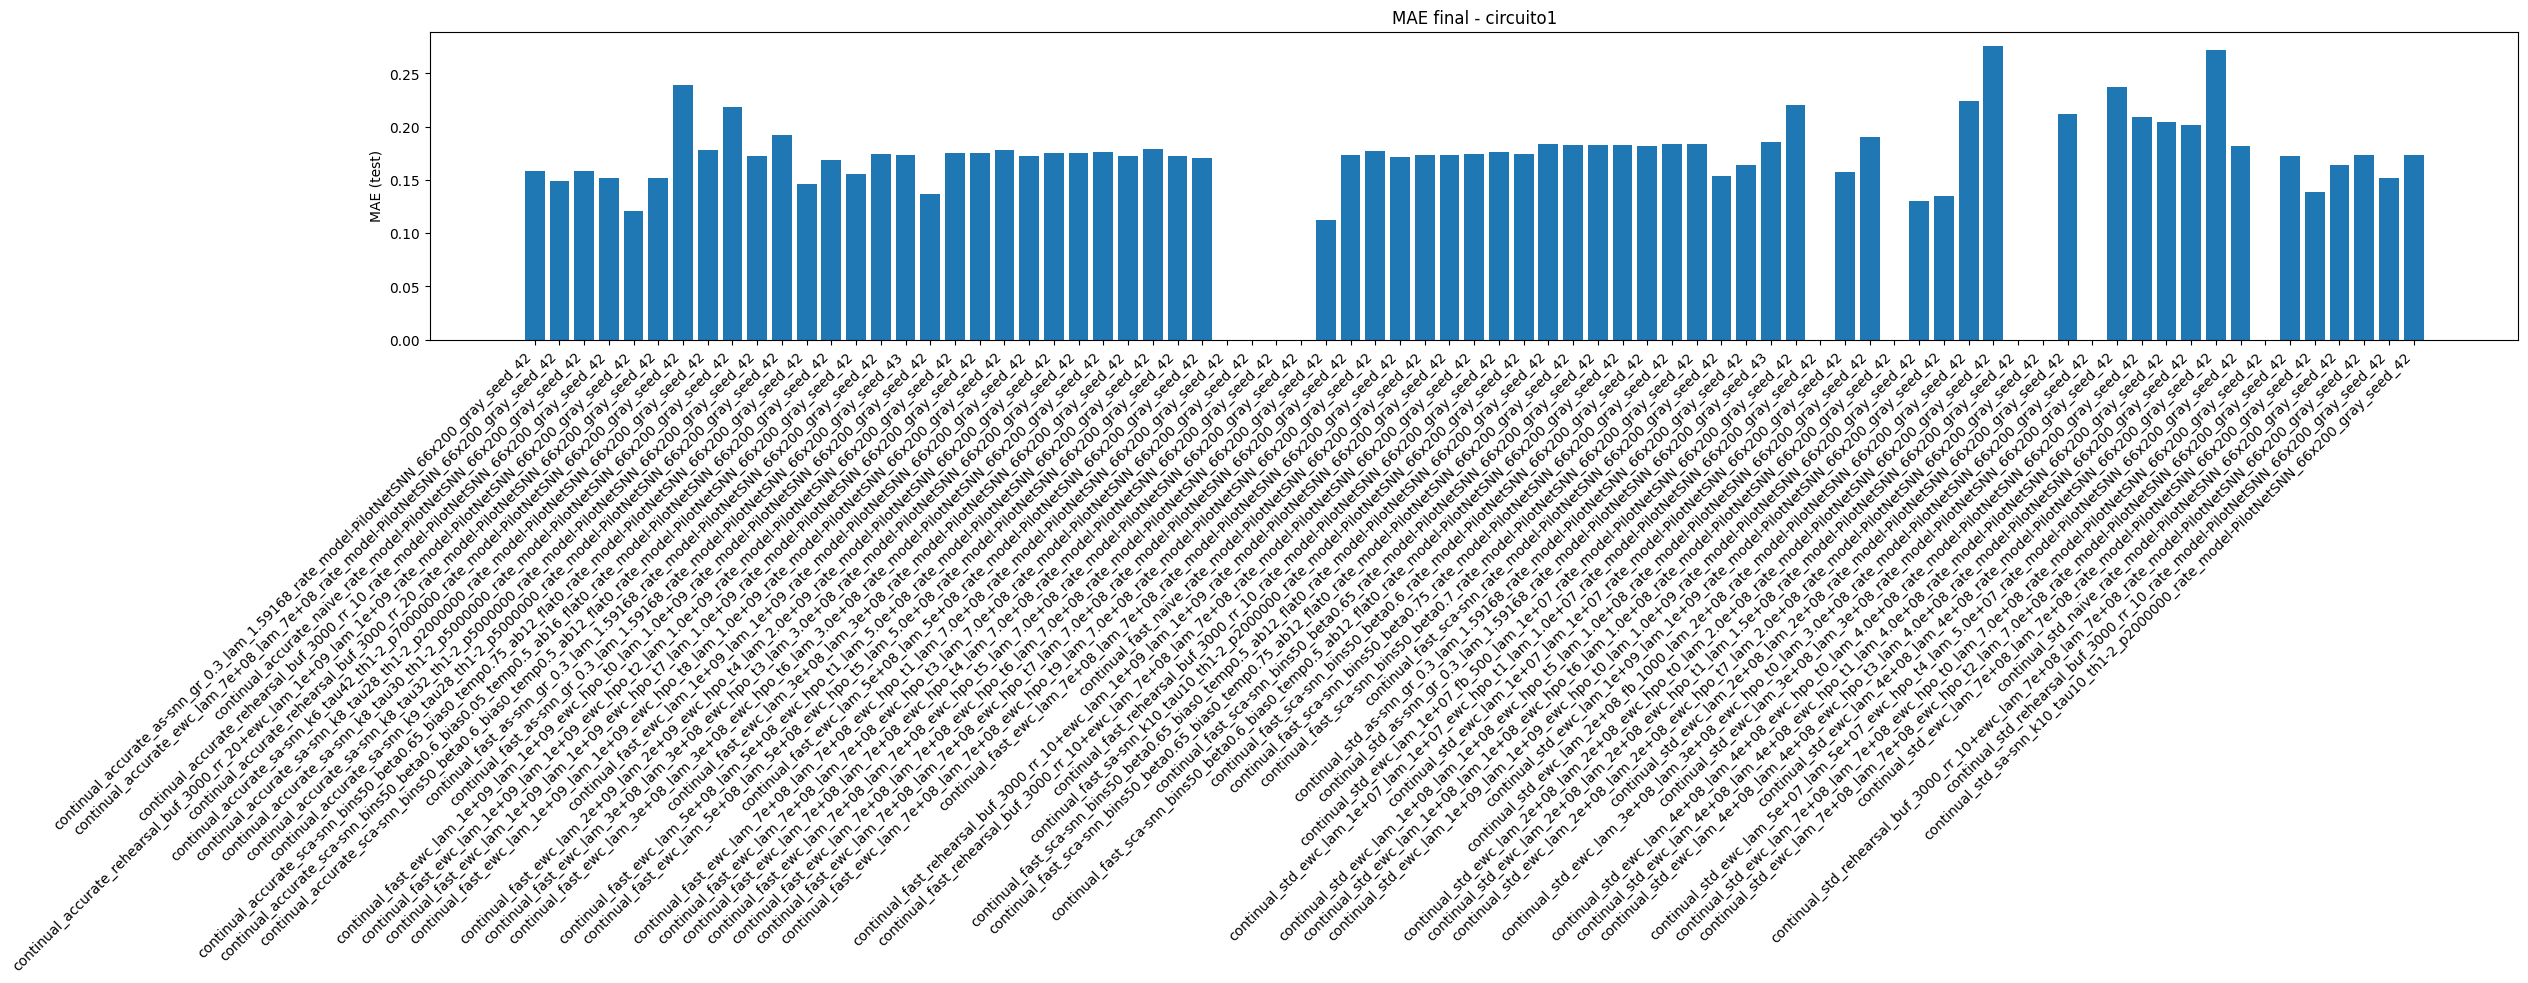

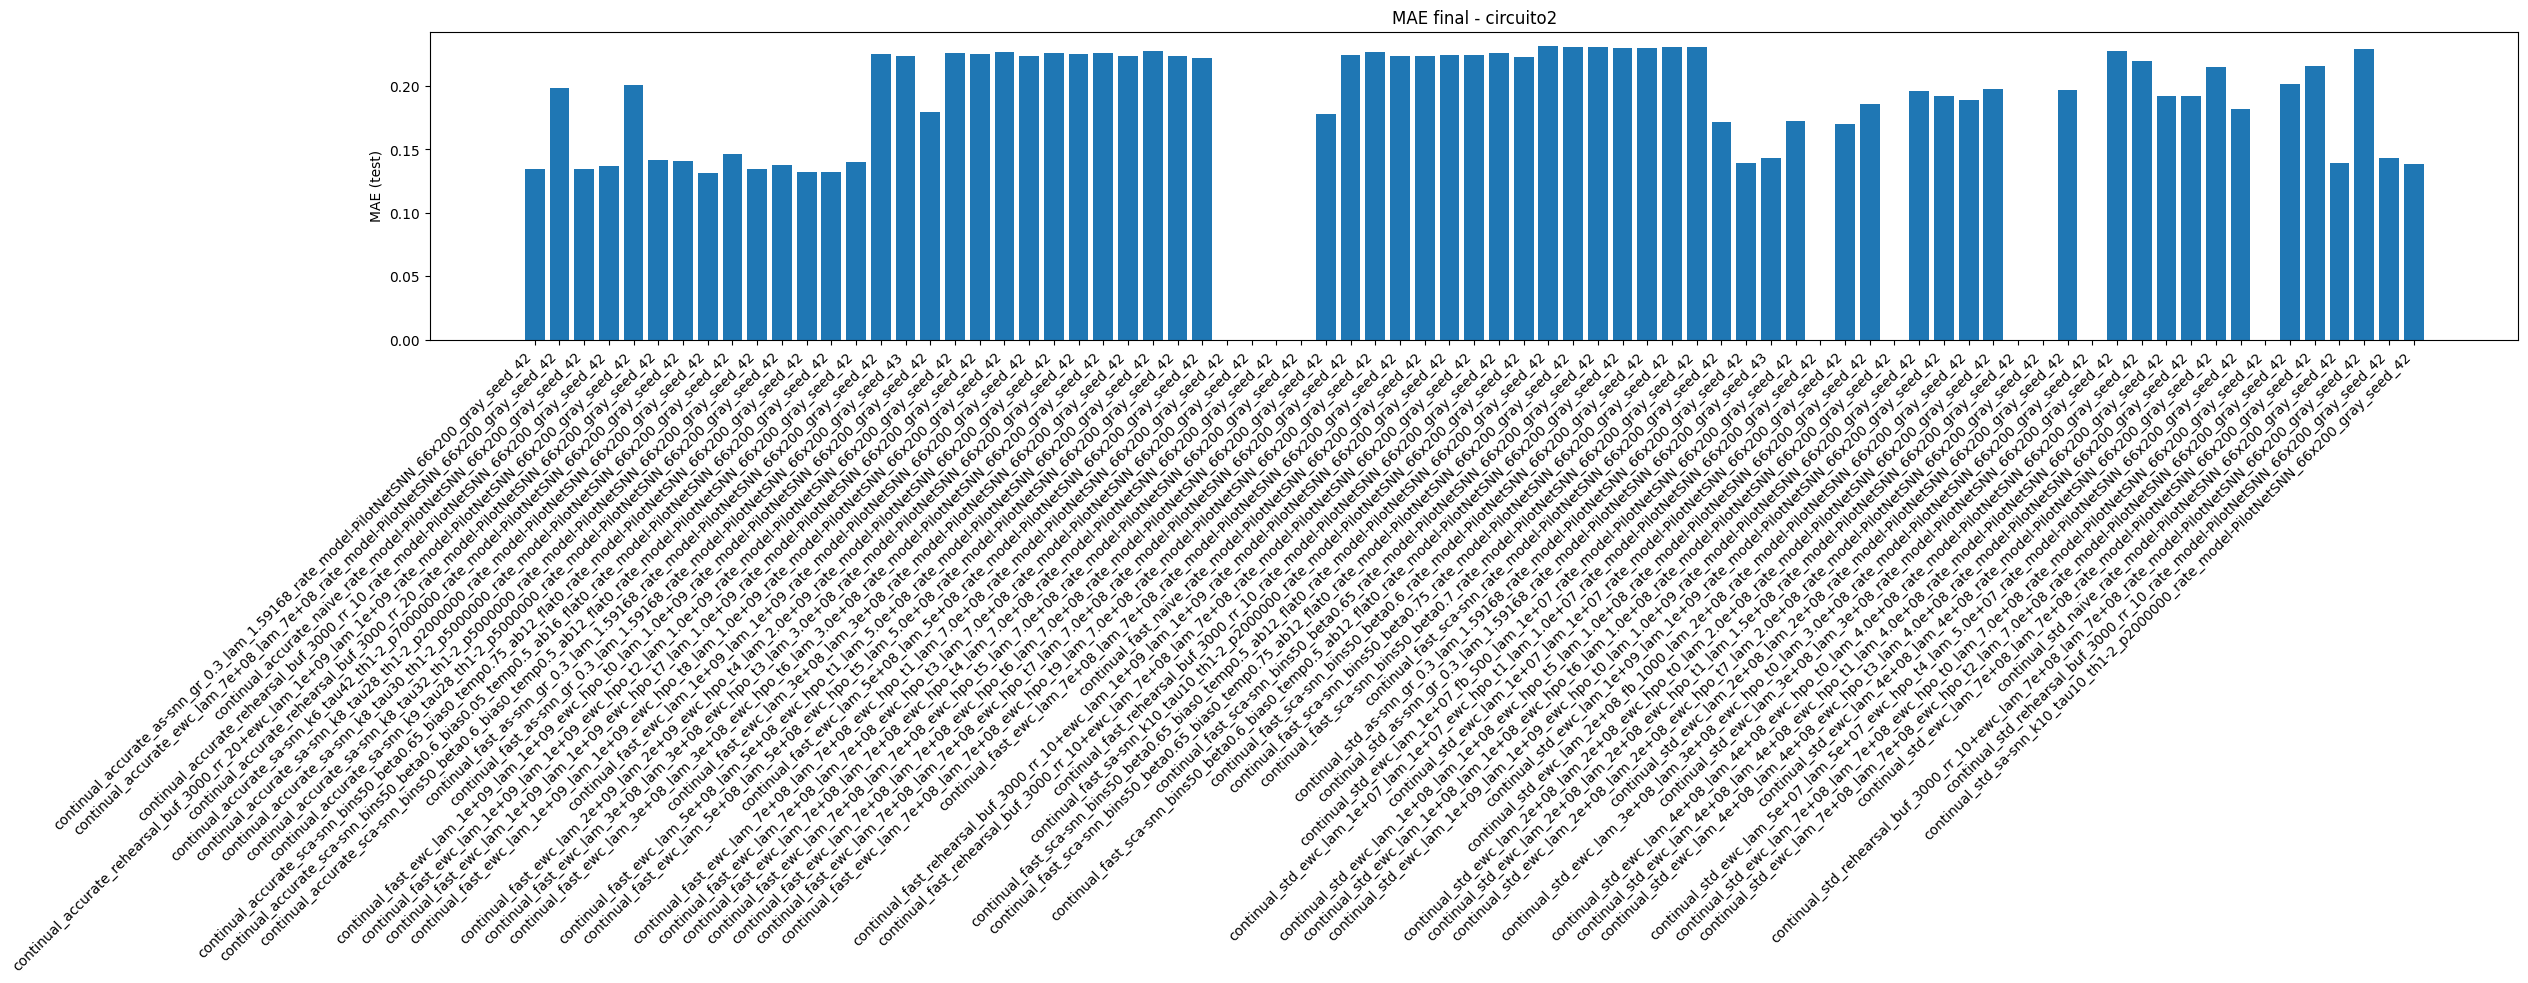

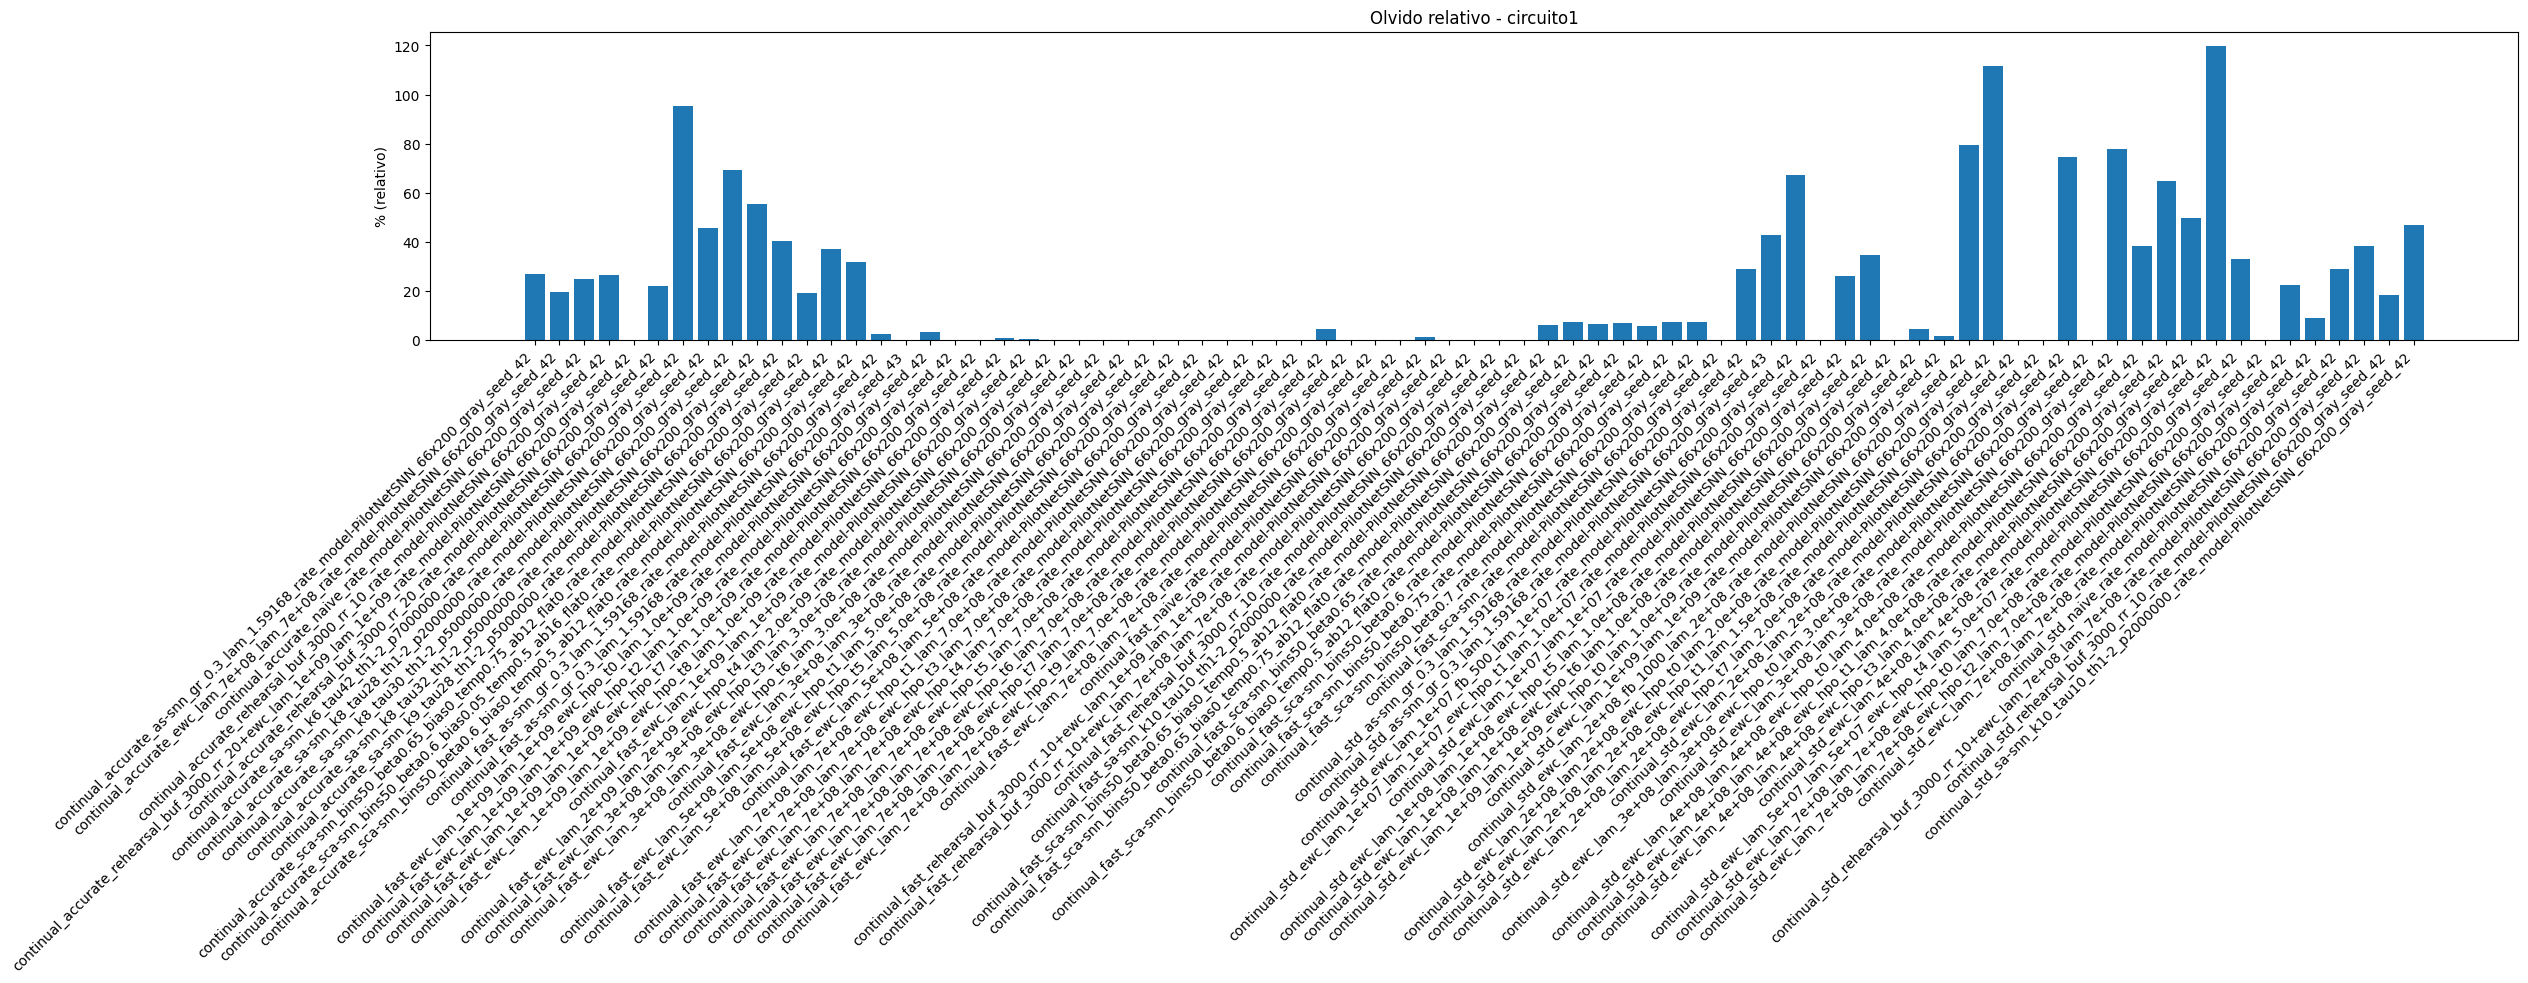

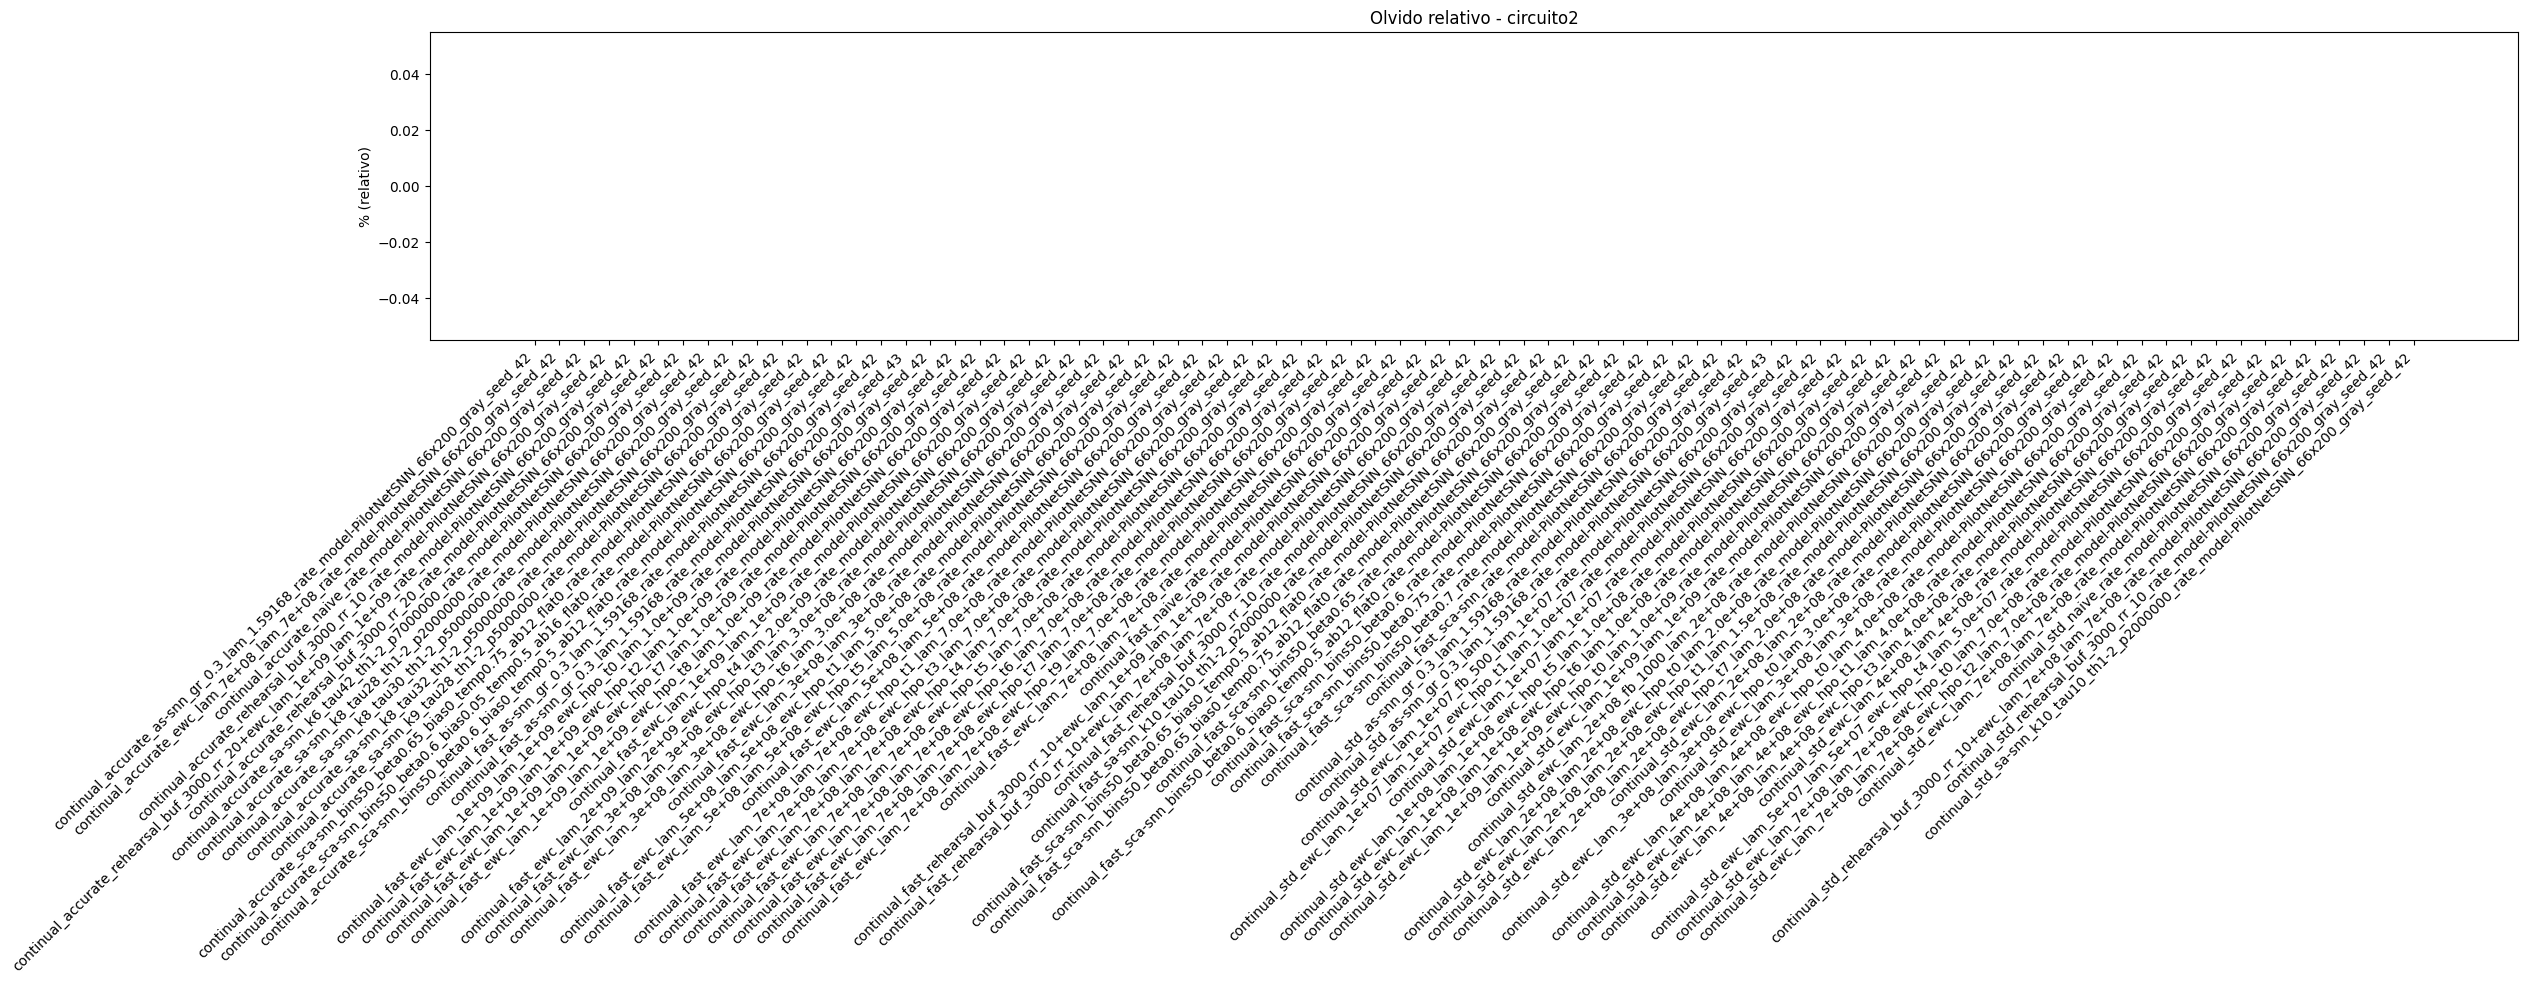

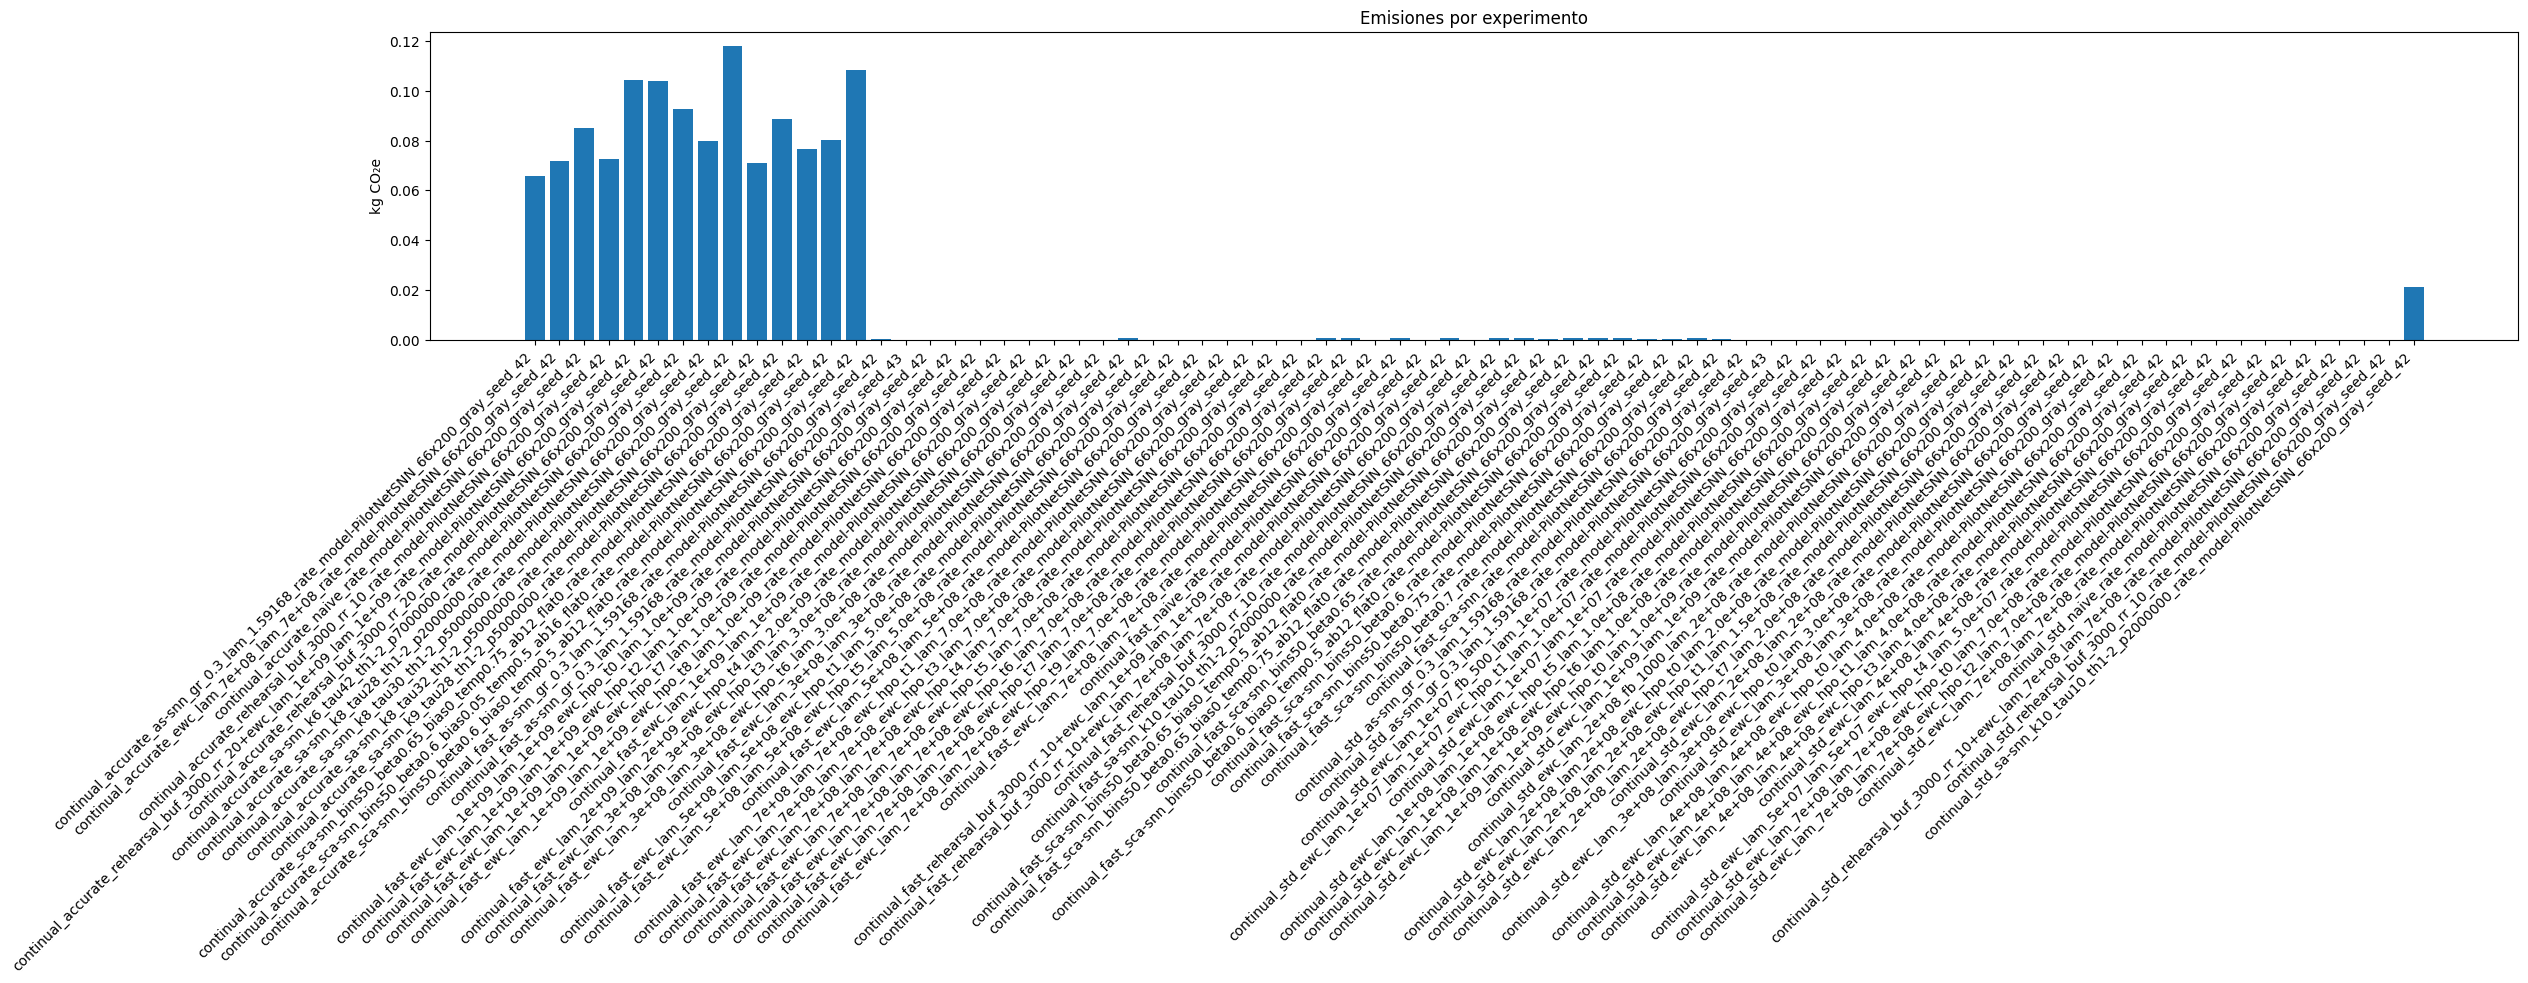

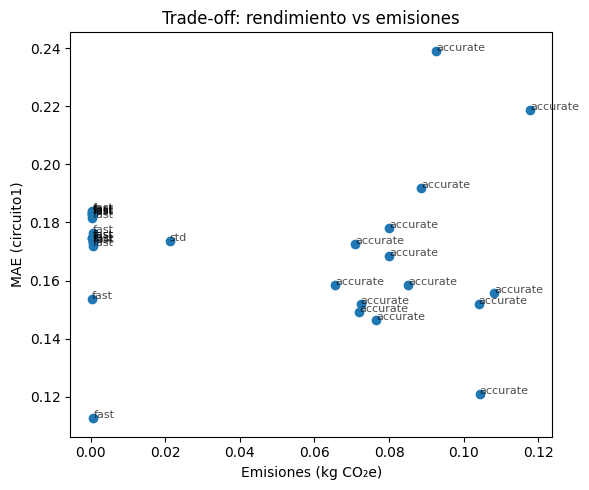

[OK] Gráficas comparativas en: /home/cesar/proyectos/TFM_SNN/outputs/summary/plots
Generando curvas de loss para: continual_accurate_sca-snn_bins50_beta0.65_bias0_temp0.75_ab12_flat0_rate_model-PilotNetSNN_66x200_gray_seed_42


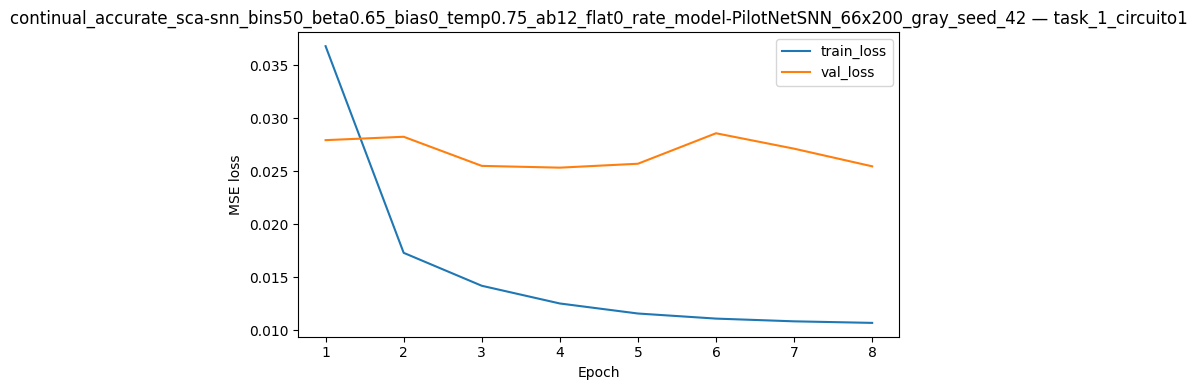

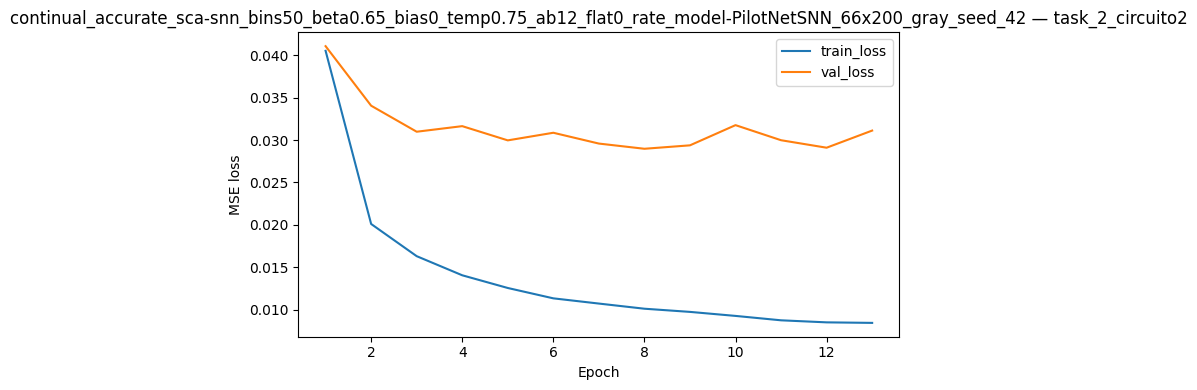

[OK] Curvas de loss en: /home/cesar/proyectos/TFM_SNN/outputs/summary/loss_curves


In [10]:
# =============================================================================
# 7) Resumen y gráficas
# =============================================================================
from pathlib import Path
import json
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.results_io import build_results_table
from src.plots import plot_across_runs

summary_dir = OUT / "summary"
summary_dir.mkdir(parents=True, exist_ok=True)

def canonical_method(s: str) -> str:
    if not isinstance(s, str):
        return "unknown"
    t = s.lower()
    if ("rehearsal" in t) and ("+ewc" in t or "_ewc" in t):
        return "rehearsal+ewc"
    if "sca-snn" in t:
        return "sca-snn"
    if re.search(r"\bsa[-_]snn\b", t):
        return "sa-snn"
    if re.search(r"\bas[-_]snn\b", t):
        return "as-snn"
    if "colanet" in t:
        return "colanet"
    if re.search(r"\bewc\b", t) or "ewc_lam" in t:
        return "ewc"
    if "rehearsal" in t:
        return "rehearsal"
    if "naive" in t or "finetune" in t or "fine-tune" in t:
        return "naive"
    return t.split("_")[0]

# --- 7.1 Tabla consolidada ---
df = build_results_table(OUT)
df["method_base"] = df["method"].astype(str).apply(canonical_method)
display(df)
df.to_csv(summary_dir / "results_table.csv", index=False)
print(f"[OK] Tabla guardada en {summary_dir/'results_table.csv'}")

# --- 7.2 Gráficas comparativas (final MAE, olvido, emisiones, trade-off) ---
plots_dir = plot_across_runs(df, summary_dir / "plots")
print("[OK] Gráficas comparativas en:", plots_dir)

# --- 7.3 Curvas de loss por tarea (para la memoria) ---
def plot_losses_for_run(run_dir: Path, outdir: Path):
    """Busca en run_dir/task_*/manifest.json y dibuja curvas de train/val loss por tarea."""
    outdir.mkdir(parents=True, exist_ok=True)
    task_dirs = sorted(run_dir.glob("task_*"))
    if not task_dirs:
        print(f"[WARN] No hay carpetas task_* en {run_dir}")
        return

    for td in task_dirs:
        # manifest.json o metrics.json
        man = None
        for cand in ("manifest.json", "metrics.json"):
            p = td / cand
            if p.exists():
                with open(p, "r", encoding="utf-8") as f:
                    man = json.load(f)
                break
        if man is None:
            print(f"[WARN] Sin manifest/metrics en {td.name}")
            continue

        hist = (man.get("history") or {})
        tr = hist.get("train_loss") or []
        va = hist.get("val_loss") or []

        if not tr and not va:
            print(f"[WARN] {td.name}: sin 'train_loss'/'val_loss' en history.")
            continue

        plt.figure(figsize=(7,4))
        if tr:
            plt.plot(range(1, len(tr)+1), tr, label="train_loss")
        if va:
            plt.plot(range(1, len(va)+1), va, label="val_loss")
        plt.title(f"{run_dir.name} — {td.name}")
        plt.xlabel("Epoch")
        plt.ylabel("MSE loss")
        plt.legend()
        plt.tight_layout()
        plt.savefig(outdir / f"{run_dir.name}__{td.name}_loss.png", dpi=160)
        plt.savefig(outdir / f"{run_dir.name}__{td.name}_loss.svg")
        plt.show()

# Elige el/los runs para curvas de loss (aquí, el último por fecha):
runs = sorted(OUT.glob("continual_*"), key=lambda p: p.stat().st_mtime, reverse=True)
if runs:
    loss_plots_dir = summary_dir / "loss_curves"
    print("Generando curvas de loss para:", runs[0].name)
    plot_losses_for_run(runs[0], loss_plots_dir)
    print("[OK] Curvas de loss en:", loss_plots_dir)
else:
    print("[INFO] No hay runs en outputs/ todavía.")


In [11]:
# === Selección automática de runs representativos ===
import re
import numpy as np
import pandas as pd

def norm01(x):
    x = x.astype(float)
    lo, hi = np.nanmin(x), np.nanmax(x)
    if not np.isfinite(lo) or not np.isfinite(hi) or hi <= lo:
        return np.ones_like(x) * 0.5
    return (x - lo) / (hi - lo)

# Usa la tabla ya construida en la celda anterior
d = df.copy()

# Normaliza método base (por si esta celda se ejecuta sola)
if "method_base" not in d.columns:
    d["method_base"] = d["method"].astype(str).apply(canonical_method)

# Filtra preset = accurate
d = d[d["preset"] == "accurate"].copy()
assert not d.empty, "No hay runs con preset='accurate'."

# --- Política de tarea principal: ÚLTIMA *_final_mae ---
# (si prefieres media de tareas, cambia la selección abajo)
task_cols = [c for c in d.columns if c.endswith("_final_mae")]
assert len(task_cols) > 0, "No encuentro columnas *_final_mae en la tabla."

def sort_key(col):
    name = col.replace("_final_mae", "")
    m = re.search(r"(\d+)$", name)
    base = re.sub(r"\d+$", "", name)
    idx = int(m.group(1)) if m else 0
    return (base, idx)

task_cols_sorted = sorted(task_cols, key=sort_key)
primary_mae  = task_cols_sorted[-1]    # p.ej. 'circuito2_final_mae'
primary_task = primary_mae.replace("_final_mae", "")
print("[INFO] Tareas detectadas:", task_cols_sorted)
print("[INFO] Usando como MAE principal:", primary_mae)

# Mantén columnas necesarias y normaliza
keep = ["run_dir","preset","method","method_base","encoder","model","seed",
        "elapsed_sec","emissions_kg","avg_forget_rel", primary_mae]
d = d[keep].copy()
for c in ["emissions_kg","avg_forget_rel", primary_mae]:
    d[c] = pd.to_numeric(d[c], errors="coerce")

# Relleno conservador
if d["emissions_kg"].isna().all():
    d["emissions_kg"] = 0.0
else:
    d["emissions_kg"] = d["emissions_kg"].fillna(d["emissions_kg"].median())
d["avg_forget_rel"] = d["avg_forget_rel"].fillna(d["avg_forget_rel"].max())

# --- Frente de Pareto (minimizar: MAE, olvido, emisiones) ---
M = d[[primary_mae,"avg_forget_rel","emissions_kg"]].values
is_dominated = np.zeros(len(d), dtype=bool)
for i in range(len(d)):
    ai = np.nan_to_num(M[i], nan=np.inf)
    for j in range(len(d)):
        if i == j: continue
        aj = np.nan_to_num(M[j], nan=np.inf)
        if np.all(aj <= ai) and np.any(aj < ai):
            is_dominated[i] = True
            break

pareto = d.loc[~is_dominated].sort_values([primary_mae, "avg_forget_rel", "emissions_kg"])
print(f"=== Frente de Pareto (no dominados) — MAE final ({primary_task}) ===")
display(pareto)

# --- Ranking por puntuación compuesta (opcional) ---
w_mae, w_forget, w_emiss = 0.5, 0.4, 0.1
d["_mae_n"]    = norm01(d[primary_mae].values)
d["_forget_n"] = norm01(d["avg_forget_rel"].values)
d["_emiss_n"]  = norm01(d["emissions_kg"].values)
d["score"]     = w_mae*d["_mae_n"] + w_forget*d["_forget_n"] + w_emiss*d["_emiss_n"]

topN = d.sort_values("score").head(6)
print("=== Top-6 por score compuesto (↓ mejor) ===")
display(topN[["run_dir","preset","method","method_base","seed",primary_mae,"avg_forget_rel","emissions_kg","score"]])

# ---- Si prefieres usar la MEDIA de tareas en lugar de la última ----
# mean_mae = d[task_cols].mean(axis=1, skipna=True)
# d_alt = d.copy()
# d_alt["mean_mae_final"] = mean_mae
# ... y sustituyes 'primary_mae' por 'mean_mae_final' en el Pareto/ranking.


[INFO] Tareas detectadas: ['circuito1_final_mae', 'circuito2_final_mae']
[INFO] Usando como MAE principal: circuito2_final_mae
=== Frente de Pareto (no dominados) — MAE final (circuito2) ===


run_dir    preset  \
7   continual_accurate_sa-snn_k8_tau28_th1-2_p2000...  accurate   
12  continual_accurate_sca-snn_bins50_beta0.6_bias...  accurate   
11  continual_accurate_sca-snn_bins50_beta0.65_bia...  accurate   
9   continual_accurate_sa-snn_k8_tau32_th1-2_p5000...  accurate   
0   continual_accurate_as-snn_gr_0.3_lam_1.59168_r...  accurate   
3   continual_accurate_rehearsal_buf_3000_rr_10_ra...  accurate   
1   continual_accurate_ewc_lam_7e+08_lam_7e+08_rat...  accurate   
5   continual_accurate_rehearsal_buf_3000_rr_20+ew...  accurate   

                                               method    method_base encoder  \
7                      sa-snn_k8_tau28_th1-2_p2000000         sa-snn    rate   
12  sca-snn_bins50_beta0.6_bias0.05_temp0.5_ab16_f...        sca-snn    rate   
11  sca-snn_bins50_beta0.65_bias0_temp0.75_ab12_flat0        sca-snn    rate   
9                      sa-snn_k8_tau32_th1-2_p5000000         sa-snn    rate   
0                           as-snn_gr_0.3_lam_1.59168         as-snn    rate   
3                            rehearsal_buf_3000_rr_10      rehearsal    rate   
1                                       ewc_lam_7e+08            ewc    rate   
5              rehearsal_buf_3000_rr_20+ewc_lam_1e+09  rehearsal+ewc    rate   

                      model  seed   elapsed_sec  emissions_kg  avg_forget_rel  \
7   PilotNetSNN_66x200_gray    42  25313.433069      0.079970        0.227382   
12  PilotNetSNN_66x200_gray    42  24126.103368      0.080034        0.185192   
11  PilotNetSNN_66x200_gray    42  24297.300170      0.076519        0.095610   
9   PilotNetSNN_66x200_gray    42  22102.547832      0.070985        0.276594   
0   PilotNetSNN_66x200_gray    42  20211.601102      0.065574        0.134079   
3   PilotNetSNN_66x200_gray    42  19506.329787      0.072408        0.131116   
1   PilotNetSNN_66x200_gray    42  19930.428739      0.071978        0.096803   
5   PilotNetSNN_66x200_gray    42  29488.605843      0.104276        0.000000   

    circuito2_final_mae  
7              0.131236  
12             0.131880  
11             0.132231  
9              0.134447  
0              0.134521  
3              0.136821  
1              0.198404  
5              0.201058

=== Top-6 por score compuesto (↓ mejor) ===


run_dir    preset  \
11  continual_accurate_sca-snn_bins50_beta0.65_bia...  accurate   
0   continual_accurate_as-snn_gr_0.3_lam_1.59168_r...  accurate   
3   continual_accurate_rehearsal_buf_3000_rr_10_ra...  accurate   
2   continual_accurate_naive_rate_model-PilotNetSN...  accurate   
12  continual_accurate_sca-snn_bins50_beta0.6_bias...  accurate   
7   continual_accurate_sa-snn_k8_tau28_th1-2_p2000...  accurate   

                                               method method_base  seed  \
11  sca-snn_bins50_beta0.65_bias0_temp0.75_ab12_flat0     sca-snn    42   
0                           as-snn_gr_0.3_lam_1.59168      as-snn    42   
3                            rehearsal_buf_3000_rr_10   rehearsal    42   
2                                               naive       naive    42   
12  sca-snn_bins50_beta0.6_bias0.05_temp0.5_ab16_f...     sca-snn    42   
7                      sa-snn_k8_tau28_th1-2_p2000000      sa-snn    42   

    circuito2_final_mae  avg_forget_rel  emissions_kg     score  
11             0.132231        0.095610      0.076519  0.108440  
0              0.134521        0.134079      0.065574  0.136238  
3              0.136821        0.131116      0.072408  0.163293  
2              0.134778        0.123087      0.085207  0.166393  
12             0.131880        0.185192      0.080034  0.187957  
7              0.131236        0.227382      0.079970  0.218694